In [ ]:
'''
Author: Hrag Najarian
Date: January 2023
'''

This code is meant to compare between the control run and the experiments when cloud-radiative interactions are turned off.

In [1]:
from wrf import getvar, ALL_TIMES
import matplotlib as mpl
import cartopy.crs as ccrs
from flox.xarray import xarray_reduce
from flox import Aggregation
import glob
import netCDF4 as nc
# import dask
# import cartopy.feature as cfeature
# import metpy.calc as mpcalc
# from metpy.cbook import get_test_data
# from metpy.interpolate import cross_section
# from cartopy.io.img_tiles import Stamen
# from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# from matplotlib import cm
from datetime import datetime, timedelta
import numpy as np
import xarray as xr
import os
# from braceexpand import braceexpand
import pandas as pd
import time
# import netCDF4 as nc
from math import cos, asin, sqrt, pi, atan, degrees, tan
import scipy
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# import torch
# import xarray as xr
# from diffusers import StableDiffusionUpscalePipeline
# from PIL import Image
# import numpy as np

### List of various functions that are used throughout the script

In [3]:
def wind_direction(u, v):
    """
    Calculate wind direction from zonal and meridional wind components.
    
    Parameters:
    u (float or array-like): Zonal wind component (positive for eastward, negative for westward).
    v (float or array-like): Meridional wind component (positive for northward, negative for southward).
    
    Returns:
    float or ndarray: Wind direction in degrees (meteorological convention).
    """
	# Calculate wind direction in mathematical convention (counterclockwise from positive x-axis)
    # math_direction = np.degrees(np.arctan2(v, u))  # Convert radians to degrees

    # Convert to meteorological convention (clockwise from true north)
    direction = (180 + np.degrees(np.arctan2(-u, -v))) % 360
    return direction

In [4]:
# Assumes cartesian coordinate system
def calculate_angle_between_points(p1, p2):
    # Calculate differences
    dy = p2[0] - p1[0]  # Lats
    dx = p2[1] - p1[1]  # Lons
    # Find the angle (radians)
    theta = math.atan(dy/dx)
    
    return theta

# # Example points
# point1 = [0, 0]
# point2 = [1, 1]

# theta = math.degrees(calculate_angle_between_points(point1, point2))
# print(f"The angle between the points is {theta} degrees")

In [5]:
def vertical_integration(da):
	# Do a rolling mean to get the average between two pressure levels
	da = da.rolling(bottom_top=2).mean()
	# Create dp and make it the same shape as da.
	dp_levels = da.bottom_top.diff(dim='bottom_top').expand_dims(dim={'Time':len(da.Time),'Distance':len(da.Distance),'Spread':len(da.Spread)})
	# Now remove the first level of da since it's nan's
	da = da.isel(bottom_top=slice(1,None))

	da_vertically_integrated = (da * dp_levels).sum('bottom_top') / (-9.8)

	return da_vertically_integrated

In [6]:
def round_to_two_significant_figures(number):
    """
    Rounds a float value to two significant figures using np.ceil or np.floor.

    Args:
        number (float): The input float value.

    Returns:
        float: The rounded value.
    """
    # Calculate the order of magnitude (power of 10) for the input number
    order_of_magnitude = np.floor(np.log10(np.abs(number)))

    # Calculate the factor to round to two significant figures
    factor = 10**(2 - order_of_magnitude)

    # Round the number using np.ceil or np.floor
    rounded_value = np.ceil(number * factor) / factor

    return rounded_value

def round_to_one_significant_figures(number):
    """
    Rounds a float value to two significant figures using np.ceil or np.floor.

    Args:
        number (float): The input float value.

    Returns:
        float: The rounded value.
    """
    # Calculate the order of magnitude (power of 10) for the input number
    order_of_magnitude = np.floor(np.log10(np.abs(number)))

    # Calculate the factor to round to two significant figures
    factor = 10**(1 - order_of_magnitude)

    # Round the number using np.ceil or np.floor
    rounded_value = np.ceil(number * factor) / factor

    return rounded_value

round_to_one_significant_figures(0.00001427)

1.5e-05

In [7]:
# Linear Regression Function based on the scipy.stats.linregress function

# Make sure the x and y values are 1-D matrices

# Inclusion of custom start and end lag inputs. 
	# If you don't care for the negative lags, then start at 0, or vise versa.
	# This way you're not wasting resources on lags you don't need.

def linreg(x, y, min_lag, max_lag):
	# Initialize matrices
	slopes = []
	yintercepts = []
	rvalues = []
	pvalues = []
	stderrors = []
	# How to disypher what lag relationships mean:
		# Negative lag implies that x at the moment correlates with your y in the future
		# Positive lag implies that x at the moment correlates with you y in the past
	for lag in range(min_lag,max_lag+1):	# itterate from min_lag to max_lag (+1 because of range function)
		if lag == 0:	
			slope, yintercept, rvalue, pvalue, stderror = scipy.stats.linregress(x, y)
		elif lag < 0:
			slope, yintercept, rvalue, pvalue, stderror = scipy.stats.linregress(x[:lag], y[-lag:])
		elif lag > 0:
			slope, yintercept, rvalue, pvalue, stderror = scipy.stats.linregress(x[lag:], y[:-lag])
		
		# Append the values!
		slopes.append(slope)
		yintercepts.append(yintercept)
		rvalues.append(rvalue)
		pvalues.append(pvalue)
		stderrors.append(stderror)

	# Compile data into a dataarray for easy management
	da_reg = xr.DataArray(
		data=np.arange(min_lag,max_lag+1),
		dims='lag',
		coords=dict(
			slope = ('lag', slopes),
			yintercept = ('lag', yintercepts),
			rvalue = ('lag', rvalues),
			pvalue = ('lag', pvalues),
			stderror= ('lag',stderrors)
			),
		name='lin_reg'
		)

	return da_reg

In [8]:
# Calculate Temperature [K] via potential temperature equation [PT = T * (Po/P) ^ .286]
	# Link: https://glossary.ametsoc.org/wiki/Potential_temperature 
def theta_to_temp(theta):
	# PT = T * (P0/P)^(R/Cp)
		# PT = Potential temperature/theta
		# T = Temperature
		# P0 = 1000 hPa
		# P = Pressure
		# R = Gas constant for air (287.052874 J/(kg*K))
		# Cp = Specific heat capacity at constant pressure (1003.5 J/(kg*K))
			# R/Cp = 0.286
	# so
	# T = PT / (P0/P)^(0.286)
	temp = xr.zeros_like(theta)
	P = theta.bottom_top.values
	for i in range(len(P)):
		temp[:,i,...] = theta[:,i,...] / (1000/P[i])**(0.286)
	
	temp.name = 'Temperature'
	temp = temp.assign_attrs(Units='K')
	
	return temp

In [9]:
# Calculate Potential Temperature [K] via potential temperature equation [PT = T * (Po/P) ^ .286]
def temp_to_theta(temp, psfc):
	# PT = T * (P0/P)^(R/Cp)
		# PT = Potential temperature/theta
		# T = Temperature
		# P0 = 1000 hPa
		# P = Pressure
		# R = Gas constant for air (287.052874 J/(kg*K))
		# Cp = Specific heat capacity at constant pressure (1003.5 J/(kg*K))
			# R/Cp = 0.286
	
	theta = xr.zeros_like(temp)
	theta = temp* ((1000/psfc)**(0.286))

	theta.name = 'Potential Temperature'
	theta = theta.assign_attrs(Units='K')

	return theta


In [10]:
# Calculate Mixing Ratio [kg/kg]
def mixing_ratio(e):
	# Calculate mixing ratio
	# https://glossary.ametsoc.org/wiki/Mixing_ratio
	r = xr.zeros_like(e)
	P = e.bottom_top.values
	for i in range(len(P)):
		r[:,i,...] = 0.62197*((e[:,i,...])/(P[i]-e[:,i,...]))	# [kg/kg]
	
	r.name = 'Mixing Ratio'
	r = r.assign_attrs(Units='kg/kg')
	
	return r

In [11]:
# Calculate Virtual Temperature [K] via Tv = T(1+(rv/eps)) / (1+rv)
def virt_temp(T, rv, eps):
	# Calculate virtual temperature
	# https://glossary.ametsoc.org/wiki/Virtual_temperature
	Tv = xr.zeros_like(T)
	Tv = T*(1+(rv/eps)) / (1+rv)

	Tv.name = 'Virtual Temperature'
	Tv = Tv.assign_attrs(Units='K')

	return Tv

In [12]:
# Calculate Saturation Vapor Pressure 
def sat_vap_press(temperature):
	# Follow the Clausius-Clapeyron equation 
		# Link: https://geo.libretexts.org/Bookshelves/Meteorology_and_Climate_Science/Practical_Meteorology_(Stull)/04%3A_Water_Vapor/4.00%3A_Vapor_Pressure_at_Saturation
		# es = e0 * exp([L/Rv] * (1/T0 - 1/T))
	e0=6.113		# [hPa]
	Rv=461			# [J/(K*kg)]
	T0=273.15		# [K]
	Lv=2.5*(10**6)	# [J/kg]	# liquid water
	Ld=2.83*(10**6)	# [J/kg]	# ice water
	# Create matrix/dataarray da that has variable L values based on the 
		# temperature of the atmosphere where it changes based on if T < 0°C 
		# Divide by rv to create the constant L/Rv
	constant = temperature.where(temperature>273.15, Lv)/Rv
	constant = temperature.where(temperature<=273.15, Ld)/Rv

	es = e0 * np.exp(constant * ((1/T0)-(1/temperature)))

	es.name = 'Saturation Vapor Pressure'
	es = es.assign_attrs(Units='hPa')
	
	return es

In [13]:
def sat_mixing_ratio(es, psfc):
	# Calculate saturated mixing ratio
	# https://glossary.ametsoc.org/wiki/Mixing_ratio
	ws = xr.zeros_like(es)
	if 'bottom_top' in es.dims:
		P = es.bottom_top.values
		for i in range(len(P)):
			ws[:,i,...] = 0.62197*((es[:,i,...])/(P[i]-es[:,i,...]))	# [kg/kg]
	else:
		P = psfc
		ws = 0.62197*((es)/(P-es))	# [kg/kg]
	
	ws.name = 'Saturation Mixing Ratio'
	ws = ws.assign_attrs(Units='kg/kg')
	
	return ws

In [14]:
def rel_hum_theta(theta,w):
	# Calculate the relative humidity via observed potential temperature [K] and mixing ratio [kg/kg]
	temperature = theta_to_temp(theta)	# [K]
	es = sat_vap_press(temperature)		# [hPa]
	ws = sat_mixing_ratio(es,es.bottom_top.values)	# [kg/kg]
	RH = w/ws * 100						# [%]

	RH.name = 'Relative Humidity'
	RH = RH.assign_attrs(Units='%')

	return RH

In [15]:
def rel_hum_temp(temp,w,psfc):
	# Calculate the relative humidity via observed temperature [K] and mixing ratio [kg/kg]
	temperature = temp					# [K]
	es = sat_vap_press(temperature)		# [hPa]
	ws = sat_mixing_ratio(es,psfc)		# [kg/kg]
	RH = w/ws * 100						# [%]

	RH.name = 'Relative Humidity'
	RH = RH.assign_attrs(Units='%')

	return RH

In [16]:
# Purpose: To grab the indicies that correspond to the times, latitudes, and longitudes of the WRF dataset file.

# Input:
	# file == path to the .nc file
	# times == np.datetime64 array [Start,End]
	# lats == np.array [south,north]
	# lons == np.array [west,east]

# Output:
	# time_ind, lat_ind, lon_ind == corresponds to the indicies of the times, lats, and lons provided within that file

# Example:
	# file = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/raw/d01'
	# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-11-23T12')]
	# lats = [-7.5, 7.5]
	# lons = [90, 110]
	# isel_ind(file, times, lats, lons)

def isel_ind(file,times,lats,lons):
	# Declare the variables
	time_ind = np.zeros(2, dtype=int)
	lat_ind = np.zeros(2, dtype=int)
	lon_ind = np.zeros(2, dtype=int)
	# Open the file
	ds = xr.open_dataset(file)
	# Times
	time_ind[0] = np.absolute(ds.XTIME.compute().values - (times[0])).argmin()
	time_ind[1] = np.absolute(ds.XTIME.compute().values - (times[1])).argmin()+1	# + 1 is because of the way argmin works
	# Latitudes
	lat_ind[0] = np.absolute(ds.XLAT[0,:,0].compute().values-(lats[0])).argmin()
	lat_ind[1] = np.absolute(ds.XLAT[0,:,0].compute().values-(lats[1])).argmin()+1
	# Longitude
	lon_ind[0] = np.absolute(ds.XLONG[0,0,:].compute().values-(lons[0])).argmin()
	lon_ind[1] = np.absolute(ds.XLONG[0,0,:].compute().values-(lons[1])).argmin()+1

	return time_ind, lat_ind, lon_ind

In [17]:
# Purpose: Opens a dataset with restrictive bounds to make opening large files less intensive

# Input:
	# file == path to the .nc file
	# time_ind == indicies (inclusive) of the dates you want to look at
	# lat_ind == indicies (inclusive) of the latitudes you want to look at
	# lon_ind == indicies (inclusive) of the longitudes you want to look at

# Output:
	# ds == dataset that corresponds to the times, lats, and lons provided.

# Example:
	# To get the indicies, I suggest using the function isel_ind() I have coded up in tandem with this function (see above).
	# file = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/raw/d01'
	# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-11-23T12')]
	# lats = [-7.5, 7.5]
	# lons = [90, 110]
	# time_ind, lat_ind, lon_ind = isel_ind(file, times, lats, lons)
	# ds = open_ds(file,time_ind,lat_ind,lon_ind)

def open_ds(file,time_ind,lat_ind,lon_ind):
	# if cross==True :	# If it is a cross-section ds
	# 	ds = xr.open_dataset(file).isel(
	# 		Time=slice(time_ind[0],time_ind[1]),
	# 	)
	# else:
	ds = xr.open_dataset(file, chunks='auto').isel(
		Time=slice(time_ind[0],time_ind[1]),
		south_north=slice(lat_ind[0],lat_ind[1]),
		west_east=slice(lon_ind[0],lon_ind[1])
	)
	return ds

In [18]:
# This function finds the distance [km] between two coordinates in lat & lon. 
    # If your map projection is Mercator (check 'MAP_PROJ'), then this works. 
    # If Lambert, then you need to do conversions, look at ChatGPT logs ('Distance Calculation Approximation')
def dist(lat1, lon1, lat2, lon2):
    r = 6371 # km
    p = pi / 180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 2 * r * asin(sqrt(a))


In [19]:
# Purpose: Rotate a vectorized variable like a wind vector in x/lon and y/lat space!
	# See Lecture02_Vector.pdf in METR 5113 Advanced Atmospheric Dynamics folder

# Input:
    # da_x  = 		xr.data_array		 	# Should be the X component of the vector
    # da_y  = 		xr.data_array			# Should be the Y component of the vector
		# Can be one time step or pressure level or even a 4-D variable [Time x Height x Lat x Lon]
    # theta =		rotation in radians		
		# Must be -pi/2 < theta < pi/2, you don't need to rotate any more than the 180° provided
		# Positive theta indiates anticlockwise turn of coordinates
		# Negative theta indiates clockwise turn of coordinates
# Output:
    # da_x_rot:		da_x but rotated
	# da_y_rot:		da_y but rotated
# Process:
    # Check if theta is positive or negative
		# Based on the value, the projections using theta will change
	# Project the current x and y coordinate to the new rotated x and y coordinates for each component.
	# Once rotated, return the rotated x and y components

def rotate_vec(da_x, da_y, theta):
	# anti-clockwise rotation
	if (theta > 0) & (theta<pi/2):
		da_x_rot = da_x*cos(theta) + da_y*cos((pi/2)-theta)
		da_y_rot = -da_x*cos((pi/2)-theta) + da_y*cos(theta)
	# clockwise rotation
	if (theta < 0) & (theta>(-pi/2)):
		da_x_rot = da_x*cos(-theta) - da_y*cos((pi/2)+theta)
		da_y_rot = da_x*cos((pi/2)+theta) + da_y*cos(-theta)

	return da_x_rot, da_y_rot

In [20]:
# Purpose: Create an array with multiple cross-sectional data from WRFoutput.
# Input:
    # da = 			xr.data_array		 	works with both 2-D and 3-D variables!
    # start_coord = [latitude, longitude] 
    # end_coord = 	[latitude, longitude]
	# width = 		spread of cross-section in degrees i.e., 0.75° = 0.75
	# dx = 			distance between each cross-sectional line i.e., 0.05° = 0.05
# Output:
    # da_cross: 		matrix in time, height, distance, and # of lines
		# 					or time, distance, and # of lines if using a 2-D variable
	# all_line_coords:	
# Process:
	# Make sure you 'da' have assigned coordinates corresponding to south_north and west_east.
    # We first create a main line between start_coord -> end_coord. This line will be the center
		# line for all other lines to sit next to.
	# Depending on the angle of the line (more latitudinal change or longitudinal change), this
		# function will account for that and make the longest side the length of the cross-sectional line
	# We then create an empty np.array, calculate the change in spread needed, then start filling in the data.

def cross_section_multi(da, start_coord, end_coord, width, dx):

	# We want to first create a line between start and end_coords
		# Gather the indicies of the closest gridboxes of start and end_coords.
	start_ilat = int((abs((da.XLAT[0,:,0]) - (start_coord[0]))).argmin())
	end_ilat = int((abs((da.XLAT[0,:,0]) - (end_coord[0]))).argmin())
	start_ilon = int((abs((da.XLONG[0,0,:]) - (start_coord[1]))).argmin())
	end_ilon = int((abs((da.XLONG[0,0,:]) - (end_coord[1]))).argmin())
	# This statement ensures that the length of the line will be the size of the LONGEST side (either lat or lon)
	if abs(start_ilat-end_ilat)>=abs(start_ilon-end_ilon):
		line_coords = np.zeros([2,abs(start_ilat-end_ilat)])
		# Populate latitudes
		line_coords[0,:] = np.linspace(da.XLAT[0,start_ilat,0], da.XLAT[0,end_ilat,0], abs(start_ilat-end_ilat))
		# Populate longitudes
		line_coords[1,:] = np.linspace(da.XLONG[0,0,start_ilon], da.XLONG[0,0,end_ilon], abs(start_ilat-end_ilat))
	else:
		line_coords = np.zeros([2,abs(start_ilon-end_ilon)])
		# Populate latitudes
		line_coords[0,:] = np.linspace(da.XLAT[0,start_ilat,0], da.XLAT[0,end_ilat,0], abs(start_ilon-end_ilon))
		# Populate longitudes
		line_coords[1,:] = np.linspace(da.XLONG[0,0,start_ilon], da.XLONG[0,0,end_ilon], abs(start_ilon-end_ilon))

	##########################################################################################################################
	# Now that we have the coordinates between the start and end_coords, we need to replicate it for all the lines
	num_lines = int(width/dx)
	spread = np.arange(width/2,-width/2,-dx)
	if 'bottom_top' in da.dims:	# If the dataset is 3-D
		#						TIME	x	HEIGHT	x	   DISTANCE	   x   #ofLINES
		da_cross = np.zeros([da.shape[0],da.shape[1],line_coords.shape[1],num_lines])
	else:
		#						TIME	x	   DISTANCE	   x   #ofLINES
		da_cross = np.zeros([da.shape[0],line_coords.shape[1],num_lines])

	# Create all_line_coords that holds all the coordinates for every line produced
	all_line_coords = np.zeros([line_coords.shape[0],line_coords.shape[1],spread.shape[0]])

	# Looping over all the lines
	for i in range(len(spread)):
		
		# Fix this part
		if (end_coord[0] > start_coord[0]):
			all_line_coords[0,:,i] = line_coords[0,:]+spread[i]
		else:
			all_line_coords[0,:,i] = line_coords[0,:]-spread[i]
		if (end_coord[1] > start_coord[1]):
			all_line_coords[1,:,i] = line_coords[1,:]-spread[i]
		else:
			all_line_coords[1,:,i] = line_coords[1,:]+spread[i]

		# Now that we have our lines, we can interpolate the dataset with the offset for each line applied
		da_interp = da.interp(south_north=all_line_coords[0,:,i], west_east=all_line_coords[1,:,i], method="linear")

		# Populate the new data array with data from the cross section
			# Loop through the length of the line, find the match, and then populate it.
		if 'bottom_top' in da.dims:	# If the dataset is 3-D
			for j in range(da_cross.shape[2]):
				data = da_interp.sel(
					south_north = da_interp.south_north[j],
					west_east = da_interp.west_east[j])
				da_cross[:,:,j,i] = data
		else:
			for j in range(da_cross.shape[1]):
				data = da_interp.sel(
					south_north = da_interp.south_north[j],
					west_east = da_interp.west_east[j])
				da_cross[:,j,i] = data

	return da_cross, all_line_coords

In [21]:
def hov_diurnal(da, LT):
    # Average over the bounds to create shape of (time,west_east)
    da_avg = da.where((da.XLAT>lat_avg_bound[0])&(da.XLAT<lat_avg_bound[1]),drop=True).mean(dim='south_north')

    if LT:
        # Create a np.array with shape (west_east,hour). Then populate each longitude column with its respective
            # diurnal cycle of rain rate.
        array = np.zeros((da_avg.shape[1],24))
        # Loop through each longitude, look through all the timesteps and group them by hour,
            # and then average the values at each hour. Output the 1x24 array into the empty array
        for i in range(array.shape[0]):
            array[i,:] = da_avg[:,i].groupby('LocalTime.hour').mean()
    else:
        array = da_avg.mean('west_east').groupby('XTIME.hour').mean()
    return array

In [22]:
# Purpose: To alliviate the memory issue that arrises when you getvar() a big dataset.
# Input:
    # xrDataset = xr.open_dataset(filepath)
    # Dataset = Dataset(filepath)
    # varname = '<variablename>'
# Output:
    # da: This will be the xr.DataArray you are after
# Process:
    # First create an empty np.array that holds varname values.
    # Loop through each timestep to fill in the np.array.
    # Here's the trick, only getvar() one timestep, then expand the time dim.
        # This will repeate the values from the first timestep into the Time dim.
    # Assign the Time coordinates.
    # Replace the repeated values with the correct values from npArray.

# This method is ~6x more efficient than getvar(Dataset, varname, ALL_TIMES)

def wrf_np2da(xrDataset,Dataset,varname):
    da_times = getvar(Dataset, 'times', ALL_TIMES)			# Times in datetime64
    # Create empty numpy array
    npArray = np.empty((xrDataset.dims['Time'],xrDataset.dims['bottom_top'],
                        xrDataset.dims['south_north'],xrDataset.dims['west_east']),np.float32)
    for i in range(npArray.shape[0]):
        npArray[i,...] = getvar(Dataset, varname, timeidx=i, meta=False)
    da = getvar(Dataset, varname, timeidx=0)
    da = da.expand_dims(dim={'Time': da_times}, axis=0)
    da = da.assign_coords(dict(
        Time=('Time',da_times.values),
        XTIME=('Time',np.float32(xrDataset['ITIMESTEP'].values))
    ))
    da.values = npArray
    return da

In [23]:
# Purpose: Create a LocalTime coordinate within your DataArray.

# Input:
    # da = xr.DataArray;  Must be in shape: time x south_north x west_east
		# Make sure west_east/XLONG values are 0->360, not -180->+180
	# dim_num = 2 or 3;  This indicates to the function if you want Local Time
		# within the dataarray to be only a function of time and longitude, or
		# time, lognitude, and latitude. This is a preference and if you don't need
		# it as a function of latitude, it will save lots of time going with dim_num = 2.
# Output:
    # da: This will be the DataArray with the newly assigned coordinate
# Process:
    # First create a matrix of hours to be offset relative to UTC.
    # Create an empty array that has dimensions Time and Longitude.
    # Loop through each timestep and longitude to determine the local time.
    # Assign the new Local Time coordinate to the da and return it.


def assign_LT_coord(da, dim_num):
	hour_offset = (da.XLONG.values[:,0,:]/15).round(decimals=0)

	# Local Time is a function of only Time and Longitude
	if dim_num==2:
		local_time = np.empty([len(da.Time),len(da.west_east)], dtype=object)
		for i in range(local_time.shape[0]):
			for j in range(local_time.shape[1]):
				local_time[i,j] = da.Time.values[i] + np.timedelta64(int(hour_offset[0,j]),'h')
		da = da.assign_coords(LocalTime=(('Time','west_east'),local_time))
	
	# Local Time is a function of Time, Longitude, and Latitude
	else:
		local_time = np.empty([len(da.Time),len(da.south_north),len(da.west_east)], dtype='datetime64[ns]')
		for i in range(local_time.shape[0]):
			for j in range(local_time.shape[2]):
				local_time[i,:,j] = da.Time.values[i] + np.timedelta64(int(hour_offset[0,j]),'h')
		da = da.assign_coords(LocalTime=(('Time','south_north','west_east'),local_time))
	return da


In [24]:
# Function that can removes the bottom_top dimension for 2-D datasets
def without_keys(d, keys):
	return {x: d[x] for x in d if x not in keys}

In [25]:
# Assumes cartesian/flat coordinate system
def calculate_angle_between_points(p1, p2):
    # Calculate differences
    dy = p2[0] - p1[0]  # Lats
    dx = p2[1] - p1[1]  # Lons
    # Find the angle (radians)
    theta = atan(dy/dx)

    # Negative if NW or SE direction
    # Positive if NE or SW direction
    
    return theta

# start_coord		= [1.2,112.8]
# end_coord 		= [5.2,108.8]
# degrees(calculate_angle_between_points(start_coord, end_coord))

In [26]:
# Makes making tick labels easier
# ticks are integers
def degree_labels(ticks, lat_or_lon):

	labels = []
	
	if lat_or_lon=='lat':
		for t in ticks:
			if t >= 0:
				labels.append(str(t)+u'\N{DEGREE SIGN}N')
			else:
				labels.append(str(t)+u'\N{DEGREE SIGN}S')
				
	elif lat_or_lon=='lon':
		for t in ticks:
			if t >= 0:
				labels.append(str(t)+u'\N{DEGREE SIGN}E')
			else:
				labels.append(str(t)+u'\N{DEGREE SIGN}W')
	return labels

## Load Data

### Spatial Data

#### Control Data
This section opens stitched wrfout .nc files. The raw .nc file is much to large, so I have extracted variables from the large file into smaller .nc files that only contains one variable. To get these smaller .nc files, please refer to extract_variable.py and interp_variable.py function I have created. This section opens those files up and assigned them to a variable.

Temporal 10.5-day (2015 11-22-12UTC -> 2015 12-03-00UTC)

Below the section where I assigned file names, there is an option for you to only open up a smaller domain (spatial and temporal) if you are interetsed in a select region. This will save you a lot of computational time.

In [27]:
start_time = time.perf_counter()

parent_dir_CNTL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00'
# parent_dir_CNTL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/CRFoff/MC_Sumatra_2015-11-25--26/2015-11-25-03--11-26-12'
file_d01_raw = parent_dir_CNTL + '/raw/d01'
file_d02_raw = parent_dir_CNTL + '/raw/d02'
# 2-D data
file_d02_HFX = parent_dir_CNTL + '/L1/d02_HFX'			    # [W/m^2]
file_d02_LH = parent_dir_CNTL + '/L1/d02_LH'			    # [W/m^2]
file_d02_SMOIS = parent_dir_CNTL + '/L1/d02_SMOIS'			# [kg^3/kg^3]
file_d02_LowCLDFRA = parent_dir_CNTL + '/L1/d02_LowCLDFRA'   # [0->1]
file_d02_MidCLDFRA = parent_dir_CNTL + '/L1/d02_MidCLDFRA'   # [0->1]
file_d02_HighCLDFRA = parent_dir_CNTL + '/L1/d02_HighCLDFRA' # [0->1]
file_d02_LWDNB = parent_dir_CNTL + '/L1/d02_LWDNB'		# [W/m^2]
file_d02_LWUPB = parent_dir_CNTL + '/L1/d02_LWUPB'		# [W/m^2]
file_d02_SWDNB = parent_dir_CNTL + '/L1/d02_SWDNB'		# [W/m^2]
file_d02_SWUPB = parent_dir_CNTL + '/L1/d02_SWUPB'		# [W/m^2]
file_d02_SWDNBC = parent_dir_CNTL + '/L1/d02_SWDNBC'		# [W/m^2]
file_d02_SWUPBC = parent_dir_CNTL + '/L1/d02_SWUPBC'		# [W/m^2]
file_d02_RR = parent_dir_CNTL + '/L1/d02_RR'				# [mm/dt]
file_d02_PSFC = parent_dir_CNTL + '/L1/d02_PSFC'		    # [hPa]
file_d02_T2 = parent_dir_CNTL + '/L1/d02_T2'		        # [K]
file_d02_TSK = parent_dir_CNTL + '/L1/d02_TSK'		        # [K]
file_d02_Q2 = parent_dir_CNTL + '/L1/d02_Q2'		        # [kg/kg]
file_d02_U10 = parent_dir_CNTL + '/L1/d02_U10'		    # [m/s]
file_d02_V10 = parent_dir_CNTL + '/L1/d02_V10'		    # [m/s]
file_d02_VEGFRA = parent_dir_CNTL + '/L1/d02_VEGFRA'			    # [W/m^2]
# Raw data
file_d01_P = parent_dir_CNTL + '/L1/d01_P'				# [mm/dt]
file_d02_P = parent_dir_CNTL + '/L1/d02_P'				# [mm/dt]
# Interpolated data 
file_d01_U = parent_dir_CNTL + '/L2/d01_interp_U'	        # [m/s]
file_d02_U = parent_dir_CNTL + '/L2/d02_interp_U'	        # [m/s]
file_d01_V = parent_dir_CNTL + '/L2/d01_interp_V'	        # [m/s]
file_d02_V = parent_dir_CNTL + '/L2/d02_interp_V'	        # [m/s]
file_d01_QV = parent_dir_CNTL + '/L2/d01_interp_QV'	        # [kg/kg]
file_d02_QV = parent_dir_CNTL + '/L2/d02_interp_QV'	        # [kg/kg]
file_d01_CLDFRA = parent_dir_CNTL + '/L2/d01_interp_CLDFRA'	# 
file_d02_CLDFRA = parent_dir_CNTL + '/L2/d02_interp_CLDFRA'	# 
file_d01_H_DIABATIC = parent_dir_CNTL + '/L2/d01_interp_H_DIABATIC'	        # [K/s]
file_d02_H_DIABATIC = parent_dir_CNTL + '/L2/d02_interp_H_DIABATIC'	        # [K/s]
file_d01_LWAll = parent_dir_CNTL + '/L2/d01_interp_LWAll'	# [K/s]
file_d02_LWAll = parent_dir_CNTL + '/L2/d02_interp_LWAll'	# [K/s]
file_d01_LWClear = parent_dir_CNTL + '/L2/d01_interp_LWClear'# [K/s]
file_d02_LWClear = parent_dir_CNTL + '/L2/d02_interp_LWClear'# [K/s]
file_d01_SWAll = parent_dir_CNTL + '/L2/d01_interp_SWAll'	# [K/s]
file_d02_SWAll = parent_dir_CNTL + '/L2/d02_interp_SWAll'	# [K/s]
file_d01_SWClear = parent_dir_CNTL + '/L2/d01_interp_SWClear'# [K/s]
file_d02_SWClear = parent_dir_CNTL + '/L2/d02_interp_SWClear'# [K/s]
file_d01_Theta = parent_dir_CNTL + '/L2/d01_interp_Theta'	# [K]
file_d02_Theta = parent_dir_CNTL + '/L2/d02_interp_Theta'	# [K]

######################################################################################
################ Declare the bounds you want to specifically look at #################
#### All the data 
# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-12-02T12')]
lats = [-20, 20]
lons = [80, 135]

#### Some of the data
# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-12-03T00')]          # All Times
times = [np.datetime64('2015-11-23T01'), np.datetime64('2015-12-02T00')]        # NCRF Sunrise
# times = [np.datetime64('2015-11-23T01'), np.datetime64('2015-11-25T02')]        # NCRF Sunrise Debugging
# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-11-23T12')]
# times = [np.datetime64('2015-11-25T00'), np.datetime64('2015-11-26T12')]
# lats = [-7.5, 7.5]
# lons = [90, 115]
######################################################################################
# Setup the indicies that will be used throughout
time_ind_d01, lat_ind_d01, lon_ind_d01 = isel_ind(file_d01_raw, times, lats, lons)
time_ind_d02, lat_ind_d02, lon_ind_d02 = isel_ind(file_d02_raw, times, lats, lons)

# Raw datasets
ds_d01 = open_ds(file_d01_raw,time_ind_d01,lat_ind_d01,lon_ind_d01)
ds_d02 = open_ds(file_d02_raw,time_ind_d02,lat_ind_d02,lon_ind_d02)
step1_time = time.perf_counter()
print('Dataset loaded \N{check mark}', step1_time-start_time, 'seconds')



# Coordinate dictionaries:
step2_time = time.perf_counter()
interp_P_levels = np.concatenate((np.arange(1000,950,-10),np.arange(950,350,-30),np.arange(350,0,-50)))

d01_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d01.XLAT.values),
    XLONG=(('Time','south_north','west_east'),ds_d01.XLONG.values),
    bottom_top=(('bottom_top'),interp_P_levels),
    Time=('Time',ds_d01.XTIME.values),
    south_north=(('south_north'),ds_d01.XLAT[0,:,0].values),
    west_east=(('west_east'),ds_d01.XLONG[0,0,:].values)
    )

d02_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d02.XLAT.values),
    XLONG=(('Time','south_north','west_east'),ds_d02.XLONG.values),
    bottom_top=(('bottom_top'),interp_P_levels),
    Time=('Time',ds_d02.XTIME.values),
    south_north=(('south_north'),ds_d02.XLAT[0,:,0].values),
    west_east=(('west_east'),ds_d02.XLONG[0,0,:].values)
    )

step1_time = time.perf_counter()
print('Created coordinate dictionaries \N{check mark}', step1_time-step2_time, 'seconds')



###########################################################
################# Load in the variables ###################
###########################################################


##################### 3-D variables #######################

# ############ Interpolated zonal winds   [m/s] #############
# step2_time = time.perf_counter()
# # d01   # how I used to open data: ds = xr.open_dataset(file_d01_U).isel(Time=slice(0,t))
# ds = open_ds(file_d01_U,time_ind_d01,lat_ind_d01,lon_ind_d01)

# da_d01_U = ds['U'].compute()
# da_d01_U = da_d01_U.assign_coords(d01_coords)
# fill_value_f8 = da_d01_U.max()      # This is the fill_value meaning missing_data
# da_d01_U = da_d01_U.where(da_d01_U!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_U,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_U = ds['U'].compute()
# da_d02_U = da_d02_U.assign_coords(d02_coords)
# # fill_value = da_d02_U.max()      # This is the fill_value meaning missing_data
# da_d02_U = da_d02_U.where(da_d02_U!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Interpolated zonal winds loaded \N{check mark}', step1_time-step2_time, 'seconds')


# ############ Interpolated Meridional winds   [m/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_V,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_V = ds['V'].compute()
# da_d01_V = da_d01_V.assign_coords(d01_coords)
# # fill_value = da_d01_V.max()      # This is the fill_value meaning missing_data
# da_d01_V = da_d01_V.where(da_d01_V!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_V,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_V = ds['V'].compute()
# da_d02_V = da_d02_V.assign_coords(d02_coords)
# # fill_value = da_d02_V.max()      # This is the fill_value meaning missing_data
# da_d02_V = da_d02_V.where(da_d02_V!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Interpolated meridional winds loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Interpolated water vapor mixing ratio  [kg/kg] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_QV,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_QV = ds['QV'].compute()
# da_d01_QV = da_d01_QV.assign_coords(d01_coords)
# da_d01_QV = da_d01_QV.where(da_d01_QV!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_QV,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_QV = ds['QV'].compute()
# da_d02_QV = da_d02_QV.assign_coords(d02_coords)
# da_d02_QV = da_d02_QV.where(da_d02_QV!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Interpolated water vapor mixing ratio loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ Cloud Fraction [0-1] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_CLDFRA,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_CLDFRA = ds['CLDFRA']
# # Turn the fill value into nan's before averaging
# da_d01_CLDFRA = xr.where(da_d01_CLDFRA>1, np.nan, da_d01_CLDFRA)
# da_d01_CLDFRA = da_d01_CLDFRA.assign_coords(d01_coords)

# # d02
# ds = open_ds(file_d02_CLDFRA,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_CLDFRA = ds['CLDFRA']
# # Turn the fill value into nan's before averaging
# da_d02_CLDFRA = xr.where(da_d02_CLDFRA>1, np.nan, da_d02_CLDFRA)
# da_d02_CLDFRA = da_d02_CLDFRA.assign_coords(d02_coords)

# step1_time = time.perf_counter()
# print('Cloud fraction loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Latent Heating [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_H_DIABATIC,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_H_DIABATIC = ds['H_DIABATIC'].compute()
# da_d01_H_DIABATIC = da_d01_H_DIABATIC.assign_coords(d01_coords)
# da_d01_H_DIABATIC = da_d01_H_DIABATIC.where(da_d01_H_DIABATIC!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_H_DIABATIC,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_H_DIABATIC = ds['H_DIABATIC'].compute()
# da_d02_H_DIABATIC = da_d02_H_DIABATIC.assign_coords(d02_coords)
# da_d02_H_DIABATIC = da_d02_H_DIABATIC.where(da_d02_H_DIABATIC!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Latent heating loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Potential Temperature [K] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_Theta,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_Theta = ds['Theta'].compute()
# da_d01_Theta = da_d01_Theta.assign_coords(d01_coords)
# da_d01_Theta = da_d01_Theta.where(da_d01_Theta!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_Theta,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_Theta = ds['Theta'].compute()
# da_d02_Theta = da_d02_Theta.assign_coords(d02_coords)
# da_d02_Theta = da_d02_Theta.where(da_d02_Theta!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Shortwave Clear-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Longwave Radiative Heating All-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_LWAll,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_LWAll = ds['LWAll'].compute()
# da_d01_LWAll = da_d01_LWAll.assign_coords(d01_coords)
# da_d01_LWAll = da_d01_LWAll.where(da_d01_LWAll!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_LWAll,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_LWAll = ds['LWAll'].compute()
# da_d02_LWAll = da_d02_LWAll.assign_coords(d02_coords)
# da_d02_LWAll = da_d02_LWAll.where(da_d02_LWAll!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Longwave All-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Longwave Radiative Heating Clear-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_LWClear,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_LWClear = ds['LWClear'].compute()
# da_d01_LWClear = da_d01_LWClear.assign_coords(d01_coords)
# da_d01_LWClear = da_d01_LWClear.where(da_d01_LWClear!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_LWClear,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_LWClear = ds['LWClear'].compute()
# da_d02_LWClear = da_d02_LWClear.assign_coords(d02_coords)
# da_d02_LWClear = da_d02_LWClear.where(da_d02_LWClear!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Longwave Clear-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Shortwave Radiative Heating All-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_SWAll,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_SWAll = ds['SWAll'].compute()
# da_d01_SWAll = da_d01_SWAll.assign_coords(d01_coords)
# da_d01_SWAll = da_d01_SWAll.where(da_d01_SWAll!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_SWAll,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_SWAll = ds['SWAll'].compute()
# da_d02_SWAll = da_d02_SWAll.assign_coords(d02_coords)
# da_d02_SWAll = da_d02_SWAll.where(da_d02_SWAll!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Shortwave All-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Shortwave Radiative Heating Clear-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_SWClear,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_SWClear = ds['SWClear'].compute()
# da_d01_SWClear = da_d01_SWClear.assign_coords(d01_coords)
# da_d01_SWClear = da_d01_SWClear.where(da_d01_SWClear!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_SWClear,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_SWClear = ds['SWClear'].compute()
# da_d02_SWClear = da_d02_SWClear.assign_coords(d02_coords)
# da_d02_SWClear = da_d02_SWClear.where(da_d02_SWClear!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Shortwave Clear-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Cloud-Radiative Forcing Calculations ############
# # Longwave
# da_d01_LWCRF = da_d01_LWAll - da_d01_LWClear
# da_d02_LWCRF = da_d02_LWAll - da_d02_LWClear
# # Shortwave
# da_d01_SWCRF = da_d01_SWAll - da_d01_SWClear
# da_d02_SWCRF = da_d02_SWAll - da_d02_SWClear
# # Total
# da_d01_TotalCRF = da_d01_LWCRF + da_d01_SWCRF
# da_d02_TotalCRF = da_d02_LWCRF + da_d02_SWCRF

###################################################################################################################################################
########################################################## 2-D variables ##########################################################################
###################################################################################################################################################

############ Low Cloud Fraction     [0->1] ############ [1000-700 hPa]
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_LowCLDFRA,time_ind_d02,lat_ind_d02,lon_ind_d02)

da_d02_LowCLDFRA = ds['CLDFRA'].compute()
da_d02_LowCLDFRA = da_d02_LowCLDFRA.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Low Cloud Fraction loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ Mid Cloud Fraction     [0->1] ############ [700-450 hPa]
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_MidCLDFRA,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_MidCLDFRA = ds['CLDFRA'].compute()
da_d02_MidCLDFRA = da_d02_MidCLDFRA.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Mid Cloud Fraction loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ High Cloud Fraction     [0->1] ############ [450-200 hPa]
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_HighCLDFRA,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_HighCLDFRA = ds['CLDFRA'].compute()
da_d02_HighCLDFRA = da_d02_HighCLDFRA.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('High Cloud Fraction loaded \N{check mark}', step1_time-step2_time, 'seconds') 

############ HFX     [W/m^2] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_HFX,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_HFX = ds['HFX'].compute()
da_d02_HFX = da_d02_HFX.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('HFX loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ LH     [W/m^2] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_LH,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_LH = ds['LH'].compute()
da_d02_LH = da_d02_LH.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('LH loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Surface Soil Moisture     [kg^3/kg^3] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_SMOIS,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_SMOIS = ds['SMOIS'].compute()
# da_d02_SMOIS = da_d02_SMOIS.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('SMOIS loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ LWDNB     [W/m^2] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_LWDNB,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_LWDNB = ds['LWDNB'].compute()
da_d02_LWDNB = da_d02_LWDNB.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Longwave Downwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ LWUPB     [W/m^2] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_LWUPB,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_LWUPB = ds['LWUPB'].compute()
da_d02_LWUPB = da_d02_LWUPB.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Longwave Upwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ LWSFC     [W/m^2] ############
step2_time = time.perf_counter()
# d02
da_d02_LWSFC = da_d02_LWDNB - da_d02_LWUPB

step1_time = time.perf_counter()
print('Longwave Surface Flux calculated \N{check mark}', step1_time-step2_time, 'seconds')

############ SWDNB     [W/m^2] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_SWDNB,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_SWDNB = ds['SWDNB'].compute()
da_d02_SWDNB = da_d02_SWDNB.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Shortwave Downwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ SWUPB     [W/m^2] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_SWUPB,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_SWUPB = ds['SWUPB'].compute()
da_d02_SWUPB = da_d02_SWUPB.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Shortwave Upwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ SWSFC     [W/m^2] ############
step2_time = time.perf_counter()
# d02
da_d02_SWSFC = da_d02_SWDNB - da_d02_SWUPB

step1_time = time.perf_counter()
print('Shortwave Surface Flux calculated \N{check mark}', step1_time-step2_time, 'seconds')

############ SWDNBC     [W/m^2] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_SWDNBC,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_SWDNBC = ds['SWDNBC'].compute()
da_d02_SWDNBC = da_d02_SWDNBC.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Clear Shortwave Downwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ SWUPBC     [W/m^2] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_SWUPBC,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_SWUPBC = ds['SWUPBC'].compute()
da_d02_SWUPBC = da_d02_SWUPBC.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Clear Shortwave Upwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ SWSFC     [W/m^2] ############
step2_time = time.perf_counter()
# d02
da_d02_SWSFC_Clear = da_d02_SWDNBC - da_d02_SWUPBC

step1_time = time.perf_counter()
print('Clear Shortwave Surface Flux calculated \N{check mark}', step1_time-step2_time, 'seconds')

############ SWSFC CRF     [W/m^2] ############
step2_time = time.perf_counter()
# d02
da_d02_SWSFC_CRF = da_d02_SWSFC - da_d02_SWSFC_Clear

step1_time = time.perf_counter()
print('CRF Shortwave Surface Flux calculated \N{check mark}', step1_time-step2_time, 'seconds')

############ Rain Rate     [mm/hr] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_RR,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_RR = ds['RR'].compute()
da_d02_RR = da_d02_RR.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Rain rates loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ U10     [m/s] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_U10,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_U10 = ds['U10'].compute()
# da_d02_U10 = da_d02_U10.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('U10 loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ V10     [m/s] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_V10,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_V10 = ds['V10'].compute()
# da_d02_V10 = da_d02_V10.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('V10 loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Wind Speed at 10m     [m/s] ############
# step2_time = time.perf_counter()
# # d02
# da_d02_Uwind10 = (da_d02_U10**2+da_d02_V10**2)**.5
# da_d02_Uwind10.name = 'Windspeed10'

# step1_time = time.perf_counter()
# print('Wind Speed Calculated \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Wind Direction at 10m     [m/s] ############
# step2_time = time.perf_counter()
# # d02
# da_d02_Udir10 = wind_direction(da_d02_U10, da_d02_V10)
# da_d02_Udir10.name = 'Winddirection10'

# step1_time = time.perf_counter()
# print('Wind Direction Calculated \N{check mark}', step1_time-step2_time, 'seconds')

# ############ T2     [K] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_T2,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_T2 = ds['T2'].compute()
# da_d02_T2 = da_d02_T2.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('T2 loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ TSK     [K] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_TSK,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_TSK = ds['TSK'].compute()
# da_d02_TSK = da_d02_TSK.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('TSK loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Surface Pressure     [hPa] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_PSFC,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_PSFC = ds['PSFC'].compute()
# da_d02_PSFC = da_d02_PSFC.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('Surface Pressure loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Q2     [kg/kg] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_Q2,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_Q2 = ds['Q2'].compute()
# da_d02_Q2 = da_d02_Q2.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('Q2 loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Qs2     [kg/kg] ############
# step2_time = time.perf_counter()
# # d02
# da_d02_QS2 = sat_mixing_ratio(sat_vap_press(da_d02_T2),da_d02_PSFC)

# step1_time = time.perf_counter()
# print('Saturated Q2 loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ RH @ 2m  [%] ############
# step2_time = time.perf_counter()
# # d02
# da_d02_RH2 = rel_hum_temp(da_d02_T2, da_d02_Q2, da_d02_PSFC)	# Calculates relative humidty (%) using temperature and q at surface

# step1_time = time.perf_counter()
# print('Relative Humidity calculated \N{check mark}', step1_time-step2_time, 'seconds')

############ Detection of land & water  ############
step2_time = time.perf_counter()
# d01
da_d01_LANDMASK = ds_d01['LANDMASK'].sel(Time=slice(1)).compute().squeeze()   # Land = 1, Water = 0
# d02
da_d02_LANDMASK = ds_d02['LANDMASK'].sel(Time=slice(1)).compute().squeeze()   # Land = 1, Water = 0

step1_time = time.perf_counter()
print('Landmask loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ Terrain Height    [m]  ############
step2_time = time.perf_counter()
# d02
da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()

step1_time = time.perf_counter()
print('Terrain Height loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Vegetation Fraction       ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_VEGFRA,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_VEGFRA = ds['VEGFRA'].compute()
# da_d02_VEGFRA = da_d02_VEGFRA.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('VEGFRA loaded \N{check mark}', step1_time-step2_time, 'seconds')

print('Domain d01 & d02 \N{check mark}', step1_time-start_time, 'seconds')


Dataset loaded ✓ 2.6871704109944403 seconds
Created coordinate dictionaries ✓ 49.23086543614045 seconds
Low Cloud Fraction loaded ✓ 39.297516219783574 seconds
Mid Cloud Fraction loaded ✓ 39.14229681901634 seconds
High Cloud Fraction loaded ✓ 42.845855753170326 seconds
HFX loaded ✓ 46.23660630406812 seconds
LH loaded ✓ 49.667921737069264 seconds
Longwave Downwelling Surface loaded ✓ 47.47883618902415 seconds
Longwave Upwelling Surface loaded ✓ 47.72746656113304 seconds
Longwave Surface Flux calculated ✓ 0.4404989071190357 seconds
Shortwave Downwelling Surface loaded ✓ 48.07654278096743 seconds
Shortwave Upwelling Surface loaded ✓ 46.212498095817864 seconds
Shortwave Surface Flux calculated ✓ 0.4269344301428646 seconds
Clear Shortwave Downwelling Surface loaded ✓ 47.477897186996415 seconds
Clear Shortwave Upwelling Surface loaded ✓ 45.98493911512196 seconds
Clear Shortwave Surface Flux calculated ✓ 0.4260148659814149 seconds
CRF Shortwave Surface Flux calculated ✓ 0.4271782007999718 seco

In [ ]:
# a = xr.where(da_d02_LANDMASK==1, da_d02_VEGFRA[0], np.nan).values.flatten()
# a = a[~np.isnan(a)]
# b = xr.where(da_d02_LANDMASK==1, da_d02_VEGFRA[-1], np.nan).values.flatten()
# b = b[~np.isnan(b)]
# np.sum(a==b)
# plt.hist(a,bins=np.arange(0,105,5),alpha=.5,density=True)
# plt.hist(b,bins=np.arange(0,105,5),alpha=.5,density=True)
# plt.xlabel('VEGFRA')
# plt.ylabel('Fractional Probability')

In [ ]:
# plt.scatter(xr.where(da_d02_LANDMASK==1, da_d02_VEGFRA[0], np.nan).values.flatten(), da_d02_TOPO.values.flatten(), s=1)
# plt.scatter(xr.where(da_d02_LANDMASK==1, da_d02_VEGFRA[-1], np.nan).values.flatten(), da_d02_TOPO.values.flatten(), s=1,alpha=.5)
# # plt.scatter(xr.where(da_d02_LANDMASK==1, da_d02_VEGFRA[0], np.nan).values.flatten()-xr.where(da_d02_LANDMASK==1, da_d02_VEGFRA[-1], np.nan).values.flatten(), da_d02_TOPO.values.flatten(), s=1)

# plt.xlabel('VEGFRA')
# # plt.xlabel('VEGFRA Difference')
# plt.ylabel('HGT')

In [ ]:
# fig = plt.figure(figsize=(10,7))
# gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0, wspace=0, height_ratios=[.955,.045], width_ratios=[.1,.8,.1])

# fs = 18

# ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))

# rolls = 15

# levels = [0, 100]
# dl = .1
# cf = da_d02_VEGFRA[0].plot.contourf(
#     ax=ax1,
#     add_colorbar=False,
#     cmap='jet',
#     levels=np.arange(levels[0]-(dl/2),levels[1]+dl+(dl/2),dl),
#     vmin=levels[0], vmax=levels[1],
#     x='west_east',
#     y='south_north',
# 	extend='max',
#     xlim=[lon_bound[0], lon_bound[1]],
#     ylim=[lat_bound[0], lat_bound[1]],
# )

# # plot_cross_lines(all_line_coords1,all_line_coords2,all_line_coords3)
# plot_cross_box(all_line_coords1,all_line_coords2,all_line_coords3,fs, alpha=.7,ax=ax1)

# # Set parameters and labels
# x_ticks = [90.1,100,110,120]
# x_tick_labels = [u'90\N{DEGREE SIGN}E',
#                  u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
#                  u'120\N{DEGREE SIGN}E']
# y_ticks = [-10,-5,0,5,10]
# y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
# 		 		u'0\N{DEGREE SIGN}',
# 				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# # Plot the coast lines
# ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
# ax1.set_title('CTRL Diurnal Composite of Rain Rate Range', fontsize=fs, loc='center', y=1.01)
# ax1.set_xticks(x_ticks)
# ax1.set_xticklabels(x_tick_labels, fontsize=fs-6)
# ax1.set_yticks(y_ticks)
# ax1.set_yticklabels(y_tick_labels, fontsize=fs-6)
# ax1.set_xlabel('')
# ax1.set_ylabel('')
# ax1.set_xlim([90.1,124.9])

# ax2 = fig.add_subplot(gs[1,1])
# cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.arange(levels[0],levels[1]+1,2))
# cbar.set_ticklabels(np.arange(levels[0],levels[1]+1,2), fontsize=fs-6)
# cbar.minorticks_off()
# cbar.set_label('Rain Rate Range ($mm/hr$)', fontsize=fs-3)

In [ ]:
# # d02
# # da_d02_LANDMASK = ds_d02['LANDMASK'].sel(Time=slice(1)).compute().squeeze()   # Land = 1, Water = 0

# # d02
# da_d02_LU_INDEX = ds_d02['LU_INDEX'].sel(Time=slice(1)).compute().squeeze()   # Land = 1, Water = 0
# da_d02_LU_INDEX = da_d02_LU_INDEX.assign_coords(south_north=('south_north',da_d02_LU_INDEX.XLAT[:,0].values),
# 	west_east=('west_east',da_d02_LU_INDEX.XLONG[0,:].values))
# # d02
# da_d02_LAKEMASK = ds_d02['LAKEMASK'].sel(Time=slice(1)).compute().squeeze()   # Lake = 1, Non-Lake = 0
# da_d02_LAKEMASK = da_d02_LAKEMASK.assign_coords(south_north=('south_north',da_d02_LAKEMASK.XLAT[:,0].values),
# 	west_east=('west_east',da_d02_LAKEMASK.XLONG[0,:].values))
# # d02
# 	# Make it so that anywhere but ocean is considered land since some land use's are labeled as ocean/water in landmask
# da_d02_LANDMASK = ds_d02['LANDMASK'].sel(Time=slice(1)).compute().squeeze()   # Land = 1, Water = 0
# da_d02_LANDMASK = xr.where((da_d02_LU_INDEX==17), 0, 1)							# Index 17 is specifically ocean
# da_d02_LANDMASK = xr.where((da_d02_LAKEMASK==1), 1, da_d02_LANDMASK)			# If it's a lake (1), change landmask to land since it's surrounded by land and not ocean.
# da_d02_LANDMASK = da_d02_LANDMASK.assign_coords(south_north=('south_north',da_d02_LANDMASK.XLAT[:,0].values),
# 	west_east=('west_east',da_d02_LANDMASK.XLONG[0,:].values))


#### NCRF Stitched Data

In [28]:
start_time = time.perf_counter()

parent_dir_NCRF = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff'

# Raw data
file_d02_sunrise = parent_dir_NCRF + '/raw/d02_sunrise'
file_d02_sunset = parent_dir_NCRF + '/raw/d02_sunset'
# 2-D data
file_d02_sunrise_RR = parent_dir_NCRF + '/L1/d02_sunrise_RR'			# [mm/dt]
file_d02_sunset_RR = parent_dir_NCRF + '/L1/d02_sunset_RR'				# [mm/dt]
file_d02_sunrise_U10 = parent_dir_NCRF + '/L1/d02_sunrise_U10'			# [m/s]
file_d02_sunrise_V10 = parent_dir_NCRF + '/L1/d02_sunrise_V10'			# [m/s]
file_d02_sunrise_HFX = parent_dir_NCRF + '/L1/d02_sunrise_HFX'			# [W/m^2]
file_d02_sunset_HFX = parent_dir_NCRF + '/L1/d02_sunset_HFX'			# [W/m^2]
file_d02_sunrise_LH = parent_dir_NCRF + '/L1/d02_sunrise_LH'			# [W/m^2]
file_d02_sunset_LH = parent_dir_NCRF + '/L1/d02_sunset_LH'				# [W/m^2]
file_d02_sunrise_SMOIS = parent_dir_NCRF + '/L1/d02_sunrise_SMOIS'		# [kg^3/kg^3]
file_d02_sunset_SMOIS = parent_dir_NCRF + '/L1/d02_sunset_SMOIS'		# [kg^3/kg^3]
file_d02_sunrise_Q2 = parent_dir_NCRF + '/L1/d02_sunrise_Q2'			# [kg/kg]
file_d02_sunset_Q2 = parent_dir_NCRF + '/L1/d02_sunset_Q2'				# [kg/kg]
file_d02_sunrise_T2 = parent_dir_NCRF + '/L1/d02_sunrise_T2'			# [K]
file_d02_sunset_T2 = parent_dir_NCRF + '/L1/d02_sunset_T2'				# [K]
file_d02_sunrise_TSK = parent_dir_NCRF + '/L1/d02_sunrise_TSK'			# [K]
file_d02_sunset_TSK = parent_dir_NCRF + '/L1/d02_sunset_TSK'				# [K]
file_d02_sunrise_PSFC = parent_dir_NCRF + '/L1/d02_sunrise_PSFC'		# [hPa]
file_d02_sunset_PSFC = parent_dir_NCRF + '/L1/d02_sunset_PSFC'			# [hPa]
file_d02_sunrise_LowCLDFRA = parent_dir_NCRF + '/L1/d02_sunrise_LowCLDFRA'		# [0->1]
file_d02_sunset_LowCLDFRA = parent_dir_NCRF + '/L1/d02_sunset_LowCLDFRA'			# [0->1]
file_d02_sunrise_MidCLDFRA = parent_dir_NCRF + '/L1/d02_sunrise_MidCLDFRA'		# [0->1]
file_d02_sunset_MidCLDFRA = parent_dir_NCRF + '/L1/d02_sunset_MidCLDFRA'			# [0->1]
file_d02_sunrise_HighCLDFRA = parent_dir_NCRF + '/L1/d02_sunrise_HighCLDFRA'		# [0->1]
file_d02_sunset_HighCLDFRA = parent_dir_NCRF + '/L1/d02_sunset_HighCLDFRA'		# [0->1]
file_d02_sunrise_LWDNB = parent_dir_NCRF + '/L1/d02_sunrise_LWDNB'		# [W/m^2]
file_d02_sunset_LWDNB = parent_dir_NCRF + '/L1/d02_sunset_LWDNB'			# [W/m^2]
file_d02_sunrise_LWUPB = parent_dir_NCRF + '/L1/d02_sunrise_LWUPB'		# [W/m^2]
file_d02_sunset_LWUPB = parent_dir_NCRF + '/L1/d02_sunset_LWUPB'			# [W/m^2]
file_d02_sunrise_SWDNB = parent_dir_NCRF + '/L1/d02_sunrise_SWDNB'		# [W/m^2]
file_d02_sunset_SWDNB = parent_dir_NCRF + '/L1/d02_sunset_SWDNB'			# [W/m^2]
file_d02_sunrise_SWUPB = parent_dir_NCRF + '/L1/d02_sunrise_SWUPB'		# [W/m^2]
file_d02_sunset_SWUPB = parent_dir_NCRF + '/L1/d02_sunset_SWUPB'			# [W/m^2]
file_d02_sunrise_SWDNBC = parent_dir_NCRF + '/L1/d02_sunrise_SWDNBC'		# [W/m^2]
file_d02_sunset_SWDNBC = parent_dir_NCRF + '/L1/d02_sunset_SWDNBC'			# [W/m^2]
file_d02_sunrise_SWUPBC = parent_dir_NCRF + '/L1/d02_sunrise_SWUPBC'		# [W/m^2]
file_d02_sunset_SWUPBC = parent_dir_NCRF + '/L1/d02_sunset_SWUPBC'			# [W/m^2]
# 3-D data
file_d02_sunrise_CLDFRA = parent_dir_NCRF + '/L2/d02_sunrise_interp_CLDFRA'		# [0->1]
file_d02_sunset_CLDFRA = parent_dir_NCRF + '/L2/d02_sunset_interp_CLDFRA'	    # [0->1]

######################################################################################
################ Declare the bounds you want to specifically look at #################
#### All the data 
# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-12-02T12')]
lats = [-20, 20]
lons = [80, 135]

#### Some of the data
# times = [np.datetime64('2015-11-23T13'), np.datetime64('2015-12-02T12')]      # NCRF Sunset
times = [np.datetime64('2015-11-23T01'), np.datetime64('2015-12-02T00')]        # NCRF Sunrise
# times = [np.datetime64('2015-11-23T01'), np.datetime64('2015-11-25T02')]        # NCRF Sunrise Debugging
# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-11-23T12')]
# times = [np.datetime64('2015-11-25T00'), np.datetime64('2015-11-26T12')]
# lats = [-7.5, 7.5]
# lons = [90, 115]
######################################################################################
# Setup the indicies that will be used throughout
time_ind_d02, lat_ind_d02, lon_ind_d02 = isel_ind(file_d02_sunrise, times, lats, lons)

# Raw datasets
ds_d02 = open_ds(file_d02_sunrise,time_ind_d02,lat_ind_d02,lon_ind_d02)
step1_time = time.perf_counter()
print('Dataset loaded \N{check mark}', step1_time-start_time, 'seconds')

# Coordinate dictionaries:
step2_time = time.perf_counter()
interp_P_levels = np.concatenate((np.arange(1000,950,-10),np.arange(950,350,-30),np.arange(350,0,-50)))

d02_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d02.XLAT.values),
    XLONG=(('Time','south_north','west_east'),ds_d02.XLONG.values),
    bottom_top=(('bottom_top'),interp_P_levels),
    Time=('Time',ds_d02.XTIME.values),
    south_north=(('south_north'),ds_d02.XLAT[0,:,0].values),
    west_east=(('west_east'),ds_d02.XLONG[0,0,:].values)
    )

step1_time = time.perf_counter()
print('Created coordinate dictionaries \N{check mark}', step1_time-step2_time, 'seconds')



###########################################################
################# Load in the variables ###################
###########################################################


##################### 3-D variables #######################

# ############ Interpolated zonal winds   [m/s] #############
# step2_time = time.perf_counter()
# # d01   # how I used to open data: ds = xr.open_dataset(file_d01_U).isel(Time=slice(0,t))
# ds = open_ds(file_d01_U,time_ind_d01,lat_ind_d01,lon_ind_d01)

# da_d01_U = ds['U'].compute()
# da_d01_U = da_d01_U.assign_coords(d01_coords)
# fill_value_f8 = da_d01_U.max()      # This is the fill_value meaning missing_data
# da_d01_U = da_d01_U.where(da_d01_U!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_U,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_U = ds['U'].compute()
# da_d02_U = da_d02_U.assign_coords(d02_coords)
# # fill_value = da_d02_U.max()      # This is the fill_value meaning missing_data
# da_d02_U = da_d02_U.where(da_d02_U!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Interpolated zonal winds loaded \N{check mark}', step1_time-step2_time, 'seconds')


# ############ Interpolated Meridional winds   [m/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_V,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_V = ds['V'].compute()
# da_d01_V = da_d01_V.assign_coords(d01_coords)
# # fill_value = da_d01_V.max()      # This is the fill_value meaning missing_data
# da_d01_V = da_d01_V.where(da_d01_V!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_V,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_V = ds['V'].compute()
# da_d02_V = da_d02_V.assign_coords(d02_coords)
# # fill_value = da_d02_V.max()      # This is the fill_value meaning missing_data
# da_d02_V = da_d02_V.where(da_d02_V!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Interpolated meridional winds loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Interpolated water vapor mixing ratio  [kg/kg] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_QV,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_QV = ds['QV'].compute()
# da_d01_QV = da_d01_QV.assign_coords(d01_coords)
# da_d01_QV = da_d01_QV.where(da_d01_QV!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_QV,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_QV = ds['QV'].compute()
# da_d02_QV = da_d02_QV.assign_coords(d02_coords)
# da_d02_QV = da_d02_QV.where(da_d02_QV!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Interpolated water vapor mixing ratio loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Cloud Fraction [0->1] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_CLDFRA,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_CLDFRA = ds['CLDFRA']
# # Turn the fill value into nan's before averaging
# da_d02_sunrise_CLDFRA = xr.where(da_d02_sunrise_CLDFRA>1, np.nan, da_d02_sunrise_CLDFRA)
# da_d02_sunrise_CLDFRA = da_d02_sunrise_CLDFRA.assign_coords(d02_coords)

# step1_time = time.perf_counter()
# print('Cloud fraction loaded \N{check mark}', step1_time-step2_time, 'seconds')



# ############ Latent Heating [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_H_DIABATIC,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_H_DIABATIC = ds['H_DIABATIC'].compute()
# da_d01_H_DIABATIC = da_d01_H_DIABATIC.assign_coords(d01_coords)
# da_d01_H_DIABATIC = da_d01_H_DIABATIC.where(da_d01_H_DIABATIC!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_H_DIABATIC,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_H_DIABATIC = ds['H_DIABATIC'].compute()
# da_d02_H_DIABATIC = da_d02_H_DIABATIC.assign_coords(d02_coords)
# da_d02_H_DIABATIC = da_d02_H_DIABATIC.where(da_d02_H_DIABATIC!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Latent heating loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Potential Temperature [K] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_Theta,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_Theta = ds['Theta'].compute()
# da_d01_Theta = da_d01_Theta.assign_coords(d01_coords)
# da_d01_Theta = da_d01_Theta.where(da_d01_Theta!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_Theta,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_Theta = ds['Theta'].compute()
# da_d02_Theta = da_d02_Theta.assign_coords(d02_coords)
# da_d02_Theta = da_d02_Theta.where(da_d02_Theta!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Shortwave Clear-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Longwave Radiative Heating All-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_LWAll,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_LWAll = ds['LWAll'].compute()
# da_d01_LWAll = da_d01_LWAll.assign_coords(d01_coords)
# da_d01_LWAll = da_d01_LWAll.where(da_d01_LWAll!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_LWAll,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_LWAll = ds['LWAll'].compute()
# da_d02_LWAll = da_d02_LWAll.assign_coords(d02_coords)
# da_d02_LWAll = da_d02_LWAll.where(da_d02_LWAll!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Longwave All-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Longwave Radiative Heating Clear-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_LWClear,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_LWClear = ds['LWClear'].compute()
# da_d01_LWClear = da_d01_LWClear.assign_coords(d01_coords)
# da_d01_LWClear = da_d01_LWClear.where(da_d01_LWClear!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_LWClear,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_LWClear = ds['LWClear'].compute()
# da_d02_LWClear = da_d02_LWClear.assign_coords(d02_coords)
# da_d02_LWClear = da_d02_LWClear.where(da_d02_LWClear!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Longwave Clear-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Shortwave Radiative Heating All-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_SWAll,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_SWAll = ds['SWAll'].compute()
# da_d01_SWAll = da_d01_SWAll.assign_coords(d01_coords)
# da_d01_SWAll = da_d01_SWAll.where(da_d01_SWAll!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_SWAll,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_SWAll = ds['SWAll'].compute()
# da_d02_SWAll = da_d02_SWAll.assign_coords(d02_coords)
# da_d02_SWAll = da_d02_SWAll.where(da_d02_SWAll!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Shortwave All-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Shortwave Radiative Heating Clear-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_SWClear,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_SWClear = ds['SWClear'].compute()
# da_d01_SWClear = da_d01_SWClear.assign_coords(d01_coords)
# da_d01_SWClear = da_d01_SWClear.where(da_d01_SWClear!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_SWClear,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_SWClear = ds['SWClear'].compute()
# da_d02_SWClear = da_d02_SWClear.assign_coords(d02_coords)
# da_d02_SWClear = da_d02_SWClear.where(da_d02_SWClear!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Shortwave Clear-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Cloud-Radiative Forcing Calculations ############
# # Longwave
# da_d01_LWCRF = da_d01_LWAll - da_d01_LWClear
# da_d02_LWCRF = da_d02_LWAll - da_d02_LWClear
# # Shortwave
# da_d01_SWCRF = da_d01_SWAll - da_d01_SWClear
# da_d02_SWCRF = da_d02_SWAll - da_d02_SWClear
# # Total
# da_d01_TotalCRF = da_d01_LWCRF + da_d01_SWCRF
# da_d02_TotalCRF = da_d02_LWCRF + da_d02_SWCRF

##################################################################################################################################################
######################################################### 2-D variables ##########################################################################
##################################################################################################################################################

############ Low Cloud Fraction     [0->1] ############ [1000-700 hPa]
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_sunrise_LowCLDFRA,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_sunrise_LowCLDFRA = ds['CLDFRA'].compute()
da_d02_sunrise_LowCLDFRA = da_d02_sunrise_LowCLDFRA.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Low Cloud Fraction loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ Mid Cloud Fraction     [0->1] ############ [700-450 hPa]
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_sunrise_MidCLDFRA,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_sunrise_MidCLDFRA = ds['CLDFRA'].compute()
da_d02_sunrise_MidCLDFRA = da_d02_sunrise_MidCLDFRA.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Mid Cloud Fraction loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ High Cloud Fraction     [0->1] ############ [450-200 hPa]
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_sunrise_HighCLDFRA,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_sunrise_HighCLDFRA = ds['CLDFRA'].compute()
da_d02_sunrise_HighCLDFRA = da_d02_sunrise_HighCLDFRA.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('High Cloud Fraction loaded \N{check mark}', step1_time-step2_time, 'seconds') 

############ HFX     [W/m^2] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_sunrise_HFX,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_sunrise_HFX = ds['HFX'].compute()
da_d02_sunrise_HFX = da_d02_sunrise_HFX.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('HFX loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ LH     [W/m^2] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_sunrise_LH,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_sunrise_LH = ds['LH'].compute()
da_d02_sunrise_LH = da_d02_sunrise_LH.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('LH loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Surface Soil Moisture     [kg^3/kg^3] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_SMOIS,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_SMOIS = ds['SMOIS'].compute()
# da_d02_sunrise_SMOIS = da_d02_sunrise_SMOIS.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('SMOIS loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ LWDNB     [W/m^2] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_sunrise_LWDNB,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_sunrise_LWDNB = ds['LWDNB'].compute()
da_d02_sunrise_LWDNB = da_d02_sunrise_LWDNB.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Longwave Downwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ LWUPB     [W/m^2] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_sunrise_LWUPB,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_sunrise_LWUPB = ds['LWUPB'].compute()
da_d02_sunrise_LWUPB = da_d02_sunrise_LWUPB.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Longwave Upwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ LWSFC     [W/m^2] ############
step2_time = time.perf_counter()
# d02
da_d02_sunrise_LWSFC = da_d02_sunrise_LWDNB - da_d02_sunrise_LWUPB

step1_time = time.perf_counter()
print('Longwave Surface Flux calculated \N{check mark}', step1_time-step2_time, 'seconds')

############ SWDNB     [W/m^2] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_sunrise_SWDNB,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_sunrise_SWDNB = ds['SWDNB'].compute()
da_d02_sunrise_SWDNB = da_d02_sunrise_SWDNB.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Shortwave Downwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ SWUPB     [W/m^2] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_sunrise_SWUPB,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_sunrise_SWUPB = ds['SWUPB'].compute()
da_d02_sunrise_SWUPB = da_d02_sunrise_SWUPB.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Shortwave Upwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ SWSFC     [W/m^2] ############
step2_time = time.perf_counter()
# d02
da_d02_sunrise_SWSFC = da_d02_sunrise_SWDNB - da_d02_sunrise_SWUPB

step1_time = time.perf_counter()
print('Shortwave Surface Flux calculated \N{check mark}', step1_time-step2_time, 'seconds')

############ SWDNBC     [W/m^2] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_sunrise_SWDNBC,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_sunrise_SWDNBC = ds['SWDNBC'].compute()
da_d02_sunrise_SWDNBC = da_d02_sunrise_SWDNBC.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Clear Shortwave Downwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ SWUPBC     [W/m^2] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_sunrise_SWUPBC,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_sunrise_SWUPBC = ds['SWUPBC'].compute()
da_d02_sunrise_SWUPBC = da_d02_sunrise_SWUPBC.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Clear Shortwave Upwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ SWSFC     [W/m^2] ############
step2_time = time.perf_counter()
# d02
da_d02_sunrise_SWSFC_Clear = da_d02_sunrise_SWDNBC - da_d02_sunrise_SWUPBC

step1_time = time.perf_counter()
print('Clear Shortwave Surface Flux calculated \N{check mark}', step1_time-step2_time, 'seconds')

############ SWSFC CRF     [W/m^2] ############
step2_time = time.perf_counter()
# d02
da_d02_sunrise_SWSFC_CRF = da_d02_sunrise_SWSFC - da_d02_sunrise_SWSFC_Clear

step1_time = time.perf_counter()
print('CRF Shortwave Surface Flux calculated \N{check mark}', step1_time-step2_time, 'seconds')

############ Rain Rate     [mm/hr] ############
step2_time = time.perf_counter()
# d02
ds = open_ds(file_d02_sunrise_RR,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_sunrise_RR = ds['RR'].compute()
da_d02_sunrise_RR = da_d02_sunrise_RR.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Rain rates loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ U10     [m/s] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_U10,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_U10 = ds['U10'].compute()
# da_d02_sunrise_U10 = da_d02_sunrise_U10.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('U10 loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ V10     [m/s] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_V10,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_V10 = ds['V10'].compute()
# da_d02_sunrise_V10 = da_d02_sunrise_V10.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('V10 loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Wind Speed at 10m     [m/s] ############
# step2_time = time.perf_counter()
# # d02
# da_d02_sunrise_Uwind10 = (da_d02_sunrise_U10**2+da_d02_sunrise_V10**2)**.5
# da_d02_sunrise_Uwind10.name = 'Windspeed10'

# step1_time = time.perf_counter()
# print('Wind Speed Calculated \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Wind Direction at 10m     [m/s] ############
# step2_time = time.perf_counter()
# # d02
# da_d02_sunrise_Udir10 = wind_direction(da_d02_sunrise_U10, da_d02_sunrise_V10)
# da_d02_sunrise_Udir10.name = 'Winddirection10'

# step1_time = time.perf_counter()
# print('Wind Direction Calculated \N{check mark}', step1_time-step2_time, 'seconds')

# ############ T2     [K] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_T2,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_T2 = ds['T2'].compute()
# da_d02_sunrise_T2 = da_d02_sunrise_T2.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('T2 loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ TSK     [K] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_TSK,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_TSK = ds['TSK'].compute()
# da_d02_sunrise_TSK = da_d02_sunrise_TSK.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('TSK loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Surface Pressure     [hPa] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_PSFC,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_PSFC = ds['PSFC'].compute()
# da_d02_sunrise_PSFC = da_d02_sunrise_PSFC.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('PSFC loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Q2     [kg/kg] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_Q2,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_Q2 = ds['Q2'].compute()
# da_d02_sunrise_Q2 = da_d02_sunrise_Q2.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('Q2 loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ QS2     [kg/kg] ############
# step2_time = time.perf_counter()
# # d02
# da_d02_sunrise_QS2 = sat_mixing_ratio(sat_vap_press(da_d02_sunrise_T2),da_d02_sunrise_PSFC)

# step1_time = time.perf_counter()
# print('Saturated Q2 loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ RH @ 2m  [%] ############
# step2_time = time.perf_counter()
# # d02
# da_d02_sunrise_RH2 = rel_hum_temp(da_d02_sunrise_T2, da_d02_sunrise_Q2, da_d02_sunrise_PSFC)	# Calculates relative humidty (%) using temperature and q at surface

# step1_time = time.perf_counter()
# print('Relative Humidity calculated \N{check mark}', step1_time-step2_time, 'seconds')


print('Domain d01 & d02 \N{check mark}', step1_time-start_time, 'seconds')

Dataset loaded ✓ 1.0985627570189536 seconds
Created coordinate dictionaries ✓ 23.983722367091104 seconds
Low Cloud Fraction loaded ✓ 26.313490848988295 seconds
Mid Cloud Fraction loaded ✓ 22.1666441578418 seconds
High Cloud Fraction loaded ✓ 23.762242873897776 seconds
HFX loaded ✓ 25.52168811694719 seconds
LH loaded ✓ 27.006535973167047 seconds
Longwave Downwelling Surface loaded ✓ 26.962147220037878 seconds
Longwave Upwelling Surface loaded ✓ 25.5930375198368 seconds
Longwave Surface Flux calculated ✓ 0.42042295285500586 seconds
Shortwave Downwelling Surface loaded ✓ 24.421972339972854 seconds
Shortwave Upwelling Surface loaded ✓ 25.070716788992286 seconds
Shortwave Surface Flux calculated ✓ 0.41808556485921144 seconds
Clear Shortwave Downwelling Surface loaded ✓ 26.954358283197507 seconds
Clear Shortwave Upwelling Surface loaded ✓ 29.215856434078887 seconds
Clear Shortwave Surface Flux calculated ✓ 0.4175635620485991 seconds
CRF Shortwave Surface Flux calculated ✓ 0.41776784183457494

#### NCRF Full Data

In [ ]:
start_time = time.perf_counter()

parent_dir_NCRF = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff'

# d02 includes both sunrise and sunset simulations
# Raw data
file_d02_sunrise_ens = parent_dir_NCRF + '/raw_ens/d02_sunrise_ens'
# 2-D data
file_d02_sunrise_ens_RR = parent_dir_NCRF + '/L1_ens/d02_sunrise_ens_RR'				# [mm/dt]
# file_d02_sunset_ens_RR = parent_dir_NCRF + '/L1_ens/d02_sunset_ens_RR'				# [mm/dt]
# file_d02_sunrise_ens_HFX = parent_dir_NCRF + '/L1_ens/d02_sunrise_ens_HFX'			# [W/m^2]
# file_d02_sunset_ens_HFX = parent_dir_NCRF + '/L1_ens/d02_sunset_ens_HFX'				# [W/m^2]
# file_d02_sunrise_ens_LowCLDFRA = parent_dir_NCRF + '/L1_ens/d02_sunrise_ens_LowCLDFRA'		# [0->1]
# file_d02_sunset_ens_LowCLDFRA = parent_dir_NCRF + '/L1_ens/d02_sunset_ens_LowCLDFRA'			# [0->1]
# file_d02_sunrise_ens_MidCLDFRA = parent_dir_NCRF + '/L1_ens/d02_sunrise_ens_MidCLDFRA'		# [0->1]
# file_d02_sunset_ens_MidCLDFRA = parent_dir_NCRF + '/L1_ens/d02_sunset_ens_MidCLDFRA'			# [0->1]
# file_d02_sunrise_ens_HighCLDFRA = parent_dir_NCRF + '/L1_ens/d02_sunrise_ens_HighCLDFRA'		# [0->1]
# file_d02_sunset_ens_HighCLDFRA = parent_dir_NCRF + '/L1_ens/d02_sunset_ens_HighCLDFRA'		# [0->1]
# file_d02_sunrise_ens_LWDNB = parent_dir_NCRF + '/L1_ens/d02_sunrise_ens_LWDNB'		# [W/m^2]
# file_d02_sunset_ens_LWDNB = parent_dir_NCRF + '/L1_ens/d02_sunset_ens_LWDNB'			# [W/m^2]
# file_d02_sunrise_ens_LWUPB = parent_dir_NCRF + '/L1_ens/d02_sunrise_ens_LWUPB'		# [W/m^2]
# file_d02_sunset_ens_LWUPB = parent_dir_NCRF + '/L1_ens/d02_sunset_ens_LWUPB'			# [W/m^2]
# file_d02_sunrise_ens_SWDNB = parent_dir_NCRF + '/L1_ens/d02_sunrise_ens_SWDNB'		# [W/m^2]
# file_d02_sunset_ens_SWDNB = parent_dir_NCRF + '/L1_ens/d02_sunset_ens_SWDNB'			# [W/m^2]
# file_d02_sunrise_ens_SWUPB = parent_dir_NCRF + '/L1_ens/d02_sunrise_ens_SWUPB'		# [W/m^2]
# file_d02_sunset_ens_SWUPB = parent_dir_NCRF + '/L1_ens/d02_sunset_ens_SWUPB'			# [W/m^2]
# file_d02_sunrise_ens_SWDNBC = parent_dir_NCRF + '/L1_ens/d02_sunrise_ens_SWDNBC'		# [W/m^2]
# file_d02_sunset_ens_SWDNBC = parent_dir_NCRF + '/L1_ens/d02_sunset_ens_SWDNBC'			# [W/m^2]
# file_d02_sunrise_ens_SWUPBC = parent_dir_NCRF + '/L1_ens/d02_sunrise_ens_SWUPBC'		# [W/m^2]
# file_d02_sunset_ens_SWUPBC = parent_dir_NCRF + '/L1_ens/d02_sunset_ens_SWUPBC'			# [W/m^2]
# # 3-D data
# file_d02_sunrise_ens_CLDFRA = parent_dir_NCRF + '/L2/d02_sunrise_ens_interp_CLDFRA'		# [0->1]
# file_d02_sunset_ens_CLDFRA = parent_dir_NCRF + '/L2/d02_sunset_ens_interp_CLDFRA'	    # [0->1]

# ds_d02 = xr.open_dataset(file_d02_sunrise_ens, chunks='auto')
# ds = xr.open_dataset(file_d02_sunrise_ens_RR, chunks='auto')

######################################################################################
################ Declare the bounds you want to specifically look at #################
#### All the data 
# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-12-02T12')]
# lats = [-20, 20]
# lons = [80, 135]

#### Some of the data
# times = [np.datetime64('2015-11-23T13'), np.datetime64('2015-12-02T12')]      # NCRF Sunset
# times = [np.datetime64('2015-11-23T01'), np.datetime64('2015-12-02T00')]        # NCRF Sunrise
# times = [np.datetime64('2015-11-23T01'), np.datetime64('2015-11-25T02')]        # NCRF Sunrise Debugging
# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-11-23T12')]
# times = [np.datetime64('2015-11-25T00'), np.datetime64('2015-11-26T12')]
# lats = [-7.5, 7.5]
# lons = [90, 115]
######################################################################################
# Setup the indicies that will be used throughout
# time_ind_d02, lat_ind_d02, lon_ind_d02 = isel_ind(file_d02_sunrise_ens, times, lats, lons)

# Raw datasets
# ds_d02 = open_ds(file_d02_sunrise_ens,time_ind_d02,lat_ind_d02,lon_ind_d02)

ds_d02 = xr.open_dataset(file_d02_sunrise_ens, chunks='auto')

step1_time = time.perf_counter()
print('Dataset loaded \N{check mark}', step1_time-start_time, 'seconds')

# Coordinate dictionaries:
step2_time = time.perf_counter()
interp_P_levels = np.concatenate((np.arange(1000,950,-10),np.arange(950,350,-30),np.arange(350,0,-50)))
# Decode dtype of |S19, replace '_' characters, and then convert to datetime64
times_by_record = np.char.replace(np.char.decode(ds_d02.Times.values, 'utf-8'), '_', ' ').astype('datetime64[ns]')

d02_coords = dict(
	record=(('record'),ds_d02.record.values),
    XLAT=(('Time','south_north','west_east'),ds_d02.XLAT.values),
    XLONG=(('Time','south_north','west_east'),ds_d02.XLONG.values),
    bottom_top=(('bottom_top'),interp_P_levels),
    Time=(('record','Time'),times_by_record),
    south_north=(('south_north'),ds_d02.XLAT[0,:,0].values),
    west_east=(('west_east'),ds_d02.XLONG[0,0,:].values)
    )

step1_time = time.perf_counter()
print('Created coordinate dictionaries \N{check mark}', step1_time-step2_time, 'seconds')


###########################################################
################# Load in the variables ###################
###########################################################


##################### 3-D variables #######################

# ############ Interpolated zonal winds   [m/s] #############
# step2_time = time.perf_counter()
# # d01   # how I used to open data: ds = xr.open_dataset(file_d01_U).isel(Time=slice(0,t))
# ds = open_ds(file_d01_U,time_ind_d01,lat_ind_d01,lon_ind_d01)

# da_d01_U = ds['U'].compute()
# da_d01_U = da_d01_U.assign_coords(d01_coords)
# fill_value_f8 = da_d01_U.max()      # This is the fill_value meaning missing_data
# da_d01_U = da_d01_U.where(da_d01_U!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_U,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_U = ds['U'].compute()
# da_d02_U = da_d02_U.assign_coords(d02_coords)
# # fill_value = da_d02_U.max()      # This is the fill_value meaning missing_data
# da_d02_U = da_d02_U.where(da_d02_U!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Interpolated zonal winds loaded \N{check mark}', step1_time-step2_time, 'seconds')


# ############ Interpolated Meridional winds   [m/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_V,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_V = ds['V'].compute()
# da_d01_V = da_d01_V.assign_coords(d01_coords)
# # fill_value = da_d01_V.max()      # This is the fill_value meaning missing_data
# da_d01_V = da_d01_V.where(da_d01_V!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_V,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_V = ds['V'].compute()
# da_d02_V = da_d02_V.assign_coords(d02_coords)
# # fill_value = da_d02_V.max()      # This is the fill_value meaning missing_data
# da_d02_V = da_d02_V.where(da_d02_V!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Interpolated meridional winds loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Interpolated water vapor mixing ratio  [kg/kg] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_QV,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_QV = ds['QV'].compute()
# da_d01_QV = da_d01_QV.assign_coords(d01_coords)
# da_d01_QV = da_d01_QV.where(da_d01_QV!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_QV,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_QV = ds['QV'].compute()
# da_d02_QV = da_d02_QV.assign_coords(d02_coords)
# da_d02_QV = da_d02_QV.where(da_d02_QV!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Interpolated water vapor mixing ratio loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Cloud Fraction [0->1] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_ens_CLDFRA,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_ens_CLDFRA = ds['CLDFRA']
# # Turn the fill value into nan's before averaging
# da_d02_sunrise_ens_CLDFRA = xr.where(da_d02_sunrise_ens_CLDFRA>1, np.nan, da_d02_sunrise_ens_CLDFRA)
# da_d02_sunrise_ens_CLDFRA = da_d02_sunrise_ens_CLDFRA.assign_coords(d02_coords)

# # # Uncomment bellow if first time running
# # 	# Low Cloud Fraction [1000-700 hPa]
# # inds = np.where((interp_P_levels<=1000)&(interp_P_levels>=750))[0]
# # da_d02_sunrise_ens_LowCLDFRA = da_d02_sunrise_ens_CLDFRA.isel(bottom_top=slice(inds[0],inds[-1])).mean('bottom_top', skipna=True)
# # 	# Mid Cloud Fraction [700-450 hPa]
# # inds = np.where((interp_P_levels<=750)&(interp_P_levels>=500))[0]
# # da_d02_sunrise_ens_MidCLDFRA = da_d02_sunrise_ens_CLDFRA.sel(bottom_top=slice(inds[0],inds[-1])).mean('bottom_top', skipna=True)
# # 	# High Cloud Fraction [450-200 hPa]
# # inds = np.where((interp_P_levels<=500)&(interp_P_levels>=200))[0]
# # da_d02_sunrise_ens_HighCLDFRA = da_d02_sunrise_ens_CLDFRA.sel(bottom_top=slice(inds[0],inds[-1])).mean('bottom_top', skipna=True)

# # # Save the computed cloud type fractions
# # parent_dir_NCRF = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff/L1_ens'
# # os.chdir(parent_dir_NCRF)
# # da_d02_sunrise_ens_LowCLDFRA.to_netcdf(path='d02_sunrise_ens_LowCLDFRA', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# # da_d02_sunrise_ens_MidCLDFRA.to_netcdf(path='d02_sunrise_ens_MidCLDFRA', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# # da_d02_sunrise_ens_HighCLDFRA.to_netcdf(path='d02_sunrise_ens_HighCLDFRA', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# # step1_time = time.perf_counter()
# # print('Cloud fraction loaded \N{check mark}', step1_time-step2_time, 'seconds')


# ############ Latent Heating [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_H_DIABATIC,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_H_DIABATIC = ds['H_DIABATIC'].compute()
# da_d01_H_DIABATIC = da_d01_H_DIABATIC.assign_coords(d01_coords)
# da_d01_H_DIABATIC = da_d01_H_DIABATIC.where(da_d01_H_DIABATIC!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_H_DIABATIC,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_H_DIABATIC = ds['H_DIABATIC'].compute()
# da_d02_H_DIABATIC = da_d02_H_DIABATIC.assign_coords(d02_coords)
# da_d02_H_DIABATIC = da_d02_H_DIABATIC.where(da_d02_H_DIABATIC!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Latent heating loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Potential Temperature [K] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_Theta,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_Theta = ds['Theta'].compute()
# da_d01_Theta = da_d01_Theta.assign_coords(d01_coords)
# da_d01_Theta = da_d01_Theta.where(da_d01_Theta!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_Theta,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_Theta = ds['Theta'].compute()
# da_d02_Theta = da_d02_Theta.assign_coords(d02_coords)
# da_d02_Theta = da_d02_Theta.where(da_d02_Theta!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Shortwave Clear-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Longwave Radiative Heating All-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_LWAll,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_LWAll = ds['LWAll'].compute()
# da_d01_LWAll = da_d01_LWAll.assign_coords(d01_coords)
# da_d01_LWAll = da_d01_LWAll.where(da_d01_LWAll!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_LWAll,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_LWAll = ds['LWAll'].compute()
# da_d02_LWAll = da_d02_LWAll.assign_coords(d02_coords)
# da_d02_LWAll = da_d02_LWAll.where(da_d02_LWAll!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Longwave All-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Longwave Radiative Heating Clear-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_LWClear,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_LWClear = ds['LWClear'].compute()
# da_d01_LWClear = da_d01_LWClear.assign_coords(d01_coords)
# da_d01_LWClear = da_d01_LWClear.where(da_d01_LWClear!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_LWClear,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_LWClear = ds['LWClear'].compute()
# da_d02_LWClear = da_d02_LWClear.assign_coords(d02_coords)
# da_d02_LWClear = da_d02_LWClear.where(da_d02_LWClear!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Longwave Clear-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Shortwave Radiative Heating All-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_SWAll,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_SWAll = ds['SWAll'].compute()
# da_d01_SWAll = da_d01_SWAll.assign_coords(d01_coords)
# da_d01_SWAll = da_d01_SWAll.where(da_d01_SWAll!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_SWAll,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_SWAll = ds['SWAll'].compute()
# da_d02_SWAll = da_d02_SWAll.assign_coords(d02_coords)
# da_d02_SWAll = da_d02_SWAll.where(da_d02_SWAll!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Shortwave All-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Shortwave Radiative Heating Clear-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_SWClear,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_SWClear = ds['SWClear'].compute()
# da_d01_SWClear = da_d01_SWClear.assign_coords(d01_coords)
# da_d01_SWClear = da_d01_SWClear.where(da_d01_SWClear!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_SWClear,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_SWClear = ds['SWClear'].compute()
# da_d02_SWClear = da_d02_SWClear.assign_coords(d02_coords)
# da_d02_SWClear = da_d02_SWClear.where(da_d02_SWClear!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Shortwave Clear-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Cloud-Radiative Forcing Calculations ############
# # Longwave
# da_d01_LWCRF = da_d01_LWAll - da_d01_LWClear
# da_d02_LWCRF = da_d02_LWAll - da_d02_LWClear
# # Shortwave
# da_d01_SWCRF = da_d01_SWAll - da_d01_SWClear
# da_d02_SWCRF = da_d02_SWAll - da_d02_SWClear
# # Total
# da_d01_TotalCRF = da_d01_LWCRF + da_d01_SWCRF
# da_d02_TotalCRF = da_d02_LWCRF + da_d02_SWCRF

##################### 2-D variables #######################

# ############ HFX     [W/m^2] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_ens_HFX,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_ens_HFX = ds['HFX'].compute()
# da_d02_sunrise_ens_HFX = da_d02_sunrise_ens_HFX.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('HFX loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Low Cloud Fraction     [0->1] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_ens_LowCLDFRA,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_ens_LowCLDFRA = ds['CLDFRA'].compute()
# da_d02_sunrise_ens_LowCLDFRA = da_d02_sunrise_ens_LowCLDFRA.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('Low Cloud Fraction loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Mid Cloud Fraction     [0->1] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_ens_MidCLDFRA,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_ens_MidCLDFRA = ds['CLDFRA'].compute()
# da_d02_sunrise_ens_MidCLDFRA = da_d02_sunrise_ens_MidCLDFRA.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('Mid Cloud Fraction loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ High Cloud Fraction     [0->1] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_ens_HighCLDFRA,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_ens_HighCLDFRA = ds['CLDFRA'].compute()
# da_d02_sunrise_ens_HighCLDFRA = da_d02_sunrise_ens_HighCLDFRA.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('High Cloud Fraction loaded \N{check mark}', step1_time-step2_time, 'seconds') 

# ############ LWDNB     [W/m^2] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_ens_LWDNB,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_ens_LWDNB = ds['LWDNB'].compute()
# da_d02_sunrise_ens_LWDNB = da_d02_sunrise_ens_LWDNB.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('Longwave Downwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ LWUPB     [W/m^2] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_ens_LWUPB,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_ens_LWUPB = ds['LWUPB'].compute()
# da_d02_sunrise_ens_LWUPB = da_d02_sunrise_ens_LWUPB.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('Longwave Upwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ LWSFC     [W/m^2] ############
# step2_time = time.perf_counter()
# # d02
# da_d02_sunrise_ens_LWSFC = da_d02_sunrise_ens_LWDNB - da_d02_sunrise_ens_LWUPB

# step1_time = time.perf_counter()
# print('Longwave Surface Flux calculated \N{check mark}', step1_time-step2_time, 'seconds')

# ############ SWDNB     [W/m^2] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_ens_SWDNB,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_ens_SWDNB = ds['SWDNB'].compute()
# da_d02_sunrise_ens_SWDNB = da_d02_sunrise_ens_SWDNB.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('Shortwave Downwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ SWUPB     [W/m^2] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_ens_SWUPB,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_ens_SWUPB = ds['SWUPB'].compute()
# da_d02_sunrise_ens_SWUPB = da_d02_sunrise_ens_SWUPB.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('Shortwave Upwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ SWSFC     [W/m^2] ############
# step2_time = time.perf_counter()
# # d02
# da_d02_sunrise_ens_SWSFC = da_d02_sunrise_ens_SWDNB - da_d02_sunrise_ens_SWUPB

# step1_time = time.perf_counter()
# print('Shortwave Surface Flux calculated \N{check mark}', step1_time-step2_time, 'seconds')

# ############ SWDNBC     [W/m^2] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_ens_SWDNBC,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_ens_SWDNBC = ds['SWDNBC'].compute()
# da_d02_sunrise_ens_SWDNBC = da_d02_sunrise_ens_SWDNBC.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('Clear Shortwave Downwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ SWUPBC     [W/m^2] ############
# step2_time = time.perf_counter()
# # d02
# ds = open_ds(file_d02_sunrise_ens_SWUPBC,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_sunrise_ens_SWUPBC = ds['SWUPBC'].compute()
# da_d02_sunrise_ens_SWUPBC = da_d02_sunrise_ens_SWUPBC.assign_coords(without_keys(d02_coords,'bottom_top'))

# step1_time = time.perf_counter()
# print('Clear Shortwave Upwelling Surface loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ SWSFC     [W/m^2] ############
# step2_time = time.perf_counter()
# # d02
# da_d02_sunrise_ens_SWSFC_Clear = da_d02_sunrise_ens_SWDNBC - da_d02_sunrise_ens_SWUPBC

# step1_time = time.perf_counter()
# print('Clear Shortwave Surface Flux calculated \N{check mark}', step1_time-step2_time, 'seconds')

# ############ SWSFC CRF     [W/m^2] ############
# step2_time = time.perf_counter()
# # d02
# da_d02_sunrise_ens_SWSFC_CRF = da_d02_sunrise_ens_SWSFC - da_d02_sunrise_ens_SWSFC_Clear

# step1_time = time.perf_counter()
# print('CRF Shortwave Surface Flux calculated \N{check mark}', step1_time-step2_time, 'seconds')

############ Rain Rate     [mm/hr] ############
step2_time = time.perf_counter()
# d02
# ds = open_ds(file_d02_sunrise_ens_RR,time_ind_d02,lat_ind_d02,lon_ind_d02)
ds = xr.open_dataset(file_d02_sunrise_ens_RR, chunks='auto')
da_d02_sunrise_ens_RR = ds['RR'].compute()
da_d02_sunrise_ens_RR = da_d02_sunrise_ens_RR.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Rain rates loaded \N{check mark}', step1_time-step2_time, 'seconds')

print('Domain d01 & d02 \N{check mark}', step1_time-start_time, 'seconds')

### Cross-Section data

#### Control

In [ ]:
# cd into the directory with your cross-sectional datasets to make the file paths when using xr.open_dataset a lot shorter
parent_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/L3/'

# Select which cross-sectional data you'd like to observe
cross_dir = 'Sumatra_northwest'

# This are global parameters used throughout cross-section analysis
if cross_dir == 'Sumatra_mid_central': cross_sec, cross_title = (1,'Sumatra Mid Central')
elif cross_dir == 'Sumatra_northwest': cross_sec, cross_title = (2,'Sumatra Northwest')
elif cross_dir == 'Borneo_northwest': cross_sec, cross_title = (3,'Borneo Northwest')

# cd into the specific cross-section directory
os.chdir(parent_dir+cross_dir)

## Load in the variables
start_time = time.perf_counter()
# # Normal Wind [m/s]
# da_d02_cross_NormalWind_cntl= xr.open_dataset('d02_cross_NormalWind')['NormalWind'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Vertical Wind [m/s]
# da_d02_cross_W_cntl= xr.open_dataset('d02_cross_W')['W'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Rain Rate [mm/day]]
da_d02_cross_RR_cntl= xr.open_dataset('d02_cross_RR')['RR'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Upward Sensible Heat Flux @ Surface [W/m^2]
# da_d02_cross_HFX_cntl= xr.open_dataset('d02_cross_HFX')['HFX'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Latent Heat Flux @ Surface [W/m^2]
# da_d02_cross_LH_cntl= xr.open_dataset('d02_cross_LH')['LH'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Upward Moisture Flux @ Surface [kg/(m^2 s)]
# da_d02_cross_QFX_cntl= xr.open_dataset('d02_cross_QFX')['QFX'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Water vapor [kg/kg]
# da_d02_cross_QV_cntl= xr.open_dataset('d02_cross_QV')['QV'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # # Cloud water [kg/kg]
# # da_d02_cross_QC_cntl= xr.open_dataset('d02_cross_QC')['QC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # # Rain water [kg/kg]
# # da_d02_cross_QR_cntl= xr.open_dataset('d02_cross_QR')['QR'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # # Ice water [kg/kg]
# # da_d02_cross_QI_cntl= xr.open_dataset('d02_cross_QI')['QI'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # # Snow water [kg/kg]
# # da_d02_cross_QS_cntl= xr.open_dataset('d02_cross_QS')['QS'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # # Graupel water [kg/kg]
# # da_d02_cross_QG_cntl= xr.open_dataset('d02_cross_QG')['QG'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # # Total water [kg/kg]
# # da_d02_cross_QTotal_cntl= da_d02_cross_QV_cntl+da_d02_cross_QC_cntl+da_d02_cross_QR_cntl+da_d02_cross_QI_cntl+da_d02_cross_QS_cntl+da_d02_cross_QG_cntl
# # Total water [kg/kg]
# da_d02_cross_QTotal_cntl= xr.open_dataset('d02_cross_QTotal')['QTotal'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Cloud Fraction [0->1]
# da_d02_cross_CLDFRA_cntl= xr.open_dataset('d02_cross_CLDFRA')['CLDFRA'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# 	# Low Cloud Fraction [1000-700 hPa]
# da_d02_cross_LowCLDFRA_cntl=da_d02_cross_CLDFRA_cntl.sel(bottom_top=slice(1000,750)).mean('bottom_top')
# 	# Mid Cloud Fraction [700-450 hPa]
# da_d02_cross_MidCLDFRA_cntl=da_d02_cross_CLDFRA_cntl.sel(bottom_top=slice(750,500)).mean('bottom_top')
# 	# High Cloud Fraction [450-200 hPa]
# da_d02_cross_HighCLDFRA_cntl=da_d02_cross_CLDFRA_cntl.sel(bottom_top=slice(500,200)).mean('bottom_top')
# # Latent Heating [K/s]
# da_d02_cross_H_DIABATIC_cntl= xr.open_dataset('d02_cross_H_DIABATIC')['H_DIABATIC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Potential Temperature [K]
# da_d02_cross_Theta_cntl= xr.open_dataset('d02_cross_Theta')['Theta'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Temperature @ 2m [K]
# da_d02_cross_T2_cntl= xr.open_dataset('d02_cross_T2')['T2'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Surface Pressure [hPa]
# da_d02_cross_PSFC_cntl= xr.open_dataset('d02_cross_PSFC')['PSFC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Potential Temperature @ 2m [K]
# da_d02_cross_Theta2_cntl= temp_to_theta(da_d02_cross_T2_cntl,da_d02_cross_PSFC_cntl)
# # Virtual Temperature [K]
# da_d02_cross_Tv_cntl = virt_temp(theta_to_temp(da_d02_cross_Theta_cntl), mixing_ratio(da_d02_cross_QV_cntl), 0.622)
# # # Relative Humidity [%]
# # da_d02_cross_RH_cntl = rel_hum(da_d02_cross_Theta_cntl, da_d02_cross_QTotal_cntl)
# # CAPE [J/kg]
# da_d02_cross_CAPE_cntl= xr.open_dataset('d02_cross_CAPE')['CAPE'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # CIN [J/kg]
# da_d02_cross_CIN_cntl= xr.open_dataset('d02_cross_CIN')['CIN'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()


# ## Vertically-resolved Radiative heating
# # Longwave All-sky Heating [K/s]
# da_d02_cross_LWAll_cntl= xr.open_dataset('d02_cross_LWAll')['LWAll'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Longwave Clear-sky Heating [K/s]
# da_d02_cross_LWClear_cntl= xr.open_dataset('d02_cross_LWClear')['LWClear'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Longwave CRF [K/s]
# da_d02_cross_LWCRF_cntl= xr.open_dataset('d02_cross_LWCRF')['LWCRF'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Shortwave All-sky Heating [K/s]
# da_d02_cross_SWAll_cntl= xr.open_dataset('d02_cross_SWAll')['SWAll'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Shortwave Clear-sky Heating [K/s]
# da_d02_cross_SWClear_cntl= xr.open_dataset('d02_cross_SWClear')['SWClear'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Shortwave CRF [K/s]
# da_d02_cross_SWCRF_cntl= xr.open_dataset('d02_cross_SWCRF')['SWCRF'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Total All-sky Heating [K/s]
# da_d02_cross_NetAll_cntl= da_d02_cross_LWAll_cntl+da_d02_cross_SWAll_cntl
# # Total CRF [K/s]
# da_d02_cross_NetCRF_cntl= xr.open_dataset('d02_cross_TotalCRF')['TotalCRF'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()


# ## Vertically-integrated Radiative heating
# # Longwave Downwelling at Surface [W/m^2]
# da_d02_cross_LWDownSfc_cntl= xr.open_dataset('d02_cross_LWDNB')['LWDNB'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Longwave Downwelling at Surface, Clear-sky [W/m^2]
# da_d02_cross_LWDownSfcClear_cntl= xr.open_dataset('d02_cross_LWDNBC')['LWDNBC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Longwave Downwelling at Surface [W/m^2]
# da_d02_cross_LWUpSfc_cntl= xr.open_dataset('d02_cross_LWUPB')['LWUPB'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Longwave Downwelling at Surface, Clear-sky [W/m^2]
# da_d02_cross_LWUpSfcClear_cntl= xr.open_dataset('d02_cross_LWUPBC')['LWUPBC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Longwave Downwelling at Toa [W/m^2]
# da_d02_cross_LWDownToa_cntl= xr.open_dataset('d02_cross_LWDNT')['LWDNT'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Longwave Downwelling at Toa, Clear-sky [W/m^2]
# da_d02_cross_LWDownToaClear_cntl= xr.open_dataset('d02_cross_LWDNTC')['LWDNTC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Longwave Downwelling at Toa [W/m^2]
# da_d02_cross_LWUpToa_cntl= xr.open_dataset('d02_cross_LWUPT')['LWUPT'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Longwave Downwelling at Toa, Clear-sky [W/m^2]
# da_d02_cross_LWUpToaClear_cntl= xr.open_dataset('d02_cross_LWUPTC')['LWUPTC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Shortwave Downwelling at Surface [W/m^2]
# da_d02_cross_SWDownSfc_cntl= xr.open_dataset('d02_cross_SWDNB')['SWDNB'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Shortwave Downwelling at Surface, Clear-sky [W/m^2]
# da_d02_cross_SWDownSfcClear_cntl= xr.open_dataset('d02_cross_SWDNBC')['SWDNBC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Shortwave Downwelling at Surface [W/m^2]
# da_d02_cross_SWUpSfc_cntl= xr.open_dataset('d02_cross_SWUPB')['SWUPB'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Shortwave Downwelling at Surface, Clear-sky [W/m^2]
# da_d02_cross_SWUpSfcClear_cntl= xr.open_dataset('d02_cross_SWUPBC')['SWUPBC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Shortwave Downwelling at Toa [W/m^2]
# da_d02_cross_SWDownToa_cntl= xr.open_dataset('d02_cross_SWDNT')['SWDNT'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Shortwave Downwelling at Toa, Clear-sky [W/m^2]
# da_d02_cross_SWDownToaClear_cntl= xr.open_dataset('d02_cross_SWDNTC')['SWDNTC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Shortwave Downwelling at Toa [W/m^2]
# da_d02_cross_SWUpToa_cntl= xr.open_dataset('d02_cross_SWUPT')['SWUPT'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Shortwave Downwelling at Toa, Clear-sky [W/m^2]
# da_d02_cross_SWUpToaClear_cntl= xr.open_dataset('d02_cross_SWUPTC')['SWUPTC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()


# ## Integrated Atmospheric Cloud-radiative Forcing Calculations [W/m^2]
# # Longwave Atmospheric Radiative Heating [W/m^2]
# da_d02_cross_LWAtm_cntl= (da_d02_cross_LWDownToa_cntl-da_d02_cross_LWUpToa_cntl) + (da_d02_cross_LWUpSfc_cntl-da_d02_cross_LWDownSfc_cntl)
# # Longwave Atmospheric Radiative Heating, Clear-sky [W/m^2]
# da_d02_cross_LWAtmClear_cntl= (da_d02_cross_LWDownToaClear_cntl-da_d02_cross_LWUpToaClear_cntl) + (da_d02_cross_LWUpSfcClear_cntl-da_d02_cross_LWDownSfcClear_cntl)
# # Shortwave Atmospheric Radiative Heating [W/m^2]
# da_d02_cross_SWAtm_cntl= (da_d02_cross_SWDownToa_cntl-da_d02_cross_SWUpToa_cntl) + (da_d02_cross_SWUpSfc_cntl-da_d02_cross_SWDownSfc_cntl)
# # Shortwave Atmospheric Radiative Heating, Clear-sky [W/m^2]
# da_d02_cross_SWAtmClear_cntl= (da_d02_cross_SWDownToaClear_cntl-da_d02_cross_SWUpToaClear_cntl) + (da_d02_cross_SWUpSfcClear_cntl-da_d02_cross_SWDownSfcClear_cntl)
# # Net Atmospheric Radiative Heating [W/m^2]
# da_d02_cross_NetAtm_cntl= da_d02_cross_LWAtm_cntl + da_d02_cross_SWAtm_cntl
# # Net Atmospheric Radiative Heating, Clear-sky [W/m^2]
# da_d02_cross_NetAtmClear_cntl= da_d02_cross_LWAtmClear_cntl + da_d02_cross_SWAtmClear_cntl
# # Net Atmospheric Cloud-Radiative Forcing [W/m^2]
# da_d02_cross_NetAtmCRF_cntl= da_d02_cross_NetAtm_cntl - da_d02_cross_NetAtmClear_cntl


# ## Integrated Surface Cloud-radiative Forcing Calculations [W/m^2]
# # Longwave Surface Radiative Heating [W/m^2]
# da_d02_cross_LWSfc_cntl= (da_d02_cross_LWDownSfc_cntl-da_d02_cross_LWUpSfc_cntl)
# # Longwave Surface Radiative Heating, Clear-sky [W/m^2]
# da_d02_cross_LWSfcClear_cntl= (da_d02_cross_LWDownSfcClear_cntl-da_d02_cross_LWUpSfcClear_cntl)
# # Longwave Surface Cloud-Radiative Forcing [W/m^2]
# da_d02_cross_LWSfcCRF_cntl= da_d02_cross_LWSfc_cntl - da_d02_cross_LWSfcClear_cntl
# # Shortwave Surface Radiative Heating [W/m^2]
# da_d02_cross_SWSfc_cntl= (da_d02_cross_SWDownSfc_cntl-da_d02_cross_SWUpSfc_cntl)
# # Shortwave Surface Radiative Heating, Clear-sky [W/m^2]
# da_d02_cross_SWSfcClear_cntl= (da_d02_cross_SWDownSfcClear_cntl-da_d02_cross_SWUpSfcClear_cntl)
# # Shortwave Surface Cloud-Radiative Forcing [W/m^2]
# da_d02_cross_SWSfcCRF_cntl= da_d02_cross_SWSfc_cntl - da_d02_cross_SWSfcClear_cntl
# # Net Surface Radiative Heating [W/m^2]
# da_d02_cross_NetSfc_cntl= da_d02_cross_LWSfc_cntl + da_d02_cross_SWSfc_cntl
# # Net Surface Radiative Heating, Clear-sky [W/m^2]
# da_d02_cross_NetSfcClear_cntl= da_d02_cross_LWSfcClear_cntl + da_d02_cross_SWSfcClear_cntl
# # Net Surface Cloud-Radiative Forcing [W/m^2]
# da_d02_cross_NetSfcCRF_cntl= da_d02_cross_NetSfc_cntl - da_d02_cross_NetSfcClear_cntl

# ## Integrated Top of Atmosphere Cloud-radiative Forcing Calculations [W/m^2]
# # Longwave Top of Atmosphere Radiative Heating [W/m^2]
# da_d02_cross_LWToa_cntl= (da_d02_cross_LWDownToa_cntl-da_d02_cross_LWUpToa_cntl)
# # Longwave Top of Atmosphere Radiative Heating, Clear-sky [W/m^2]
# da_d02_cross_LWToaClear_cntl= (da_d02_cross_LWDownToaClear_cntl-da_d02_cross_LWUpToaClear_cntl)
# # Longwave Top of Atmosphere Cloud-Radiative Forcing [W/m^2]
# da_d02_cross_LWToaCRF_cntl= da_d02_cross_LWToa_cntl - da_d02_cross_LWToaClear_cntl
# # Shortwave Top of Atmosphere Radiative Heating [W/m^2]
# da_d02_cross_SWToa_cntl= (da_d02_cross_SWDownToa_cntl-da_d02_cross_SWUpToa_cntl)
# # Shortwave Top of Atmosphere Radiative Heating, Clear-sky [W/m^2]
# da_d02_cross_SWToaClear_cntl= (da_d02_cross_SWDownToaClear_cntl-da_d02_cross_SWUpToaClear_cntl)
# # Shortwave Top of Atmosphere Cloud-Radiative Forcing [W/m^2]
# da_d02_cross_SWToaCRF_cntl= da_d02_cross_SWToa_cntl - da_d02_cross_SWToaClear_cntl
# # Net Top of Atmosphere Radiative Heating [W/m^2]
# da_d02_cross_NetToa_cntl= da_d02_cross_LWToa_cntl + da_d02_cross_SWToa_cntl
# # Net Top of Atmosphere Radiative Heating, Clear-sky [W/m^2]
# da_d02_cross_NetToaClear_cntl= da_d02_cross_LWToaClear_cntl + da_d02_cross_SWToaClear_cntl
# # Net Top of Atmosphere Cloud-Radiative Forcing [W/m^2]
# da_d02_cross_NetToaCRF_cntl= da_d02_cross_NetToa_cntl - da_d02_cross_NetToaClear_cntl

# # If first time calculating the Integrated Atmospheric values, run the section of code below
# da_d02_cross_QTotal_cntl.name = 'QTotal'
# da_d02_cross_QTotal_cntl.to_netcdf(path='d02_cross_QTotal', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# da_d02_cross_LWAtm_cntl.name = 'LWAtm'
# da_d02_cross_LWAtm_cntl.to_netcdf(path='d02_cross_LWAtm', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# da_d02_cross_LWAtmClear_cntl.name = 'LWAtmClear'
# da_d02_cross_LWAtmClear_cntl.to_netcdf(path='d02_cross_LWAtmClear', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# da_d02_cross_SWAtm_cntl.name = 'SWAtm'
# da_d02_cross_SWAtm_cntl.to_netcdf(path='d02_cross_SWAtm', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# da_d02_cross_SWAtmClear_cntl.name = 'SWAtmClear'
# da_d02_cross_SWAtmClear_cntl.to_netcdf(path='d02_cross_SWAtmClear', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# da_d02_cross_NetAtm_cntl.name = 'NetAtm'
# da_d02_cross_NetAtm_cntl.to_netcdf(path='d02_cross_NetAtm', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# da_d02_cross_NetAtmClear_cntl.name = 'NetAtmClear'
# da_d02_cross_NetAtmClear_cntl.to_netcdf(path='d02_cross_NetAtmClear', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# da_d02_cross_NetAtmCRF_cntl.name = 'NetAtmCRF'
# da_d02_cross_NetAtmCRF_cntl.to_netcdf(path='d02_cross_NetAtmCRF', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

step1_time = time.perf_counter()
print('Control cross-section data loaded \N{check mark}', step1_time-start_time, 'seconds')

# # Terrain	Takes about 3 min
# # Updated method on plotting terrain
# 	# I take each line from the cross section, capture the surface pressure at each line,
# 	# and then average it over all the lines to get the AVERAGE TERRAIN HEIGHT.)
# terrain_height_d02 = np.zeros([da_d02_cross_NormalWind_cntl.shape[0],da_d02_cross_NormalWind_cntl.shape[2],da_d02_cross_NormalWind_cntl.shape[3]])
# for i in range(int(len(da_d02_cross_NormalWind_cntl.Spread))):
# 	for j in range(da_d02_cross_NormalWind_cntl.shape[0]):
# 		terrain_height_d02[j,:,i] = da_d02_PSFC[j,...].interp(south_north=da_d02_cross_NormalWind_cntl.Lat[:,i], west_east=da_d02_cross_NormalWind_cntl.Lon[:,i], method="linear")

# # Turn into dataArray
# d02_cross_PSFC = xr.DataArray(
# 	data=terrain_height_d02,
# 	dims=['Time','Distance','Spread'],
# 	coords=dict(
# 		Time=ds_d02.XTIME.values,
# 		Distance=da_d02_cross_NormalWind_cntl.Distance.values,
# 		Spread=da_d02_cross_NormalWind_cntl.Spread.values,
# 		Lat=(['Distance','Spread'],da_d02_cross_NormalWind_cntl.Lat.values),
# 		Lon=(['Distance','Spread'],da_d02_cross_NormalWind_cntl.Lon.values)
# 	)
# )
# Name and save the dataArray
# d02_cross_PSFC.name = 'PSFC'
# d02_cross_PSFC.to_netcdf(path='d02_cross_PSFC', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
d02_cross_PSFC = xr.open_dataset('d02_cross_PSFC')['PSFC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
step2_time = time.perf_counter()
print('Terrain data loaded \N{check mark}', step2_time-step1_time, 'seconds')

#### CRF Off Data

In [ ]:
# Load in the cross-sectional data that has been concatinated with all the simulations where CRF is turned off.
	# These dataarrays will hold x-amount of simulations and are created from the code above ^

# cd into the directory with your cross-sectional datasets to make the file paths when using xr.open_dataset a lot shorter
parent_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff/L3/'

# cd into the specific cross-section directory
os.chdir(parent_dir+cross_dir)

# Sumatra_mid_central, Sumatra_northwest, Borneo_northwest

## Load in the variables
start_time = time.perf_counter()
# Normal Wind [m/s]
# da_d02_cross_NormalWind_CRFoff= xr.open_dataset('d02_cross_NormalWind_CRFoff')['NormalWind'].compute()
# Vertical Wind [m/s]
# da_d02_cross_W_CRFoff= xr.open_dataset('d02_cross_W_CRFoff')['W'].compute()
# Rain Rate [mm/day]
da_d02_cross_RR_CRFoff= xr.open_dataset('d02_cross_RR_CRFoff')['RR'].compute()
# # Upward Sensible Heat Flux @ Surface [W/m^2]
# da_d02_cross_HFX_CRFoff= xr.open_dataset('d02_cross_HFX_CRFoff')['HFX'].compute()
# # Latent Heat Flux @ Surface [W/m^2]
# da_d02_cross_LH_CRFoff= xr.open_dataset('d02_cross_LH_CRFoff')['LH'].compute()
# # Upward Moisture Flux @ Surface [kg/(m^2 s)]
# da_d02_cross_QFX_CRFoff= xr.open_dataset('d02_cross_QFX_CRFoff')['QFX'].compute()
# # Water vapor [kg/kg]
# da_d02_cross_QV_CRFoff= xr.open_dataset('d02_cross_QV_CRFoff')['QV'].compute()
# # # Cloud water [kg/kg]
# # da_d02_cross_QC_CRFoff= xr.open_dataset('d02_cross_QC_CRFoff')['QC']
# # # Rain water [kg/kg]
# # da_d02_cross_QR_CRFoff= xr.open_dataset('d02_cross_QR_CRFoff')['QR']
# # # Ice water [kg/kg]
# # da_d02_cross_QI_CRFoff= xr.open_dataset('d02_cross_QI_CRFoff')['QI']
# # # Snow water [kg/kg]
# # da_d02_cross_QS_CRFoff= xr.open_dataset('d02_cross_QS_CRFoff')['QS']
# # # Graupel water [kg/kg]
# # da_d02_cross_QG_CRFoff= xr.open_dataset('d02_cross_QG_CRFoff')['QG']
# # Total water [kg/kg]
# da_d02_cross_QTotal_CRFoff= xr.open_dataset('d02_cross_QTotal_CRFoff')['QTotal'].compute()
# # Cloud Fraction [0->1]
# da_d02_cross_CLDFRA_CRFoff= xr.open_dataset('d02_cross_CLDFRA_CRFoff')['CLDFRA'].compute()
# 	# Low Cloud Fraction [1000-700 hPa]
# da_d02_cross_LowCLDFRA_CRFoff=da_d02_cross_CLDFRA_CRFoff.sel(bottom_top=slice(1000,750)).mean('bottom_top')
# 	# Mid Cloud Fraction [700-450 hPa]
# da_d02_cross_MidCLDFRA_CRFoff=da_d02_cross_CLDFRA_CRFoff.sel(bottom_top=slice(750,500)).mean('bottom_top')
# 	# High Cloud Fraction [450-200 hPa]
# da_d02_cross_HighCLDFRA_CRFoff=da_d02_cross_CLDFRA_CRFoff.sel(bottom_top=slice(500,200)).mean('bottom_top')
# # Latent Heating [K/s]
# da_d02_cross_H_DIABATIC_CRFoff= xr.open_dataset('d02_cross_H_DIABATIC_CRFoff')['H_DIABATIC'].compute()
# # Potential Temperature [K]
# da_d02_cross_Theta_CRFoff= xr.open_dataset('d02_cross_Theta_CRFoff')['Theta'].compute()
# # Temperature 2m [K]
# da_d02_cross_T2_CRFoff= xr.open_dataset('d02_cross_T2_CRFoff')['T2'].compute()
# # Surface Pressure [hPa]
# da_d02_cross_PSFC_CRFoff= xr.open_dataset('d02_cross_PSFC_CRFoff')['PSFC'].compute()
# # Potential Temperature @ 2m [K]
# da_d02_cross_Theta2_CRFoff= temp_to_theta(da_d02_cross_T2_CRFoff,da_d02_cross_PSFC_CRFoff)
# # Virtual Temperature [K]
# da_d02_cross_Tv_CRFoff = virt_temp(theta_to_temp(da_d02_cross_Theta_CRFoff), mixing_ratio(da_d02_cross_QV_CRFoff), 0.622)
# # # Relative Humidity [%]
# # da_d02_cross_RH_CRFoff = rel_hum(da_d02_cross_Theta_CRFoff, da_d02_cross_QTotal_CRFoff)
# # CAPE [J/kg]
# da_d02_cross_CAPE_CRFoff= xr.open_dataset('d02_cross_CAPE_CRFoff')['CAPE'].compute()
# # CIN [J/kg]
# da_d02_cross_CIN_CRFoff= xr.open_dataset('d02_cross_CIN_CRFoff')['CIN'].compute()


# ## Vertically-resolved Radiative heating
# # Longwave All-sky Heating [K/s]
# da_d02_cross_LWAll_CRFoff= xr.open_dataset('d02_cross_LWAll_CRFoff')['LWAll'].compute()
# # Shortwave All-sky Heating [K/s]
# da_d02_cross_SWAll_CRFoff= xr.open_dataset('d02_cross_SWAll_CRFoff')['SWAll'].compute()
# # Net All-sky Heating [K/s]
# da_d02_cross_NetAll_CRFoff= da_d02_cross_LWAll_CRFoff+da_d02_cross_SWAll_CRFoff


# ## Vertically-INTEGRATED Radiative heating
# # Longwave Downwelling at Surface [W/m^2]
# da_d02_cross_LWDownSfc_CRFoff= xr.open_dataset('d02_cross_LWDNB_CRFoff')['LWDNB'].compute()
# # Longwave Downwelling at Surface [W/m^2]
# da_d02_cross_LWUpSfc_CRFoff= xr.open_dataset('d02_cross_LWUPB_CRFoff')['LWUPB'].compute()
# # Longwave Downwelling at Toa [W/m^2]
# da_d02_cross_LWDownToa_CRFoff= xr.open_dataset('d02_cross_LWDNT_CRFoff')['LWDNT'].compute()
# # Longwave Downwelling at Toa [W/m^2]
# da_d02_cross_LWUpToa_CRFoff= xr.open_dataset('d02_cross_LWUPT_CRFoff')['LWUPT'].compute()
# # Shortwave Downwelling at Surface [W/m^2]
# da_d02_cross_SWDownSfc_CRFoff= xr.open_dataset('d02_cross_SWDNB_CRFoff')['SWDNB'].compute()
# # Shortwave Downwelling at Surface [W/m^2]
# da_d02_cross_SWUpSfc_CRFoff= xr.open_dataset('d02_cross_SWUPB_CRFoff')['SWUPB'].compute()
# # Shortwave Downwelling at Toa [W/m^2]
# da_d02_cross_SWDownToa_CRFoff= xr.open_dataset('d02_cross_SWDNT_CRFoff')['SWDNT'].compute()
# # Shortwave Downwelling at Toa [W/m^2]
# da_d02_cross_SWUpToa_CRFoff= xr.open_dataset('d02_cross_SWUPT_CRFoff')['SWUPT'].compute()
# # LW Atmospheric Heating [W/m^2]
# da_d02_cross_LWAtm_CRFoff= xr.open_dataset('d02_cross_LWAtm_CRFoff')['LWAtm'].compute()
# # SW Atmospheric Heating [W/m^2]
# da_d02_cross_SWAtm_CRFoff= xr.open_dataset('d02_cross_SWAtm_CRFoff')['SWAtm'].compute()
# # Net Atmospheric Heating [W/m^2]
# da_d02_cross_NetAtm_CRFoff= xr.open_dataset('d02_cross_NetAtm_CRFoff')['NetAtm'].compute()

# ## Integrated Surface Cloud-radiative Forcing Calculations [W/m^2]
# # Longwave Surface Radiative Heating [W/m^2]
# da_d02_cross_LWSfc_CRFoff= (da_d02_cross_LWDownSfc_CRFoff-da_d02_cross_LWUpSfc_CRFoff)
# # Shortwave Surface Radiative Heating [W/m^2]
# da_d02_cross_SWSfc_CRFoff= (da_d02_cross_SWDownSfc_CRFoff-da_d02_cross_SWUpSfc_CRFoff)
# # Net Surface Radiative Heating [W/m^2]
# da_d02_cross_NetSfc_CRFoff= da_d02_cross_LWSfc_CRFoff + da_d02_cross_SWSfc_CRFoff

# ## Integrated Top of Atmosphere Cloud-radiative Forcing Calculations [W/m^2]
# # Longwave Top of Atmosphere Radiative Heating [W/m^2]
# da_d02_cross_LWToa_CRFoff= (da_d02_cross_LWDownToa_CRFoff-da_d02_cross_LWUpToa_CRFoff)
# # Shortwave Top of Atmosphere Radiative Heating [W/m^2]
# da_d02_cross_SWToa_CRFoff= (da_d02_cross_SWDownToa_CRFoff-da_d02_cross_SWUpToa_CRFoff)
# # Net Top of Atmosphere Radiative Heating [W/m^2]
# da_d02_cross_NetToa_CRFoff= da_d02_cross_LWToa_CRFoff + da_d02_cross_SWToa_CRFoff


step1_time = time.perf_counter()
print('CRF-off simulation cross-section data loaded \N{check mark}', step1_time-start_time, 'seconds')

# Convert W/m^2 to K/day
# interp_dp_levels = -d02_cross_PSFC
# cp = 1004		# [J/kg K]
# g = -9.8		# [m/s^2]
# da_d02_cross_NetAtm_cntl/(cp*(1/g)*interp_dp_levels)*86400	# [J/sm^2 / J/kgK / s^2/m / kg/ms^2] == [K/s]


#### All three cross-sections

In [ ]:
parent_dir_CNTL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/L3/'
parent_dir_NCRF = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff/L3/'

#### Go through all the cross-sections

cross_dir = 'Sumatra_mid_central'
cross_sec, cross_title = (1,'Sumatra Mid Central')
os.chdir(parent_dir_CNTL+cross_dir)
	## Control
# Rain Rate [mm/day]
da_d02_cross_RR_cntl_1 = xr.open_dataset('d02_cross_RR')['RR'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Surface Normal Wind [m/s]
da_d02_cross_SurfaceNormalWind_cntl_1 = xr.open_dataset('d02_cross_SurfaceNormalWind')['NormalWind'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Normal Wind [m/s]
da_d02_cross_NormalWind_cntl_1 = xr.open_dataset('d02_cross_NormalWind')['NormalWind'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
	## NCRF
os.chdir(parent_dir_NCRF+cross_dir)
# Rain Rate [mm/day]
da_d02_cross_RR_CRFoff_1 = xr.open_dataset('d02_cross_RR_CRFoff')['RR'].compute()
# Surface Normal Wind [m/s]
da_d02_cross_SurfaceNormalWind_CRFoff_1 = xr.open_dataset('d02_cross_SurfaceNormalWind_CRFoff')['SurfaceNormalWind'].compute()
# Normal Wind [m/s]
da_d02_cross_NormalWind_CRFoff_1 = xr.open_dataset('d02_cross_NormalWind_CRFoff')['NormalWind'].compute()


cross_dir = 'Sumatra_northwest'
cross_sec, cross_title = (2,'Sumatra Northwest')
# cd into the specific cross-section directory
os.chdir(parent_dir_CNTL+cross_dir)
	## Control
# Rain Rate [mm/day]
da_d02_cross_RR_cntl_2 = xr.open_dataset('d02_cross_RR')['RR'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Surface Normal Wind [m/s]
da_d02_cross_SurfaceNormalWind_cntl_2 = xr.open_dataset('d02_cross_SurfaceNormalWind')['NormalWind'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Normal Wind [m/s]
da_d02_cross_NormalWind_cntl_2 = xr.open_dataset('d02_cross_NormalWind')['NormalWind'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
	## NCRF
os.chdir(parent_dir_NCRF+cross_dir)
# Rain Rate [mm/day]
da_d02_cross_RR_CRFoff_2 = xr.open_dataset('d02_cross_RR_CRFoff')['RR'].compute()
# Surface Normal Wind [m/s]
da_d02_cross_SurfaceNormalWind_CRFoff_2 = xr.open_dataset('d02_cross_SurfaceNormalWind_CRFoff')['SurfaceNormalWind'].compute()
# Normal Wind [m/s]
da_d02_cross_NormalWind_CRFoff_2 = xr.open_dataset('d02_cross_NormalWind_CRFoff')['NormalWind'].compute()


cross_dir = 'Borneo_northwest'
cross_sec, cross_title = (3,'Borneo Northwest')
# cd into the specific cross-section directory
os.chdir(parent_dir_CNTL+cross_dir)
	## Control
# Rain Rate [mm/day]
da_d02_cross_RR_cntl_3 = xr.open_dataset('d02_cross_RR')['RR'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Surface Normal Wind [m/s]
da_d02_cross_SurfaceNormalWind_cntl_3 = xr.open_dataset('d02_cross_SurfaceNormalWind')['NormalWind'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Normal Wind [m/s]
da_d02_cross_NormalWind_cntl_3 = xr.open_dataset('d02_cross_NormalWind')['NormalWind'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
	## NCRF
os.chdir(parent_dir_NCRF+cross_dir)
# Rain Rate [mm/day]
da_d02_cross_RR_CRFoff_3 = xr.open_dataset('d02_cross_RR_CRFoff')['RR'].compute()
# Surface Normal Wind [m/s]
da_d02_cross_SurfaceNormalWind_CRFoff_3 = xr.open_dataset('d02_cross_SurfaceNormalWind_CRFoff')['SurfaceNormalWind'].compute()
# Normal Wind [m/s]
da_d02_cross_NormalWind_CRFoff_3 = xr.open_dataset('d02_cross_NormalWind_CRFoff')['NormalWind'].compute()


#### Create Ensemble CRF Off Data
Combine cross-sectional ensemble data and save them as .nc files

Uncomment and run if you need the ensemble .nc files

In [ ]:
# def save_ens_cross_data(parent_dir,cross_dir,var_list,num_sims,sim_time_length):
# 	for i in var_list:		# Loop through the variables

# 		# Create the pathname based on the variable, then save the ensemble cross-sectional data as an .nc file
# 		file_names = sorted(glob.glob(parent_dir + '/2015*/L3/'+ cross_dir + '/d02_cross_' + i))

# 		# Open the multiple files, and concat them over the Time dimension
# 		if i == 'SurfaceNormalWind':
# 			da = xr.open_mfdataset(file_names, concat_dim='Time', combine='nested', data_vars='all', coords='all')['NormalWind']	# Only grab the variable from var_list
# 		else:
# 			da = xr.open_mfdataset(file_names, concat_dim='Time', combine='nested', data_vars='all', coords='all')[i]	# Only grab the variable from var_list

# 		# Is data 3-D or 2-D?
# 		if 'bottom_top' in da.dims:		# If the dataset is 3-D
# 			# Use numpy to reshape the data into dimensions of [num_sims X time X height X line_length X #_of_lines]
# 				# This is needed since da Time dimension is the length of each simulation * num_sims
# 			da_np = np.reshape(da.values, (num_sims, sim_time_length, len(da.bottom_top), len(da.Distance), len(da.Spread)))
# 			# Create a new dataArray that holds da_np
# 			da = xr.DataArray(
# 				name=i,
# 				data=da_np,
# 				dims=['Lead','Time','bottom_top','Distance','Spread'],
# 				coords=dict(
# 					Lead = np.arange(0,num_sims,1),
# 					EnsTime = (['Lead','Time'], da.Time.values.reshape(num_sims,sim_time_length)),
# 					bottom_top = da.bottom_top.values,
# 					Distance = da.Distance.values,
# 					Spread = da.Spread.values,
# 					Lat = (['Time','Distance','Spread'], da.Lat.values[:sim_time_length,:,:]),
# 					Lon = (['Time','Distance','Spread'], da.Lon.values[:sim_time_length,:,:])
# 					)
# 			)
# 			# Transpose to the way you want the dims to be ordered
# 			da = da.transpose('Time','bottom_top','Distance','Spread','Lead')

# 		else:	# If the dataset is 2-D
# 			# Use numpy to reshape the data into dimensions of [num_sims X time X line_length X #_of_lines]
# 				# This is needed since da Time dimension is the length of each simulation * num_sims
# 			da_np = np.reshape(da.values, (num_sims, sim_time_length, len(da.Distance), len(da.Spread)))
# 			# Create a new dataArray that holds da_np
# 			da = xr.DataArray(
# 				name=i,
# 				data=da_np,
# 				dims=['Lead','Time','Distance','Spread'],
# 				coords=dict(
# 					Lead = np.arange(0,num_sims,1),
# 					EnsTime = (['Lead','Time'], da.Time.values.reshape(num_sims,sim_time_length)),
# 					Distance = da.Distance.values,
# 					Spread = da.Spread.values,
# 					Lat = (['Time','Distance','Spread'], da.Lat.values[:sim_time_length,:,:]),
# 					Lon = (['Time','Distance','Spread'], da.Lon.values[:sim_time_length,:,:])
# 					)
# 			)
# 			# Transpose to the way you want the dims to be ordered
# 			da = da.transpose('Time','Distance','Spread','Lead')
# 		# Where you'd like to save the dataset as an .nc file
# 		path_name = parent_dir + '/L3/' + cross_dir +'/d02_cross_' + i + '_CRFoff'
# 		da.to_netcdf(path=path_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# 		print(i + ' has been saved.')
# 	return

# # Directory where all the simulation sub-directories are kept
# parent_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff'
# # List of variables that you would like saved
# # var_list = ['NormalWind','QFX', 'HFX', 'T2', 'PSFC', 'LH', 'CLDFRA', 'H_DIABATIC', 'Theta','CAPE','CIN', 'QV', 'QC', 'QR', 'QI', 'QS', 'QG', 'LWAll', 'SWAll', 'RR', 'LWDNB', 'LWUPB', 'LWDNT', 'LWUPT', 'SWDNB', 'SWUPB', 'SWDNT', 'SWUPT']
# var_list = ['Q2']
# num_sims = 18			# How many sims
# sim_time_length = 36	# How many time steps each sim (all sims should have the same time length)

# cross_dir = 'Sumatra_mid_central'
# save_ens_cross_data(parent_dir, cross_dir, var_list, num_sims, sim_time_length)
# # cross_dir = 'Sumatra_northwest'
# # save_ens_cross_data(parent_dir, cross_dir, var_list, num_sims, sim_time_length)
# # cross_dir = 'Borneo_northwest'
# # save_ens_cross_data(parent_dir, cross_dir, var_list, num_sims, sim_time_length)

# ################################################################
# ################ Save the rest of the variables ################
# ################################################################

# # # Calculate cross-sectional data and save them as .nc files
# # 	# QTotal, LWAtm, LWAtmClear, SWAtm, SWAtmClear, NetAtm, NetAtmClear, NetAtmCRF
# # cross_dir = 'Sumatra_northwest'
# # parent_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff/' 
# # target_dir = parent_dir + cross_dir

# # ## QTotal ##
# # file_names = sorted(glob.glob(target_dir + '/d02_cross_Q*'))
# # # Sum all the Q's
# # da = xr.open_dataset(file_names[0])['QC'] + xr.open_dataset(file_names[2])['QG'] + xr.open_dataset(file_names[3])['QI'] + xr.open_dataset(file_names[4])['QR'] + xr.open_dataset(file_names[5])['QS'] + xr.open_dataset(file_names[6])['QV']
# # da.name = 'QTotal'
# # # Save the file
# # path_name = target_dir + '/d02_cross_QTotal_CRFoff'
# # da.to_netcdf(path=path_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# # # No need to calculate Clear values and CRF because icloud=0 so values are already Clear
# # ## LWAtm ##
# # da = (xr.open_dataset(target_dir +'/d02_cross_LWDNT_CRFoff')['LWDNT']-xr.open_dataset(target_dir+'/d02_cross_LWUPT_CRFoff')['LWUPT']) + (xr.open_dataset(target_dir+'/d02_cross_LWUPB_CRFoff')['LWUPB']-xr.open_dataset(target_dir+'/d02_cross_LWDNB_CRFoff')['LWDNB'])
# # da.name = 'LWAtm'
# # path_name = target_dir + '/d02_cross_LWAtm_CRFoff'
# # da.to_netcdf(path=path_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# # ## SWAtm ##
# # da = (xr.open_dataset(target_dir +'/d02_cross_SWDNT_CRFoff')['SWDNT']-xr.open_dataset(target_dir+'/d02_cross_SWUPT_CRFoff')['SWUPT']) + (xr.open_dataset(target_dir+'/d02_cross_SWUPB_CRFoff')['SWUPB']-xr.open_dataset(target_dir+'/d02_cross_SWDNB_CRFoff')['SWDNB'])
# # da.name = 'SWAtm'
# # path_name = target_dir + '/d02_cross_SWAtm_CRFoff'
# # da.to_netcdf(path=path_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# # ## NetAtm ##
# # da = xr.open_dataset(target_dir +'/d02_cross_LWAtm_CRFoff')['LWAtm'] + xr.open_dataset(target_dir+'/d02_cross_SWAtm_CRFoff')['SWAtm'] 
# # da.name = 'NetAtm'
# # path_name = target_dir + '/d02_cross_NetAtm_CRFoff'
# # da.to_netcdf(path=path_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

## Sensitivity testing data

In [ ]:
# parent_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/CRFoff/MC_Sumatra_2015-11-25--26'

# # 3-D Variables

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_NormalWind')['NormalWind']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_NormalWind')['NormalWind']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_NormalWind')['NormalWind']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_NormalWind')['NormalWind']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_NormalWind')['NormalWind']
# da_d02_NormalWind_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_CLDFRA')['CLDFRA']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_CLDFRA')['CLDFRA']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_CLDFRA')['CLDFRA']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_CLDFRA')['CLDFRA']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_CLDFRA')['CLDFRA']
# da_d02_CLDFRA_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_H_DIABATIC')['H_DIABATIC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_H_DIABATIC')['H_DIABATIC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_H_DIABATIC')['H_DIABATIC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_H_DIABATIC')['H_DIABATIC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_H_DIABATIC')['H_DIABATIC']
# da_d02_H_DIABATIC_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_Theta')['Theta']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_Theta')['Theta']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_Theta')['Theta']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_Theta')['Theta']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_Theta')['Theta']
# da_d02_Theta_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_QV')['QV']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_QV')['QV']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_QV')['QV']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_QV')['QV']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_QV')['QV']
# da_d02_QV_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_QC')['QC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_QC')['QC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_QC')['QC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_QC')['QC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_QC')['QC']
# da_d02_QC_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_QR')['QR']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_QR')['QR']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_QR')['QR']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_QR')['QR']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_QR')['QR']
# da_d02_QR_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_QI')['QI']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_QI')['QI']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_QI')['QI']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_QI')['QI']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_QI')['QI']
# da_d02_QI_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_QS')['QS']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_QS')['QS']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_QS')['QS']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_QS')['QS']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_QS')['QS']
# da_d02_QS_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_QG')['QG']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_QG')['QG']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_QG')['QG']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_QG')['QG']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_QG')['QG']
# da_d02_QG_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# da_d02_QTotal_cross_CRFoff = da_d02_QV_cross_CRFoff + da_d02_QC_cross_CRFoff + da_d02_QR_cross_CRFoff + da_d02_QI_cross_CRFoff + da_d02_QS_cross_CRFoff + da_d02_QG_cross_CRFoff

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWAll')['LWAll']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWAll')['LWAll']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWAll')['LWAll']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWAll')['LWAll']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWAll')['LWAll']
# da_d02_LWAll_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWClear')['LWClear']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWClear')['LWClear']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWClear')['LWClear']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWClear')['LWClear']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWClear')['LWClear']
# da_d02_LWClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWCRF')['LWCRF']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWCRF')['LWCRF']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWCRF')['LWCRF']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWCRF')['LWCRF']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWCRF')['LWCRF']
# da_d02_LWCRF_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWAll')['SWAll']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWAll')['SWAll']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWAll')['SWAll']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWAll')['SWAll']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWAll')['SWAll']
# da_d02_SWAll_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWClear')['SWClear']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWClear')['SWClear']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWClear')['SWClear']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWClear')['SWClear']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWClear')['SWClear']
# da_d02_SWClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWCRF')['SWCRF']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWCRF')['SWCRF']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWCRF')['SWCRF']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWCRF')['SWCRF']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWCRF')['SWCRF']
# da_d02_SWCRF_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_TotalCRF')['TotalCRF']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_TotalCRF')['TotalCRF']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_TotalCRF')['TotalCRF']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_TotalCRF')['TotalCRF']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_TotalCRF')['TotalCRF']
# da_d02_NetCRF_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# # 2-D Variables
# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_RR')['RR']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_RR')['RR']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_RR')['RR']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_RR')['RR']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_RR')['RR']
# da_d02_RR_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWDNB')['LWDNB']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWDNB')['LWDNB']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWDNB')['LWDNB']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWDNB')['LWDNB']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWDNB')['LWDNB']
# da_d02_LWDownSfc_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWDNBC')['LWDNBC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWDNBC')['LWDNBC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWDNBC')['LWDNBC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWDNBC')['LWDNBC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWDNBC')['LWDNBC']
# da_d02_LWDownSfcClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWUPB')['LWUPB']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWUPB')['LWUPB']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWUPB')['LWUPB']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWUPB')['LWUPB']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWUPB')['LWUPB']
# da_d02_LWUpSfc_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWUPBC')['LWUPBC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWUPBC')['LWUPBC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWUPBC')['LWUPBC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWUPBC')['LWUPBC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWUPBC')['LWUPBC']
# da_d02_LWUpSfcClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWDNT')['LWDNT']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWDNT')['LWDNT']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWDNT')['LWDNT']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWDNT')['LWDNT']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWDNT')['LWDNT']
# da_d02_LWDownToa_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWDNTC')['LWDNTC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWDNTC')['LWDNTC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWDNTC')['LWDNTC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWDNTC')['LWDNTC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWDNTC')['LWDNTC']
# da_d02_LWDownToaClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWUPT')['LWUPT']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWUPT')['LWUPT']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWUPT')['LWUPT']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWUPT')['LWUPT']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWUPT')['LWUPT']
# da_d02_LWUpToa_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWUPTC')['LWUPTC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWUPTC')['LWUPTC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWUPTC')['LWUPTC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWUPTC')['LWUPTC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWUPTC')['LWUPTC']
# da_d02_LWUpToaClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWDNB')['SWDNB']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWDNB')['SWDNB']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWDNB')['SWDNB']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWDNB')['SWDNB']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWDNB')['SWDNB']
# da_d02_SWDownSfc_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWDNBC')['SWDNBC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWDNBC')['SWDNBC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWDNBC')['SWDNBC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWDNBC')['SWDNBC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWDNBC')['SWDNBC']
# da_d02_SWDownSfcClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWUPB')['SWUPB']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWUPB')['SWUPB']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWUPB')['SWUPB']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWUPB')['SWUPB']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWUPB')['SWUPB']
# da_d02_SWUpSfc_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWUPBC')['SWUPBC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWUPBC')['SWUPBC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWUPBC')['SWUPBC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWUPBC')['SWUPBC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWUPBC')['SWUPBC']
# da_d02_SWUpSfcClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWDNT')['SWDNT']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWDNT')['SWDNT']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWDNT')['SWDNT']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWDNT')['SWDNT']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWDNT')['SWDNT']
# da_d02_SWDownToa_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWDNTC')['SWDNTC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWDNTC')['SWDNTC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWDNTC')['SWDNTC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWDNTC')['SWDNTC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWDNTC')['SWDNTC']
# da_d02_SWDownToaClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWUPT')['SWUPT']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWUPT')['SWUPT']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWUPT')['SWUPT']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWUPT')['SWUPT']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWUPT')['SWUPT']
# da_d02_SWUpToa_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWUPTC')['SWUPTC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWUPTC')['SWUPTC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWUPTC')['SWUPTC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWUPTC')['SWUPTC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWUPTC')['SWUPTC']
# da_d02_SWUpToaClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# # Longwave Atmospheric Radiative Heating [W/m^2]
# da_d02_LWAtm_cross_CRFoff= (da_d02_LWDownToa_cross_CRFoff-da_d02_LWUpToa_cross_CRFoff) + (da_d02_LWUpSfc_cross_CRFoff-da_d02_LWDownSfc_cross_CRFoff)
# # Longwave Atmospheric Radiative Heating, Clear-sky [W/m^2]
# da_d02_LWAtmClear_cross_CRFoff= (da_d02_LWDownToaClear_cross_CRFoff-da_d02_LWUpToaClear_cross_CRFoff) + (da_d02_LWUpSfcClear_cross_CRFoff-da_d02_LWDownSfcClear_cross_CRFoff)
# # Shortwave Atmospheric Radiative Heating [W/m^2]
# da_d02_SWAtm_cross_CRFoff= (da_d02_SWDownToa_cross_CRFoff-da_d02_SWUpToa_cross_CRFoff) + (da_d02_SWUpSfc_cross_CRFoff-da_d02_SWDownSfc_cross_CRFoff)
# # Shortwave Atmospheric Radiative Heating, Clear-sky [W/m^2]
# da_d02_SWAtmClear_cross_CRFoff= (da_d02_SWDownToaClear_cross_CRFoff-da_d02_SWUpToaClear_cross_CRFoff) + (da_d02_SWUpSfcClear_cross_CRFoff-da_d02_SWDownSfcClear_cross_CRFoff)
# # Net Atmospheric Radiative Heating [W/m^2]
# da_d02_NetAtm_cross_CRFoff= da_d02_LWAtm_cross_CRFoff + da_d02_SWAtm_cross_CRFoff
# # Net Atmospheric Radiative Heating, Clear-sky [W/m^2]
# da_d02_NetAtmClear_cross_CRFoff= da_d02_LWAtmClear_cross_CRFoff + da_d02_SWAtmClear_cross_CRFoff
# # Net Atmospheric Cloud-Radiative Forcing [W/m^2]
# da_d02_NetAtmCRF_cross_CRFoff= da_d02_NetAtm_cross_CRFoff - da_d02_NetAtmClear_cross_CRFoff

# # Save the variables
# os.chdir('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/CRFoff/MC_Sumatra_2015-11-25--26')

# da_d02_NormalWind_cross_CRFoff.to_netcdf(path='da_d02_NormalWind_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_CLDFRA_cross_CRFoff.to_netcdf(path='da_d02_CLDFRA_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_H_DIABATIC_cross_CRFoff.to_netcdf(path='da_d02_H_DIABATIC_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_Theta_cross_CRFoff.to_netcdf(path='da_d02_Theta_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_QV_cross_CRFoff.to_netcdf(path='da_d02_QV_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_QC_cross_CRFoff.to_netcdf(path='da_d02_QC_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_QR_cross_CRFoff.to_netcdf(path='da_d02_QR_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_QI_cross_CRFoff.to_netcdf(path='da_d02_QI_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_QS_cross_CRFoff.to_netcdf(path='da_d02_QS_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_QG_cross_CRFoff.to_netcdf(path='da_d02_QG_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_QTotal_cross_CRFoff.to_netcdf(path='da_d02_QTotal_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWAll_cross_CRFoff.to_netcdf(path='da_d02_LWAll_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWClear_cross_CRFoff.to_netcdf(path='da_d02_LWClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWCRF_cross_CRFoff.to_netcdf(path='da_d02_LWCRF_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWAll_cross_CRFoff.to_netcdf(path='da_d02_SWAll_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWClear_cross_CRFoff.to_netcdf(path='da_d02_SWClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWCRF_cross_CRFoff.to_netcdf(path='da_d02_SWCRF_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_NetCRF_cross_CRFoff.to_netcdf(path='da_d02_NetCRF_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_RR_cross_CRFoff.to_netcdf(path='da_d02_RR_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWDownSfc_cross_CRFoff.to_netcdf(path='da_d02_LWDownSfc_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWDownSfcClear_cross_CRFoff.to_netcdf(path='da_d02_LWDownSfcClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWUpSfc_cross_CRFoff.to_netcdf(path='da_d02_LWUpSfc_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWUpSfcClear_cross_CRFoff.to_netcdf(path='da_d02_LWUpSfcClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWDownToa_cross_CRFoff.to_netcdf(path='da_d02_LWDownToa_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWDownToaClear_cross_CRFoff.to_netcdf(path='da_d02_LWDownToaClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWUpToa_cross_CRFoff.to_netcdf(path='da_d02_LWUpToa_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWUpToaClear_cross_CRFoff.to_netcdf(path='da_d02_LWUpToaClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWDownSfc_cross_CRFoff.to_netcdf(path='da_d02_SWDownSfc_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWDownSfcClear_cross_CRFoff.to_netcdf(path='da_d02_SWDownSfcClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWUpSfc_cross_CRFoff.to_netcdf(path='da_d02_SWUpSfc_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWUpSfcClear_cross_CRFoff.to_netcdf(path='da_d02_SWUpSfcClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWDownToa_cross_CRFoff.to_netcdf(path='da_d02_SWDownToa_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWDownToaClear_cross_CRFoff.to_netcdf(path='da_d02_SWDownToaClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWUpToa_cross_CRFoff.to_netcdf(path='da_d02_SWUpToa_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWUpToaClear_cross_CRFoff.to_netcdf(path='da_d02_SWUpToaClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWAtm_cross_CRFoff.to_netcdf(path='da_d02_LWAtm_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWAtmClear_cross_CRFoff.to_netcdf(path='da_d02_LWAtmClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWAtm_cross_CRFoff.to_netcdf(path='da_d02_SWAtm_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWAtmClear_cross_CRFoff.to_netcdf(path='da_d02_SWAtmClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_NetAtm_cross_CRFoff.to_netcdf(path='da_d02_NetAtm_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_NetAtmClear_cross_CRFoff.to_netcdf(path='da_d02_NetAtmClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_NetAtmCRF_cross_CRFoff.to_netcdf(path='da_d02_NetAtmCRF_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)

## Chapter 1 Figures

### Supporting Figures

Domain

In [60]:
## Calculate the cross-section lines
d01_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d01.XLAT[0:2].values),
    XLONG=(('Time','south_north','west_east'),ds_d01.XLONG[0:2].values),
    bottom_top=(('bottom_top'),interp_P_levels),
    Time=('Time',ds_d01.XTIME.values[0:2]),
    south_north=(('south_north'),ds_d01.XLAT[0,:,0].values),
    west_east=(('west_east'),ds_d01.XLONG[0,0,:].values)
    )

	# Western Central Sumatra
start_coord		= [-2.2,103.2]
end_coord 		= [-6.7,98.7]
width			= 1.5
dx 			= 0.025
theta1           = calculate_angle_between_points(start_coord, end_coord)    # Degrees
da_cross_temp1, all_line_coords1 = cross_section_multi(da_d01_LANDMASK.expand_dims(dim={'Time': 2}).assign_coords(without_keys(d01_coords,'bottom_top')), start_coord, end_coord, width, dx)

    # North West Sumatra
start_coord		= [5.2,96.4]
end_coord 		= [1.2,92.4]
width			= 1.5
dx 			= 0.025
theta2           = calculate_angle_between_points(start_coord, end_coord)    # Degrees
da_cross_temp2, all_line_coords2 = cross_section_multi(da_d01_LANDMASK.expand_dims(dim={'Time': 2}).assign_coords(without_keys(d01_coords,'bottom_top')), start_coord, end_coord, width, dx)

    # North West Borneo
start_coord		= [1.2,112.8]
end_coord 		= [5.9,108.1]
width			= 1.5
dx 			= 0.025
theta3           = calculate_angle_between_points(start_coord, end_coord) 
da_cross_temp3, all_line_coords3 = cross_section_multi(da_d01_LANDMASK.expand_dims(dim={'Time': 2}).assign_coords(without_keys(d01_coords,'bottom_top')), start_coord, end_coord, width, dx)

def plot_cross_box(all_line_coords1,all_line_coords2,all_line_coords3,fs,alpha,ax,color):
    # Western Central Sumatra
    line_lats = np.array([all_line_coords1[0,-1,0],all_line_coords1[0,-1,-1],all_line_coords1[0,0,-1],all_line_coords1[0,0,0],all_line_coords1[0,-1,0]])
    line_lons = np.array([all_line_coords1[1,-1,0],all_line_coords1[1,-1,-1],all_line_coords1[1,0,-1],all_line_coords1[1,0,0],all_line_coords1[1,-1,0]])
    plt.plot(line_lons, line_lats,color,linewidth=2, alpha=alpha)
    ax.text(all_line_coords1[1, int(all_line_coords1.shape[1]/2), 29], all_line_coords1[0, int(all_line_coords1.shape[1]/2), 29],
            'A', color=color, weight='bold',fontsize=fs, horizontalalignment='center', verticalalignment='center')

    # North Western Sumatra
    line_lats = np.array([all_line_coords2[0,-1,0],all_line_coords2[0,-1,-1],all_line_coords2[0,0,-1],all_line_coords2[0,0,0],all_line_coords2[0,-1,0]])
    line_lons = np.array([all_line_coords2[1,-1,0],all_line_coords2[1,-1,-1],all_line_coords2[1,0,-1],all_line_coords2[1,0,0],all_line_coords2[1,-1,0]])
    plt.plot(line_lons, line_lats,color,linewidth=2, alpha=alpha)
    ax.text(all_line_coords2[1, int(all_line_coords2.shape[1]/2), 29], all_line_coords2[0, int(all_line_coords2.shape[1]/2), 29],
            'B', color=color, weight='bold',fontsize=fs, horizontalalignment='center', verticalalignment='center')

    # North Western Borneo
    line_lats = np.array([all_line_coords3[0,-1,0],all_line_coords3[0,-1,-1],all_line_coords3[0,0,-1],all_line_coords3[0,0,0],all_line_coords3[0,-1,0]])
    line_lons = np.array([all_line_coords3[1,-1,0],all_line_coords3[1,-1,-1],all_line_coords3[1,0,-1],all_line_coords3[1,0,0],all_line_coords3[1,-1,0]])
    plt.plot(line_lons, line_lats,color,linewidth=2, alpha=alpha)
    ax.text(all_line_coords3[1, int(all_line_coords3.shape[1]/2), 29], all_line_coords3[0, int(all_line_coords3.shape[1]/2), 35],
            'C', color=color, weight='bold',fontsize=fs, horizontalalignment='center', verticalalignment='center')

def plot_cross_lines(all_line_coords1,all_line_coords2,all_line_coords3):
        ## Plot the corss-section lines
        # Western Central Sumatra
        # Plot the individual cross-sectioned lines
        for i in range(int(all_line_coords1.shape[2])):
                plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'k',linewidth=0.1)
        # Plot the center line
        plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'k',linewidth=.5)

        # North Western Sumatra
        # Plot the individual cross-sectioned lines
        for i in range(int(all_line_coords2.shape[2])):
                plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'k',linewidth=0.1)
        # Plot the center line
        plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'k',linewidth=.5)

        # North Western Borneo
        # Plot the individual cross-sectioned lines
        for i in range(int(all_line_coords3.shape[2])):
                plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'k',linewidth=0.1)
        # Plot the center line
        plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'k',linewidth=.5)

In [ ]:
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[.95,.05], width_ratios=[.02,.95,.03], hspace=0.14, wspace=0)

fs=18

d02_coords = dict(
    south_north=('south_north',ds_d02.XLAT[0,:,0].values),
    west_east=('west_east',ds_d02.XLONG[0,0,:].values)
    )
d01_coords = dict(
    south_north=('south_north',ds_d01.XLAT[0,:,0].values),
    west_east=('west_east',ds_d01.XLONG[0,0,:].values)
    )
# Prepare the Terrain Height    [m]
da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()
x_d02 = da_d02_TOPO.assign_coords(d02_coords)
da_d01_TOPO = ds_d01['HGT'].sel(Time=slice(1)).compute().squeeze()
x_d01 = da_d01_TOPO.assign_coords(d01_coords)

x_ticks = np.array([80.1,90,100,110,120,130])
x_tick_labels = [u'80\N{DEGREE SIGN}E',u'90\N{DEGREE SIGN}E', u'100\N{DEGREE SIGN}E',
                 u'110\N{DEGREE SIGN}E',u'120\N{DEGREE SIGN}E', u'130\N{DEGREE SIGN}E']
y_ticks = np.array([-20,-15,-10,-5,0,5,10,15,20])
y_tick_labels = [u'20\N{DEGREE SIGN}S',u'15\N{DEGREE SIGN}S',u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',u'0\N{DEGREE SIGN}',
                 u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N',u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N']

# Plot your terrain
ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))
cf1 = x_d01.plot.contourf(
	cmap='terrain',
	# levels=np.arange(0,4250,250),
	# levels = np.append(0,np.logspace(0,3.6,50)),
	# levels=np.round(np.concatenate(([-1],[0],np.logspace(0,np.log10(3000),50))),0).astype(np.int64),
	levels=np.round(np.concatenate(([-1],[0],np.logspace(0,np.log10(3000),100))),1),
	extend='max',
	vmin=0,
	add_colorbar=False
)

cf2 = x_d02.plot.contourf(
	cmap='terrain',
	# levels=np.arange(0,4250,250),
	# levels = np.append(0,np.logspace(0,3.6,50)),
	# levels=np.round(np.concatenate(([-1],[0],np.logspace(0,np.log10(3000),50))),0).astype(np.int64),
	levels=np.round(np.concatenate(([-1],[0],np.logspace(0,np.log10(3000),100))),1),
	extend='max',
	vmin=0,
	add_colorbar=False
)

## Plot the coast lines
ax1.coastlines(linewidth=.5, color='k', resolution='10m')  # cartopy function

## Plot d02 domain box
line_lats = np.array([x_d02.south_north[0],x_d02.south_north[-1],x_d02.south_north[-1],x_d02.south_north[0],x_d02.south_north[0]])
line_lons = np.array([x_d02.west_east[0],x_d02.west_east[0],x_d02.west_east[-1],x_d02.west_east[-1],x_d02.west_east[0]])
plt.plot(line_lons, line_lats,'k', linewidth=3, alpha=.9)

# plot_cross_lines(all_line_coords1,all_line_coords2,all_line_coords3)
plot_cross_box(all_line_coords1,all_line_coords2,all_line_coords3,fs-6,alpha=.75,ax=ax1)

## Add colorbar
ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf2, cax=ax2, orientation='horizontal', extend='max', ticks=np.array([-1,10,50,100,250,500,1500,3000]))
cbar.set_label('Terrain Height ($m$)', fontsize=fs-2)
cbar.set_ticklabels([0,10,50,100,250,500,1500,3000],fontsize=fs-4)
cbar.minorticks_off()


ax1.set_xlabel('',fontsize=fs-2)
ax1.set_ylabel('',fontsize=fs-2)
ax1.set_title('WRF Model Domain',fontsize=fs, y=1.01)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels,fontsize=fs-2)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels,fontsize=fs-2)
legend_lines = [plt.Line2D([0], [0], color='k', alpha=0.9, linewidth=4)]
ax1.legend(legend_lines, ['3-km Domain'], fontsize=fs-4, loc='upper left', framealpha=.8)

# fig.savefig('/home/hragnajarian/PhD/plots/Domain_cross.png', transparent=True)

Di Composite RR for points >1 mm/hr

In [55]:
############################ Load Data ############################=

threshold = 0	# mm/hr

#### Diurnal Composite of Rain Rate over the MC

## Control

# RR
RR_cntl = assign_LT_coord(da_d02_RR.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
RR_cntl_land = xarray_reduce(RR_cntl.where((da_d02_LANDMASK==1)), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
RR_cntl_land = xr.concat([RR_cntl_land,RR_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
RR_cntl_ocean = xarray_reduce(RR_cntl.where((da_d02_LANDMASK==0)), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
RR_cntl_ocean = xr.concat([RR_cntl_ocean,RR_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
RR_cntl_net = xarray_reduce(RR_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
RR_cntl_net = xr.concat([RR_cntl_net,RR_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

## NCRF Sunrise

# RR
RR_sunrise = assign_LT_coord(da_d02_sunrise_RR.sel(Time=slice('2015-11-23T02','2015-12-02T00')).copy(), dim_num=3)
	# Land
RR_sunrise_land = xarray_reduce(RR_sunrise.where((da_d02_LANDMASK==1)), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
RR_sunrise_land = xr.concat([RR_sunrise_land,RR_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
RR_sunrise_ocean = xarray_reduce(RR_sunrise.where((da_d02_LANDMASK==0)), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
RR_sunrise_ocean = xr.concat([RR_sunrise_ocean,RR_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
RR_sunrise_net = xarray_reduce(RR_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
RR_sunrise_net = xr.concat([RR_sunrise_net,RR_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))


In [ ]:
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(nrows=1, ncols=1)

ax1 = fig.add_subplot(gs[0,0])

fs = 18

# RR-land
l1 = RR_cntl_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='CTRL-land'
)
l2 = RR_sunrise_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='NCRF-land'
)
l3 = RR_cntl_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='CTRL-ocean'
)
l4 = RR_sunrise_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='NCRF-ocean'
)
l5 = RR_cntl_net.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='CTRL-net'
)
l6 = RR_sunrise_net.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '--',
	label='NCRF-net'
)

# # Control
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_cntl_net[0,:],sig_bars_cntl_net[0,0]), np.append(sig_bars_cntl_net[1,:],sig_bars_cntl_net[1,0]), alpha=.25, color='k')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_cntl_land[0,:],sig_bars_cntl_land[0,0]), np.append(sig_bars_cntl_land[1,:],sig_bars_cntl_land[1,0]), alpha=.25, color='peru')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_cntl_ocean[0,:],sig_bars_cntl_ocean[0,0]), np.append(sig_bars_cntl_ocean[1,:],sig_bars_cntl_ocean[1,0]), alpha=.25, color='dodgerblue')
# # NCRF
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_sunrise_net[0,:],sig_bars_sunrise_net[0,0]), np.append(sig_bars_sunrise_net[1,:],sig_bars_sunrise_net[1,0]), alpha=.25, color='k')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_sunrise_land[0,:],sig_bars_sunrise_land[0,0]), np.append(sig_bars_sunrise_land[1,:],sig_bars_sunrise_land[1,0]), alpha=.25, color='peru')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_sunrise_ocean[0,:],sig_bars_sunrise_ocean[0,0]), np.append(sig_bars_sunrise_ocean[1,:],sig_bars_sunrise_ocean[1,0]), alpha=.25, color='dodgerblue')

ax1.set_xticks(np.arange(0,25,3))
ax1.set_yticks(np.arange(0,6,1))
title = f'Diurnal Composite of Rain Rate over the MC\n for Grids With Rain Rate Range > {threshold}mm/hr'
ax1.set_title(title, fontsize=fs)
# ax1.set_title('a)', loc='left', fontsize=fs)
ax1.set_xlabel('Local Solar Time', fontsize=fs-3)
ax1.set_ylabel('Rain Rate ($mm/hr$)', fontsize=fs-3)
ax1.set_xticklabels(np.concatenate((np.arange(0,24,3),[0])), fontsize=fs-6)
ax1.set_yticklabels(np.arange(0,6,1), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
# ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.legend(ncol=3, fontsize=fs-6, loc='upper left', framealpha=1, columnspacing=.92)
ax1.set_xlim([0,24])
ax1.set_ylim([0,2])

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/DC_HFXandRR.png', transparent=True)

Supporting Figure (Di RR Range)

In [58]:
# Data
rolls = 1
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']	# Does not include Dec 2, ends at Dec 1, 23:00 local time
chunk=False

#################################### Control ####################################

file_name = parent_dir_CNTL + '/L4/RR_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		RR_di_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: RR_di_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: RR_di_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	RR_di_cntl = assign_LT_coord(RR_di_cntl,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	RR_di_cntl = xarray_reduce(RR_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	RR_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	RR_di_cntl.name = 'RR'
	RR_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	RR_di_cntl = xr.open_dataset(file_name)['RR'].compute()

# Find the max and min values
max_RR_di_cntl = RR_di_cntl.max(dim='hour', keep_attrs=True)
min_RR_di_cntl = RR_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_RR_di_cntl = max_RR_di_cntl-min_RR_di_cntl
# amplitude_RR_di_cntl = xr.where(amplitude_RR_di_cntl==0, np.nan, amplitude_RR_di_cntl)		# conditional statement
amplitude_RR_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_RR_di_cntl, np.nan)
amplitude_RR_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_RR_di_cntl, np.nan)
max_RR_di_cntl_land = xr.where(da_d02_LANDMASK==1, max_RR_di_cntl, np.nan)
max_RR_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, max_RR_di_cntl, np.nan)

#################################### Sunrise ####################################

file_name = parent_dir_NCRF + '/L4/RR_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		RR_di_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: RR_di_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: RR_di_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	RR_di_sunrise = assign_LT_coord(RR_di_sunrise,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	RR_di_sunrise = xarray_reduce(RR_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	RR_di_sunrise.assign_attrs(rolling = rolls, sim = 'NCRF sunrise', chunk = str(chunk))
	RR_di_sunrise.name = 'RR'
	RR_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	RR_di_sunrise = xr.open_dataset(file_name)['RR'].compute()

# Find the max and min values
max_RR_di_sunrise = RR_di_sunrise.max(dim='hour', keep_attrs=True)
min_RR_di_sunrise = RR_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_RR_di_sunrise = max_RR_di_sunrise-min_RR_di_sunrise
# amplitude_RR_di_sunrise = xr.where(amplitude_RR_di_sunrise==0, np.nan, amplitude_RR_di_sunrise)		# conditional statement
amplitude_RR_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_RR_di_sunrise, np.nan)
amplitude_RR_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_RR_di_sunrise, np.nan)
max_RR_di_sunrise_land = xr.where(da_d02_LANDMASK==1, max_RR_di_sunrise, np.nan)
max_RR_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, max_RR_di_sunrise, np.nan)

# Difference
amplitude_RR_di_diff =  amplitude_RR_di_sunrise - amplitude_RR_di_cntl
amplitude_RR_di_diff_land = xr.where(da_d02_LANDMASK==1, amplitude_RR_di_diff, np.nan)
amplitude_RR_di_diff_ocean = xr.where(da_d02_LANDMASK==0, amplitude_RR_di_diff, np.nan)
max_RR_di_diff =  max_RR_di_sunrise - max_RR_di_cntl
max_RR_di_diff_land = xr.where(da_d02_LANDMASK==1, max_RR_di_diff, np.nan)
max_RR_di_diff_ocean = xr.where(da_d02_LANDMASK==0, max_RR_di_diff, np.nan)

In [ ]:
# Data
rolls = 5
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']	# Does not include Dec 2, ends at Dec 1, 23:00 local time
chunk=False

#################################### Control ####################################

file_name = parent_dir_CNTL + '/L4/RR_di_cntl'

# Moving average to "denoise"
if rolls == 1:
	RR_di_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy()
else:
	if chunk: RR_di_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	else: RR_di_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
RR_di_cntl = assign_LT_coord(RR_di_cntl,dim_num=3)	# Create a local time coordinte
# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
RR_di_cntl = xarray_reduce(RR_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
# Assign attributes
RR_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
RR_di_cntl.name = 'RR'

# Find the max and min values
max_RR_di_cntl = RR_di_cntl.max(dim='hour', keep_attrs=True)
min_RR_di_cntl = RR_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_RR_di_cntl = max_RR_di_cntl-min_RR_di_cntl
# amplitude_RR_di_cntl = xr.where(amplitude_RR_di_cntl==0, np.nan, amplitude_RR_di_cntl)		# conditional statement
amplitude_RR_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_RR_di_cntl, np.nan)
amplitude_RR_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_RR_di_cntl, np.nan)
max_RR_di_cntl_land = xr.where(da_d02_LANDMASK==1, max_RR_di_cntl, np.nan)
max_RR_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, max_RR_di_cntl, np.nan)

#################################### Sunrise ####################################

# Moving average to "denoise"
if rolls == 1:
	RR_di_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy()
else:
	if chunk: RR_di_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	else: RR_di_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
RR_di_sunrise = assign_LT_coord(RR_di_sunrise,dim_num=3)	# Create a local time coordinte
# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
RR_di_sunrise = xarray_reduce(RR_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
# Assign attributes
RR_di_sunrise.assign_attrs(rolling = rolls, sim = 'NCRF sunrise', chunk = str(chunk))
RR_di_sunrise.name = 'RR'


# Find the max and min values
max_RR_di_sunrise = RR_di_sunrise.max(dim='hour', keep_attrs=True)
min_RR_di_sunrise = RR_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_RR_di_sunrise = max_RR_di_sunrise-min_RR_di_sunrise
# amplitude_RR_di_sunrise = xr.where(amplitude_RR_di_sunrise==0, np.nan, amplitude_RR_di_sunrise)		# conditional statement
amplitude_RR_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_RR_di_sunrise, np.nan)
amplitude_RR_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_RR_di_sunrise, np.nan)
max_RR_di_sunrise_land = xr.where(da_d02_LANDMASK==1, max_RR_di_sunrise, np.nan)
max_RR_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, max_RR_di_sunrise, np.nan)

# Difference
amplitude_RR_di_diff =  amplitude_RR_di_sunrise - amplitude_RR_di_cntl
amplitude_RR_di_diff_land = xr.where(da_d02_LANDMASK==1, amplitude_RR_di_diff, np.nan)
amplitude_RR_di_diff_ocean = xr.where(da_d02_LANDMASK==0, amplitude_RR_di_diff, np.nan)
max_RR_di_diff =  max_RR_di_sunrise - max_RR_di_cntl
max_RR_di_diff_land = xr.where(da_d02_LANDMASK==1, max_RR_di_diff, np.nan)
max_RR_di_diff_ocean = xr.where(da_d02_LANDMASK==0, max_RR_di_diff, np.nan)

In [ ]:
# ## Spatial Bootstrapping

# file_name = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff/L4/RR_di_range_diff_sig'

# # Calculate the varaible and save it if it does not exist yet
# if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
# 	## Select a slice of the times, and create a local time coordinate
# 	RR_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy()
# 	RR_sunrise = assign_LT_coord(RR_sunrise, dim_num=3)	# Create a local time coordinte
# 	RR_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy()
# 	RR_cntl = assign_LT_coord(RR_cntl, dim_num=3)		# Create a local time coordinte

# 	## Number of itterations
# 	N = 1000
# 	N_amplitude_RR_di_diff = np.zeros((N, RR_sunrise.shape[1], RR_sunrise.shape[2]))
# 	sig_bars = np.empty((2, RR_sunrise.shape[1], RR_sunrise.shape[2]))	# Significant bounds [low, high]

# 	for n in range(N):
# 		## Create a random set of indices with repeats for the time dimension
# 		rand_time_inds = np.random.randint(RR_sunrise.shape[0], size=RR_sunrise.shape[0])

# 		## Select random time indices, then diurnally composite
# 		RR_di_sunrise = xarray_reduce(RR_sunrise[rand_time_inds,...], 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
# 		RR_di_cntl = xarray_reduce(RR_cntl[rand_time_inds,...], 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')

# 		## Find the amplitudes and their difference
# 		amplitude_RR_di_cntl = RR_di_cntl.max(dim='hour', keep_attrs=True) - RR_di_cntl.min(dim='hour', keep_attrs=True)
# 		amplitude_RR_di_sunrise = RR_di_sunrise.max(dim='hour', keep_attrs=True) - RR_di_sunrise.min(dim='hour', keep_attrs=True)
# 		amplitude_RR_di_diff = amplitude_RR_di_sunrise - amplitude_RR_di_cntl

# 		N_amplitude_RR_di_diff[n,...] = amplitude_RR_di_diff

# 	## 95% condifence intervals
# 	N_amplitude_RR_di_diff = np.sort(N_amplitude_RR_di_diff, axis=0)
# 	sig_bars[0,...] = N_amplitude_RR_di_diff[int(np.floor(.025*(N-1)))]
# 	sig_bars[1,...] = N_amplitude_RR_di_diff[int(np.ceil(.975*(N-1)))]

# 	## Save as xarray.dataarray -> netcdf
# 	da_sig_bars = xr.DataArray(
# 		data=sig_bars,
# 		dims=['interval','south_north','west_east'],
# 		coords=dict(
# 			interval=np.array([0.025,0.975]),
# 			south_north=amplitude_RR_di_diff.coords['south_north'].values,
# 			west_east=amplitude_RR_di_diff.coords['west_east'].values
# 			),
# 		attrs=dict(
# 			description="95% Confidence Intervals of the Spatial Diurnal Rain Rate Range Difference (NCRF-CNTL)",
# 			units="mm/hr"
# 			),
# 		name='RR_range_diff_sig_bars'
# 	)
# 	file_name = parent_dir + '/L4/RR_di_range_diff_sig'
# 	da_sig_bars.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# # If the file exists, load it in
# else:
# 	a = xr.open_dataset(file_name)['RR_range_diff_sig_bars'].compute()
# 	# At each lat and lon, if the sign is the same, then it is significant
# 	a_sign = np.sign(a[0].values) == np.sign(a[1].values)
# 	amplitude_RR_di_diff = amplitude_RR_di_diff.assign_coords(significance=(['south_north','west_east'], a_sign))


In [ ]:
rolls = 1

# Find the time it maximizes
phase_max_di_cntl = RR_di_cntl.rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean().idxmax('hour',keep_attrs=True)				# makes it 0-23
phase_max_di_sunrise = RR_di_sunrise.rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean().idxmax('hour',keep_attrs=True)		# makes it 0-23

In [ ]:
fig = plt.figure(figsize=(10,14))
gs = gridspec.GridSpec(nrows=5, ncols=3, hspace=0.2, wspace=0, height_ratios=[.425,.025,.025,.425,.025], width_ratios=[.1,.8,.1])

fs = 18

ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))

rolls = 10

levels = [0, 10]
levs = np.concatenate(([0],[0.01],np.logspace(np.log10(.1), np.log10(levels[1]), num=50)))
dl = .1
cf = amplitude_RR_di_cntl.rolling(south_north=rolls, west_east=rolls, min_periods=1, center=True).mean().plot.contourf(
    ax=ax1,
    add_colorbar=False,
    cmap='jet',
    # levels=np.arange(levels[0]-(dl/2),levels[1]+dl+(dl/2),dl),
    levels=levs,
    vmin=levels[0], vmax=levels[1],
    x='west_east',
    y='south_north',
	extend='max',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
)

# plot_cross_lines(all_line_coords1,all_line_coords2,all_line_coords3)
plot_cross_box(all_line_coords1,all_line_coords2,all_line_coords3,fs,alpha=.7,ax=ax1,color='k')

# Set parameters and labels
x_ticks = [90.1,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot the coast lines
ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
ax1.set_title('CTRL Diurnal Composite of Rain Rate Range', fontsize=fs, loc='center', y=1.01)
ax1.set_title('a)', fontsize=fs, loc='left', y=1.01)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels, fontsize=fs-6)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xlim([90.1,124.9])

ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.array([0,1,2,4,6,8,10]))
cbar.set_ticklabels(np.array([0,1,2,4,6,8,10]), fontsize=fs-6)
cbar.minorticks_off()
cbar.set_label('Rain Rate Range ($mm/hr$)', fontsize=fs-3)



ax3 = fig.add_subplot(gs[3,:], projection=ccrs.PlateCarree(central_longitude=0))

rolls = 1

levels = [0,23]
dl = 1

cf = phase_max_di_cntl.rolling(south_north=rolls, west_east=rolls, min_periods=1, center=True).mean().plot.contourf(
    ax=ax3,
    add_colorbar=False,
    cmap='hsv',
    # levels=np.arange(levels[0],levels[1],dl),
    levels=np.arange(levels[0],levels[1]+1,dl),
    # vmin=0, vmax=levels[1]-dl,
    vmin=levels[0], vmax=levels[1],
    x='west_east',
    y='south_north',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
		extend='neither'
    )


plot_cross_box(all_line_coords1,all_line_coords2,all_line_coords3,fs,alpha=.7,ax=ax3,color='k')

# Plot the coast lines
ax3.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
ax3.set_title('CTRL Diurnal Composite of Maximum Rain Rate Phase', fontsize=fs, loc='center', y=1.01)
ax3.set_title('b)', fontsize=fs, loc='left', y=1.01)
ax3.set_xticks(x_ticks)
ax3.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax3.set_yticks(y_ticks)
ax3.set_yticklabels(y_tick_labels, fontsize=fs-6)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_xlim([90.1,124.9])

ax4 = fig.add_subplot(gs[4,1])
cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='neither', ticks=np.arange(levels[0],levels[1]+1,3))
cbar.set_ticklabels(np.arange(levels[0],levels[1]+1,3), fontsize=fs-6)
cbar.minorticks_off()
cbar.set_label('Local Solar Time', fontsize=fs-3)

Offshore Propagation Speed

In [ ]:
# Data
rolls = 1
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']	# Does not include Dec 2, ends at Dec 1, 23:00 local time
chunk=False

#################################### Control ####################################

file_name = parent_dir_CNTL + '/L4/RR_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		RR_di_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: RR_di_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: RR_di_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	RR_di_cntl = assign_LT_coord(RR_di_cntl,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	RR_di_cntl = xarray_reduce(RR_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	RR_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	RR_di_cntl.name = 'RR'
	RR_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	RR_di_cntl = xr.open_dataset(file_name)['RR'].compute()

# Find the max and min values
max_RR_di_cntl = RR_di_cntl.max(dim='hour', keep_attrs=True)
min_RR_di_cntl = RR_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_RR_di_cntl = max_RR_di_cntl-min_RR_di_cntl
# amplitude_RR_di_cntl = xr.where(amplitude_RR_di_cntl==0, np.nan, amplitude_RR_di_cntl)		# conditional statement
amplitude_RR_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_RR_di_cntl, np.nan)
amplitude_RR_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_RR_di_cntl, np.nan)
max_RR_di_cntl_land = xr.where(da_d02_LANDMASK==1, max_RR_di_cntl, np.nan)
max_RR_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, max_RR_di_cntl, np.nan)

#################################### Sunrise ####################################

file_name = parent_dir_NCRF + '/L4/RR_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		RR_di_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: RR_di_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: RR_di_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	RR_di_sunrise = assign_LT_coord(RR_di_sunrise,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	RR_di_sunrise = xarray_reduce(RR_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	RR_di_sunrise.assign_attrs(rolling = rolls, sim = 'NCRF sunrise', chunk = str(chunk))
	RR_di_sunrise.name = 'RR'
	RR_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	RR_di_sunrise = xr.open_dataset(file_name)['RR'].compute()

# Find the max and min values
max_RR_di_sunrise = RR_di_sunrise.max(dim='hour', keep_attrs=True)
min_RR_di_sunrise = RR_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_RR_di_sunrise = max_RR_di_sunrise-min_RR_di_sunrise
# amplitude_RR_di_sunrise = xr.where(amplitude_RR_di_sunrise==0, np.nan, amplitude_RR_di_sunrise)		# conditional statement
amplitude_RR_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_RR_di_sunrise, np.nan)
amplitude_RR_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_RR_di_sunrise, np.nan)
max_RR_di_sunrise_land = xr.where(da_d02_LANDMASK==1, max_RR_di_sunrise, np.nan)
max_RR_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, max_RR_di_sunrise, np.nan)

# Difference
amplitude_RR_di_diff =  amplitude_RR_di_sunrise - amplitude_RR_di_cntl
amplitude_RR_di_diff_land = xr.where(da_d02_LANDMASK==1, amplitude_RR_di_diff, np.nan)
amplitude_RR_di_diff_ocean = xr.where(da_d02_LANDMASK==0, amplitude_RR_di_diff, np.nan)
max_RR_di_diff =  max_RR_di_sunrise - max_RR_di_cntl
max_RR_di_diff_land = xr.where(da_d02_LANDMASK==1, max_RR_di_diff, np.nan)
max_RR_di_diff_ocean = xr.where(da_d02_LANDMASK==0, max_RR_di_diff, np.nan)

In [ ]:
rolls = 10

# Find the time it maximizes
phase_max_di_cntl = RR_di_cntl.rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean().idxmax('hour',keep_attrs=True)				# makes it 0-23
phase_max_di_sunrise = RR_di_sunrise.rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean().idxmax('hour',keep_attrs=True)		# makes it 0-23

# Difference
phase_max_di_diff = phase_max_di_sunrise - phase_max_di_cntl

# # When taking the difference of times, you need to make sure the distribution is between -12->11 or -11->12
# 	# depending on the order of the difference. Plotting histograms for sanity checks
# phase_max_di_diff_adj = xr.where((phase_max_di_diff<=-13), phase_max_di_diff+24, phase_max_di_diff)
# phase_max_di_diff_adj = xr.where((phase_max_di_diff>=12),phase_max_di_diff-24, phase_max_di_diff_adj)

# Updated more generalized method. values will be between -11 and 12 using this method.
phase_max_di_diff_adj = ((phase_max_di_diff+24) % 24)
phase_max_di_diff_adj = xr.where(phase_max_di_diff_adj>12, phase_max_di_diff_adj-24, phase_max_di_diff_adj)

phase_max_di_diff_adj_land = xr.where(da_d02_LANDMASK==1,phase_max_di_diff_adj,np.nan)
phase_max_di_diff_adj_ocean = xr.where(da_d02_LANDMASK==0,phase_max_di_diff_adj,np.nan)

In [ ]:
## Removes small islands
from scipy.ndimage import label, sum as ndi_sum

def remove_small_clusters(matrix, min_cluster_size):
    # Label the connected components (clusters) in the matrix 
    labeled_matrix, num_features = label(matrix)

    # Calculate the size of each cluster
    cluster_sizes = ndi_sum(matrix, labeled_matrix, index=np.arange(1, num_features + 1))

    # Remove clusters smaller than the min_cluster_size
    for cluster_num, size in enumerate(cluster_sizes, start=1):
        if size < min_cluster_size:
            matrix[labeled_matrix == cluster_num] = 0

    return matrix, cluster_sizes

# 600 removes nearly all small islands but results don't indicate a huge change in off-shore features
# 100 is decent
min_cluster_size = 100  

da_d02_LANDMASK.data, cluster_sizes = remove_small_clusters(da_d02_LANDMASK.values, min_cluster_size)


distance_from_coast = da_d02_LANDMASK.copy(deep=True)
# scipy.ndimage.distance_transform_edt only works on values of 1 (land)
	# Where it is 1 (land), do the transform as usual, where it is 0 (ocean), change 0's to 1's and 1's to 0's, and then do the transform
	# Multiply by the horizontal resolution to get accurate distance from coast values
distance_from_coast.data = -xr.where(distance_from_coast==1, scipy.ndimage.distance_transform_edt(da_d02_LANDMASK)*3, scipy.ndimage.distance_transform_edt(xr.where(da_d02_LANDMASK==0, 1, 0))*-3)# multipy by 3 km to match distance from coast

# distance_from_coast.data = -xr.where(distance_from_coast==1, scipy.ndimage.distance_transform_bf(da_d02_LANDMASK, metric='taxicab', return_indices=False)*3, scipy.ndimage.distance_transform_bf(xr.where(da_d02_LANDMASK==0, 1, 0), metric='taxicab', return_indices=False)*-3)# multipy by 3 km to match distance from coast

distance_from_coast.name = 'DistFromCoast'
distance_from_coast = distance_from_coast.assign_attrs(Units='km', description='Negative for land, Postive for ocean')
distance_from_coast = distance_from_coast.assign_coords(south_north=('south_north',distance_from_coast.XLAT[:,0].values),
	west_east=('west_east',distance_from_coast.XLONG[0,:].values))

# smoothing_num=40
# distance_from_coast = distance_from_coast.rolling(south_north=smoothing_num, west_east=smoothing_num, min_periods=1, center=True).mean()

In [ ]:
bins = np.arange(np.ceil(distance_from_coast.values.min())+1, distance_from_coast.values.max(), 3, dtype=int)
bins=bins[bins!=0]	# Remove the 0 because distance_from_coast doesn't have this value at all

## Load Data
# Control
RR_cntl = phase_max_di_cntl.assign_coords(distance_from_coast=(('south_north','west_east'), distance_from_coast.values))
	# Group by distance from coast via flox
	# Average by distance from coast
RR_cntl = xarray_reduce(RR_cntl,
			'distance_from_coast',
			func='nanmean',
			expected_groups=bins,
			isbin=[True]
			)
RR_cntl = RR_cntl.assign_coords(distance_from_coast_bins=pd.arrays.IntervalArray(RR_cntl.distance_from_coast_bins.values).left.values)
RR_cntl = RR_cntl.rename(distance_from_coast_bins='distance_from_coast')


# Sunrise CRF off @ 00UTC	[Morning]
	# Assign distance from coast coordinate
RR_sunrise = phase_max_di_sunrise.assign_coords(distance_from_coast=(('south_north','west_east'), distance_from_coast.values))
	# Group by local time and by distance from coast via flox
	# Average by distance from coast
RR_sunrise = xarray_reduce(RR_sunrise,
			'distance_from_coast',
			func='nanmean',
			expected_groups=bins,
			isbin=[True]
			)
RR_sunrise = RR_sunrise.assign_coords(distance_from_coast_bins=pd.arrays.IntervalArray(RR_sunrise.distance_from_coast_bins.values).left.values)
RR_sunrise = RR_sunrise.rename(distance_from_coast_bins='distance_from_coast')


# Adjusted Difference (NCRF - CNTL)
RR_diff = phase_max_di_diff_adj.assign_coords(distance_from_coast=(('south_north','west_east'), distance_from_coast.values))
	# Group by distance from coast via flox
	# Average by distance from coast
RR_diff = xarray_reduce(RR_diff,
			'distance_from_coast',
			func='nanmean',
			expected_groups=bins,
			isbin=[True]
			)
left_values = pd.arrays.IntervalArray(RR_diff.distance_from_coast_bins.values).left.values
RR_diff = RR_diff.assign_coords(distance_from_coast_bins=left_values)
RR_diff = RR_diff.rename(distance_from_coast_bins='distance_from_coast')

In [ ]:
dataarray = phase_max_di_diff_adj.assign_coords(distance_from_coast=(('south_north','west_east'), distance_from_coast.values))
# Flatten the array to make it 1-d
dataarray = dataarray.stack(stacked_dims=('south_north','west_east'))
# Group the max times by distance from coast
dataarray = dataarray.groupby_bins(group='distance_from_coast', bins=bins)

# For each bin, run it through N itterations of bootstrapping to get a proper spread of variability
N = 100
sig_barsv1 = np.empty((2,len(dataarray)))
nbin = 0	# keeps track of the index of the bin through the loop
for label, group in dataarray:
	
	values = group.values
	
	samples = []	# Where the bootstrapping data gets appended to.
	for _ in range(N):
		rand_data = np.random.choice(a=values, size=len(values), replace=True)
		samples.append(np.nanmean(rand_data))
	
	samples = np.array(samples)
	samples = np.sort(samples)
	sig_barsv1[0,nbin]=samples[int(np.floor(len(samples)*.025))]	# Lower 2.5% significance
	sig_barsv1[1,nbin]=samples[int(np.ceil(len(samples)*.975))]		# Upper 97.5% significance

	nbin+=1

In [ ]:
fig = plt.figure(figsize=(10,7))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.25, height_ratios=[0.825,0.03])
ax1 = fig.add_subplot(gs[0,0])
# Fontsize
fs = 20

dl=1
# Plot the cross-sectional data
cf1 = RR_diff.plot(
	ax=ax1,
	x = 'distance_from_coast',
)
# ax1.fill_between(RR_diff.distance_from_coast, sig_barsv1[0,:], sig_barsv1[1,:], alpha=0.25)

## Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax1.axhline(y=0, color='k', linestyle='--')
ax1.set_xlabel('Distance from coast [km]', fontsize=fs-4)
ax1.set_ylabel('Maximum RR Time Difference [hr]', fontsize=fs-4)
ax1.set_xticks(np.arange(-300,1100,100))
ax1.set_xticklabels(np.arange(-300,1100,100),fontsize=fs-6)
ax1.set_yticks(np.arange(-2,3,1))
ax1.set_yticklabels(np.arange(-2,3,1),fontsize=fs-6)
# Set titles/labels
ax1.set_title('Convective Maximum Time Difference (NCRF - CTRL)', loc='center', fontsize=fs)

# ax1.set_xlim([RR_cntl.distance_from_coast[0],RR_cntl.distance_from_coast[-1]])
ax1.set_xlim([-250, 1000])
ax1.set_ylim([-2,2])
ax1.invert_xaxis() 
ax1.grid(linestyle='--', axis='both', linewidth=1)


In [ ]:
fig = plt.figure(figsize=(11,5))
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[.95,.05], hspace=.4)
fs = 18

probability_density = True

x_levels = [-250, 1000]
x_dl = 20

y_levels = [-12, 12]
y_dl = 1

c_levels = [10**-5,0.01]
c_dl = .002

# NCRF
ax1 = fig.add_subplot(gs[0,0])

RR_diff = phase_max_di_diff_adj.assign_coords(distance_from_coast=(('south_north','west_east'), distance_from_coast.values))

x=distance_from_coast.values.flatten()[~np.isnan(RR_diff.values.flatten())]
y=RR_diff.values.flatten()[~np.isnan(RR_diff.values.flatten())]

H, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2),y_dl)], density=probability_density)
H = H*x_dl*y_dl	# Make sure H.sum()==1



# Calculate the average range at each distance from coast bin
	# Take the number of events
H_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2),y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2),y_dl)], density=False, weights=y)
	# Divide the two to get average amplitude
H_line = np.nan_to_num(H_sum.sum(axis=1)/H_n.sum(axis=1))

X, Y = np.meshgrid(xedges, yedges)
cf = ax1.pcolormesh(X, Y, H.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.plot((xedges + x_dl/2)[:-1], H_line, linewidth=2, color='darkgreen', linestyle='-')

ax1.axvline(x=0, color='k', linestyle='-')
ax1.axhline(y=0, color='k', linestyle='-')
# ax1.set_title(f'Frequency of Rain Rate Maximum Phase Difference (NCRF-CTRL)\nx_dl={x_dl},roll={rolls}', fontsize=fs, y=1.01)
ax1.set_title(f'Frequency of Rain Rate Maximum Phase Difference (NCRF-CTRL)', fontsize=fs, y=1.01)
ax1.set_xlabel('Distance from coast ($km$)',fontsize=fs-2)
ax1.set_ylabel('Time difference ($hr$)',fontsize=fs-2)
ax1.set_xticks(np.arange(-200,1100,100))
ax1.set_yticks(np.arange(-12,14,2))
ax1.set_xticklabels(np.arange(-200,1100,100), fontsize=fs-6)
ax1.set_yticklabels(np.arange(-12,14,2), fontsize=fs-6)
ax1.set_xlim([x_levels[0],x_levels[1]])
ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.grid(linestyle='--', axis='both', linewidth=1)
ax1.invert_xaxis()

# Colorbar
ax2 = fig.add_subplot(gs[1,0])
# cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2]))
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
cbar.set_ticklabels(np.array([0,10**-5,10**-4,10**-3,10**-2]), fontsize=fs-6)
tick_labels = [f'0',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
cbar.set_ticklabels(tick_labels, fontsize=fs-6)
cbar.set_label('Fractional Frequency', fontsize=fs-2)


In [ ]:
# Find the time it rains more than the set threshold rain rate while rain rate is increasing d(RR)/dt>0, this assumes 1 diurnal peak
	# Find rain rates >= threshold_RR, sort it going from lowest to highest, and extract the first index/hour
threshhold_RR = 1		# mm/hr
threshold_dRRdt = 0

#################################### Control ####################################

dRR_dt = xr.concat([RR_di_cntl,RR_di_cntl[0]], dim='hour').diff(dim='hour')
RR_above_thresh = xr.where((RR_di_cntl>=threshhold_RR)&(dRR_dt>threshold_dRRdt), RR_di_cntl, 999).values
initiation_hours = np.argsort(RR_above_thresh,axis=0)[0,:,:]
# If the RR is the fill value AND it is the first index of time, it is an area that did not recieve > threshold_RR rain rate
phase_initiation_di_cntl = np.where((RR_above_thresh[0,:,:]==999)&(initiation_hours==0), np.nan, initiation_hours)
phase_initiation_di_cntl = xr.DataArray(
	data=phase_initiation_di_cntl,
	dims=['south_north','west_east'],
	coords=dict(
		south_north = ('south_north', d02_coords['south_north'][1]),
		west_east = ('west_east', d02_coords['west_east'][1])),
)
phase_initiation_di_cntl_land = xr.where(da_d02_LANDMASK==1,phase_initiation_di_cntl,np.nan)
phase_initiation_di_cntl_ocean = xr.where(da_d02_LANDMASK==0,phase_initiation_di_cntl,np.nan)

# Figures out when the max di rain rate occured at each lat lon
phase_max_di_cntl_land = xr.where(da_d02_LANDMASK==1,RR_di_cntl.idxmax(dim='hour'),np.nan)
phase_max_di_cntl_ocean = xr.where(da_d02_LANDMASK==0,RR_di_cntl.idxmax(dim='hour'),np.nan)


#################################### Sunrise ####################################

dRR_dt = xr.concat([RR_di_sunrise,RR_di_sunrise[0]], dim='hour').diff(dim='hour')
RR_above_thresh = xr.where((RR_di_sunrise>=threshhold_RR)&(dRR_dt>threshold_dRRdt), RR_di_sunrise, 999).values
initiation_hours = np.argsort(RR_above_thresh,axis=0)[0,:,:]
# If the RR is the fill value AND it is the first index of time, it is an area that did not recieve >threshold_RR rain rate
phase_initiation_di_sunrise = np.where((RR_above_thresh[0,:,:]==999)&((initiation_hours==0)), np.nan, initiation_hours)
phase_initiation_di_sunrise = xr.DataArray(
	data=phase_initiation_di_sunrise,
	dims=['south_north','west_east'],
	coords=dict(
		south_north = ('south_north', d02_coords['south_north'][1]),
		west_east = ('west_east', d02_coords['west_east'][1])),
)
phase_initiation_di_sunrise_land = xr.where(da_d02_LANDMASK==1,phase_initiation_di_sunrise,np.nan)
phase_initiation_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0,phase_initiation_di_sunrise,np.nan)

# Figures out when the max di rain rate occured at each lat lon
phase_max_di_sunrise_land = xr.where(da_d02_LANDMASK==1,RR_di_sunrise.idxmax(dim='hour'),np.nan)
phase_max_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0,RR_di_sunrise.idxmax(dim='hour'),np.nan)

# Difference
phase_initiation_di_diff = phase_initiation_di_sunrise - phase_initiation_di_cntl

# # When taking the difference of times, you need to make sure the distribution is between -12->11 or -11->12
# 	# depending on the order of the difference
# phase_initiation_diff_adj = xr.where((phase_initiation_diff<=-12), phase_initiation_diff+24, phase_initiation_diff)
# phase_initiation_diff_adj = xr.where((phase_initiation_diff>=13), phase_initiation_diff-24, phase_initiation_diff_adj)

# Updated more generalized method. values will be between -11 and 12 using this method.
phase_initiation_di_diff_adj = ((phase_initiation_di_diff+24) % 24)
phase_initiation_di_diff_adj = xr.where(phase_initiation_di_diff_adj>12, phase_initiation_di_diff_adj-24, phase_initiation_di_diff_adj)

phase_initiation_di_diff_adj_land = xr.where(da_d02_LANDMASK==1,phase_initiation_di_diff_adj,np.nan)
phase_initiation_di_diff_adj_ocean = xr.where(da_d02_LANDMASK==0,phase_initiation_di_diff_adj,np.nan)

In [ ]:
fig = plt.figure(figsize=(11,5))
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[.95,.05], hspace=.4)
fs = 18

probability_density = True

x_levels = [-250, 1000]
x_dl = 20

y_levels = [-12, 12]
y_dl = 1

c_levels = [10**-5,0.01]
c_dl = .002

# NCRF
ax1 = fig.add_subplot(gs[0,0])

x=distance_from_coast.values.flatten()[~np.isnan(phase_initiation_di_diff_adj.values.flatten())]
y=phase_initiation_di_diff_adj.values.flatten()[~np.isnan(phase_initiation_di_diff_adj.values.flatten())]

H, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2),y_dl)], density=probability_density)
H = H*x_dl*y_dl	# Make sure H.sum()==1

# Calculate the average range at each distance from coast bin
	# Take the number of events
H_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2),y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2),y_dl)], density=False, weights=y)
	# Divide the two to get average amplitude
H_line = np.nan_to_num(H_sum.sum(axis=1)/H_n.sum(axis=1))

X, Y = np.meshgrid(xedges, yedges)
cf = ax1.pcolormesh(X, Y, H.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.plot((xedges + x_dl/2)[:-1], H_line, linewidth=2, color='darkgreen', linestyle='-')

ax1.axvline(x=0, color='k', linestyle='-')
ax1.axhline(y=0, color='k', linestyle='-')
ax1.set_title(f'Frequency of Convective Initiation Difference (NCRF-CTRL)', fontsize=fs, y=1.01)
ax1.set_xlabel('Distance from coast ($km$)',fontsize=fs-2)
ax1.set_ylabel('Time difference ($hr$)',fontsize=fs-2)
ax1.set_xticks(np.arange(-200,1100,100))
ax1.set_yticks(np.arange(-12,14,2))
ax1.set_xticklabels(np.arange(-200,1100,100), fontsize=fs-6)
ax1.set_yticklabels(np.arange(-12,14,2), fontsize=fs-6)
ax1.set_xlim([x_levels[0],x_levels[1]])
ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.grid(linestyle='--', axis='both', linewidth=1)
ax1.invert_xaxis()

# Colorbar
ax2 = fig.add_subplot(gs[1,0])
# cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2]))
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
cbar.set_ticklabels(np.array([0,10**-5,10**-4,10**-3,10**-2]), fontsize=fs-6)
tick_labels = [f'0',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
cbar.set_ticklabels(tick_labels, fontsize=fs-6)
cbar.set_label('Fractional Frequency', fontsize=fs-2)


Tracking Offshore Propagation Speed

In [ ]:
from scipy.ndimage import gaussian_filter
from scipy.ndimage import label, sum as ndi_sum

## Removes small clusters

def remove_small_clusters(matrix, min_cluster_size):
    # Label the connected components (clusters) in the matrix 
    labeled_matrix, num_features = label(matrix)

    # Calculate the size of each cluster
    cluster_sizes = ndi_sum(matrix, labeled_matrix, index=np.arange(1, num_features + 1))

    # Remove clusters smaller than the min_cluster_size
    for cluster_num, size in enumerate(cluster_sizes, start=1):
        if size < min_cluster_size:
            matrix[labeled_matrix == cluster_num] = 0

    return matrix, cluster_sizes

## Calculates speed of clusters of rain rate
def calculate_speed_feature_tracking(rain_rate, time_step, distance_step, smooth_sigma, threshold, min_cluster_size, max_gap, valid_gap):
    """
    Estimates the speed of propagating rain rate signals in a Hovmöller diagram
    by tracking the motion of peak or threshold-defined features.

    Parameters:
        rain_rate (2D array): Hovmöller diagram of rain rate (time x distance).
        time_step (float): Time resolution in the input data (e.g., hours or seconds).
        distance_step (float): Spatial resolution of distance from the coast (e.g., km).
        smooth_sigma (float): Standard deviation for Gaussian smoothing.
        threshold (float): Rain rate value to track; defaults to 50% of the maximum rain rate.
        min_cluster_size (int): Minimum number of connected indices to count as a valid feature.
        max_gap (int): Maximum distance (in indices) to consider indices part of the same cluster.

    Returns:
        float: Estimated average propagation speed (e.g., km per hour).

    Process:
        Smooth rain rate data to reduce noise
        Start time loop
            Identify indicies over distance from coast that pass the RR threshold determined by 'threshold'
            Cluster the RR indicies if they are close together determined by 'max_gap'
            Filter out small clusters of RR determined by 'min_cluster_size'
            Determine the closest cluster to the previous cluster if applicable, 
                else the location of the cluster will be assigned based on the size and RR intensity
        Determine the speed of the clusters based on the previous cluster position

    """
    # Smooth the data to reduce noise and enhance feature detection
    smoothed_data = gaussian_filter(rain_rate, sigma=(0,smooth_sigma))   # where 0 represents time smooth which should be none

    # Determine the threshold value below if using a relative percentage
    abs_threshold = threshold  # mm/hr
    smoothed_data = np.where(smoothed_data>=abs_threshold, smoothed_data, 0)

    # Remove small clusters
    smoothed_data, na = remove_small_clusters(smoothed_data, min_cluster_size=100)
    
    # Initialize an array to store feature positions (indices)
    feature_positions = []

    # Track the previous feature position for continuity
    prev_position = None

    for t in range(smoothed_data.shape[0]): # Loop over time
        row = smoothed_data[t, :]
        
        # Find indices that pass the threshold
        threshold_indices = np.where(row >= abs_threshold)[0]
        
        # Group indices into clusters based on proximity (max_gap)
        if len(threshold_indices) > 0:
            clusters = []
            cluster = [threshold_indices[0]]
            for i in range(1, len(threshold_indices)):
                # If RR is close together, add it to the cluster
                if threshold_indices[i] - threshold_indices[i - 1] <= max_gap:
                    cluster.append(threshold_indices[i])
                # If RR is too far apart, append the last cluster and create a new one.
                else:
                    clusters.append(cluster)
                    cluster = [threshold_indices[i]]
            clusters.append(cluster)  # Add the last cluster
            
            # Filter out small clusters
            clusters = [c for c in clusters if len(c) >= min_cluster_size]

            # If clusters exist
            if len(clusters) > 0:
                # If there's a previous position, find the closest cluster to it
                    # 'prev_position' is the cluster index from the previous timestep
                if (prev_position is not None):

                    # Take the middle of the mean as the next cluster point.
                    closest_cluster = clusters[np.argmin([abs(np.mean(c) - prev_position) for c in clusters])]

                else:
                    # Otherwise, just take the largest cluster by size
                    # closest_cluster = max(clusters, key=len)

                    # Otherwise, combine size and intensity (using weighted sum or normalization)
                        # Adjust these weights if needed
                    size_weight = .5
                    intensity_weight = .5
                    closest_cluster = max(clusters, key=lambda c: size_weight * len(c) + intensity_weight * np.mean(row))
                
                # Find the center of the cluster by size
                # feature_index = np.mean(closest_cluster)  # Average position of the selected cluster
                
                # Find the center of the cluster weighted by intensity
                norm_cluster_RR = row[closest_cluster]/row[closest_cluster].max()
                feature_index = np.sum(closest_cluster*norm_cluster_RR) / np.sum(norm_cluster_RR)

            else:
                feature_index = np.nan  # No valid clusters
        else:
            feature_index = np.nan  # No indices pass the threshold

        # Save the feature position and update the previous position
        feature_positions.append(feature_index)
        prev_position = feature_index

    # Convert indices to distances
    feature_positions = np.array(feature_positions) * distance_step
    
    # Calculate displacements (differences in position between consecutive time steps)
    displacements = np.diff(feature_positions)
    
    # Exclude NaN values (missing features) from the calculation
    # valid_displacements = displacements[~np.isnan(displacements)]
    valid_displacements = displacements

    # If the difference is beyond what would make sense as propagation, make it a new cluster
    valid_displacements = np.where((valid_displacements>valid_gap*distance_step)|(valid_displacements<-valid_gap*distance_step), 0, valid_displacements)
    
    # Calculate the speed for each displacement
    speeds = valid_displacements / time_step  # Distance/time gives speed
    
    # Return the average propagation speed
    # return np.nanmean(speeds) if len(speeds) > 0 else np.nan
    return speeds, feature_positions, na


# Rain rate data
x1 = da_d02_cross_RR_cntl.sel(Time=slice('2015-11-23T00','2015-12-03T00'), Distance=da_d02_cross_RR_cntl['Distance']>=0)
x1 = x1.mean('Spread')
	# 00 UTC icloud off
x2 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2), Distance=da_d02_cross_RR_CRFoff['Distance']>=0).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')

# time_step = 3600   # seconds
# distance_step = x1['Distance'].diff(dim='Distance').mean().values*1000   # [m]
time_step = 1   # hour
distance_step = x1['Distance'].diff(dim='Distance').mean().values   # [km]
smooth_sigma = 5
if cross_dir=='Sumatra_northwest':
    threshold = 1.5
else:
    threshold = 2 # mm/hr     , 1.5 for sumatra NW

# Below are indicies apart, so multiple by distance_step (~4.25km) to compute distance apart
min_cluster_size = 3    # Minimum cluster size must be met
# max_gap = 5             # Clusters close together can become one
# valid_gap = 24          # How far a cluster can propagate before it is considered a new cluster
max_gap = 60             # Clusters close together can become one
valid_gap = 42          # How far a cluster can propagate before it is considered a new cluster

# speeds are in km/timestep, where timestep here is an hour
# pos is in kilometers
speeds1, pos1, na1 = calculate_speed_feature_tracking(x1, time_step, distance_step, smooth_sigma, threshold, min_cluster_size, max_gap, valid_gap)
speeds2, pos2, na2 = calculate_speed_feature_tracking(x2, time_step, distance_step, smooth_sigma, threshold, min_cluster_size, max_gap, valid_gap)

## Post process the speeds to ensure the data is correct
def clean_propagation_speeds(speeds, positions, min_t_propagation, min_dist_propagation, min_valid_gap=valid_gap):
    """
    Replaces propagation values with NaN if there aren't at least `min_t_propagation` valid values in a row.

    Parameters:
        speeds (np.array): 1D NumPy array with propagation speed values, where NaNs represent no propagation.
        min_consecutive (int): Minimum number of consecutive non-NaN values required to retain the values.

    Returns:
        np.array: Cleaned array with invalid propagation values replaced by NaN.
    """
    # Create a copy of the input array to avoid modifying the original
    cleaned_speeds = speeds.copy()

    # Remove negative propagation speeds
    cleaned_speeds[cleaned_speeds<-25] = np.nan
    
    # Identify valid (non-NaN) entries
    is_valid = ~np.isnan(speeds)
    
    # Find start and end indices of consecutive valid segments
    group_start = None
    for i in range(len(speeds)):
        if is_valid[i]:
            if group_start is None:
                group_start = i  # Start a new group
        else:
            if group_start is not None:
                # End the current group 
                    # and check if it's lasted min number of time steps AND if it propagated far enough
                if (((i - group_start) < min_t_propagation) | ((positions[i] - positions[group_start]) < min_dist_propagation)):
                    # Invalidate the entire group
                    cleaned_speeds[group_start:i] = np.nan
                group_start = None  # Reset the group
    
    # Handle the case where the array ends with a valid group
    if group_start is not None and len(speeds) - group_start < min_t_propagation:
        cleaned_speeds[group_start:] = np.nan
    
    return cleaned_speeds

# Clusters must have lasted a few hours and propagated over a set distance before being counterd
min_t_propagation = 3       # [hrs]
min_dist_propagation = 50   # [km]
speeds1 = clean_propagation_speeds(speeds1, pos1, min_t_propagation, min_dist_propagation)
speeds2 = clean_propagation_speeds(speeds2, pos2, min_t_propagation, min_dist_propagation)


# # Convert km/hr to m/s
# print(f'The average propagation speed over {cross_title},\nControl:{np.round(np.nanmean(speeds1)*.277, 2)}m/s, n={np.sum(~np.isnan(speeds1))}\nSunrise:{np.round(np.nanmean(speeds2)*.277, 2)}m/s, n={np.sum(~np.isnan(speeds2))}\nSunset:{np.round(np.nanmean(speeds3)*.277, 2)}m/s, n={np.sum(~np.isnan(speeds3))}')
# print(f'\nThe median propagation speed over {cross_title},\nControl:{np.round(np.nanmedian(speeds1)*.277, 2)}m/s\nSunrise:{np.round(np.nanmedian(speeds2)*.277, 2)}m/s\nSunset:{np.round(np.nanmedian(speeds3)*.277, 2)}m/s')

fig = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.2, height_ratios=[0.875,0.04], wspace=0.075, width_ratios=[.5,.5])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
fs = 18
title = 'Rain Rate Evolution over ' + cross_title

fig.suptitle(title, fontsize=26, y=.96)

# Load Data
	# Control
x1 = da_d02_cross_RR_cntl.sel(Time=slice('2015-11-23T00','2015-12-03T00'))
x1 = x1.mean('Spread')
x1.data = gaussian_filter(x1.values, sigma=(0,5))
x1 = xr.where(x1>threshold, x1, 0)
x1.data, _ = remove_small_clusters(x1.data, min_cluster_size=100)
	# 00 UTC icloud off
x2 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
x2.data = gaussian_filter(x2.values, sigma=(0,smooth_sigma))
x2 = xr.where(x2>threshold, x2, 0)
x2.data, _ = remove_small_clusters(x2.data, min_cluster_size=100)

## Try different scales:
# levs = np.append(0,np.logspace(np.log10(2), np.log10(10), num=100))
levs = np.logspace(np.log10(2), np.log10(10), num=100)
# levs = np.arange(2,10.1,0.1)


# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	# levels=np.arange(0,4.1,0.1),
    levels=levs,
    vmin=2,
    extend='max',
	cmap='gray_r',
)
# Plot propagation speed vectors
X,Y = pos1[:-1][~np.isnan(speeds1)], x1['Time'][:-1][~np.isnan(speeds1)].values
# U = (speeds1[~np.isnan(speeds1)]**2-(1/24))
U = np.where((speeds1<0) & (speeds1!=np.nan), -(np.sqrt(speeds1**2-(1/24))), np.sqrt((speeds1**2-(1/24))))
# U = np.where(U<0, -np.sqrt(U), np.sqrt(U))
U,V = speeds1[~np.isnan(speeds1)], np.ones(len(speeds1[~np.isnan(speeds1)]))/24
# V = np.ones(len(speeds1[~np.isnan(speeds1)]))/24
ax1.quiver(X, Y, U, V, color='red', alpha=.6, scale=1, scale_units='xy', angles='xy')


# 00 UTC icloud=0
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'EnsTime',
	add_colorbar=False,
	# levels=np.arange(0,4.1,0.1),
    levels=levs,
    extend='max',
	cmap='gray_r',
)
# Plot propagation speed vectors
X,Y = pos2[:-1][~np.isnan(speeds2)], x2['EnsTime'][:-1][~np.isnan(speeds2)].values
# U = (speeds2[~np.isnan(speeds2)]**2-(1/24))
U = np.where((speeds2<0) & (speeds2!=np.nan), -(np.sqrt(speeds2**2-(1/24))), np.sqrt((speeds2**2-(1/24))))
# U = np.where(U<0, -np.sqrt(U), np.sqrt(U))
U,V = speeds2[~np.isnan(speeds2)], np.ones(len(speeds2[~np.isnan(speeds2)]))/24
# V = np.ones(len(speeds2[~np.isnan(speeds2)]))/24
ax2.quiver(X, Y, U, V, color='red', alpha=.6, scale=1, scale_units='xy', angles='xy')


# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')

# ax1.axhline(y=16766, color='r', linestyle='--', linewidth=3)

# for i in range(len(x1.Time[::24].values)-1):
# 	ax2.axhline(y=x1.Time[::24].values[i], color='r', linestyle='--',)
# 	ax3.axhline(y=x1.Time[12::24].values[i], color='r', linestyle='--')

ax1.set_xlabel('Distance from coast ($km$)', fontsize=fs)
ax2.set_xlabel('Distance from coast ($km$)', fontsize=fs)
ax1.set_ylabel('UTC', fontsize=fs)
ax2.set_ylabel('')
ax1.set_xticks(np.arange(-200,600,100))
ax2.set_xticks(np.arange(-200,600,100))
ax1.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax2.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax1.set_yticks(np.append(x1.Time[0].values-np.timedelta64(1,'h'), np.array(x1.Time[23::24].values)))
ax2.set_yticks(np.append(x1.Time[0].values-np.timedelta64(1,'h'), np.array(x1.Time[23::24].values)))
ax1.set_yticklabels(np.array(pd.to_datetime(np.append(x1.Time[0].values-np.timedelta64(1,'h'), np.array(x1.Time[23::24].values))).strftime('%m/%d')), fontsize=fs-8)
# ax1.set_yticklabels(x1.Time[23::24].dt.strftime("%m/%d").values, fontsize=fs-8)
ax2.set_yticklabels('')
ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax2.set_ylim([x1.Time[0].values-np.timedelta64(1,'h'),x1.Time[-1].values])
ax2.set_ylim([x1.Time[0].values-np.timedelta64(1,'h'),x1.Time[-1].values])
ax1.invert_xaxis()
ax2.invert_xaxis()
# Set titles/labels
ax1.set_title('CTRL', loc='center', fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax2.set_title('NCRF', loc='center', fontsize=fs)
ax2.set_title('b)', loc='left', fontsize=fs)
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
# Plot the text box's of average propagation speed
# Only look at speeds >0 for these calculations
speeds1 = speeds1[speeds1>0]
speeds2 = speeds2[speeds2>0]
props = dict(boxstyle='round', facecolor='white', alpha=0.75)#, n={np.sum(~np.isnan(speeds1))}

if cross_dir=='Sumatra_northwest':
    text = f'$\mu={np.round(np.nanmean(speeds1)*.277, 2)}m/s$\nmedian=${np.round(np.nanmedian(speeds1)*.277, 2)}m/s$\n$\sigma={np.round(np.nanstd(speeds1)*.277, 2)}m/s$'
    ax1.text(74, 16770.22, text, color='firebrick',fontsize=fs-9, bbox=props)
    text = f'$\mu={np.round(np.nanmean(speeds2)*.277, 2)}m/s$\nmedian=${np.round(np.nanmedian(speeds2)*.277, 2)}m/s$\n$\sigma={np.round(np.nanstd(speeds2)*.277, 2)}m/s$'
    ax2.text(74, 16770.22, text, color='firebrick',fontsize=fs-9, bbox=props)
else:
    text = f'$\mu={np.round(np.nanmean(speeds1)*.277, 2)}m/s$\nmedian=${np.round(np.nanmedian(speeds1)*.277, 2)}m/s$\n$\sigma={np.round(np.nanstd(speeds1)*.277, 2)}m/s$'
    ax1.text(-20, 16770.22, text, color='firebrick',fontsize=fs-9, bbox=props)
    text = f'$\mu={np.round(np.nanmean(speeds2)*.277, 2)}m/s$\nmedian=${np.round(np.nanmedian(speeds2)*.277, 2)}m/s$\n$\sigma={np.round(np.nanstd(speeds2)*.277, 2)}m/s$'
    ax2.text(-20, 16770.22, text, color='firebrick',fontsize=fs-9, bbox=props)

ax2 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100, extend='max')
cbar.set_ticks(np.arange(2,11,1))
cbar.minorticks_off()
cbar.set_ticklabels(np.arange(2,11,1), fontsize=fs-6)
cbar.set_label('Rain Rate ($mm/hr$)', fontsize=fs)

Terrain dependence of T2 and Ts

In [ ]:
############################ Load Data ############################=

#### Diurnal T2 and TSK

parent_dir_CNTL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00'
parent_dir_NCRF = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff'

# Data
rolls = 1
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']	# Does not include Dec 2, ends at Dec 1, 23:00 local time
chunk = False

#################################### Control ####################################
## T2

file_name = parent_dir_CNTL + '/L4/T2_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		T2_di_cntl = da_d02_T2.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: T2_di_cntl = da_d02_T2.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: T2_di_cntl = da_d02_T2.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	T2_di_cntl = assign_LT_coord(T2_di_cntl, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	T2_di_cntl = xarray_reduce(T2_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	T2_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	T2_di_cntl.name = 'T2'
	T2_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	T2_di_cntl = xr.open_dataset(file_name)['T2'].compute()

## TSK

file_name = parent_dir_CNTL + '/L4/TSK_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		TSK_di_cntl = da_d02_TSK.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: TSK_di_cntl = da_d02_TSK.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: TSK_di_cntl = da_d02_TSK.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	TSK_di_cntl = assign_LT_coord(TSK_di_cntl, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	TSK_di_cntl = xarray_reduce(TSK_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	TSK_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	TSK_di_cntl.name = 'TSK'
	TSK_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	TSK_di_cntl = xr.open_dataset(file_name)['TSK'].compute()

T_diff_di_cntl = TSK_di_cntl - T2_di_cntl
T_diff_di_cntl_average = T_diff_di_cntl.mean('hour')
T_diff_di_cntl_average_land = xr.where(da_d02_LANDMASK==1, T_diff_di_cntl_average, np.nan)
T_diff_di_cntl_average_ocean = xr.where(da_d02_LANDMASK==0, T_diff_di_cntl_average, np.nan)


#################################### Sunrise ####################################
## T2

file_name = parent_dir_CNTL + '/L4/T2_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		T2_di_sunrise = da_d02_sunrise_T2.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: T2_di_sunrise = da_d02_sunrise_T2.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: T2_di_sunrise = da_d02_sunrise_T2.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	T2_di_sunrise = assign_LT_coord(T2_di_sunrise, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	T2_di_sunrise = xarray_reduce(T2_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	T2_di_sunrise.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	T2_di_sunrise.name = 'T2'
	T2_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	T2_di_sunrise = xr.open_dataset(file_name)['T2'].compute()

## TSK

file_name = parent_dir_CNTL + '/L4/TSK_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		TSK_di_sunrise = da_d02_sunrise_TSK.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: TSK_di_sunrise = da_d02_sunrise_TSK.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: TSK_di_sunrise = da_d02_sunrise_TSK.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	TSK_di_sunrise = assign_LT_coord(TSK_di_sunrise, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	TSK_di_sunrise = xarray_reduce(TSK_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	TSK_di_sunrise.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	TSK_di_sunrise.name = 'TSK'
	TSK_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	TSK_di_sunrise = xr.open_dataset(file_name)['TSK'].compute()

# Find ranges
max_T2_di_sunrise = T2_di_sunrise.max(dim='hour', keep_attrs=True)
max_T2_di_sunrise_land = xr.where(da_d02_LANDMASK==1, max_T2_di_sunrise, np.nan)
min_T2_di_sunrise = T2_di_sunrise.min(dim='hour', keep_attrs=True)
min_T2_di_sunrise_land = xr.where(da_d02_LANDMASK==1, min_T2_di_sunrise, np.nan)
amplitude_T2_di_sunrise_land = T2_di_sunrise.max(dim='hour', keep_attrs=True)-T2_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_T2_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_T2_di_sunrise_land, np.nan)

max_T2_di_cntl = T2_di_cntl.max(dim='hour', keep_attrs=True)
max_T2_di_cntl_land = xr.where(da_d02_LANDMASK==1, max_T2_di_cntl, np.nan)
min_T2_di_cntl = T2_di_cntl.min(dim='hour', keep_attrs=True)
min_T2_di_cntl_land = xr.where(da_d02_LANDMASK==1, min_T2_di_cntl, np.nan)
amplitude_T2_di_cntl_land = T2_di_cntl.max(dim='hour', keep_attrs=True)-T2_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_T2_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_T2_di_cntl_land, np.nan)

max_TSK_di_sunrise = TSK_di_sunrise.max(dim='hour', keep_attrs=True)
max_TSK_di_sunrise_land = xr.where(da_d02_LANDMASK==1, max_TSK_di_sunrise, np.nan)
min_TSK_di_sunrise = TSK_di_sunrise.min(dim='hour', keep_attrs=True)
min_TSK_di_sunrise_land = xr.where(da_d02_LANDMASK==1, min_TSK_di_sunrise, np.nan)
amplitude_TSK_di_sunrise_land = TSK_di_sunrise.max(dim='hour', keep_attrs=True)-TSK_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_TSK_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_TSK_di_sunrise_land, np.nan)

max_TSK_di_cntl = TSK_di_cntl.max(dim='hour', keep_attrs=True)
max_TSK_di_cntl_land = xr.where(da_d02_LANDMASK==1, max_TSK_di_cntl, np.nan)
min_TSK_di_cntl = TSK_di_cntl.min(dim='hour', keep_attrs=True)
min_TSK_di_cntl_land = xr.where(da_d02_LANDMASK==1, min_TSK_di_cntl, np.nan)
amplitude_TSK_di_cntl_land = TSK_di_cntl.max(dim='hour', keep_attrs=True)-TSK_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_TSK_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_TSK_di_cntl_land, np.nan)

# Calculate Averages
T_diff_di_sunrise = TSK_di_sunrise - T2_di_sunrise
T_diff_di_sunrise_average = T_diff_di_sunrise.mean('hour')
T_diff_di_sunrise_average_land = xr.where(da_d02_LANDMASK==1, T_diff_di_sunrise_average, np.nan)
T_diff_di_sunrise_average_ocean = xr.where(da_d02_LANDMASK==0, T_diff_di_sunrise_average, np.nan)

# Find the max and min values
	# Control
max_T_diff_cntl = T_diff_di_cntl.max(dim='hour', keep_attrs=True)
max_T_diff_cntl_land = xr.where(da_d02_LANDMASK==1, max_T_diff_cntl, np.nan)
min_T_diff_cntl = T_diff_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_T_diff_cntl = max_T_diff_cntl-min_T_diff_cntl
amplitude_T_diff_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_T_diff_cntl, np.nan)
	# NCRF
max_T_diff_sunrise = T_diff_di_sunrise.max(dim='hour', keep_attrs=True)
max_T_diff_sunrise_land = xr.where(da_d02_LANDMASK==1, max_T_diff_sunrise, np.nan)
min_T_diff_sunrise = T_diff_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_T_diff_sunrise = max_T_diff_sunrise-min_T_diff_sunrise
amplitude_T_diff_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_T_diff_sunrise, np.nan)

In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[0.33,0.33,0.33], wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Diurnal Temperature by Terrain Height', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [275, 325]
x_dl = 2.5
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, 10, dtype=int)
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# T2_max
y=da_d02_TOPO.values.flatten()[~np.isnan(max_T2_di_sunrise_land.values.flatten())]
x=max_T2_di_sunrise_land.values.flatten()[~np.isnan(max_T2_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_T2_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_T2_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_T2_di_sunrise_max = np.nan_to_num(H_T2_di_sunrise_sum.sum(axis=0)/H_T2_di_sunrise_n.sum(axis=0))

# T2_min
y=da_d02_TOPO.values.flatten()[~np.isnan(min_T2_di_sunrise_land.values.flatten())]
x=min_T2_di_sunrise_land.values.flatten()[~np.isnan(min_T2_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_T2_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_T2_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_T2_di_sunrise_min = np.nan_to_num(H_T2_di_sunrise_sum.sum(axis=0)/H_T2_di_sunrise_n.sum(axis=0))

# TSK_max
y=da_d02_TOPO.values.flatten()[~np.isnan(max_TSK_di_sunrise_land.values.flatten())]
x=max_TSK_di_sunrise_land.values.flatten()[~np.isnan(max_TSK_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_TSK_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_TSK_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_TSK_di_sunrise_max = np.nan_to_num(H_TSK_di_sunrise_sum.sum(axis=0)/H_TSK_di_sunrise_n.sum(axis=0))

# TSK_min
y=da_d02_TOPO.values.flatten()[~np.isnan(min_TSK_di_sunrise_land.values.flatten())]
x=min_TSK_di_sunrise_land.values.flatten()[~np.isnan(min_TSK_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_TSK_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_TSK_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_TSK_di_sunrise_min = np.nan_to_num(H_TSK_di_sunrise_sum.sum(axis=0)/H_TSK_di_sunrise_n.sum(axis=0))

# Plot Average range line
ax1.plot(H_T2_di_sunrise_max, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='T2_max')
ax1.plot(H_T2_di_sunrise_min, (yedges + y_dl/2)[:-1], linewidth=3, color='red', linestyle=':', label='T2_min')
ax1.plot(H_TSK_di_sunrise_max, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', label='TSK_max')
ax1.plot(H_TSK_di_sunrise_min, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', linestyle=':', label='TSK_min')

# Add legend for the line
# legend = ax1.legend(fontsize=fs-7, loc='lower right')

ax1.set_title('NCRF', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
ax1.set_xlabel('Temperature ($K$)',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(x_ticks, fontsize=fs-6)
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# T2_max
y=da_d02_TOPO.values.flatten()[~np.isnan(max_T2_di_cntl_land.values.flatten())]
x=max_T2_di_cntl_land.values.flatten()[~np.isnan(max_T2_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_T2_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_T2_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_T2_di_cntl_max = np.nan_to_num(H_T2_di_cntl_sum.sum(axis=0)/H_T2_di_cntl_n.sum(axis=0))

# T2_min
y=da_d02_TOPO.values.flatten()[~np.isnan(min_T2_di_cntl_land.values.flatten())]
x=min_T2_di_cntl_land.values.flatten()[~np.isnan(min_T2_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_T2_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_T2_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_T2_di_cntl_min = np.nan_to_num(H_T2_di_cntl_sum.sum(axis=0)/H_T2_di_cntl_n.sum(axis=0))

# TSK_max
y=da_d02_TOPO.values.flatten()[~np.isnan(max_TSK_di_cntl_land.values.flatten())]
x=max_TSK_di_cntl_land.values.flatten()[~np.isnan(max_TSK_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_TSK_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_TSK_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_TSK_di_cntl_max = np.nan_to_num(H_TSK_di_cntl_sum.sum(axis=0)/H_TSK_di_cntl_n.sum(axis=0))

# TSK_min
y=da_d02_TOPO.values.flatten()[~np.isnan(min_TSK_di_cntl_land.values.flatten())]
x=min_TSK_di_cntl_land.values.flatten()[~np.isnan(min_TSK_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_TSK_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_TSK_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_TSK_di_cntl_min = np.nan_to_num(H_TSK_di_cntl_sum.sum(axis=0)/H_TSK_di_cntl_n.sum(axis=0))

# Plot Average range line
ax2.plot(H_T2_di_cntl_max, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='$max(T_{2})$')
ax2.plot(H_T2_di_cntl_min, (yedges + y_dl/2)[:-1], linewidth=3, color='red', linestyle=':', label='$min(T_{2})$')
ax2.plot(H_TSK_di_cntl_max, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', label='$max(T_{S})$')
ax2.plot(H_TSK_di_cntl_min, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', linestyle=':', label='$min(T_{S})$')

# Add legend for the line
legend = ax2.legend(fontsize=fs-7, loc='upper right')

ax2.set_title('CTRL', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
ax2.set_xlabel('Temperature ($K$)',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(x_ticks, fontsize=fs-6)
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.grid(linestyle='--', axis='both', linewidth=1)

#############################################################################################
#############################################################################################
#############################################################################################

x_levels = [-5, 10]
x_dl = 1
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, 5, dtype=int)

# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])

# Plot Average range line
ax3.plot(H_T2_di_sunrise_max - H_T2_di_cntl_max, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='T2_max')
ax3.plot(H_T2_di_sunrise_min - H_T2_di_cntl_min, (yedges + y_dl/2)[:-1], linewidth=3, color='red', linestyle=':', label='T2_min')
ax3.plot(H_TSK_di_sunrise_max - H_TSK_di_cntl_max, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', label='TSK_max')
ax3.plot(H_TSK_di_sunrise_min - H_TSK_di_cntl_min, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', linestyle=':', label='TSK_min')

# Add legend for the line
# legend = ax3.legend(fontsize=fs-7, loc='lower right')

ax3.set_title('NCRF - CTRL', loc='center', fontsize=fs, y=1.01)
ax3.set_title('c)', loc='left', fontsize=fs-2)
ax3.set_xlabel('$\Delta$ Temperature ($K$)',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(x_ticks, fontsize=fs-6)
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.grid(linestyle='--', axis='both', linewidth=1)


### WHAT are the differences in the diurnal cycle of convection?

Figure 1. Diurnal Composite of Rain Rate

In [56]:
# # scipy.stats.bootstrap method
# from scipy.stats import bootstrap

# # Define the statistic to calculate (e.g., mean)
# def mean_statistic(data):
#     return np.nanmean(data, axis=0)

# def bootstrap_di_composite(rain_rates, local_time, land_mask_3d, downselect_ratio, N):

# 	sig_bars = np.empty((2, 24))	# Significant bounds
# 	nbin = 0						# keeps track of the index of the bin through the loop

# 	for i in range(24):
		
# 		# Extract data from a specfic local time
# 		values = rain_rates[(local_time==i) & (land_mask_3d==True)]

# 		# Downselect
# 		values = np.random.choice(a=values, size=int(len(values)*downselect_ratio), replace=True)
		
# 		# Perform the bootstrap
# 		result = bootstrap(
# 			(values,),  # The data needs to be a tuple
# 			statistic=mean_statistic,
# 			confidence_level=0.95,	# 95% significance
# 			n_resamples=N,  # Number of bootstrap samples
# 			method='percentile',  # Use percentile method for CI
# 			# random_state=42  # For reproducibility
# 		)

# 		sig_bars[0,nbin] = result.confidence_interval.low		# Lower 2.5% significance
# 		sig_bars[1,nbin] = result.confidence_interval.high	# Upper 97.5% significance

# 		# print(nbin)
# 		nbin+=1
# 	return sig_bars

# ## Control
# # Assign data
# dataarray = RR_cntl.copy()
# rain_rates = dataarray.values						# Rain rate values
# land_mask_3d = np.repeat(np.expand_dims(da_d02_LANDMASK.values, axis=0), len(dataarray.Time), axis=0)
# local_time = dataarray.LocalTime.dt.hour.values		# Only look at hours
# N = 1000					# Number of itterations
# downselect_ratio = 1	# Ratio of total data selected when sig testing
# # Net
# sig_bars_cntl_net = bootstrap_di_composite(rain_rates, local_time, (land_mask_3d==0)|(land_mask_3d==1), downselect_ratio, N)
# # Land
# sig_bars_cntl_land = bootstrap_di_composite(rain_rates, local_time, (land_mask_3d==1), downselect_ratio, N)
# # Ocean
# sig_bars_cntl_ocean = bootstrap_di_composite(rain_rates, local_time, land_mask_3d==0, downselect_ratio, N)

# ## Sunrise
# # Assign data
# dataarray = RR_sunrise.copy()
# rain_rates = dataarray.values						# Rain rate values

# # Net
# sig_bars_sunrise_net = bootstrap_di_composite(rain_rates, local_time, (land_mask_3d==0)|(land_mask_3d==1), downselect_ratio, N)
# # Land
# sig_bars_sunrise_land = bootstrap_di_composite(rain_rates, local_time, (land_mask_3d==1), downselect_ratio, N)
# # Ocean
# sig_bars_sunrise_ocean = bootstrap_di_composite(rain_rates, local_time, land_mask_3d==0, downselect_ratio, N)

file_name = parent_dir_CNTL + '/L4/RR_di_sig_bars_cntl'
sig_bars_cntl = xr.open_dataset(file_name)['RR_domain_avg_sig_bars'].compute()
sig_bars_cntl_net = sig_bars_cntl[:,:,0]
sig_bars_cntl_land = sig_bars_cntl[:,:,1]
sig_bars_cntl_ocean = sig_bars_cntl[:,:,2]

file_name = parent_dir_NCRF + '/L4/RR_di_sig_bars_sunrise'
sig_bars_sunrise = xr.open_dataset(file_name)['RR_domain_avg_sig_bars'].compute()
sig_bars_sunrise_net = sig_bars_sunrise[:,:,0]
sig_bars_sunrise_land = sig_bars_sunrise[:,:,1]
sig_bars_sunrise_ocean = sig_bars_sunrise[:,:,2]

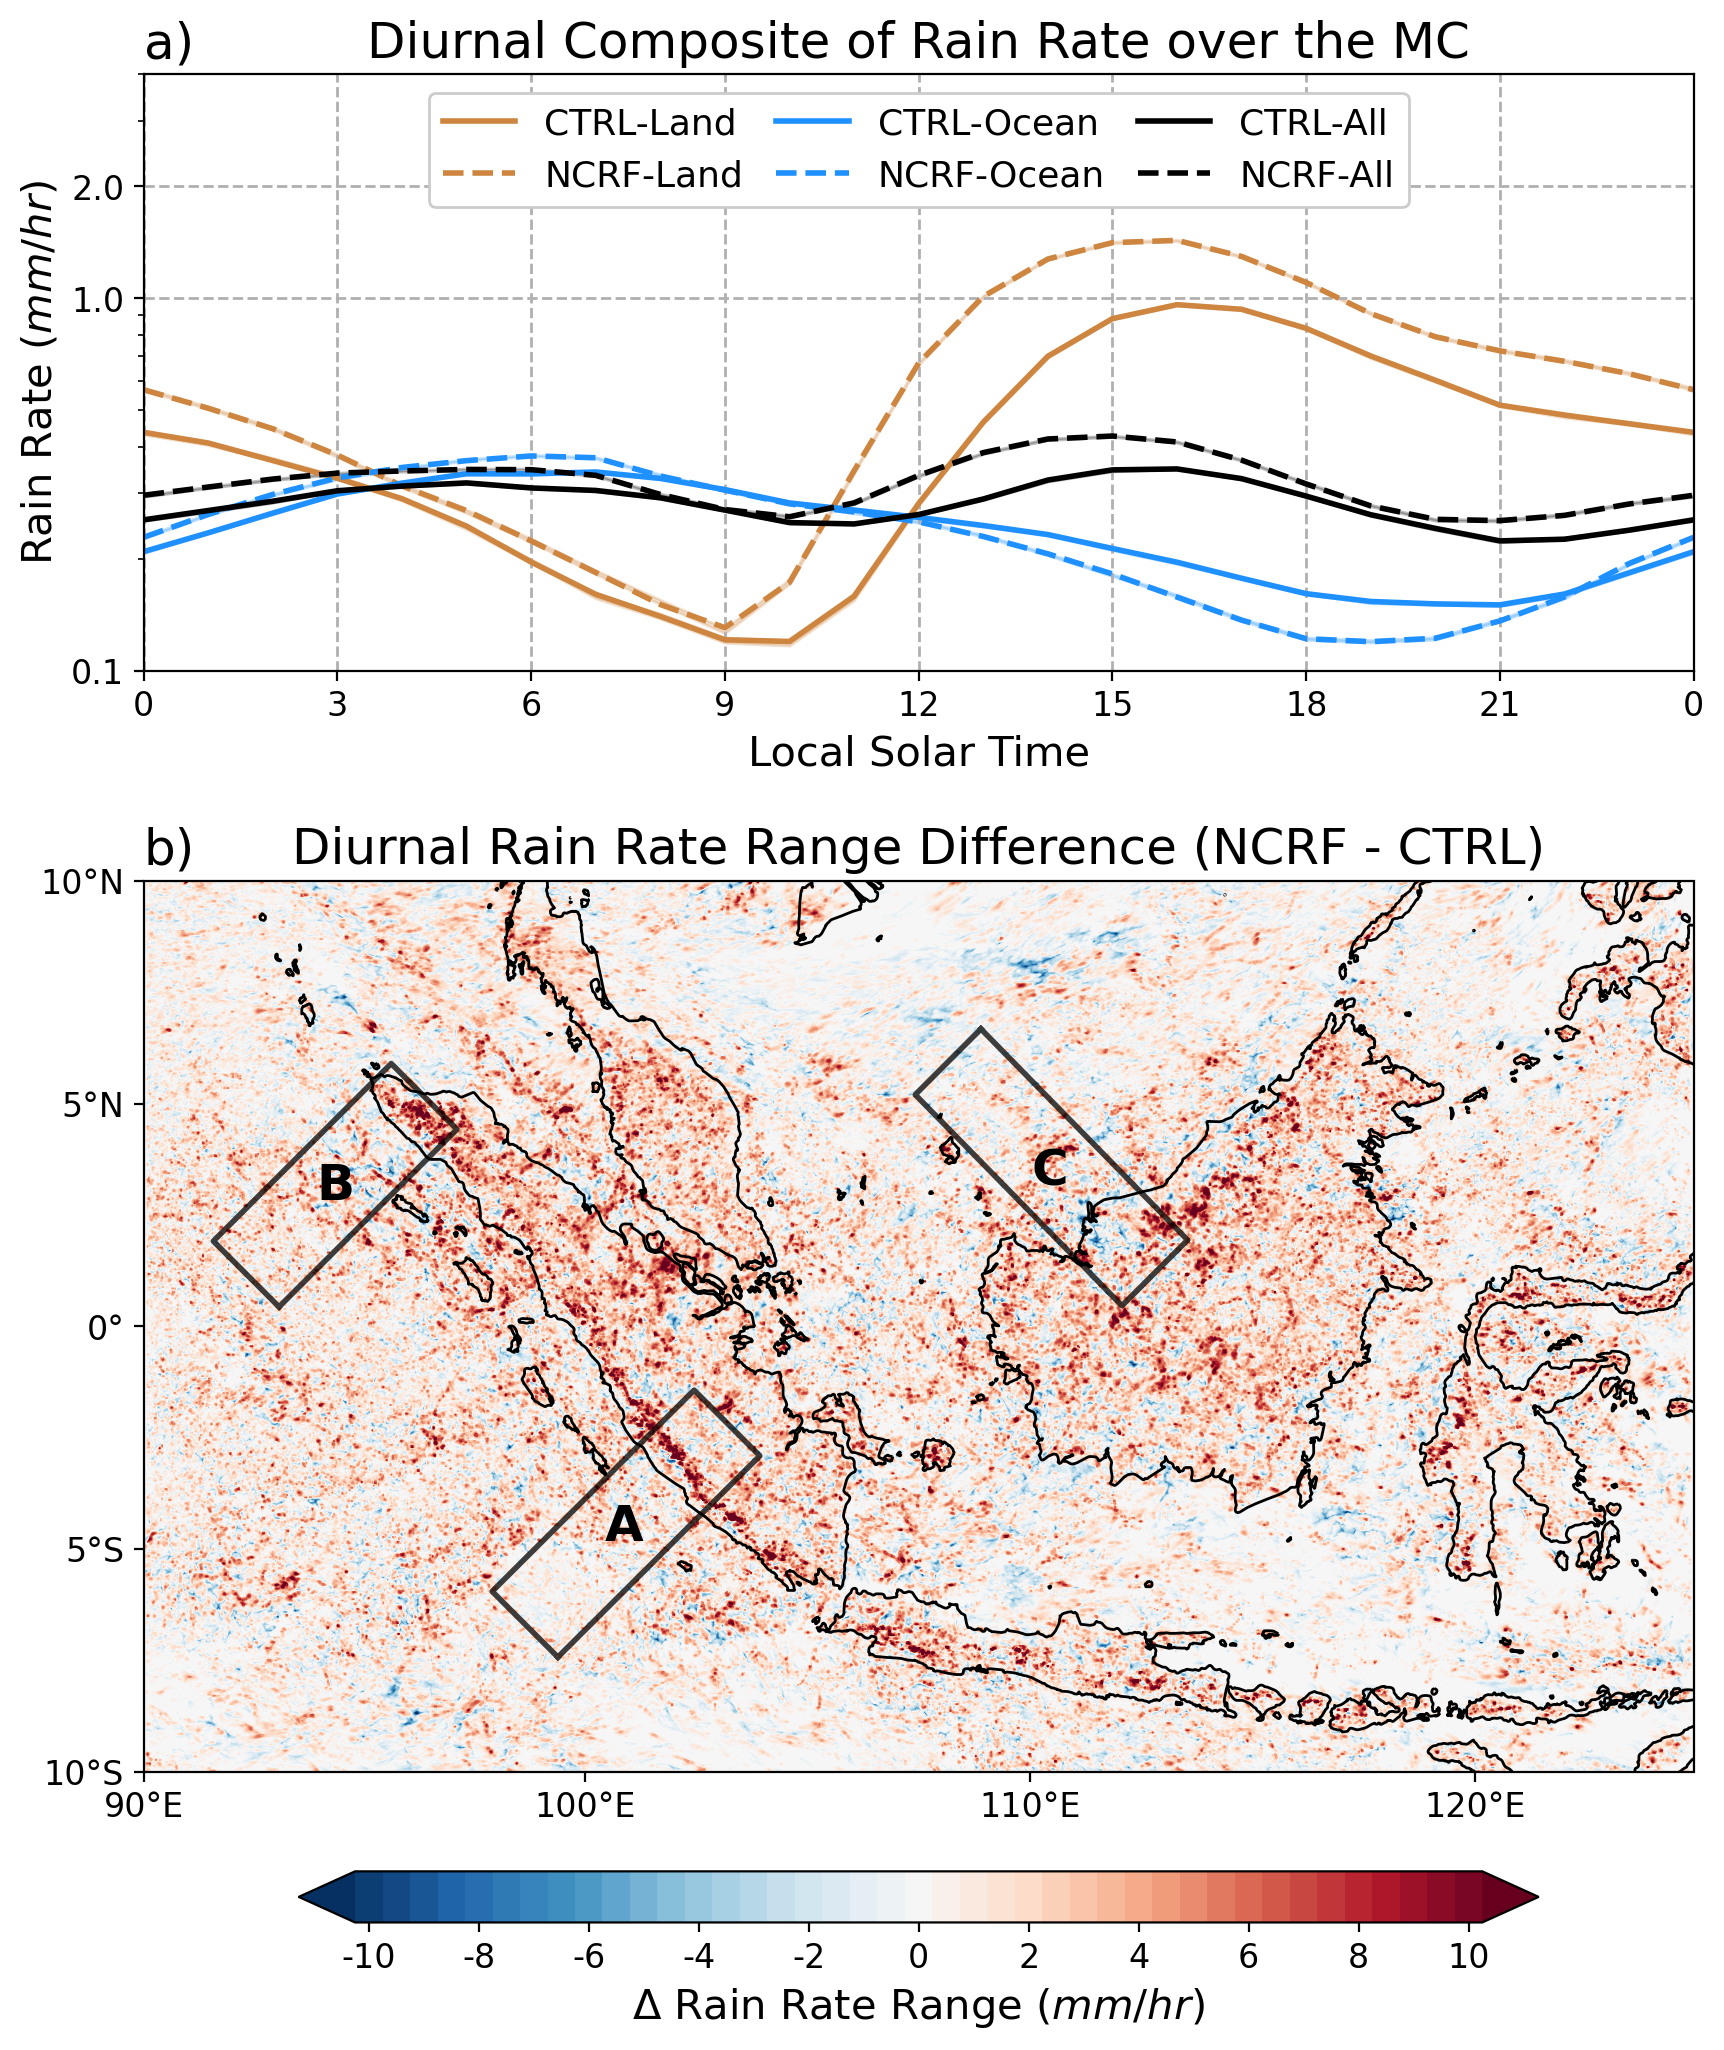

In [61]:
fig = plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(nrows=5, ncols=3, hspace=0, wspace=0, height_ratios=[.35,.075,.62,.01,.03], width_ratios=[.1,.8,.1])

ax1 = fig.add_subplot(gs[0,:])

fs = 18

# RR-land
l1 = RR_cntl_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='CTRL-Land'
)
l2 = RR_sunrise_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='NCRF-Land'
)
l3 = RR_cntl_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='CTRL-Ocean'
)
l4 = RR_sunrise_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='NCRF-Ocean'
)
l5 = RR_cntl_net.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='CTRL-All'
)
l6 = RR_sunrise_net.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '--',
	label='NCRF-All'
)

# Control
ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_cntl_net[0,:],sig_bars_cntl_net[0,0]), np.append(sig_bars_cntl_net[1,:],sig_bars_cntl_net[1,0]), alpha=.25, color='k')
ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_cntl_land[0,:],sig_bars_cntl_land[0,0]), np.append(sig_bars_cntl_land[1,:],sig_bars_cntl_land[1,0]), alpha=.25, color='peru')
ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_cntl_ocean[0,:],sig_bars_cntl_ocean[0,0]), np.append(sig_bars_cntl_ocean[1,:],sig_bars_cntl_ocean[1,0]), alpha=.25, color='dodgerblue')
# NCRF
ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_sunrise_net[0,:],sig_bars_sunrise_net[0,0]), np.append(sig_bars_sunrise_net[1,:],sig_bars_sunrise_net[1,0]), alpha=.25, color='k')
ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_sunrise_land[0,:],sig_bars_sunrise_land[0,0]), np.append(sig_bars_sunrise_land[1,:],sig_bars_sunrise_land[1,0]), alpha=.25, color='peru')
ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_sunrise_ocean[0,:],sig_bars_sunrise_ocean[0,0]), np.append(sig_bars_sunrise_ocean[1,:],sig_bars_sunrise_ocean[1,0]), alpha=.25, color='dodgerblue')

ax1.set_yscale('log')
ax1.set_xticks(np.arange(0,25,3))
ax1.set_yticks(np.array([.1,1,2]))
title = f'Diurnal Composite of Rain Rate over the MC'
ax1.set_title(title, fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax1.set_xlabel('Local Solar Time', fontsize=fs-3)
ax1.set_ylabel('Rain Rate ($mm/hr$)', fontsize=fs-3)
ax1.set_xticklabels(np.concatenate((np.arange(0,24,3),[0])), fontsize=fs-6)
ax1.set_yticklabels(np.array([.1,1,2]), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=3, fontsize=fs-5, loc='upper center', framealpha=1, columnspacing=.92)
ax1.set_xlim([0,24])
ax1.set_ylim([.1,4])

#####################################################################################################################
#####################################################################################################################
#####################################################################################################################

ax2 = fig.add_subplot(gs[2,:], projection=ccrs.PlateCarree(central_longitude=0))

levels = [-10, 10]
dl = .5

# # Multiply by the significance
# cf = (amplitude_RR_di_diff*amplitude_RR_di_diff.significance).plot.contourf(
#     ax=ax2,
#     add_colorbar=False,
#     cmap='RdBu_r',
#     # levels=np.arange(-10,11,1),
#     levels=np.arange(levels[0]-(dl/2),levels[1]+dl+(dl/2),dl),
#     vmin=levels[0], vmax=levels[1],
#     x='west_east',
#     y='south_north',
#     extend='both',
#     xlim=[lon_bound[0], lon_bound[1]],
#     ylim=[lat_bound[0], lat_bound[1]],
# )

# # Plot grey shading over areas where it's not significant
# cf2 =  (.6*(~amplitude_RR_di_diff.significance)).plot.contourf(
#     ax=ax2,
#     add_colorbar=False,
#     cmap='Greys',
#     levels=np.arange(0,1.5,.5),
#     vmin=0, vmax=1,
#     x='west_east',
#     y='south_north',
#     extend='neither',
#     alpha=.125,
#     xlim=[lon_bound[0], lon_bound[1]],
#     ylim=[lat_bound[0], lat_bound[1]],
# )

# No sig
cf = amplitude_RR_di_diff.plot.contourf(
    ax=ax2,
    add_colorbar=False,
    cmap='RdBu_r',
    # levels=np.arange(-10,11,1),
    levels=np.arange(levels[0]-(dl/2),levels[1]+dl+(dl/2),dl),
    vmin=levels[0], vmax=levels[1],
    x='west_east',
    y='south_north',
    extend='both',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
)


# plot_cross_lines(all_line_coords1,all_line_coords2,all_line_coords3,ax=ax2)
plot_cross_box(all_line_coords1,all_line_coords2,all_line_coords3,fs,alpha=.75,ax=ax2,color='k')

# Set parameters and labels
x_ticks = [90.1,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot the coast lines
ax2.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function

ax2.set_title('Diurnal Rain Rate Range Difference (NCRF - CTRL)', fontsize=fs, loc='center')
ax2.set_title('b)', loc='left', fontsize=fs)
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax2.set_yticks(y_ticks)
ax2.set_yticklabels(y_tick_labels, fontsize=fs-6)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xlim([90.1,124.9])

ax3 = fig.add_subplot(gs[4,1])
# cbar = plt.colorbar(cf, cax=ax3, orientation='horizontal', extend='both', ticks=np.arange(-10,12,2))
cbar = plt.colorbar(cf, cax=ax3, orientation='horizontal', extend='both', ticks=np.arange(levels[0],levels[1]+1,2))
cbar.set_ticklabels(np.arange(levels[0],levels[1]+1,2), fontsize=fs-6)
cbar.minorticks_off()
cbar.set_label('$\Delta$ Rain Rate Range ($mm/hr$)', fontsize=fs-3)

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/DC_HFXandRR.png', transparent=True)

Time and RR Range

In [ ]:
fig = plt.figure(figsize=(21,7))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[0.9,0.05], width_ratios=[0.33,0.33,0.33], hspace=0.3, wspace=0.1)

fs = 18

## Calculate linear regressions	##
domain = 'Ocean'
probability_density = True
fig.suptitle(f'Rain Rate Frequency Distribution over the MC {domain}', fontsize=fs+4)


if probability_density:
	c_levels = [10**-6,2*10**-4]
	c_dl = .001
else:
	c_levels = [0,5000]
	c_dl = 500

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	y_levels = np.append(0,np.logspace(-1, np.log10(100), num=60))
	y_dl = np.diff(y_levels)
	# Land
	x=local_time.flatten()[land_mask_3d.flatten()==1]
	y=RR_sunrise.values.flatten()[land_mask_3d.flatten()==1]
elif domain=='Ocean':
	y_levels = np.append(0,np.logspace(-1, np.log10(100), num=60))
	y_dl = np.diff(y_levels)
	c_levels = [10**-6,10**-4]
	c_dl = .0002
	# Ocean
	x=local_time.flatten()[land_mask_3d.flatten()==0]
	y=RR_sunrise.values.flatten()[land_mask_3d.flatten()==0]
elif domain=='Net':
	# Net
	x=local_time.flatten()[(land_mask_3d.flatten()==0)|(land_mask_3d.flatten()==1)]
	y=RR_sunrise.values.flatten()[(land_mask_3d.flatten()==0)|(land_mask_3d.flatten()==1)]

## Plot linear regressions	##
if domain=='Land':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), y_levels], density=probability_density)
	H_di_sunrise = H_di_sunrise*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), y_levels], density=probability_density)
	H_di_sunrise = H_di_sunrise*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), y_levels], density=probability_density)
	H_di_sunrise = H_di_sunrise*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_title('NCRF Sunrise', fontsize=fs, loc='center')
ax1.set_title(f'n={len(x)}', fontsize=fs-8, loc='right')
ax1.set_ylabel('Rain Rate ($mm/hr$)',fontsize=fs-6)
ax1.set_xlabel('Local Solar Time',fontsize=fs-6)
ax1.set_xticks(np.arange(0,25,3))
ax1.set_xlim([0,23])
ax1.set_ylim([y_levels[1],y_levels[-1]])
ax1.set_yscale('log')
ax1.grid(linestyle='--', axis='both', linewidth=1)


# Control
ax2 = fig.add_subplot(gs[0,1])

if domain=='Land':
	# Land
	x=local_time.flatten()[land_mask_3d.flatten()==1]
	y=RR_cntl.values.flatten()[land_mask_3d.flatten()==1]
elif domain=='Ocean':
	# Ocean
	x=local_time.flatten()[land_mask_3d.flatten()==0]
	y=RR_cntl.values.flatten()[land_mask_3d.flatten()==0]
elif domain=='Net':
	# Net
	x=local_time.flatten()[(land_mask_3d.flatten()==1)|(land_mask_3d.flatten()==0)]
	y=RR_cntl.values.flatten()[(land_mask_3d.flatten()==1)|(land_mask_3d.flatten()==0)]


if domain=='Land':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), y_levels], density=probability_density)
	H_di_cntl = H_di_cntl*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), y_levels], density=probability_density)
	H_di_cntl = H_di_cntl*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), y_levels], density=probability_density)
	H_di_cntl = H_di_cntl*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax2.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax2.set_title('Control', fontsize=fs, loc='center')
ax2.set_title(f'n={len(x)}', fontsize=fs-8, loc='right')
ax2.set_ylabel('',fontsize=fs-6)
ax2.set_xlabel('Local Solar Time',fontsize=fs-6)
ax2.set_xticks(np.arange(0,25,3))
ax2.set_xlim([0,23])
ax2.set_ylim([y_levels[1],y_levels[-1]])
ax2.set_yscale('log')
ax2.grid(linestyle='--', axis='both', linewidth=1)

# Colorbar
ax4 = fig.add_subplot(gs[1,0:2])
if probability_density:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([10**-6,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency', fontsize=fs-6)
else:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')


if probability_density:
	c_levels = [-10**-4,10**-4]
	c_dl = 10**-5
else:
	c_levels = [0,5000]
	c_dl = 500
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])

if domain=='Land':
	cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-6, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
	cc = ax3.contour(X[1:,1:]-0.5,Y[1:,1:], H_di_cntl.T, colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-6, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(-5, -3, num=10), vmin=10**-5, vmax=.01)
elif domain=='Ocean':
	cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-6, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
	cc = ax3.contour(X[1:,1:]-0.5,Y[1:,1:], H_di_cntl.T, colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-6, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(-6, -4, num=10), vmin=10**-6, vmax=.01)
elif domain=='Net':
	cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-6, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
	cc = ax3.contour(X[1:,1:]-0.5,Y[1:,1:], H_di_cntl.T, colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-6, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(-5, -3, num=10), vmin=10**-5, vmax=.01)
	
ax3.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax3.set_title('NCRF Sunrise - Control', fontsize=fs, loc='center')
ax3.set_ylabel('',fontsize=fs-6)
ax3.set_xlabel('Local Solar Time', fontsize=fs-6)
ax3.set_xticks(np.arange(0,25,3))
ax3.set_xlim([0,23])
ax3.set_ylim([y_levels[1],y_levels[-1]])
ax3.set_yscale('log')
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[1,2])
if probability_density:
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,-10**-6,0,10**-6,10**-5,10**-4]))
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-6)
else:
	cbar.set_label('Frequency')

Max RR Time and RR Range

In [ ]:
fig = plt.figure(figsize=(21,7))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[0.9,0.05], width_ratios=[0.33,0.33,0.33], hspace=0.3, wspace=0.1)

fs = 18

domain = 'Land'
probability_density = True
fig.suptitle(f'Diurnal RR Range & Maximum Time over the MC {domain}', fontsize=fs+4)


if probability_density:
	c_levels = [10**-5,10**-2]
	c_dl = .001
else:
	c_levels = [0,5000]
	c_dl = 500

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	y_levels = np.append(0,np.logspace(-1, np.log10(50), num=60))
	y_dl = np.diff(y_levels)
	# Land
	x=phase_max_di_sunrise_land.values.flatten()[~np.isnan(phase_max_di_sunrise_land.values.flatten())]
	y=amplitude_RR_di_sunrise_land.values.flatten()[~np.isnan(phase_max_di_sunrise_land.values.flatten())]
elif domain=='Ocean':
	y_levels = np.append(0,np.logspace(-1, np.log10(50), num=60))
	y_dl = np.diff(y_levels)
	# Ocean
	x=phase_max_di_sunrise_ocean.values.flatten()[~np.isnan(phase_max_di_sunrise_ocean.values.flatten())]
	y=amplitude_RR_di_sunrise_ocean.values.flatten()[~np.isnan(phase_max_di_sunrise_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=local_time.flatten()[(land_mask_3d.flatten()==0)|(land_mask_3d.flatten()==1)]
	y=RR_sunrise.values.flatten()[(land_mask_3d.flatten()==0)|(land_mask_3d.flatten()==1)]

## Plot linear regressions	##
if domain=='Land':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), y_levels], density=probability_density)
	H_di_sunrise = H_di_sunrise*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), y_levels], density=probability_density)
	H_di_sunrise = H_di_sunrise*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), y_levels], density=probability_density)
	H_di_sunrise = H_di_sunrise*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_title('NCRF Sunrise', fontsize=fs, loc='center')
ax1.set_title(f'n={len(x)}', fontsize=fs-8, loc='right')
ax1.set_ylabel('Rain Rate Range ($mm/hr$)',fontsize=fs-6)
ax1.set_xlabel('Maximum Local Solar Time',fontsize=fs-6)
ax1.set_xticks(np.arange(0,25,3))
ax1.set_xlim([0,23])
ax1.set_ylim([y_levels[1],y_levels[-1]])
ax1.set_yscale('log')
ax1.grid(linestyle='--', axis='both', linewidth=1)


# Control
ax2 = fig.add_subplot(gs[0,1])

if domain=='Land':
	# Land
	x=phase_max_di_cntl_land.values.flatten()[~np.isnan(phase_max_di_cntl_land.values.flatten())]
	y=amplitude_RR_di_cntl_land.values.flatten()[~np.isnan(phase_max_di_cntl_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=phase_max_di_cntl_ocean.values.flatten()[~np.isnan(phase_max_di_cntl_ocean.values.flatten())]
	y=amplitude_RR_di_cntl_ocean.values.flatten()[~np.isnan(phase_max_di_cntl_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=local_time.flatten()[(land_mask_3d.flatten()==1)|(land_mask_3d.flatten()==0)]
	y=RR_cntl.values.flatten()[(land_mask_3d.flatten()==1)|(land_mask_3d.flatten()==0)]


if domain=='Land':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), y_levels], density=probability_density)
	H_di_cntl = H_di_cntl*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), y_levels], density=probability_density)
	H_di_cntl = H_di_cntl*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), y_levels], density=probability_density)
	H_di_cntl = H_di_cntl*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax2.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax2.set_title('Control', fontsize=fs, loc='center')
ax2.set_title(f'n={len(x)}', fontsize=fs-8, loc='right')
ax2.set_ylabel('',fontsize=fs-6)
ax2.set_xlabel('Maximum Local Solar Time',fontsize=fs-6)
ax2.set_xticks(np.arange(0,25,3))
ax2.set_xlim([0,23])
ax2.set_ylim([y_levels[1],y_levels[-1]])
ax2.set_yscale('log')
ax2.grid(linestyle='--', axis='both', linewidth=1)

# Colorbar
ax4 = fig.add_subplot(gs[1,0:2])
if probability_density:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([10**-6,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency', fontsize=fs-6)
else:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')


if probability_density & (domain=='Land'):
	c_levels = [-10**-2,10**-2]
	c_dl = 10**-5
elif probability_density & (domain=='Ocean'):
	c_levels = [-10**-2,10**-2]
	c_dl = 10**-5
else:
	c_levels = [0,5000]
	c_dl = 500
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])

if domain=='Land':
	cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-5, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
	cc = ax3.contour(X[1:,1:]-0.5,Y[1:,1:], H_di_cntl.T, colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-5, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(-5, -2, num=10), vmin=10**-5, vmax=.01)
elif domain=='Ocean':
	cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-5, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
	cc = ax3.contour(X[1:,1:]-0.5,Y[1:,1:], H_di_cntl.T, colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-5, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(-5, -2, num=10), vmin=10**-5, vmax=.01)
elif domain=='Net':
	cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-6, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
	cc = ax3.contour(X[1:,1:]-0.5,Y[1:,1:], H_di_cntl.T, colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-6, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(-5, -3, num=10), vmin=10**-5, vmax=.01)
	
ax3.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax3.set_title('NCRF Sunrise - Control', fontsize=fs, loc='center')
ax3.set_ylabel('',fontsize=fs-6)
ax3.set_xlabel('Maximum Local Solar Time', fontsize=fs-6)
ax3.set_xticks(np.arange(0,25,3))
ax3.set_xlim([0,23])
ax3.set_ylim([y_levels[1],y_levels[-1]])
ax3.set_yscale('log')
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[1,2])
if probability_density & (domain=='Land'):
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,-10**-4,-10**-5,0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-6)
elif probability_density & (domain=='Ocean'):
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,-10**-4,-10**-5,0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-6)
else:
	cbar.set_label('Frequency')

Figure 2. Initiation Timing Difference

In [62]:
# Find the time it rains more than the set threshold rain rate while rain rate is increasing d(RR)/dt>0, this assumes 1 diurnal peak
	# Find rain rates >= threshold_RR, sort it going from lowest to highest, and extract the first index/hour
threshhold_RR = 1		# mm/hr
threshold_dRRdt = 0

#################################### Control ####################################

dRR_dt = xr.concat([RR_di_cntl,RR_di_cntl[0]], dim='hour').diff(dim='hour')
RR_above_thresh = xr.where((RR_di_cntl>=threshhold_RR)&(dRR_dt>threshold_dRRdt), RR_di_cntl, 999).values
initiation_hours = np.argsort(RR_above_thresh,axis=0)[0,:,:]
# If the RR is the fill value AND it is the first index of time, it is an area that did not recieve > threshold_RR rain rate
phase_initiation_di_cntl = np.where((RR_above_thresh[0,:,:]==999)&(initiation_hours==0), np.nan, initiation_hours)
phase_initiation_di_cntl = xr.DataArray(
	data=phase_initiation_di_cntl,
	dims=['south_north','west_east'],
	coords=dict(
		south_north = ('south_north', d02_coords['south_north'][1]),
		west_east = ('west_east', d02_coords['west_east'][1])),
)
phase_initiation_di_cntl_land = xr.where(da_d02_LANDMASK==1,phase_initiation_di_cntl,np.nan)
phase_initiation_di_cntl_ocean = xr.where(da_d02_LANDMASK==0,phase_initiation_di_cntl,np.nan)

# Figures out when the max di rain rate occured at each lat lon
phase_max_di_cntl_land = xr.where(da_d02_LANDMASK==1,RR_di_cntl.idxmax(dim='hour'),np.nan)
phase_max_di_cntl_ocean = xr.where(da_d02_LANDMASK==0,RR_di_cntl.idxmax(dim='hour'),np.nan)


#################################### Sunrise ####################################

dRR_dt = xr.concat([RR_di_sunrise,RR_di_sunrise[0]], dim='hour').diff(dim='hour')
RR_above_thresh = xr.where((RR_di_sunrise>=threshhold_RR)&(dRR_dt>threshold_dRRdt), RR_di_sunrise, 999).values
initiation_hours = np.argsort(RR_above_thresh,axis=0)[0,:,:]
# If the RR is the fill value AND it is the first index of time, it is an area that did not recieve >threshold_RR rain rate
phase_initiation_di_sunrise = np.where((RR_above_thresh[0,:,:]==999)&((initiation_hours==0)), np.nan, initiation_hours)
phase_initiation_di_sunrise = xr.DataArray(
	data=phase_initiation_di_sunrise,
	dims=['south_north','west_east'],
	coords=dict(
		south_north = ('south_north', d02_coords['south_north'][1]),
		west_east = ('west_east', d02_coords['west_east'][1])),
)
phase_initiation_di_sunrise_land = xr.where(da_d02_LANDMASK==1,phase_initiation_di_sunrise,np.nan)
phase_initiation_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0,phase_initiation_di_sunrise,np.nan)

# Figures out when the max di rain rate occured at each lat lon
phase_max_di_sunrise_land = xr.where(da_d02_LANDMASK==1,RR_di_sunrise.idxmax(dim='hour'),np.nan)
phase_max_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0,RR_di_sunrise.idxmax(dim='hour'),np.nan)

# Difference
phase_initiation_di_diff = phase_initiation_di_sunrise - phase_initiation_di_cntl

# # When taking the difference of times, you need to make sure the distribution is between -12->11 or -11->12
# 	# depending on the order of the difference
# phase_initiation_diff_adj = xr.where((phase_initiation_diff<=-12), phase_initiation_diff+24, phase_initiation_diff)
# phase_initiation_diff_adj = xr.where((phase_initiation_diff>=13), phase_initiation_diff-24, phase_initiation_diff_adj)

# Updated more generalized method. values will be between -11 and 12 using this method.
phase_initiation_di_diff_adj = ((phase_initiation_di_diff+24) % 24)
phase_initiation_di_diff_adj = xr.where(phase_initiation_di_diff_adj>12, phase_initiation_di_diff_adj-24, phase_initiation_di_diff_adj)

phase_initiation_di_diff_adj_land = xr.where(da_d02_LANDMASK==1,phase_initiation_di_diff_adj,np.nan)
phase_initiation_di_diff_adj_ocean = xr.where(da_d02_LANDMASK==0,phase_initiation_di_diff_adj,np.nan)

In [63]:
## Bootstrap
def bootstrap_initiation(da, N):

	probability_density = True		# Normalize, make sure bins are 1 apart

	values = da.values.flatten()

	values = values[~np.isnan(values)]

	sig_bars = np.empty( (2, len(np.arange(-13,14,1))-1) )	# Significant bounds

	samples = []
	for n in range(N):
		rand_data = np.random.choice(a=values, size=len(values), replace=True)
		results, _ = np.histogram(rand_data, bins=np.arange(-13,14,1), density=probability_density)
		samples.append(results)

	samples = np.array(samples)
	samples = np.sort(samples, axis=0)		# Sorts over N

	sig_bars[0]=samples[int(np.floor(len(samples)*.025))]	# Lower 2.5% significance
	sig_bars[1]=samples[int(np.ceil(len(samples)*.975))]	# Upper 97.5% significance
	
	return sig_bars

sig_bars_net = bootstrap_initiation(phase_initiation_di_diff_adj, N=100)
sig_bars_ocean = bootstrap_initiation(phase_initiation_di_diff_adj_ocean, N=100)
sig_bars_land = bootstrap_initiation(phase_initiation_di_diff_adj_land, N=100)

In [ ]:
probability_density = True
fs = 18
b = plt.hist(phase_initiation_di_diff_adj_ocean.values.flatten(),bins=np.arange(-13.5,14.5,1), label=f'Ocean n = {np.nansum(~np.isnan(phase_initiation_di_diff_adj_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue', linewidth=2)
a = plt.hist(phase_initiation_di_diff_adj.values.flatten(),bins=np.arange(-13.5,14.5,1), label=f'Net n = {np.nansum(~np.isnan(phase_initiation_di_diff_adj.values.flatten()))}',density=probability_density, histtype='step', color='k', linewidth=2)
c = plt.hist(phase_initiation_di_diff_adj_land.values.flatten(),bins=np.arange(-13.5,14.5,1), label=f'Land n = {np.nansum(~np.isnan(phase_initiation_di_diff_adj_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linewidth=2)

# plt.title(f'Diurnal Initiation Timing Difference (NCRF - CNTL)\n Rolling n: {rolls}, Threshold: >{threshhold_RR}mm/hr')
# plt.title(f'Diurnal Initiation Timing Difference (NCRF - CNTL)\n Threshold: >{threshhold_RR}mm/hr', fontsize=fs-4)
plt.title(f'Diurnal Initiation Timing Difference (NCRF - CNTL)', fontsize=fs-4)
plt.xlabel('$\Delta$ Hours', fontsize=fs-3)
plt.xticks(np.arange(-12,14,2), fontsize=fs-6)
plt.xlim([-10,10])
plt.yticks(np.arange(0,.30,.05), fontsize=fs-6)
# plt.legend(fontsize=fs-6, loc='upper right', framealpha=1)
# Reordering legend manually
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 0, 1]  # Indices for "Land", "Ocean", "Net"
plt.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    fontsize=fs - 6,
    loc='upper right',
    framealpha=1,
)

if probability_density:
	plt.ylabel('Fractional count', fontsize=fs-3)
	plt.ylim([0,.25])
else: 
	plt.ylabel('# of grids', fontsize=fs-3)

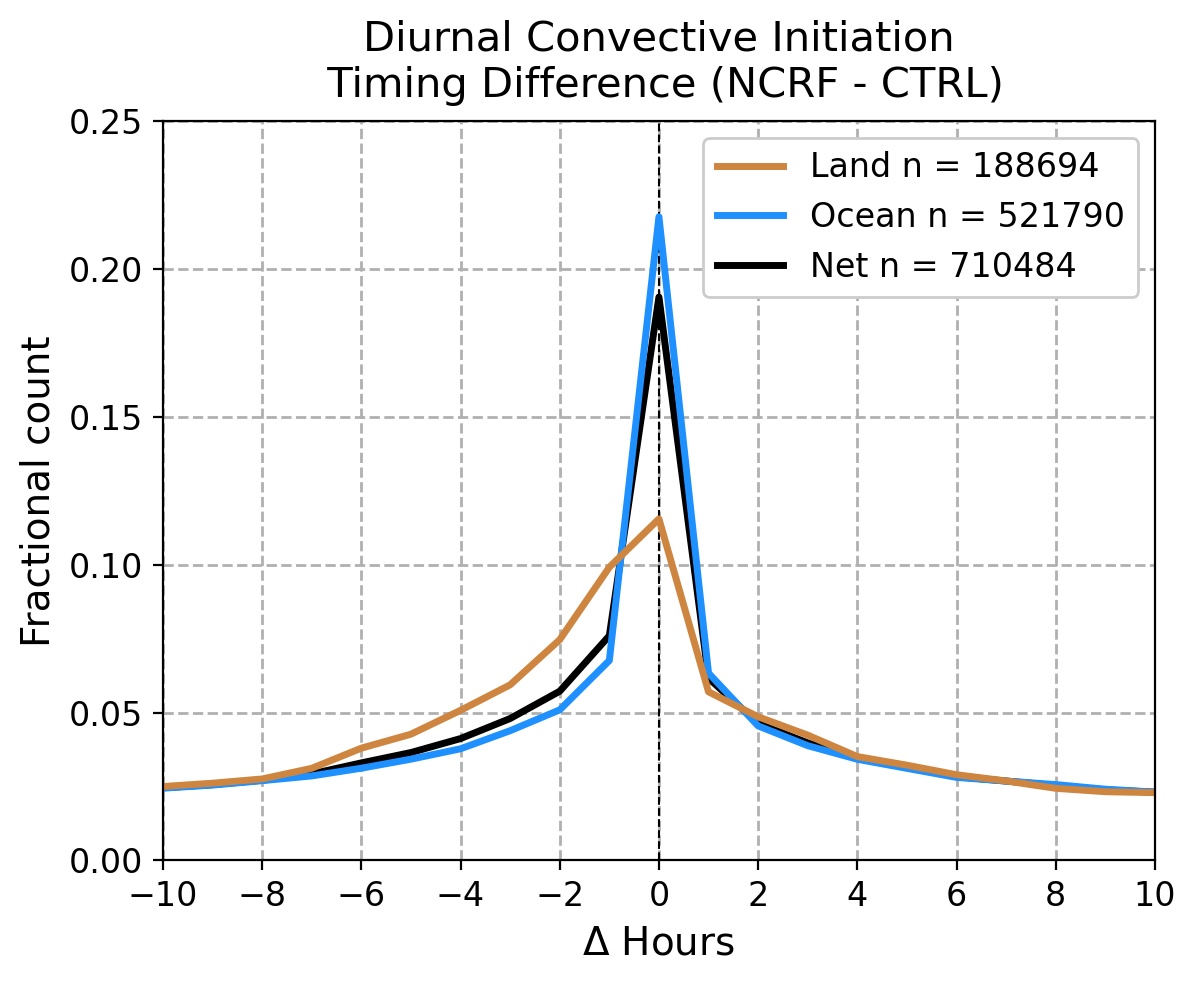

In [77]:
probability_density = True
fs = 18

plt.axvline(x=0, color='k', linestyle='--', linewidth=.75)
plt.grid(linestyle='--', axis='both', linewidth=1)

a = np.histogram(phase_initiation_di_diff_adj.values.flatten(), bins=np.arange(-13,14,1), density=probability_density)
b = np.histogram(phase_initiation_di_diff_adj_ocean.values.flatten(), bins=np.arange(-13,14,1), density=probability_density)
c = np.histogram(phase_initiation_di_diff_adj_land.values.flatten(), bins=np.arange(-13,14,1), density=probability_density)

a1 = plt.plot(a[1][:-1], a[0], color='k', linewidth=2.5, label=f'Net n = {np.nansum(~np.isnan(phase_initiation_di_diff_adj.values.flatten()))}')
b1 = plt.plot(b[1][:-1], b[0], color='dodgerblue', linewidth=2.5, label=f'Ocean n = {np.nansum(~np.isnan(phase_initiation_di_diff_adj_ocean.values.flatten()))}')
c1 = plt.plot(c[1][:-1], c[0], color='peru', linewidth=2.5, label=f'Land n = {np.nansum(~np.isnan(phase_initiation_di_diff_adj_land.values.flatten()))}')

# Bootstrapping
# plt.fill_between(a[1][:], np.append(sig_bars_net[0,:],sig_bars_net[0,0]), np.append(sig_bars_net[1,:],sig_bars_net[1,0]), alpha=.5, color='k', linewidth=.5)
# plt.fill_between(b[1][:], np.append(sig_bars_ocean[0,:],sig_bars_ocean[0,0]), np.append(sig_bars_ocean[1,:],sig_bars_ocean[1,0]), alpha=.5, color='dodgerblue', linewidth=.5)
# plt.fill_between(c[1][:], np.append(sig_bars_land[0,:],sig_bars_land[0,0]), np.append(sig_bars_land[1,:],sig_bars_land[1,0]), alpha=.5, color='peru', linewidth=.5)


# plt.title(f'Diurnal Initiation Timing Difference (NCRF - CTRL)\n Threshold: >{threshhold_RR}mm/hr', fontsize=fs-4)
plt.title(f'Diurnal Convective Initiation\n Timing Difference (NCRF - CTRL)', fontsize=fs-3, y=1.01)
plt.xlabel('$\Delta$ Hours', fontsize=fs-4)
plt.xticks(np.arange(-12,14,2), fontsize=fs-6)
plt.xlim([-10,10])
plt.yticks(np.arange(0,.30,.05), fontsize=fs-6)
# plt.legend(fontsize=fs-6, loc='upper right', framealpha=1)
# Reordering legend manually
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 1, 0]  # Indices for "Land", "Ocean", "Net"
plt.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    fontsize=fs - 6,
    loc='upper right',
    framealpha=1,
)

if probability_density:
	plt.ylabel('Fractional count', fontsize=fs-4)
	plt.ylim([0,.25])
else: 
	plt.ylabel('# of grids', fontsize=fs-4)

Figure N/A. Rain rate hovmoller w.r.t. distance from coast with off-shore propagation speed arrows

In [ ]:
from scipy.ndimage import gaussian_filter
from scipy.ndimage import label, sum as ndi_sum

## Removes small clusters

def remove_small_clusters(matrix, min_cluster_size):
    # Label the connected components (clusters) in the matrix 
    labeled_matrix, num_features = label(matrix)

    # Calculate the size of each cluster
    cluster_sizes = ndi_sum(matrix, labeled_matrix, index=np.arange(1, num_features + 1))

    # Remove clusters smaller than the min_cluster_size
    for cluster_num, size in enumerate(cluster_sizes, start=1):
        if size < min_cluster_size:
            matrix[labeled_matrix == cluster_num] = 0

    return matrix, cluster_sizes

## Calculates speed of clusters of rain rate
def calculate_speed_feature_tracking(rain_rate, time_step, distance_step, smooth_sigma, threshold, min_cluster_size, max_gap, valid_gap):
    """
    Estimates the speed of propagating rain rate signals in a Hovmöller diagram
    by tracking the motion of peak or threshold-defined features.

    Parameters:
        rain_rate (2D array): Hovmöller diagram of rain rate (time x distance).
        time_step (float): Time resolution in the input data (e.g., hours or seconds).
        distance_step (float): Spatial resolution of distance from the coast (e.g., km).
        smooth_sigma (float): Standard deviation for Gaussian smoothing.
        threshold (float): Rain rate value to track; defaults to 50% of the maximum rain rate.
        min_cluster_size (int): Minimum number of connected indices to count as a valid feature.
        max_gap (int): Maximum distance (in indices) to consider indices part of the same cluster.

    Returns:
        float: Estimated average propagation speed (e.g., km per hour).

    Process:
        Smooth rain rate data to reduce noise
        Start time loop
            Identify indicies over distance from coast that pass the RR threshold determined by 'threshold'
            Cluster the RR indicies if they are close together determined by 'max_gap'
            Filter out small clusters of RR determined by 'min_cluster_size'
            Determine the closest cluster to the previous cluster if applicable, 
                else the location of the cluster will be assigned based on the size and RR intensity
        Determine the speed of the clusters based on the previous cluster position

    """
    # Smooth the data to reduce noise and enhance feature detection
    smoothed_data = gaussian_filter(rain_rate, sigma=(0,smooth_sigma))   # where 0 represents time smooth which should be none

    # Determine the threshold value below if using a relative percentage
    abs_threshold = threshold  # mm/hr
    smoothed_data = np.where(smoothed_data>=abs_threshold, smoothed_data, 0)

    # Remove small clusters
    smoothed_data, na = remove_small_clusters(smoothed_data, min_cluster_size=100)
    
    # Initialize an array to store feature positions (indices)
    feature_positions = []

    # Track the previous feature position for continuity
    prev_position = None

    for t in range(smoothed_data.shape[0]): # Loop over time
        row = smoothed_data[t, :]
        
        # Find indices that pass the threshold
        threshold_indices = np.where(row >= abs_threshold)[0]
        
        # Group indices into clusters based on proximity (max_gap)
        if len(threshold_indices) > 0:
            clusters = []
            cluster = [threshold_indices[0]]
            for i in range(1, len(threshold_indices)):
                # If RR is close together, add it to the cluster
                if threshold_indices[i] - threshold_indices[i - 1] <= max_gap:
                    cluster.append(threshold_indices[i])
                # If RR is too far apart, append the last cluster and create a new one.
                else:
                    clusters.append(cluster)
                    cluster = [threshold_indices[i]]
            clusters.append(cluster)  # Add the last cluster
            
            # Filter out small clusters
            clusters = [c for c in clusters if len(c) >= min_cluster_size]

            # If clusters exist
            if len(clusters) > 0:
                # If there's a previous position, find the closest cluster to it
                    # 'prev_position' is the cluster index from the previous timestep
                if (prev_position is not None):

                    # Take the middle of the mean as the next cluster point.
                    closest_cluster = clusters[np.argmin([abs(np.mean(c) - prev_position) for c in clusters])]

                else:
                    # Otherwise, just take the largest cluster by size
                    # closest_cluster = max(clusters, key=len)

                    # Otherwise, combine size and intensity (using weighted sum or normalization)
                        # Adjust these weights if needed
                    size_weight = .5
                    intensity_weight = .5
                    closest_cluster = max(clusters, key=lambda c: size_weight * len(c) + intensity_weight * np.mean(row))
                
                # Find the center of the cluster by size
                # feature_index = np.mean(closest_cluster)  # Average position of the selected cluster
                
                # Find the center of the cluster weighted by intensity
                norm_cluster_RR = row[closest_cluster]/row[closest_cluster].max()
                feature_index = np.sum(closest_cluster*norm_cluster_RR) / np.sum(norm_cluster_RR)

            else:
                feature_index = np.nan  # No valid clusters
        else:
            feature_index = np.nan  # No indices pass the threshold

        # Save the feature position and update the previous position
        feature_positions.append(feature_index)
        prev_position = feature_index

    # Convert indices to distances
    feature_positions = np.array(feature_positions) * distance_step
    
    # Calculate displacements (differences in position between consecutive time steps)
    displacements = np.diff(feature_positions)
    
    # Exclude NaN values (missing features) from the calculation
    # valid_displacements = displacements[~np.isnan(displacements)]
    valid_displacements = displacements

    # If the difference is beyond what would make sense as propagation, make it a new cluster
    valid_displacements = np.where((valid_displacements>valid_gap*distance_step)|(valid_displacements<-valid_gap*distance_step), 0, valid_displacements)
    
    # Calculate the speed for each displacement
    speeds = valid_displacements / time_step  # Distance/time gives speed
    
    # Return the average propagation speed
    # return np.nanmean(speeds) if len(speeds) > 0 else np.nan
    return speeds, feature_positions, na


# Rain rate data
x1 = da_d02_cross_RR_cntl.sel(Time=slice('2015-11-23T00','2015-12-03T00'), Distance=da_d02_cross_RR_cntl['Distance']>=0)
x1 = x1.mean('Spread')
	# 00 UTC icloud off
x2 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2), Distance=da_d02_cross_RR_CRFoff['Distance']>=0).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
	# 12 UTC icloud off
x3 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(1,18,2), Distance=da_d02_cross_RR_CRFoff['Distance']>=0).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x3 = x3.mean('Spread')

# time_step = 3600   # seconds
# distance_step = x1['Distance'].diff(dim='Distance').mean().values*1000   # [m]
time_step = 1   # hour
distance_step = x1['Distance'].diff(dim='Distance').mean().values   # [km]
smooth_sigma = 5
if cross_dir=='Sumatra_northwest':
    threshold = 1.5
else:
    threshold = 2 # mm/hr     , 1.5 for sumatra NW

# Below are indicies apart, so multiple by distance_step (~4.25km) to compute distance apart
min_cluster_size = 3    # Minimum cluster size must be met
# max_gap = 5             # Clusters close together can become one
# valid_gap = 24          # How far a cluster can propagate before it is considered a new cluster
max_gap = 60             # Clusters close together can become one
valid_gap = 42          # How far a cluster can propagate before it is considered a new cluster

# speeds are in km/timestep, where timestep here is an hour
# pos is in kilometers
speeds1, pos1, na1 = calculate_speed_feature_tracking(x1, time_step, distance_step, smooth_sigma, threshold, min_cluster_size, max_gap, valid_gap)
speeds2, pos2, na2 = calculate_speed_feature_tracking(x2, time_step, distance_step, smooth_sigma, threshold, min_cluster_size, max_gap, valid_gap)
speeds3, pos3, na3 = calculate_speed_feature_tracking(x3, time_step, distance_step, smooth_sigma, threshold, min_cluster_size, max_gap, valid_gap)

## Post process the speeds to ensure the data is correct
def clean_propagation_speeds(speeds, positions, min_t_propagation, min_dist_propagation, min_valid_gap=valid_gap):
    """
    Replaces propagation values with NaN if there aren't at least `min_t_propagation` valid values in a row.

    Parameters:
        speeds (np.array): 1D NumPy array with propagation speed values, where NaNs represent no propagation.
        min_consecutive (int): Minimum number of consecutive non-NaN values required to retain the values.

    Returns:
        np.array: Cleaned array with invalid propagation values replaced by NaN.
    """
    # Create a copy of the input array to avoid modifying the original
    cleaned_speeds = speeds.copy()

    # Remove negative propagation speeds
    cleaned_speeds[cleaned_speeds<-25] = np.nan
    
    # Identify valid (non-NaN) entries
    is_valid = ~np.isnan(speeds)
    
    # Find start and end indices of consecutive valid segments
    group_start = None
    for i in range(len(speeds)):
        if is_valid[i]:
            if group_start is None:
                group_start = i  # Start a new group
        else:
            if group_start is not None:
                # End the current group 
                    # and check if it's lasted min number of time steps AND if it propagated far enough
                if (((i - group_start) < min_t_propagation) | ((positions[i] - positions[group_start]) < min_dist_propagation)):
                    # Invalidate the entire group
                    cleaned_speeds[group_start:i] = np.nan
                group_start = None  # Reset the group
    
    # Handle the case where the array ends with a valid group
    if group_start is not None and len(speeds) - group_start < min_t_propagation:
        cleaned_speeds[group_start:] = np.nan
    
    return cleaned_speeds

# Clusters must have lasted a few hours and propagated over a set distance before being counterd
min_t_propagation = 3       # [hrs]
min_dist_propagation = 50   # [km]
speeds1 = clean_propagation_speeds(speeds1, pos1, min_t_propagation, min_dist_propagation)
speeds2 = clean_propagation_speeds(speeds2, pos2, min_t_propagation, min_dist_propagation)
speeds3 = clean_propagation_speeds(speeds3, pos3, min_t_propagation, min_dist_propagation)


# # Convert km/hr to m/s
# print(f'The average propagation speed over {cross_title},\nControl:{np.round(np.nanmean(speeds1)*.277, 2)}m/s, n={np.sum(~np.isnan(speeds1))}\nSunrise:{np.round(np.nanmean(speeds2)*.277, 2)}m/s, n={np.sum(~np.isnan(speeds2))}\nSunset:{np.round(np.nanmean(speeds3)*.277, 2)}m/s, n={np.sum(~np.isnan(speeds3))}')
# print(f'\nThe median propagation speed over {cross_title},\nControl:{np.round(np.nanmedian(speeds1)*.277, 2)}m/s\nSunrise:{np.round(np.nanmedian(speeds2)*.277, 2)}m/s\nSunset:{np.round(np.nanmedian(speeds3)*.277, 2)}m/s')

fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, height_ratios=[0.875,0.04], wspace=0.075, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fs = 20
title = 'Rain Rate Evolution over ' + cross_title

fig.suptitle(title, fontsize=26, y=.96)

# Load Data
	# Control
x1 = da_d02_cross_RR_cntl.sel(Time=slice('2015-11-23T00','2015-12-03T00'))
x1 = x1.mean('Spread')
x1.data = gaussian_filter(x1.values, sigma=(0,5))
x1 = xr.where(x1>threshold, x1, 0)
x1.data, _ = remove_small_clusters(x1.data, min_cluster_size=100)
	# 00 UTC icloud off
x2 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
x2.data = gaussian_filter(x2.values, sigma=(0,smooth_sigma))
x2 = xr.where(x2>threshold, x2, 0)
x2.data, _ = remove_small_clusters(x2.data, min_cluster_size=100)
	# 12 UTC icloud off
x3 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(1,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x3 = x3.mean('Spread')
x3.data = gaussian_filter(x3.values, sigma=(0,smooth_sigma))
x3 = xr.where(x3>threshold, x3, 0)
x3.data, _ = remove_small_clusters(x3.data, min_cluster_size=100)

## Try different scales:
# levs = np.append(0,np.logspace(np.log10(2), np.log10(10), num=100))
levs = np.logspace(np.log10(2), np.log10(10), num=100)
# levs = np.arange(2,10.1,0.1)


# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	# levels=np.arange(0,4.1,0.1),
    levels=levs,
    vmin=2,
    extend='max',
	cmap='gray_r',
)
# Plot propagation speed vectors
X,Y = pos1[:-1][~np.isnan(speeds1)], x1['Time'][:-1][~np.isnan(speeds1)].values
# U = (speeds1[~np.isnan(speeds1)]**2-(1/24))
U = np.where((speeds1<0) & (speeds1!=np.nan), -(np.sqrt(speeds1**2-(1/24))), np.sqrt((speeds1**2-(1/24))))
# U = np.where(U<0, -np.sqrt(U), np.sqrt(U))
U,V = speeds1[~np.isnan(speeds1)], np.ones(len(speeds1[~np.isnan(speeds1)]))/24
# V = np.ones(len(speeds1[~np.isnan(speeds1)]))/24
ax1.quiver(X, Y, U, V, color='red', alpha=.6, scale=1, scale_units='xy', angles='xy')


# 00 UTC icloud=0
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'EnsTime',
	add_colorbar=False,
	# levels=np.arange(0,4.1,0.1),
    levels=levs,
    extend='max',
	cmap='gray_r',
)
# Plot propagation speed vectors
X,Y = pos2[:-1][~np.isnan(speeds2)], x2['EnsTime'][:-1][~np.isnan(speeds2)].values
# U = (speeds2[~np.isnan(speeds2)]**2-(1/24))
U = np.where((speeds2<0) & (speeds2!=np.nan), -(np.sqrt(speeds2**2-(1/24))), np.sqrt((speeds2**2-(1/24))))
# U = np.where(U<0, -np.sqrt(U), np.sqrt(U))
U,V = speeds2[~np.isnan(speeds2)], np.ones(len(speeds2[~np.isnan(speeds2)]))/24
# V = np.ones(len(speeds2[~np.isnan(speeds2)]))/24
ax2.quiver(X, Y, U, V, color='red', alpha=.6, scale=1, scale_units='xy', angles='xy')


# 12 UTC icloud=0
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'EnsTime',
	add_colorbar=False,
	# levels=np.arange(0,4.1,0.1),
    levels=levs,
    extend='max',
	cmap='gray_r',
)
# Plot propagation speed vectors
X,Y = pos3[:-1][~np.isnan(speeds3)], x3['EnsTime'][:-1][~np.isnan(speeds3)].values
# U = (speeds3[~np.isnan(speeds3)]**2-(1/24))
U = np.where((speeds3<0) & (speeds3!=np.nan), -(np.sqrt(speeds3**2-(1/24))), np.sqrt((speeds3**2-(1/24))))
# U = np.where(U<0, -np.sqrt(U), np.sqrt(U))
U,V = speeds3[~np.isnan(speeds3)], np.ones(len(speeds3[~np.isnan(speeds3)]))/24
# V = np.ones(len(speeds3[~np.isnan(speeds3)]))/24
ax3.quiver(X, Y, U, V, color='red', alpha=.6, scale=1, scale_units='xy', angles='xy')


# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')

# ax1.axhline(y=16766, color='r', linestyle='--', linewidth=3)

# for i in range(len(x1.Time[::24].values)-1):
# 	ax2.axhline(y=x1.Time[::24].values[i], color='r', linestyle='--',)
# 	ax3.axhline(y=x1.Time[12::24].values[i], color='r', linestyle='--')

ax1.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax2.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax3.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax1.set_ylabel('UTC', fontsize=fs)
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.set_xticks(np.arange(-200,600,100))
ax2.set_xticks(np.arange(-200,600,100))
ax3.set_xticks(np.arange(-200,600,100))
ax1.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax2.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax3.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax1.set_yticks(np.append(x1.Time[0].values-np.timedelta64(1,'h'), np.array(x1.Time[23::24].values)))
ax2.set_yticks(np.append(x1.Time[0].values-np.timedelta64(1,'h'), np.array(x1.Time[23::24].values)))
ax3.set_yticks(np.append(x1.Time[0].values-np.timedelta64(1,'h'), np.array(x1.Time[23::24].values)))
ax1.set_yticklabels(np.array(pd.to_datetime(np.append(x1.Time[0].values-np.timedelta64(1,'h'), np.array(x1.Time[23::24].values))).strftime('%m/%d')), fontsize=fs-8)
# ax1.set_yticklabels(x1.Time[23::24].dt.strftime("%m/%d").values, fontsize=fs-8)
ax2.set_yticklabels('')
ax3.set_yticklabels('')
ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax2.set_ylim([x1.Time[0].values-np.timedelta64(1,'h'),x1.Time[-1].values])
ax2.set_ylim([x1.Time[0].values-np.timedelta64(1,'h'),x1.Time[-1].values])
ax3.set_ylim([x1.Time[0].values-np.timedelta64(1,'h'),x1.Time[-1].values])
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax2.set_title('b)', loc='left', fontsize=fs)
ax3.set_title('NCRF Sunset', loc='center', fontsize=fs)
ax3.set_title('c)', loc='left', fontsize=fs)
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
# Plot the text box's of average propagation speed
# Only look at speeds >0 for these calculations
speeds1 = speeds1[speeds1>0]
speeds2 = speeds2[speeds2>0]
speeds3 = speeds3[speeds3>0]
props = dict(boxstyle='round', facecolor='white', alpha=0.75)#, n={np.sum(~np.isnan(speeds1))}

if cross_dir=='Sumatra_northwest':
    text = f'$\mu={np.round(np.nanmean(speeds1)*.277, 2)}m/s$\nmedian=${np.round(np.nanmedian(speeds1)*.277, 2)}m/s$\n$\sigma={np.round(np.nanstd(speeds1)*.277, 2)}m/s$'
    ax1.text(74, 16770.22, text, color='firebrick',fontsize=fs-9, bbox=props)
    text = f'$\mu={np.round(np.nanmean(speeds2)*.277, 2)}m/s$\nmedian=${np.round(np.nanmedian(speeds2)*.277, 2)}m/s$\n$\sigma={np.round(np.nanstd(speeds2)*.277, 2)}m/s$'
    ax2.text(74, 16770.22, text, color='firebrick',fontsize=fs-9, bbox=props)
    text = f'$\mu={np.round(np.nanmean(speeds3)*.277, 2)}m/s$\nmedian=${np.round(np.nanmedian(speeds3)*.277, 2)}m/s$\n$\sigma={np.round(np.nanstd(speeds3)*.277, 2)}m/s$'
    ax3.text(74, 16770.22, text, color='firebrick',fontsize=fs-9, bbox=props)
else:
    text = f'$\mu={np.round(np.nanmean(speeds1)*.277, 2)}m/s$\nmedian=${np.round(np.nanmedian(speeds1)*.277, 2)}m/s$\n$\sigma={np.round(np.nanstd(speeds1)*.277, 2)}m/s$'
    ax1.text(-20, 16770.22, text, color='firebrick',fontsize=fs-9, bbox=props)
    text = f'$\mu={np.round(np.nanmean(speeds2)*.277, 2)}m/s$\nmedian=${np.round(np.nanmedian(speeds2)*.277, 2)}m/s$\n$\sigma={np.round(np.nanstd(speeds2)*.277, 2)}m/s$'
    ax2.text(-20, 16770.22, text, color='firebrick',fontsize=fs-9, bbox=props)
    text = f'$\mu={np.round(np.nanmean(speeds3)*.277, 2)}m/s$\nmedian=${np.round(np.nanmedian(speeds3)*.277, 2)}m/s$\n$\sigma={np.round(np.nanstd(speeds3)*.277, 2)}m/s$'
    ax3.text(-20, 16770.22, text, color='firebrick',fontsize=fs-9, bbox=props)

# Plot the colorbar
# 	# Rain rate colorbar
# ax2 = fig.add_subplot(gs[1, :])
# cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100, extend='max')
# cbar.set_ticks(np.arange(0,11,1))
# cbar.minorticks_off()
# cbar.set_ticklabels(np.arange(0,11,1), fontsize=fs-6)
# cbar.set_label('Rain Rate [$mm/hr$]', fontsize=fs)

ax2 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100, extend='max')
cbar.set_ticks(np.arange(2,11,1))
cbar.minorticks_off()
cbar.set_ticklabels(np.arange(2,11,1), fontsize=fs-6)
cbar.set_label('Rain Rate [$mm/hr$]', fontsize=fs)

Figure 3. Regional comparison of rain rates between CNTL, NCRF, difference CNTL-NCRF

In [ ]:
fig = plt.figure(figsize=(8.5,13))
gs = gridspec.GridSpec(nrows=4, ncols=2, hspace=0.275, height_ratios=[0.29,.29,.29,0.016], wspace=0.12, width_ratios=[.5,.5])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[2,0])
ax6 = fig.add_subplot(gs[2,1])

# Fontsize
fs = 16
# Smoothing value
smoothing_num=3

title = 'Diurnal Rain Rate Evolution'
fig.suptitle(title, fontsize=fs+4, y=.93)


## Load Data

	# Control Data
# Sumatra Mid Central
x1 = da_d02_cross_RR_cntl_1[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

# Sumatra NW
x3 = da_d02_cross_RR_cntl_2[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x3 = x3.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x3 = xr.concat([x3,x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

# Borneo NW
x5 = da_d02_cross_RR_cntl_3[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x5 = x5.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x5 = xr.concat([x5,x5],dim='hour',data_vars='all')
x5 = x5.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))


	# Sim data CRF off @ 00UTC	[Morning]
# Sumatra Mid Central
x2 = da_d02_cross_RR_CRFoff_1.sel(Lead=slice(0,18,2))[1:,...]		# Start from 1 instead of 0 because 0 is accumulated RR
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(2,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0:2,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

# Sumatra NW
x4 = da_d02_cross_RR_CRFoff_2.sel(Lead=slice(0,18,2))[1:,...]		# Start from 1 instead of 0 because 0 is accumulated RR
# Composite diurnally, and then average over each cross-section
x4 = x4.mean(['Lead','Spread'])
x4 = x4.rename({'Time':'hour'})
x4 = x4.assign_coords(hour=('hour',np.arange(2,37)))
# Concat to make a more continuous plot
x4 = xr.concat([x3[0:2,:], x4],dim='hour',data_vars='all')
x4 = x4.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x4 = (x4-x3) / x3.std('hour')

# Borneo NW
x6 = da_d02_cross_RR_CRFoff_3.sel(Lead=slice(0,18,2))[1:,...]		# Start from 1 instead of 0 because 0 is accumulated RR
# Composite diurnally, and then average over each cross-section
x6 = x6.mean(['Lead','Spread'])
x6 = x6.rename({'Time':'hour'})
x6 = x6.assign_coords(hour=('hour',np.arange(2,37)))
# Concat to make a more continuous plot
x6 = xr.concat([x5[0:2,:], x6],dim='hour',data_vars='all')
x6 = x6.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x6 = (x6-x5) / x5.std('hour')


## Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x5 = x5.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Concat zeros at the end of NCRF sunrise
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
dummy = x2[:11].copy()
dummy.data = np.zeros(dummy.shape)
x2 = xr.concat([x2,dummy],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

x4 = x4.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
dummy = x4[:11].copy()
dummy.data = np.zeros(dummy.shape)
x4 = xr.concat([x4,dummy],dim='hour',data_vars='all')
x4 = x4.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

x6 = x6.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
dummy = x6[:11].copy()
dummy.data = np.zeros(dummy.shape)
x6 = xr.concat([x6,dummy],dim='hour',data_vars='all')
x6 = x6.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

# Plot the cross-sectional data

# levs = np.append(0,np.logspace(np.log10(2), np.log10(10), num=100))
levs = np.concatenate(([0],[0.01],np.logspace(np.log10(.1), np.log10(8), num=50)))
# levs = np.logspace(np.log10(.1), np.log10(8), num=50)

cbar_levs = [-3,3]
cbar_dl = .25

cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=levs,
	cmap='jet',
	# center=0,
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2[:38].plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(cbar_levs[0]-(cbar_dl/2),cbar_levs[1]+cbar_dl+(cbar_dl/2),cbar_dl),
    vmin=-3, vmax=3,
	cmap='RdBu_r',
	# center=0,
	extend='both'
)

# Plot the cross-sectional data
cf1 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=levs,
	cmap='jet',
	# center=0,
	extend='max'
)

# Plot the cross-sectional data
cf2 = x4[:38].plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(cbar_levs[0]-(cbar_dl/2),cbar_levs[1]+cbar_dl+(cbar_dl/2),cbar_dl),
    vmin=-3, vmax=3,
	cmap='RdBu_r',
	# center=0,
	extend='both'
)

# Plot the cross-sectional data
cf1 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=levs,
	cmap='jet',
	# center=0,
	extend='max'
)

# Plot the cross-sectional data
cf2 = x6[:38].plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(cbar_levs[0]-(cbar_dl/2),cbar_levs[1]+cbar_dl+(cbar_dl/2),cbar_dl),
    vmin=-3, vmax=3,
	cmap='RdBu_r',
	# center=0,
	extend='both'
)

## Plot phase speed lines
# 60, 18.5
# Sumatra Mid Central phase speed lines
ax1.plot([-45,117],[9,24] , color='chocolate')
ax1.text(60, 18.5, '3 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-51, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax1.plot([-45,225],[9,24] , color='chocolate')
ax1.text(90, 16.25, '5 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax1.plot([-45,603],[9,24] , color='chocolate')
ax1.text(279, 16.1, '12 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax1.set_yticks(x1.hour[0::3].values+0.5)

ax1.plot([-45,117],[33,48] , color='chocolate')
ax1.text(60, 42.5, '3 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-51, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax1.plot([-45,225],[33,48] , color='chocolate')
ax1.text(90, 40.25, '5 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax1.plot([-45,603],[33,48] , color='chocolate')
ax1.text(279, 40.1, '12 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')

ax2.plot([-45,117],[9,24] , color='black')
ax2.text(60, 18.5, '3 m/s', color='black', weight='bold',fontsize=fs-6, rotation=-51, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax2.plot([-45,225],[9,24] , color='black')
ax2.text(90, 16.25, '5 m/s', color='black', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax2.plot([-45,603],[9,24] , color='black')
ax2.text(279, 16.1, '12 m/s', color='black', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax2.set_yticks(x1.hour[0::3].values+0.5)

# Sumatra Northwest phase speed lines
ax3.plot([-45,117],[9,24] , color='chocolate')
ax3.text(48, 17.5, '3 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-48, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax3.plot([-45,225],[9,24] , color='chocolate')
ax3.text(90, 16.1, '5 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax3.plot([-45,603],[9,24] , color='chocolate')
ax3.text(279, 16.1, '12 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-16, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')

ax3.plot([-45,117],[33,48] , color='chocolate')
ax3.text(48, 41.5, '3 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-48, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax3.plot([-45,225],[33,48] , color='chocolate')
ax3.text(90, 40.1, '5 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax3.plot([-45,603],[33,48] , color='chocolate')
ax3.text(279, 40.1, '12 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-16, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax3.set_yticks(x1.hour[0::3].values+0.5)

ax4.plot([-45,117],[9,24] , color='black')
ax4.text(48, 17.5, '3 m/s', color='black', weight='bold',fontsize=fs-6, rotation=-48, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax4.plot([-45,225],[9,24] , color='black')
ax4.text(90, 16.1, '5 m/s', color='black', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax4.plot([-45,603],[9,24] , color='black')
ax4.text(279, 16.1, '12 m/s', color='black', weight='bold',fontsize=fs-6, rotation=-16, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax4.set_yticks(x1.hour[0::3].values+0.5)

# Borneo North West phase speed lines
ax5.plot([-205,-43],[13.5,28.5] , color='chocolate')
ax5.text(-135, 20, '3 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-53, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax5.plot([-205,65],[13.5,28.5] , color='chocolate')
ax5.text(-70, 20.75, '5 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-37, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax5.plot([-205,530],[13.5,30.5] , color='chocolate')
ax5.text(250, 23.5, '12 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax5.set_yticks(x1.hour[0::3].values+0.5-1)

ax5.plot([-205,-43],[37.5,52.5] , color='chocolate')
ax5.text(-158, 42, '3 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-53, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax5.plot([-205,65],[37.5,52.5] , color='chocolate')
ax5.text(-95, 43.5, '5 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-37, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax5.plot([-205,530],[37.5,54.5] , color='chocolate')
ax5.text(75, 43.7, '12 m/s', color='chocolate', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')

ax6.plot([-205,-43],[13.5,28.5] , color='black')
ax6.text(-135, 20, '3 m/s', color='black', weight='bold',fontsize=fs-6, rotation=-53, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax6.plot([-205,65],[13.5,28.5] , color='black')
ax6.text(-70, 20.75, '5 m/s', color='black', weight='bold',fontsize=fs-6, rotation=-37, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax6.plot([-205,530],[13.5,30.5] , color='black')
ax6.text(250, 23.5, '12 m/s', color='black', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax6.set_yticks(x1.hour[0::3].values+0.5-1)

# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='chocolate', linestyle='--')
ax2.axvline(x=0, color='black', linestyle='--')
ax3.axvline(x=0, color='chocolate', linestyle='--')
ax4.axvline(x=0, color='black', linestyle='--')
ax5.axvline(x=0, color='chocolate', linestyle='--')
ax6.axvline(x=0, color='black', linestyle='--')
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax5.set_xlabel('Distance from coast ($km$)', fontsize=fs-2)
ax6.set_xlabel('Distance from coast ($km$)', fontsize=fs-2)
line1 = r'$\bf{Sumatra\ Mid\ Central}$'
line2 = 'Local Solar Time'
ax1.set_ylabel(f'{line1}\n{line2}', fontsize=fs-2)
ax1.annotate("A", xy=(-0.24, 0), xycoords='axes fraction', fontsize=fs, color="red", fontweight="bold", rotation=90)
line1 = r'$\bf{Sumatra\ Northwest}$'
ax3.set_ylabel(f'{line1}\n{line2}', fontsize=fs-2)
ax3.annotate("B", xy=(-0.24, 0), xycoords='axes fraction', fontsize=fs, color="red", fontweight="bold", rotation=90)
line1 = r'$\bf{Borneo\ Northwest}$'
ax5.set_ylabel(f'{line1}\n{line2}', fontsize=fs-2)
ax5.annotate("C", xy=(-0.24, 0), xycoords='axes fraction', fontsize=fs, color="red", fontweight="bold", rotation=90)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax6.yaxis.tick_right()
ax6.yaxis.set_label_position("right")
ax2.set_ylabel('', fontsize=fs-2)
ax4.set_ylabel('', fontsize=fs-2)
ax6.set_ylabel('', fontsize=fs-2)
ax1.set_xticks(np.arange(-200,600,100))
ax2.set_xticks(np.arange(-200,600,100))
ax3.set_xticks(np.arange(-200,600,100))
ax4.set_xticks(np.arange(-200,600,100))
ax5.set_xticks(np.arange(-200,600,100))
ax6.set_xticks(np.arange(-200,600,100))
ax1.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax2.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax3.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax4.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax5.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax6.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax1.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax2.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax3.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax4.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax5.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax6.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
# Set titles/labels
ax1.set_title('CTRL', loc='center', fontsize=fs)
ax2.set_title('NCRF', loc='center', fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax2.set_title('b)', loc='left', fontsize=fs)
ax3.set_title('c)', loc='left', fontsize=fs)
ax4.set_title('d)', loc='left', fontsize=fs)
ax5.set_title('e)', loc='left', fontsize=fs)
ax6.set_title('f)', loc='left', fontsize=fs)

ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax4.set_xlim([x4.Distance[0],x4.Distance[-1]])
ax5.set_xlim([x5.Distance[0],x5.Distance[-1]])
ax6.set_xlim([x6.Distance[0],x6.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
ax4.set_ylim([0,46.5])
ax5.set_ylim([0,46.5])
ax6.set_ylim([0,46.5])
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[3, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar_ticks = np.concatenate(([0],[1],np.arange(2,9,2)))
cbar.set_ticks(cbar_ticks)
cbar.minorticks_off()
cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
cbar.set_label('Rain Rate ($mm/hr$)', fontsize=fs-4)

cax2 = fig.add_subplot(gs[3, 1])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100, extend='both', ticks=np.arange(cbar_levs[0],cbar_levs[1]+1,1))
# cbar.set_ticks(np.arange(-3,4,1))
cbar.minorticks_off()
cbar.set_ticklabels(np.arange(cbar_levs[0],cbar_levs[1]+1,1), fontsize=fs-6)
cbar.set_label("[$(RR_{NCRF}-RR_{CTRL})/\sigma_{CTRL}$]", fontsize=fs-4)

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/NormDiff_RR.png', transparent=True)

In [ ]:
fig = plt.figure(figsize=(8.5,13))
gs = gridspec.GridSpec(nrows=4, ncols=2, hspace=0.25, height_ratios=[0.29,.29,.29,0.016], wspace=0.12, width_ratios=[.5,.5])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[2,0])
ax6 = fig.add_subplot(gs[2,1])

# Fontsize
fs = 16
# Smoothing value
smoothing_num=3

title = f'Diurnal Surface Normal Wind Evolution'
fig.suptitle(title, fontsize=fs+4, y=.93)


## Load Data

	# Control Data
# Sumatra Mid Central
x1 = da_d02_cross_SurfaceNormalWind_cntl_1[12:].copy()	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

# Sumatra NW
x3 = da_d02_cross_SurfaceNormalWind_cntl_2[12:].copy()	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x3 = x3.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x3 = xr.concat([x3,x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

# Borneo NW
x5 = da_d02_cross_SurfaceNormalWind_cntl_3[12:].copy()	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x5 = x5.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x5 = xr.concat([x5,x5],dim='hour',data_vars='all')
x5 = x5.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))


	# Sim data CRF off @ 00UTC	[Morning]
# Sumatra Mid Central
x2 = da_d02_cross_SurfaceNormalWind_CRFoff_1.sel(Lead=slice(0,18,2)).copy()		# Start from 1 instead of 0 because 0 is accumulated RR
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').T
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# # Normalize the data
# 	# Subtract the cntl out and divide by the cntl standard deviation
# x2 = (x2-x1) / x1.std('hour')

# Sumatra NW
x4 = da_d02_cross_SurfaceNormalWind_CRFoff_2.sel(Lead=slice(0,18,2)).copy()		# Start from 1 instead of 0 because 0 is accumulated RR
# Composite diurnally, and then average over each cross-section
x4 = x4.mean(['Lead','Spread'])
x4 = x4.rename({'Time':'hour'})
x4 = x4.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x4 = xr.concat([x3[0,:], x4],dim='hour',data_vars='all').T
x4 = x4.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# # Normalize the data
# 	# Subtract the cntl out and divide by the cntl standard deviation
# x4 = (x4-x3) / x3.std('hour')

# Borneo NW
x6 = da_d02_cross_SurfaceNormalWind_CRFoff_3.sel(Lead=slice(0,18,2)).copy()		# Start from 1 instead of 0 because 0 is accumulated RR
# Composite diurnally, and then average over each cross-section
x6 = x6.mean(['Lead','Spread'])
x6 = x6.rename({'Time':'hour'})
x6 = x6.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x6 = xr.concat([x5[0,:], x6],dim='hour',data_vars='all').T
x6 = x6.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# # Normalize the data
# 	# Subtract the cntl out and divide by the cntl standard deviation
# x6 = (x6-x5) / x5.std('hour')


## Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x4 = x4.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x5 = x5.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x6 = x6.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Concat zeros at the end of NCRF sunrise
dummy = x2[:11].copy()
dummy.data = np.zeros(dummy.shape)
x2 = xr.concat([x2,dummy],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

dummy = x4[:11].copy()
dummy.data = np.zeros(dummy.shape)
x4 = xr.concat([x4,dummy],dim='hour',data_vars='all')
x4 = x4.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

dummy = x6[:11].copy()
dummy.data = np.zeros(dummy.shape)
x6 = xr.concat([x6,dummy],dim='hour',data_vars='all')
x6 = x6.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

# Plot the cross-sectional data

# levs = np.append(0,np.logspace(np.log10(2), np.log10(10), num=100))
# levs = np.logspace(np.log10(.1), np.log10(8), num=50)
levs = np.arange(-4,4.25,1)

cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=levs,
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2[:38].plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=levs,
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf1 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=levs,
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x4[:38].plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=levs,
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf1 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=levs,
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x6[:38].plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=levs,
	cmap='RdBu_r',
	center=0,
	extend='both'
)

## Plot phase speed lines

# Sumatra Mid Central phase speed lines
ax1.plot([-45,117],[9,24] , color='darkgreen')
ax1.text(36, 16.5, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-53, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax1.plot([-45,225],[9,24] , color='darkgreen')
ax1.text(90, 16.5, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax1.plot([-45,603],[9,24] , color='darkgreen')
ax1.text(279, 16.25, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')

ax1.plot([-45,117],[33,48] , color='darkgreen')
ax1.text(36, 40.5, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-53, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax1.plot([-45,225],[33,48] , color='darkgreen')
ax1.text(90, 40.5, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax1.plot([-45,603],[33,48] , color='darkgreen')
ax1.text(279, 40.25, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')

ax2.plot([-45,117],[9,24] , color='darkgreen')
ax2.text(36, 16.5, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-53, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax2.plot([-45,225],[9,24] , color='darkgreen')
ax2.text(90, 16.5, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax2.plot([-45,603],[9,24] , color='darkgreen')
ax2.text(279, 16.25, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)

# Sumatra Northwest phase speed lines
ax3.plot([-45,117],[9,24] , color='darkgreen')
ax3.text(36, 16.5, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-50, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax3.plot([-45,225],[9,24] , color='darkgreen')
ax3.text(90, 16.1, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax3.plot([-45,603],[9,24] , color='darkgreen')
ax3.text(279, 16.25, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-16, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')

ax3.plot([-45,117],[33,48] , color='darkgreen')
ax3.text(36, 40.5, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-50, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax3.plot([-45,225],[33,48] , color='darkgreen')
ax3.text(90, 40.1, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax3.plot([-45,603],[33,48] , color='darkgreen')
ax3.text(279, 40.25, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-16, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')

ax4.plot([-45,117],[9,24] , color='darkgreen')
ax4.text(36, 16.5, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-50, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax4.plot([-45,225],[9,24] , color='darkgreen')
ax4.text(90, 16.1, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax4.plot([-45,603],[9,24] , color='darkgreen')
ax4.text(279, 16.25, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-16, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax4.set_yticks(x1.hour[0::3].values+0.5)

# Borneo North West phase speed lines
ax5.plot([-205,-43],[13.5,28.5] , color='darkgreen')
ax5.text(-135, 20, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-53, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax5.plot([-205,65],[13.5,28.5] , color='darkgreen')
ax5.text(-70, 20.75, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-37, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax5.plot([-205,530],[13.5,30.5] , color='darkgreen')
ax5.text(5, 18, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax5.set_yticks(x1.hour[0::3].values+0.5-1)

ax5.plot([-205,-43],[37.5,52.5] , color='darkgreen')
ax5.text(-158, 42, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-53, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax5.plot([-205,65],[37.5,52.5] , color='darkgreen')
ax5.text(-95, 43.5, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-37, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax5.plot([-205,530],[37.5,54.5] , color='darkgreen')
ax5.text(5, 42, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')

ax6.plot([-205,-43],[13.5,28.5] , color='darkgreen')
ax6.text(-135, 20, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-53, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax6.plot([-205,65],[13.5,28.5] , color='darkgreen')
ax6.text(-70, 20.75, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-37, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax6.plot([-205,530],[13.5,30.5] , color='darkgreen')
ax6.text(5, 18, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax6.set_yticks(x1.hour[0::3].values+0.5)

# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
# ax2.axhline(y=0, color='darkgreen', linestyle='--', linewidth=3)
# ax4.axhline(y=0, color='darkgreen', linestyle='--', linewidth=3)
# ax6.axhline(y=0, color='darkgreen', linestyle='--', linewidth=3)
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax5.set_xlabel('Distance from coast (km)', fontsize=fs-2)
ax6.set_xlabel('Distance from coast (km)', fontsize=fs-2)
line1 = r'$\bf{Sumatra\ Mid\ Central}$'
line2 = 'Local Solar Time'
ax1.set_ylabel(f'{line1}\n{line2}', fontsize=fs-2)
line1 = r'$\bf{Sumatra\ Northwest}$'
ax3.set_ylabel(f'{line1}\n{line2}', fontsize=fs-2)
line1 = r'$\bf{Borneo\ Northwest}$'
ax5.set_ylabel(f'{line1}\n{line2}', fontsize=fs-2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax6.yaxis.tick_right()
ax6.yaxis.set_label_position("right")
ax2.set_ylabel('Lead Time', fontsize=fs-2)
ax4.set_ylabel('Lead Time', fontsize=fs-2)
ax6.set_ylabel('Lead Time', fontsize=fs-2)
ax1.set_xticks(np.arange(-200,600,100))
ax2.set_xticks(np.arange(-200,600,100))
ax3.set_xticks(np.arange(-200,600,100))
ax4.set_xticks(np.arange(-200,600,100))
ax5.set_xticks(np.arange(-200,600,100))
ax6.set_xticks(np.arange(-200,600,100))
ax1.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax2.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax3.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax4.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax5.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax6.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax1.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax2.set_yticklabels(np.arange(0,48,3),fontsize=fs-6)
ax3.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax4.set_yticklabels(np.arange(0,48,3),fontsize=fs-6)
ax5.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax6.set_yticklabels(np.arange(0,48,3),fontsize=fs-6)
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=fs)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax3.set_title('', loc='center', fontsize=fs)
ax4.set_title('', loc='center', fontsize=fs)
ax5.set_title('', loc='center', fontsize=fs)
ax6.set_title('', loc='center', fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax2.set_title('b)', loc='left', fontsize=fs)
ax3.set_title('c)', loc='left', fontsize=fs)
ax4.set_title('d)', loc='left', fontsize=fs)
ax5.set_title('e)', loc='left', fontsize=fs)
ax6.set_title('f)', loc='left', fontsize=fs)

ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax4.set_xlim([x4.Distance[0],x4.Distance[-1]])
ax5.set_xlim([x5.Distance[0],x5.Distance[-1]])
ax6.set_xlim([x6.Distance[0],x6.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
ax4.set_ylim([0,46.5])
ax5.set_ylim([0,46.5])
ax6.set_ylim([0,46.5])
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[3, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
# cbar_ticks = np.concatenate(([0],[1],np.arange(2,9,2)))
cbar_ticks = np.arange(-4,4.25,1)
cbar.set_ticks(cbar_ticks)
cbar.minorticks_off()
cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
cbar.set_label('Coast Normal Wind ($m/s$)', fontsize=fs-4)

# cax2 = fig.add_subplot(gs[3, 1])
# cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100, extend='both')
# cbar.set_ticks(np.arange(-3,4,1))
# cbar.set_ticklabels(np.arange(-3,4,1), fontsize=fs-6)
# cbar.set_label("[$(U-U_{cntl})/\sigma_{cntl}$]", fontsize=fs-4)

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/NormDiff_RR.png', transparent=True)

In [ ]:
fig = plt.figure(figsize=(8.5,13))
gs = gridspec.GridSpec(nrows=4, ncols=2, hspace=0.25, height_ratios=[0.29,.29,.29,0.016], wspace=0.12, width_ratios=[.5,.5])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[2,0])
ax6 = fig.add_subplot(gs[2,1])

# Fontsize
fs = 16
# Smoothing value
smoothing_num=3

level=1000

title = f'Diurnal Normal Wind Evolution at {level}hPa'
fig.suptitle(title, fontsize=fs+4, y=.93)


## Load Data

	# Control Data
# Sumatra Mid Central
x1 = da_d02_cross_NormalWind_cntl_1[12:].sel(bottom_top=level).copy()	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

# Sumatra NW
x3 = da_d02_cross_NormalWind_cntl_2[12:].sel(bottom_top=level).copy()	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x3 = x3.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x3 = xr.concat([x3,x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

# Borneo NW
x5 = da_d02_cross_NormalWind_cntl_3[12:].sel(bottom_top=level).copy()	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x5 = x5.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x5 = xr.concat([x5,x5],dim='hour',data_vars='all')
x5 = x5.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))


	# Sim data CRF off @ 00UTC	[Morning]
# Sumatra Mid Central
x2 = da_d02_cross_NormalWind_CRFoff_1.sel(Lead=slice(0,18,2), bottom_top=level).copy()		# Start from 1 instead of 0 because 0 is accumulated RR
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').T
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# # Normalize the data
# 	# Subtract the cntl out and divide by the cntl standard deviation
# x2 = (x2-x1) / x1.std('hour')

# Sumatra NW
x4 = da_d02_cross_NormalWind_CRFoff_2.sel(Lead=slice(0,18,2), bottom_top=level).copy()		# Start from 1 instead of 0 because 0 is accumulated RR
# Composite diurnally, and then average over each cross-section
x4 = x4.mean(['Lead','Spread'])
x4 = x4.rename({'Time':'hour'})
x4 = x4.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x4 = xr.concat([x3[0,:], x4],dim='hour',data_vars='all').T
x4 = x4.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# # Normalize the data
# 	# Subtract the cntl out and divide by the cntl standard deviation
# x4 = (x4-x3) / x3.std('hour')

# Borneo NW
x6 = da_d02_cross_NormalWind_CRFoff_3.sel(Lead=slice(0,18,2), bottom_top=level).copy()		# Start from 1 instead of 0 because 0 is accumulated RR
# Composite diurnally, and then average over each cross-section
x6 = x6.mean(['Lead','Spread'])
x6 = x6.rename({'Time':'hour'})
x6 = x6.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x6 = xr.concat([x5[0,:], x6],dim='hour',data_vars='all').T
x6 = x6.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# # Normalize the data
# 	# Subtract the cntl out and divide by the cntl standard deviation
# x6 = (x6-x5) / x5.std('hour')


## Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x4 = x4.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x5 = x5.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x6 = x6.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Concat zeros at the end of NCRF sunrise
dummy = x2[:11].copy()
dummy.data = np.zeros(dummy.shape)
x2 = xr.concat([x2,dummy],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

dummy = x4[:11].copy()
dummy.data = np.zeros(dummy.shape)
x4 = xr.concat([x4,dummy],dim='hour',data_vars='all')
x4 = x4.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

dummy = x6[:11].copy()
dummy.data = np.zeros(dummy.shape)
x6 = xr.concat([x6,dummy],dim='hour',data_vars='all')
x6 = x6.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

# Plot the cross-sectional data

# levs = np.append(0,np.logspace(np.log10(2), np.log10(10), num=100))
# levs = np.logspace(np.log10(.1), np.log10(8), num=50)
levs = np.arange(-4,4.25,1)

cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=levs,
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2[:38].plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=levs,
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf1 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=levs,
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x4[:38].plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=levs,
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf1 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=levs,
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x6[:38].plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=levs,
	cmap='RdBu_r',
	center=0,
	extend='both'
)

## Plot phase speed lines

# Sumatra Mid Central phase speed lines
ax1.plot([-45,117],[9,24] , color='darkgreen')
ax1.text(36, 16.5, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-53, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax1.plot([-45,225],[9,24] , color='darkgreen')
ax1.text(90, 16.5, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax1.plot([-45,603],[9,24] , color='darkgreen')
ax1.text(279, 16.25, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')

ax1.plot([-45,117],[33,48] , color='darkgreen')
ax1.text(36, 40.5, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-53, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax1.plot([-45,225],[33,48] , color='darkgreen')
ax1.text(90, 40.5, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax1.plot([-45,603],[33,48] , color='darkgreen')
ax1.text(279, 40.25, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')

ax2.plot([-45,117],[9,24] , color='darkgreen')
ax2.text(36, 16.5, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-53, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax2.plot([-45,225],[9,24] , color='darkgreen')
ax2.text(90, 16.5, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax2.plot([-45,603],[9,24] , color='darkgreen')
ax2.text(279, 16.25, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)

# Sumatra Northwest phase speed lines
ax3.plot([-45,117],[9,24] , color='darkgreen')
ax3.text(36, 16.5, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-50, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax3.plot([-45,225],[9,24] , color='darkgreen')
ax3.text(90, 16.1, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax3.plot([-45,603],[9,24] , color='darkgreen')
ax3.text(279, 16.25, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-16, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')

ax3.plot([-45,117],[33,48] , color='darkgreen')
ax3.text(36, 40.5, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-50, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax3.plot([-45,225],[33,48] , color='darkgreen')
ax3.text(90, 40.1, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax3.plot([-45,603],[33,48] , color='darkgreen')
ax3.text(279, 40.25, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-16, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')

ax4.plot([-45,117],[9,24] , color='darkgreen')
ax4.text(36, 16.5, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-50, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax4.plot([-45,225],[9,24] , color='darkgreen')
ax4.text(90, 16.1, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-35, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax4.plot([-45,603],[9,24] , color='darkgreen')
ax4.text(279, 16.25, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-16, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax4.set_yticks(x1.hour[0::3].values+0.5)

# Borneo North West phase speed lines
ax5.plot([-205,-43],[13.5,28.5] , color='darkgreen')
ax5.text(-135, 20, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-53, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax5.plot([-205,65],[13.5,28.5] , color='darkgreen')
ax5.text(-70, 20.75, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-37, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax5.plot([-205,530],[13.5,30.5] , color='darkgreen')
ax5.text(5, 18, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax5.set_yticks(x1.hour[0::3].values+0.5-1)

ax5.plot([-205,-43],[37.5,52.5] , color='darkgreen')
ax5.text(-158, 42, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-53, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax5.plot([-205,65],[37.5,52.5] , color='darkgreen')
ax5.text(-95, 43.5, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-37, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax5.plot([-205,530],[37.5,54.5] , color='darkgreen')
ax5.text(5, 42, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')

ax6.plot([-205,-43],[13.5,28.5] , color='darkgreen')
ax6.text(-135, 20, '3 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-53, rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom')
ax6.plot([-205,65],[13.5,28.5] , color='darkgreen')
ax6.text(-70, 20.75, '5 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-37, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax6.plot([-205,530],[13.5,30.5] , color='darkgreen')
ax6.text(5, 18, '12 m/s', color='darkgreen', weight='bold',fontsize=fs-6, rotation=-18, rotation_mode='anchor', horizontalalignment='center', verticalalignment='top')
ax6.set_yticks(x1.hour[0::3].values+0.5)

# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
# ax2.axhline(y=0, color='darkgreen', linestyle='--', linewidth=3)
# ax4.axhline(y=0, color='darkgreen', linestyle='--', linewidth=3)
# ax6.axhline(y=0, color='darkgreen', linestyle='--', linewidth=3)
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax5.set_xlabel('Distance from coast (km)', fontsize=fs-2)
ax6.set_xlabel('Distance from coast (km)', fontsize=fs-2)
line1 = r'$\bf{Sumatra\ Mid\ Central}$'
line2 = 'Local Solar Time'
ax1.set_ylabel(f'{line1}\n{line2}', fontsize=fs-2)
line1 = r'$\bf{Sumatra\ Northwest}$'
ax3.set_ylabel(f'{line1}\n{line2}', fontsize=fs-2)
line1 = r'$\bf{Borneo\ Northwest}$'
ax5.set_ylabel(f'{line1}\n{line2}', fontsize=fs-2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax6.yaxis.tick_right()
ax6.yaxis.set_label_position("right")
ax2.set_ylabel('Lead Time', fontsize=fs-2)
ax4.set_ylabel('Lead Time', fontsize=fs-2)
ax6.set_ylabel('Lead Time', fontsize=fs-2)
ax1.set_xticks(np.arange(-200,600,100))
ax2.set_xticks(np.arange(-200,600,100))
ax3.set_xticks(np.arange(-200,600,100))
ax4.set_xticks(np.arange(-200,600,100))
ax5.set_xticks(np.arange(-200,600,100))
ax6.set_xticks(np.arange(-200,600,100))
ax1.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax2.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax3.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax4.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax5.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax6.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax1.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax2.set_yticklabels(np.arange(0,48,3),fontsize=fs-6)
ax3.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax4.set_yticklabels(np.arange(0,48,3),fontsize=fs-6)
ax5.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax6.set_yticklabels(np.arange(0,48,3),fontsize=fs-6)
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=fs)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax3.set_title('', loc='center', fontsize=fs)
ax4.set_title('', loc='center', fontsize=fs)
ax5.set_title('', loc='center', fontsize=fs)
ax6.set_title('', loc='center', fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax2.set_title('b)', loc='left', fontsize=fs)
ax3.set_title('c)', loc='left', fontsize=fs)
ax4.set_title('d)', loc='left', fontsize=fs)
ax5.set_title('e)', loc='left', fontsize=fs)
ax6.set_title('f)', loc='left', fontsize=fs)

ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax4.set_xlim([x4.Distance[0],x4.Distance[-1]])
ax5.set_xlim([x5.Distance[0],x5.Distance[-1]])
ax6.set_xlim([x6.Distance[0],x6.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
ax4.set_ylim([0,46.5])
ax5.set_ylim([0,46.5])
ax6.set_ylim([0,46.5])
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[3, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
# cbar_ticks = np.concatenate(([0],[1],np.arange(2,9,2)))
cbar_ticks = np.arange(-4,4.25,1)
cbar.set_ticks(cbar_ticks)
cbar.minorticks_off()
cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
cbar.set_label('Coast Normal Wind ($m/s$)', fontsize=fs-4)

# cax2 = fig.add_subplot(gs[3, 1])
# cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100, extend='both')
# cbar.set_ticks(np.arange(-3,4,1))
# cbar.set_ticklabels(np.arange(-3,4,1), fontsize=fs-6)
# cbar.set_label("[$(U-U_{cntl})/\sigma_{cntl}$]", fontsize=fs-4)

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/NormDiff_RR.png', transparent=True)

### WHY are these differences in the diurnal cycle of convection occurring?

Figure 4. Diurnal composite of surface heat flux over the MC

In [30]:
#### Load Data

### LST

## Control

# Sensible Heat Flux Up
HFX_cntl = assign_LT_coord(da_d02_HFX.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
HFX_cntl_land = xarray_reduce(HFX_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HFX_cntl_land = xr.concat([HFX_cntl_land,HFX_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# HFX_cntl_ocean = xarray_reduce(HFX_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HFX_cntl_ocean = xr.concat([HFX_cntl_ocean,HFX_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# HFX_cntl_net = xarray_reduce(HFX_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HFX_cntl_net = xr.concat([HFX_cntl_net,HFX_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# Latent Heat Flux Up
LH_cntl = assign_LT_coord(da_d02_LH.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
LH_cntl_land = xarray_reduce(LH_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LH_cntl_land = xr.concat([LH_cntl_land,LH_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# LH_cntl_ocean = xarray_reduce(LH_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LH_cntl_ocean = xr.concat([LH_cntl_ocean,LH_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# LH_cntl_net = xarray_reduce(LH_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LH_cntl_net = xr.concat([LH_cntl_net,LH_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# Low Cloud Fraction
LowCLDFRA_cntl = assign_LT_coord(da_d02_LowCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
LowCLDFRA_cntl_land = xarray_reduce(LowCLDFRA_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LowCLDFRA_cntl_land = xr.concat([LowCLDFRA_cntl_land,LowCLDFRA_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# LowCLDFRA_cntl_ocean = xarray_reduce(LowCLDFRA_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LowCLDFRA_cntl_ocean = xr.concat([LowCLDFRA_cntl_ocean,LowCLDFRA_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# LowCLDFRA_cntl_net = xarray_reduce(LowCLDFRA_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LowCLDFRA_cntl_net = xr.concat([LowCLDFRA_cntl_net,LowCLDFRA_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# Mid Cloud Fraction
MidCLDFRA_cntl = assign_LT_coord(da_d02_MidCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
MidCLDFRA_cntl_land = xarray_reduce(MidCLDFRA_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
MidCLDFRA_cntl_land = xr.concat([MidCLDFRA_cntl_land,MidCLDFRA_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# MidCLDFRA_cntl_ocean = xarray_reduce(MidCLDFRA_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# MidCLDFRA_cntl_ocean = xr.concat([MidCLDFRA_cntl_ocean,MidCLDFRA_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# MidCLDFRA_cntl_net = xarray_reduce(MidCLDFRA_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# MidCLDFRA_cntl_net = xr.concat([MidCLDFRA_cntl_net,MidCLDFRA_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# High Cloud Fraction
HighCLDFRA_cntl = assign_LT_coord(da_d02_HighCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
HighCLDFRA_cntl_land = xarray_reduce(HighCLDFRA_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HighCLDFRA_cntl_land = xr.concat([HighCLDFRA_cntl_land,HighCLDFRA_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# HighCLDFRA_cntl_ocean = xarray_reduce(HighCLDFRA_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HighCLDFRA_cntl_ocean = xr.concat([HighCLDFRA_cntl_ocean,HighCLDFRA_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# HighCLDFRA_cntl_net = xarray_reduce(HighCLDFRA_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HighCLDFRA_cntl_net = xr.concat([HighCLDFRA_cntl_net,HighCLDFRA_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# LWSFC
LWSFC_cntl = assign_LT_coord(da_d02_LWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
LWSFC_cntl_land = xarray_reduce(LWSFC_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LWSFC_cntl_land = xr.concat([LWSFC_cntl_land,LWSFC_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# LWSFC_cntl_ocean = xarray_reduce(LWSFC_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LWSFC_cntl_ocean = xr.concat([LWSFC_cntl_ocean,LWSFC_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# LWSFC_cntl_net = xarray_reduce(LWSFC_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LWSFC_cntl_net = xr.concat([LWSFC_cntl_net,LWSFC_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# SWSFC
SWSFC_cntl = assign_LT_coord(da_d02_SWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
SWSFC_cntl_land = xarray_reduce(SWSFC_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
SWSFC_cntl_land = xr.concat([SWSFC_cntl_land,SWSFC_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# SWSFC_cntl_ocean = xarray_reduce(SWSFC_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# SWSFC_cntl_ocean = xr.concat([SWSFC_cntl_ocean,SWSFC_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# SWSFC_cntl_net = xarray_reduce(SWSFC_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# SWSFC_cntl_net = xr.concat([SWSFC_cntl_net,SWSFC_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))



## NCRF Sunrise

# Sensible Heat Flux Up
HFX_sunrise = assign_LT_coord(da_d02_sunrise_HFX.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
HFX_sunrise_land = xarray_reduce(HFX_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HFX_sunrise_land = xr.concat([HFX_sunrise_land,HFX_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# HFX_sunrise_ocean = xarray_reduce(HFX_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HFX_sunrise_ocean = xr.concat([HFX_sunrise_ocean,HFX_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# HFX_sunrise_net = xarray_reduce(HFX_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HFX_sunrise_net = xr.concat([HFX_sunrise_net,HFX_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# Latent Heat Flux Up
LH_sunrise = assign_LT_coord(da_d02_sunrise_LH.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
LH_sunrise_land = xarray_reduce(LH_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LH_sunrise_land = xr.concat([LH_sunrise_land,LH_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# LH_sunrise_ocean = xarray_reduce(LH_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LH_sunrise_ocean = xr.concat([LH_sunrise_ocean,LH_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# LH_sunrise_net = xarray_reduce(LH_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LH_sunrise_net = xr.concat([LH_sunrise_net,LH_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# # Low Cloud Fraction
# LowCLDFRA_sunrise = assign_LT_coord(da_d02_sunrise_LowCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
# 	# Land
# LowCLDFRA_sunrise_land = xarray_reduce(LowCLDFRA_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LowCLDFRA_sunrise_land = xr.concat([LowCLDFRA_sunrise_land,LowCLDFRA_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# LowCLDFRA_sunrise_ocean = xarray_reduce(LowCLDFRA_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LowCLDFRA_sunrise_ocean = xr.concat([LowCLDFRA_sunrise_ocean,LowCLDFRA_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# LowCLDFRA_sunrise_net = xarray_reduce(LowCLDFRA_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LowCLDFRA_sunrise_net = xr.concat([LowCLDFRA_sunrise_net,LowCLDFRA_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# # Mid Cloud Fraction
# MidCLDFRA_sunrise = assign_LT_coord(da_d02_sunrise_MidCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
# 	# Land
# MidCLDFRA_sunrise_land = xarray_reduce(MidCLDFRA_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# MidCLDFRA_sunrise_land = xr.concat([MidCLDFRA_sunrise_land,MidCLDFRA_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# MidCLDFRA_sunrise_ocean = xarray_reduce(MidCLDFRA_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# MidCLDFRA_sunrise_ocean = xr.concat([MidCLDFRA_sunrise_ocean,MidCLDFRA_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# MidCLDFRA_sunrise_net = xarray_reduce(MidCLDFRA_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# MidCLDFRA_sunrise_net = xr.concat([MidCLDFRA_sunrise_net,MidCLDFRA_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# # High Cloud Fraction
# HighCLDFRA_sunrise = assign_LT_coord(da_d02_sunrise_HighCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
# 	# Land
# HighCLDFRA_sunrise_land = xarray_reduce(HighCLDFRA_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HighCLDFRA_sunrise_land = xr.concat([HighCLDFRA_sunrise_land,HighCLDFRA_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# HighCLDFRA_sunrise_ocean = xarray_reduce(HighCLDFRA_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HighCLDFRA_sunrise_ocean = xr.concat([HighCLDFRA_sunrise_ocean,HighCLDFRA_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# HighCLDFRA_sunrise_net = xarray_reduce(HighCLDFRA_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HighCLDFRA_sunrise_net = xr.concat([HighCLDFRA_sunrise_net,HighCLDFRA_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# LWSFC
LWSFC_sunrise = assign_LT_coord(da_d02_sunrise_LWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
LWSFC_sunrise_land = xarray_reduce(LWSFC_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LWSFC_sunrise_land = xr.concat([LWSFC_sunrise_land,LWSFC_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# LWSFC_sunrise_ocean = xarray_reduce(LWSFC_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LWSFC_sunrise_ocean = xr.concat([LWSFC_sunrise_ocean,LWSFC_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# LWSFC_sunrise_net = xarray_reduce(LWSFC_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LWSFC_sunrise_net = xr.concat([LWSFC_sunrise_net,LWSFC_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# SWSFC
SWSFC_sunrise = assign_LT_coord(da_d02_sunrise_SWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
SWSFC_sunrise_land = xarray_reduce(SWSFC_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
SWSFC_sunrise_land = xr.concat([SWSFC_sunrise_land,SWSFC_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# SWSFC_sunrise_ocean = xarray_reduce(SWSFC_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# SWSFC_sunrise_ocean = xr.concat([SWSFC_sunrise_ocean,SWSFC_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# SWSFC_sunrise_net = xarray_reduce(SWSFC_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# SWSFC_sunrise_net = xr.concat([SWSFC_sunrise_net,SWSFC_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

In [ ]:
#### Load Data

### LST

## Control

# Sensible Heat Flux Up
HFX_cntl = assign_LT_coord(da_d02_HFX.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
HFX_cntl_land = xarray_reduce(HFX_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HFX_cntl_land = xr.concat([HFX_cntl_land,HFX_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
HFX_cntl_ocean = xarray_reduce(HFX_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HFX_cntl_ocean = xr.concat([HFX_cntl_ocean,HFX_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
HFX_cntl_net = xarray_reduce(HFX_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HFX_cntl_net = xr.concat([HFX_cntl_net,HFX_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# Latent Heat Flux Up
LH_cntl = assign_LT_coord(da_d02_LH.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
LH_cntl_land = xarray_reduce(LH_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LH_cntl_land = xr.concat([LH_cntl_land,LH_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
LH_cntl_ocean = xarray_reduce(LH_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LH_cntl_ocean = xr.concat([LH_cntl_ocean,LH_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
LH_cntl_net = xarray_reduce(LH_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LH_cntl_net = xr.concat([LH_cntl_net,LH_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# Low Cloud Fraction
LowCLDFRA_cntl = assign_LT_coord(da_d02_LowCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
LowCLDFRA_cntl_land = xarray_reduce(LowCLDFRA_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LowCLDFRA_cntl_land = xr.concat([LowCLDFRA_cntl_land,LowCLDFRA_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
LowCLDFRA_cntl_ocean = xarray_reduce(LowCLDFRA_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LowCLDFRA_cntl_ocean = xr.concat([LowCLDFRA_cntl_ocean,LowCLDFRA_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
LowCLDFRA_cntl_net = xarray_reduce(LowCLDFRA_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LowCLDFRA_cntl_net = xr.concat([LowCLDFRA_cntl_net,LowCLDFRA_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# Mid Cloud Fraction
MidCLDFRA_cntl = assign_LT_coord(da_d02_MidCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
MidCLDFRA_cntl_land = xarray_reduce(MidCLDFRA_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
MidCLDFRA_cntl_land = xr.concat([MidCLDFRA_cntl_land,MidCLDFRA_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
MidCLDFRA_cntl_ocean = xarray_reduce(MidCLDFRA_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
MidCLDFRA_cntl_ocean = xr.concat([MidCLDFRA_cntl_ocean,MidCLDFRA_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
MidCLDFRA_cntl_net = xarray_reduce(MidCLDFRA_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
MidCLDFRA_cntl_net = xr.concat([MidCLDFRA_cntl_net,MidCLDFRA_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# High Cloud Fraction
HighCLDFRA_cntl = assign_LT_coord(da_d02_HighCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
HighCLDFRA_cntl_land = xarray_reduce(HighCLDFRA_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HighCLDFRA_cntl_land = xr.concat([HighCLDFRA_cntl_land,HighCLDFRA_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
HighCLDFRA_cntl_ocean = xarray_reduce(HighCLDFRA_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HighCLDFRA_cntl_ocean = xr.concat([HighCLDFRA_cntl_ocean,HighCLDFRA_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
HighCLDFRA_cntl_net = xarray_reduce(HighCLDFRA_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HighCLDFRA_cntl_net = xr.concat([HighCLDFRA_cntl_net,HighCLDFRA_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# LWSFC
LWSFC_cntl = assign_LT_coord(da_d02_LWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
LWSFC_cntl_land = xarray_reduce(LWSFC_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LWSFC_cntl_land = xr.concat([LWSFC_cntl_land,LWSFC_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
LWSFC_cntl_ocean = xarray_reduce(LWSFC_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LWSFC_cntl_ocean = xr.concat([LWSFC_cntl_ocean,LWSFC_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
LWSFC_cntl_net = xarray_reduce(LWSFC_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LWSFC_cntl_net = xr.concat([LWSFC_cntl_net,LWSFC_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# SWSFC
SWSFC_cntl = assign_LT_coord(da_d02_SWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
SWSFC_cntl_land = xarray_reduce(SWSFC_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
SWSFC_cntl_land = xr.concat([SWSFC_cntl_land,SWSFC_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
SWSFC_cntl_ocean = xarray_reduce(SWSFC_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
SWSFC_cntl_ocean = xr.concat([SWSFC_cntl_ocean,SWSFC_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
SWSFC_cntl_net = xarray_reduce(SWSFC_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
SWSFC_cntl_net = xr.concat([SWSFC_cntl_net,SWSFC_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))



## NCRF Sunrise

# Sensible Heat Flux Up
HFX_sunrise = assign_LT_coord(da_d02_sunrise_HFX.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
HFX_sunrise_land = xarray_reduce(HFX_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HFX_sunrise_land = xr.concat([HFX_sunrise_land,HFX_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
HFX_sunrise_ocean = xarray_reduce(HFX_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HFX_sunrise_ocean = xr.concat([HFX_sunrise_ocean,HFX_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
HFX_sunrise_net = xarray_reduce(HFX_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HFX_sunrise_net = xr.concat([HFX_sunrise_net,HFX_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# Latent Heat Flux Up
LH_sunrise = assign_LT_coord(da_d02_sunrise_LH.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
LH_sunrise_land = xarray_reduce(LH_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LH_sunrise_land = xr.concat([LH_sunrise_land,LH_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
LH_sunrise_ocean = xarray_reduce(LH_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LH_sunrise_ocean = xr.concat([LH_sunrise_ocean,LH_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
LH_sunrise_net = xarray_reduce(LH_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LH_sunrise_net = xr.concat([LH_sunrise_net,LH_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# # Low Cloud Fraction
# LowCLDFRA_sunrise = assign_LT_coord(da_d02_sunrise_LowCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
# 	# Land
# LowCLDFRA_sunrise_land = xarray_reduce(LowCLDFRA_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LowCLDFRA_sunrise_land = xr.concat([LowCLDFRA_sunrise_land,LowCLDFRA_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# LowCLDFRA_sunrise_ocean = xarray_reduce(LowCLDFRA_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LowCLDFRA_sunrise_ocean = xr.concat([LowCLDFRA_sunrise_ocean,LowCLDFRA_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# LowCLDFRA_sunrise_net = xarray_reduce(LowCLDFRA_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LowCLDFRA_sunrise_net = xr.concat([LowCLDFRA_sunrise_net,LowCLDFRA_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# # Mid Cloud Fraction
# MidCLDFRA_sunrise = assign_LT_coord(da_d02_sunrise_MidCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
# 	# Land
# MidCLDFRA_sunrise_land = xarray_reduce(MidCLDFRA_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# MidCLDFRA_sunrise_land = xr.concat([MidCLDFRA_sunrise_land,MidCLDFRA_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# MidCLDFRA_sunrise_ocean = xarray_reduce(MidCLDFRA_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# MidCLDFRA_sunrise_ocean = xr.concat([MidCLDFRA_sunrise_ocean,MidCLDFRA_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# MidCLDFRA_sunrise_net = xarray_reduce(MidCLDFRA_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# MidCLDFRA_sunrise_net = xr.concat([MidCLDFRA_sunrise_net,MidCLDFRA_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# # High Cloud Fraction
# HighCLDFRA_sunrise = assign_LT_coord(da_d02_sunrise_HighCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
# 	# Land
# HighCLDFRA_sunrise_land = xarray_reduce(HighCLDFRA_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HighCLDFRA_sunrise_land = xr.concat([HighCLDFRA_sunrise_land,HighCLDFRA_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# HighCLDFRA_sunrise_ocean = xarray_reduce(HighCLDFRA_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HighCLDFRA_sunrise_ocean = xr.concat([HighCLDFRA_sunrise_ocean,HighCLDFRA_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# HighCLDFRA_sunrise_net = xarray_reduce(HighCLDFRA_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HighCLDFRA_sunrise_net = xr.concat([HighCLDFRA_sunrise_net,HighCLDFRA_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# LWSFC
LWSFC_sunrise = assign_LT_coord(da_d02_sunrise_LWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
LWSFC_sunrise_land = xarray_reduce(LWSFC_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LWSFC_sunrise_land = xr.concat([LWSFC_sunrise_land,LWSFC_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
LWSFC_sunrise_ocean = xarray_reduce(LWSFC_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LWSFC_sunrise_ocean = xr.concat([LWSFC_sunrise_ocean,LWSFC_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
LWSFC_sunrise_net = xarray_reduce(LWSFC_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LWSFC_sunrise_net = xr.concat([LWSFC_sunrise_net,LWSFC_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# SWSFC
SWSFC_sunrise = assign_LT_coord(da_d02_sunrise_SWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
SWSFC_sunrise_land = xarray_reduce(SWSFC_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
SWSFC_sunrise_land = xr.concat([SWSFC_sunrise_land,SWSFC_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
SWSFC_sunrise_ocean = xarray_reduce(SWSFC_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
SWSFC_sunrise_ocean = xr.concat([SWSFC_sunrise_ocean,SWSFC_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
SWSFC_sunrise_net = xarray_reduce(SWSFC_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
SWSFC_sunrise_net = xr.concat([SWSFC_sunrise_net,SWSFC_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

In [ ]:
HFX_cntl = assign_LT_coord(da_d02_HFX.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
LH_cntl = assign_LT_coord(da_d02_LH.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
LWSFC_cntl = assign_LT_coord(da_d02_LWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
SWSFC_cntl = assign_LT_coord(da_d02_SWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
HFX_sunrise = assign_LT_coord(da_d02_sunrise_HFX.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
LH_sunrise = assign_LT_coord(da_d02_sunrise_LH.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
LWSFC_sunrise = assign_LT_coord(da_d02_sunrise_LWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
SWSFC_sunrise = assign_LT_coord(da_d02_sunrise_SWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)


In [ ]:
#### Load Data
terrain_height_thresh = 1500
### LST

## Control

# Sensible Heat Flux Up
	# Land
HFX_cntl_land = xarray_reduce(HFX_cntl.where((da_d02_LANDMASK==1) & (da_d02_TOPO>=terrain_height_thresh)), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HFX_cntl_land = xr.concat([HFX_cntl_land,HFX_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# Latent Heat Flux Up
	# Land
LH_cntl_land = xarray_reduce(LH_cntl.where((da_d02_LANDMASK==1) & (da_d02_TOPO>=terrain_height_thresh)), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LH_cntl_land = xr.concat([LH_cntl_land,LH_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# LWSFC
	# Land
LWSFC_cntl_land = xarray_reduce(LWSFC_cntl.where((da_d02_LANDMASK==1) & (da_d02_TOPO>=terrain_height_thresh)), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LWSFC_cntl_land = xr.concat([LWSFC_cntl_land,LWSFC_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# SWSFC
	# Land
SWSFC_cntl_land = xarray_reduce(SWSFC_cntl.where((da_d02_LANDMASK==1) & (da_d02_TOPO>=terrain_height_thresh)), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
SWSFC_cntl_land = xr.concat([SWSFC_cntl_land,SWSFC_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))



## NCRF Sunrise

# Sensible Heat Flux Up
	# Land
HFX_sunrise_land = xarray_reduce(HFX_sunrise.where((da_d02_LANDMASK==1) & (da_d02_TOPO>=terrain_height_thresh)), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HFX_sunrise_land = xr.concat([HFX_sunrise_land,HFX_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# Latent Heat Flux Up
	# Land
LH_sunrise_land = xarray_reduce(LH_sunrise.where((da_d02_LANDMASK==1) & (da_d02_TOPO>=terrain_height_thresh)), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LH_sunrise_land = xr.concat([LH_sunrise_land,LH_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# LWSFC
	# Land
LWSFC_sunrise_land = xarray_reduce(LWSFC_sunrise.where((da_d02_LANDMASK==1) & (da_d02_TOPO>=terrain_height_thresh)), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LWSFC_sunrise_land = xr.concat([LWSFC_sunrise_land,LWSFC_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# SWSFC
	# Land
SWSFC_sunrise_land = xarray_reduce(SWSFC_sunrise.where((da_d02_LANDMASK==1) & (da_d02_TOPO>=terrain_height_thresh)), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
SWSFC_sunrise_land = xr.concat([SWSFC_sunrise_land,SWSFC_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))


In [ ]:
## Bootstrap

# scipy.stats.bootstrap method
from scipy.stats import bootstrap

# Define the statistic to calculate (e.g., mean)
def mean_statistic(data):
    return np.nanmean(data, axis=0)

def bootstrap_di_composite(rain_rates, local_time, land_mask_3d, downselect_ratio, N):

	sig_bars = np.empty((2, 24))	# Significant bounds
	nbin = 0						# keeps track of the index of the bin through the loop

	for i in range(24):
		# Extract data from a specfic local time
		values = rain_rates[(local_time==i) & (land_mask_3d==True)]

		# Downselect
		values = np.random.choice(a=values, size=int(len(values)*downselect_ratio), replace=True)
		
		# Perform the bootstrap
		result = bootstrap(
			(values,),  # The data needs to be a tuple
			statistic=mean_statistic,
			confidence_level=0.95,	# 95% significance
			n_resamples=N,  # Number of bootstrap samples
			method='percentile',  # Use percentile method for CI
			# random_state=42  # For reproducibility
		)

		sig_bars[0,nbin] = result.confidence_interval.low		# Lower 2.5% significance
		sig_bars[1,nbin] = result.confidence_interval.high		# Upper 97.5% significance

		# print(nbin)
		nbin+=1
	return sig_bars

# Assign data
dataarray = HFX_cntl.copy()
land_mask_3d = np.repeat(np.expand_dims(da_d02_LANDMASK.values, axis=0), len(dataarray.Time), axis=0)
local_time = dataarray.LocalTime.dt.hour.values		# Only look at hours
N = 10					# Number of itterations
downselect_ratio = .1	# Ratio of total data selected when sig testing

## HFX
	# Control
HFX = dataarray.values
sig_bars_HFX_cntl_land = -bootstrap_di_composite(HFX, local_time, (land_mask_3d==1), downselect_ratio, N)
	# NCRF
dataarray = HFX_sunrise.copy()
HFX = dataarray.values
sig_bars_HFX_sunrise_land = -bootstrap_di_composite(HFX, local_time, (land_mask_3d==1), downselect_ratio, N)

## LH
	# Control
dataarray = LH_cntl.copy()
LH = dataarray.values
sig_bars_LH_cntl_land = -bootstrap_di_composite(LH, local_time, (land_mask_3d==1), downselect_ratio, N)
	# NCRF
dataarray = LH_sunrise.copy()
LH = dataarray.values
sig_bars_LH_sunrise_land = -bootstrap_di_composite(LH, local_time, (land_mask_3d==1), downselect_ratio, N)


## SW
	# Control
dataarray = SWSFC_cntl.copy()
SW = dataarray.values
sig_bars_SW_cntl_land = bootstrap_di_composite(SW, local_time, (land_mask_3d==1), downselect_ratio, N)
	# NCRF
dataarray = SWSFC_sunrise.copy()
SW = dataarray.values
sig_bars_SW_sunrise_land = bootstrap_di_composite(SW, local_time, (land_mask_3d==1), downselect_ratio, N)

## LW
	# Control
dataarray = LWSFC_cntl.copy()
LW = dataarray.values
sig_bars_LW_cntl_land = bootstrap_di_composite(LW, local_time, (land_mask_3d==1), downselect_ratio, N)
	# NCRF
dataarray = LWSFC_sunrise.copy()
LW = dataarray.values
sig_bars_LW_sunrise_land = bootstrap_di_composite(LW, local_time, (land_mask_3d==1), downselect_ratio, N)


## Net
	# Control
dataarray = -(LH_cntl+HFX_cntl)+SWSFC_cntl+LWSFC_cntl
Net = dataarray.values
sig_bars_Net_cntl_land = bootstrap_di_composite(Net, local_time, (land_mask_3d==1), downselect_ratio, N)
	# NCRF
dataarray = -(LH_sunrise+HFX_sunrise)+SWSFC_sunrise+LWSFC_sunrise
Net = dataarray.values
sig_bars_Net_sunrise_land = bootstrap_di_composite(Net, local_time, (land_mask_3d==1), downselect_ratio, N)

(-500.0, 900.0)

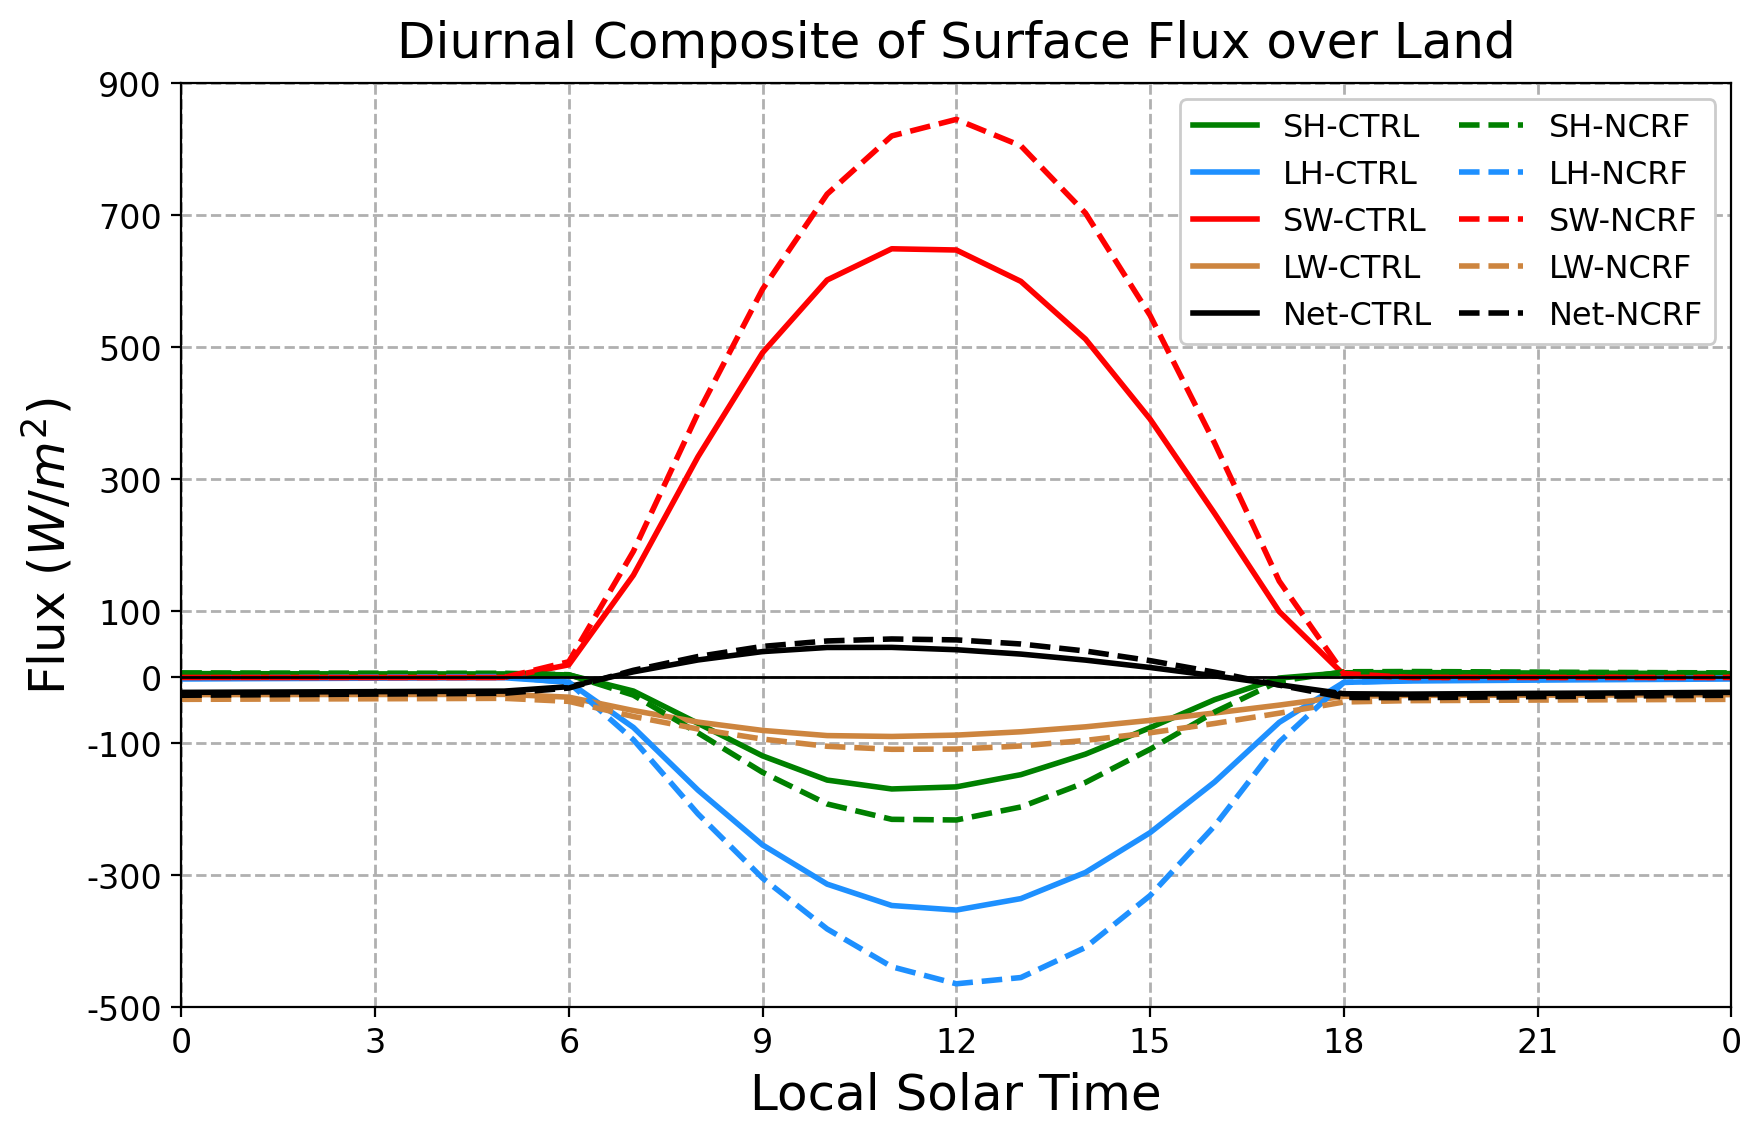

In [33]:
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.15)
ax1 = fig.add_subplot(gs[0,0])

fs = 18

l1 = (-HFX_cntl_land).plot.line(
    ax=ax1,
    color='green',
    linewidth=2,
    linestyle = '-',
	label='SH-CTRL'
)
l3 = (-LH_cntl_land).plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='LH-CTRL'
)
l5 = SWSFC_cntl_land.plot.line(
    ax=ax1,
    color='r',
    linewidth=2,
    linestyle = '-',
	label='SW-CTRL'
)
l7 = LWSFC_cntl_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='LW-CTRL'
)
l9 = (-(LH_cntl_land+HFX_cntl_land)+SWSFC_cntl_land+LWSFC_cntl_land).plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='Net-CTRL'
)

l2 = (-HFX_sunrise_land).plot.line(
    ax=ax1,
    color='green',
    linewidth=2,
    linestyle = '--',
	label='SH-NCRF'
)
l4 = (-LH_sunrise_land).plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='LH-NCRF'
)
l6 = SWSFC_sunrise_land.plot.line(
    ax=ax1,
    color='r',
    linewidth=2,
    linestyle = '--',
	label='SW-NCRF'
)
l8 = LWSFC_sunrise_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='LW-NCRF'
)
l10 = (-(LH_sunrise_land+HFX_sunrise_land)+SWSFC_sunrise_land+LWSFC_sunrise_land).plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '--',
	label='Net-NCRF'
)

# # Control
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_HFX_cntl_land[0,:],sig_bars_HFX_cntl_land[0,0]), np.append(sig_bars_HFX_cntl_land[1,:],sig_bars_HFX_cntl_land[1,0]), alpha=.25, color='green')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_LH_cntl_land[0,:],sig_bars_LH_cntl_land[0,0]), np.append(sig_bars_LH_cntl_land[1,:],sig_bars_LH_cntl_land[1,0]), alpha=.25, color='dodgerblue')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_SW_cntl_land[0,:],sig_bars_SW_cntl_land[0,0]), np.append(sig_bars_SW_cntl_land[1,:],sig_bars_SW_cntl_land[1,0]), alpha=.25, color='r')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_LW_cntl_land[0,:],sig_bars_LW_cntl_land[0,0]), np.append(sig_bars_LW_cntl_land[1,:],sig_bars_LW_cntl_land[1,0]), alpha=.25, color='peru')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_Net_cntl_land[0,:],sig_bars_Net_cntl_land[0,0]), np.append(sig_bars_Net_cntl_land[1,:],sig_bars_Net_cntl_land[1,0]), alpha=.25, color='k')

# # NCRF
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_HFX_sunrise_land[0,:],sig_bars_HFX_sunrise_land[0,0]), np.append(sig_bars_HFX_sunrise_land[1,:],sig_bars_HFX_sunrise_land[1,0]), alpha=.25, color='green')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_LH_sunrise_land[0,:],sig_bars_LH_sunrise_land[0,0]), np.append(sig_bars_LH_sunrise_land[1,:],sig_bars_LH_sunrise_land[1,0]), alpha=.25, color='dodgerblue')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_SW_sunrise_land[0,:],sig_bars_SW_sunrise_land[0,0]), np.append(sig_bars_SW_sunrise_land[1,:],sig_bars_SW_sunrise_land[1,0]), alpha=.25, color='r')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_LW_sunrise_land[0,:],sig_bars_LW_sunrise_land[0,0]), np.append(sig_bars_LW_sunrise_land[1,:],sig_bars_LW_sunrise_land[1,0]), alpha=.25, color='peru')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_Net_sunrise_land[0,:],sig_bars_Net_sunrise_land[0,0]), np.append(sig_bars_Net_sunrise_land[1,:],sig_bars_Net_sunrise_land[1,0]), alpha=.25, color='k')

fs = 18

ax1.set_xticks(np.arange(0,25,3))
ax1.set_yticks(np.concatenate((np.arange(-500,0,200),[0],np.arange(100,1200,200))))
# ax1.set_yticks(np.concatenate(([-100],np.arange(0,1200,200))))
title = f'Diurnal Composite of Surface Flux over Land'
ax1.set_title(title, fontsize=fs, y=1.01)
ax1.set_title('a)', fontsize=fs)
ax1.set_xlabel('Local Solar Time', fontsize=fs)
ax1.set_ylabel('Flux ($W/m^{2}$)', fontsize=fs)
ax1.set_xticklabels(np.concatenate((np.arange(0,24,3),[0])), fontsize=fs-6)
ax1.set_yticklabels(np.concatenate((np.arange(-500,0,200),[0],np.arange(100,1200,200))), fontsize=fs-6)
# ax1.set_yticklabels(np.concatenate(([-100],np.arange(0,1200,200))), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
plt.legend(markerscale=3, ncol=2, fontsize=fs-6.5, loc='upper left', framealpha=1, columnspacing=.85)
ax1.set_xlim([0,24])
ax1.set_ylim([-500,900])

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/DC_HFXandSWSFC.png', transparent=True)

In [ ]:
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.15)
ax1 = fig.add_subplot(gs[0,0])

fs = 18

l1 = (-HFX_cntl_ocean).plot.line(
    ax=ax1,
    color='green',
    linewidth=2,
    linestyle = '-',
	label='HFX-CNTL'
)
l3 = (-LH_cntl_ocean).plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='LH-CNTL'
)
l5 = SWSFC_cntl_ocean.plot.line(
    ax=ax1,
    color='r',
    linewidth=2,
    linestyle = '-',
	label='SW-CNTL'
)
l7 = LWSFC_cntl_ocean.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='LW-CNTL'
)
l9 = (-(LH_cntl_ocean+HFX_cntl_ocean)+SWSFC_cntl_ocean+LWSFC_cntl_ocean).plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='Net-CNTL'
)

l2 = (-HFX_sunrise_ocean).plot.line(
    ax=ax1,
    color='green',
    linewidth=2,
    linestyle = '--',
	label='HFX-NCRF'
)
l4 = (-LH_sunrise_ocean).plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='LH-NCRF'
)
l6 = SWSFC_sunrise_ocean.plot.line(
    ax=ax1,
    color='r',
    linewidth=2,
    linestyle = '--',
	label='SW-NCRF'
)
l8 = LWSFC_sunrise_ocean.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='LW-NCRF'
)
l10 = (-(LH_sunrise_ocean+HFX_sunrise_ocean)+SWSFC_sunrise_ocean+LWSFC_sunrise_ocean).plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '--',
	label='Net-NCRF'
)


fs = 18

ax1.set_xticks(np.arange(0,25,3))
ax1.set_yticks(np.arange(-200,1200,200))
# ax1.set_yticks(np.concatenate(([-100],np.arange(0,1200,200))))
title = f'Diurnal Composite of Surface Heat Flux over the MC Ocean'
ax1.set_title(title, fontsize=fs)
ax1.set_xlabel('LST', fontsize=fs)
ax1.set_ylabel('Flux ($W/m^{2}$)', fontsize=fs)
ax1.set_xticklabels(np.concatenate((np.arange(0,24,3),[0])), fontsize=fs-6)
ax1.set_yticklabels(np.arange(-200,1200,200), fontsize=fs-6)
# ax1.set_yticklabels(np.concatenate(([-100],np.arange(0,1200,200))), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.legend(ncol=2, fontsize=fs-6.5, loc='upper right', framealpha=1, columnspacing=.85)
ax1.set_xlim([0,24])
ax1.set_ylim([-200,900])
# ax1.set_ylim([-150,1000])

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/DC_HFXandSWSFC.png', transparent=True)

Version 2

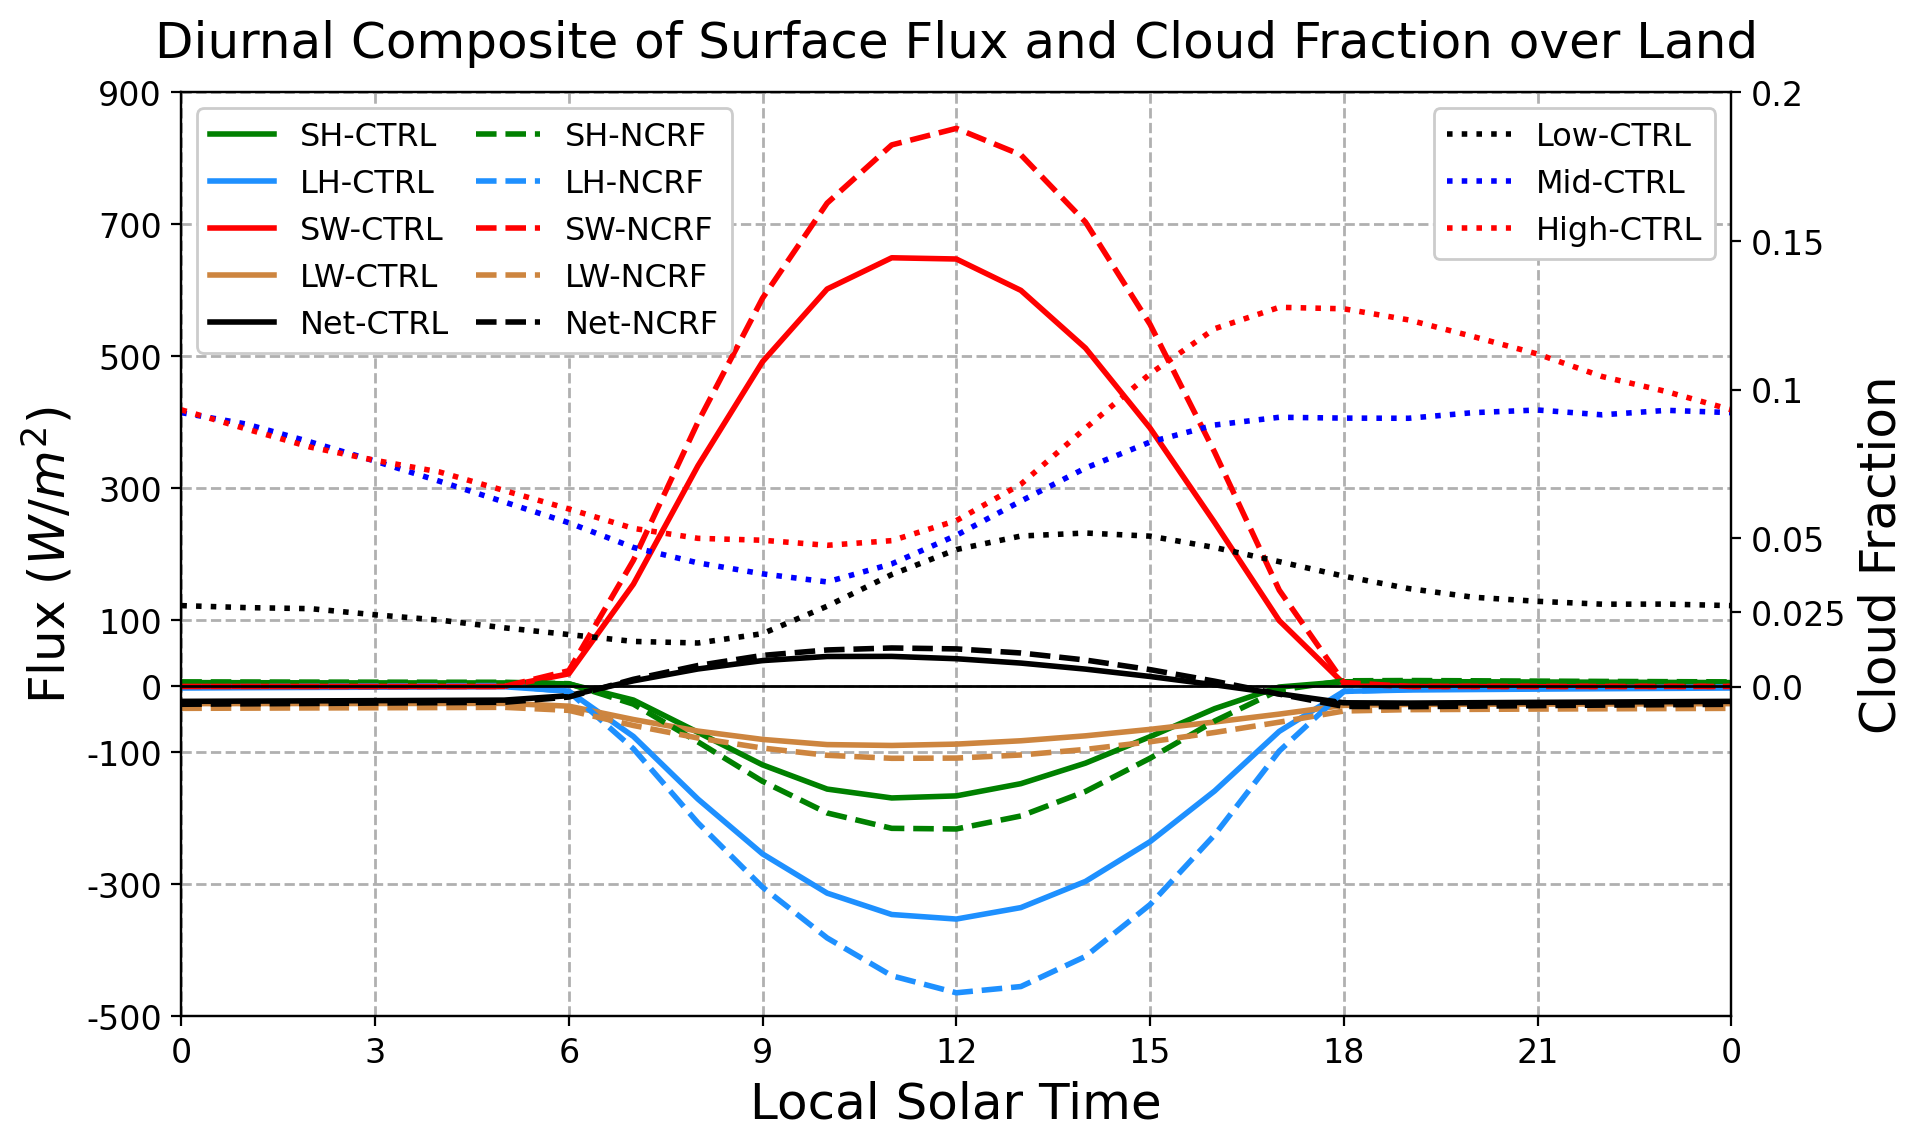

In [51]:
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.15)
ax1 = fig.add_subplot(gs[0,0])
ax2 = ax1.twinx()

fs = 18

l1 = (-HFX_cntl_land).plot.line(
    ax=ax1,
    color='green',
    linewidth=2,
    linestyle = '-',
	label='SH-CTRL'
)
l3 = (-LH_cntl_land).plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='LH-CTRL'
)
l5 = SWSFC_cntl_land.plot.line(
    ax=ax1,
    color='r',
    linewidth=2,
    linestyle = '-',
	label='SW-CTRL'
)
l7 = LWSFC_cntl_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='LW-CTRL'
)
l9 = (-(LH_cntl_land+HFX_cntl_land)+SWSFC_cntl_land+LWSFC_cntl_land).plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='Net-CTRL'
)

l2 = (-HFX_sunrise_land).plot.line(
    ax=ax1,
    color='green',
    linewidth=2,
    linestyle = '--',
	label='SH-NCRF'
)
l4 = (-LH_sunrise_land).plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='LH-NCRF'
)
l6 = SWSFC_sunrise_land.plot.line(
    ax=ax1,
    color='r',
    linewidth=2,
    linestyle = '--',
	label='SW-NCRF'
)
l8 = LWSFC_sunrise_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='LW-NCRF'
)
l10 = (-(LH_sunrise_land+HFX_sunrise_land)+SWSFC_sunrise_land+LWSFC_sunrise_land).plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '--',
	label='Net-NCRF'
)

# CLDFRA
l11 = LowCLDFRA_cntl_land.plot.line(
    ax=ax2,
    color='k',
    linewidth=2,
    linestyle = ':',
	label='Low-CTRL'
)
l12 = MidCLDFRA_cntl_land.plot.line(
    ax=ax2,
    color='b',
    linewidth=2,
    linestyle = ':',
	label='Mid-CTRL'
)
l13 = HighCLDFRA_cntl_land.plot.line(
    ax=ax2,
    color='r',
    linewidth=2,
    linestyle = ':',
	label='High-CTRL'
)

# # Control
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_HFX_cntl_land[0,:],sig_bars_HFX_cntl_land[0,0]), np.append(sig_bars_HFX_cntl_land[1,:],sig_bars_HFX_cntl_land[1,0]), alpha=.25, color='green')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_LH_cntl_land[0,:],sig_bars_LH_cntl_land[0,0]), np.append(sig_bars_LH_cntl_land[1,:],sig_bars_LH_cntl_land[1,0]), alpha=.25, color='dodgerblue')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_SW_cntl_land[0,:],sig_bars_SW_cntl_land[0,0]), np.append(sig_bars_SW_cntl_land[1,:],sig_bars_SW_cntl_land[1,0]), alpha=.25, color='r')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_LW_cntl_land[0,:],sig_bars_LW_cntl_land[0,0]), np.append(sig_bars_LW_cntl_land[1,:],sig_bars_LW_cntl_land[1,0]), alpha=.25, color='peru')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_Net_cntl_land[0,:],sig_bars_Net_cntl_land[0,0]), np.append(sig_bars_Net_cntl_land[1,:],sig_bars_Net_cntl_land[1,0]), alpha=.25, color='k')

# # NCRF
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_HFX_sunrise_land[0,:],sig_bars_HFX_sunrise_land[0,0]), np.append(sig_bars_HFX_sunrise_land[1,:],sig_bars_HFX_sunrise_land[1,0]), alpha=.25, color='green')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_LH_sunrise_land[0,:],sig_bars_LH_sunrise_land[0,0]), np.append(sig_bars_LH_sunrise_land[1,:],sig_bars_LH_sunrise_land[1,0]), alpha=.25, color='dodgerblue')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_SW_sunrise_land[0,:],sig_bars_SW_sunrise_land[0,0]), np.append(sig_bars_SW_sunrise_land[1,:],sig_bars_SW_sunrise_land[1,0]), alpha=.25, color='r')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_LW_sunrise_land[0,:],sig_bars_LW_sunrise_land[0,0]), np.append(sig_bars_LW_sunrise_land[1,:],sig_bars_LW_sunrise_land[1,0]), alpha=.25, color='peru')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_Net_sunrise_land[0,:],sig_bars_Net_sunrise_land[0,0]), np.append(sig_bars_Net_sunrise_land[1,:],sig_bars_Net_sunrise_land[1,0]), alpha=.25, color='k')

fs = 18

# ax2.set_yscale('log')
ax1.set_xticks(np.arange(0,25,3))
ax1.set_yticks(np.concatenate((np.arange(-500,0,200),[0],np.arange(100,1200,200))))
ax2.set_yticks(np.array([0,0.025,0.05,0.1,0.15,0.2]))
# ax1.set_yticks(np.concatenate(([-100],np.arange(0,1200,200))))
title = f'Diurnal Composite of Surface Flux and Cloud Fraction over Land'
ax1.set_title(title, fontsize=fs, y=1.02)
ax2.set_title('')
ax1.set_xlabel('Local Solar Time', fontsize=fs)
ax1.set_ylabel('Flux ($W/m^{2}$)', fontsize=fs)
ax2.set_ylabel('Cloud Fraction', fontsize=fs)
ax1.set_xticklabels(np.concatenate((np.arange(0,24,3),[0])), fontsize=fs-6)
ax1.set_yticklabels(np.concatenate((np.arange(-500,0,200),[0],np.arange(100,1200,200))), fontsize=fs-6)
ax2.set_yticklabels(np.array([0,0.025,0.05,0.1,0.15,0.2]), fontsize=fs-6)
ax1.grid(linestyle='--', linewidth=1)
# ax2.grid(linestyle='--', linewidth=1)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_xlim([0,24])
ax1.set_ylim([-500,900])
ax2.set_ylim([-.111,.2])
ax1.legend(markerscale=3, ncol=2, fontsize=fs-6.5, loc='upper left', framealpha=1, columnspacing=.85)
ax2.legend(markerscale=3, ncol=1, fontsize=fs-6.5, loc='upper right', framealpha=1, columnspacing=.85)
ax2.minorticks_off()
# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/DC_HFXandSWSFC.png', transparent=True)

(0.0, 0.15)

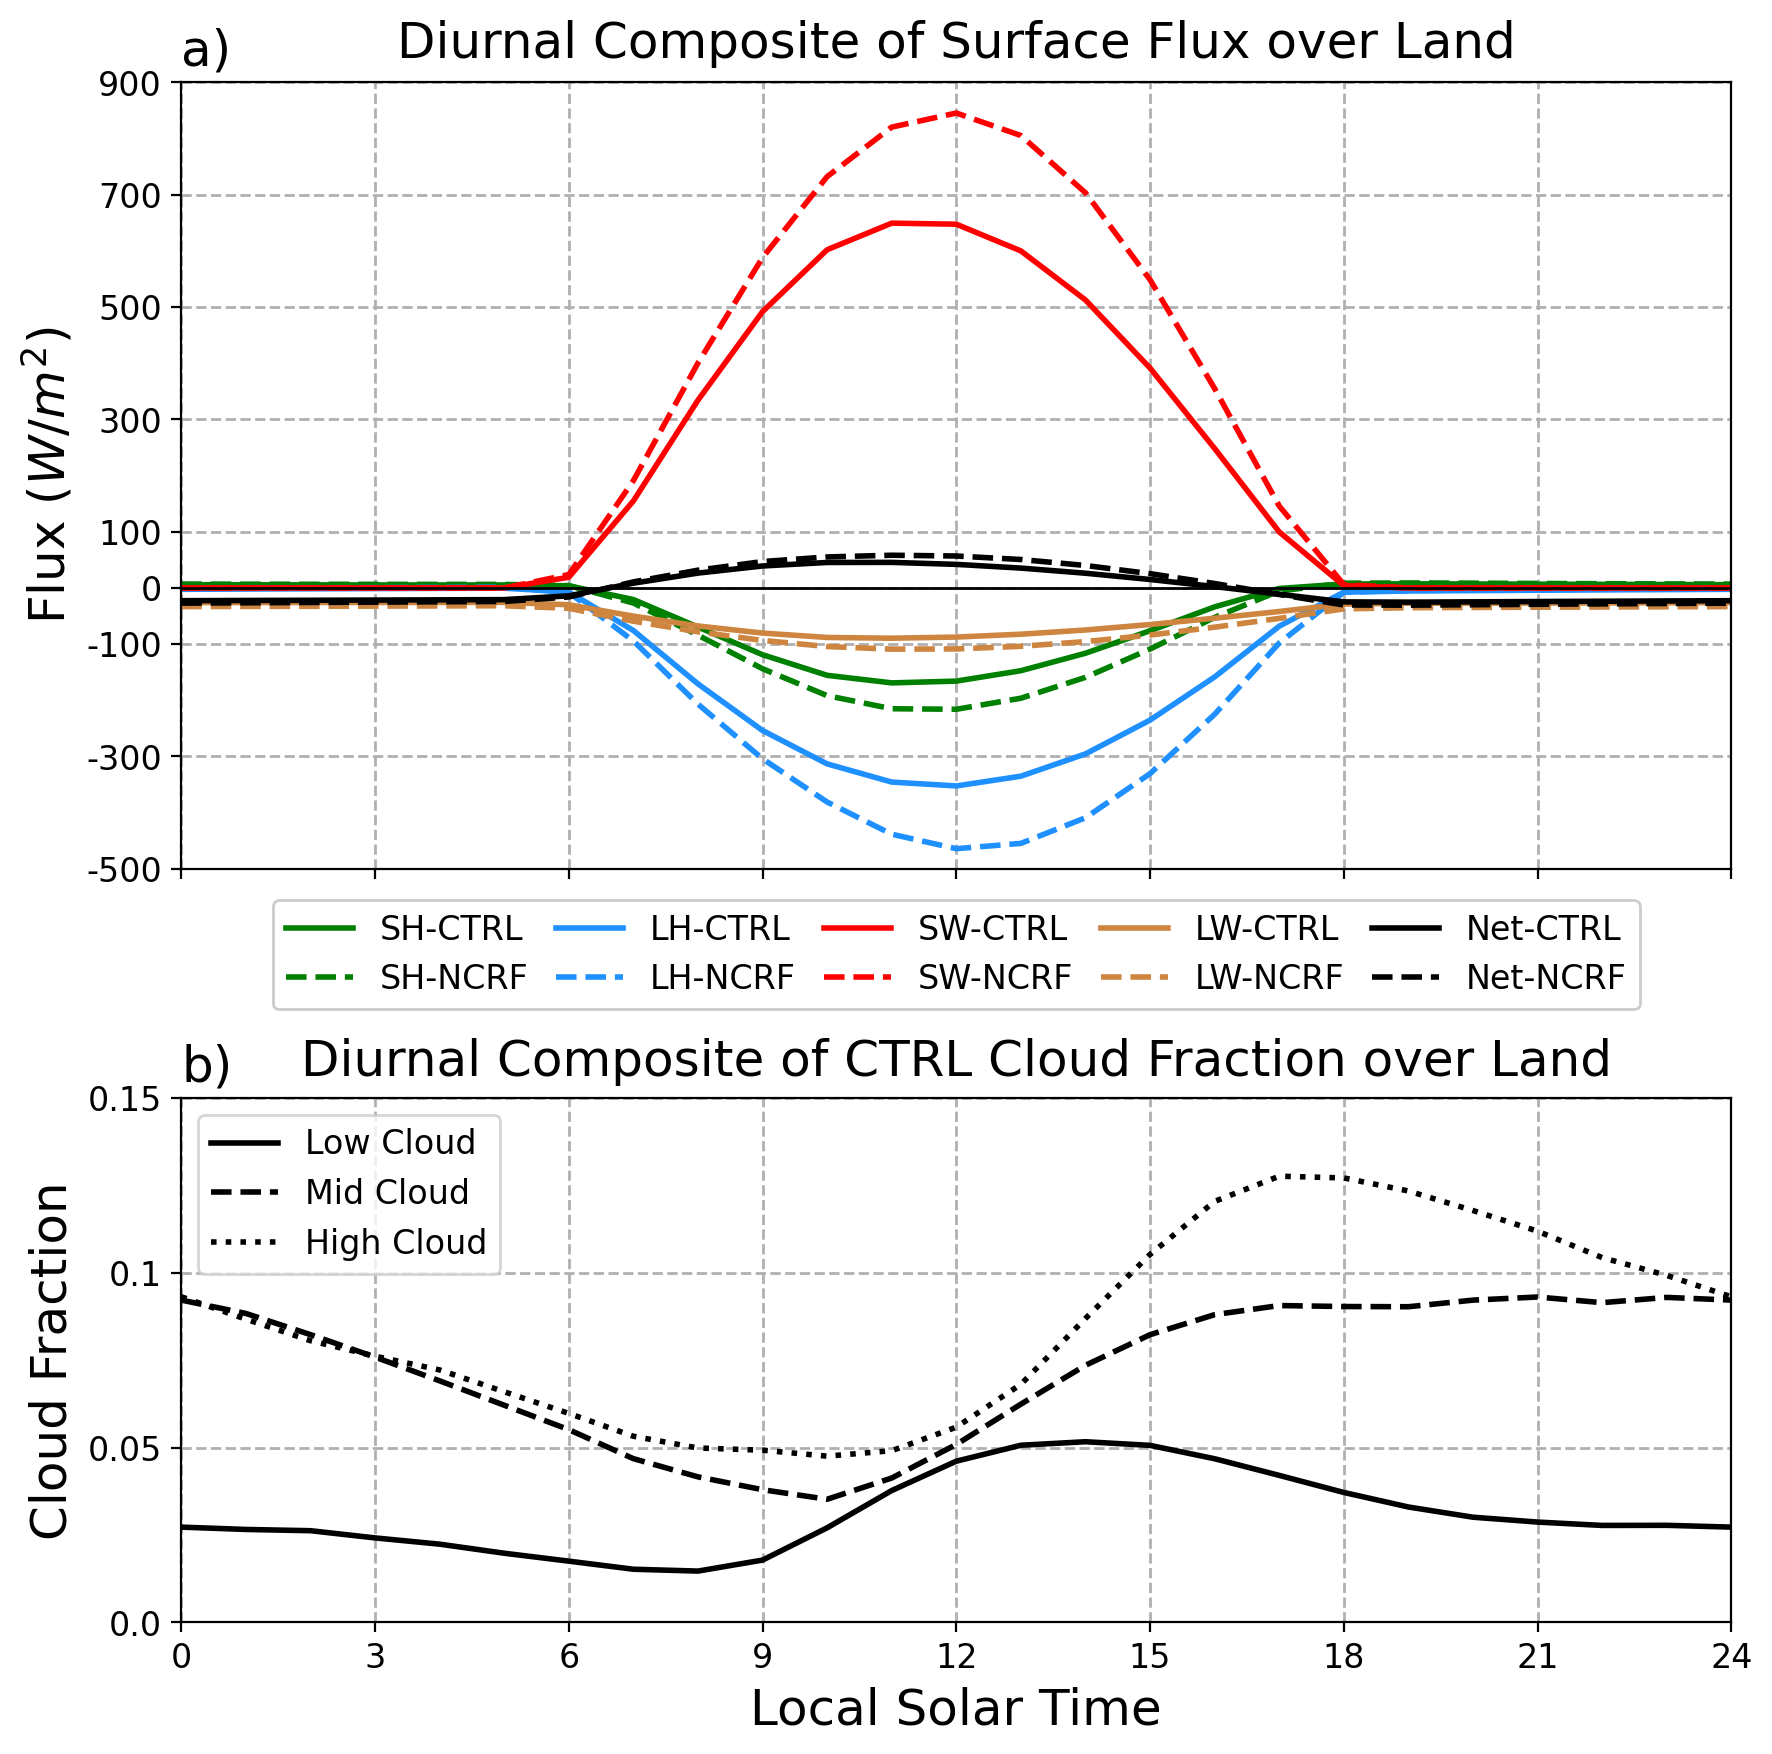

In [78]:
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.35, height_ratios=[.6,.4])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])

fs = 18

l1 = (-HFX_cntl_land).plot.line(
    ax=ax1,
    color='green',
    linewidth=2,
    linestyle = '-',
	label='SH-CTRL'
)

l2 = (-HFX_sunrise_land).plot.line(
    ax=ax1,
    color='green',
    linewidth=2,
    linestyle = '--',
	label='SH-NCRF'
)

l3 = (-LH_cntl_land).plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='LH-CTRL'
)

l4 = (-LH_sunrise_land).plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='LH-NCRF'
)

l5 = SWSFC_cntl_land.plot.line(
    ax=ax1,
    color='r',
    linewidth=2,
    linestyle = '-',
	label='SW-CTRL'
)

l6 = SWSFC_sunrise_land.plot.line(
    ax=ax1,
    color='r',
    linewidth=2,
    linestyle = '--',
	label='SW-NCRF'
)

l7 = LWSFC_cntl_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='LW-CTRL'
)

l8 = LWSFC_sunrise_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='LW-NCRF'
)

l9 = (-(LH_cntl_land+HFX_cntl_land)+SWSFC_cntl_land+LWSFC_cntl_land).plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='Net-CTRL'
)

l10 = (-(LH_sunrise_land+HFX_sunrise_land)+SWSFC_sunrise_land+LWSFC_sunrise_land).plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '--',
	label='Net-NCRF'
)

# CLDFRA
l9 = LowCLDFRA_cntl_land.plot.line(
    ax=ax2,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='Low Cloud'
)
# CLDFRA
l11 = MidCLDFRA_cntl_land.plot.line(
    ax=ax2,
    color='k',
    linewidth=2,
    linestyle = '--',
	label='Mid Cloud'
)
# CLDFRA
l13 = HighCLDFRA_cntl_land.plot.line(
    ax=ax2,
    color='k',
    linewidth=2,
    linestyle = ':',
	label='High Cloud'
)

fs = 18

ax1.set_xticks(np.arange(0,25,3))
ax1.set_yticks(np.concatenate((np.arange(-500,0,200),[0],np.arange(100,1200,200))))
ax2.set_xticks(np.arange(0,25,3))
ax2.set_yticks(np.array([0,0.05,0.1,0.15,0.2,0.25,0.3]))
title = f'Diurnal Composite of Surface Flux over Land'
ax1.set_title(title, fontsize=fs, y=1.01)
ax1.set_title('a)', loc='left', fontsize=fs)
title = f'Diurnal Composite of CTRL Cloud Fraction over Land'
ax2.set_title(title, fontsize=fs, y=1.01)
ax2.set_title('b)', loc='left', fontsize=fs)
ax1.set_xlabel('', fontsize=fs)
ax2.set_xlabel('Local Solar Time', fontsize=fs)
ax1.set_ylabel('Flux ($W/m^{2}$)', fontsize=fs)
ax2.set_ylabel('Cloud Fraction', fontsize=fs)
ax1.set_xticklabels([], fontsize=fs-6)
ax2.set_xticklabels(np.arange(0,25,3), fontsize=fs-6)
ax1.set_yticklabels(np.concatenate((np.arange(-500,0,200),[0],np.arange(100,1200,200))), fontsize=fs-6)
ax2.set_yticklabels(np.array([0,0.05,0.1,0.15,0.2,0.25,0.3]), fontsize=fs-6)
ax1.grid(linestyle='--', linewidth=1)
ax2.grid(linestyle='--', linewidth=1)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.legend(ncol=5, fontsize=fs-6, loc='lower center', framealpha=1, columnspacing=.85, bbox_to_anchor=(0.5,-0.2))
ax2.legend(ncol=1, fontsize=fs-6, loc='upper left')
ax1.set_xlim([0,24])
ax2.set_xlim([0,24])
ax1.set_ylim([-500,900])
ax2.set_ylim([0,.15])

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/DC_HFXandSWSFC.png', transparent=True)

Figure 5. Heat Map of HFX and SWSFC with RR Contours

In [52]:
# Data
rolls = 1
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']
chunk=False

############################################################################################################
########################################## Shortwave Heat Flux #############################################
############################################################################################################

################################################# Control ##################################################

parent_dir_CNTL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00'

file_name = parent_dir_CNTL + '/L4/SWSFC_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		SWSFC_di_cntl = da_d02_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: SWSFC_di_cntl = da_d02_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: SWSFC_di_cntl = da_d02_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	SWSFC_di_cntl = assign_LT_coord(SWSFC_di_cntl,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	SWSFC_di_cntl = xarray_reduce(SWSFC_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	SWSFC_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	SWSFC_di_cntl.name = 'SWSFC'

	SWSFC_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	SWSFC_di_cntl = xr.open_dataset(file_name)['SWSFC'].compute()

# Find the max and min values
x = SWSFC_di_cntl.max(dim='hour', keep_attrs=True)
y = SWSFC_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_SWSFC_di_cntl = x-y
amplitude_SWSFC_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_SWSFC_di_cntl, np.nan)
amplitude_SWSFC_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_SWSFC_di_cntl, np.nan)

#################################### Sunrise ####################################

parent_dir_NCRF = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff'

file_name = parent_dir_NCRF + '/L4/SWSFC_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		SWSFC_di_sunrise = da_d02_sunrise_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: SWSFC_di_sunrise = da_d02_sunrise_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: SWSFC_di_sunrise = da_d02_sunrise_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	SWSFC_di_sunrise = assign_LT_coord(SWSFC_di_sunrise,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	SWSFC_di_sunrise = xarray_reduce(SWSFC_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	SWSFC_di_sunrise.assign_attrs(rolling = rolls, sim = 'NCRF sunrise', chunk = str(chunk))
	SWSFC_di_sunrise.name = 'SWSFC'

	SWSFC_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	SWSFC_di_sunrise = xr.open_dataset(file_name)['SWSFC'].compute()

# Find the max and min values
x = SWSFC_di_sunrise.max(dim='hour', keep_attrs=True)
y = SWSFC_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_SWSFC_di_sunrise = x-y
amplitude_SWSFC_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_SWSFC_di_sunrise, np.nan)
amplitude_SWSFC_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_SWSFC_di_sunrise, np.nan)

# Difference
amplitude_SWSFC_di_diff =  amplitude_SWSFC_di_sunrise - amplitude_SWSFC_di_cntl
amplitude_SWSFC_di_diff_land = xr.where(da_d02_LANDMASK==1, amplitude_SWSFC_di_diff, np.nan)
amplitude_SWSFC_di_diff_ocean = xr.where(da_d02_LANDMASK==0, amplitude_SWSFC_di_diff, np.nan)


############################################################################################################
########################################## Longwave Heat Flux ##############################################
############################################################################################################

################################################# Control ##################################################

parent_dir_CNTL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00'

file_name = parent_dir_CNTL + '/L4/LWSFC_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		LWSFC_di_cntl = da_d02_LWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: LWSFC_di_cntl = da_d02_LWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: LWSFC_di_cntl = da_d02_LWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	LWSFC_di_cntl = assign_LT_coord(LWSFC_di_cntl,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	LWSFC_di_cntl = xarray_reduce(LWSFC_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	LWSFC_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	LWSFC_di_cntl.name = 'LWSFC'

	LWSFC_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	LWSFC_di_cntl = xr.open_dataset(file_name)['LWSFC'].compute()

# Find the max and min values
x = LWSFC_di_cntl.max(dim='hour', keep_attrs=True)
y = LWSFC_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_LWSFC_di_cntl = x-y
amplitude_LWSFC_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_LWSFC_di_cntl, np.nan)
amplitude_LWSFC_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_LWSFC_di_cntl, np.nan)

#################################### Sunrise ####################################

parent_dir_NCRF = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff'

file_name = parent_dir_NCRF + '/L4/LWSFC_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		LWSFC_di_sunrise = da_d02_sunrise_LWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: LWSFC_di_sunrise = da_d02_sunrise_LWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: LWSFC_di_sunrise = da_d02_sunrise_LWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	LWSFC_di_sunrise = assign_LT_coord(LWSFC_di_sunrise,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	LWSFC_di_sunrise = xarray_reduce(LWSFC_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	LWSFC_di_sunrise.assign_attrs(rolling = rolls, sim = 'NCRF sunrise', chunk = str(chunk))
	LWSFC_di_sunrise.name = 'LWSFC'

	LWSFC_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	LWSFC_di_sunrise = xr.open_dataset(file_name)['LWSFC'].compute()

# Find the max and min values
x = LWSFC_di_sunrise.max(dim='hour', keep_attrs=True)
y = LWSFC_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_LWSFC_di_sunrise = x-y
amplitude_LWSFC_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_LWSFC_di_sunrise, np.nan)
amplitude_LWSFC_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_LWSFC_di_sunrise, np.nan)

# Difference
amplitude_LWSFC_di_diff =  amplitude_LWSFC_di_sunrise - amplitude_LWSFC_di_cntl
amplitude_LWSFC_di_diff_land = xr.where(da_d02_LANDMASK==1, amplitude_LWSFC_di_diff, np.nan)
amplitude_LWSFC_di_diff_ocean = xr.where(da_d02_LANDMASK==0, amplitude_LWSFC_di_diff, np.nan)


############################################################################################################
########################################## Sensible Heat Flux ##############################################
############################################################################################################

################################################ Control ###################################################

file_name = parent_dir_CNTL + '/L4/HFX_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		HFX_di_cntl = da_d02_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: HFX_di_cntl = da_d02_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: HFX_di_cntl = da_d02_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	HFX_di_cntl = assign_LT_coord(HFX_di_cntl,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	HFX_di_cntl = xarray_reduce(HFX_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	HFX_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	HFX_di_cntl.name = 'HFX'
	HFX_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	HFX_di_cntl = xr.open_dataset(file_name)['HFX'].compute()

# Find the max and min values
x = HFX_di_cntl.max(dim='hour', keep_attrs=True)
y = HFX_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_HFX_di_cntl = x-y
amplitude_HFX_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_HFX_di_cntl, np.nan)
amplitude_HFX_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_HFX_di_cntl, np.nan)

#################################### Sunrise ####################################

file_name = parent_dir_NCRF + '/L4/HFX_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		HFX_di_sunrise = da_d02_sunrise_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: HFX_di_sunrise = da_d02_sunrise_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: HFX_di_sunrise = da_d02_sunrise_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	HFX_di_sunrise = assign_LT_coord(HFX_di_sunrise,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	HFX_di_sunrise = xarray_reduce(HFX_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	HFX_di_sunrise.assign_attrs(rolling = rolls, sim = 'NCRF sunrise', chunk = str(chunk))
	HFX_di_sunrise.name = 'HFX'
	HFX_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	HFX_di_sunrise = xr.open_dataset(file_name)['HFX'].compute()

# Find the max and min values
x = HFX_di_sunrise.max(dim='hour', keep_attrs=True)
y = HFX_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_HFX_di_sunrise = x-y
amplitude_HFX_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_HFX_di_sunrise, np.nan)
amplitude_HFX_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_HFX_di_sunrise, np.nan)

# Difference
amplitude_HFX_di_diff =  amplitude_HFX_di_sunrise - amplitude_HFX_di_cntl
amplitude_HFX_di_diff_land = xr.where(da_d02_LANDMASK==1, amplitude_HFX_di_diff, np.nan)
amplitude_HFX_di_diff_ocean = xr.where(da_d02_LANDMASK==0, amplitude_HFX_di_diff, np.nan)

############################################################################################################
########################################### Latent Heat Flux ###############################################
############################################################################################################

################################################ Control ###################################################

file_name = parent_dir_CNTL + '/L4/LH_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		LH_di_cntl = da_d02_LH.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: LH_di_cntl = da_d02_LH.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: LH_di_cntl = da_d02_LH.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	LH_di_cntl = assign_LT_coord(LH_di_cntl,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	LH_di_cntl = xarray_reduce(LH_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	LH_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	LH_di_cntl.name = 'LH'
	LH_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	LH_di_cntl = xr.open_dataset(file_name)['LH'].compute()

# Find the max and min values
x = LH_di_cntl.max(dim='hour', keep_attrs=True)
y = LH_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_LH_di_cntl = x-y
amplitude_LH_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_LH_di_cntl, np.nan)
amplitude_LH_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_LH_di_cntl, np.nan)

#################################### Sunrise ####################################

file_name = parent_dir_NCRF + '/L4/LH_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		LH_di_sunrise = da_d02_sunrise_LH.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: LH_di_sunrise = da_d02_sunrise_LH.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: LH_di_sunrise = da_d02_sunrise_LH.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	LH_di_sunrise = assign_LT_coord(LH_di_sunrise,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	LH_di_sunrise = xarray_reduce(LH_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	LH_di_sunrise.assign_attrs(rolling = rolls, sim = 'NCRF sunrise', chunk = str(chunk))
	LH_di_sunrise.name = 'LH'
	LH_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	LH_di_sunrise = xr.open_dataset(file_name)['LH'].compute()

# Find the max and min values
x = LH_di_sunrise.max(dim='hour', keep_attrs=True)
y = LH_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_LH_di_sunrise = x-y
amplitude_LH_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_LH_di_sunrise, np.nan)
amplitude_LH_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_LH_di_sunrise, np.nan)

# Difference
amplitude_LH_di_diff =  amplitude_LH_di_sunrise - amplitude_LH_di_cntl
amplitude_LH_di_diff_land = xr.where(da_d02_LANDMASK==1, amplitude_LH_di_diff, np.nan)
amplitude_LH_di_diff_ocean = xr.where(da_d02_LANDMASK==0, amplitude_LH_di_diff, np.nan)

In [ ]:
fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[0.9,0.05], width_ratios=[0.30,0.30,0.30], hspace=0.35, wspace=0.2)
fs = 18

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'
probability_density = True

x_levels = [300, 1000]
x_dl = 10
if domain=='Ocean':
	y_levels = [0, 100]
	y_dl = 2
else:
	y_levels = [0, 700]
	y_dl = 10

if probability_density:
	# c_levels = [10**-7,0.0002]
	# c_dl = .00002
	c_levels = [10**-5,0.01]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500

rr_levels = np.arange(0,11,2)
roll = 5

# fig.suptitle(f'Diurnal HFX & SW SFC Range over the MC {domain}, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Frequency of Diurnal Shortwave and Sensible Surface Heat Flux Range over {domain}', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
	y=amplitude_HFX_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
	RR=amplitude_RR_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
	CLDFRA=amplitude_LowCLDFRA_di_sunrise_land.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
	SWCRF=amplitude_SWSFC_CRF_di_sunrise_land.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_di_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
	y=amplitude_HFX_di_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
	RR=amplitude_RR_di_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_di_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]
	y=amplitude_HFX_di_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]
	RR=amplitude_RR_di_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]


if domain=='Land':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_RR_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_di_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR/H_RR_di_sunrise_n)
	H_RR_di_sunrise_zeros = np.argwhere(H_RR_di_sunrise==0)	# Find where all the zeros are
	H_RR_di_sunrise = xr.DataArray(H_RR_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_sunrise[H_RR_di_sunrise_zeros[:,0],H_RR_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
		# Add legend for the contour
		legend_lines = [plt.Line2D([0], [0], color='k', linewidth=3)]
		ax1.legend(legend_lines, ['Rain Rate\nRange (mm/hr)'], fontsize=fs-7, loc='upper left')

	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_RR_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_di_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR/H_RR_di_sunrise_n)
	H_RR_di_sunrise_zeros = np.argwhere(H_RR_di_sunrise==0)	# Find where all the zeros are
	H_RR_di_sunrise = xr.DataArray(H_RR_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_sunrise[H_RR_di_sunrise_zeros[:,0],H_RR_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_RR_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_di_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR/H_RR_di_sunrise_n)
	H_RR_di_sunrise_zeros = np.argwhere(H_RR_di_sunrise==0)	# Find where all the zeros are
	H_RR_di_sunrise = xr.DataArray(H_RR_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_sunrise[H_RR_di_sunrise_zeros[:,0],H_RR_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.set_title('NCRF', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# ax1.text(325,655, f'n={len(x)}', color='k',fontsize=fs-8, bbox=props)
# ax1.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax1.set_ylabel('Sensible Heat Flux Range ($W/m^{2}$)',fontsize=fs-2)
ax1.set_xlabel('Shortwave Flux Range ($W/m^{2}$)',fontsize=fs-2)
ax1.set_xticks(np.arange(0,1200,100))
ax1.set_yticks(np.arange(0,1200,100))
ax1.set_xticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax1.set_yticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax1.set_xlim([x_levels[0],x_levels[1]])
ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	y=amplitude_HFX_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	RR=amplitude_RR_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_di_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
	y=amplitude_HFX_di_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
	RR=amplitude_RR_di_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_di_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]
	y=amplitude_HFX_di_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]
	RR=amplitude_RR_di_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_di_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR/H_RR_di_cntl_n)
	H_RR_di_cntl_zeros = np.argwhere(H_RR_di_cntl==0)	# Find where all the zeros are
	H_RR_di_cntl = xr.DataArray(H_RR_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_cntl[H_RR_di_cntl_zeros[:,0],H_RR_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_di_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_di_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR/H_RR_di_cntl_n)
	H_RR_di_cntl_zeros = np.argwhere(H_RR_di_cntl==0)	# Find where all the zeros are
	H_RR_di_cntl = xr.DataArray(H_RR_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_cntl[H_RR_di_cntl_zeros[:,0],H_RR_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_di_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_di_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR/H_RR_di_cntl_n)
	H_RR_di_cntl_zeros = np.argwhere(H_RR_di_cntl==0)	# Find where all the zeros are
	H_RR_di_cntl = xr.DataArray(H_RR_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_cntl[H_RR_di_cntl_zeros[:,0],H_RR_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_di_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax2.set_title('CTRL', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# ax1.text(325,655, f'n={len(x)}', color='k',fontsize=fs-8, bbox=props)
# ax2.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax2.set_ylabel('')
ax2.set_xlabel('Shortwave Flux Range ($W/m^{2}$)',fontsize=fs-2)
ax2.set_xticks(np.arange(0,1200,100))
ax2.set_yticks(np.arange(0,1200,100))
ax2.set_xticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax2.set_yticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax2.set_xlim([x_levels[0],x_levels[1]])
ax2.set_ylim([y_levels[0],y_levels[1]])
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[1,0:2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_ticklabels(np.array([0,10**-5,10**-4,10**-3,10**-2]), fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency', fontsize=fs-2)
else:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')

if probability_density:
	c_levels = [-0.01,0.01]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500
	


# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
# cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
# 											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
# cc = ax3.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T-H_RR_di_cntl.T, colors='k', linewidths=1, levels=np.arange(-6,10,2), vmin=c_levels[0], vmax=c_levels[1])
cf = ax3.pcolormesh(X, Y, H_CLDFRA_di_sunrise.T-H_CLDFRA_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
cc = ax3.contour(X[1:,1:],Y[1:,1:], H_SWCRF_di_sunrise.T-H_SWCRF_di_cntl.T, colors='k', linewidths=1, levels=np.arange(-6,10,2), vmin=c_levels[0], vmax=c_levels[1])


ax3.clabel(cc, inline=True, fontsize=10)
# Add legend for the contour
legend_lines = [plt.Line2D([0], [0], color='k', linewidth=3)]
ax3.legend(legend_lines, ['Anomalous Rain\nRate Range (mm/hr)'], fontsize=fs-7, loc='upper left')

ax3.set_title('NCRF - CTRL', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
ax3.set_ylabel('')
ax3.set_xlabel('Shortwave Flux Range ($W/m^{2}$)',fontsize=fs-2)
ax3.set_xticks(np.arange(0,1200,100))
ax3.set_yticks(np.arange(0,1200,100))
ax3.set_xticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax3.set_yticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax3.set_xlim([x_levels[0],x_levels[1]])
ax3.set_ylim([y_levels[0],y_levels[1]])
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[1,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	tick_labels = [f'$-10^{{{-2}}}$',f'$-10^{{{-3}}}$','0',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('$\Delta$ Fractional Frequency', fontsize=fs-2)
else:
	cbar.set_label('Frequency')

Version 2

/tmp/ipykernel_24646/922048218.py:67: RuntimeWarning: invalid value encountered in divide
  H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR/H_di_sunrise_n)
/tmp/ipykernel_24646/922048218.py:166: RuntimeWarning: invalid value encountered in divide
  H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR/H_di_cntl_n)
/tmp/ipykernel_24646/922048218.py:174: RuntimeWarning: invalid value encountered in divide
  H_SWCRF_di_cntl = np.nan_to_num(H_SWCRF_di_cntl_sumSWCRF/H_di_cntl_n)
/tmp/ipykernel_24646/922048218.py:182: RuntimeWarning: invalid value encountered in divide
  H_CLDFRA_di_cntl = np.nan_to_num(H_CLDFRA_di_cntl_sumCLDFRA/H_di_cntl_n)


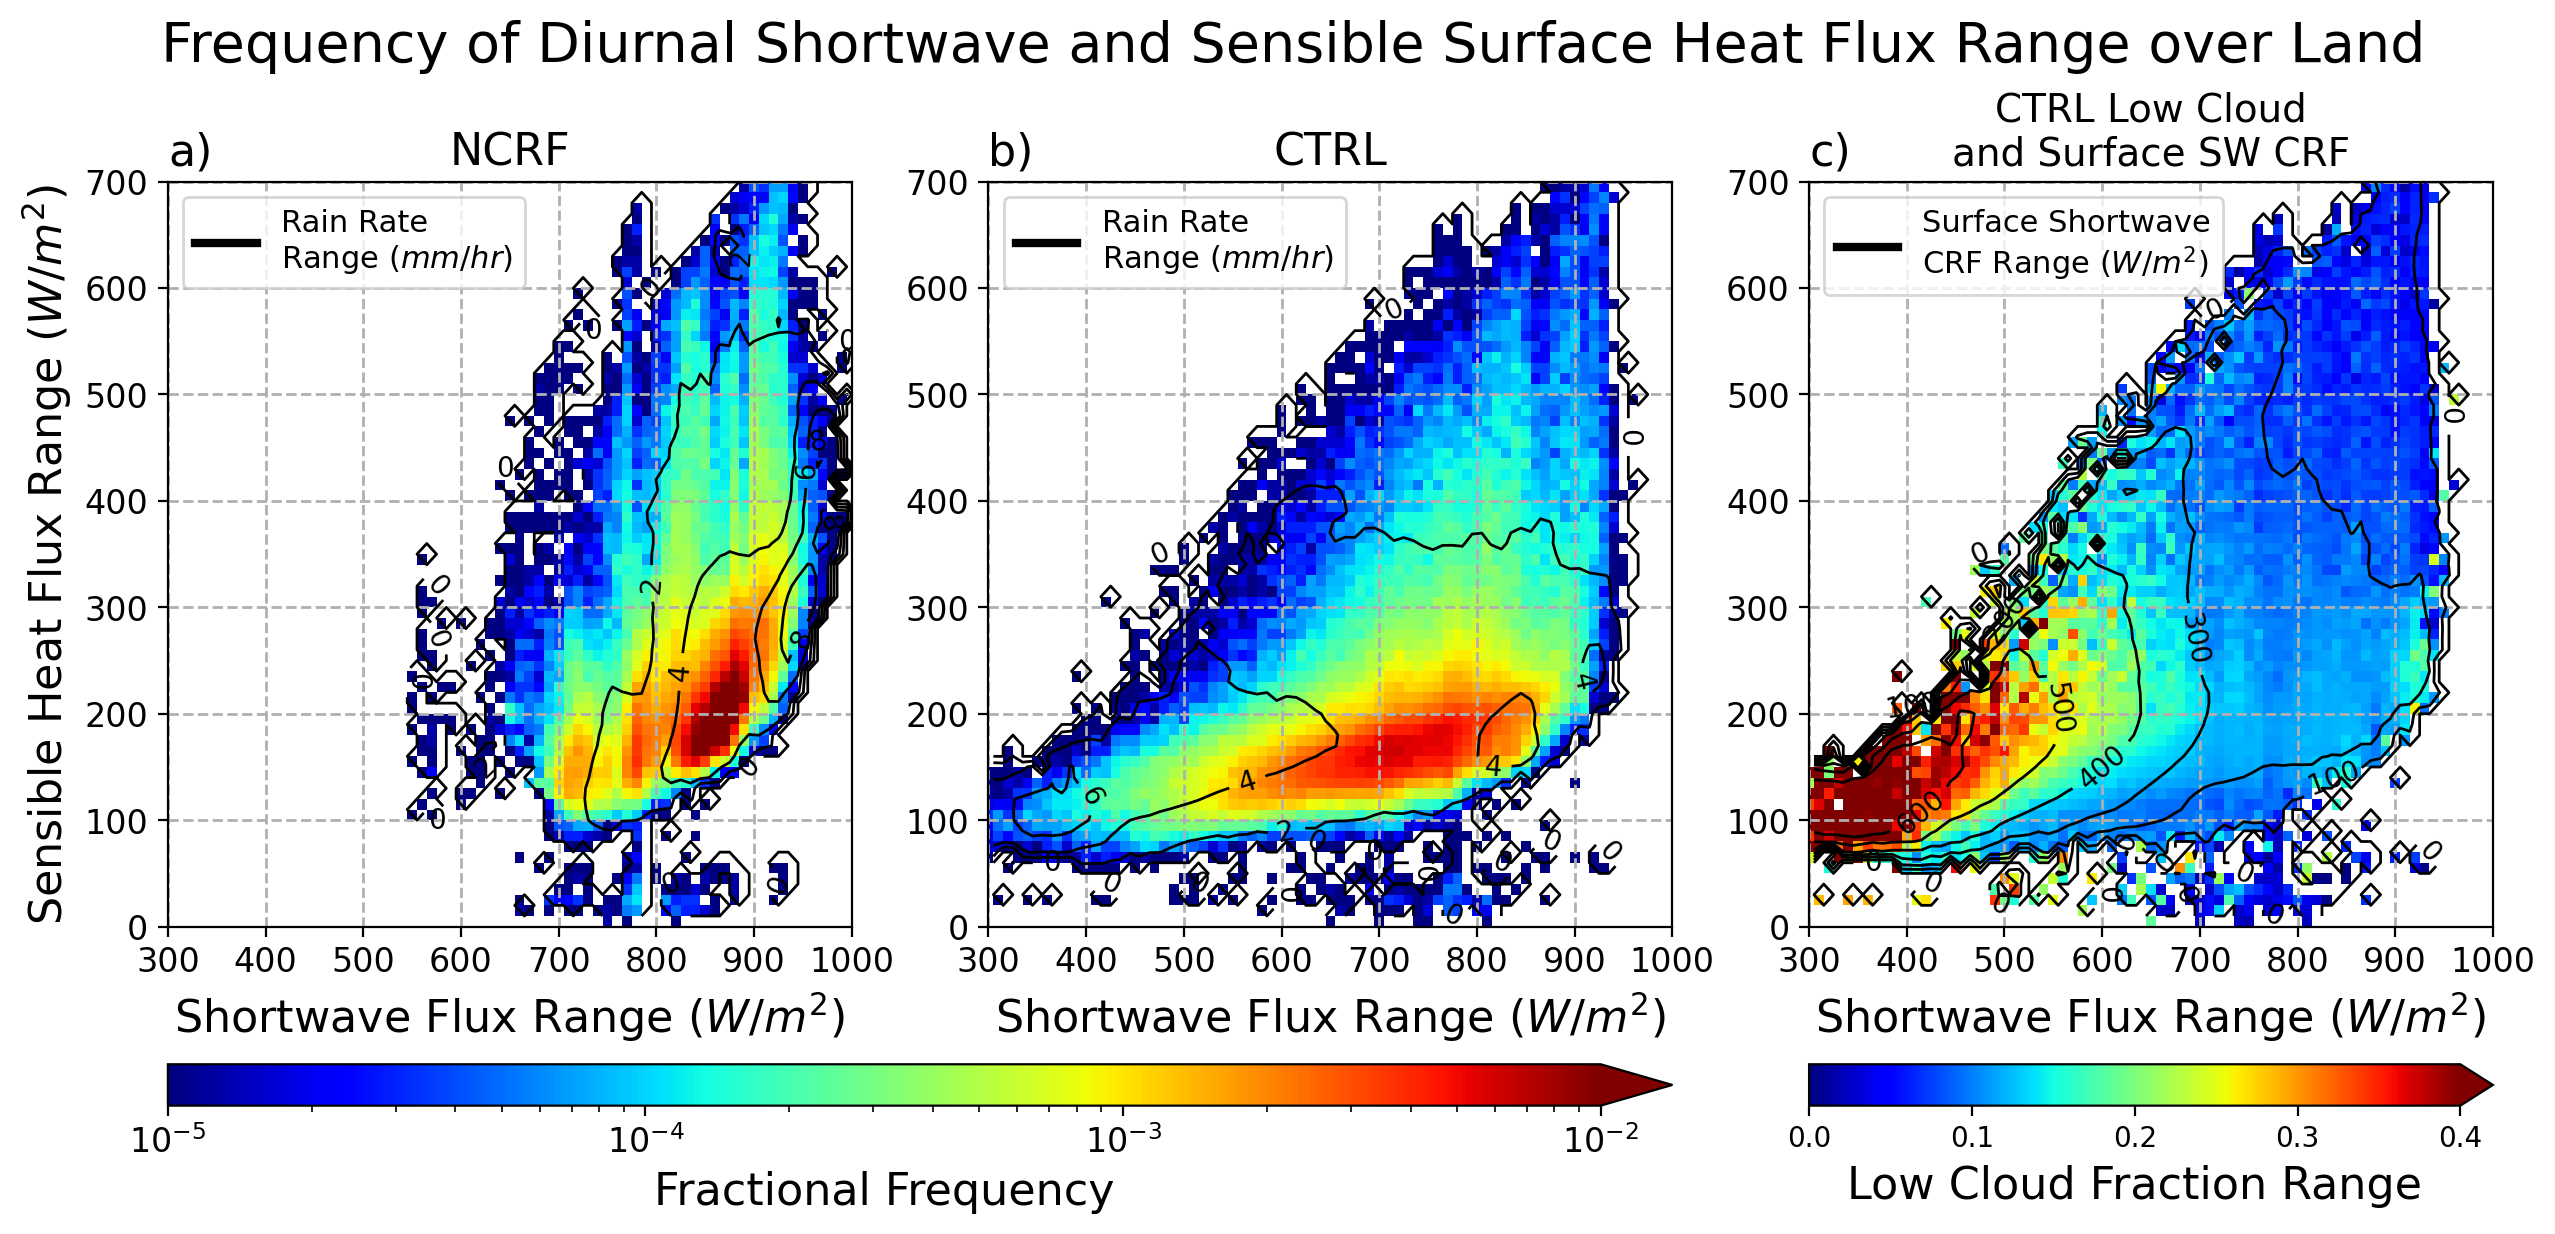

In [60]:
fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[0.9,0.05], width_ratios=[0.30,0.30,0.30], hspace=0.35, wspace=0.2)
fs = 18

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'
probability_density = True

hour = 12

x_levels = [300, 1000]
x_dl = 10
if domain=='Ocean':
	y_levels = [0, 100]
	y_dl = 2
else:
	y_levels = [0, 700]
	y_dl = 10

if probability_density:
	# c_levels = [10**-7,0.0002]
	# c_dl = .00002
	c_levels = [10**-5,0.01]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500

rr_levels = np.arange(0,11,2)
roll = 5

# fig.suptitle(f'Diurnal HFX & SW SFC Range over the MC {domain}, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Frequency of Diurnal Shortwave and Sensible Surface Heat Flux Range over {domain}', fontsize=fs+2, y=1.015)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
	y=amplitude_HFX_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
	RR=amplitude_RR_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_di_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
	y=amplitude_HFX_di_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
	RR=amplitude_RR_di_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_di_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]
	y=amplitude_HFX_di_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]
	RR=amplitude_RR_di_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]


if domain=='Land':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of events
	H_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	
	# Take the summation of the amplitudes over each bin
	H_RR_di_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR/H_di_sunrise_n)
	H_RR_di_sunrise_zeros = np.argwhere(H_RR_di_sunrise==0)	# Find where all the zeros are
	H_RR_di_sunrise = xr.DataArray(H_RR_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_sunrise[H_RR_di_sunrise_zeros[:,0],H_RR_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!

	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
		# Add legend for the contour
		legend_lines = [plt.Line2D([0], [0], color='k', linewidth=3)]
		ax1.legend(legend_lines, ['Rain Rate\nRange ($mm/hr$)'], fontsize=fs-7, loc='upper left')

	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_di_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR/H_di_sunrise_n)
	H_RR_di_sunrise_zeros = np.argwhere(H_RR_di_sunrise==0)	# Find where all the zeros are
	H_RR_di_sunrise = xr.DataArray(H_RR_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_sunrise[H_RR_di_sunrise_zeros[:,0],H_RR_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_di_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR/H_di_sunrise_n)
	H_RR_di_sunrise_zeros = np.argwhere(H_RR_di_sunrise==0)	# Find where all the zeros are
	H_RR_di_sunrise = xr.DataArray(H_RR_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_sunrise[H_RR_di_sunrise_zeros[:,0],H_RR_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.set_title('NCRF', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# ax1.text(325,655, f'n={len(x)}', color='k',fontsize=fs-8, bbox=props)
# ax1.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax1.set_ylabel('Sensible Heat Flux Range ($W/m^{2}$)',fontsize=fs-2)
ax1.set_xlabel('Shortwave Flux Range ($W/m^{2}$)',fontsize=fs-2)
ax1.set_xticks(np.arange(0,1200,100))
ax1.set_yticks(np.arange(0,1200,100))
ax1.set_xticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax1.set_yticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax1.set_xlim([x_levels[0],x_levels[1]])
ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	y=amplitude_HFX_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	RR=amplitude_RR_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	CLDFRA=amplitude_LowCLDFRA_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	SWCRF=amplitude_SWSFC_CRF_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	# CLDFRA=HighCLDFRA_di_cntl_land.sel(hour=hour).values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	# SWCRF=SWSFC_CRF_di_cntl_land.sel(hour=hour).values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_di_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
	y=amplitude_HFX_di_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
	RR=amplitude_RR_di_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_di_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]
	y=amplitude_HFX_di_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]
	RR=amplitude_RR_di_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_di_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR/H_di_cntl_n)
	H_RR_di_cntl_zeros = np.argwhere(H_RR_di_cntl==0)	# Find where all the zeros are
	H_RR_di_cntl = xr.DataArray(H_RR_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_cntl[H_RR_di_cntl_zeros[:,0],H_RR_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!

	# Take the summation of the amplitudes over each bin
	H_SWCRF_di_cntl_sumSWCRF, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=SWCRF)
	# Divide the two to get average SWCRF amplitude
	H_SWCRF_di_cntl = np.nan_to_num(H_SWCRF_di_cntl_sumSWCRF/H_di_cntl_n)
	H_SWCRF_di_cntl_zeros = np.argwhere(H_SWCRF_di_cntl==0)	# Find where all the zeros are
	H_SWCRF_di_cntl = xr.DataArray(H_SWCRF_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_SWCRF_di_cntl[H_SWCRF_di_cntl_zeros[:,0],H_SWCRF_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!

	# Take the summation of the amplitudes over each bin
	H_CLDFRA_di_cntl_sumCLDFRA, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=CLDFRA)
	# Divide the two to get average CLDFRA amplitude
	H_CLDFRA_di_cntl = np.nan_to_num(H_CLDFRA_di_cntl_sumCLDFRA/H_di_cntl_n)
	H_CLDFRA_di_cntl = np.where(H_CLDFRA_di_cntl==0, np.nan, H_CLDFRA_di_cntl)
	# H_CLDFRA_di_cntl_zeros = np.argwhere(H_CLDFRA_di_cntl==0)	# Find where all the zeros are
	# H_CLDFRA_di_cntl = xr.DataArray(H_CLDFRA_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	# H_CLDFRA_di_cntl[H_CLDFRA_di_cntl_zeros[:,0],H_CLDFRA_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!

	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_di_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
		# Add legend for the contour
		legend_lines = [plt.Line2D([0], [0], color='k', linewidth=3)]
		ax2.legend(legend_lines, ['Rain Rate\nRange ($mm/hr$)'], fontsize=fs-7, loc='upper left')
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_di_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR/H_RR_di_cntl_n)
	H_RR_di_cntl_zeros = np.argwhere(H_RR_di_cntl==0)	# Find where all the zeros are
	H_RR_di_cntl = xr.DataArray(H_RR_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_cntl[H_RR_di_cntl_zeros[:,0],H_RR_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_di_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_di_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR/H_RR_di_cntl_n)
	H_RR_di_cntl_zeros = np.argwhere(H_RR_di_cntl==0)	# Find where all the zeros are
	H_RR_di_cntl = xr.DataArray(H_RR_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_cntl[H_RR_di_cntl_zeros[:,0],H_RR_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_di_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax2.set_title('CTRL', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# ax1.text(325,655, f'n={len(x)}', color='k',fontsize=fs-8, bbox=props)
# ax2.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax2.set_ylabel('')
ax2.set_xlabel('Shortwave Flux Range ($W/m^{2}$)',fontsize=fs-2)
ax2.set_xticks(np.arange(0,1200,100))
ax2.set_yticks(np.arange(0,1200,100))
ax2.set_xticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax2.set_yticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax2.set_xlim([x_levels[0],x_levels[1]])
ax2.set_ylim([y_levels[0],y_levels[1]])
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[1,0:2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_ticklabels(np.array([0,10**-5,10**-4,10**-3,10**-2]), fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency', fontsize=fs-2)
else:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')

# if probability_density:
# 	c_levels = [-0.01,0.01]
# 	c_dl = .002
# else:
# 	c_levels = [0,5000]
# 	c_dl = 500
	


# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
# cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
# 											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
# cc = ax3.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T-H_RR_di_cntl.T, colors='k', linewidths=1, levels=np.arange(-6,10,2), vmin=c_levels[0], vmax=c_levels[1])
cf = ax3.pcolormesh(X, Y, H_CLDFRA_di_cntl.T, cmap='jet', vmin=0, vmax=0.4)
cc = ax3.contour(X[1:,1:],Y[1:,1:], H_SWCRF_di_cntl.T, colors='k', linewidths=1, levels=np.arange(0,700,100))
# cc = ax3.contour(X[1:,1:],Y[1:,1:], H_SWCRF_di_cntl.T, colors='k', linewidths=1, levels=np.arange(-600,1,100))


ax3.clabel(cc, inline=True, fontsize=10)
# Add legend for the contour
legend_lines = [plt.Line2D([0], [0], color='k', linewidth=3)]
ax3.legend(legend_lines, ['Surface Shortwave\nCRF Range ($W/m^{2}$)'], fontsize=fs-7, loc='upper left')

ax3.set_title('CTRL Low Cloud\nand Surface SW CRF', loc='center', fontsize=fs-4)
ax3.set_title('c)', loc='left', fontsize=fs-2)
ax3.set_ylabel('')
ax3.set_xlabel('Shortwave Flux Range ($W/m^{2}$)',fontsize=fs-2)
ax3.set_xticks(np.arange(0,1200,100))
ax3.set_yticks(np.arange(0,1200,100))
ax3.set_xticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax3.set_yticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax3.set_xlim([x_levels[0],x_levels[1]])
ax3.set_ylim([y_levels[0],y_levels[1]])
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[1,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='max', ticks=np.arange(0,0.5,0.1))#np.array([0,.25,.5,.75,1])
	# tick_labels = [f'$-10^{{{-2}}}$',f'$-10^{{{-3}}}$','0',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	# cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Low Cloud Fraction Range', fontsize=fs-2)
else:
	cbar.set_label('Frequency')

Version 3 (Terrain)

/tmp/ipykernel_24646/3997291066.py:67: RuntimeWarning: invalid value encountered in divide
  H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR/H_di_sunrise_n)
/tmp/ipykernel_24646/3997291066.py:167: RuntimeWarning: invalid value encountered in divide
  H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR/H_di_cntl_n)
/tmp/ipykernel_24646/3997291066.py:175: RuntimeWarning: invalid value encountered in divide
  H_terrain_di_cntl = np.nan_to_num(H_terrain_di_cntl_sumterrain/H_di_cntl_n)
/tmp/ipykernel_24646/3997291066.py:183: RuntimeWarning: invalid value encountered in divide
  H_CLDFRA_di_cntl = np.nan_to_num(H_CLDFRA_di_cntl_sumCLDFRA/H_di_cntl_n)


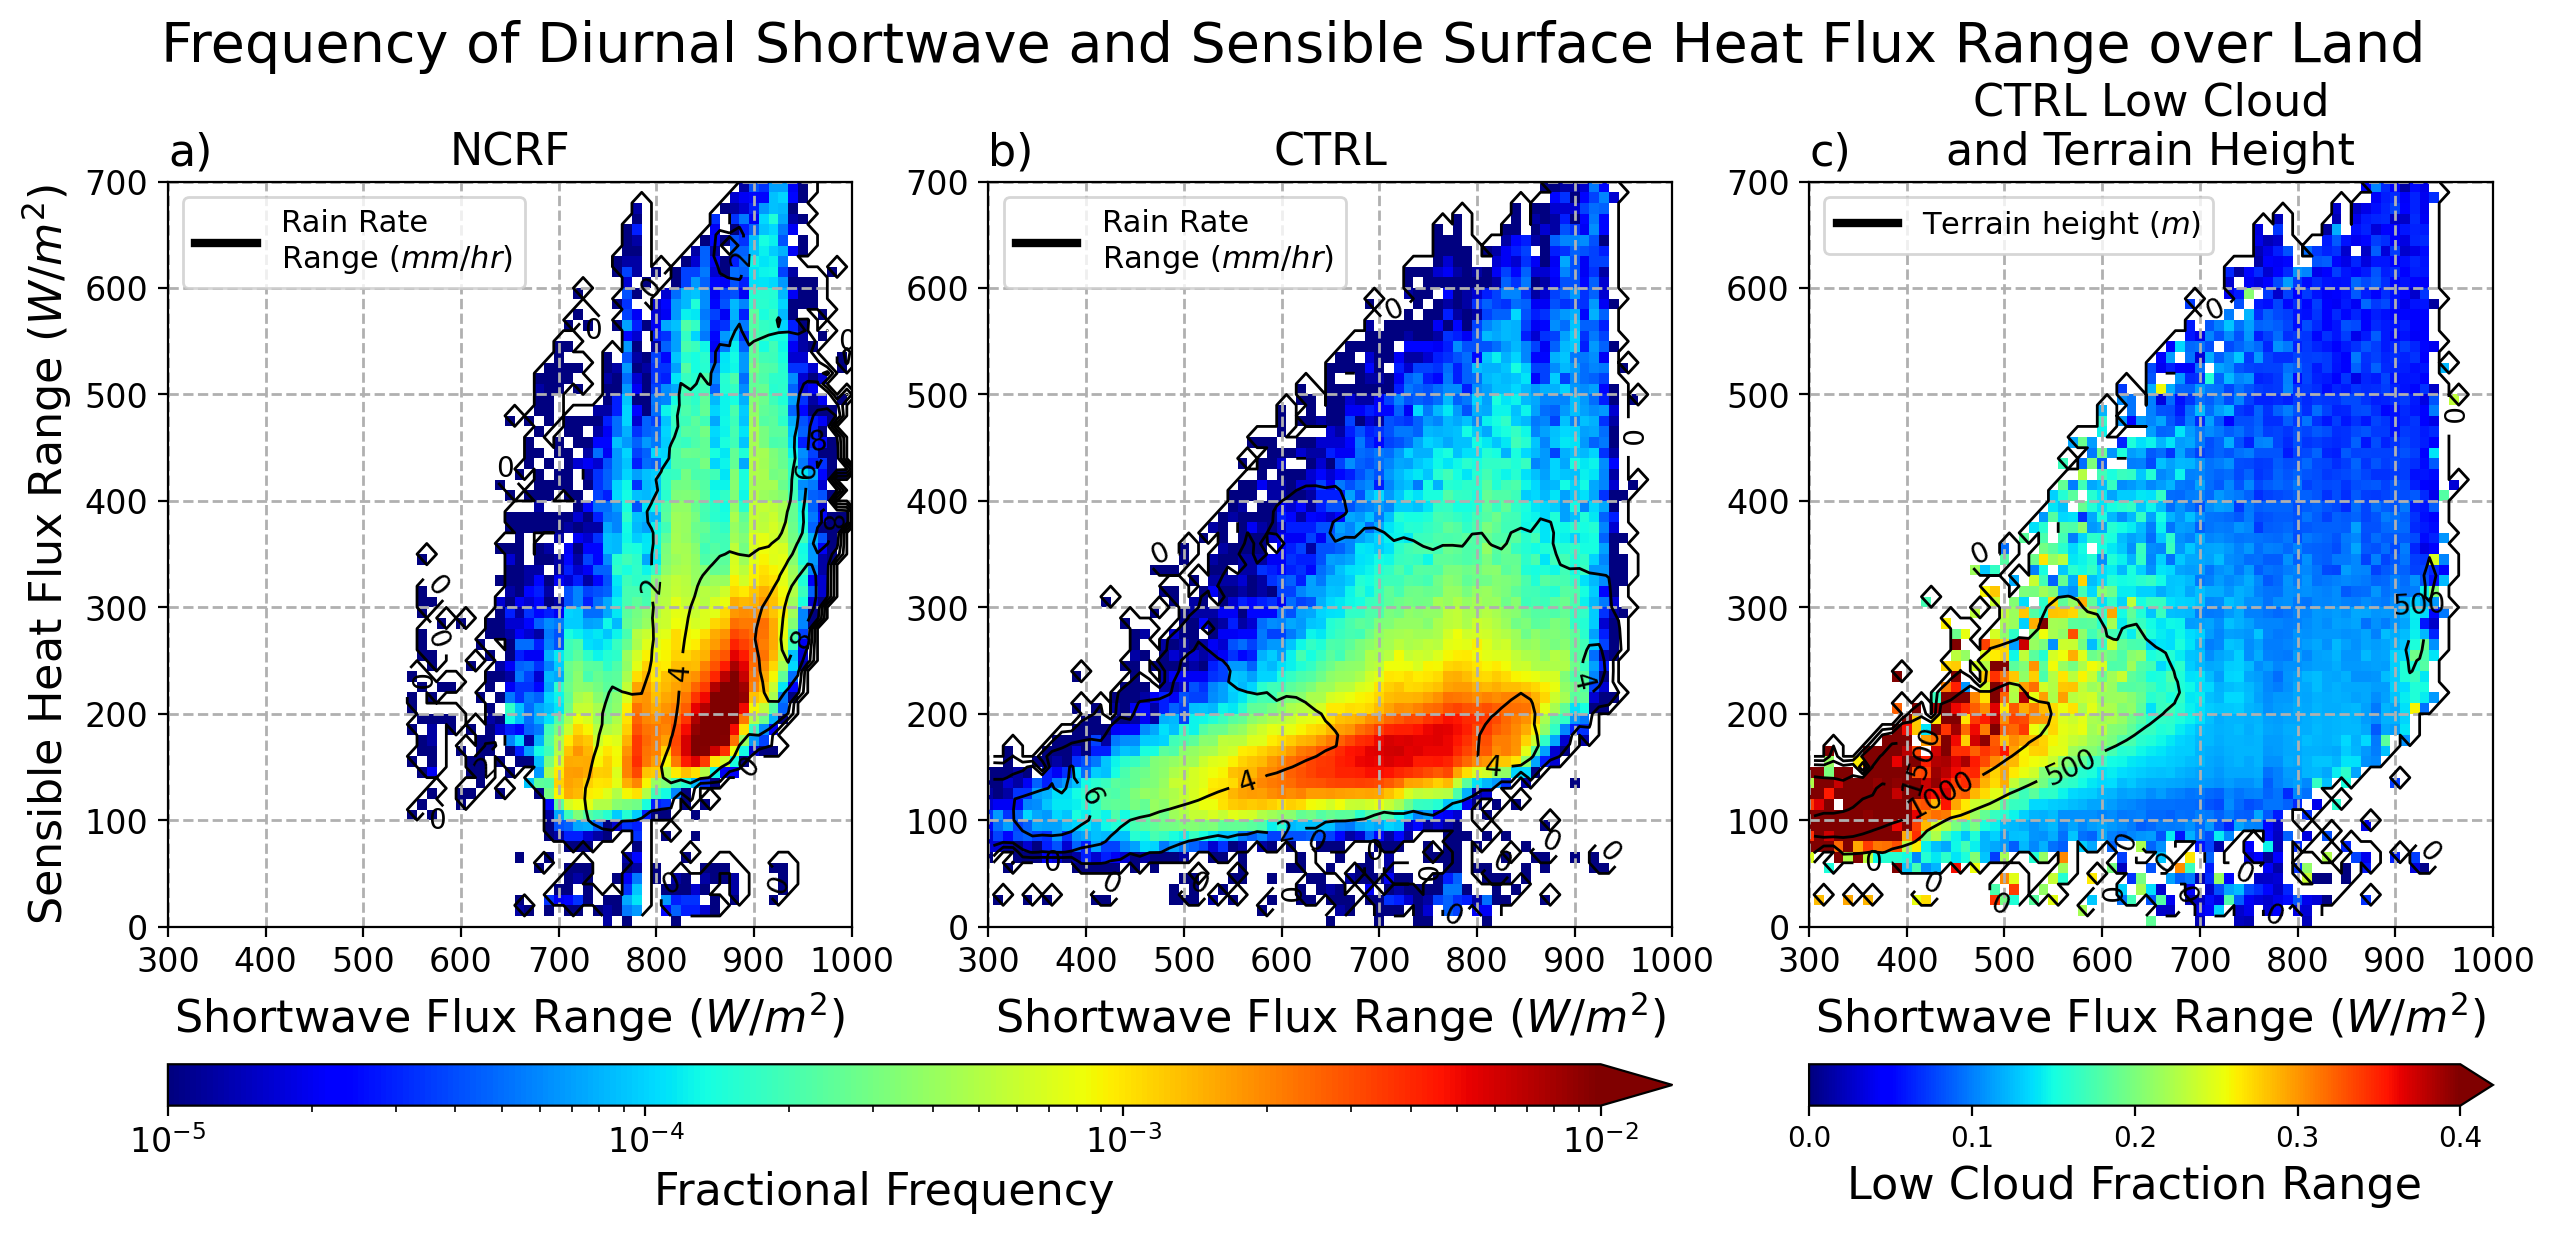

In [68]:
fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[0.9,0.05], width_ratios=[0.30,0.30,0.30], hspace=0.35, wspace=0.2)
fs = 18

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'
probability_density = True

hour = 12

x_levels = [300, 1000]
x_dl = 10
if domain=='Ocean':
	y_levels = [0, 100]
	y_dl = 2
else:
	y_levels = [0, 700]
	y_dl = 10

if probability_density:
	# c_levels = [10**-7,0.0002]
	# c_dl = .00002
	c_levels = [10**-5,0.01]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500

rr_levels = np.arange(0,11,2)
roll = 5

# fig.suptitle(f'Diurnal HFX & SW SFC Range over the MC {domain}, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Frequency of Diurnal Shortwave and Sensible Surface Heat Flux Range over {domain}', fontsize=fs+2, y=1.015)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
	y=amplitude_HFX_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
	RR=amplitude_RR_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_di_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
	y=amplitude_HFX_di_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
	RR=amplitude_RR_di_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_di_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]
	y=amplitude_HFX_di_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]
	RR=amplitude_RR_di_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]


if domain=='Land':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of events
	H_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	
	# Take the summation of the amplitudes over each bin
	H_RR_di_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR/H_di_sunrise_n)
	H_RR_di_sunrise_zeros = np.argwhere(H_RR_di_sunrise==0)	# Find where all the zeros are
	H_RR_di_sunrise = xr.DataArray(H_RR_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_sunrise[H_RR_di_sunrise_zeros[:,0],H_RR_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!

	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
		# Add legend for the contour
		legend_lines = [plt.Line2D([0], [0], color='k', linewidth=3)]
		ax1.legend(legend_lines, ['Rain Rate\nRange ($mm/hr$)'], fontsize=fs-7, loc='upper left')

	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_di_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR/H_di_sunrise_n)
	H_RR_di_sunrise_zeros = np.argwhere(H_RR_di_sunrise==0)	# Find where all the zeros are
	H_RR_di_sunrise = xr.DataArray(H_RR_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_sunrise[H_RR_di_sunrise_zeros[:,0],H_RR_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_di_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR/H_di_sunrise_n)
	H_RR_di_sunrise_zeros = np.argwhere(H_RR_di_sunrise==0)	# Find where all the zeros are
	H_RR_di_sunrise = xr.DataArray(H_RR_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_sunrise[H_RR_di_sunrise_zeros[:,0],H_RR_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.set_title('NCRF', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# ax1.text(325,655, f'n={len(x)}', color='k',fontsize=fs-8, bbox=props)
# ax1.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax1.set_ylabel('Sensible Heat Flux Range ($W/m^{2}$)',fontsize=fs-2)
ax1.set_xlabel('Shortwave Flux Range ($W/m^{2}$)',fontsize=fs-2)
ax1.set_xticks(np.arange(0,1200,100))
ax1.set_yticks(np.arange(0,1200,100))
ax1.set_xticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax1.set_yticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax1.set_xlim([x_levels[0],x_levels[1]])
ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	y=amplitude_HFX_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	RR=amplitude_RR_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	CLDFRA=amplitude_LowCLDFRA_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	# terrain=amplitude_SWSFC_CRF_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	terrain=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	# CLDFRA=HighCLDFRA_di_cntl_land.sel(hour=hour).values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	# terrain=SWSFC_CRF_di_cntl_land.sel(hour=hour).values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_di_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
	y=amplitude_HFX_di_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
	RR=amplitude_RR_di_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_di_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]
	y=amplitude_HFX_di_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]
	RR=amplitude_RR_di_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_di_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR/H_di_cntl_n)
	H_RR_di_cntl_zeros = np.argwhere(H_RR_di_cntl==0)	# Find where all the zeros are
	H_RR_di_cntl = xr.DataArray(H_RR_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_cntl[H_RR_di_cntl_zeros[:,0],H_RR_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!

	# Take the summation of the amplitudes over each bin
	H_terrain_di_cntl_sumterrain, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=terrain)
	# Divide the two to get average terrain amplitude
	H_terrain_di_cntl = np.nan_to_num(H_terrain_di_cntl_sumterrain/H_di_cntl_n)
	H_terrain_di_cntl_zeros = np.argwhere(H_terrain_di_cntl==0)	# Find where all the zeros are
	H_terrain_di_cntl = xr.DataArray(H_terrain_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_terrain_di_cntl[H_terrain_di_cntl_zeros[:,0],H_terrain_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!

	# Take the summation of the amplitudes over each bin
	H_CLDFRA_di_cntl_sumCLDFRA, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=CLDFRA)
	# Divide the two to get average CLDFRA amplitude
	H_CLDFRA_di_cntl = np.nan_to_num(H_CLDFRA_di_cntl_sumCLDFRA/H_di_cntl_n)
	H_CLDFRA_di_cntl = np.where(H_CLDFRA_di_cntl==0, np.nan, H_CLDFRA_di_cntl)
	# H_CLDFRA_di_cntl_zeros = np.argwhere(H_CLDFRA_di_cntl==0)	# Find where all the zeros are
	# H_CLDFRA_di_cntl = xr.DataArray(H_CLDFRA_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	# H_CLDFRA_di_cntl[H_CLDFRA_di_cntl_zeros[:,0],H_CLDFRA_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!

	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_di_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
		# Add legend for the contour
		legend_lines = [plt.Line2D([0], [0], color='k', linewidth=3)]
		ax2.legend(legend_lines, ['Rain Rate\nRange ($mm/hr$)'], fontsize=fs-7, loc='upper left')
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_di_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR/H_RR_di_cntl_n)
	H_RR_di_cntl_zeros = np.argwhere(H_RR_di_cntl==0)	# Find where all the zeros are
	H_RR_di_cntl = xr.DataArray(H_RR_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_cntl[H_RR_di_cntl_zeros[:,0],H_RR_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_di_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_di_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR/H_RR_di_cntl_n)
	H_RR_di_cntl_zeros = np.argwhere(H_RR_di_cntl==0)	# Find where all the zeros are
	H_RR_di_cntl = xr.DataArray(H_RR_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_cntl[H_RR_di_cntl_zeros[:,0],H_RR_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_di_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='jet', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax2.set_title('CTRL', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# ax1.text(325,655, f'n={len(x)}', color='k',fontsize=fs-8, bbox=props)
# ax2.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax2.set_ylabel('')
ax2.set_xlabel('Shortwave Flux Range ($W/m^{2}$)',fontsize=fs-2)
ax2.set_xticks(np.arange(0,1200,100))
ax2.set_yticks(np.arange(0,1200,100))
ax2.set_xticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax2.set_yticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax2.set_xlim([x_levels[0],x_levels[1]])
ax2.set_ylim([y_levels[0],y_levels[1]])
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[1,0:2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_ticklabels(np.array([0,10**-5,10**-4,10**-3,10**-2]), fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency', fontsize=fs-2)
else:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')

# if probability_density:
# 	c_levels = [-0.01,0.01]
# 	c_dl = .002
# else:
# 	c_levels = [0,5000]
# 	c_dl = 500
	


# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
# cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
# 											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
# cc = ax3.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T-H_RR_di_cntl.T, colors='k', linewidths=1, levels=np.arange(-6,10,2), vmin=c_levels[0], vmax=c_levels[1])
cf = ax3.pcolormesh(X, Y, H_CLDFRA_di_cntl.T, cmap='jet', vmin=0, vmax=0.4)
cc = ax3.contour(X[1:,1:],Y[1:,1:], H_terrain_di_cntl.T, colors='k', linewidths=1, levels=np.arange(0,2250,500))
# cc = ax3.contour(X[1:,1:],Y[1:,1:], H_terrain_di_cntl.T, colors='k', linewidths=1, levels=np.arange(-600,1,100))


ax3.clabel(cc, inline=True, fontsize=10)
# Add legend for the contour
legend_lines = [plt.Line2D([0], [0], color='k', linewidth=3)]
ax3.legend(legend_lines, ['Terrain height ($m$)'], fontsize=fs-7, loc='upper left')

ax3.set_title('CTRL Low Cloud\nand Terrain Height', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
ax3.set_ylabel('')
ax3.set_xlabel('Shortwave Flux Range ($W/m^{2}$)',fontsize=fs-2)
ax3.set_xticks(np.arange(0,1200,100))
ax3.set_yticks(np.arange(0,1200,100))
ax3.set_xticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax3.set_yticklabels(np.arange(0,1200,100), fontsize=fs-6)
ax3.set_xlim([x_levels[0],x_levels[1]])
ax3.set_ylim([y_levels[0],y_levels[1]])
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[1,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='max', ticks=np.arange(0,0.5,0.1))#np.array([0,.25,.5,.75,1])
	# tick_labels = [f'$-10^{{{-2}}}$',f'$-10^{{{-3}}}$','0',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	# cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Low Cloud Fraction Range', fontsize=fs-2)
else:
	cbar.set_label('Frequency')

Figure 6. Terrain Contribution to RR Bulk

Log...
Histogram does not sum to 1 due to missing 0's

In [ ]:
fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[0.9,0.05], width_ratios=[0.30,0.30,0.30], hspace=0.35, wspace=0.2)
fs = 18

fig.suptitle(f'Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = True

x_levels = np.append(0,np.logspace(0, np.log10(3000), num=50))
x_dl = np.diff(x_levels)

y_levels = np.append(0,np.logspace(0, np.log10(30), num=50))
y_dl = np.diff(y_levels)

if probability_density:
	c_levels = [10**-5,10**-2]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# Land
x=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_RR_di_sunrise_land.values.flatten())]
# x=np.where(x<=1.02,1.02,x)
y=amplitude_RR_di_sunrise_land.values.flatten()[~np.isnan(amplitude_RR_di_sunrise_land.values.flatten())]
# y=np.where(y<=1.02,1.02,y)

H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[x_levels, y_levels], density=probability_density, weights=None)
H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])


ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
ax1.set_ylabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax1.set_xlabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[1],x_levels[-1]])
ax1.set_ylim([y_levels[1],y_levels[-1]])
ax1.grid(linestyle='--', axis='both', linewidth=1)
ax1.set_yscale('log')
ax1.set_xscale('log')

# Control
ax2 = fig.add_subplot(gs[0,1])

# Land
x=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_RR_di_cntl_land.values.flatten())]
# x=np.where(x<=1.02,1.02,x)
y=amplitude_RR_di_cntl_land.values.flatten()[~np.isnan(amplitude_RR_di_cntl_land.values.flatten())]
# y=np.where(y<=1.02,1.02,y)

H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[x_levels, y_levels], density=probability_density, weights=None)
H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])


ax2.set_title('Control', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
ax2.set_ylabel('')
ax2.set_xlabel('Terrain Height ($m$)',fontsize=fs-2)
ax2.set_xlim([x_levels[1],x_levels[-1]])
ax2.set_ylim([y_levels[1],y_levels[-1]])
ax2.grid(linestyle='--', axis='both', linewidth=1)
ax2.set_yscale('log')
ax2.set_xscale('log')


# Colorbar
ax4 = fig.add_subplot(gs[1,0:2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2]))
	cbar_ticks = np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-7}}}$',f'$10^{{{-6}}}$',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency', fontsize=fs-2)
else:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')

if probability_density:
	c_levels = [-10**-2,10**-2]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
ax3.set_ylabel('')
ax3.set_xlabel('Terrain Height ($m$)',fontsize=fs-2)
ax3.set_xlim([x_levels[1],x_levels[-1]])
ax3.set_ylim([y_levels[1],y_levels[-1]])
ax3.grid(linestyle='--', axis='both', linewidth=1)
ax3.set_yscale('log')
ax3.set_xscale('log')

ax5 = fig.add_subplot(gs[1,2])
if probability_density:
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-3,-10**-4,0,10**-4,10**-3]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	# tick_labels = [f'$-10^{{{-4}}}$',f'$-10^{{{-5}}}$','0',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$']
	# cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-2)
else:
	cbar.set_label('Frequency')

In [ ]:
H_di_cntl.sum()

RR

In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(16,7))
gs = gridspec.GridSpec(nrows=4, ncols=4, height_ratios=[0.75,.1,0.05,0.05], width_ratios=[0.30,0.30,0.30,.1], hspace=0.15, wspace=0.25)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Frequency of Diurnal Rain Rate Range by Terrain Height', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [0, 20]
x_dl = .75
y_levels = [0, 3000]
y_dl = 150


if probability_density:
	c_levels = [10**-5,10**-3]
	c_dl = .002
else:
	c_levels = [0,.2]
	c_dl = .01

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_RR_di_sunrise_land.values.flatten())]
x=amplitude_RR_di_sunrise_land.values.flatten()[~np.isnan(amplitude_RR_di_sunrise_land.values.flatten())]

# Calculate the frequency contourf
H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_sunrise = (H_di_sunrise/H_di_sunrise.sum(axis=0))	# Normalize by x-axis

# Calculate the average RR range at each terrain height bin
	# Take the number of RR events
H_RR_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_RR_di_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average RR amplitude
H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR.sum(axis=0)/H_RR_di_sunrise_n.sum(axis=0))

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# Plot Average RR range line
ax1.plot(H_RR_di_sunrise, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', linestyle='--', label='NCRF')

# Add legend for the line
legend = ax1.legend(fontsize=fs-7, loc='lower right')
# Adjust alignment using a hack with the legend texts
for text in legend.get_texts():
    text.set_horizontalalignment('center')

ax1.set_title('NCRF', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# ax1.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax1.set_xlabel('',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(np.arange(0,25,5))
ax1.set_yticks(np.arange(0,3500,500))
ax1.set_xticklabels(['','','','',''])
ax1.set_yticklabels(np.arange(0,3500,500), fontsize=fs-6)
ax1.xaxis.set_ticks_position('none') 
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_RR_di_cntl_land.values.flatten())]
x=amplitude_RR_di_cntl_land.values.flatten()[~np.isnan(amplitude_RR_di_cntl_land.values.flatten())]

H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_cntl = (H_di_cntl/H_di_cntl.sum(axis=0))	# Normalize by x-axis

# Calculate the average RR range at each terrain height bin
	# Take the number of RR events
H_RR_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_RR_di_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average RR amplitude
H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR.sum(axis=0)/H_RR_di_cntl_n.sum(axis=0))

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# Plot Average RR range line
ax2.plot(H_RR_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', label='CTRL')
# Add legend for the line
legend = ax2.legend(fontsize=fs-7, loc='lower right')
# Adjust alignment using a hack with the legend texts
for text in legend.get_texts():
    text.set_horizontalalignment('center')

ax2.set_title('CTRL', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# ax2.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax2.set_xlabel('',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(np.arange(0,25,5))
ax2.set_yticks(np.arange(0,3500,500))
ax2.set_xticklabels(['','','','',''])
ax2.set_yticklabels(np.arange(0,3500,500), fontsize=fs-6)
ax2.xaxis.set_ticks_position('none') 
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[3,0:2])
if probability_density:
	cbar_ticks = np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-7}}}$',f'$10^{{{-6}}}$',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency', fontsize=fs-2)
else:
	cbar_ticks = np.array([0,.05,.1,.15,.2,.25,.3])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	# cbar.minorticks_on()
	# tick_labels = [f'$10^{{{-2}}}$',f'$10^{{{-1}}}$','.2','.3']
	# cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Frequency', fontsize=fs-2)


if probability_density:
	c_levels = [-10**-2,10**-2]
	c_dl = .002
else:
	c_levels = [-.5,.5]
	c_dl = .001
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')

# cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1,
# 				levels=np.concatenate([[.01],np.arange(0.05,.225,.05)]), vmin=0, vmax=.3)
# ax3.clabel(cc, inline=True, fontsize=fs-10)
# Add legend for the contour
# legend_lines = [plt.Line2D([0], [0], color='k', linewidth=1.5)]
# legend = ax3.legend(legend_lines, ['Control\nFrequency'], fontsize=fs-8, loc='lower right')
# # Adjust alignment using a hack with the legend texts
# for text in legend.get_texts():
#     text.set_horizontalalignment('center')

# Plot Average RR range line
ax3.plot(H_RR_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', linestyle='-', label='')
ax3.plot(H_RR_di_sunrise, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', linestyle='--', label='')
ax3.plot(H_RR_di_sunrise-H_RR_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='k', linestyle=':', label='NCRF-CTRL')
# Add legend for the line
legend = ax3.legend(fontsize=fs-7, loc='lower right')
# Adjust alignment using a hack with the legend texts
for text in legend.get_texts():
    text.set_horizontalalignment('center')

ax3.set_title('NCRF - CTRL', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
# ax3.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax3.set_xlabel('',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(np.arange(0,25,5))
ax3.set_yticks(np.arange(0,3500,500))
ax3.set_xticklabels(['','','','',''])
ax3.set_yticklabels(np.arange(0,3500,500), fontsize=fs-6)
ax3.xaxis.set_ticks_position('none') 
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[3,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-3,-10**-4,0,10**-4,10**-3]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-3}}}$',f'$-10^{{{-4}}}$','0',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('$\Delta$ Fractional Frequency', fontsize=fs-2)
else:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-1,-10**-2,0,10**-2,10**-1]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-1}}}$',f'$-10^{{{-2}}}$','0',f'$10^{{{-2}}}$',f'$10^{{{-1}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('$\Delta$ Frequency', fontsize=fs-2)

ax6 = fig.add_subplot(gs[1,0])
value1 = H_di_sunrise.sum(axis=1)/H_di_sunrise.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value1, linewidth=2)
ax6.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax6.set_ylabel('Frequency',fontsize=fs-6)
ax6.set_xticks(np.arange(0,25,5))
ax6.set_yticks(np.arange(0,.2,.05))
ax6.set_xticklabels(np.arange(0,25,5), fontsize=fs-6)
ax6.set_yticklabels([.0,.05,.1,.15], fontsize=fs-6)
ax6.set_xlim([x_levels[0],x_levels[-1]])
ax6.set_ylim([0,.14])
ax6.grid(linestyle='--', axis='both', linewidth=1)

ax7 = fig.add_subplot(gs[1,1])
value2 = H_di_cntl.sum(axis=1)/H_di_cntl.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value2, linewidth=2)
ax7.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax7.set_ylabel('',fontsize=fs-8)
ax7.set_xticks(np.arange(0,25,5))
ax7.set_yticks(np.arange(0,.2,.05))
ax7.set_xticklabels(np.arange(0,25,5), fontsize=fs-6)
ax7.set_yticklabels([.0,.05,.1,.15], fontsize=fs-6)
ax7.set_xlim([x_levels[0],x_levels[-1]])
ax7.set_ylim([0,.14])
ax7.grid(linestyle='--', axis='both', linewidth=1)

ax8 = fig.add_subplot(gs[1,2])
value = value1-value2
# value = (H_di_sunrise.T-H_di_cntl.T).sum(axis=0)
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value, linewidth=2)
ax8.yaxis.set_label_position('right')
ax8.yaxis.tick_left()
ax8.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
# ax8.set_ylabel('Anomalous Normalized\n Frequncy',fontsize=fs-8)
ax8.set_xticks(np.arange(0,25,5))
ax8.set_yticks(np.arange(-.2,.2,.1))
ax8.set_xticklabels(np.arange(0,25,5), fontsize=fs-6)
ax8.set_yticklabels([-.2,-.1,.0,.1], fontsize=fs-6)
ax8.set_xlim([x_levels[0],x_levels[-1]])
ax8.set_ylim([-.1,.1])
ax8.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax8.grid(linestyle='--', axis='both', linewidth=1)

ax9 = fig.add_subplot(gs[0,3])
ax9.set_xscale('log')
value, valuebins = np.histogram(y, bins=np.arange(y_levels[0],y_levels[1]+y_dl,y_dl))
distribution_line = plt.plot(value, (valuebins+(y_dl/2))[:-1], linewidth=3)
ax9.set_xlabel('n samples',fontsize=fs-2)
ax9.set_ylabel('',fontsize=fs-8)
ax9.set_xticks(np.array([10**1,10**2,10**3,10**4,10**5]))
# ax9.set_xticks(np.array([10**1,10**3,10**5]))
ax9.set_yticks(np.arange(0,3500,500))
ax9.set_xticklabels([f'$10^{{{1}}}$','',f'$10^{{{3}}}$','',f'$10^{{{5}}}$'], fontsize=fs-6)
# ax9.set_xticklabels([f'$10^{{{1}}}$',f'$10^{{{3}}}$',f'$10^{{{5}}}$'], fontsize=fs-6)
ax9.set_yticklabels(np.arange(0,3500,500), fontsize=fs-6)
ax9.set_ylim([y_levels[0],y_levels[-1]])
ax9.set_xlim([10,value[0]])
ax9.grid(linestyle='--', axis='both', linewidth=1)
ax9.yaxis.set_label_position("right")
ax9.yaxis.tick_right()
# Manually tweak positions (left, bottom, width, height)
ax9.set_position([0.81, 0.335, 0.07, 0.545])  # Move second column slightly

In [ ]:
roll = 1	# Terrain roll

# Terrain height
if roll == 1:
	da_h = ds_d02['HGT'].isel(Time=0).compute()
else:
	da_h = ds_d02['HGT'].isel(Time=0).compute().rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()

# dh/dx, dh/dy
da_h_dx = da_h.differentiate('west_east', edge_order=2)/3000
da_h_dy = da_h.differentiate('south_north', edge_order=2)/3000
da_abs_h = (da_h_dx**2+da_h_dy**2)**(0.5)
da_abs_h_land = xr.where(da_d02_LANDMASK==1, da_abs_h, np.nan)
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(16,7))
gs = gridspec.GridSpec(nrows=4, ncols=4, height_ratios=[0.75,.1,0.05,0.05], width_ratios=[0.30,0.30,0.30,.1], hspace=0.15, wspace=0.25)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Normalized Frequency of Diurnal Rain Rate Range by Terrain Height over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [0, 20]
x_dl = .75
y_levels = [0, .275]
y_dl = .01
y_ticklabels = np.array([0,0.1,0.2,.3])


if probability_density:
	c_levels = [10**-5,10**-3]
	c_dl = .002
else:
	c_levels = [0,.2]
	c_dl = .01

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# Land
y=da_abs_h_land.values.flatten()[~np.isnan(amplitude_RR_di_sunrise_land.values.flatten())]
x=amplitude_RR_di_sunrise_land.values.flatten()[~np.isnan(amplitude_RR_di_sunrise_land.values.flatten())]

# Calculate the frequency contourf
H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_sunrise = (H_di_sunrise/H_di_sunrise.sum(axis=0))	# Normalize by x-axis

# Calculate the average RR range at each terrain height bin
	# Take the number of RR events
H_RR_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_RR_di_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average RR amplitude
H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR.sum(axis=0)/H_RR_di_sunrise_n.sum(axis=0))

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# Plot Average RR range line
ax1.plot(H_RR_di_sunrise, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', linestyle='--', label='NCRF')

# Add legend for the line
legend = ax1.legend(fontsize=fs-7, loc='lower right')
# Adjust alignment using a hack with the legend texts
for text in legend.get_texts():
    text.set_horizontalalignment('center')

ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# ax1.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax1.set_xlabel('',fontsize=fs-2)
ax1.set_ylabel('Terrain slope ($unitless$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(np.arange(0,25,5))
# ax1.set_yticks(np.arange(0,3500,500))
ax1.set_yticks(y_ticklabels)
ax1.set_xticklabels(['','','','',''])
ax1.set_yticklabels(y_ticklabels, fontsize=fs-6)
ax1.xaxis.set_ticks_position('none') 
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# Land
y=da_abs_h_land.values.flatten()[~np.isnan(amplitude_RR_di_cntl_land.values.flatten())]
x=amplitude_RR_di_cntl_land.values.flatten()[~np.isnan(amplitude_RR_di_cntl_land.values.flatten())]

H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_cntl = (H_di_cntl/H_di_cntl.sum(axis=0))	# Normalize by x-axis

# Calculate the average RR range at each terrain height bin
	# Take the number of RR events
H_RR_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_RR_di_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average RR amplitude
H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR.sum(axis=0)/H_RR_di_cntl_n.sum(axis=0))

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# Plot Average RR range line
ax2.plot(H_RR_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', label='CNTL')
# Add legend for the line
legend = ax2.legend(fontsize=fs-7, loc='lower right')
# Adjust alignment using a hack with the legend texts
for text in legend.get_texts():
    text.set_horizontalalignment('center')

ax2.set_title('Control', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# ax2.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax2.set_xlabel('',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(np.arange(0,25,5))
ax2.set_yticks(y_ticklabels)
ax2.set_xticklabels(['','','','',''])
ax2.set_yticklabels(y_ticklabels, fontsize=fs-6)
ax2.xaxis.set_ticks_position('none') 
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[3,0:2])
if probability_density:
	cbar_ticks = np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-7}}}$',f'$10^{{{-6}}}$',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency', fontsize=fs-2)
else:
	cbar_ticks = np.array([0,.05,.1,.15,.2,.25,.3])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	# cbar.minorticks_on()
	# tick_labels = [f'$10^{{{-2}}}$',f'$10^{{{-1}}}$','.2','.3']
	# cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency', fontsize=fs-2)


if probability_density:
	c_levels = [-10**-2,10**-2]
	c_dl = .002
else:
	c_levels = [-.5,.5]
	c_dl = .001
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')

# cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1,
# 				levels=np.concatenate([[.01],np.arange(0.05,.225,.05)]), vmin=0, vmax=.3)
# ax3.clabel(cc, inline=True, fontsize=fs-10)
# Add legend for the contour
# legend_lines = [plt.Line2D([0], [0], color='k', linewidth=1.5)]
# legend = ax3.legend(legend_lines, ['Control\nFrequency'], fontsize=fs-8, loc='lower right')
# # Adjust alignment using a hack with the legend texts
# for text in legend.get_texts():
#     text.set_horizontalalignment('center')

# Plot Average RR range line
ax3.plot(H_RR_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', linestyle='-', label='')
ax3.plot(H_RR_di_sunrise, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', linestyle='--', label='')
ax3.plot(H_RR_di_sunrise-H_RR_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='k', linestyle=':', label='NCRF-CNTL')
# Add legend for the line
legend = ax3.legend(fontsize=fs-7, loc='lower right')
# Adjust alignment using a hack with the legend texts
for text in legend.get_texts():
    text.set_horizontalalignment('center')

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
# ax3.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax3.set_xlabel('',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(np.arange(0,25,5))
ax3.set_yticks(y_ticklabels)
ax3.set_xticklabels(['','','','',''])
ax3.set_yticklabels(y_ticklabels, fontsize=fs-6)
ax3.xaxis.set_ticks_position('none') 
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[3,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-3,-10**-4,0,10**-4,10**-3]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-3}}}$',f'$-10^{{{-4}}}$','0',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-2)
else:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-1,-10**-2,0,10**-2,10**-1]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-1}}}$',f'$-10^{{{-2}}}$','0',f'$10^{{{-2}}}$',f'$10^{{{-1}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency Difference', fontsize=fs-2)

ax6 = fig.add_subplot(gs[1,0])
value1 = H_di_sunrise.sum(axis=1)/H_di_sunrise.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value1, linewidth=2)
ax6.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax6.set_ylabel('Normalized\nFrequency',fontsize=fs-6)
ax6.set_xticks(np.arange(0,25,5))
ax6.set_yticks(np.arange(0,.2,.05))
ax6.set_xticklabels(np.arange(0,25,5), fontsize=fs-6)
ax6.set_yticklabels([.0,.05,.1,.15], fontsize=fs-6)
ax6.set_xlim([x_levels[0],x_levels[-1]])
ax6.set_ylim([0,.14])
ax6.grid(linestyle='--', axis='both', linewidth=1)

ax7 = fig.add_subplot(gs[1,1])
value2 = H_di_cntl.sum(axis=1)/H_di_cntl.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value2, linewidth=2)
ax7.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax7.set_ylabel('',fontsize=fs-8)
ax7.set_xticks(np.arange(0,25,5))
ax7.set_yticks(np.arange(0,.2,.05))
ax7.set_xticklabels(np.arange(0,25,5), fontsize=fs-6)
ax7.set_yticklabels([.0,.05,.1,.15], fontsize=fs-6)
ax7.set_xlim([x_levels[0],x_levels[-1]])
ax7.set_ylim([0,.14])
ax7.grid(linestyle='--', axis='both', linewidth=1)

ax8 = fig.add_subplot(gs[1,2])
value = value1-value2
# value = (H_di_sunrise.T-H_di_cntl.T).sum(axis=0)
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value, linewidth=2)
ax8.yaxis.set_label_position('right')
ax8.yaxis.tick_left()
ax8.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
# ax8.set_ylabel('Anomalous Normalized\n Frequncy',fontsize=fs-8)
ax8.set_xticks(np.arange(0,25,5))
ax8.set_yticks(np.arange(-.2,.2,.1))
ax8.set_xticklabels(np.arange(0,25,5), fontsize=fs-6)
ax8.set_yticklabels([-.2,-.1,.0,.1], fontsize=fs-6)
ax8.set_xlim([x_levels[0],x_levels[-1]])
ax8.set_ylim([-.1,.1])
ax8.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax8.grid(linestyle='--', axis='both', linewidth=1)

ax9 = fig.add_subplot(gs[0,3])
ax9.set_xscale('log')
value, valuebins = np.histogram(y, bins=np.arange(y_levels[0],y_levels[1]+y_dl,y_dl))
distribution_line = plt.plot(value, (valuebins+(y_dl/2))[:-1], linewidth=2)
ax9.set_xlabel('n samples',fontsize=fs-2)
ax9.set_ylabel('',fontsize=fs-8)
ax9.set_xticks(np.array([10**1,10**2,10**3,10**4,10**5]))
# ax9.set_xticks(np.array([10**1,10**3,10**5]))
ax9.set_yticks(y_ticklabels)
ax9.set_xticklabels([f'$10^{{{1}}}$','',f'$10^{{{3}}}$','',f'$10^{{{5}}}$'], fontsize=fs-6)
# ax9.set_xticklabels([f'$10^{{{1}}}$',f'$10^{{{3}}}$',f'$10^{{{5}}}$'], fontsize=fs-6)
ax9.set_yticklabels(y_ticklabels, fontsize=fs-6)
ax9.set_ylim([y_levels[0],y_levels[-1]])
ax9.set_xlim([10,value[0]])
ax9.grid(linestyle='--', axis='both', linewidth=1)
ax9.yaxis.set_label_position("right")
ax9.yaxis.tick_right()
# Manually tweak positions (left, bottom, width, height)
ax9.set_position([0.81, 0.335, 0.07, 0.545])  # Move second column slightly


HFX

In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[0.75,.1,0.05,0.05], width_ratios=[0.30,0.30,0.30], hspace=0.15, wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Normalized Frequency of Diurnal HFX Range by Terrain Height over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [0, 600]
x_dl = 20
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, 100, dtype=int)
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)


if probability_density:
	c_levels = [10**-5,10**-3]
	c_dl = .002
else:
	c_levels = [0,.2]
	c_dl = .01

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_HFX_di_sunrise_land.values.flatten())]
x=amplitude_HFX_di_sunrise_land.values.flatten()[~np.isnan(amplitude_HFX_di_sunrise_land.values.flatten())]

# Calculate the frequency contourf
H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_sunrise = (H_di_sunrise/H_di_sunrise.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# ax1.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax1.set_xlabel('',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(['','','','','','',''])
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.xaxis.set_ticks_position('none') 
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_HFX_di_cntl_land.values.flatten())]
x=amplitude_HFX_di_cntl_land.values.flatten()[~np.isnan(amplitude_HFX_di_cntl_land.values.flatten())]

H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_cntl = (H_di_cntl/H_di_cntl.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax2.set_title('Control', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# ax2.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax2.set_xlabel('',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(['','','','','','',''])
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.xaxis.set_ticks_position('none') 
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[3,0:2])
if probability_density:
	cbar_ticks = np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-7}}}$',f'$10^{{{-6}}}$',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency', fontsize=fs-2)
else:
	cbar_ticks = np.array([0,.05,.1,.15,.2,.25,.3])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	# cbar.minorticks_on()
	# tick_labels = [f'$10^{{{-2}}}$',f'$10^{{{-1}}}$','.2','.3']
	# cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency', fontsize=fs-2)


if probability_density:
	c_levels = [-10**-2,10**-2]
	c_dl = .002
else:
	c_levels = [-.5,.5]
	c_dl = .001
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')

# cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
# 											vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(np.log10(.01), np.log10(0.2), num=7), vmin=10**-3, vmax=.3)
cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1,
				levels=np.concatenate([[.01],np.arange(0.05,.225,.05)]), vmin=0, vmax=.3)
ax3.clabel(cc, inline=True, fontsize=fs-10)

# Add legend for the contour
legend_lines = [plt.Line2D([0], [0], color='k', linewidth=1.5)]
ax3.legend(legend_lines, ['Control Frequency'], fontsize=fs-8, loc='upper right')

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
# ax3.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax3.set_xlabel('',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(['','','','','','',''])
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.xaxis.set_ticks_position('none') 
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[3,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-3,-10**-4,0,10**-4,10**-3]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-3}}}$',f'$-10^{{{-4}}}$','0',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-2)
else:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-1,-10**-2,0,10**-2,10**-1]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-1}}}$',f'$-10^{{{-2}}}$','0',f'$10^{{{-2}}}$',f'$10^{{{-1}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency Difference', fontsize=fs-2)

ax6 = fig.add_subplot(gs[1,0])
value1 = H_di_sunrise.sum(axis=1)/H_di_sunrise.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value1, linewidth=2)
ax6.set_xlabel('Sensible Heat Flux ($W/m^{2}$)',fontsize=fs-2)
ax6.set_ylabel('Normalized\nFrequency',fontsize=fs-6)
ax6.set_xticks(x_ticks)
ax6.set_yticks(np.arange(0,.25,.1))
ax6.set_xticklabels(x_ticks, fontsize=fs-6)
ax6.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax6.set_xlim([x_levels[0],x_levels[-1]])
ax6.set_ylim([0,.2])
ax6.grid(linestyle='--', axis='both', linewidth=1)

ax7 = fig.add_subplot(gs[1,1])
value2 = H_di_cntl.sum(axis=1)/H_di_cntl.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value2, linewidth=2)
ax7.set_xlabel('Sensible Heat Flux ($W/m^{2}$)',fontsize=fs-2)
ax7.set_ylabel('',fontsize=fs-8)
ax7.set_xticks(x_ticks)
ax7.set_yticks(np.arange(0,.25,.1))
ax7.set_xticklabels(x_ticks, fontsize=fs-6)
ax7.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax7.set_xlim([x_levels[0],x_levels[-1]])
ax7.set_ylim([0,.2])
ax7.grid(linestyle='--', axis='both', linewidth=1)

ax8 = fig.add_subplot(gs[1,2])
value = value1-value2
# value = (H_di_sunrise.T-H_di_cntl.T).sum(axis=0)
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value, linewidth=2)
ax8.yaxis.set_label_position('right')
ax8.yaxis.tick_left()
ax8.set_xlabel('Sensible Heat Flux ($W/m^{2}$)',fontsize=fs-2)
# ax8.set_ylabel('Anomalous Normalized\n Frequncy',fontsize=fs-8)
ax8.set_xticks(x_ticks)
ax8.set_yticks(np.arange(-.2,.3,.1))
ax8.set_xticklabels(x_ticks, fontsize=fs-6)
ax8.set_yticklabels([-.2,-.1,.0,.1,.2], fontsize=fs-6)
ax8.set_xlim([x_levels[0],x_levels[-1]])
ax8.set_ylim([-.15,.15])
ax8.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax8.grid(linestyle='--', axis='both', linewidth=1)


LH

In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[0.75,.1,0.05,0.05], width_ratios=[0.30,0.30,0.30], hspace=0.15, wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Normalized Frequency of Diurnal LH Range by Terrain Height over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [0, 600]
x_dl = 20
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, 100, dtype=int)
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)


if probability_density:
	c_levels = [10**-5,10**-3]
	c_dl = .002
else:
	c_levels = [0,.2]
	c_dl = .01

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_LH_di_sunrise_land.values.flatten())]
x=amplitude_LH_di_sunrise_land.values.flatten()[~np.isnan(amplitude_LH_di_sunrise_land.values.flatten())]

# Calculate the frequency contourf
H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_sunrise = (H_di_sunrise/H_di_sunrise.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# ax1.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax1.set_xlabel('',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(['','','','','','',''])
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.xaxis.set_ticks_position('none') 
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_LH_di_cntl_land.values.flatten())]
x=amplitude_LH_di_cntl_land.values.flatten()[~np.isnan(amplitude_LH_di_cntl_land.values.flatten())]

H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_cntl = (H_di_cntl/H_di_cntl.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax2.set_title('Control', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# ax2.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax2.set_xlabel('',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(['','','','','','',''])
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.xaxis.set_ticks_position('none') 
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[3,0:2])
if probability_density:
	cbar_ticks = np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-7}}}$',f'$10^{{{-6}}}$',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency', fontsize=fs-2)
else:
	cbar_ticks = np.array([0,.05,.1,.15,.2,.25,.3])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	# cbar.minorticks_on()
	# tick_labels = [f'$10^{{{-2}}}$',f'$10^{{{-1}}}$','.2','.3']
	# cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency', fontsize=fs-2)


if probability_density:
	c_levels = [-10**-2,10**-2]
	c_dl = .002
else:
	c_levels = [-.5,.5]
	c_dl = .001
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')

# cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
# 											vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(np.log10(.01), np.log10(0.2), num=7), vmin=10**-3, vmax=.3)
cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1,
				levels=np.concatenate([[.01],np.arange(0.05,.225,.05)]), vmin=0, vmax=.3)
ax3.clabel(cc, inline=True, fontsize=fs-10)

# Add legend for the contour
legend_lines = [plt.Line2D([0], [0], color='k', linewidth=1.5)]
ax3.legend(legend_lines, ['Control Frequency'], fontsize=fs-8, loc='upper right')

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
# ax3.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax3.set_xlabel('',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(['','','','','','',''])
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.xaxis.set_ticks_position('none') 
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[3,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-3,-10**-4,0,10**-4,10**-3]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-3}}}$',f'$-10^{{{-4}}}$','0',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-2)
else:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-1,-10**-2,0,10**-2,10**-1]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-1}}}$',f'$-10^{{{-2}}}$','0',f'$10^{{{-2}}}$',f'$10^{{{-1}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency Difference', fontsize=fs-2)

ax6 = fig.add_subplot(gs[1,0])
value1 = H_di_sunrise.sum(axis=1)/H_di_sunrise.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value1, linewidth=2)
ax6.set_xlabel('Latent Heat Flux ($W/m^{2}$)',fontsize=fs-2)
ax6.set_ylabel('Normalized\nFrequency',fontsize=fs-6)
ax6.set_xticks(x_ticks)
ax6.set_yticks(np.arange(0,.25,.1))
ax6.set_xticklabels(x_ticks, fontsize=fs-6)
ax6.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax6.set_xlim([x_levels[0],x_levels[-1]])
ax6.set_ylim([0,.2])
ax6.grid(linestyle='--', axis='both', linewidth=1)

ax7 = fig.add_subplot(gs[1,1])
value2 = H_di_cntl.sum(axis=1)/H_di_cntl.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value2, linewidth=2)
ax7.set_xlabel('Latent Heat Flux ($W/m^{2}$)',fontsize=fs-2)
ax7.set_ylabel('',fontsize=fs-8)
ax7.set_xticks(x_ticks)
ax7.set_yticks(np.arange(0,.25,.1))
ax7.set_xticklabels(x_ticks, fontsize=fs-6)
ax7.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax7.set_xlim([x_levels[0],x_levels[-1]])
ax7.set_ylim([0,.2])
ax7.grid(linestyle='--', axis='both', linewidth=1)

ax8 = fig.add_subplot(gs[1,2])
value = value1-value2
# value = (H_di_sunrise.T-H_di_cntl.T).sum(axis=0)
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value, linewidth=2)
ax8.yaxis.set_label_position('right')
ax8.yaxis.tick_left()
ax8.set_xlabel('Latent Heat Flux ($W/m^{2}$)',fontsize=fs-2)
# ax8.set_ylabel('Anomalous Normalized\n Frequncy',fontsize=fs-8)
ax8.set_xticks(x_ticks)
ax8.set_yticks(np.arange(-.2,.3,.1))
ax8.set_xticklabels(x_ticks, fontsize=fs-6)
ax8.set_yticklabels([-.2,-.1,.0,.1,.2], fontsize=fs-6)
ax8.set_xlim([x_levels[0],x_levels[-1]])
ax8.set_ylim([-.15,.15])
ax8.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax8.grid(linestyle='--', axis='both', linewidth=1)


SWSFC

In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[0.75,.1,0.05,0.05], width_ratios=[0.30,0.30,0.30], hspace=0.15, wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Normalized Frequency of Diurnal SW SFC Range by Terrain Height over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [300, 1000]
x_dl = 25
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, 100, dtype=int)
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)


if probability_density:
	c_levels = [10**-5,10**-3]
	c_dl = .002
else:
	c_levels = [0,.2]
	c_dl = .01

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
x=amplitude_SWSFC_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]

# Calculate the frequency contourf
H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_sunrise = (H_di_sunrise/H_di_sunrise.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# ax1.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax1.set_xlabel('',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(['','','','','','','',''])
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.xaxis.set_ticks_position('none') 
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
x=amplitude_SWSFC_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]

H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_cntl = (H_di_cntl/H_di_cntl.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax2.set_title('Control', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# ax2.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax2.set_xlabel('',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(['','','','','','','',''])
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.xaxis.set_ticks_position('none') 
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[3,0:2])
if probability_density:
	cbar_ticks = np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-7}}}$',f'$10^{{{-6}}}$',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency', fontsize=fs-2)
else:
	cbar_ticks = np.array([0,.05,.1,.15,.2,.25,.3])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	# cbar.minorticks_on()
	# tick_labels = [f'$10^{{{-2}}}$',f'$10^{{{-1}}}$','.2','.3']
	# cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency', fontsize=fs-2)


if probability_density:
	c_levels = [-10**-2,10**-2]
	c_dl = .002
else:
	c_levels = [-.5,.5]
	c_dl = .001
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')

# cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
# 											vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(np.log10(.01), np.log10(0.2), num=7), vmin=10**-3, vmax=.3)
cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1,
				levels=np.concatenate([[.01],np.arange(0.05,.225,.05)]), vmin=0, vmax=.3)
ax3.clabel(cc, inline=True, fontsize=fs-10)

# Add legend for the contour
legend_lines = [plt.Line2D([0], [0], color='k', linewidth=1.5)]
ax3.legend(legend_lines, ['Control Frequency'], fontsize=fs-8, loc='upper right')

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
# ax3.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax3.set_xlabel('',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(['','','','','','','',''])
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.xaxis.set_ticks_position('none') 
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[3,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-3,-10**-4,0,10**-4,10**-3]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-3}}}$',f'$-10^{{{-4}}}$','0',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-2)
else:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-1,-10**-2,0,10**-2,10**-1]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-1}}}$',f'$-10^{{{-2}}}$','0',f'$10^{{{-2}}}$',f'$10^{{{-1}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency Difference', fontsize=fs-2)

ax6 = fig.add_subplot(gs[1,0])
value1 = H_di_sunrise.sum(axis=1)/H_di_sunrise.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value1, linewidth=2)
ax6.set_xlabel('Shortwave Flux ($W/m^{2}$)',fontsize=fs-2)
ax6.set_ylabel('Normalized\nFrequency',fontsize=fs-6)
ax6.set_xticks(x_ticks)
ax6.set_yticks(np.arange(0,.25,.1))
ax6.set_xticklabels(x_ticks, fontsize=fs-6)
ax6.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax6.set_xlim([x_levels[0],x_levels[-1]])
ax6.set_ylim([0,.2])
ax6.grid(linestyle='--', axis='both', linewidth=1)

ax7 = fig.add_subplot(gs[1,1])
value2 = H_di_cntl.sum(axis=1)/H_di_cntl.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value2, linewidth=2)
ax7.set_xlabel('Shortwave Flux ($W/m^{2}$)',fontsize=fs-2)
ax7.set_ylabel('',fontsize=fs-8)
ax7.set_xticks(x_ticks)
ax7.set_yticks(np.arange(0,.25,.1))
ax7.set_xticklabels(x_ticks, fontsize=fs-6)
ax7.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax7.set_xlim([x_levels[0],x_levels[-1]])
ax7.set_ylim([0,.2])
ax7.grid(linestyle='--', axis='both', linewidth=1)

ax8 = fig.add_subplot(gs[1,2])
value = value1-value2
# value = (H_di_sunrise.T-H_di_cntl.T).sum(axis=0)
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value, linewidth=2)
ax8.yaxis.set_label_position('right')
ax8.yaxis.tick_left()
ax8.set_xlabel('Shortwave Flux ($W/m^{2}$)',fontsize=fs-2)
# ax8.set_ylabel('Anomalous Normalized\n Frequncy',fontsize=fs-8)
ax8.set_xticks(x_ticks)
ax8.set_yticks(np.arange(-.2,.3,.1))
ax8.set_xticklabels(x_ticks, fontsize=fs-6)
ax8.set_yticklabels([-.2,-.1,.0,.1,.2], fontsize=fs-6)
ax8.set_xlim([x_levels[0],x_levels[-1]])
ax8.set_ylim([-.1,.2])
ax8.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax8.grid(linestyle='--', axis='both', linewidth=1)


Figure 7. SFC flux vs terrain height

In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[0.33,0.33,0.33], wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Diurnal Surface Flux Range by Terrain Height', fontsize=fs+2, y=1.01)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [0, 1000]
x_dl = 20
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, 200, dtype=int)
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# SW
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
x=amplitude_SWSFC_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_SW_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_SW_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_SW_di_sunrise = np.nan_to_num(H_SW_di_sunrise_sum.sum(axis=0)/H_SW_di_sunrise_n.sum(axis=0))

# LW
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_LWSFC_di_sunrise_land.values.flatten())]
x=amplitude_LWSFC_di_sunrise_land.values.flatten()[~np.isnan(amplitude_LWSFC_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_LW_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_LW_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_LW_di_sunrise = np.nan_to_num(H_LW_di_sunrise_sum.sum(axis=0)/H_LW_di_sunrise_n.sum(axis=0))

# HFX
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_HFX_di_sunrise_land.values.flatten())]
x=amplitude_HFX_di_sunrise_land.values.flatten()[~np.isnan(amplitude_HFX_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_HFX_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_HFX_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_HFX_di_sunrise = np.nan_to_num(H_HFX_di_sunrise_sum.sum(axis=0)/H_HFX_di_sunrise_n.sum(axis=0))

# LH
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_LH_di_sunrise_land.values.flatten())]
x=amplitude_LH_di_sunrise_land.values.flatten()[~np.isnan(amplitude_LH_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_LH_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_LH_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_LH_di_sunrise = np.nan_to_num(H_LH_di_sunrise_sum.sum(axis=0)/H_LH_di_sunrise_n.sum(axis=0))


# Plot Average SW range line
ax1.plot(H_SW_di_sunrise, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='SW Range', linestyle='--')
ax1.plot(H_LW_di_sunrise, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', label='LW Range', linestyle='--')
ax1.plot(H_HFX_di_sunrise, (yedges + y_dl/2)[:-1], linewidth=3, color='green', label='SH Range', linestyle='--')
ax1.plot(H_LH_di_sunrise, (yedges + y_dl/2)[:-1], linewidth=3, color='dodgerblue', label='LH Range', linestyle='--')
ax1.plot(H_HFX_di_sunrise+H_LH_di_sunrise, (yedges + y_dl/2)[:-1], linewidth=3, color='cyan', label='SH+LH Range', linestyle='--')

# Add legend for the line
# legend = ax1.legend(fontsize=fs-7, loc='lower right')

ax1.set_title('NCRF', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
ax1.set_xlabel('Surface Flux Range ($W/m^{2}$)',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(x_ticks, fontsize=fs-6)
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])
# SW
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
x=amplitude_SWSFC_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_SW_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_SW_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_SW_di_cntl = np.nan_to_num(H_SW_di_cntl_sum.sum(axis=0)/H_SW_di_cntl_n.sum(axis=0))

# LW
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_LWSFC_di_cntl_land.values.flatten())]
x=amplitude_LWSFC_di_cntl_land.values.flatten()[~np.isnan(amplitude_LWSFC_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_LW_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_LW_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_LW_di_cntl = np.nan_to_num(H_LW_di_cntl_sum.sum(axis=0)/H_LW_di_cntl_n.sum(axis=0))

# HFX
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_HFX_di_cntl_land.values.flatten())]
x=amplitude_HFX_di_cntl_land.values.flatten()[~np.isnan(amplitude_HFX_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_HFX_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_HFX_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_HFX_di_cntl = np.nan_to_num(H_HFX_di_cntl_sum.sum(axis=0)/H_HFX_di_cntl_n.sum(axis=0))

# LH
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_LH_di_cntl_land.values.flatten())]
x=amplitude_LH_di_cntl_land.values.flatten()[~np.isnan(amplitude_LH_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_LH_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_LH_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_LH_di_cntl = np.nan_to_num(H_LH_di_cntl_sum.sum(axis=0)/H_LH_di_cntl_n.sum(axis=0))


# Plot Average SW range line
ax2.plot(H_SW_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='SW')
ax2.plot(H_LW_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', label='LW')
ax2.plot(H_HFX_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='green', label='SH')
ax2.plot(H_LH_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='dodgerblue', label='LH')
ax2.plot(H_HFX_di_cntl+H_LH_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='cyan', label='SH+LH')

# Add legend for the line
legend = ax2.legend(fontsize=fs-6.7, loc='upper right')

ax2.set_title('CTRL', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
ax2.set_xlabel('Surface Flux Range ($W/m^{2}$)',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(x_ticks, fontsize=fs-6)
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.grid(linestyle='--', axis='both', linewidth=1)

#############################################################################################
#############################################################################################
#############################################################################################

x_levels = [0, 500]
x_dl = 20
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, 100, dtype=int)

# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])

# Plot Average SW range line
ax3.plot(H_SW_di_sunrise-H_SW_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='SW Range', linestyle=':')
ax3.plot(H_LW_di_sunrise-H_LW_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', label='LW Range', linestyle=':')
ax3.plot(H_HFX_di_sunrise-H_HFX_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='green', label='SH Range', linestyle=':')
ax3.plot(H_LH_di_sunrise-H_LH_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='dodgerblue', label='LH Range', linestyle=':')
ax3.plot((H_HFX_di_sunrise+H_LH_di_sunrise)-(H_HFX_di_cntl+H_LH_di_cntl), (yedges + y_dl/2)[:-1], linewidth=3, color='cyan', label='SH+LH Range', linestyle=':')

# Add legend for the line
# legend = ax3.legend(fontsize=fs-7, loc='lower right')

ax3.set_title('NCRF - CTRL', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
ax3.set_xlabel('$\Delta$ Surface Flux Range ($W/m^{2}$)',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(x_ticks, fontsize=fs-6)
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.grid(linestyle='--', axis='both', linewidth=1)

### WHAT are the dynamical responses?

Figure 8. Divergence vs terrain height

In [ ]:
############################ Load Data ############################=

#### Diurnal Surface Winds

parent_dir_CNTL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00'
parent_dir_NCRF = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff'

# Data
rolls = 1
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']	# Does not include Dec 2, ends at Dec 1, 23:00 local time
chunk = False

#################################### Control ####################################
## U10

file_name = parent_dir_CNTL + '/L4/U10_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		U10_di_cntl = da_d02_U10.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: U10_di_cntl = da_d02_U10.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: U10_di_cntl = da_d02_U10.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	U10_di_cntl = assign_LT_coord(U10_di_cntl, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	U10_di_cntl = xarray_reduce(U10_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	U10_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	U10_di_cntl.name = 'U10'
	U10_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	U10_di_cntl = xr.open_dataset(file_name)['U10'].compute()

## V10

file_name = parent_dir_CNTL + '/L4/V10_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		V10_di_cntl = da_d02_V10.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: V10_di_cntl = da_d02_V10.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: V10_di_cntl = da_d02_V10.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	V10_di_cntl = assign_LT_coord(V10_di_cntl, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	V10_di_cntl = xarray_reduce(V10_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	V10_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	V10_di_cntl.name = 'V10'
	V10_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	V10_di_cntl = xr.open_dataset(file_name)['V10'].compute()

# ## WindSpeed10

# file_name = parent_dir_CNTL + '/L4/WindSpeed10_di_cntl'

# # Calculate the varaible and save it if it does not exist yet
# if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
# 	# Moving average to "denoise"
# 	if rolls == 1:
# 		Windspeed10_di_cntl = da_d02_Uwind10.sel(Time=slice(time_bound[0],time_bound[1])).copy()
# 	else:
# 		if chunk: Windspeed10_di_cntl = da_d02_Uwind10.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
# 		else: Windspeed10_di_cntl = da_d02_Uwind10.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
# 	Windspeed10_di_cntl = assign_LT_coord(Windspeed10_di_cntl, dim_num=3)	# Create a local time coordinte
# 	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
# 	Windspeed10_di_cntl = xarray_reduce(Windspeed10_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
# 	# Assign attributes
# 	Windspeed10_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
# 	Windspeed10_di_cntl.name = 'Windspeed10'
# 	Windspeed10_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# # If the file exists, load it in
# else:
# 	Windspeed10_di_cntl = xr.open_dataset(file_name)['Windspeed10'].compute()


Windspeed10_di_cntl = (U10_di_cntl**2 + V10_di_cntl**2)**0.5

# Find the max and min values
max_Windspeed10_di_cntl = Windspeed10_di_cntl.max(dim='hour', keep_attrs=True)
min_Windspeed10_di_cntl = Windspeed10_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_Windspeed10_di_cntl = max_Windspeed10_di_cntl-min_Windspeed10_di_cntl
# amplitude_Windspeed10_di_cntl = xr.where(amplitude_Windspeed10_di_cntl==0, np.nan, amplitude_Windspeed10_di_cntl)		# conditional statement
amplitude_Windspeed10_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_Windspeed10_di_cntl, np.nan)
amplitude_Windspeed10_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_Windspeed10_di_cntl, np.nan)

max_Windspeed10_di_cntl_land = xr.where(da_d02_LANDMASK==1, max_Windspeed10_di_cntl, np.nan)
max_Windspeed10_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, max_Windspeed10_di_cntl, np.nan)

#################################### Sunrise ####################################
## U10

file_name = parent_dir_NCRF + '/L4/U10_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		U10_di_sunrise = da_d02_sunrise_U10.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: U10_di_sunrise = da_d02_sunrise_U10.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: U10_di_sunrise = da_d02_sunrise_U10.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	U10_di_sunrise = assign_LT_coord(U10_di_sunrise, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	U10_di_sunrise = xarray_reduce(U10_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	U10_di_sunrise.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	U10_di_sunrise.name = 'U10'
	U10_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	U10_di_sunrise = xr.open_dataset(file_name)['U10'].compute()

## V10

file_name = parent_dir_NCRF + '/L4/V10_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		V10_di_sunrise = da_d02_sunrise_V10.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: V10_di_sunrise = da_d02_sunrise_V10.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: V10_di_sunrise = da_d02_sunrise_V10.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	V10_di_sunrise = assign_LT_coord(V10_di_sunrise, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	V10_di_sunrise = xarray_reduce(V10_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	V10_di_sunrise.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	V10_di_sunrise.name = 'V10'
	V10_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	V10_di_sunrise = xr.open_dataset(file_name)['V10'].compute()


# ## Windspeed10

# file_name = parent_dir_NCRF + '/L4/Windspeed10_di_sunrise'

# # Calculate the varaible and save it if it does not exist yet
# if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
# 	# Moving average to "denoise"
# 	if rolls == 1:
# 		Windspeed10_di_sunrise = da_d02_sunrise_Uwind10.sel(Time=slice(time_bound[0],time_bound[1])).copy()
# 	else:
# 		if chunk: Windspeed10_di_sunrise = da_d02_sunrise_Uwind10.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
# 		else: Windspeed10_di_sunrise = da_d02_sunrise_Uwind10.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
# 	Windspeed10_di_sunrise = assign_LT_coord(Windspeed10_di_sunrise, dim_num=3)	# Create a local time coordinte
# 	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
# 	Windspeed10_di_sunrise = xarray_reduce(Windspeed10_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
# 	# Assign attributes
# 	Windspeed10_di_sunrise.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
# 	Windspeed10_di_sunrise.name = 'Windspeed10'
# 	Windspeed10_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# # If the file exists, load it in
# else:
# 	Windspeed10_di_sunrise = xr.open_dataset(file_name)['Windspeed10'].compute()

Windspeed10_di_sunrise = (U10_di_sunrise**2 + V10_di_sunrise**2)**0.5

# Find the max and min values
max_Windspeed10_di_sunrise = Windspeed10_di_sunrise.max(dim='hour', keep_attrs=True)
min_Windspeed10_di_sunrise = Windspeed10_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_Windspeed10_di_sunrise = max_Windspeed10_di_sunrise-min_Windspeed10_di_sunrise
# amplitude_Windspeed10_di_sunrise = xr.where(amplitude_Windspeed10_di_sunrise==0, np.nan, amplitude_Windspeed10_di_sunrise)		# conditional statement
amplitude_Windspeed10_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_Windspeed10_di_sunrise, np.nan)
amplitude_Windspeed10_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_Windspeed10_di_sunrise, np.nan)
max_Windspeed10_di_sunrise_land = xr.where(da_d02_LANDMASK==1, max_Windspeed10_di_sunrise, np.nan)
max_Windspeed10_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, max_Windspeed10_di_sunrise, np.nan)



## Difference
# Windspeed10_di_diff = Windspeed10_di_sunrise - Windspeed10_di_cntl
U10_di_diff = U10_di_sunrise - U10_di_cntl
V10_di_diff = V10_di_sunrise - V10_di_cntl
Windspeed10_di_diff = (U10_di_diff**2 + V10_di_diff**2)**0.5
# Windspeed10_di_diff = Windspeed10_di_sunrise - Windspeed10_di_cntl
# WindDir_di_diff = wind_direction(U10_di_diff, V10_di_diff)


In [ ]:
# Divergence Equation:
	# del*U = (du/dx)+(dv/dy)
		# dx & dy = 3000m
		# du & dy = u and y differentiated over their respective directions, x and y

grid_spacing = 3000
da_divergence_cntl = (U10_di_cntl.differentiate('west_east', edge_order=2)/grid_spacing) + (V10_di_cntl.differentiate('south_north', edge_order=2)/grid_spacing)
da_divergence_sunrise = (U10_di_sunrise.differentiate('west_east', edge_order=2)/grid_spacing) + (V10_di_sunrise.differentiate('south_north', edge_order=2)/grid_spacing)
da_divergence_diff = da_divergence_sunrise - da_divergence_cntl

da_max_divergence_cntl = da_divergence_cntl.max('hour')
da_min_divergence_cntl = da_divergence_cntl.min('hour')
da_range_divergence_cntl = da_max_divergence_cntl - da_min_divergence_cntl

da_max_divergence_sunrise = da_divergence_sunrise.max('hour')
da_min_divergence_sunrise = da_divergence_sunrise.min('hour')
da_range_divergence_sunrise = da_max_divergence_sunrise-da_min_divergence_sunrise

da_max_divergence_diff = da_divergence_diff.max('hour')
da_min_divergence_diff = da_divergence_diff.min('hour')
da_range_divergence_diff = da_max_divergence_diff-da_min_divergence_diff

In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[0.75,.1,0.05,0.05], width_ratios=[0.30,0.30,0.30], hspace=0.175, wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Frequency of Diurnal Surface Divergence Range by Terrain Height', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [0, .07]
x_dl = .002
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, .01)
blank_x_labels = ['','','','','','','','']
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)


if probability_density:
	c_levels = [10**-5,10**-3]
	c_dl = .002
else:
	c_levels = [0,.15]
	c_dl = .01

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(xr.where(da_d02_LANDMASK==1,da_range_divergence_sunrise,np.nan).values.flatten())]
x=xr.where(da_d02_LANDMASK==1,da_range_divergence_sunrise,np.nan).values.flatten()[~np.isnan(xr.where(da_d02_LANDMASK==1,da_range_divergence_sunrise,np.nan).values.flatten())]

# Calculate the frequency contourf
H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_sunrise = (H_di_sunrise/H_di_sunrise.sum(axis=0))	# Normalize by x-axis

# Calculate the average range at each terrain height bin
	# Take the number of events
H_div_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_div_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_div_di_sunrise = np.nan_to_num(H_div_di_sunrise_sum.sum(axis=0)/H_div_di_sunrise_n.sum(axis=0))

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# Plot Average Div range line
ax1.plot(H_div_di_sunrise, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', linestyle='--', label='NCRF')
# Add legend for the line
legend = ax1.legend(fontsize=fs-7, loc='lower right')
# # Adjust alignment using a hack with the legend texts
# for text in legend.get_texts():
#     text.set_horizontalalignment('center')

ax1.set_title('NCRF', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# ax1.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax1.set_xlabel('',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(blank_x_labels)
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.xaxis.set_ticks_position('none') 
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(xr.where(da_d02_LANDMASK==1,da_range_divergence_cntl,np.nan).values.flatten())]
x=xr.where(da_d02_LANDMASK==1,da_range_divergence_cntl,np.nan).values.flatten()[~np.isnan(xr.where(da_d02_LANDMASK==1,da_range_divergence_cntl,np.nan).values.flatten())]

H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_cntl = (H_di_cntl/H_di_cntl.sum(axis=0))	# Normalize by x-axis

# Calculate the average range at each terrain height bin
	# Take the number of events
H_div_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_div_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_div_di_cntl = np.nan_to_num(H_div_di_cntl_sum.sum(axis=0)/H_div_di_cntl_n.sum(axis=0))

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# Plot Average Div range line
ax2.plot(H_div_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', linestyle='-', label='CTRL')
# Add legend for the line
legend = ax2.legend(fontsize=fs-7, loc='lower right')
# # Adjust alignment using a hack with the legend texts
# for text in legend.get_texts():
#     text.set_horizontalalignment('center')

ax2.set_title('CTRL', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# ax2.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax2.set_xlabel('',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(blank_x_labels)
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.xaxis.set_ticks_position('none') 
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[3,0:2])
if probability_density:
	cbar_ticks = np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-7}}}$',f'$10^{{{-6}}}$',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency', fontsize=fs-2)
else:
	cbar_ticks = np.array([0,.05,.1,.15,.2,.25,.3])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	# cbar.minorticks_on()
	# tick_labels = [f'$10^{{{-2}}}$',f'$10^{{{-1}}}$','.2','.3']
	# cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Frequency', fontsize=fs-2)


if probability_density:
	c_levels = [-10**-2,10**-2]
	c_dl = .002
else:
	c_levels = [-.5,.5]
	c_dl = .001
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
# cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1,
# 				levels=np.concatenate([[.01],np.arange(0.05,.225,.05)]), vmin=0, vmax=.3)
# ax3.clabel(cc, inline=True, fontsize=fs-10)

# Plot Average Div range line
ax3.plot(H_div_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen',linestyle='-', label='')
ax3.plot(H_div_di_sunrise, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', linestyle='--', label='')
ax3.plot(H_div_di_sunrise-H_div_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='k',linestyle=':', label='NCRF-CTRL')
# Add legend for the line
legend = ax3.legend(fontsize=fs-7, loc='lower right')
# # Adjust alignment using a hack with the legend texts
# for text in legend.get_texts():
#     text.set_horizontalalignment('center')

# # Add legend for the contour
# legend_lines = [plt.Line2D([0], [0], color='k', linewidth=1.5)]
# ax3.legend(legend_lines, ['Control Frequency'], fontsize=fs-8, loc='upper right')

ax3.set_title('NCRF - CTRL', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
# ax3.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax3.set_xlabel('',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(blank_x_labels)
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.xaxis.set_ticks_position('none') 
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[3,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-3,-10**-4,0,10**-4,10**-3]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-3}}}$',f'$-10^{{{-4}}}$','0',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-2)
else:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-1,-10**-2,0,10**-2,10**-1]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-1}}}$',f'$-10^{{{-2}}}$','0',f'$10^{{{-2}}}$',f'$10^{{{-1}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('$\Delta$ Frequency', fontsize=fs-2)

ax6 = fig.add_subplot(gs[1,0])
value1 = H_di_sunrise.sum(axis=1)/H_di_sunrise.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value1, linewidth=2)
ax6.set_xlabel('Divergence Range ($s^{-1}$)',fontsize=fs-2)
ax6.set_ylabel('Frequency',fontsize=fs-6)
ax6.set_xticks(x_ticks)
ax6.set_yticks(np.arange(0,.25,.1))
ax6.set_xticklabels(x_ticks, fontsize=fs-6)
ax6.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax6.set_xlim([x_levels[0],x_levels[-1]])
ax6.set_ylim([0,.1])
ax6.grid(linestyle='--', axis='both', linewidth=1)

ax7 = fig.add_subplot(gs[1,1])
value2 = H_di_cntl.sum(axis=1)/H_di_cntl.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value2, linewidth=2)
ax7.set_xlabel('Divergence Range ($s^{-1}$)',fontsize=fs-2)
ax7.set_ylabel('',fontsize=fs-8)
ax7.set_xticks(x_ticks)
ax7.set_yticks(np.arange(0,.25,.1))
ax7.set_xticklabels(x_ticks, fontsize=fs-6)
ax7.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax7.set_xlim([x_levels[0],x_levels[-1]])
ax7.set_ylim([0,.1])
ax7.grid(linestyle='--', axis='both', linewidth=1)

ax8 = fig.add_subplot(gs[1,2])
value = value1-value2
# value = (H_di_sunrise.T-H_di_cntl.T).sum(axis=0)
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value, linewidth=2)
ax8.yaxis.set_label_position('right')
ax8.yaxis.tick_left()
ax8.set_xlabel('Divergence Range ($s^{-1}$)',fontsize=fs-2)
# ax8.set_ylabel('Anomalous Normalized\n Frequncy',fontsize=fs-8)
ax8.set_xticks(x_ticks)
# ax8.set_yticks(np.arange(-.2,.3,.1))
ax8.set_yticks(np.arange(-.1,.15,.05))
ax8.set_xticklabels(x_ticks, fontsize=fs-6)
# ax8.set_yticklabels([-.2,-.1,.0,.1,.2], fontsize=fs-6)
ax8.set_yticklabels([-.1,-.05,.0,.05,.1], fontsize=fs-6)
ax8.set_xlim([x_levels[0],x_levels[-1]])
ax8.set_ylim([-.05,.05])
ax8.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax8.grid(linestyle='--', axis='both', linewidth=1)

Figure 9: Winds during max and min divergence

In [ ]:
roll = 30
# Windspeed10_di_diff = (U10_di_diff**2 + V10_di_diff**2)**0.5
Windspeed10_di_diff = Windspeed10_di_sunrise - Windspeed10_di_cntl
if roll == 1:
    Windspeed_roll_cntl = Windspeed10_di_cntl
    Windspeed_roll_diff = Windspeed10_di_diff
    U_roll_cntl = U10_di_cntl
    V_roll_cntl = V10_di_cntl
    U_roll_diff = U10_di_diff
    V_roll_diff = V10_di_diff
    # divergence_roll_cntl = da_divergence_cntl
    # divergence_roll_sunrise = da_divergence_sunrise
    # divergence_roll_diff = da_divergence_diff
else:
    Windspeed_roll_cntl = Windspeed10_di_cntl.rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()
    Windspeed_roll_diff = Windspeed10_di_diff.rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()
    U_roll_cntl = U10_di_cntl.rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()
    V_roll_cntl = V10_di_cntl.rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()
    # U_roll_sunrise = U10_di_sunrise.rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()
    # V_roll_sunrise = V10_di_sunrise.rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()
    U_roll_diff = U10_di_diff.rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()
    V_roll_diff = V10_di_diff.rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()
    # divergence_roll_cntl = da_divergence_cntl.rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()
    # divergence_roll_sunrise = da_divergence_sunrise.rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()
    # divergence_roll_diff = da_divergence_diff.rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()

In [ ]:
fs = 18

wind_levels = [0, 10]
wind_dl = .1
wind_diff_levels = [-3, 3]
wind_diff_dl = .25

div_levels = [-.01, .01]
div_dl = .0005
div_diff_levels = [-.01, .01]
div_diff_dl = .0005

hour1=14
hour2=6
terrain_height_thresh = 750

# ## Regions
# xlim=[99,101]
# ylim=[-.6,.6]
# delta = 1
# scaller = 100

xlim=[90,120]
ylim=[-10,10]
delta = 15
diffdelta = 15
scaller = 150
diffscaller = 75
alpha = 1
diffwindthresh = .25

width = .002
headwidth = 5
headlength = 3
headaxislength = 2

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
                u'0\N{DEGREE SIGN}',
                u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']


fig = plt.figure(figsize=(20,14))
gs = gridspec.GridSpec(nrows=3, ncols=2, hspace=0.2, wspace=0.05, height_ratios=[0.49,0.49,0.03], width_ratios=[.5,.5])

############################################################################################################################
################################################ TOP PANEL #################################################################
############################################################################################################################

## Control
ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))

## Control Winds
cf = Windspeed_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).sel(hour=hour1).plot.contourf(
    ax=ax1,
    add_colorbar=False,
    cmap='afmhot_r',
    levels=np.arange(wind_levels[0]-(wind_dl/2),wind_levels[1]+(wind_dl/2)+wind_dl,wind_dl),
    vmin=wind_levels[0], vmax=wind_levels[1],
    x='west_east',
    y='south_north',
    extend='max',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
)

x = U_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).west_east[::delta].values
y = V_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).south_north[::delta].values
U = U_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour1,::delta,::delta].values
V = V_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour1,::delta,::delta].values
plt.quiver(x,y,U,V, scale=scaller, width=width, headwidth=headwidth, headlength=headlength, headaxislength=headaxislength)

## Plot terrain
topo = da_d02_TOPO.assign_coords(south_north=da_d02_TOPO.XLAT[:,0].values, west_east=da_d02_TOPO.XLONG[0,:].values)
topo = topo.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))
c1 = topo.plot.contour(
    ax=ax1,
    levels = np.array([terrain_height_thresh]),
    add_colorbar=False,
    colors='green',
    x='west_east',
    y='south_north',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
    linewidths=.5,
    alpha=.75,
)
legend_lines = [plt.Line2D([0], [0], color='green', linewidth=2)]
ax1.legend(legend_lines, [str(terrain_height_thresh)+' m'], fontsize=fs-6, loc='upper right')

## Plot coast lines
ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function

ax1.set_title(f'CTRL Surface Winds at {hour1} LST', fontsize=fs, loc='center')
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels, fontsize=fs-6)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xlim([xlim[0],xlim[1]])
ax1.set_ylim([ylim[0],ylim[1]])


## Difference
ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=0))

## Control Winds
cf = Windspeed_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).sel(hour=hour1).plot.contourf(
    ax=ax2,
    add_colorbar=False,
    cmap='RdBu_r',
    levels=np.arange(wind_diff_levels[0]-(wind_diff_dl/2),wind_diff_levels[1]+(wind_diff_dl/2)+wind_diff_dl,wind_diff_dl),
    vmin=wind_diff_levels[0], vmax=wind_diff_levels[1],
    x='west_east',
    y='south_north',
    extend='both',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
)

x = U_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).west_east[::diffdelta].values
y = V_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).south_north[::diffdelta].values
U = U_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour1,::diffdelta,::diffdelta].values
V = V_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour1,::diffdelta,::diffdelta].values
# x = U_roll_sunrise.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).west_east[::diffdelta].values
# y = V_roll_sunrise.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).south_north[::diffdelta].values
# U = U_roll_sunrise.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour1,::diffdelta,::diffdelta].values
# V = V_roll_sunrise.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour1,::diffdelta,::diffdelta].values
mask = abs(Windspeed_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour1,::diffdelta,::diffdelta])>diffwindthresh
plt.quiver(x,y,xr.where(mask, U, np.nan),xr.where(mask, V, np.nan), scale=diffscaller, alpha=alpha, width=width, headwidth=headwidth, headlength=headlength, headaxislength=headaxislength)

## Plot terrain
topo = da_d02_TOPO.assign_coords(south_north=da_d02_TOPO.XLAT[:,0].values, west_east=da_d02_TOPO.XLONG[0,:].values)
topo = topo.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))
c1 = topo.plot.contour(
    ax=ax2,
    levels = np.array([terrain_height_thresh]),
    add_colorbar=False,
    colors='green',
    x='west_east',
    y='south_north',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
    linewidths=.5,
    alpha=.75,
)
legend_lines = [plt.Line2D([0], [0], color='green', linewidth=2)]
ax2.legend(legend_lines, [str(terrain_height_thresh)+' m'], fontsize=fs-6, loc='upper right')

## Plot coast lines
ax2.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function

ax2.set_title(f'$\Delta$ Surface Wind Speed (NCRF-CTRL) at {hour1} LST', fontsize=fs, loc='center')
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax2.set_yticks(y_ticks)
ax2.set_yticklabels(y_tick_labels, fontsize=fs-6)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xlim([xlim[0],xlim[1]])
ax2.set_ylim([ylim[0],ylim[1]])

############################################################################################################################
############################################## BOTTOM PANEL ################################################################
############################################################################################################################

## Control
ax3 = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=0))

## Control Winds
cf = Windspeed_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).sel(hour=hour2).plot.contourf(
    ax=ax3,
    add_colorbar=False,
    cmap='afmhot_r',
    levels=np.arange(wind_levels[0]-(wind_dl/2),wind_levels[1]+(wind_dl/2)+wind_dl,wind_dl),
    vmin=wind_levels[0], vmax=wind_levels[1],
    x='west_east',
    y='south_north',
    extend='max',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
)

x = U_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).west_east[::delta].values
y = V_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).south_north[::delta].values
U = U_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour2,::delta,::delta].values
V = V_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour2,::delta,::delta].values
# plt.quiver(x,y,U,V, scale=scaller, color='gray', alpha=.8)
plt.quiver(x,y,U,V, scale=scaller, width=width, headwidth=headwidth, headlength=headlength, headaxislength=headaxislength)

## Plot terrain
topo = da_d02_TOPO.assign_coords(south_north=da_d02_TOPO.XLAT[:,0].values, west_east=da_d02_TOPO.XLONG[0,:].values)
topo = topo.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))
c1 = topo.plot.contour(
    ax=ax3,
    levels = np.array([terrain_height_thresh]),
    add_colorbar=False,
    colors='green',
    x='west_east',
    y='south_north',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
    linewidths=.5,
    alpha=.75,
)
legend_lines = [plt.Line2D([0], [0], color='green', linewidth=2)]
ax3.legend(legend_lines, [str(terrain_height_thresh)+' m'], fontsize=fs-6, loc='upper right')

## Plot coast lines
ax3.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function

ax3.set_title(f'CTRL Surface Winds at {hour2} LST', fontsize=fs, loc='center')
ax3.set_xticks(x_ticks)
ax3.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax3.set_yticks(y_ticks)
ax3.set_yticklabels(y_tick_labels, fontsize=fs-6)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_xlim([xlim[0],xlim[1]])
ax3.set_ylim([ylim[0],ylim[1]])

cax3 = fig.add_subplot(gs[2,0])
cbar = plt.colorbar(cf, cax=cax3, orientation='horizontal', extend='max', ticks=np.arange(wind_levels[0],wind_levels[1]+wind_dl,2))
cbar.minorticks_off()
cbar.set_ticklabels(np.arange(wind_levels[0],wind_levels[1]+wind_dl,2, dtype=int), fontsize=fs-6)
cbar.set_label('Wind Speed ($m/s$)', fontsize=fs-3)


## Difference
ax4 = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree(central_longitude=0))

## Control Winds
cf = Windspeed_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).sel(hour=hour2).plot.contourf(
    ax=ax4,
    add_colorbar=False,
    cmap='RdBu_r',
    levels=np.arange(wind_diff_levels[0]-(wind_diff_dl/2),wind_diff_levels[1]+(wind_diff_dl/2)+wind_diff_dl,wind_diff_dl),
    vmin=wind_diff_levels[0], vmax=wind_diff_levels[1],
    x='west_east',
    y='south_north',
    extend='both',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
)

x = U_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).west_east[::diffdelta].values
y = V_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).south_north[::diffdelta].values
U = U_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour2,::diffdelta,::diffdelta].values
V = V_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour2,::diffdelta,::diffdelta].values
# x = U_roll_sunrise.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).west_east[::diffdelta].values
# y = V_roll_sunrise.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).south_north[::diffdelta].values
# U = U_roll_sunrise.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour2,::diffdelta,::diffdelta].values
# V = V_roll_sunrise.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour2,::diffdelta,::diffdelta].values
mask = abs(Windspeed_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour2,::diffdelta,::diffdelta])>diffwindthresh
plt.quiver(x,y,xr.where(mask, U, np.nan),xr.where(mask, V, np.nan), scale=diffscaller, alpha=alpha, width=width, headwidth=headwidth, headlength=headlength, headaxislength=headaxislength)

## Plot terrain
topo = da_d02_TOPO.assign_coords(south_north=da_d02_TOPO.XLAT[:,0].values, west_east=da_d02_TOPO.XLONG[0,:].values)
topo = topo.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))
c1 = topo.plot.contour(
    ax=ax4,
    levels = np.array([terrain_height_thresh]),
    add_colorbar=False,
    colors='green',
    x='west_east',
    y='south_north',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
    linewidths=.5,
    alpha=.75,
)
legend_lines = [plt.Line2D([0], [0], color='green', linewidth=2)]
ax4.legend(legend_lines, [str(terrain_height_thresh)+' m'], fontsize=fs-6, loc='upper right')

## Plot coast lines
ax4.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function

ax4.set_title(f'$\Delta$ Surface Winds (NCRF-CTRL) at {hour2} LST', fontsize=fs, loc='center')
ax4.set_xticks(x_ticks)
ax4.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax4.set_yticks(y_ticks)
ax4.set_yticklabels(y_tick_labels, fontsize=fs-6)
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.set_xlim([xlim[0],xlim[1]])
ax4.set_ylim([ylim[0],ylim[1]])

cax4 = fig.add_subplot(gs[2,1])
cbar = plt.colorbar(cf, cax=cax4, orientation='horizontal', extend='both', ticks=np.arange(wind_diff_levels[0],wind_diff_levels[1]+wind_diff_dl,wind_diff_dl*4))
cbar.minorticks_off()
cbar.set_ticklabels(np.arange(wind_diff_levels[0],wind_diff_levels[1]+wind_diff_dl,wind_diff_dl*4, dtype=int), fontsize=fs-6)
cbar.set_label('$\Delta$ Wind Speed ($m/s$)', fontsize=fs-3)

In [ ]:
fs = 18

wind_levels = [0, 10]
wind_dl = .1
wind_diff_levels = [-3, 3]
wind_diff_dl = .25

div_levels = [-.01, .01]
div_dl = .0005
div_diff_levels = [-.01, .01]
div_diff_dl = .0005

hour1=14
hour2=6
terrain_height_thresh = 750

# ## Regions
# xlim=[99,101]
# ylim=[-.6,.6]
# delta = 1
# scaller = 100

xlim=[90,120]
ylim=[-10,10]
delta = 30
diffdelta = 30
scaller = 150
diffscaller = 75
alpha = 1
diffwindthresh = .25

width = .002
headwidth = 5
# headlength = 3
# headaxislength = 2

headlength = 5
headaxislength = 4

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
                u'0\N{DEGREE SIGN}',
                u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']


fig = plt.figure(figsize=(20,14))
gs = gridspec.GridSpec(nrows=3, ncols=2, hspace=0.2, wspace=0.05, height_ratios=[0.49,0.49,0.03], width_ratios=[.5,.5])

############################################################################################################################
################################################ TOP PANEL #################################################################
############################################################################################################################

## Control
ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))

## Control Winds
cf = Windspeed_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).sel(hour=hour1).plot.contourf(
    ax=ax1,
    add_colorbar=False,
    cmap='afmhot_r',
    # levels=np.arange(wind_levels[0]-(wind_dl/2),wind_levels[1]+(wind_dl/2)+wind_dl,wind_dl),
    levels=np.arange(wind_levels[0],wind_levels[1]+wind_dl,wind_dl),
    vmin=wind_levels[0], vmax=wind_levels[1],
    x='west_east',
    y='south_north',
    extend='max',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
)

x = U_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).west_east[::delta].values
y = V_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).south_north[::delta].values
U = U_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour1,::delta,::delta].values
V = V_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour1,::delta,::delta].values
plt.quiver(x,y,U,V, scale=scaller, width=width, headwidth=headwidth, headlength=headlength, headaxislength=headaxislength)

## Plot terrain
topo = da_d02_TOPO.assign_coords(south_north=da_d02_TOPO.XLAT[:,0].values, west_east=da_d02_TOPO.XLONG[0,:].values)
topo = topo.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))
c1 = topo.plot.contour(
    ax=ax1,
    levels = np.array([terrain_height_thresh]),
    add_colorbar=False,
    colors='green',
    x='west_east',
    y='south_north',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
    linewidths=.5,
    alpha=.75,
)
legend_lines = [plt.Line2D([0], [0], color='green', linewidth=3, alpha=.75)]
ax1.legend(legend_lines, [str(terrain_height_thresh)+' m'], fontsize=fs-2, loc='upper right')

## Plot coast lines
ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function

ax1.set_title(f'CTRL Surface Winds\n{hour1} LST', fontsize=fs, loc='center')
# ax1.set_title(f'{hour1} LST', fontsize=fs, loc='right')
ax1.set_title('a)', fontsize=fs, loc='left')
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels, fontsize=fs-6)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_xlim([xlim[0],xlim[1]])
ax1.set_ylim([ylim[0],ylim[1]])


## Difference
ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=0))

## Control Winds
cf = Windspeed_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).sel(hour=hour1).plot.contourf(
    ax=ax2,
    add_colorbar=False,
    cmap='RdBu_r',
    levels=np.arange(wind_diff_levels[0]-(wind_diff_dl/2),wind_diff_levels[1]+(wind_diff_dl/2)+wind_diff_dl,wind_diff_dl),
    vmin=wind_diff_levels[0], vmax=wind_diff_levels[1],
    x='west_east',
    y='south_north',
    extend='both',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
)

x = U_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).west_east[::diffdelta].values
y = V_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).south_north[::diffdelta].values
U = U_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour1,::diffdelta,::diffdelta].values
V = V_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour1,::diffdelta,::diffdelta].values
# x = U_roll_sunrise.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).west_east[::diffdelta].values
# y = V_roll_sunrise.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).south_north[::diffdelta].values
# U = U_roll_sunrise.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour1,::diffdelta,::diffdelta].values
# V = V_roll_sunrise.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour1,::diffdelta,::diffdelta].values
mask = abs(Windspeed_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour1,::diffdelta,::diffdelta])>diffwindthresh
plt.quiver(x,y,xr.where(mask, U, np.nan),xr.where(mask, V, np.nan), scale=diffscaller, alpha=alpha, width=width, headwidth=headwidth, headlength=headlength, headaxislength=headaxislength)

## Plot terrain
topo = da_d02_TOPO.assign_coords(south_north=da_d02_TOPO.XLAT[:,0].values, west_east=da_d02_TOPO.XLONG[0,:].values)
topo = topo.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))
c1 = topo.plot.contour(
    ax=ax2,
    levels = np.array([terrain_height_thresh]),
    add_colorbar=False,
    colors='green',
    x='west_east',
    y='south_north',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
    linewidths=.5,
    alpha=.75,
)
# legend_lines = [plt.Line2D([0], [0], color='green', linewidth=2)]
# ax2.legend(legend_lines, [str(terrain_height_thresh)+' m'], fontsize=fs-6, loc='upper right')

## Plot coast lines
ax2.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function

ax2.set_title(f'$\Delta$ Surface Winds (NCRF-CTRL)\n{hour1} LST', fontsize=fs, loc='center')
# ax2.set_title(f'{hour1} LST', fontsize=fs, loc='right')
ax2.set_title('b)', fontsize=fs, loc='left')
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax2.set_yticks(y_ticks)
ax2.set_yticklabels(y_tick_labels, fontsize=fs-6)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xlim([xlim[0],xlim[1]])
ax2.set_ylim([ylim[0],ylim[1]])

############################################################################################################################
############################################## BOTTOM PANEL ################################################################
############################################################################################################################

## Control
ax3 = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=0))

## Control Winds
cf = Windspeed_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).sel(hour=hour2).plot.contourf(
    ax=ax3,
    add_colorbar=False,
    cmap='afmhot_r',
    # levels=np.arange(wind_levels[0]-(wind_dl/2),wind_levels[1]+(wind_dl/2)+wind_dl,wind_dl),
    levels=np.arange(wind_levels[0],wind_levels[1]+wind_dl,wind_dl),
    vmin=wind_levels[0], vmax=wind_levels[1],
    x='west_east',
    y='south_north',
    extend='max',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
)

x = U_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).west_east[::delta].values
y = V_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).south_north[::delta].values
U = U_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour2,::delta,::delta].values
V = V_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour2,::delta,::delta].values
# plt.quiver(x,y,U,V, scale=scaller, color='gray', alpha=.8)
plt.quiver(x,y,U,V, scale=scaller, width=width, headwidth=headwidth, headlength=headlength, headaxislength=headaxislength)

## Plot terrain
topo = da_d02_TOPO.assign_coords(south_north=da_d02_TOPO.XLAT[:,0].values, west_east=da_d02_TOPO.XLONG[0,:].values)
topo = topo.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))
c1 = topo.plot.contour(
    ax=ax3,
    levels = np.array([terrain_height_thresh]),
    add_colorbar=False,
    colors='green',
    x='west_east',
    y='south_north',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
    linewidths=.5,
    alpha=.75,
)
# legend_lines = [plt.Line2D([0], [0], color='green', linewidth=2)]
# ax3.legend(legend_lines, [str(terrain_height_thresh)+' m'], fontsize=fs-6, loc='upper right')

## Plot coast lines
ax3.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function

# ax3.set_title('', fontsize=fs, loc='center')
ax3.set_title(f'{hour2} LST', fontsize=fs, loc='center')
ax3.set_title('c)', fontsize=fs, loc='left')
ax3.set_xticks(x_ticks)
ax3.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax3.set_yticks(y_ticks)
ax3.set_yticklabels(y_tick_labels, fontsize=fs-6)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_xlim([xlim[0],xlim[1]])
ax3.set_ylim([ylim[0],ylim[1]])

cax3 = fig.add_subplot(gs[2,0])
cbar = plt.colorbar(cf, cax=cax3, orientation='horizontal', extend='max', ticks=np.arange(wind_levels[0],wind_levels[1]+wind_dl,2))
cbar.minorticks_off()
cbar.set_ticklabels(np.arange(wind_levels[0],wind_levels[1]+wind_dl,2, dtype=int), fontsize=fs-4)
cbar.set_label('Wind Speed ($m/s$)', fontsize=fs-2)


## Difference
ax4 = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree(central_longitude=0))

## Control Winds
cf = Windspeed_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).sel(hour=hour2).plot.contourf(
    ax=ax4,
    add_colorbar=False,
    cmap='RdBu_r',
    levels=np.arange(wind_diff_levels[0]-(wind_diff_dl/2),wind_diff_levels[1]+(wind_diff_dl/2)+wind_diff_dl,wind_diff_dl),
    vmin=wind_diff_levels[0], vmax=wind_diff_levels[1],
    x='west_east',
    y='south_north',
    extend='both',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
)

x = U_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).west_east[::diffdelta].values
y = V_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).south_north[::diffdelta].values
U = U_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour2,::diffdelta,::diffdelta].values
V = V_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour2,::diffdelta,::diffdelta].values
# x = U_roll_sunrise.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).west_east[::diffdelta].values
# y = V_roll_sunrise.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).south_north[::diffdelta].values
# U = U_roll_sunrise.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour2,::diffdelta,::diffdelta].values
# V = V_roll_sunrise.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour2,::diffdelta,::diffdelta].values
mask = abs(Windspeed_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour2,::diffdelta,::diffdelta])>diffwindthresh
plt.quiver(x,y,xr.where(mask, U, np.nan),xr.where(mask, V, np.nan), scale=diffscaller, alpha=alpha, width=width, headwidth=headwidth, headlength=headlength, headaxislength=headaxislength)

## Plot terrain
topo = da_d02_TOPO.assign_coords(south_north=da_d02_TOPO.XLAT[:,0].values, west_east=da_d02_TOPO.XLONG[0,:].values)
topo = topo.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))
c1 = topo.plot.contour(
    ax=ax4,
    levels = np.array([terrain_height_thresh]),
    add_colorbar=False,
    colors='green',
    x='west_east',
    y='south_north',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
    linewidths=.5,
    alpha=.75,
)
# legend_lines = [plt.Line2D([0], [0], color='green', linewidth=2)]
# ax4.legend(legend_lines, [str(terrain_height_thresh)+' m'], fontsize=fs-6, loc='upper right')

## Plot coast lines
ax4.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function

# ax4.set_title('', fontsize=fs, loc='center')
ax4.set_title(f'{hour2} LST', fontsize=fs, loc='center')
ax4.set_title('d)', fontsize=fs, loc='left')
ax4.set_xticks(x_ticks)
ax4.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax4.set_yticks(y_ticks)
ax4.set_yticklabels(y_tick_labels, fontsize=fs-6)
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.set_xlim([xlim[0],xlim[1]])
ax4.set_ylim([ylim[0],ylim[1]])

cax4 = fig.add_subplot(gs[2,1])
cbar = plt.colorbar(cf, cax=cax4, orientation='horizontal', extend='both', ticks=np.arange(wind_diff_levels[0],wind_diff_levels[1]+wind_diff_dl,wind_diff_dl*4))
cbar.minorticks_off()
cbar.set_ticklabels(np.arange(wind_diff_levels[0],wind_diff_levels[1]+wind_diff_dl,wind_diff_dl*4, dtype=int), fontsize=fs-4)
cbar.set_label('$\Delta$ Wind Speed ($m/s$)', fontsize=fs-2)

In [ ]:
fs = 18

wind_levels = [0, 8]
wind_dl = .25
wind_diff_levels = [-3, 3]
wind_diff_dl = .25

div_levels = [-.01, .01]
div_dl = .0005
div_diff_levels = [-.01, .01]
div_diff_dl = .0005

# local_hour = np.arange(0,24)
local_hour = [15]

## Regions
xlim=[99,101]
ylim=[-.6,.6]
delta = 1
scaller = 100

# xlim=[90,120]
# ylim=[-10,10]
# delta = 13
# scaller = 100

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
                u'0\N{DEGREE SIGN}',
                u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

for hour in local_hour:

    fig = plt.figure(figsize=(20,14))
    gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.2, wspace=0.05, height_ratios=[0.4975,.035,0.05,0.4975,0.035], width_ratios=[.5,.5])

############################################################################################################################
################################################ TOP PANEL #################################################################
############################################################################################################################
    
    ## Control
    ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))

    ## Control Winds
    cf = Windspeed_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).sel(hour=hour).plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='Reds',
        levels=np.arange(wind_levels[0]-(wind_dl/2),wind_levels[1]+(wind_dl/2)+wind_dl,wind_dl),
        vmin=wind_levels[0], vmax=wind_levels[1],
        x='west_east',
        y='south_north',
        extend='max',
        xlim=[lon_bound[0], lon_bound[1]],
        ylim=[lat_bound[0], lat_bound[1]],
    )

    x = U_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).west_east[::delta].values
    y = V_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).south_north[::delta].values
    U = U_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour,::delta,::delta].values
    V = V_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour,::delta,::delta].values
    plt.quiver(x,y,U,V, scale=scaller)

    ## Plot terrain
    topo = da_d02_TOPO.assign_coords(south_north=da_d02_TOPO.XLAT[:,0].values, west_east=da_d02_TOPO.XLONG[0,:].values)
    topo = topo.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))
    c1 = topo.plot.contour(
        ax=ax1,
    	levels = np.array([1250]),
        add_colorbar=False,
        colors='green',
        x='west_east',
        y='south_north',
        xlim=[lon_bound[0], lon_bound[1]],
        ylim=[lat_bound[0], lat_bound[1]],
    	linewidths=.5,
        alpha=.75,
    )
    legend_lines = [plt.Line2D([0], [0], color='green', linewidth=2)]
    ax1.legend(legend_lines, ['1250m'], fontsize=fs-6, loc='upper right')

    ## Plot coast lines
    ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function

    ax1.set_title(f'CNTL Winds at {hour} LST', fontsize=fs, loc='center')
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_tick_labels, fontsize=fs-6)
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_tick_labels, fontsize=fs-6)
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.set_xlim([xlim[0],xlim[1]])
    ax1.set_ylim([ylim[0],ylim[1]])

    cax1 = fig.add_subplot(gs[1,0])
    cbar = plt.colorbar(cf, cax=cax1, orientation='horizontal', extend='max', ticks=np.arange(wind_levels[0],wind_levels[1]+wind_dl,wind_dl*4))
    cbar.minorticks_off()
    cbar.set_label('Wind Speed ($m/s$)', fontsize=fs-3)


    ## Difference
    ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=0))

    ## Control Winds
    cf = Windspeed_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).sel(hour=hour).plot.contourf(
        ax=ax2,
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(wind_diff_levels[0]-(wind_diff_dl/2),wind_diff_levels[1]+(wind_diff_dl/2)+wind_diff_dl,wind_diff_dl),
        vmin=wind_diff_levels[0], vmax=wind_diff_levels[1],
        x='west_east',
        y='south_north',
        extend='both',
        xlim=[lon_bound[0], lon_bound[1]],
        ylim=[lat_bound[0], lat_bound[1]],
    )

    x = U_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).west_east[::delta].values
    y = V_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).south_north[::delta].values
    U = U_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour,::delta,::delta].values
    V = V_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour,::delta,::delta].values
    plt.quiver(x,y,U,V, scale=scaller)

    ## Plot terrain
    topo = da_d02_TOPO.assign_coords(south_north=da_d02_TOPO.XLAT[:,0].values, west_east=da_d02_TOPO.XLONG[0,:].values)
    topo = topo.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))
    c1 = topo.plot.contour(
        ax=ax2,
    	levels = np.array([1250]),
        add_colorbar=False,
        colors='green',
        x='west_east',
        y='south_north',
        xlim=[lon_bound[0], lon_bound[1]],
        ylim=[lat_bound[0], lat_bound[1]],
    	linewidths=.5,
        alpha=.75,
    )
    legend_lines = [plt.Line2D([0], [0], color='green', linewidth=2)]
    ax2.legend(legend_lines, ['1250m'], fontsize=fs-6, loc='upper right')

    ## Plot coast lines
    ax2.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function

    ax2.set_title(f'Wind Difference (NCRF-CNTL) at {hour} LST', fontsize=fs, loc='center')
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels(x_tick_labels, fontsize=fs-6)
    ax2.set_yticks(y_ticks)
    ax2.set_yticklabels(y_tick_labels, fontsize=fs-6)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_xlim([xlim[0],xlim[1]])
    ax2.set_ylim([ylim[0],ylim[1]])

    cax2 = fig.add_subplot(gs[1,1])
    cbar = plt.colorbar(cf, cax=cax2, orientation='horizontal', extend='both', ticks=np.arange(wind_diff_levels[0],wind_diff_levels[1]+wind_diff_dl,wind_diff_dl*4))
    cbar.minorticks_off()
    cbar.set_label('Wind Speed Difference ($m/s$)', fontsize=fs-3)

############################################################################################################################
############################################## BOTTOM PANEL ################################################################
############################################################################################################################
    
    ## Control
    ax3 = fig.add_subplot(gs[3,0], projection=ccrs.PlateCarree(central_longitude=0))

    cf = divergence_roll_cntl.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).sel(hour=hour).plot.contourf(
        ax=ax3,
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(div_levels[0]-(div_dl/2),div_levels[1]+(div_dl/2)+div_dl,div_dl),
        vmin=div_levels[0], vmax=div_levels[1],
        x='west_east',
        y='south_north',
        extend='both',
        xlim=[lon_bound[0], lon_bound[1]],
        ylim=[lat_bound[0], lat_bound[1]],
    )
    # Plot your terrain
    topo = da_d02_TOPO.assign_coords(south_north=da_d02_TOPO.XLAT[:,0].values, west_east=da_d02_TOPO.XLONG[0,:].values)
    topo = topo.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))
    c1 = topo.plot.contour(
        ax=ax3,
    	levels = np.array([1250]),
        add_colorbar=False,
        colors='green',
        x='west_east',
        y='south_north',
        xlim=[lon_bound[0], lon_bound[1]],
        ylim=[lat_bound[0], lat_bound[1]],
    	linewidths=.5,
        alpha=.75,
    )
    legend_lines = [plt.Line2D([0], [0], color='green', linewidth=2)]
    ax3.legend(legend_lines, ['1250m'], fontsize=fs-6, loc='upper right')

    # Plot the coast lines
    ax3.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function

    ax3.set_title(f'CNTL 10m Divergence at {hour} LST', fontsize=fs, loc='center')
    ax3.set_xticks(x_ticks)
    ax3.set_xticklabels(x_tick_labels, fontsize=fs-6)
    ax3.set_yticks(y_ticks)
    ax3.set_yticklabels(y_tick_labels, fontsize=fs-6)
    ax3.set_xlabel('')
    ax3.set_ylabel('')
    ax3.set_xlim([xlim[0],xlim[1]])
    ax3.set_ylim([ylim[0],ylim[1]])

    cax3 = fig.add_subplot(gs[4,0])
    cbar = plt.colorbar(cf, cax=cax3, orientation='horizontal', extend='max', ticks=np.arange(div_levels[0],div_levels[1]+div_dl,div_dl*5))
    cbar.minorticks_off()
    cbar.set_label('Divergence ($s^{-1}$)', fontsize=fs-3)


    ## Difference (NCRF-CNTL)
    ax4 = fig.add_subplot(gs[3,1], projection=ccrs.PlateCarree(central_longitude=0))

    cf = divergence_roll_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).sel(hour=hour).plot.contourf(
        ax=ax4,
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(div_diff_levels[0]-(div_diff_dl/2),div_diff_levels[1]+(div_diff_dl/2)+div_diff_dl,div_diff_dl),
        vmin=div_diff_levels[0], vmax=div_diff_levels[1],
        x='west_east',
        y='south_north',
        extend='both',
        xlim=[lon_bound[0], lon_bound[1]],
        ylim=[lat_bound[0], lat_bound[1]],
    )
    # Plot your terrain
    topo = da_d02_TOPO.assign_coords(south_north=da_d02_TOPO.XLAT[:,0].values, west_east=da_d02_TOPO.XLONG[0,:].values)
    topo = topo.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))
    c1 = topo.plot.contour(
        ax=ax4,
    	levels = np.array([1250]),
        add_colorbar=False,
        colors='green',
        x='west_east',
        y='south_north',
        xlim=[lon_bound[0], lon_bound[1]],
        ylim=[lat_bound[0], lat_bound[1]],
    	linewidths=.5,
        alpha=.75,
    )
    legend_lines = [plt.Line2D([0], [0], color='green', linewidth=2)]
    ax4.legend(legend_lines, ['1250m'], fontsize=fs-6, loc='upper right')

    # Plot the coast lines
    ax4.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function

    ax4.set_title(f'10m Divergence Difference (NCRF-CNTL) at {hour} LST', fontsize=fs, loc='center')
    ax4.set_xticks(x_ticks)
    ax4.set_xticklabels(x_tick_labels, fontsize=fs-6)
    ax4.set_yticks(y_ticks)
    ax4.set_yticklabels(y_tick_labels, fontsize=fs-6)
    ax4.set_xlabel('')
    ax4.set_ylabel('')
    ax4.set_xlim([xlim[0],xlim[1]])
    ax4.set_ylim([ylim[0],ylim[1]])

    cax4 = fig.add_subplot(gs[4,1])
    cbar = plt.colorbar(cf, cax=cax4, orientation='horizontal', extend='max', ticks=np.arange(div_diff_levels[0],div_diff_levels[1]+div_diff_dl,div_diff_dl*5))
    cbar.minorticks_off()
    cbar.set_label('Divergence Difference ($s^{-1}$)', fontsize=fs-3)


    # plt.savefig(f'/home/hragnajarian/PhD/temp_plots/DivergenceDiffat{hour:.0f}LT.png',dpi=300)
    # mpl.pyplot.close()

Figure 10. Cloud Fraction & SWSFC CRF w.r.t. LST + Terrain Height

In [57]:
# Data
rolls = 1
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']
chunk=False

############################################################################################################
########################################## Low Cloud Fraction ##############################################
############################################################################################################

################################################# Control ##################################################

parent_dir_CNTL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00'

file_name = parent_dir_CNTL + '/L4/LowCLDFRA_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		LowCLDFRA_di_cntl = da_d02_LowCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: LowCLDFRA_di_cntl = da_d02_LowCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: LowCLDFRA_di_cntl = da_d02_LowCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	LowCLDFRA_di_cntl = assign_LT_coord(LowCLDFRA_di_cntl,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	LowCLDFRA_di_cntl = xarray_reduce(LowCLDFRA_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False], fill_value=np.nan).transpose('hour','south_north','west_east')
	# Assign attributes
	LowCLDFRA_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	LowCLDFRA_di_cntl.name = 'CLDFRA'

	LowCLDFRA_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	LowCLDFRA_di_cntl = xr.open_dataset(file_name)['CLDFRA'].compute()

LowCLDFRA_di_cntl_land = xr.where(da_d02_LANDMASK==1, LowCLDFRA_di_cntl, np.nan)

# Find the max and min values
x = LowCLDFRA_di_cntl.max(dim='hour', keep_attrs=True)
y = LowCLDFRA_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_LowCLDFRA_di_cntl = x-y
amplitude_LowCLDFRA_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_LowCLDFRA_di_cntl, np.nan)
amplitude_LowCLDFRA_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_LowCLDFRA_di_cntl, np.nan)

#################################### Sunrise ####################################

parent_dir_NCRF = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff'

file_name = parent_dir_NCRF + '/L4/LowCLDFRA_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		LowCLDFRA_di_sunrise = da_d02_sunrise_LowCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: LowCLDFRA_di_sunrise = da_d02_sunrise_LowCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: LowCLDFRA_di_sunrise = da_d02_sunrise_LowCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	LowCLDFRA_di_sunrise = assign_LT_coord(LowCLDFRA_di_sunrise,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	LowCLDFRA_di_sunrise = xarray_reduce(LowCLDFRA_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False], fill_value=np.nan).transpose('hour','south_north','west_east')
	# Assign attributes
	LowCLDFRA_di_sunrise.assign_attrs(rolling = rolls, sim = 'NCRF sunrise', chunk = str(chunk))
	LowCLDFRA_di_sunrise.name = 'CLDFRA'

	LowCLDFRA_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	LowCLDFRA_di_sunrise = xr.open_dataset(file_name)['CLDFRA'].compute()

LowCLDFRA_di_sunrise_land = xr.where(da_d02_LANDMASK==1, LowCLDFRA_di_sunrise, np.nan)

# Find the max and min values
x = LowCLDFRA_di_sunrise.max(dim='hour', keep_attrs=True)
y = LowCLDFRA_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_LowCLDFRA_di_sunrise = x-y
amplitude_LowCLDFRA_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_LowCLDFRA_di_sunrise, np.nan)
amplitude_LowCLDFRA_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_LowCLDFRA_di_sunrise, np.nan)

# Difference
amplitude_LowCLDFRA_di_diff =  amplitude_LowCLDFRA_di_sunrise - amplitude_LowCLDFRA_di_cntl
amplitude_LowCLDFRA_di_diff_land = xr.where(da_d02_LANDMASK==1, amplitude_LowCLDFRA_di_diff, np.nan)
amplitude_LowCLDFRA_di_diff_ocean = xr.where(da_d02_LANDMASK==0, amplitude_LowCLDFRA_di_diff, np.nan)


# Data
rolls = 1
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']
chunk=False

############################################################################################################
########################################## Mid Cloud Fraction ##############################################
############################################################################################################

################################################# Control ##################################################

parent_dir_CNTL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00'

file_name = parent_dir_CNTL + '/L4/MidCLDFRA_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		MidCLDFRA_di_cntl = da_d02_MidCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: MidCLDFRA_di_cntl = da_d02_MidCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: MidCLDFRA_di_cntl = da_d02_MidCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	MidCLDFRA_di_cntl = assign_LT_coord(MidCLDFRA_di_cntl,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	MidCLDFRA_di_cntl = xarray_reduce(MidCLDFRA_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False], fill_value=np.nan).transpose('hour','south_north','west_east')
	# Assign attributes
	MidCLDFRA_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	MidCLDFRA_di_cntl.name = 'CLDFRA'

	MidCLDFRA_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	MidCLDFRA_di_cntl = xr.open_dataset(file_name)['CLDFRA'].compute()

MidCLDFRA_di_cntl_land = xr.where(da_d02_LANDMASK==1, MidCLDFRA_di_cntl, np.nan)

# Find the max and min values
x = MidCLDFRA_di_cntl.max(dim='hour', keep_attrs=True)
y = MidCLDFRA_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_MidCLDFRA_di_cntl = x-y
amplitude_MidCLDFRA_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_MidCLDFRA_di_cntl, np.nan)
amplitude_MidCLDFRA_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_MidCLDFRA_di_cntl, np.nan)

#################################### Sunrise ####################################

parent_dir_NCRF = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff'

file_name = parent_dir_NCRF + '/L4/MidCLDFRA_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		MidCLDFRA_di_sunrise = da_d02_sunrise_MidCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: MidCLDFRA_di_sunrise = da_d02_sunrise_MidCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: MidCLDFRA_di_sunrise = da_d02_sunrise_MidCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	MidCLDFRA_di_sunrise = assign_LT_coord(MidCLDFRA_di_sunrise,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	MidCLDFRA_di_sunrise = xarray_reduce(MidCLDFRA_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False], fill_value=np.nan).transpose('hour','south_north','west_east')
	# Assign attributes
	MidCLDFRA_di_sunrise.assign_attrs(rolling = rolls, sim = 'NCRF sunrise', chunk = str(chunk))
	MidCLDFRA_di_sunrise.name = 'CLDFRA'

	MidCLDFRA_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	MidCLDFRA_di_sunrise = xr.open_dataset(file_name)['CLDFRA'].compute()

MidCLDFRA_di_sunrise_land = xr.where(da_d02_LANDMASK==1, MidCLDFRA_di_sunrise, np.nan)

# Find the max and min values
x = MidCLDFRA_di_sunrise.max(dim='hour', keep_attrs=True)
y = MidCLDFRA_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_MidCLDFRA_di_sunrise = x-y
amplitude_MidCLDFRA_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_MidCLDFRA_di_sunrise, np.nan)
amplitude_MidCLDFRA_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_MidCLDFRA_di_sunrise, np.nan)

# Difference
amplitude_MidCLDFRA_di_diff =  amplitude_MidCLDFRA_di_sunrise - amplitude_MidCLDFRA_di_cntl
amplitude_MidCLDFRA_di_diff_land = xr.where(da_d02_LANDMASK==1, amplitude_MidCLDFRA_di_diff, np.nan)
amplitude_MidCLDFRA_di_diff_ocean = xr.where(da_d02_LANDMASK==0, amplitude_MidCLDFRA_di_diff, np.nan)


# Data
rolls = 1
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']
chunk=False

############################################################################################################
########################################## High Cloud Fraction ##############################################
############################################################################################################

################################################# Control ##################################################

parent_dir_CNTL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00'

file_name = parent_dir_CNTL + '/L4/HighCLDFRA_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		HighCLDFRA_di_cntl = da_d02_HighCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: HighCLDFRA_di_cntl = da_d02_HighCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: HighCLDFRA_di_cntl = da_d02_HighCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	HighCLDFRA_di_cntl = assign_LT_coord(HighCLDFRA_di_cntl,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	HighCLDFRA_di_cntl = xarray_reduce(HighCLDFRA_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False], fill_value=np.nan).transpose('hour','south_north','west_east')
	# Assign attributes
	HighCLDFRA_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	HighCLDFRA_di_cntl.name = 'CLDFRA'

	HighCLDFRA_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	HighCLDFRA_di_cntl = xr.open_dataset(file_name)['CLDFRA'].compute()

HighCLDFRA_di_cntl_land = xr.where(da_d02_LANDMASK==1, HighCLDFRA_di_cntl, np.nan)

# Find the max and min values
x = HighCLDFRA_di_cntl.max(dim='hour', keep_attrs=True)
y = HighCLDFRA_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_HighCLDFRA_di_cntl = x-y
amplitude_HighCLDFRA_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_HighCLDFRA_di_cntl, np.nan)
amplitude_HighCLDFRA_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_HighCLDFRA_di_cntl, np.nan)

#################################### Sunrise ####################################

parent_dir_NCRF = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff'

file_name = parent_dir_NCRF + '/L4/HighCLDFRA_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		HighCLDFRA_di_sunrise = da_d02_sunrise_HighCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: HighCLDFRA_di_sunrise = da_d02_sunrise_HighCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: HighCLDFRA_di_sunrise = da_d02_sunrise_HighCLDFRA.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	HighCLDFRA_di_sunrise = assign_LT_coord(HighCLDFRA_di_sunrise,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	HighCLDFRA_di_sunrise = xarray_reduce(HighCLDFRA_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False], fill_value=np.nan).transpose('hour','south_north','west_east')
	# Assign attributes
	HighCLDFRA_di_sunrise.assign_attrs(rolling = rolls, sim = 'NCRF sunrise', chunk = str(chunk))
	HighCLDFRA_di_sunrise.name = 'CLDFRA'

	HighCLDFRA_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	HighCLDFRA_di_sunrise = xr.open_dataset(file_name)['CLDFRA'].compute()

HighCLDFRA_di_sunrise_land = xr.where(da_d02_LANDMASK==1, HighCLDFRA_di_sunrise, np.nan)

# Find the max and min values
x = HighCLDFRA_di_sunrise.max(dim='hour', keep_attrs=True)
y = HighCLDFRA_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_HighCLDFRA_di_sunrise = x-y
amplitude_HighCLDFRA_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_HighCLDFRA_di_sunrise, np.nan)
amplitude_HighCLDFRA_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_HighCLDFRA_di_sunrise, np.nan)

# Difference
amplitude_HighCLDFRA_di_diff =  amplitude_HighCLDFRA_di_sunrise - amplitude_HighCLDFRA_di_cntl
amplitude_HighCLDFRA_di_diff_land = xr.where(da_d02_LANDMASK==1, amplitude_HighCLDFRA_di_diff, np.nan)
amplitude_HighCLDFRA_di_diff_ocean = xr.where(da_d02_LANDMASK==0, amplitude_HighCLDFRA_di_diff, np.nan)


############################################################################################################
############################################## SW SFC CRF ##################################################
############################################################################################################

################################################# Control ##################################################

parent_dir_CNTL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00'

file_name = parent_dir_CNTL + '/L4/SWSFC_CRF_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		SWSFC_CRF_di_cntl = da_d02_SWSFC_CRF.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: SWSFC_CRF_di_cntl = da_d02_SWSFC_CRF.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: SWSFC_CRF_di_cntl = da_d02_SWSFC_CRF.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	SWSFC_CRF_di_cntl = assign_LT_coord(SWSFC_CRF_di_cntl,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	SWSFC_CRF_di_cntl = xarray_reduce(SWSFC_CRF_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False], fill_value=np.nan).transpose('hour','south_north','west_east')
	# Assign attributes
	SWSFC_CRF_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	SWSFC_CRF_di_cntl.name = 'SWSFC_CRF'

	SWSFC_CRF_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	SWSFC_CRF_di_cntl = xr.open_dataset(file_name)['SWSFC_CRF'].compute()

SWSFC_CRF_di_cntl_land = xr.where(da_d02_LANDMASK==1, SWSFC_CRF_di_cntl, np.nan)

# Find the max and min values
x = SWSFC_CRF_di_cntl.max(dim='hour', keep_attrs=True)
y = SWSFC_CRF_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_SWSFC_CRF_di_cntl = x-y
amplitude_SWSFC_CRF_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_SWSFC_CRF_di_cntl, np.nan)
amplitude_SWSFC_CRF_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_SWSFC_CRF_di_cntl, np.nan)

#################################### Sunrise ####################################

parent_dir_NCRF = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff'

file_name = parent_dir_NCRF + '/L4/SWSFC_CRF_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		SWSFC_CRF_di_sunrise = da_d02_sunrise_SWSFC_CRF.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: SWSFC_CRF_di_sunrise = da_d02_sunrise_SWSFC_CRF.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: SWSFC_CRF_di_sunrise = da_d02_sunrise_SWSFC_CRF.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	SWSFC_CRF_di_sunrise = assign_LT_coord(SWSFC_CRF_di_sunrise,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	SWSFC_CRF_di_sunrise = xarray_reduce(SWSFC_CRF_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False], fill_value=np.nan).transpose('hour','south_north','west_east')
	# Assign attributes
	SWSFC_CRF_di_sunrise.assign_attrs(rolling = rolls, sim = 'NCRF sunrise', chunk = str(chunk))
	SWSFC_CRF_di_sunrise.name = 'SWSFC_CRF'

	SWSFC_CRF_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	SWSFC_CRF_di_sunrise = xr.open_dataset(file_name)['SWSFC_CRF'].compute()

SWSFC_CRF_di_sunrise_land = xr.where(da_d02_LANDMASK==1, SWSFC_CRF_di_sunrise, np.nan)

# Find the max and min values
x = SWSFC_CRF_di_sunrise.max(dim='hour', keep_attrs=True)
y = SWSFC_CRF_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_SWSFC_CRF_di_sunrise = x-y
amplitude_SWSFC_CRF_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_SWSFC_CRF_di_sunrise, np.nan)
amplitude_SWSFC_CRF_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_SWSFC_CRF_di_sunrise, np.nan)

# Difference
amplitude_SWSFC_CRF_di_diff =  amplitude_SWSFC_CRF_di_sunrise - amplitude_SWSFC_CRF_di_cntl
amplitude_SWSFC_CRF_di_diff_land = xr.where(da_d02_LANDMASK==1, amplitude_SWSFC_CRF_di_diff, np.nan)
amplitude_SWSFC_CRF_di_diff_ocean = xr.where(da_d02_LANDMASK==0, amplitude_SWSFC_CRF_di_diff, np.nan)

In [ ]:
fig = plt.figure(figsize=(14,5))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.4, wspace=0.2, height_ratios=[0.925,0.075], width_ratios=[.33,.33,.33])

fs = 18
x_levels = [0, 23]
x_dl = 1
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, 3, dtype=int)
blank_x_labels = ['','','','','','','','']
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)
blank_y_labels = ['','','','','','','']

grid_alpha = .5

CLD_c_levels = [0,0.4]
CRF_c_levels = [-600,0]
CRF_levels = np.arange(-600,1,100)


fig.suptitle(f'CTRL Diurnal Cloud Fraction and Surface Shortwave CRF Evolution by Terrain Height', fontsize=fs+2, y=1.01)

############################################################################################################################
################################################ TOP PANELS #################################################################
############################################################################################################################

## Low Cloud Fraction
ax1 = fig.add_subplot(gs[0,0])

H_LowCLD_land_di_cntl = LowCLDFRA_di_cntl_land.assign_coords(terrain_height=(('south_north','west_east'),da_d02_TOPO.values)).copy()
H_LowCLD_land_di_cntl = H_LowCLD_land_di_cntl.stack(points=('south_north','west_east'))
H_LowCLD_land_di_cntl = xarray_reduce(H_LowCLD_land_di_cntl, 'terrain_height', func='nanmean', dim='points', expected_groups=(np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)), isbin=[True], fill_value=np.nan)
# meshgrid needs to be shape of LowCLDFRA_di_cntl_land + 1 on x and y direction
X,Y = np.meshgrid(np.arange(0,25), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl))
cf = ax1.pcolormesh(X, Y, H_LowCLD_land_di_cntl.values.T, cmap='turbo', norm='linear', shading='auto', vmin=CLD_c_levels[0], vmax=CLD_c_levels[1])

ax1.set_title('Low Cloud Fraction', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# ax1.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax1.set_xlabel('Local Solar Time',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(x_ticks, fontsize=fs-6)
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.grid(linestyle='--', axis='both', linewidth=1, alpha=grid_alpha)

H_SWSFC_CRF_land_di_cntl = SWSFC_CRF_di_cntl_land.assign_coords(terrain_height=(('south_north','west_east'),da_d02_TOPO.values)).copy()
H_SWSFC_CRF_land_di_cntl = H_SWSFC_CRF_land_di_cntl.stack(points=('south_north','west_east'))
H_SWSFC_CRF_land_di_cntl = xarray_reduce(H_SWSFC_CRF_land_di_cntl, 'terrain_height', func='nanmean', dim='points', expected_groups=(np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)), isbin=[True], fill_value=np.nan)
X_SWSFC,Y_SWSFC = np.meshgrid(np.linspace(0,24,H_SWSFC_CRF_land_di_cntl.shape[0]), np.linspace(y_levels[0],y_levels[1],H_SWSFC_CRF_land_di_cntl.shape[1]))

cc = ax1.contour(X_SWSFC,Y_SWSFC, H_SWSFC_CRF_land_di_cntl.T, colors='k', linewidths=1.5, levels=CRF_levels, vmin=CRF_c_levels[0], vmax=CRF_c_levels[1], linestyles='solid')
ax1.clabel(cc, inline=True, fontsize=fs-8)
# Add legend for the contour
legend_lines = [plt.Line2D([0], [0], color='k', linewidth=2)]
ax1.legend(legend_lines, ['Surface Shortwave\nCRF Flux ($W/m^{2}$)'], fontsize=fs-10, loc='lower left')#, horizontalalignment='center')

## Mid Cloud Fraction
ax2 = fig.add_subplot(gs[0,1])

H_MidCLD_land_di_cntl = MidCLDFRA_di_cntl_land.assign_coords(terrain_height=(('south_north','west_east'),da_d02_TOPO.values)).copy()
H_MidCLD_land_di_cntl = H_MidCLD_land_di_cntl.stack(points=('south_north','west_east'))
H_MidCLD_land_di_cntl = xarray_reduce(H_MidCLD_land_di_cntl, 'terrain_height', func='nanmean', dim='points', expected_groups=(np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)), isbin=[True], fill_value=np.nan)
# meshgrid needs to be shape of MidCLDFRA_di_cntl_land + 1 on x and y direction
X,Y = np.meshgrid(np.arange(0,25), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl))
cf = ax2.pcolormesh(X, Y, H_MidCLD_land_di_cntl.values.T, cmap='turbo', norm='linear', shading='auto', vmin=CLD_c_levels[0], vmax=CLD_c_levels[1])

ax2.set_title('Mid Cloud Fraction', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# ax2.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax2.set_xlabel('Local Solar Time',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(x_ticks, fontsize=fs-6)
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.grid(linestyle='--', axis='both', linewidth=1, alpha=grid_alpha)

cc = ax2.contour(X_SWSFC,Y_SWSFC, H_SWSFC_CRF_land_di_cntl.T, colors='k', linewidths=1, levels=CRF_levels, vmin=CRF_c_levels[0], vmax=CRF_c_levels[1], linestyles='solid')
ax2.clabel(cc, inline=True, fontsize=fs-8)

## High Cloud Fraction
ax3 = fig.add_subplot(gs[0,2])

H_HighCLD_land_di_cntl = HighCLDFRA_di_cntl_land.assign_coords(terrain_height=(('south_north','west_east'),da_d02_TOPO.values)).copy()
H_HighCLD_land_di_cntl = H_HighCLD_land_di_cntl.stack(points=('south_north','west_east'))
H_HighCLD_land_di_cntl = xarray_reduce(H_HighCLD_land_di_cntl, 'terrain_height', func='nanmean', dim='points', expected_groups=(np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)), isbin=[True], fill_value=np.nan)
# meshgrid needs to be shape of HighCLDFRA_di_cntl_land + 1 on x and y direction
X,Y = np.meshgrid(np.arange(0,25), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl))
cf = ax3.pcolormesh(X, Y, H_HighCLD_land_di_cntl.values.T, cmap='turbo', norm='linear', shading='auto', vmin=CLD_c_levels[0], vmax=CLD_c_levels[1])

ax3.set_title('High Cloud Fraction', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
# ax3.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax3.set_xlabel('Local Solar Time',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(x_ticks, fontsize=fs-6)
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.grid(linestyle='--', axis='both', linewidth=1, alpha=grid_alpha)

cc = ax3.contour(X_SWSFC,Y_SWSFC, H_SWSFC_CRF_land_di_cntl.T, colors='k', linewidths=1, levels=CRF_levels, vmin=CRF_c_levels[0], vmax=CRF_c_levels[1], linestyles='solid')
ax3.clabel(cc, inline=True, fontsize=fs-8)

# Colorbar 1
ax5 = fig.add_subplot(gs[1,0:3])
cbar_ticks = np.array([0,.05,.1,.15,.2,.25,.3,.35,.4,.45,.5])
cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='max', ticks=cbar_ticks[::2])
cbar.set_ticklabels(cbar_ticks[::2], fontsize=fs-6)
cbar.set_label('Layer Average Cloud Fraction', fontsize=fs-2)

### Additional Analysis

Surface wind analysis

In [ ]:
############################ Load Data ############################=

#### Diurnal Surface Winds

parent_dir_CNTL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00'
parent_dir_NCRF = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff'

# Data
rolls = 1
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']	# Does not include Dec 2, ends at Dec 1, 23:00 local time
chunk = False

#################################### Control ####################################
## U10

file_name = parent_dir_CNTL + '/L4/U10_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		U10_di_cntl = da_d02_U10.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: U10_di_cntl = da_d02_U10.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: U10_di_cntl = da_d02_U10.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	U10_di_cntl = assign_LT_coord(U10_di_cntl, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	U10_di_cntl = xarray_reduce(U10_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	U10_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	U10_di_cntl.name = 'U10'
	U10_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	U10_di_cntl = xr.open_dataset(file_name)['U10'].compute()

## V10

file_name = parent_dir_CNTL + '/L4/V10_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		V10_di_cntl = da_d02_V10.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: V10_di_cntl = da_d02_V10.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: V10_di_cntl = da_d02_V10.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	V10_di_cntl = assign_LT_coord(V10_di_cntl, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	V10_di_cntl = xarray_reduce(V10_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	V10_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	V10_di_cntl.name = 'V10'
	V10_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	V10_di_cntl = xr.open_dataset(file_name)['V10'].compute()

# ## WindSpeed10

# file_name = parent_dir_CNTL + '/L4/WindSpeed10_di_cntl'

# # Calculate the varaible and save it if it does not exist yet
# if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
# 	# Moving average to "denoise"
# 	if rolls == 1:
# 		Windspeed10_di_cntl = da_d02_Uwind10.sel(Time=slice(time_bound[0],time_bound[1])).copy()
# 	else:
# 		if chunk: Windspeed10_di_cntl = da_d02_Uwind10.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
# 		else: Windspeed10_di_cntl = da_d02_Uwind10.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
# 	Windspeed10_di_cntl = assign_LT_coord(Windspeed10_di_cntl, dim_num=3)	# Create a local time coordinte
# 	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
# 	Windspeed10_di_cntl = xarray_reduce(Windspeed10_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
# 	# Assign attributes
# 	Windspeed10_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
# 	Windspeed10_di_cntl.name = 'Windspeed10'
# 	Windspeed10_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# # If the file exists, load it in
# else:
# 	Windspeed10_di_cntl = xr.open_dataset(file_name)['Windspeed10'].compute()


Windspeed10_di_cntl = (U10_di_cntl**2 + V10_di_cntl**2)**0.5

# Find the max and min values
max_Windspeed10_di_cntl = Windspeed10_di_cntl.max(dim='hour', keep_attrs=True)
min_Windspeed10_di_cntl = Windspeed10_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_Windspeed10_di_cntl = max_Windspeed10_di_cntl-min_Windspeed10_di_cntl
# amplitude_Windspeed10_di_cntl = xr.where(amplitude_Windspeed10_di_cntl==0, np.nan, amplitude_Windspeed10_di_cntl)		# conditional statement
amplitude_Windspeed10_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_Windspeed10_di_cntl, np.nan)
amplitude_Windspeed10_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_Windspeed10_di_cntl, np.nan)

max_Windspeed10_di_cntl_land = xr.where(da_d02_LANDMASK==1, max_Windspeed10_di_cntl, np.nan)
max_Windspeed10_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, max_Windspeed10_di_cntl, np.nan)

#################################### Sunrise ####################################
## U10

file_name = parent_dir_NCRF + '/L4/U10_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		U10_di_sunrise = da_d02_sunrise_U10.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: U10_di_sunrise = da_d02_sunrise_U10.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: U10_di_sunrise = da_d02_sunrise_U10.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	U10_di_sunrise = assign_LT_coord(U10_di_sunrise, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	U10_di_sunrise = xarray_reduce(U10_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	U10_di_sunrise.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	U10_di_sunrise.name = 'U10'
	U10_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	U10_di_sunrise = xr.open_dataset(file_name)['U10'].compute()

## V10

file_name = parent_dir_NCRF + '/L4/V10_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		V10_di_sunrise = da_d02_sunrise_V10.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: V10_di_sunrise = da_d02_sunrise_V10.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: V10_di_sunrise = da_d02_sunrise_V10.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	V10_di_sunrise = assign_LT_coord(V10_di_sunrise, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	V10_di_sunrise = xarray_reduce(V10_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	V10_di_sunrise.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	V10_di_sunrise.name = 'V10'
	V10_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	V10_di_sunrise = xr.open_dataset(file_name)['V10'].compute()


# ## Windspeed10

# file_name = parent_dir_NCRF + '/L4/Windspeed10_di_sunrise'

# # Calculate the varaible and save it if it does not exist yet
# if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
# 	# Moving average to "denoise"
# 	if rolls == 1:
# 		Windspeed10_di_sunrise = da_d02_sunrise_Uwind10.sel(Time=slice(time_bound[0],time_bound[1])).copy()
# 	else:
# 		if chunk: Windspeed10_di_sunrise = da_d02_sunrise_Uwind10.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
# 		else: Windspeed10_di_sunrise = da_d02_sunrise_Uwind10.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
# 	Windspeed10_di_sunrise = assign_LT_coord(Windspeed10_di_sunrise, dim_num=3)	# Create a local time coordinte
# 	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
# 	Windspeed10_di_sunrise = xarray_reduce(Windspeed10_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
# 	# Assign attributes
# 	Windspeed10_di_sunrise.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
# 	Windspeed10_di_sunrise.name = 'Windspeed10'
# 	Windspeed10_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# # If the file exists, load it in
# else:
# 	Windspeed10_di_sunrise = xr.open_dataset(file_name)['Windspeed10'].compute()

Windspeed10_di_sunrise = (U10_di_sunrise**2 + V10_di_sunrise**2)**0.5

# Find the max and min values
max_Windspeed10_di_sunrise = Windspeed10_di_sunrise.max(dim='hour', keep_attrs=True)
min_Windspeed10_di_sunrise = Windspeed10_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_Windspeed10_di_sunrise = max_Windspeed10_di_sunrise-min_Windspeed10_di_sunrise
# amplitude_Windspeed10_di_sunrise = xr.where(amplitude_Windspeed10_di_sunrise==0, np.nan, amplitude_Windspeed10_di_sunrise)		# conditional statement
amplitude_Windspeed10_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_Windspeed10_di_sunrise, np.nan)
amplitude_Windspeed10_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_Windspeed10_di_sunrise, np.nan)
max_Windspeed10_di_sunrise_land = xr.where(da_d02_LANDMASK==1, max_Windspeed10_di_sunrise, np.nan)
max_Windspeed10_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, max_Windspeed10_di_sunrise, np.nan)



## Difference
# Windspeed10_di_diff = Windspeed10_di_sunrise - Windspeed10_di_cntl
U10_di_diff = U10_di_sunrise - U10_di_cntl
V10_di_diff = V10_di_sunrise - V10_di_cntl
Windspeed10_di_diff = Windspeed10_di_sunrise - Windspeed10_di_cntl
# WindDir_di_diff = wind_direction(U10_di_diff, V10_di_diff)


In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[0.75,.1,0.05,0.05], width_ratios=[0.30,0.30,0.30], hspace=0.15, wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Normalized Frequency of Diurnal 10m Wind Speed Range by Terrain Height over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [0, 6]
x_dl = .25
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, 1, dtype=int)
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)


if probability_density:
	c_levels = [10**-5,10**-3]
	c_dl = .002
else:
	c_levels = [0,.2]
	c_dl = .01

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_Windspeed10_di_sunrise_land.values.flatten())]
x=amplitude_Windspeed10_di_sunrise_land.values.flatten()[~np.isnan(amplitude_Windspeed10_di_sunrise_land.values.flatten())]

# Calculate the frequency contourf
H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_sunrise = (H_di_sunrise/H_di_sunrise.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# ax1.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax1.set_xlabel('',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(['','','','','','',''])
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.xaxis.set_ticks_position('none') 
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_Windspeed10_di_cntl_land.values.flatten())]
x=amplitude_Windspeed10_di_cntl_land.values.flatten()[~np.isnan(amplitude_Windspeed10_di_cntl_land.values.flatten())]

H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_cntl = (H_di_cntl/H_di_cntl.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax2.set_title('Control', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# ax2.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax2.set_xlabel('',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(['','','','','','',''])
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.xaxis.set_ticks_position('none') 
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[3,0:2])
if probability_density:
	cbar_ticks = np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-7}}}$',f'$10^{{{-6}}}$',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency', fontsize=fs-2)
else:
	cbar_ticks = np.array([0,.05,.1,.15,.2,.25,.3])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	# cbar.minorticks_on()
	# tick_labels = [f'$10^{{{-2}}}$',f'$10^{{{-1}}}$','.2','.3']
	# cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency', fontsize=fs-2)


if probability_density:
	c_levels = [-10**-2,10**-2]
	c_dl = .002
else:
	c_levels = [-.5,.5]
	c_dl = .001
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')

# cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
# 											vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(np.log10(.01), np.log10(0.2), num=7), vmin=10**-3, vmax=.3)
cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1,
				levels=np.concatenate([[.01],np.arange(0.05,.225,.05)]), vmin=0, vmax=.3)
ax3.clabel(cc, inline=True, fontsize=fs-10)

# Add legend for the contour
legend_lines = [plt.Line2D([0], [0], color='k', linewidth=1.5)]
ax3.legend(legend_lines, ['Control Frequency'], fontsize=fs-8, loc='upper right')

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
# ax3.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax3.set_xlabel('',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(['','','','','','',''])
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.xaxis.set_ticks_position('none') 
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[3,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-3,-10**-4,0,10**-4,10**-3]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-3}}}$',f'$-10^{{{-4}}}$','0',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-2)
else:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-1,-10**-2,0,10**-2,10**-1]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-1}}}$',f'$-10^{{{-2}}}$','0',f'$10^{{{-2}}}$',f'$10^{{{-1}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency Difference', fontsize=fs-2)

ax6 = fig.add_subplot(gs[1,0])
value1 = H_di_sunrise.sum(axis=1)/H_di_sunrise.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value1, linewidth=2)
ax6.set_xlabel('10m Wind Speed ($m/s$)',fontsize=fs-2)
ax6.set_ylabel('Normalized\nFrequency',fontsize=fs-6)
ax6.set_xticks(x_ticks)
ax6.set_yticks(np.arange(0,.25,.1))
ax6.set_xticklabels(x_ticks, fontsize=fs-6)
ax6.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax6.set_xlim([x_levels[0],x_levels[-1]])
ax6.set_ylim([0,.2])
ax6.grid(linestyle='--', axis='both', linewidth=1)

ax7 = fig.add_subplot(gs[1,1])
value2 = H_di_cntl.sum(axis=1)/H_di_cntl.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value2, linewidth=2)
ax7.set_xlabel('10m Wind Speed ($m/s$)',fontsize=fs-2)
ax7.set_ylabel('',fontsize=fs-8)
ax7.set_xticks(x_ticks)
ax7.set_yticks(np.arange(0,.25,.1))
ax7.set_xticklabels(x_ticks, fontsize=fs-6)
ax7.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax7.set_xlim([x_levels[0],x_levels[-1]])
ax7.set_ylim([0,.2])
ax7.grid(linestyle='--', axis='both', linewidth=1)

ax8 = fig.add_subplot(gs[1,2])
value = value1-value2
# value = (H_di_sunrise.T-H_di_cntl.T).sum(axis=0)
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value, linewidth=2)
ax8.yaxis.set_label_position('right')
ax8.yaxis.tick_left()
ax8.set_xlabel('10m Wind Speed ($m/s$)',fontsize=fs-2)
# ax8.set_ylabel('Anomalous Normalized\n Frequncy',fontsize=fs-8)
ax8.set_xticks(x_ticks)
ax8.set_yticks(np.arange(-.2,.3,.1))
ax8.set_xticklabels(x_ticks, fontsize=fs-6)
ax8.set_yticklabels([-.2,-.1,.0,.1,.2], fontsize=fs-6)
ax8.set_xlim([x_levels[0],x_levels[-1]])
ax8.set_ylim([-.15,.15])
ax8.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax8.grid(linestyle='--', axis='both', linewidth=1)


In [ ]:
roll = 1
# U_roll = U10_di_diff.rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()
# V_roll = V10_di_diff.rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()
U_roll = U10_di_diff
V_roll = V10_di_diff

In [ ]:
fs = 18
levels = [-3, 3]
dl = .25
# local_hour = np.arange(0,24)
local_hour = [12]

# xlim=[99,101]
# ylim=[-.6,.6]
# delta = 1

# xlim=[da_windspeed_unit_cntl.west_east[0],da_windspeed_unit_cntl.west_east[-1]]
# ylim=[da_windspeed_unit_cntl.south_north[0],da_windspeed_unit_cntl.south_north[-1]]
# delta = 20

xlim=[90,120]
ylim=[-10,10]
delta = 15

for hour in local_hour:
    fig = plt.figure(figsize=(10,7))
    gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=.15, wspace=0, height_ratios=[.955,.045], width_ratios=[.1,.8,.1])

    ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))

    cf = Windspeed10_di_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).sel(hour=hour).plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(levels[0]-(dl/2),levels[1]+dl+(dl/2),dl),
        vmin=levels[0], vmax=levels[1],
        x='west_east',
        y='south_north',
        extend='both',
    )

    # Plot your terrain
    topo = da_d02_TOPO.assign_coords(south_north=da_d02_TOPO.XLAT[:,0].values, west_east=da_d02_TOPO.XLONG[0,:].values)
    topo = topo.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))
    # topo = topo.rolling(south_north=5,west_east=5).mean(skipna=True)
    c1 = topo.plot.contour(
        ax=ax1,
    	# levels = np.append(0,np.logspace(0,3.65,5)),
    	# levels = np.array([250,500,1000,3500]),
    	levels = np.array([1250]),
        add_colorbar=False,
        colors='green',
        x='west_east',
        y='south_north',
        xlim=[lon_bound[0], lon_bound[1]],
        ylim=[lat_bound[0], lat_bound[1]],
    	linewidths=1,
        alpha=1,
        add_labels=True,
    )
    legend_lines = [plt.Line2D([0], [0], color='green', linewidth=2)]
    ax1.legend(legend_lines, ['1250m'], fontsize=fs-6, loc='upper right')

    x = U10_di_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).west_east[::delta].values
    y = U10_di_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).south_north[::delta].values
    U = U_roll.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour,::delta,::delta].values
    V = V_roll.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour,::delta,::delta].values
    plt.quiver(x,y,U,V, scale=80)
    # Western Central Sumatra
    # Plot the individual cross-sectioned lines
    for i in range(int(all_line_coords1.shape[2])):
        plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'k',linewidth=0.1)
    # Plot the center line
    plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'k',linewidth=.5)

    # North Western Sumatra
    # Plot the individual cross-sectioned lines
    for i in range(int(all_line_coords2.shape[2])):
        plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'k',linewidth=0.1)
    # Plot the center line
    plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'k',linewidth=.5)

    # North Western Borneo
    # Plot the individual cross-sectioned lines
    for i in range(int(all_line_coords3.shape[2])):
        plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'k',linewidth=0.1)
    # Plot the center line
    plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'k',linewidth=.5)


    # Set parameters and labels
    x_ticks = [90,100,110,120]
    x_tick_labels = [u'90\N{DEGREE SIGN}E',
                    u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                    u'120\N{DEGREE SIGN}E']
    y_ticks = [-10,-5,0,5,10]
    y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
                    u'0\N{DEGREE SIGN}',
                    u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']


    # Plot the coast lines
    ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
    ax1.set_title(f'Wind Speed Difference (NCRF - CNTL) at {hour} LST', fontsize=fs, loc='center')
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_tick_labels, fontsize=fs-6)
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_tick_labels, fontsize=fs-6)
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.set_xlim([xlim[0],xlim[1]])
    ax1.set_ylim([ylim[0],ylim[1]])

    ax2 = fig.add_subplot(gs[1,1])
    cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.arange(levels[0],levels[1]+1,1))
    cbar.set_ticklabels(np.arange(levels[0],levels[1]+1,1), fontsize=fs-6)
    cbar.minorticks_off()
    cbar.set_label('Wind Speed Difference ($m/s$)', fontsize=fs-3)

    # plt.savefig(f'/home/hragnajarian/PhD/temp_plots/WindSpeedDiffat{hour:.0f}LT.png',dpi=300)
    # mpl.pyplot.close()


Slope Following Winds

In [ ]:
roll = 1
	# Control
U_roll_di_cntl = U10_di_cntl.rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()
V_roll_di_cntl = V10_di_cntl.rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()
	# NCRF
U_roll_di_sunrise = U10_di_sunrise.rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()
V_roll_di_sunrise = V10_di_sunrise.rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()

In [ ]:
roll = 1	# Terrain roll

# Terrain height
if roll == 1:
	da_h = ds_d02['HGT'].isel(Time=np.arange(0,24)).compute()
	# Change dimension and coordinate names to 'hour', corresponding with di_composites
	da_h = da_h.assign_coords(XTIME=(['Time'],U10_di_cntl.hour.values)).rename({'XTIME':'hour'}).rename({'Time':'hour'})
	# da_h = xr.where(da_h<1, np.nan, da_h)
else:
	da_h = ds_d02['HGT'].isel(Time=np.arange(0,24)).compute().rolling(south_north=roll, west_east=roll, center=True, min_periods=1).mean()
	# Change dimension and coordinate names to 'hour', corresponding with di_composites
	da_h = da_h.assign_coords(XTIME=(['Time'],U10_di_cntl.hour.values)).rename({'XTIME':'hour'}).rename({'Time':'hour'})
	# da_h = xr.where(da_h<1, np.nan, da_h)

# dh/dx, dh/dy
da_h_dx = da_h.differentiate('west_east', edge_order=2)/3000
da_h_dy = da_h.differentiate('south_north', edge_order=2)/3000
da_abs_h = (da_h_dx**2+da_h_dy**2)**(0.5)

# Any change in elevation over x and y that is less than 1m per 3000m has no slope.
# da_h_dx = xr.where(abs(da_h_dx)>(1/3000),da_h_dx,np.nan)
# da_h_dy = xr.where(abs(da_h_dy)>(1/3000),da_h_dy,np.nan)


## Slope following unit vector wind 
# U*(H/|H|)
	# U = (u, v)
	# H = (dh/dx,dh/dy) or del(h), 	where h is terrain height
# This method keeps wind speeds in the m/s range, but 
	# a small gradient in slope will artificially inflat the values


## Calculate slope following wind
	# Control
da_u_unit_slope_cntl = (U_roll_di_cntl)*da_h_dx/da_abs_h
da_v_unit_slope_cntl = (V_roll_di_cntl)*da_h_dy/da_abs_h
	# NCRF
da_u_unit_slope_sunrise = (U_roll_di_sunrise)*da_h_dx/da_abs_h
da_v_unit_slope_sunrise = (V_roll_di_sunrise)*da_h_dy/da_abs_h

## Calculate wind speed
	# Control
da_windspeed_unit_cntl = (da_u_unit_slope_cntl**2+da_v_unit_slope_cntl**2)**(0.5)
	# NCRF
da_windspeed_unit_sunrise = (da_u_unit_slope_sunrise**2+da_v_unit_slope_sunrise**2)**(0.5)

# x and y component of U-slope
da_ux_unit_slope_cntl = da_windspeed_unit_cntl*(da_h_dx/da_abs_h)
da_vy_unit_slope_cntl = da_windspeed_unit_cntl*(da_h_dy/da_abs_h)
da_ux_unit_slope_sunrise = da_windspeed_unit_sunrise*(da_h_dx/da_abs_h)
da_vy_unit_slope_sunrise = da_windspeed_unit_sunrise*(da_h_dy/da_abs_h)
# Check if da_windspeed_unit_cntl and da_windspeed_unit_sunrise == ((ux)**2+(vy)**2)**(0.5)

# Calculate the average
windspeed_unit_di_sunrise_average = da_windspeed_unit_sunrise.mean('hour')
windspeed_unit_di_cntl_average = da_windspeed_unit_cntl.mean('hour')

# Find the max and min values
	# Control
max_windpseed10_unit_cntl = da_windspeed_unit_cntl.max(dim='hour', keep_attrs=True)
min_windpseed10_unit_cntl = da_windspeed_unit_cntl.min(dim='hour', keep_attrs=True)
amplitude_windpseed10_unit_cntl = max_windpseed10_unit_cntl-min_windpseed10_unit_cntl
	# NCRF
max_windpseed10_unit_sunrise = da_windspeed_unit_sunrise.max(dim='hour', keep_attrs=True)
min_windpseed10_unit_sunrise = da_windspeed_unit_sunrise.min(dim='hour', keep_attrs=True)
amplitude_windpseed10_unit_sunrise = max_windpseed10_unit_sunrise-min_windpseed10_unit_sunrise

## Difference (NCRF - CNTL)
# da_windspeed_unit_di_diff = da_windspeed_unit_sunrise - da_windspeed_unit_cntl
# da_u_unit_di_diff = da_u_unit_slope_sunrise - da_u_unit_slope_cntl
# da_v_unit_di_diff = da_v_unit_slope_sunrise - da_v_unit_slope_cntl

## Difference
da_windspeed_unit_di_diff = da_windspeed_unit_sunrise - da_windspeed_unit_cntl
da_u_unit_di_diff = da_ux_unit_slope_sunrise - da_ux_unit_slope_cntl
da_v_unit_di_diff = da_vy_unit_slope_sunrise - da_vy_unit_slope_cntl

In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[0.75,.1,0.05,0.05], width_ratios=[0.30,0.30,0.30], hspace=0.15, wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Normalized Frequency of Diurnal 10m Slope-Following Wind Speed Range by Terrain Height over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [0, 6]
x_dl = .25
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, 1, dtype=int)
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)


if probability_density:
	c_levels = [10**-5,10**-3]
	c_dl = .002
else:
	c_levels = [0,.2]
	c_dl = .01

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_windpseed10_unit_sunrise.values.flatten())]
x=amplitude_windpseed10_unit_sunrise.values.flatten()[~np.isnan(amplitude_windpseed10_unit_sunrise.values.flatten())]

# Calculate the frequency contourf
H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_sunrise = (H_di_sunrise/H_di_sunrise.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# ax1.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax1.set_xlabel('',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(['','','','','','',''])
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.xaxis.set_ticks_position('none') 
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_windpseed10_unit_cntl.values.flatten())]
x=amplitude_windpseed10_unit_cntl.values.flatten()[~np.isnan(amplitude_windpseed10_unit_cntl.values.flatten())]

H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_cntl = (H_di_cntl/H_di_cntl.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax2.set_title('Control', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# ax2.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax2.set_xlabel('',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(['','','','','','',''])
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.xaxis.set_ticks_position('none') 
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[3,0:2])
if probability_density:
	cbar_ticks = np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-7}}}$',f'$10^{{{-6}}}$',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency', fontsize=fs-2)
else:
	cbar_ticks = np.array([0,.05,.1,.15,.2,.25,.3])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	# cbar.minorticks_on()
	# tick_labels = [f'$10^{{{-2}}}$',f'$10^{{{-1}}}$','.2','.3']
	# cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency', fontsize=fs-2)


if probability_density:
	c_levels = [-10**-2,10**-2]
	c_dl = .002
else:
	c_levels = [-.5,.5]
	c_dl = .001
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')

# cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
# 											vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(np.log10(.01), np.log10(0.2), num=7), vmin=10**-3, vmax=.3)
cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1,
				levels=np.concatenate([[.01],np.arange(0.05,.225,.05)]), vmin=0, vmax=.3)
ax3.clabel(cc, inline=True, fontsize=fs-10)

# Add legend for the contour
legend_lines = [plt.Line2D([0], [0], color='k', linewidth=1.5)]
ax3.legend(legend_lines, ['Control Frequency'], fontsize=fs-8, loc='upper right')

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
# ax3.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax3.set_xlabel('',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(['','','','','','',''])
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.xaxis.set_ticks_position('none') 
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[3,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-3,-10**-4,0,10**-4,10**-3]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-3}}}$',f'$-10^{{{-4}}}$','0',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-2)
else:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-1,-10**-2,0,10**-2,10**-1]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-1}}}$',f'$-10^{{{-2}}}$','0',f'$10^{{{-2}}}$',f'$10^{{{-1}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency Difference', fontsize=fs-2)

ax6 = fig.add_subplot(gs[1,0])
value1 = H_di_sunrise.sum(axis=1)/H_di_sunrise.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value1, linewidth=2)
ax6.set_xlabel('Slope-Following Wind Speed ($m/s$)',fontsize=fs-2)
ax6.set_ylabel('Normalized\nFrequency',fontsize=fs-6)
ax6.set_xticks(x_ticks)
ax6.set_yticks(np.arange(0,.25,.1))
ax6.set_xticklabels(x_ticks, fontsize=fs-6)
ax6.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax6.set_xlim([x_levels[0],x_levels[-1]])
ax6.set_ylim([0,.2])
ax6.grid(linestyle='--', axis='both', linewidth=1)

ax7 = fig.add_subplot(gs[1,1])
value2 = H_di_cntl.sum(axis=1)/H_di_cntl.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value2, linewidth=2)
ax7.set_xlabel('Slope-Following Wind Speed ($m/s$)',fontsize=fs-2)
ax7.set_ylabel('',fontsize=fs-8)
ax7.set_xticks(x_ticks)
ax7.set_yticks(np.arange(0,.25,.1))
ax7.set_xticklabels(x_ticks, fontsize=fs-6)
ax7.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax7.set_xlim([x_levels[0],x_levels[-1]])
ax7.set_ylim([0,.2])
ax7.grid(linestyle='--', axis='both', linewidth=1)

ax8 = fig.add_subplot(gs[1,2])
value = value1-value2
# value = (H_di_sunrise.T-H_di_cntl.T).sum(axis=0)
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value, linewidth=2)
ax8.yaxis.set_label_position('right')
ax8.yaxis.tick_left()
ax8.set_xlabel('Slope-Following Wind Speed ($m/s$)',fontsize=fs-2)
# ax8.set_ylabel('Anomalous Normalized\n Frequncy',fontsize=fs-8)
ax8.set_xticks(x_ticks)
ax8.set_yticks(np.arange(-.2,.3,.1))
ax8.set_xticklabels(x_ticks, fontsize=fs-6)
ax8.set_yticklabels([-.2,-.1,.0,.1,.2], fontsize=fs-6)
ax8.set_xlim([x_levels[0],x_levels[-1]])
ax8.set_ylim([-.15,.15])
ax8.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax8.grid(linestyle='--', axis='both', linewidth=1)


In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[0.75,.1,0.05,0.05], width_ratios=[0.30,0.30,0.30], hspace=0.15, wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Normalized Frequency of Diurnal 10m Slope-Following Wind Speed Average by Terrain Height over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [0, 4]
x_dl = .15
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, 1, dtype=int)
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)


if probability_density:
	c_levels = [10**-5,10**-3]
	c_dl = .002
else:
	c_levels = [0,.2]
	c_dl = .01

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(windspeed_unit_di_sunrise_average.values.flatten())]
x=windspeed_unit_di_sunrise_average.values.flatten()[~np.isnan(windspeed_unit_di_sunrise_average.values.flatten())]

# Calculate the frequency contourf
H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_sunrise = (H_di_sunrise/H_di_sunrise.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# ax1.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax1.set_xlabel('',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(['','','','',''])
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.xaxis.set_ticks_position('none') 
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(windspeed_unit_di_cntl_average.values.flatten())]
x=windspeed_unit_di_cntl_average.values.flatten()[~np.isnan(windspeed_unit_di_cntl_average.values.flatten())]

H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_cntl = (H_di_cntl/H_di_cntl.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax2.set_title('Control', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# ax2.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax2.set_xlabel('',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(['','','','',''])
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.xaxis.set_ticks_position('none') 
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[3,0:2])
if probability_density:
	cbar_ticks = np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-7}}}$',f'$10^{{{-6}}}$',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency', fontsize=fs-2)
else:
	cbar_ticks = np.array([0,.05,.1,.15,.2,.25,.3])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	# cbar.minorticks_on()
	# tick_labels = [f'$10^{{{-2}}}$',f'$10^{{{-1}}}$','.2','.3']
	# cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency', fontsize=fs-2)


if probability_density:
	c_levels = [-10**-2,10**-2]
	c_dl = .002
else:
	c_levels = [-.5,.5]
	c_dl = .001
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')

# cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
# 											vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(np.log10(.01), np.log10(0.2), num=7), vmin=10**-3, vmax=.3)
cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1,
				levels=np.concatenate([[.01],np.arange(0.05,.225,.05)]), vmin=0, vmax=.3)
ax3.clabel(cc, inline=True, fontsize=fs-10)

# Add legend for the contour
legend_lines = [plt.Line2D([0], [0], color='k', linewidth=1.5)]
ax3.legend(legend_lines, ['Control Frequency'], fontsize=fs-8, loc='upper right')

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
# ax3.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax3.set_xlabel('',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(['','','','',''])
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.xaxis.set_ticks_position('none') 
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[3,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-3,-10**-4,0,10**-4,10**-3]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-3}}}$',f'$-10^{{{-4}}}$','0',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-2)
else:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-1,-10**-2,0,10**-2,10**-1]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-1}}}$',f'$-10^{{{-2}}}$','0',f'$10^{{{-2}}}$',f'$10^{{{-1}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency Difference', fontsize=fs-2)

ax6 = fig.add_subplot(gs[1,0])
value1 = H_di_sunrise.sum(axis=1)/H_di_sunrise.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value1, linewidth=2)
ax6.set_xlabel('Slope-Following Wind Speed ($m/s$)',fontsize=fs-2)
ax6.set_ylabel('Normalized\nFrequency',fontsize=fs-6)
ax6.set_xticks(x_ticks)
ax6.set_yticks(np.arange(0,.25,.1))
ax6.set_xticklabels(x_ticks, fontsize=fs-6)
ax6.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax6.set_xlim([x_levels[0],x_levels[-1]])
ax6.set_ylim([0,.2])
ax6.grid(linestyle='--', axis='both', linewidth=1)

ax7 = fig.add_subplot(gs[1,1])
value2 = H_di_cntl.sum(axis=1)/H_di_cntl.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value2, linewidth=2)
ax7.set_xlabel('Slope-Following Wind Speed ($m/s$)',fontsize=fs-2)
ax7.set_ylabel('',fontsize=fs-8)
ax7.set_xticks(x_ticks)
ax7.set_yticks(np.arange(0,.25,.1))
ax7.set_xticklabels(x_ticks, fontsize=fs-6)
ax7.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax7.set_xlim([x_levels[0],x_levels[-1]])
ax7.set_ylim([0,.2])
ax7.grid(linestyle='--', axis='both', linewidth=1)

ax8 = fig.add_subplot(gs[1,2])
value = value1-value2
# value = (H_di_sunrise.T-H_di_cntl.T).sum(axis=0)
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value, linewidth=2)
ax8.yaxis.set_label_position('right')
ax8.yaxis.tick_left()
ax8.set_xlabel('Slope-Following Wind Speed ($m/s$)',fontsize=fs-2)
# ax8.set_ylabel('Anomalous Normalized\n Frequncy',fontsize=fs-8)
ax8.set_xticks(x_ticks)
ax8.set_yticks(np.arange(-.2,.3,.1))
ax8.set_xticklabels(x_ticks, fontsize=fs-6)
ax8.set_yticklabels([-.2,-.1,.0,.1,.2], fontsize=fs-6)
ax8.set_xlim([x_levels[0],x_levels[-1]])
ax8.set_ylim([-.15,.15])
ax8.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax8.grid(linestyle='--', axis='both', linewidth=1)


In [ ]:
fs = 18
levels = [-3, 3]
dl = .2
# local_hour = np.arange(0,24)
local_hour = [15]

# xlim=[99,101]
# ylim=[-.6,.6]
# delta = 1

# xlim=[da_windspeed_unit_cntl.west_east[0],da_windspeed_unit_cntl.west_east[-1]]
# ylim=[da_windspeed_unit_cntl.south_north[0],da_windspeed_unit_cntl.south_north[-1]]
# delta = 20

xlim=[90,120]
ylim=[-10,10]
delta = 13

for hour in local_hour:
    # fig = plt.figure(figsize=(10,7))
    fig = plt.figure(figsize=(10,7))
    gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.15, wspace=0, height_ratios=[.955,.045], width_ratios=[.1,.8,.1])

    ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))

    cf = da_windspeed_unit_di_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).sel(hour=hour).plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(levels[0]-(dl/2),levels[1]+(dl/2)+dl,dl),
        vmin=levels[0], vmax=levels[1],
        x='west_east',
        y='south_north',
        extend='both',
        xlim=[lon_bound[0], lon_bound[1]],
        ylim=[lat_bound[0], lat_bound[1]],
    )

    # cf2 = topo.plot.contourf(
    #     cmap='terrain',
    #     # levels=np.arange(0,4250,250),
    #     # levels = np.append(0,np.logspace(0,3.6,50)),
    #     # levels=np.round(np.concatenate(([-1],[0],np.logspace(0,np.log10(3000),50))),0).astype(np.int64),
    #     levels=np.round(np.concatenate(([-1],[0],np.logspace(0,np.log10(3000),50))),1),
    #     extend='max',
    #     vmin=0,
    #     add_colorbar=False,
    #     alpha=.01
    # )

    # Plot your terrain
    topo = da_d02_TOPO.assign_coords(south_north=da_d02_TOPO.XLAT[:,0].values, west_east=da_d02_TOPO.XLONG[0,:].values)
    topo = topo.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))
    # topo = topo.rolling(south_north=5,west_east=5).mean(skipna=True)
    c1 = topo.plot.contour(
        ax=ax1,
    	# levels = np.append(0,np.logspace(0,3.65,5)),
    	# levels = np.array([250,500,1000,3500]),
    	levels = np.array([1250]),
        add_colorbar=False,
        colors='green',
        x='west_east',
        y='south_north',
        xlim=[lon_bound[0], lon_bound[1]],
        ylim=[lat_bound[0], lat_bound[1]],
    	linewidths=1,
        alpha=1,
    )
    legend_lines = [plt.Line2D([0], [0], color='green', linewidth=2)]
    ax1.legend(legend_lines, ['1250m'], fontsize=fs-6, loc='upper right')

    x = da_u_unit_di_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).west_east[::delta].values
    y = da_u_unit_di_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1])).south_north[::delta].values
    # U = da_u_unit_slope_cntl[hour,::delta,::delta].values
    # V = da_v_unit_slope_cntl[hour,::delta,::delta].values
    U = da_u_unit_di_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour,::delta,::delta].values
    V = da_v_unit_di_diff.sel(south_north=slice(ylim[0],ylim[1]),west_east=slice(xlim[0],xlim[1]))[hour,::delta,::delta].values
    plt.quiver(x,y,U,V, scale=80)


    # Western Central Sumatra
    # Plot the individual cross-sectioned lines
    for i in range(int(all_line_coords1.shape[2])):
        plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'k',linewidth=0.1)
    # Plot the center line
    plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'k',linewidth=.5)

    # North Western Sumatra
    # Plot the individual cross-sectioned lines
    for i in range(int(all_line_coords2.shape[2])):
        plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'k',linewidth=0.1)
    # Plot the center line
    plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'k',linewidth=.5)

    # North Western Borneo
    # Plot the individual cross-sectioned lines
    for i in range(int(all_line_coords3.shape[2])):
        plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'k',linewidth=0.1)
    # Plot the center line
    plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'k',linewidth=.5)


    # Set parameters and labels
    x_ticks = [90,100,110,120]
    x_tick_labels = [u'90\N{DEGREE SIGN}E',
                    u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                    u'120\N{DEGREE SIGN}E']
    y_ticks = [-10,-5,0,5,10]
    y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
                    u'0\N{DEGREE SIGN}',
                    u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']


    # Plot the coast lines
    ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
    ax1.set_title(f'Slope Following Wind Difference (NCRF-CNTL) at {hour} LST', fontsize=fs, loc='center')
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_tick_labels, fontsize=fs-6)
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_tick_labels, fontsize=fs-6)
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.set_xlim([xlim[0],xlim[1]])
    ax1.set_ylim([ylim[0],ylim[1]])

    ax2 = fig.add_subplot(gs[1,1])
    cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.arange(levels[0],levels[1]+dl,dl*5))
    # cbar.set_ticklabels(np.arange(levels[0],levels[1]+1,1), fontsize=fs-6)
    cbar.minorticks_off()
    cbar.set_label('Slope Following Wind Speed Difference ($m/s$)', fontsize=fs-3)


    # plt.savefig(f'/home/hragnajarian/PhD/temp_plots/SlopeWindDiffat{hour:.0f}LT.png',dpi=300)
    # mpl.pyplot.close()

Moisture analysis

In [ ]:
############################ Load Data ############################=

#### Diurnal Q2 and QS2

parent_dir_CNTL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00'
parent_dir_NCRF = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff'

# Data
rolls = 1
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']	# Does not include Dec 2, ends at Dec 1, 23:00 local time
chunk = False

#################################### Control ####################################
## Q2

file_name = parent_dir_CNTL + '/L4/Q2_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		Q2_di_cntl = da_d02_Q2.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: Q2_di_cntl = da_d02_Q2.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: Q2_di_cntl = da_d02_Q2.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	Q2_di_cntl = assign_LT_coord(Q2_di_cntl, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	Q2_di_cntl = xarray_reduce(Q2_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	Q2_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	Q2_di_cntl.name = 'Q2'
	Q2_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	Q2_di_cntl = xr.open_dataset(file_name)['Q2'].compute()

## QS2

file_name = parent_dir_CNTL + '/L4/QS2_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		QS2_di_cntl = da_d02_QS2.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: QS2_di_cntl = da_d02_QS2.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: QS2_di_cntl = da_d02_QS2.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	QS2_di_cntl = assign_LT_coord(QS2_di_cntl, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	QS2_di_cntl = xarray_reduce(QS2_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	QS2_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	QS2_di_cntl.name = 'QS2'
	QS2_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	QS2_di_cntl = xr.open_dataset(file_name)['QS2'].compute()

Q_diff_di_cntl = QS2_di_cntl - Q2_di_cntl
Q_diff_di_cntl_average = Q_diff_di_cntl.mean('hour')
Q_diff_di_cntl_average_land = xr.where(da_d02_LANDMASK==1, Q_diff_di_cntl_average, np.nan)
Q_diff_di_cntl_average_ocean = xr.where(da_d02_LANDMASK==0, Q_diff_di_cntl_average, np.nan)
#################################### Sunrise ####################################
## Q2

file_name = parent_dir_CNTL + '/L4/Q2_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		Q2_di_sunrise = da_d02_sunrise_Q2.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: Q2_di_sunrise = da_d02_sunrise_Q2.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: Q2_di_sunrise = da_d02_sunrise_Q2.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	Q2_di_sunrise = assign_LT_coord(Q2_di_sunrise, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	Q2_di_sunrise = xarray_reduce(Q2_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	Q2_di_sunrise.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	Q2_di_sunrise.name = 'Q2'
	Q2_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	Q2_di_sunrise = xr.open_dataset(file_name)['Q2'].compute()

## QS2

file_name = parent_dir_CNTL + '/L4/QS2_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		QS2_di_sunrise = da_d02_sunrise_QS2.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: QS2_di_sunrise = da_d02_sunrise_QS2.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: QS2_di_sunrise = da_d02_sunrise_QS2.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	QS2_di_sunrise = assign_LT_coord(QS2_di_sunrise, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	QS2_di_sunrise = xarray_reduce(QS2_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	QS2_di_sunrise.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	QS2_di_sunrise.name = 'QS2'
	QS2_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	QS2_di_sunrise = xr.open_dataset(file_name)['QS2'].compute()

# Find ranges
max_Q2_di_sunrise = Q2_di_sunrise.max(dim='hour', keep_attrs=True)
max_Q2_di_sunrise_land = xr.where(da_d02_LANDMASK==1, max_Q2_di_sunrise, np.nan)
min_Q2_di_sunrise = Q2_di_sunrise.min(dim='hour', keep_attrs=True)
min_Q2_di_sunrise_land = xr.where(da_d02_LANDMASK==1, min_Q2_di_sunrise, np.nan)
amplitude_Q2_di_sunrise_land = Q2_di_sunrise.max(dim='hour', keep_attrs=True)-Q2_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_Q2_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_Q2_di_sunrise_land, np.nan)

max_Q2_di_cntl = Q2_di_cntl.max(dim='hour', keep_attrs=True)
max_Q2_di_cntl_land = xr.where(da_d02_LANDMASK==1, max_Q2_di_cntl, np.nan)
min_Q2_di_cntl = Q2_di_cntl.min(dim='hour', keep_attrs=True)
min_Q2_di_cntl_land = xr.where(da_d02_LANDMASK==1, min_Q2_di_cntl, np.nan)
amplitude_Q2_di_cntl_land = Q2_di_cntl.max(dim='hour', keep_attrs=True)-Q2_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_Q2_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_Q2_di_cntl_land, np.nan)

max_QS2_di_sunrise = QS2_di_sunrise.max(dim='hour', keep_attrs=True)
max_QS2_di_sunrise_land = xr.where(da_d02_LANDMASK==1, max_QS2_di_sunrise, np.nan)
min_QS2_di_sunrise = QS2_di_sunrise.min(dim='hour', keep_attrs=True)
min_QS2_di_sunrise_land = xr.where(da_d02_LANDMASK==1, min_QS2_di_sunrise, np.nan)
amplitude_QS2_di_sunrise_land = QS2_di_sunrise.max(dim='hour', keep_attrs=True)-QS2_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_QS2_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_QS2_di_sunrise_land, np.nan)

max_QS2_di_cntl = QS2_di_cntl.max(dim='hour', keep_attrs=True)
max_QS2_di_cntl_land = xr.where(da_d02_LANDMASK==1, max_QS2_di_cntl, np.nan)
min_QS2_di_cntl = QS2_di_cntl.min(dim='hour', keep_attrs=True)
min_QS2_di_cntl_land = xr.where(da_d02_LANDMASK==1, min_QS2_di_cntl, np.nan)
amplitude_QS2_di_cntl_land = QS2_di_cntl.max(dim='hour', keep_attrs=True)-QS2_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_QS2_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_QS2_di_cntl_land, np.nan)

# Calculate Averages
Q_diff_di_sunrise = QS2_di_sunrise - Q2_di_sunrise
Q_diff_di_sunrise_average = Q_diff_di_sunrise.mean('hour')
Q_diff_di_sunrise_average_land = xr.where(da_d02_LANDMASK==1, Q_diff_di_sunrise_average, np.nan)
Q_diff_di_sunrise_average_ocean = xr.where(da_d02_LANDMASK==0, Q_diff_di_sunrise_average, np.nan)

# Find the max and min values
	# Control
max_Q_diff_cntl = Q_diff_di_cntl.max(dim='hour', keep_attrs=True)
max_Q_diff_cntl_land = xr.where(da_d02_LANDMASK==1, max_Q_diff_cntl, np.nan)
min_Q_diff_cntl = Q_diff_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_Q_diff_cntl = max_Q_diff_cntl-min_Q_diff_cntl
amplitude_Q_diff_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_Q_diff_cntl, np.nan)
	# NCRF
max_Q_diff_sunrise = Q_diff_di_sunrise.max(dim='hour', keep_attrs=True)
max_Q_diff_sunrise_land = xr.where(da_d02_LANDMASK==1, max_Q_diff_sunrise, np.nan)
min_Q_diff_sunrise = Q_diff_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_Q_diff_sunrise = max_Q_diff_sunrise-min_Q_diff_sunrise
amplitude_Q_diff_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_Q_diff_sunrise, np.nan)

In [ ]:
plt.hist(amplitude_Q_diff_sunrise_land.values.flatten())
plt.hist(amplitude_Q_diff_cntl_land.values.flatten())

In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[0.75,.1,0.05,0.05], width_ratios=[0.30,0.30,0.30], hspace=0.15, wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Normalized Frequency of Diurnal qs-q Average by Terrain Height over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [0, .02]
x_dl = .0005
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, .0025)
blank_x_labels = ['','','','','','','','','']
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)


if probability_density:
	c_levels = [10**-5,10**-3]
	c_dl = .002
else:
	c_levels = [0,.2]
	c_dl = .01

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(Q_diff_di_sunrise_average_land.values.flatten())]
x=Q_diff_di_sunrise_average_land.values.flatten()[~np.isnan(Q_diff_di_sunrise_average_land.values.flatten())]

# Calculate the frequency contourf
H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_sunrise = (H_di_sunrise/H_di_sunrise.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# ax1.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax1.set_xlabel('',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(blank_x_labels)
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.xaxis.set_ticks_position('none') 
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(Q_diff_di_cntl_average_land.values.flatten())]
x=Q_diff_di_cntl_average_land.values.flatten()[~np.isnan(Q_diff_di_cntl_average_land.values.flatten())]

H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_cntl = (H_di_cntl/H_di_cntl.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax2.set_title('Control', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# ax2.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax2.set_xlabel('',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(blank_x_labels)
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.xaxis.set_ticks_position('none') 
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[3,0:2])
if probability_density:
	cbar_ticks = np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-7}}}$',f'$10^{{{-6}}}$',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency', fontsize=fs-2)
else:
	cbar_ticks = np.array([0,.05,.1,.15,.2,.25,.3])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	# cbar.minorticks_on()
	# tick_labels = [f'$10^{{{-2}}}$',f'$10^{{{-1}}}$','.2','.3']
	# cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency', fontsize=fs-2)


if probability_density:
	c_levels = [-10**-2,10**-2]
	c_dl = .002
else:
	c_levels = [-.5,.5]
	c_dl = .001
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')

# cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
# 											vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(np.log10(.01), np.log10(0.2), num=7), vmin=10**-3, vmax=.3)
cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1,
				levels=np.concatenate([[.01],np.arange(0.05,.225,.05)]), vmin=0, vmax=.3)
ax3.clabel(cc, inline=True, fontsize=fs-10)

# Add legend for the contour
legend_lines = [plt.Line2D([0], [0], color='k', linewidth=1.5)]
ax3.legend(legend_lines, ['Control Frequency'], fontsize=fs-8, loc='upper right')

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
# ax3.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax3.set_xlabel('',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(blank_x_labels)
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.xaxis.set_ticks_position('none') 
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[3,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-3,-10**-4,0,10**-4,10**-3]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-3}}}$',f'$-10^{{{-4}}}$','0',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-2)
else:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-1,-10**-2,0,10**-2,10**-1]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-1}}}$',f'$-10^{{{-2}}}$','0',f'$10^{{{-2}}}$',f'$10^{{{-1}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency Difference', fontsize=fs-2)

ax6 = fig.add_subplot(gs[1,0])
value1 = H_di_sunrise.sum(axis=1)/H_di_sunrise.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value1, linewidth=2)
ax6.set_xlabel('qs-q ($kg/kg$)',fontsize=fs-2)
ax6.set_ylabel('Normalized\nFrequency',fontsize=fs-6)
ax6.set_xticks(x_ticks)
ax6.set_yticks(np.arange(0,.25,.1))
ax6.set_xticklabels(x_ticks, fontsize=fs-6)
ax6.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax6.set_xlim([x_levels[0],x_levels[-1]])
ax6.set_ylim([0,.2])
ax6.grid(linestyle='--', axis='both', linewidth=1)

ax7 = fig.add_subplot(gs[1,1])
value2 = H_di_cntl.sum(axis=1)/H_di_cntl.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value2, linewidth=2)
ax7.set_xlabel('qs-q ($kg/kg$)',fontsize=fs-2)
ax7.set_ylabel('',fontsize=fs-8)
ax7.set_xticks(x_ticks)
ax7.set_yticks(np.arange(0,.25,.1))
ax7.set_xticklabels(x_ticks, fontsize=fs-6)
ax7.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax7.set_xlim([x_levels[0],x_levels[-1]])
ax7.set_ylim([0,.2])
ax7.grid(linestyle='--', axis='both', linewidth=1)

ax8 = fig.add_subplot(gs[1,2])
value = value1-value2
# value = (H_di_sunrise.T-H_di_cntl.T).sum(axis=0)
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value, linewidth=2)
ax8.yaxis.set_label_position('right')
ax8.yaxis.tick_left()
ax8.set_xlabel('qs-q ($kg/kg$)',fontsize=fs-2)
# ax8.set_ylabel('Anomalous Normalized\n Frequncy',fontsize=fs-8)
ax8.set_xticks(x_ticks)
ax8.set_yticks(np.arange(-.2,.3,.1))
ax8.set_xticklabels(x_ticks, fontsize=fs-6)
ax8.set_yticklabels([-.2,-.1,.0,.1,.2], fontsize=fs-6)
ax8.set_xlim([x_levels[0],x_levels[-1]])
ax8.set_ylim([-.15,.15])
ax8.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax8.grid(linestyle='--', axis='both', linewidth=1)


In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[0.75,.1,0.05,0.05], width_ratios=[0.30,0.30,0.30], hspace=0.15, wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Normalized Frequency of Diurnal qs-q Range by Terrain Height over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [0, .02]
x_dl = .0005
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, .0025)
blank_x_labels = ['','','','','','','','','']
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)


if probability_density:
	c_levels = [10**-5,10**-3]
	c_dl = .002
else:
	c_levels = [0,.2]
	c_dl = .01

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_Q_diff_sunrise_land.values.flatten())]
x=amplitude_Q_diff_sunrise_land.values.flatten()[~np.isnan(amplitude_Q_diff_sunrise_land.values.flatten())]

# Calculate the frequency contourf
H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_sunrise = (H_di_sunrise/H_di_sunrise.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# ax1.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax1.set_xlabel('',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(blank_x_labels)
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.xaxis.set_ticks_position('none') 
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_Q_diff_cntl_land.values.flatten())]
x=amplitude_Q_diff_cntl_land.values.flatten()[~np.isnan(amplitude_Q_diff_cntl_land.values.flatten())]

H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_cntl = (H_di_cntl/H_di_cntl.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax2.set_title('Control', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# ax2.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax2.set_xlabel('',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(blank_x_labels)
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.xaxis.set_ticks_position('none') 
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[3,0:2])
if probability_density:
	cbar_ticks = np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-7}}}$',f'$10^{{{-6}}}$',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency', fontsize=fs-2)
else:
	cbar_ticks = np.array([0,.05,.1,.15,.2,.25,.3])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	# cbar.minorticks_on()
	# tick_labels = [f'$10^{{{-2}}}$',f'$10^{{{-1}}}$','.2','.3']
	# cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency', fontsize=fs-2)


if probability_density:
	c_levels = [-10**-2,10**-2]
	c_dl = .002
else:
	c_levels = [-.5,.5]
	c_dl = .001
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')

# cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
# 											vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(np.log10(.01), np.log10(0.2), num=7), vmin=10**-3, vmax=.3)
cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1,
				levels=np.concatenate([[.01],np.arange(0.05,.225,.05)]), vmin=0, vmax=.3)
ax3.clabel(cc, inline=True, fontsize=fs-10)

# Add legend for the contour
legend_lines = [plt.Line2D([0], [0], color='k', linewidth=1.5)]
ax3.legend(legend_lines, ['Control Frequency'], fontsize=fs-8, loc='upper right')

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
# ax3.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax3.set_xlabel('',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(blank_x_labels)
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.xaxis.set_ticks_position('none') 
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[3,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-3,-10**-4,0,10**-4,10**-3]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-3}}}$',f'$-10^{{{-4}}}$','0',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-2)
else:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-1,-10**-2,0,10**-2,10**-1]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-1}}}$',f'$-10^{{{-2}}}$','0',f'$10^{{{-2}}}$',f'$10^{{{-1}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency Difference', fontsize=fs-2)

ax6 = fig.add_subplot(gs[1,0])
value1 = H_di_sunrise.sum(axis=1)/H_di_sunrise.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value1, linewidth=2)
ax6.set_xlabel('qs-q ($kg/kg$)',fontsize=fs-2)
ax6.set_ylabel('Normalized\nFrequency',fontsize=fs-6)
ax6.set_xticks(x_ticks)
ax6.set_yticks(np.arange(0,.25,.1))
ax6.set_xticklabels(x_ticks, fontsize=fs-6)
ax6.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax6.set_xlim([x_levels[0],x_levels[-1]])
ax6.set_ylim([0,.2])
ax6.grid(linestyle='--', axis='both', linewidth=1)

ax7 = fig.add_subplot(gs[1,1])
value2 = H_di_cntl.sum(axis=1)/H_di_cntl.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value2, linewidth=2)
ax7.set_xlabel('qs-q ($kg/kg$)',fontsize=fs-2)
ax7.set_ylabel('',fontsize=fs-8)
ax7.set_xticks(x_ticks)
ax7.set_yticks(np.arange(0,.25,.1))
ax7.set_xticklabels(x_ticks, fontsize=fs-6)
ax7.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax7.set_xlim([x_levels[0],x_levels[-1]])
ax7.set_ylim([0,.2])
ax7.grid(linestyle='--', axis='both', linewidth=1)

ax8 = fig.add_subplot(gs[1,2])
value = value1-value2
# value = (H_di_sunrise.T-H_di_cntl.T).sum(axis=0)
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value, linewidth=2)
ax8.yaxis.set_label_position('right')
ax8.yaxis.tick_left()
ax8.set_xlabel('qs-q ($kg/kg$)',fontsize=fs-2)
# ax8.set_ylabel('Anomalous Normalized\n Frequncy',fontsize=fs-8)
ax8.set_xticks(x_ticks)
ax8.set_yticks(np.arange(-.2,.3,.1))
ax8.set_xticklabels(x_ticks, fontsize=fs-6)
ax8.set_yticklabels([-.2,-.1,.0,.1,.2], fontsize=fs-6)
ax8.set_xlim([x_levels[0],x_levels[-1]])
ax8.set_ylim([-.15,.15])
ax8.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax8.grid(linestyle='--', axis='both', linewidth=1)


In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[0.33,0.33,0.33], wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Normalized Frequency of Diurnal Vapor Pressure by Terrain Height over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [0, .04]
x_dl = .0005
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, .005)
blank_x_labels = ['','','','','','','','','']
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)


if probability_density:
	c_levels = [10**-5,10**-3]
	c_dl = .002
else:
	c_levels = [0,.2]
	c_dl = .01

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# Q2_max
y=da_d02_TOPO.values.flatten()[~np.isnan(max_Q2_di_sunrise_land.values.flatten())]
x=max_Q2_di_sunrise_land.values.flatten()[~np.isnan(max_Q2_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_Q2_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_Q2_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_Q2_di_sunrise_max = np.nan_to_num(H_Q2_di_sunrise_sum.sum(axis=0)/H_Q2_di_sunrise_n.sum(axis=0))

# Q2_min
y=da_d02_TOPO.values.flatten()[~np.isnan(min_Q2_di_sunrise_land.values.flatten())]
x=min_Q2_di_sunrise_land.values.flatten()[~np.isnan(min_Q2_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_Q2_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_Q2_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_Q2_di_sunrise_min = np.nan_to_num(H_Q2_di_sunrise_sum.sum(axis=0)/H_Q2_di_sunrise_n.sum(axis=0))

# QS2_max
y=da_d02_TOPO.values.flatten()[~np.isnan(max_QS2_di_sunrise_land.values.flatten())]
x=max_QS2_di_sunrise_land.values.flatten()[~np.isnan(max_QS2_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_QS2_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_QS2_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_QS2_di_sunrise_max = np.nan_to_num(H_QS2_di_sunrise_sum.sum(axis=0)/H_QS2_di_sunrise_n.sum(axis=0))

# QS2_min
y=da_d02_TOPO.values.flatten()[~np.isnan(min_QS2_di_sunrise_land.values.flatten())]
x=min_QS2_di_sunrise_land.values.flatten()[~np.isnan(min_QS2_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_QS2_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_QS2_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_QS2_di_sunrise_min = np.nan_to_num(H_QS2_di_sunrise_sum.sum(axis=0)/H_QS2_di_sunrise_n.sum(axis=0))

# Plot Average range line
ax1.plot(H_Q2_di_sunrise_max, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='Q2_max')
ax1.plot(H_Q2_di_sunrise_min, (yedges + y_dl/2)[:-1], linewidth=3, color='red', linestyle=':', label='Q2_min')
ax1.plot(H_QS2_di_sunrise_max, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', label='QS2_max')
ax1.plot(H_QS2_di_sunrise_min, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', linestyle=':', label='QS2_min')
ax1.plot(H_QS2_di_sunrise_max-H_Q2_di_sunrise_max, (yedges + y_dl/2)[:-1], linewidth=3, color='k', linestyle='-', label='QS2_max-Q2_max')
ax1.plot(H_QS2_di_sunrise_min-H_Q2_di_sunrise_min, (yedges + y_dl/2)[:-1], linewidth=3, color='k', linestyle=':', label='QS2_min-Q2_min')

# Add legend for the line
# legend = ax1.legend(fontsize=fs-7, loc='lower right')

ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
ax1.set_xlabel('Vapor Pressure ($kg/kg$)',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(x_ticks, fontsize=fs-6)
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# Q2_max
y=da_d02_TOPO.values.flatten()[~np.isnan(max_Q2_di_cntl_land.values.flatten())]
x=max_Q2_di_cntl_land.values.flatten()[~np.isnan(max_Q2_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_Q2_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_Q2_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_Q2_di_cntl_max = np.nan_to_num(H_Q2_di_cntl_sum.sum(axis=0)/H_Q2_di_cntl_n.sum(axis=0))

# Q2_min
y=da_d02_TOPO.values.flatten()[~np.isnan(min_Q2_di_cntl_land.values.flatten())]
x=min_Q2_di_cntl_land.values.flatten()[~np.isnan(min_Q2_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_Q2_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_Q2_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_Q2_di_cntl_min = np.nan_to_num(H_Q2_di_cntl_sum.sum(axis=0)/H_Q2_di_cntl_n.sum(axis=0))

# QS2_max
y=da_d02_TOPO.values.flatten()[~np.isnan(max_QS2_di_cntl_land.values.flatten())]
x=max_QS2_di_cntl_land.values.flatten()[~np.isnan(max_QS2_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_QS2_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_QS2_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_QS2_di_cntl_max = np.nan_to_num(H_QS2_di_cntl_sum.sum(axis=0)/H_QS2_di_cntl_n.sum(axis=0))

# QS2_min
y=da_d02_TOPO.values.flatten()[~np.isnan(min_QS2_di_cntl_land.values.flatten())]
x=min_QS2_di_cntl_land.values.flatten()[~np.isnan(min_QS2_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_QS2_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_QS2_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_QS2_di_cntl_min = np.nan_to_num(H_QS2_di_cntl_sum.sum(axis=0)/H_QS2_di_cntl_n.sum(axis=0))

# Plot Average range line
ax2.plot(H_Q2_di_cntl_max, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='Q2_max')
ax2.plot(H_Q2_di_cntl_min, (yedges + y_dl/2)[:-1], linewidth=3, color='red', linestyle=':', label='Q2_min')
ax2.plot(H_QS2_di_cntl_max, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', label='QS2_max')
ax2.plot(H_QS2_di_cntl_min, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', linestyle=':', label='QS2_min')
ax2.plot(H_QS2_di_cntl_max-H_Q2_di_cntl_max, (yedges + y_dl/2)[:-1], linewidth=3, color='k', linestyle='-', label='QS2_max-Q2_max')
ax2.plot(H_QS2_di_cntl_min-H_Q2_di_cntl_min, (yedges + y_dl/2)[:-1], linewidth=3, color='k', linestyle=':', label='QS2_min-Q2_min')

# Add legend for the line
legend = ax2.legend(fontsize=fs-7, loc='upper right')

ax2.set_title('Control', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
ax2.set_xlabel('Vapor Pressure ($kg/kg$)',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(x_ticks, fontsize=fs-6)
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.grid(linestyle='--', axis='both', linewidth=1)

#############################################################################################
#############################################################################################
#############################################################################################

x_levels = [-.0025, .0025]
x_dl = .0001
# x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, .0005)
x_ticks = np.array([-.002,-.001,0,.001,.002])

# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])

# Plot Average range line
ax3.plot(H_Q2_di_sunrise_max - H_Q2_di_cntl_max, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='Q2_max')
ax3.plot(H_Q2_di_sunrise_min - H_Q2_di_cntl_min, (yedges + y_dl/2)[:-1], linewidth=3, color='red', linestyle=':', label='Q2_min')
ax3.plot(H_QS2_di_sunrise_max - H_QS2_di_cntl_max, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', label='QS2_max')
ax3.plot(H_QS2_di_sunrise_min - H_QS2_di_cntl_min, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', linestyle=':', label='QS2_min')
ax3.plot((H_QS2_di_sunrise_max-H_Q2_di_sunrise_max)-(H_QS2_di_cntl_max-H_Q2_di_cntl_max), (yedges + y_dl/2)[:-1], linewidth=3, color='k', linestyle='-', label='QS2_max-Q2_max')
ax3.plot((H_QS2_di_sunrise_min-H_Q2_di_sunrise_min)-(H_QS2_di_cntl_min-H_Q2_di_cntl_min), (yedges + y_dl/2)[:-1], linewidth=3, color='k', linestyle=':', label='QS2_min-Q2_min')

# Add legend for the line
# legend = ax3.legend(fontsize=fs-7, loc='lower right')

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
ax3.set_xlabel('Vapor Pressure Anomaly ($kg/kg$)',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(x_ticks, fontsize=fs-6)
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.grid(linestyle='--', axis='both', linewidth=1)


Soil Moisture analysis

In [ ]:
############################ Load Data ############################=

#### Diurnal SMOIS and QS2

parent_dir_CNTL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00'
parent_dir_NCRF = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff'

# Data
rolls = 1
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']	# Does not include Dec 2, ends at Dec 1, 23:00 local time
chunk = False

#################################### Control ####################################
## SMOIS

file_name = parent_dir_CNTL + '/L4/SMOIS_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		SMOIS_di_cntl = da_d02_SMOIS.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: SMOIS_di_cntl = da_d02_SMOIS.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: SMOIS_di_cntl = da_d02_SMOIS.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	SMOIS_di_cntl = assign_LT_coord(SMOIS_di_cntl, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	SMOIS_di_cntl = xarray_reduce(SMOIS_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	SMOIS_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	SMOIS_di_cntl.name = 'SMOIS'
	SMOIS_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	SMOIS_di_cntl = xr.open_dataset(file_name)['SMOIS'].compute()


#################################### Sunrise ####################################
## SMOIS

file_name = parent_dir_CNTL + '/L4/SMOIS_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		SMOIS_di_sunrise = da_d02_sunrise_SMOIS.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: SMOIS_di_sunrise = da_d02_sunrise_SMOIS.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: SMOIS_di_sunrise = da_d02_sunrise_SMOIS.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	SMOIS_di_sunrise = assign_LT_coord(SMOIS_di_sunrise, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	SMOIS_di_sunrise = xarray_reduce(SMOIS_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	SMOIS_di_sunrise.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	SMOIS_di_sunrise.name = 'SMOIS'
	SMOIS_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	SMOIS_di_sunrise = xr.open_dataset(file_name)['SMOIS'].compute()

# Find ranges
max_SMOIS_di_sunrise = SMOIS_di_sunrise.max(dim='hour', keep_attrs=True)
max_SMOIS_di_sunrise_land = xr.where(da_d02_LANDMASK==1, max_SMOIS_di_sunrise, np.nan)
min_SMOIS_di_sunrise = SMOIS_di_sunrise.min(dim='hour', keep_attrs=True)
min_SMOIS_di_sunrise_land = xr.where(da_d02_LANDMASK==1, min_SMOIS_di_sunrise, np.nan)
amplitude_SMOIS_di_sunrise_land = SMOIS_di_sunrise.max(dim='hour', keep_attrs=True)-SMOIS_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_SMOIS_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_SMOIS_di_sunrise_land, np.nan)

max_SMOIS_di_cntl = SMOIS_di_cntl.max(dim='hour', keep_attrs=True)
max_SMOIS_di_cntl_land = xr.where(da_d02_LANDMASK==1, max_SMOIS_di_cntl, np.nan)
min_SMOIS_di_cntl = SMOIS_di_cntl.min(dim='hour', keep_attrs=True)
min_SMOIS_di_cntl_land = xr.where(da_d02_LANDMASK==1, min_SMOIS_di_cntl, np.nan)
amplitude_SMOIS_di_cntl_land = SMOIS_di_cntl.max(dim='hour', keep_attrs=True)-SMOIS_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_SMOIS_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_SMOIS_di_cntl_land, np.nan)


In [ ]:
plt.hist(amplitude_SMOIS_di_sunrise_land.values.flatten())
plt.hist(amplitude_SMOIS_di_cntl_land.values.flatten())

In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[0.75,.1,0.05,0.05], width_ratios=[0.30,0.30,0.30], hspace=0.15, wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Frequency of Diurnal Surface Soil Moisture Range by Terrain Height', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [0, 0.08]
x_dl = .003
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, .02)
blank_x_labels = ['','','','','']
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)


if probability_density:
	c_levels = [10**-5,10**-3]
	c_dl = .002
else:
	c_levels = [0,.2]
	c_dl = .01

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SMOIS_di_sunrise_land.values.flatten())]
x=amplitude_SMOIS_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SMOIS_di_sunrise_land.values.flatten())]

# Calculate the frequency contourf
H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_sunrise = (H_di_sunrise/H_di_sunrise.sum(axis=0))	# Normalize by x-axis

# Calculate the average SMOIS range at each terrain height bin
	# Take the number of SMOIS events
H_SMOIS_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_SMOIS_di_sunrise_sumSMOIS, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average SMOIS amplitude
H_SMOIS_di_sunrise = np.nan_to_num(H_SMOIS_di_sunrise_sumSMOIS.sum(axis=0)/H_SMOIS_di_sunrise_n.sum(axis=0))

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# Plot Average RR range line
ax1.plot(H_SMOIS_di_sunrise, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', linestyle='--', label='NCRF')

# Add legend for the line
legend = ax1.legend(fontsize=fs-7, loc='lower right')
# Adjust alignment using a hack with the legend texts
for text in legend.get_texts():
    text.set_horizontalalignment('center')

ax1.set_title('NCRF', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# ax1.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax1.set_xlabel('',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(blank_x_labels)
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.xaxis.set_ticks_position('none') 
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SMOIS_di_cntl_land.values.flatten())]
x=amplitude_SMOIS_di_cntl_land.values.flatten()[~np.isnan(amplitude_SMOIS_di_cntl_land.values.flatten())]

H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_cntl = (H_di_cntl/H_di_cntl.sum(axis=0))	# Normalize by x-axis

# Calculate the average SMOIS range at each terrain height bin
	# Take the number of SMOIS events
H_SMOIS_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_SMOIS_di_cntl_sumSMOIS, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average SMOIS amplitude
H_SMOIS_di_cntl = np.nan_to_num(H_SMOIS_di_cntl_sumSMOIS.sum(axis=0)/H_SMOIS_di_cntl_n.sum(axis=0))

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# Plot Average RR range line
ax2.plot(H_SMOIS_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', linestyle='-', label='CTRL')

# Add legend for the line
legend = ax2.legend(fontsize=fs-7, loc='lower right')
# Adjust alignment using a hack with the legend texts
for text in legend.get_texts():
    text.set_horizontalalignment('center')

ax2.set_title('CTRL', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# ax2.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax2.set_xlabel('',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(blank_x_labels)
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.xaxis.set_ticks_position('none') 
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[3,0:2])
if probability_density:
	cbar_ticks = np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-7}}}$',f'$10^{{{-6}}}$',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Frequency', fontsize=fs-2)
else:
	cbar_ticks = np.array([0,.05,.1,.15,.2,.25,.3])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	# cbar.minorticks_on()
	# tick_labels = [f'$10^{{{-2}}}$',f'$10^{{{-1}}}$','.2','.3']
	# cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Frequency', fontsize=fs-2)


if probability_density:
	c_levels = [-10**-2,10**-2]
	c_dl = .002
else:
	c_levels = [-.5,.5]
	c_dl = .001
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')

# cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
# 											vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(np.log10(.01), np.log10(0.2), num=7), vmin=10**-3, vmax=.3)
# cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1,
# 				levels=np.concatenate([[.01],np.arange(0.05,.225,.05)]), vmin=0, vmax=.3)
# ax3.clabel(cc, inline=True, fontsize=fs-10)

# Plot Average SMOIS range line
ax3.plot(H_SMOIS_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', linestyle='-', label='')
ax3.plot(H_SMOIS_di_sunrise, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', linestyle='--', label='')
ax3.plot(H_SMOIS_di_sunrise-H_SMOIS_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='k', linestyle=':', label='NCRF-CTRL')
# Add legend for the line
legend = ax3.legend(fontsize=fs-7, loc='lower right')
# Adjust alignment using a hack with the legend texts
for text in legend.get_texts():
    text.set_horizontalalignment('center')

# # Add legend for the contour
# legend_lines = [plt.Line2D([0], [0], color='k', linewidth=1.5)]
# ax3.legend(legend_lines, ['Control Frequency'], fontsize=fs-8, loc='upper right')

ax3.set_title('NCRF - CTRL', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
# ax3.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax3.set_xlabel('',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(blank_x_labels)
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.xaxis.set_ticks_position('none') 
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[3,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-3,-10**-4,0,10**-4,10**-3]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-3}}}$',f'$-10^{{{-4}}}$','0',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Frequency Difference', fontsize=fs-2)
else:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-1,-10**-2,0,10**-2,10**-1]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-1}}}$',f'$-10^{{{-2}}}$','0',f'$10^{{{-2}}}$',f'$10^{{{-1}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Frequency Difference', fontsize=fs-2)

ax6 = fig.add_subplot(gs[1,0])
value1 = H_di_sunrise.sum(axis=1)/H_di_sunrise.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value1, linewidth=2)
ax6.set_xlabel('Soil Moisture ($kg^{3}/kg^{3}$)',fontsize=fs-2)
ax6.set_ylabel('Frequency',fontsize=fs-6)
ax6.set_xticks(x_ticks)
ax6.set_yticks(np.arange(0,.25,.1))
ax6.set_xticklabels(x_ticks, fontsize=fs-6)
ax6.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax6.set_xlim([x_levels[0],x_levels[-1]])
ax6.set_ylim([0,.2])
ax6.grid(linestyle='--', axis='both', linewidth=1)

ax7 = fig.add_subplot(gs[1,1])
value2 = H_di_cntl.sum(axis=1)/H_di_cntl.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value2, linewidth=2)
ax7.set_xlabel('Soil Moisture ($kg^{3}/kg^{3}$)',fontsize=fs-2)
ax7.set_ylabel('',fontsize=fs-8)
ax7.set_xticks(x_ticks)
ax7.set_yticks(np.arange(0,.25,.1))
ax7.set_xticklabels(x_ticks, fontsize=fs-6)
ax7.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax7.set_xlim([x_levels[0],x_levels[-1]])
ax7.set_ylim([0,.2])
ax7.grid(linestyle='--', axis='both', linewidth=1)

ax8 = fig.add_subplot(gs[1,2])
value = value1-value2
# value = (H_di_sunrise.T-H_di_cntl.T).sum(axis=0)
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value, linewidth=2)
ax8.yaxis.set_label_position('right')
ax8.yaxis.tick_left()
ax8.set_xlabel('Soil Moisture ($kg^{3}/kg^{3}$)',fontsize=fs-2)
# ax8.set_ylabel('Anomalous Normalized\n Frequncy',fontsize=fs-8)
ax8.set_xticks(x_ticks)
ax8.set_yticks(np.arange(-.2,.3,.1))
ax8.set_xticklabels(x_ticks, fontsize=fs-6)
ax8.set_yticklabels([-.2,-.1,.0,.1,.2], fontsize=fs-6)
ax8.set_xlim([x_levels[0],x_levels[-1]])
ax8.set_ylim([-.15,.15])
ax8.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax8.grid(linestyle='--', axis='both', linewidth=1)


In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[0.33,0.33,0.33], wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Frequency of Diurnal Surface Soil Moisture by Terrain Height', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [0, .5]
x_dl = .01
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, .1)
x_ticks = np.array([0,0.1,0.2,0.3,0.4,0.5])
blank_x_labels = ['','','','','','']
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)


if probability_density:
	c_levels = [10**-5,10**-3]
	c_dl = .002
else:
	c_levels = [0,.2]
	c_dl = .01

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# SMOIS_max
y=da_d02_TOPO.values.flatten()[~np.isnan(max_SMOIS_di_sunrise_land.values.flatten())]
x=max_SMOIS_di_sunrise_land.values.flatten()[~np.isnan(max_SMOIS_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_SMOIS_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_SMOIS_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_SMOIS_di_sunrise_max = np.nan_to_num(H_SMOIS_di_sunrise_sum.sum(axis=0)/H_SMOIS_di_sunrise_n.sum(axis=0))

# SMOIS_min
y=da_d02_TOPO.values.flatten()[~np.isnan(min_SMOIS_di_sunrise_land.values.flatten())]
x=min_SMOIS_di_sunrise_land.values.flatten()[~np.isnan(min_SMOIS_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_SMOIS_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_SMOIS_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_SMOIS_di_sunrise_min = np.nan_to_num(H_SMOIS_di_sunrise_sum.sum(axis=0)/H_SMOIS_di_sunrise_n.sum(axis=0))

# Plot Average range line
ax1.plot(H_SMOIS_di_sunrise_max, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='SMOIS_max')
ax1.plot(H_SMOIS_di_sunrise_min, (yedges + y_dl/2)[:-1], linewidth=3, color='red', linestyle=':', label='SMOIS_min')

# Add legend for the line
# legend = ax1.legend(fontsize=fs-7, loc='lower right')

ax1.set_title('NCRF', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
ax1.set_xlabel('Soil Moisture ($kg^{3}/kg^{3}$)',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(x_ticks, fontsize=fs-6)
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# SMOIS_max
y=da_d02_TOPO.values.flatten()[~np.isnan(max_SMOIS_di_cntl_land.values.flatten())]
x=max_SMOIS_di_cntl_land.values.flatten()[~np.isnan(max_SMOIS_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_SMOIS_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_SMOIS_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_SMOIS_di_cntl_max = np.nan_to_num(H_SMOIS_di_cntl_sum.sum(axis=0)/H_SMOIS_di_cntl_n.sum(axis=0))

# SMOIS_min
y=da_d02_TOPO.values.flatten()[~np.isnan(min_SMOIS_di_cntl_land.values.flatten())]
x=min_SMOIS_di_cntl_land.values.flatten()[~np.isnan(min_SMOIS_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_SMOIS_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_SMOIS_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_SMOIS_di_cntl_min = np.nan_to_num(H_SMOIS_di_cntl_sum.sum(axis=0)/H_SMOIS_di_cntl_n.sum(axis=0))

# Plot Average range line
ax2.plot(H_SMOIS_di_cntl_max, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='SMOIS_max')
ax2.plot(H_SMOIS_di_cntl_min, (yedges + y_dl/2)[:-1], linewidth=3, color='red', linestyle=':', label='SMOIS_min')

# Add legend for the line
legend = ax2.legend(fontsize=fs-7, loc='upper right')

ax2.set_title('CTRL', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
ax2.set_xlabel('Soil Moisture ($kg^{3}/kg^{3}$)',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(x_ticks, fontsize=fs-6)
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.grid(linestyle='--', axis='both', linewidth=1)

#############################################################################################
#############################################################################################
#############################################################################################

x_levels = [0, .03]
x_dl = .001
# x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, .0005)
x_ticks = np.array([0,0.01,0.02,.03])

# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])

# Plot Average range line
ax3.plot(H_SMOIS_di_sunrise_max - H_SMOIS_di_cntl_max, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='SMOIS_max')
ax3.plot(H_SMOIS_di_sunrise_min - H_SMOIS_di_cntl_min, (yedges + y_dl/2)[:-1], linewidth=3, color='red', linestyle=':', label='SMOIS_min')

# Add legend for the line
# legend = ax3.legend(fontsize=fs-7, loc='lower right')

ax3.set_title('NCRF - CTRL', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
ax3.set_xlabel('$\Delta$ Soil Moisture ($kg^{3}/kg^{3}$)',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(x_ticks, fontsize=fs-6)
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.grid(linestyle='--', axis='both', linewidth=1)


Temperature analysis

In [ ]:
############################ Load Data ############################=

#### Diurnal T2 and TSK

parent_dir_CNTL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00'
parent_dir_NCRF = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff'

# Data
rolls = 1
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']	# Does not include Dec 2, ends at Dec 1, 23:00 local time
chunk = False

#################################### Control ####################################
## T2

file_name = parent_dir_CNTL + '/L4/T2_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		T2_di_cntl = da_d02_T2.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: T2_di_cntl = da_d02_T2.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: T2_di_cntl = da_d02_T2.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	T2_di_cntl = assign_LT_coord(T2_di_cntl, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	T2_di_cntl = xarray_reduce(T2_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	T2_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	T2_di_cntl.name = 'T2'
	T2_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	T2_di_cntl = xr.open_dataset(file_name)['T2'].compute()

## TSK

file_name = parent_dir_CNTL + '/L4/TSK_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		TSK_di_cntl = da_d02_TSK.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: TSK_di_cntl = da_d02_TSK.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: TSK_di_cntl = da_d02_TSK.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	TSK_di_cntl = assign_LT_coord(TSK_di_cntl, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	TSK_di_cntl = xarray_reduce(TSK_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	TSK_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	TSK_di_cntl.name = 'TSK'
	TSK_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	TSK_di_cntl = xr.open_dataset(file_name)['TSK'].compute()

T_diff_di_cntl = TSK_di_cntl - T2_di_cntl
T_diff_di_cntl_average = T_diff_di_cntl.mean('hour')
T_diff_di_cntl_average_land = xr.where(da_d02_LANDMASK==1, T_diff_di_cntl_average, np.nan)
T_diff_di_cntl_average_ocean = xr.where(da_d02_LANDMASK==0, T_diff_di_cntl_average, np.nan)


#################################### Sunrise ####################################
## T2

file_name = parent_dir_CNTL + '/L4/T2_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		T2_di_sunrise = da_d02_sunrise_T2.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: T2_di_sunrise = da_d02_sunrise_T2.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: T2_di_sunrise = da_d02_sunrise_T2.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	T2_di_sunrise = assign_LT_coord(T2_di_sunrise, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	T2_di_sunrise = xarray_reduce(T2_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	T2_di_sunrise.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	T2_di_sunrise.name = 'T2'
	T2_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	T2_di_sunrise = xr.open_dataset(file_name)['T2'].compute()

## TSK

file_name = parent_dir_CNTL + '/L4/TSK_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		TSK_di_sunrise = da_d02_sunrise_TSK.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: TSK_di_sunrise = da_d02_sunrise_TSK.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: TSK_di_sunrise = da_d02_sunrise_TSK.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	TSK_di_sunrise = assign_LT_coord(TSK_di_sunrise, dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	TSK_di_sunrise = xarray_reduce(TSK_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	TSK_di_sunrise.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	TSK_di_sunrise.name = 'TSK'
	TSK_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# If the file exists, load it in
else:
	TSK_di_sunrise = xr.open_dataset(file_name)['TSK'].compute()

# Find ranges
max_T2_di_sunrise = T2_di_sunrise.max(dim='hour', keep_attrs=True)
max_T2_di_sunrise_land = xr.where(da_d02_LANDMASK==1, max_T2_di_sunrise, np.nan)
min_T2_di_sunrise = T2_di_sunrise.min(dim='hour', keep_attrs=True)
min_T2_di_sunrise_land = xr.where(da_d02_LANDMASK==1, min_T2_di_sunrise, np.nan)
amplitude_T2_di_sunrise_land = T2_di_sunrise.max(dim='hour', keep_attrs=True)-T2_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_T2_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_T2_di_sunrise_land, np.nan)

max_T2_di_cntl = T2_di_cntl.max(dim='hour', keep_attrs=True)
max_T2_di_cntl_land = xr.where(da_d02_LANDMASK==1, max_T2_di_cntl, np.nan)
min_T2_di_cntl = T2_di_cntl.min(dim='hour', keep_attrs=True)
min_T2_di_cntl_land = xr.where(da_d02_LANDMASK==1, min_T2_di_cntl, np.nan)
amplitude_T2_di_cntl_land = T2_di_cntl.max(dim='hour', keep_attrs=True)-T2_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_T2_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_T2_di_cntl_land, np.nan)

max_TSK_di_sunrise = TSK_di_sunrise.max(dim='hour', keep_attrs=True)
max_TSK_di_sunrise_land = xr.where(da_d02_LANDMASK==1, max_TSK_di_sunrise, np.nan)
min_TSK_di_sunrise = TSK_di_sunrise.min(dim='hour', keep_attrs=True)
min_TSK_di_sunrise_land = xr.where(da_d02_LANDMASK==1, min_TSK_di_sunrise, np.nan)
amplitude_TSK_di_sunrise_land = TSK_di_sunrise.max(dim='hour', keep_attrs=True)-TSK_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_TSK_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_TSK_di_sunrise_land, np.nan)

max_TSK_di_cntl = TSK_di_cntl.max(dim='hour', keep_attrs=True)
max_TSK_di_cntl_land = xr.where(da_d02_LANDMASK==1, max_TSK_di_cntl, np.nan)
min_TSK_di_cntl = TSK_di_cntl.min(dim='hour', keep_attrs=True)
min_TSK_di_cntl_land = xr.where(da_d02_LANDMASK==1, min_TSK_di_cntl, np.nan)
amplitude_TSK_di_cntl_land = TSK_di_cntl.max(dim='hour', keep_attrs=True)-TSK_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_TSK_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_TSK_di_cntl_land, np.nan)

# Calculate Averages
T_diff_di_sunrise = TSK_di_sunrise - T2_di_sunrise
T_diff_di_sunrise_average = T_diff_di_sunrise.mean('hour')
T_diff_di_sunrise_average_land = xr.where(da_d02_LANDMASK==1, T_diff_di_sunrise_average, np.nan)
T_diff_di_sunrise_average_ocean = xr.where(da_d02_LANDMASK==0, T_diff_di_sunrise_average, np.nan)

# Find the max and min values
	# Control
max_T_diff_cntl = T_diff_di_cntl.max(dim='hour', keep_attrs=True)
max_T_diff_cntl_land = xr.where(da_d02_LANDMASK==1, max_T_diff_cntl, np.nan)
min_T_diff_cntl = T_diff_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_T_diff_cntl = max_T_diff_cntl-min_T_diff_cntl
amplitude_T_diff_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_T_diff_cntl, np.nan)
	# NCRF
max_T_diff_sunrise = T_diff_di_sunrise.max(dim='hour', keep_attrs=True)
max_T_diff_sunrise_land = xr.where(da_d02_LANDMASK==1, max_T_diff_sunrise, np.nan)
min_T_diff_sunrise = T_diff_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_T_diff_sunrise = max_T_diff_sunrise-min_T_diff_sunrise
amplitude_T_diff_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_T_diff_sunrise, np.nan)

In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[0.75,.1,0.05,0.05], width_ratios=[0.30,0.30,0.30], hspace=0.15, wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Normalized Frequency of Diurnal Ts-T2 Range by Terrain Height over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [0, 25]
x_dl = 1
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, 5)
blank_x_labels = ['','','','','','']
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)


if probability_density:
	c_levels = [10**-5,10**-3]
	c_dl = .002
else:
	c_levels = [0,.2]
	c_dl = .01

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_T_diff_sunrise_land.values.flatten())]
x=amplitude_T_diff_sunrise_land.values.flatten()[~np.isnan(amplitude_T_diff_sunrise_land.values.flatten())]

# Calculate the frequency contourf
H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_sunrise = (H_di_sunrise/H_di_sunrise.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# ax1.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax1.set_xlabel('',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(blank_x_labels)
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.xaxis.set_ticks_position('none') 
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_T_diff_cntl_land.values.flatten())]
x=amplitude_T_diff_cntl_land.values.flatten()[~np.isnan(amplitude_T_diff_cntl_land.values.flatten())]

H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_cntl = (H_di_cntl/H_di_cntl.sum(axis=0))	# Normalize by x-axis

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax2.set_title('Control', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# ax2.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax2.set_xlabel('',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(blank_x_labels)
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.xaxis.set_ticks_position('none') 
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[3,0:2])
if probability_density:
	cbar_ticks = np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-7}}}$',f'$10^{{{-6}}}$',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency', fontsize=fs-2)
else:
	cbar_ticks = np.array([0,.05,.1,.15,.2,.25,.3])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	# cbar.minorticks_on()
	# tick_labels = [f'$10^{{{-2}}}$',f'$10^{{{-1}}}$','.2','.3']
	# cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency', fontsize=fs-2)


if probability_density:
	c_levels = [-10**-2,10**-2]
	c_dl = .002
else:
	c_levels = [-.5,.5]
	c_dl = .001
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')

# cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
# 											vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(np.log10(.01), np.log10(0.2), num=7), vmin=10**-3, vmax=.3)
cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1,
				levels=np.concatenate([[.01],np.arange(0.05,.225,.05)]), vmin=0, vmax=.3)
ax3.clabel(cc, inline=True, fontsize=fs-10)

# Add legend for the contour
legend_lines = [plt.Line2D([0], [0], color='k', linewidth=1.5)]
ax3.legend(legend_lines, ['Control Frequency'], fontsize=fs-8, loc='upper right')

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
# ax3.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax3.set_xlabel('',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(blank_x_labels)
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.xaxis.set_ticks_position('none') 
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[3,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-3,-10**-4,0,10**-4,10**-3]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-3}}}$',f'$-10^{{{-4}}}$','0',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-2)
else:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-1,-10**-2,0,10**-2,10**-1]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-1}}}$',f'$-10^{{{-2}}}$','0',f'$10^{{{-2}}}$',f'$10^{{{-1}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Normalized Frequency Difference', fontsize=fs-2)

ax6 = fig.add_subplot(gs[1,0])
value1 = H_di_sunrise.sum(axis=1)/H_di_sunrise.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value1, linewidth=2)
ax6.set_xlabel('Ts-T2 ($K$)',fontsize=fs-2)
ax6.set_ylabel('Normalized\nFrequency',fontsize=fs-6)
ax6.set_xticks(x_ticks)
ax6.set_yticks(np.arange(0,.25,.1))
ax6.set_xticklabels(x_ticks, fontsize=fs-6)
ax6.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax6.set_xlim([x_levels[0],x_levels[-1]])
ax6.set_ylim([0,.2])
ax6.grid(linestyle='--', axis='both', linewidth=1)

ax7 = fig.add_subplot(gs[1,1])
value2 = H_di_cntl.sum(axis=1)/H_di_cntl.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value2, linewidth=2)
ax7.set_xlabel('Ts-T2 ($K$)',fontsize=fs-2)
ax7.set_ylabel('',fontsize=fs-8)
ax7.set_xticks(x_ticks)
ax7.set_yticks(np.arange(0,.25,.1))
ax7.set_xticklabels(x_ticks, fontsize=fs-6)
ax7.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax7.set_xlim([x_levels[0],x_levels[-1]])
ax7.set_ylim([0,.2])
ax7.grid(linestyle='--', axis='both', linewidth=1)

ax8 = fig.add_subplot(gs[1,2])
value = value1-value2
# value = (H_di_sunrise.T-H_di_cntl.T).sum(axis=0)
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value, linewidth=2)
ax8.yaxis.set_label_position('right')
ax8.yaxis.tick_left()
ax8.set_xlabel('Ts-T2 ($K$)',fontsize=fs-2)
# ax8.set_ylabel('Anomalous Normalized\n Frequncy',fontsize=fs-8)
ax8.set_xticks(x_ticks)
ax8.set_yticks(np.arange(-.2,.3,.1))
ax8.set_xticklabels(x_ticks, fontsize=fs-6)
ax8.set_yticklabels([-.2,-.1,.0,.1,.2], fontsize=fs-6)
ax8.set_xlim([x_levels[0],x_levels[-1]])
ax8.set_ylim([-.15,.15])
ax8.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax8.grid(linestyle='--', axis='both', linewidth=1)


In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[0.33,0.33,0.33], wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Diurnal Temperature Range by Terrain Height', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [0, 30]
x_dl = 1
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, 5, dtype=int)
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# T2
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_T2_di_sunrise_land.values.flatten())]
x=amplitude_T2_di_sunrise_land.values.flatten()[~np.isnan(amplitude_T2_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_T2_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_T2_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_T2_di_sunrise = np.nan_to_num(H_T2_di_sunrise_sum.sum(axis=0)/H_T2_di_sunrise_n.sum(axis=0))

# TSK
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_TSK_di_sunrise_land.values.flatten())]
x=amplitude_TSK_di_sunrise_land.values.flatten()[~np.isnan(amplitude_TSK_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_TSK_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_TSK_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_TSK_di_sunrise = np.nan_to_num(H_TSK_di_sunrise_sum.sum(axis=0)/H_TSK_di_sunrise_n.sum(axis=0))

# Plot Average T2 range line
ax1.plot(H_T2_di_sunrise, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='T2 Range')
ax1.plot(H_TSK_di_sunrise, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', label='TSK Range')

# Add legend for the line
# legend = ax1.legend(fontsize=fs-7, loc='lower right')

ax1.set_title('NCRF', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
ax1.set_xlabel('Temperature ($K$)',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
# ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_xlim([x_levels[0],25])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(x_ticks, fontsize=fs-6)
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# T2
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_T2_di_cntl_land.values.flatten())]
x=amplitude_T2_di_cntl_land.values.flatten()[~np.isnan(amplitude_T2_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_T2_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_T2_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_T2_di_cntl = np.nan_to_num(H_T2_di_cntl_sum.sum(axis=0)/H_T2_di_cntl_n.sum(axis=0))

# TSK
y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_TSK_di_cntl_land.values.flatten())]
x=amplitude_TSK_di_cntl_land.values.flatten()[~np.isnan(amplitude_TSK_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_TSK_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_TSK_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_TSK_di_cntl = np.nan_to_num(H_TSK_di_cntl_sum.sum(axis=0)/H_TSK_di_cntl_n.sum(axis=0))

# Plot Average range line
ax2.plot(H_T2_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='$T_{2}$')
ax2.plot(H_TSK_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', label='$T_{s}$')

# Add legend for the line
legend = ax2.legend(fontsize=fs-7, loc='upper right')

ax2.set_title('CTRL', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
ax2.set_xlabel('Temperature ($K$)',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
# ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_xlim([x_levels[0],25])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(x_ticks, fontsize=fs-6)
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.grid(linestyle='--', axis='both', linewidth=1)

#############################################################################################
#############################################################################################
#############################################################################################

x_levels = [-10, 10]
x_dl = 1
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, 5, dtype=int)

# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])

# Plot Average T2 range line
ax3.plot(H_T2_di_sunrise-H_T2_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='T2 Range')
ax3.plot(H_TSK_di_sunrise-H_TSK_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', label='TSK Range')

# Add legend for the line
# legend = ax3.legend(fontsize=fs-7, loc='lower right')

ax3.set_title('NCRF - CTRL', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
ax3.set_xlabel('Temperature Anomaly ($K$)',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(x_ticks, fontsize=fs-6)
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.grid(linestyle='--', axis='both', linewidth=1)


In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[0.33,0.33,0.33], wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Normalized Frequency of Diurnal Temperature by Terrain Height over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [275, 325]
x_dl = 2.5
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, 10, dtype=int)
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# T2_max
y=da_d02_TOPO.values.flatten()[~np.isnan(max_T2_di_sunrise_land.values.flatten())]
x=max_T2_di_sunrise_land.values.flatten()[~np.isnan(max_T2_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_T2_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_T2_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_T2_di_sunrise_max = np.nan_to_num(H_T2_di_sunrise_sum.sum(axis=0)/H_T2_di_sunrise_n.sum(axis=0))

# T2_min
y=da_d02_TOPO.values.flatten()[~np.isnan(min_T2_di_sunrise_land.values.flatten())]
x=min_T2_di_sunrise_land.values.flatten()[~np.isnan(min_T2_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_T2_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_T2_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_T2_di_sunrise_min = np.nan_to_num(H_T2_di_sunrise_sum.sum(axis=0)/H_T2_di_sunrise_n.sum(axis=0))

# TSK_max
y=da_d02_TOPO.values.flatten()[~np.isnan(max_TSK_di_sunrise_land.values.flatten())]
x=max_TSK_di_sunrise_land.values.flatten()[~np.isnan(max_TSK_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_TSK_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_TSK_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_TSK_di_sunrise_max = np.nan_to_num(H_TSK_di_sunrise_sum.sum(axis=0)/H_TSK_di_sunrise_n.sum(axis=0))

# TSK_min
y=da_d02_TOPO.values.flatten()[~np.isnan(min_TSK_di_sunrise_land.values.flatten())]
x=min_TSK_di_sunrise_land.values.flatten()[~np.isnan(min_TSK_di_sunrise_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_TSK_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_TSK_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_TSK_di_sunrise_min = np.nan_to_num(H_TSK_di_sunrise_sum.sum(axis=0)/H_TSK_di_sunrise_n.sum(axis=0))

# Plot Average range line
ax1.plot(H_T2_di_sunrise_max, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='T2_max')
ax1.plot(H_T2_di_sunrise_min, (yedges + y_dl/2)[:-1], linewidth=3, color='red', linestyle=':', label='T2_min')
ax1.plot(H_TSK_di_sunrise_max, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', label='TSK_max')
ax1.plot(H_TSK_di_sunrise_min, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', linestyle=':', label='TSK_min')

# Add legend for the line
# legend = ax1.legend(fontsize=fs-7, loc='lower right')

ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
ax1.set_xlabel('Temperature ($K$)',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(x_ticks, fontsize=fs-6)
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# T2_max
y=da_d02_TOPO.values.flatten()[~np.isnan(max_T2_di_cntl_land.values.flatten())]
x=max_T2_di_cntl_land.values.flatten()[~np.isnan(max_T2_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_T2_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_T2_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_T2_di_cntl_max = np.nan_to_num(H_T2_di_cntl_sum.sum(axis=0)/H_T2_di_cntl_n.sum(axis=0))

# T2_min
y=da_d02_TOPO.values.flatten()[~np.isnan(min_T2_di_cntl_land.values.flatten())]
x=min_T2_di_cntl_land.values.flatten()[~np.isnan(min_T2_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_T2_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_T2_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_T2_di_cntl_min = np.nan_to_num(H_T2_di_cntl_sum.sum(axis=0)/H_T2_di_cntl_n.sum(axis=0))

# TSK_max
y=da_d02_TOPO.values.flatten()[~np.isnan(max_TSK_di_cntl_land.values.flatten())]
x=max_TSK_di_cntl_land.values.flatten()[~np.isnan(max_TSK_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_TSK_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_TSK_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_TSK_di_cntl_max = np.nan_to_num(H_TSK_di_cntl_sum.sum(axis=0)/H_TSK_di_cntl_n.sum(axis=0))

# TSK_min
y=da_d02_TOPO.values.flatten()[~np.isnan(min_TSK_di_cntl_land.values.flatten())]
x=min_TSK_di_cntl_land.values.flatten()[~np.isnan(min_TSK_di_cntl_land.values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_TSK_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_TSK_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_TSK_di_cntl_min = np.nan_to_num(H_TSK_di_cntl_sum.sum(axis=0)/H_TSK_di_cntl_n.sum(axis=0))

# Plot Average range line
ax2.plot(H_T2_di_cntl_max, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='T2_max')
ax2.plot(H_T2_di_cntl_min, (yedges + y_dl/2)[:-1], linewidth=3, color='red', linestyle=':', label='T2_min')
ax2.plot(H_TSK_di_cntl_max, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', label='TSK_max')
ax2.plot(H_TSK_di_cntl_min, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', linestyle=':', label='TSK_min')

# Add legend for the line
legend = ax2.legend(fontsize=fs-7, loc='upper right')

ax2.set_title('Control', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
ax2.set_xlabel('Temperature ($K$)',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(x_ticks, fontsize=fs-6)
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.grid(linestyle='--', axis='both', linewidth=1)

#############################################################################################
#############################################################################################
#############################################################################################

x_levels = [-5, 10]
x_dl = 1
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, 5, dtype=int)

# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])

# Plot Average range line
ax3.plot(H_T2_di_sunrise_max - H_T2_di_cntl_max, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='T2_max')
ax3.plot(H_T2_di_sunrise_min - H_T2_di_cntl_min, (yedges + y_dl/2)[:-1], linewidth=3, color='red', linestyle=':', label='T2_min')
ax3.plot(H_TSK_di_sunrise_max - H_TSK_di_cntl_max, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', label='TSK_max')
ax3.plot(H_TSK_di_sunrise_min - H_TSK_di_cntl_min, (yedges + y_dl/2)[:-1], linewidth=3, color='peru', linestyle=':', label='TSK_min')

# Add legend for the line
# legend = ax3.legend(fontsize=fs-7, loc='lower right')

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
ax3.set_xlabel('Temperature Anomaly ($K$)',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(x_ticks, fontsize=fs-6)
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.grid(linestyle='--', axis='both', linewidth=1)


Divergence analysis

In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=4, ncols=3, height_ratios=[0.75,.1,0.05,0.05], width_ratios=[0.30,0.30,0.30], hspace=0.15, wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Frequency of Diurnal Divergence Range by Terrain Height', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [0, .07]
x_dl = .002
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, .01)
blank_x_labels = ['','','','','','','','']
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)


if probability_density:
	c_levels = [10**-5,10**-3]
	c_dl = .002
else:
	c_levels = [0,.15]
	c_dl = .01

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(xr.where(da_d02_LANDMASK==1,da_range_divergence_sunrise,np.nan).values.flatten())]
x=xr.where(da_d02_LANDMASK==1,da_range_divergence_sunrise,np.nan).values.flatten()[~np.isnan(xr.where(da_d02_LANDMASK==1,da_range_divergence_sunrise,np.nan).values.flatten())]

# Calculate the frequency contourf
H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_sunrise = (H_di_sunrise/H_di_sunrise.sum(axis=0))	# Normalize by x-axis

# Calculate the average range at each terrain height bin
	# Take the number of events
H_div_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_div_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_div_di_sunrise = np.nan_to_num(H_div_di_sunrise_sum.sum(axis=0)/H_div_di_sunrise_n.sum(axis=0))

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# Plot Average Div range line
ax1.plot(H_div_di_sunrise, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', linestyle='--', label='NCRF')
# Add legend for the line
legend = ax1.legend(fontsize=fs-7, loc='lower right')
# # Adjust alignment using a hack with the legend texts
# for text in legend.get_texts():
#     text.set_horizontalalignment('center')

ax1.set_title('NCRF', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
# ax1.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax1.set_xlabel('',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(blank_x_labels)
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.xaxis.set_ticks_position('none') 
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# Land
y=da_d02_TOPO.values.flatten()[~np.isnan(xr.where(da_d02_LANDMASK==1,da_range_divergence_cntl,np.nan).values.flatten())]
x=xr.where(da_d02_LANDMASK==1,da_range_divergence_cntl,np.nan).values.flatten()[~np.isnan(xr.where(da_d02_LANDMASK==1,da_range_divergence_cntl,np.nan).values.flatten())]

H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
H_di_cntl = (H_di_cntl/H_di_cntl.sum(axis=0))	# Normalize by x-axis

# Calculate the average range at each terrain height bin
	# Take the number of events
H_div_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_div_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_div_di_cntl = np.nan_to_num(H_div_di_cntl_sum.sum(axis=0)/H_div_di_cntl_n.sum(axis=0))

X, Y = np.meshgrid(xedges, yedges)
if probability_density:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
else:
	cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='afmhot_r', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# Plot Average Div range line
ax2.plot(H_div_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', linestyle='-', label='CTRL')
# Add legend for the line
legend = ax2.legend(fontsize=fs-7, loc='lower right')
# # Adjust alignment using a hack with the legend texts
# for text in legend.get_texts():
#     text.set_horizontalalignment('center')

ax2.set_title('CTRL', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
# ax2.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax2.set_xlabel('',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(blank_x_labels)
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.xaxis.set_ticks_position('none') 
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[3,0:2])
if probability_density:
	cbar_ticks = np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	tick_labels = [f'0',f'$10^{{{-7}}}$',f'$10^{{{-6}}}$',f'$10^{{{-5}}}$',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$',f'$10^{{{-2}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency', fontsize=fs-2)
else:
	cbar_ticks = np.array([0,.05,.1,.15,.2,.25,.3])
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=cbar_ticks)
	cbar.set_ticklabels(cbar_ticks, fontsize=fs-6)
	# cbar.minorticks_on()
	# tick_labels = [f'$10^{{{-2}}}$',f'$10^{{{-1}}}$','.2','.3']
	# cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Frequency', fontsize=fs-2)


if probability_density:
	c_levels = [-10**-2,10**-2]
	c_dl = .002
else:
	c_levels = [-.5,.5]
	c_dl = .001
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-2, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
# cc = ax3.contour(X[1:,1:]-(x_dl),Y[1:,1:]-(y_dl), uniform_filter(H_di_cntl.T, size=3, mode='constant', cval=0), colors='k', linewidths=1,
# 				levels=np.concatenate([[.01],np.arange(0.05,.225,.05)]), vmin=0, vmax=.3)
# ax3.clabel(cc, inline=True, fontsize=fs-10)

# Plot Average Div range line
ax3.plot(H_div_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen',linestyle='-', label='')
ax3.plot(H_div_di_sunrise, (yedges + y_dl/2)[:-1], linewidth=3, color='darkgreen', linestyle='--', label='')
ax3.plot(H_div_di_sunrise-H_div_di_cntl, (yedges + y_dl/2)[:-1], linewidth=3, color='k',linestyle=':', label='NCRF-CNTL')
# Add legend for the line
legend = ax3.legend(fontsize=fs-7, loc='lower right')
# # Adjust alignment using a hack with the legend texts
# for text in legend.get_texts():
#     text.set_horizontalalignment('center')

# # Add legend for the contour
# legend_lines = [plt.Line2D([0], [0], color='k', linewidth=1.5)]
# ax3.legend(legend_lines, ['Control Frequency'], fontsize=fs-8, loc='upper right')

ax3.set_title('NCRF - CTRL', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
# ax3.set_xlabel('Rain Rate Range ($mm/hr$)',fontsize=fs-2)
ax3.set_xlabel('',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(blank_x_labels)
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.xaxis.set_ticks_position('none') 
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[3,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-3,-10**-4,0,10**-4,10**-3]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-3}}}$',f'$-10^{{{-4}}}$','0',f'$10^{{{-4}}}$',f'$10^{{{-3}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-2)
else:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-1,-10**-2,0,10**-2,10**-1]))
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	tick_labels = [f'$-10^{{{-1}}}$',f'$-10^{{{-2}}}$','0',f'$10^{{{-2}}}$',f'$10^{{{-1}}}$']
	cbar.set_ticklabels(tick_labels, fontsize=fs-6)
	cbar.set_label('$\Delta$ Frequency', fontsize=fs-2)

ax6 = fig.add_subplot(gs[1,0])
value1 = H_di_sunrise.sum(axis=1)/H_di_sunrise.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value1, linewidth=2)
ax6.set_xlabel('Divergence Range ($s^{-1}$)',fontsize=fs-2)
ax6.set_ylabel('Frequency',fontsize=fs-6)
ax6.set_xticks(x_ticks)
ax6.set_yticks(np.arange(0,.25,.1))
ax6.set_xticklabels(x_ticks, fontsize=fs-6)
ax6.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax6.set_xlim([x_levels[0],x_levels[-1]])
ax6.set_ylim([0,.1])
ax6.grid(linestyle='--', axis='both', linewidth=1)

ax7 = fig.add_subplot(gs[1,1])
value2 = H_di_cntl.sum(axis=1)/H_di_cntl.sum()	# Normalize it further
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value2, linewidth=2)
ax7.set_xlabel('Divergence Range ($s^{-1}$)',fontsize=fs-2)
ax7.set_ylabel('',fontsize=fs-8)
ax7.set_xticks(x_ticks)
ax7.set_yticks(np.arange(0,.25,.1))
ax7.set_xticklabels(x_ticks, fontsize=fs-6)
ax7.set_yticklabels([.0,.1,.2], fontsize=fs-6)
ax7.set_xlim([x_levels[0],x_levels[-1]])
ax7.set_ylim([0,.1])
ax7.grid(linestyle='--', axis='both', linewidth=1)

ax8 = fig.add_subplot(gs[1,2])
value = value1-value2
# value = (H_di_sunrise.T-H_di_cntl.T).sum(axis=0)
distribution_line = plt.plot((xedges+(x_dl/2))[:-1], value, linewidth=2)
ax8.yaxis.set_label_position('right')
ax8.yaxis.tick_left()
ax8.set_xlabel('Divergence Range ($s^{-1}$)',fontsize=fs-2)
# ax8.set_ylabel('Anomalous Normalized\n Frequncy',fontsize=fs-8)
ax8.set_xticks(x_ticks)
# ax8.set_yticks(np.arange(-.2,.3,.1))
ax8.set_yticks(np.arange(-.1,.15,.05))
ax8.set_xticklabels(x_ticks, fontsize=fs-6)
# ax8.set_yticklabels([-.2,-.1,.0,.1,.2], fontsize=fs-6)
ax8.set_yticklabels([-.1,-.05,.0,.05,.1], fontsize=fs-6)
ax8.set_xlim([x_levels[0],x_levels[-1]])
ax8.set_ylim([-.05,.05])
ax8.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax8.grid(linestyle='--', axis='both', linewidth=1)


In [ ]:
from scipy.ndimage import uniform_filter

fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[0.33,0.33,0.33], wspace=0.2)
fs = 18

# fig.suptitle(f'Normalized Terrain Height & Diurnal Rain Rate Range over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)
fig.suptitle(f'Normalized Frequency of Diurnal Divergence by Terrain Height over the MC', fontsize=fs+2)#, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

probability_density = False

x_levels = [-.03, .03]
x_dl = .001
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, .01)
x_tick_labels = np.array([-0.03,-0.02,-0.01,0,0.01,0.02,0.03])
y_levels = [0, 3000]
y_dl = 150
y_ticks = np.arange(y_levels[0],y_levels[1]+y_dl/2, 500, dtype=int)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

# Div_max
y=da_d02_TOPO.values.flatten()[~np.isnan(xr.where(da_d02_LANDMASK==1,da_max_divergence_sunrise,np.nan).values.flatten())]
x=xr.where(da_d02_LANDMASK==1,da_max_divergence_sunrise,np.nan).values.flatten()[~np.isnan(xr.where(da_d02_LANDMASK==1,da_max_divergence_sunrise,np.nan).values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_div_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_div_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_div_di_sunrise_max = np.nan_to_num(H_div_di_sunrise_sum.sum(axis=0)/H_div_di_sunrise_n.sum(axis=0))

# Div_min
y=da_d02_TOPO.values.flatten()[~np.isnan(xr.where(da_d02_LANDMASK==1,da_min_divergence_sunrise,np.nan).values.flatten())]
x=xr.where(da_d02_LANDMASK==1,da_min_divergence_sunrise,np.nan).values.flatten()[~np.isnan(xr.where(da_d02_LANDMASK==1,da_min_divergence_sunrise,np.nan).values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_div_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_div_di_sunrise_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_div_di_sunrise_min = np.nan_to_num(H_div_di_sunrise_sum.sum(axis=0)/H_div_di_sunrise_n.sum(axis=0))

# Plot Average range line
ax1.plot(H_div_di_sunrise_max, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='div_max')
ax1.plot(H_div_di_sunrise_min, (yedges + y_dl/2)[:-1], linewidth=3, color='red', linestyle=':', label='div_min')

# Add legend for the line
# legend = ax1.legend(fontsize=fs-7, loc='lower right')

ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs-2)
ax1.set_title('a)', loc='left', fontsize=fs-2)
ax1.set_xlabel('Divergence ($s^{-1}$)',fontsize=fs-2)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-2)
ax1.set_xlim([x_levels[0],x_levels[-1]])
ax1.set_ylim([y_levels[0],y_levels[-1]])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax1.set_yticklabels(y_ticks, fontsize=fs-6)
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

# Div_max
y=da_d02_TOPO.values.flatten()[~np.isnan(xr.where(da_d02_LANDMASK==1,da_max_divergence_cntl,np.nan).values.flatten())]
x=xr.where(da_d02_LANDMASK==1,da_max_divergence_cntl,np.nan).values.flatten()[~np.isnan(xr.where(da_d02_LANDMASK==1,da_max_divergence_cntl,np.nan).values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_div_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_div_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_div_di_cntl_max = np.nan_to_num(H_div_di_cntl_sum.sum(axis=0)/H_div_di_cntl_n.sum(axis=0))

# Div_min
y=da_d02_TOPO.values.flatten()[~np.isnan(xr.where(da_d02_LANDMASK==1,da_min_divergence_cntl,np.nan).values.flatten())]
x=xr.where(da_d02_LANDMASK==1,da_min_divergence_cntl,np.nan).values.flatten()[~np.isnan(xr.where(da_d02_LANDMASK==1,da_min_divergence_cntl,np.nan).values.flatten())]

# Calculate the average range at each terrain height bin
	# Take the number of events
H_div_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=None)
	# Take the summation of the amplitudes over each bin
H_div_di_cntl_sum, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0],x_levels[1]+(x_dl/2),x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=x)
	# Divide the two to get average amplitude
H_div_di_cntl_min = np.nan_to_num(H_div_di_cntl_sum.sum(axis=0)/H_div_di_cntl_n.sum(axis=0))

# Plot Average range line
ax2.plot(H_div_di_cntl_max, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='div_max')
ax2.plot(H_div_di_cntl_min, (yedges + y_dl/2)[:-1], linewidth=3, color='red', linestyle=':', label='div_min')

# Add legend for the line
legend = ax2.legend(fontsize=fs-7, loc='upper center')

ax2.set_title('Control', loc='center', fontsize=fs-2)
ax2.set_title('b)', loc='left', fontsize=fs-2)
ax2.set_xlabel('Divergence ($s^{-1}$)',fontsize=fs-2)
ax2.set_ylabel('',fontsize=fs-2)
ax2.set_xlim([x_levels[0],x_levels[-1]])
ax2.set_ylim([y_levels[0],y_levels[-1]])
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax2.set_yticklabels(y_ticks, fontsize=fs-6)
ax2.grid(linestyle='--', axis='both', linewidth=1)

#############################################################################################
#############################################################################################
#############################################################################################

x_levels = [-.01, .01]
x_dl = .001
x_ticks = np.arange(x_levels[0],x_levels[1]+x_dl/2, .005)
# x_tick_labels =	np.array([-0.03,-0.02,-0.01,0,0.01,0.02,0.03])
x_tick_labels =	np.array([-0.01,-0.005,0,0.005,0.01])

# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])

# Plot Average range line
ax3.plot(H_div_di_sunrise_max - H_div_di_cntl_max, (yedges + y_dl/2)[:-1], linewidth=3, color='red', label='div_max')
ax3.plot(-(H_div_di_sunrise_min - H_div_di_cntl_min), (yedges + y_dl/2)[:-1], linewidth=3, color='red', linestyle=':', label='- div_min')

# Add legend for the line
legend = ax3.legend(fontsize=fs-7, loc='lower right')

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs-2)
ax3.set_title('c)', loc='left', fontsize=fs-2)
ax3.set_xlabel('Divergence ($s^{-1}$)',fontsize=fs-2)
ax3.set_ylabel('',fontsize=fs-2)
# ax3.set_xlim([x_levels[0],x_levels[-1]])
ax3.set_xlim([0,x_levels[-1]])
ax3.set_ylim([y_levels[0],y_levels[-1]])
ax3.set_xticks(x_ticks)
ax3.set_yticks(y_ticks)
ax3.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax3.set_yticklabels(y_ticks, fontsize=fs-6)
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax3.set_xlim([0,x_levels[-1]])

## AMS Tropical 36 Post Figures

Western Central Sumatra cross-sectional view

In [ ]:
fig = plt.figure(figsize=(9.75,6.75))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)
fs = 18
d02_coords = dict(
    south_north=('south_north',ds_d02.XLAT[0,:,0].values),
    west_east=('west_east',ds_d02.XLONG[0,0,:].values)
    )
# Prepare the Terrain Height    [m]
da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()
x = da_d02_TOPO.assign_coords(d02_coords)
lat = [da_d02_cross_NormalWind_cntl.Lat.min()-0.5, da_d02_cross_NormalWind_cntl.Lat.max()+0.5]
lon = [da_d02_cross_NormalWind_cntl.Lon.min()-0.5, da_d02_cross_NormalWind_cntl.Lon.max()+0.5]

# Yokoi et al. 2017-2019 domain:
x = x.sel(
	south_north=slice(lat[0],lat[1]),
	west_east=slice(lon[0],lon[1]))

# x_ticks = np.array([100,102,104])
# x_tick_labels = [u'100\N{DEGREE SIGN}E',
#                  u'102\N{DEGREE SIGN}E', u'104\N{DEGREE SIGN}E']
# y_ticks = np.array([-6,-4,-2])
# y_tick_labels = [u'6\N{DEGREE SIGN}S',
#                  u'4\N{DEGREE SIGN}S', u'2\N{DEGREE SIGN}S']

# Plot your terrain
ax1 = fig.add_subplot(gs[0,0])
cf1 = x.plot.contourf(
	cmap='terrain',
	# levels=np.arange(0,4250,250),
	levels = np.append(0,np.logspace(0,3.65,50)),

)

# Plot the individual cross-sectioned lines
for i in range(4,int(da_d02_cross_NormalWind_cntl.shape[3])):
	plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,i],da_d02_cross_NormalWind_cntl.Lat[:,i],'r',linewidth=0.5)
# Plot the center line
plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],da_d02_cross_NormalWind_cntl.Lat[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],'r',linewidth=1)
# Plot the grid resolution
plt.scatter(da_d02_cross_NormalWind_cntl.Lon[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],da_d02_cross_NormalWind_cntl.Lat[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],s=3)
# # Plot the off-shore radar (R/V Mirai of JAMSTEC)
# RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='r', label='R/V Mirai')
# # Plot the on-shore observatory in Bengkulu city (BMKG observatory)
# BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='r', label='BMKG Observatory')

# # Plot Assumed Coastline
plt.scatter(da_d02_cross_NormalWind_cntl.Lon[np.where(da_d02_cross_NormalWind_cntl.Distance==0)],da_d02_cross_NormalWind_cntl.Lat[np.where(da_d02_cross_NormalWind_cntl.Distance==0)],s=3)


# Plot the individual cross-sectioned lines
for i in range(int(da_d02_cross_NormalWind_cntl_old.shape[3])-4):
	plt.plot(da_d02_cross_NormalWind_cntl_old.Lon[:,i],da_d02_cross_NormalWind_cntl_old.Lat[:,i],'k',linewidth=0.5)
# Plot the center line
plt.plot(da_d02_cross_NormalWind_cntl_old.Lon[:,int(da_d02_cross_NormalWind_cntl_old.shape[3]/2)],da_d02_cross_NormalWind_cntl_old.Lat[:,int(da_d02_cross_NormalWind_cntl_old.shape[3]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(da_d02_cross_NormalWind_cntl_old.Lon[:,int(da_d02_cross_NormalWind_cntl_old.shape[3]/2)],da_d02_cross_NormalWind_cntl_old.Lat[:,int(da_d02_cross_NormalWind_cntl_old.shape[3]/2)],s=3)

# Plot Assumed Coastline
plt.scatter(da_d02_cross_NormalWind_cntl_old.Lon[np.where(da_d02_cross_NormalWind_cntl_old.Distance==0)],da_d02_cross_NormalWind_cntl_old.Lat[np.where(da_d02_cross_NormalWind_cntl_old.Distance==0)],s=3)


cbar=cf1.colorbar
cbar.set_label('Terrain Height [m]',fontsize=fs)
cbar.set_ticks([0,10,100,1000,2000,3000])
cbar.minorticks_off()
cbar.set_ticklabels([0,10,100,1000,2000,3000],fontsize=fs)

ax1.set_xlabel('',fontsize=18)
ax1.set_ylabel('',fontsize=18)
ax1.set_title('Western Central Sumatra',fontsize=fs+4)
# ax1.set_xticks(x_ticks)
# ax1.set_xticklabels(x_tick_labels,fontsize=fs)
# ax1.set_yticks(y_ticks)
# ax1.set_yticklabels(y_tick_labels,fontsize=fs)
ax1.legend(fontsize='x-large', markerscale=1.7, edgecolor='0')
# fig.savefig('/home/hragnajarian/PhD/plots/Domain_cross.png', transparent=True)

In [ ]:
fig = plt.figure(figsize=(9.75,6.75))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)
fs = 18
d02_coords = dict(
    south_north=('south_north',ds_d02.XLAT[0,:,0].values),
    west_east=('west_east',ds_d02.XLONG[0,0,:].values)
    )
# Prepare the Terrain Height    [m]
da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()
x = da_d02_TOPO.assign_coords(d02_coords)
lat = [da_d02_cross_NormalWind_cntl_old.Lat.min()-0.5, da_d02_cross_NormalWind_cntl_old.Lat.max()+0.5]
lon = [da_d02_cross_NormalWind_cntl_old.Lon.min()-0.5, da_d02_cross_NormalWind_cntl_old.Lon.max()+0.5]

# Yokoi et al. 2017-2019 domain:
x = x.sel(
	south_north=slice(lat[0],lat[1]),
	west_east=slice(lon[0],lon[1]))

# x_ticks = np.array([100,102,104])
# x_tick_labels = [u'100\N{DEGREE SIGN}E',
#                  u'102\N{DEGREE SIGN}E', u'104\N{DEGREE SIGN}E']
# y_ticks = np.array([-6,-4,-2])
# y_tick_labels = [u'6\N{DEGREE SIGN}S',
#                  u'4\N{DEGREE SIGN}S', u'2\N{DEGREE SIGN}S']

# Plot your terrain
ax1 = fig.add_subplot(gs[0,0])
cf1 = x.plot.contourf(
	cmap='terrain',
	# levels=np.arange(0,4250,250),
	levels = np.append(0,np.logspace(0,3.65,50)),

)

# Plot the individual cross-sectioned lines
for i in range(int(da_d02_cross_NormalWind_cntl_old.shape[3])):
	plt.plot(da_d02_cross_NormalWind_cntl_old.Lon[:,i],da_d02_cross_NormalWind_cntl_old.Lat[:,i],'r',linewidth=0.5)
# Plot the center line
plt.plot(da_d02_cross_NormalWind_cntl_old.Lon[:,int(da_d02_cross_NormalWind_cntl_old.shape[3]/2)],da_d02_cross_NormalWind_cntl_old.Lat[:,int(da_d02_cross_NormalWind_cntl_old.shape[3]/2)],'r',linewidth=1)
# Plot the grid resolution
plt.scatter(da_d02_cross_NormalWind_cntl_old.Lon[:,int(da_d02_cross_NormalWind_cntl_old.shape[3]/2)],da_d02_cross_NormalWind_cntl_old.Lat[:,int(da_d02_cross_NormalWind_cntl_old.shape[3]/2)],s=3)
# # Plot the off-shore radar (R/V Mirai of JAMSTEC)
# RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='r', label='R/V Mirai')
# # Plot the on-shore observatory in Bengkulu city (BMKG observatory)
# BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='r', label='BMKG Observatory')

# Plot Assumed Coastline
plt.scatter(da_d02_cross_NormalWind_cntl_old.Lon[np.where(da_d02_cross_NormalWind_cntl_old.Distance==0)],da_d02_cross_NormalWind_cntl_old.Lat[np.where(da_d02_cross_NormalWind_cntl_old.Distance==0)],s=3)

cbar=cf1.colorbar
cbar.set_label('Terrain Height [m]',fontsize=fs)
cbar.set_ticks([0,10,100,1000,2000,3000])
cbar.minorticks_off()
cbar.set_ticklabels([0,10,100,1000,2000,3000],fontsize=fs)

ax1.set_xlabel('',fontsize=18)
ax1.set_ylabel('',fontsize=18)
ax1.set_title('Western Central Sumatra',fontsize=fs+4)
# ax1.set_xticks(x_ticks)
# ax1.set_xticklabels(x_tick_labels,fontsize=fs)
# ax1.set_yticks(y_ticks)
# ax1.set_yticklabels(y_tick_labels,fontsize=fs)
ax1.legend(fontsize='x-large', markerscale=1.7, edgecolor='0')
# fig.savefig('/home/hragnajarian/PhD/plots/Domain_cross.png', transparent=True)

In [ ]:
fig = plt.figure(figsize=(9.75,6.75))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)
fs = 18
d02_coords = dict(
    south_north=('south_north',ds_d02.XLAT[0,:,0].values),
    west_east=('west_east',ds_d02.XLONG[0,0,:].values)
    )
# Prepare the Terrain Height    [m]
da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()
x = da_d02_TOPO.assign_coords(d02_coords)
lat = [da_d02_cross_NormalWind_CRFoff.Lat.min()-0.5, da_d02_cross_NormalWind_CRFoff.Lat.max()+0.5]
lon = [da_d02_cross_NormalWind_CRFoff.Lon.min()-0.5, da_d02_cross_NormalWind_CRFoff.Lon.max()+0.5]

# Yokoi et al. 2017-2019 domain:
x = x.sel(
	south_north=slice(lat[0],lat[1]),
	west_east=slice(lon[0],lon[1]))

# x_ticks = np.array([100,102,104])
# x_tick_labels = [u'100\N{DEGREE SIGN}E',
#                  u'102\N{DEGREE SIGN}E', u'104\N{DEGREE SIGN}E']
# y_ticks = np.array([-6,-4,-2])
# y_tick_labels = [u'6\N{DEGREE SIGN}S',
#                  u'4\N{DEGREE SIGN}S', u'2\N{DEGREE SIGN}S']

# Plot your terrain
ax1 = fig.add_subplot(gs[0,0])
cf1 = x.plot.contourf(
	cmap='terrain',
	# levels=np.arange(0,4250,250),
	levels = np.append(0,np.logspace(0,3.65,50)),

)

# Plot the individual cross-sectioned lines
for i in range(int(da_d02_cross_NormalWind_CRFoff.shape[3])):
	plt.plot(da_d02_cross_NormalWind_CRFoff.Lon[0,:,i],da_d02_cross_NormalWind_CRFoff.Lat[0,:,i],'r',linewidth=0.5)
# Plot the center line
plt.plot(da_d02_cross_NormalWind_CRFoff.Lon[0,:,int(da_d02_cross_NormalWind_CRFoff.shape[3]/2)],da_d02_cross_NormalWind_CRFoff.Lat[0,:,int(da_d02_cross_NormalWind_CRFoff.shape[3]/2)],'r',linewidth=1)
# Plot the grid resolution
plt.scatter(da_d02_cross_NormalWind_CRFoff.Lon[0,:,int(da_d02_cross_NormalWind_CRFoff.shape[3]/2)],da_d02_cross_NormalWind_CRFoff.Lat[0,:,int(da_d02_cross_NormalWind_CRFoff.shape[3]/2)],s=3)
# # Plot the off-shore radar (R/V Mirai of JAMSTEC)
# RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='r', label='R/V Mirai')
# # Plot the on-shore observatory in Bengkulu city (BMKG observatory)
# BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='r', label='BMKG Observatory')

# Plot Assumed Coastline
plt.scatter(da_d02_cross_NormalWind_CRFoff.Lon[0][np.where(da_d02_cross_NormalWind_CRFoff.Distance==0)],da_d02_cross_NormalWind_CRFoff.Lat[0][np.where(da_d02_cross_NormalWind_CRFoff.Distance==0)])

cbar=cf1.colorbar
cbar.set_label('Terrain Height [m]',fontsize=fs)
cbar.set_ticks([0,10,100,1000,2000,3000])
cbar.minorticks_off()
cbar.set_ticklabels([0,10,100,1000,2000,3000],fontsize=fs)

ax1.set_xlabel('',fontsize=18)
ax1.set_ylabel('',fontsize=18)
ax1.set_title('Western Central Sumatra',fontsize=fs+4)
# ax1.set_xticks(x_ticks)
# ax1.set_xticklabels(x_tick_labels,fontsize=fs)
# ax1.set_yticks(y_ticks)
# ax1.set_yticklabels(y_tick_labels,fontsize=fs)
ax1.legend(fontsize='x-large', markerscale=1.7, edgecolor='0')
# fig.savefig('/home/hragnajarian/PhD/plots/Domain_cross.png', transparent=True)

North Western Sumatra cross-sectional view

In [ ]:
# cross_section_multi(da, start_coord, end_coord, width, dx)
    # North West Sumatra
start_coord		= [5.2,96.4]
end_coord 		= [1.2,92.4]
width			= 1.5
dx 				= 0.025

da_cross_temp, all_line_coords = cross_section_multi(da_d01_RR, start_coord, end_coord, width, dx)

In [ ]:
fig = plt.figure(figsize=(9.75,6.75))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)

fs=18

d02_coords = dict(
    south_north=('south_north',ds_d02.XLAT[0,:,0].values),
    west_east=('west_east',ds_d02.XLONG[0,0,:].values)
    )
# Prepare the Terrain Height    [m]
da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()
x = da_d02_TOPO.assign_coords(d02_coords)
lat = [all_line_coords[0].min()-0.5, all_line_coords[0].max()+0.5]
lon = [all_line_coords[1].min()-0.5, all_line_coords[1].max()+0.5]

# Yokoi et al. 2017-2019 domain:
x = x.sel(
	south_north=slice(lat[0],lat[1]),
	west_east=slice(lon[0],lon[1]))

x_ticks = np.array([92,94,96])
x_tick_labels = [u'92\N{DEGREE SIGN}E',
                 u'94\N{DEGREE SIGN}E', u'96\N{DEGREE SIGN}E']
y_ticks = np.array([0,2,4,6])
y_tick_labels = [u'0\N{DEGREE SIGN}',
                 u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N', u'6\N{DEGREE SIGN}N']

# Plot your terrain
ax1 = fig.add_subplot(gs[0,0])
cf1 = x.plot.contourf(
	cmap='terrain',
	# levels=np.arange(0,4250,250),
	levels = np.append(0,np.logspace(0,3.65,50)),

)

# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords.shape[2])):
	plt.plot(all_line_coords[1,:,i],all_line_coords[0,:,i],'r',linewidth=0.5)
# Plot the center line
plt.plot(all_line_coords[1][:,int(all_line_coords.shape[2]/2)],all_line_coords[0][:,int(all_line_coords.shape[2]/2)],'r',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords[1][:,int(all_line_coords.shape[2]/2)],all_line_coords[0][:,int(all_line_coords.shape[2]/2)],s=3)

cbar=cf1.colorbar
cbar.set_label('Terrain Height [m]',fontsize=fs)
cbar.set_ticks([0,10,100,1000,2000,3000])
cbar.minorticks_off()
cbar.set_ticklabels([0,10,100,1000,2000,3000],fontsize=fs)

ax1.set_xlabel('',fontsize=18)
ax1.set_ylabel('',fontsize=18)
ax1.set_title('North Western Sumatra',fontsize=fs+4)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels,fontsize=fs)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels,fontsize=fs)
# ax1.legend(fontsize='x-large', markerscale=1.7, edgecolor='0')
# fig.savefig('/home/hragnajarian/PhD/plots/Domain_cross.png', transparent=True)

North Western Borneo cross-sectional view

In [ ]:
# cross_section_multi(da, start_coord, end_coord, width, dx)
    # North West Borneo
start_coord		= [1.2,112.8]
end_coord 		= [5.9,108.1]
width			= 1.5
dx 				= 0.025

da_cross_temp, all_line_coords = cross_section_multi(da_d01_RR, start_coord, end_coord, width, dx)
da_cross_temp.shape

In [ ]:
fig = plt.figure(figsize=(9.75,6.75))

gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)

fs=18

d02_coords = dict(
    south_north=('south_north',ds_d02.XLAT[0,:,0].values),
    west_east=('west_east',ds_d02.XLONG[0,0,:].values)
    )
# Prepare the Terrain Height    [m]
da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()
x = da_d02_TOPO.assign_coords(d02_coords)
lat = [all_line_coords[0].min()-0.5, all_line_coords[0].max()+0.5]
lon = [all_line_coords[1].min()-0.5, all_line_coords[1].max()+0.5]

x = x.sel(
	south_north=slice(lat[0],lat[1]),
	west_east=slice(lon[0],lon[1]))

x_ticks = np.array([108,110,112,114])
x_tick_labels = [u'108\N{DEGREE SIGN}E',u'110\N{DEGREE SIGN}E',
                 u'112\N{DEGREE SIGN}E', u'114\N{DEGREE SIGN}E']
y_ticks = np.array([1,3,5,7])
y_tick_labels = [u'1\N{DEGREE SIGN}N',u'3\N{DEGREE SIGN}N',
                 u'5\N{DEGREE SIGN}N', u'7\N{DEGREE SIGN}N']

# Plot your terrain
ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))
cf1 = x.plot.contourf(
	cmap='terrain',
	# levels=np.arange(0,4250,250),
	levels = np.append(0,np.logspace(0,3.65,50)),

)

# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords.shape[2])):
# for i in range(1):
	plt.plot(all_line_coords[1,:,i],all_line_coords[0,:,i],'r',linewidth=0.5)
# Plot the center line
plt.plot(all_line_coords[1,:,int(all_line_coords.shape[2]/2)],all_line_coords[0,:,int(all_line_coords.shape[2]/2)],'r',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords[1,:,int(all_line_coords.shape[2]/2)],all_line_coords[0,:,int(all_line_coords.shape[2]/2)],s=3)

cbar=cf1.colorbar
cbar.set_label('Terrain Height [m]',fontsize=fs)
cbar.set_ticks([0,10,100,1000,2000,3000])
cbar.minorticks_off()
cbar.set_ticklabels([0,10,100,1000,2000,3000],fontsize=fs)

ax1.set_xlabel('',fontsize=18)
ax1.set_ylabel('',fontsize=18)
ax1.set_title('North Western Borneo',fontsize=fs+4)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels,fontsize=fs)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels,fontsize=fs)
# ax1.legend(fontsize='x-large', markerscale=1.7, edgecolor='0')
# fig.savefig('/home/hragnajarian/PhD/plots/Domain_cross.png', transparent=True)

All three cross sections

In [ ]:
d01_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d01.XLAT[0:2].values),
    XLONG=(('Time','south_north','west_east'),ds_d01.XLONG[0:2].values),
    bottom_top=(('bottom_top'),interp_P_levels),
    Time=('Time',ds_d01.XTIME.values[0:2]),
    south_north=(('south_north'),ds_d01.XLAT[0,:,0].values),
    west_east=(('west_east'),ds_d01.XLONG[0,0,:].values)
    )

In [ ]:
    # Western Central Sumatra
start_coord		= [-2.2,103.2]
end_coord 		= [-6.7,98.7]
width			= 1.5
dx 				= 0.025
theta1           = calculate_angle_between_points(start_coord, end_coord)    # Degrees
# da_cross_temp1, all_line_coords1 = cross_section_multi(da_d01_RR, start_coord, end_coord, width, dx)
# da_cross_temp1, all_line_coords1 = cross_section_multi(da_d01_LANDMASK.expand_dims(dim={'Time': 216}).assign_coords(without_keys(d01_coords,'bottom_top')), start_coord, end_coord, width, dx)

da_cross_temp1, all_line_coords1 = cross_section_multi(da_d01_LANDMASK.expand_dims(dim={'Time': 2}).assign_coords(without_keys(d01_coords,'bottom_top')), start_coord, end_coord, width, dx)

    # North West Sumatra
start_coord		= [5.2,96.4]
end_coord 		= [1.2,92.4]
width			= 1.5
dx 				= 0.025
theta2           = calculate_angle_between_points(start_coord, end_coord)    # Degrees
# da_cross_temp2, all_line_coords2 = cross_section_multi(da_d01_RR, start_coord, end_coord, width, dx)
# da_cross_temp2, all_line_coords2 = cross_section_multi(da_d01_LANDMASK.expand_dims(dim={'Time': 1}).assign_coords(without_keys(d01_coords,'bottom_top')), start_coord, end_coord, width, dx)

da_cross_temp2, all_line_coords2 = cross_section_multi(da_d01_LANDMASK.expand_dims(dim={'Time': 2}).assign_coords(without_keys(d01_coords,'bottom_top')), start_coord, end_coord, width, dx)

    # North West Borneo
start_coord		= [1.2,112.8]
end_coord 		= [5.9,108.1]
width			= 1.5
dx 				= 0.025
theta3           = calculate_angle_between_points(start_coord, end_coord)    # Degrees
# da_cross_temp3, all_line_coords3 = cross_section_multi(da_d01_RR, start_coord, end_coord, width, dx)
da_cross_temp3, all_line_coords3 = cross_section_multi(da_d01_LANDMASK.expand_dims(dim={'Time': 2}).assign_coords(without_keys(d01_coords,'bottom_top')), start_coord, end_coord, width, dx)

da_cross_temp3, all_line_coords3 = cross_section_multi(da_d01_LANDMASK.expand_dims(dim={'Time': 2}).assign_coords(without_keys(d01_coords,'bottom_top')), start_coord, end_coord, width, dx)

In [ ]:
# Create distance coordinate
distance_d01 = np.linspace(0,dist(start_coord[0], start_coord[1], end_coord[0], end_coord[1]),da_cross_temp1.shape[-2])
mid_cross_ind = int(da_cross_temp1.shape[2]/2)	# Find middle cross-section index
if da_cross_temp1[0,0,mid_cross_ind]==1:     # Figure out if the start is over land or ocean
	coast_ind = np.where(da_cross_temp1[0,:,mid_cross_ind]==0)[0][0]	# First 0 (land->ocean)
else:
	coast_ind = np.where(da_cross_temp1[0,:,mid_cross_ind]==1)[0][0]	# First 1 (ocean->land)
distance_d01_1 = distance_d01 - distance_d01[coast_ind]   # Negative values is land

# Create distance coordinate
distance_d01 = np.linspace(0,dist(start_coord[0], start_coord[1], end_coord[0], end_coord[1]),da_cross_temp2.shape[-2])
mid_cross_ind = int(da_cross_temp2.shape[2]/2)	# Find middle cross-section index
if da_cross_temp2[0,0,mid_cross_ind]==0:     # Figure out if the start is over land or ocean
	coast_ind = np.where(da_cross_temp2[0,:,mid_cross_ind]==1)[0][0]	# First 1 (ocean->land)
else:
	coast_ind = np.where(da_cross_temp2[0,:,mid_cross_ind]==0)[0][0]	# First 0 (land->ocean)
distance_d01_2 = distance_d01 - distance_d01[coast_ind]   # Negative values is land

# Create distance coordinate
distance_d01 = np.linspace(0,dist(start_coord[0], start_coord[1], end_coord[0], end_coord[1]),da_cross_temp3.shape[-2])
mid_cross_ind = int(da_cross_temp3.shape[2]/2)	# Find middle cross-section index
if da_cross_temp3[0,0,mid_cross_ind]==1:     # Figure out if the start is over land or ocean
	coast_ind = np.where(da_cross_temp3[0,:,mid_cross_ind]==0)[0][0]	# First 0 (land->ocean)
else:
	coast_ind = np.where(da_cross_temp3[0,:,mid_cross_ind]==1)[0][0]	# First 1 (ocean->land)
distance_d01_3 = distance_d01 - distance_d01[coast_ind]   # Negative values is land

a = len(distance_d01_1)-np.where(distance_d01_1==0)[0][0]
b = len(distance_d01_2)-np.where(distance_d01_2==0)[0][0]
c = len(distance_d01_3)-np.where(distance_d01_3==0)[0][0]

print(a, b, c)

print(len(distance_d01_1), len(distance_d01_2), len(distance_d01_3))

print(degrees(theta1), degrees(theta2), degrees(theta3))

In [ ]:
fig = plt.figure(figsize=(16,6.75))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)

fs=18

d02_coords = dict(
    south_north=('south_north',ds_d02.XLAT[0,:,0].values),
    west_east=('west_east',ds_d02.XLONG[0,0,:].values)
    )
# Prepare the Terrain Height    [m]
da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()
x = da_d02_TOPO.assign_coords(d02_coords)

x_ticks = np.array([90,100,110,120])
x_tick_labels = [u'90\N{DEGREE SIGN}E', u'100\N{DEGREE SIGN}E',
                 u'110\N{DEGREE SIGN}E',u'120\N{DEGREE SIGN}E']
y_ticks = np.array([-10,-5,0,5,10])
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',u'0\N{DEGREE SIGN}',
                 u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot your terrain
ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))
cf1 = x.plot.contourf(
	cmap='terrain',
	# levels=np.arange(0,4250,250),
	levels = np.append(0,np.logspace(0,3.65,50)),
)

# Western Central Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords1.shape[2])):
	plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'r',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'r',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],s=3)
# Plot the off-shore radar (R/V Mirai of JAMSTEC)
RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='g', label='R/V Mirai')
# Plot the on-shore observatory in Bengkulu city (BMKG observatory)
BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='g', label='BMKG Observatory')

# North Western Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords2.shape[2])):
	plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'r',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'r',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],s=3)

# North Western Borneo
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords3.shape[2])):
	plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'r',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'r',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],s=3)

cbar=cf1.colorbar
cbar.set_label('Terrain Height [m]',fontsize=fs)
cbar.set_ticks([0,10,100,1000,2000,3000])
cbar.minorticks_off()
cbar.set_ticklabels([0,10,100,1000,2000,3000],fontsize=fs)

ax1.set_xlabel('',fontsize=18)
ax1.set_ylabel('',fontsize=18)
ax1.set_title('',fontsize=fs+4)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels,fontsize=fs)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels,fontsize=fs)
ax1.legend(fontsize='x-large', markerscale=1.7, edgecolor='0')
# fig.savefig('/home/hragnajarian/PhD/plots/Domain_cross.png', transparent=True)

Cross Section Domain

In [ ]:
fig = plt.figure(figsize=(9.75,6.75))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)
fs = 18
d02_coords = dict(
    south_north=('south_north',ds_d02.XLAT[0,:,0].values),
    west_east=('west_east',ds_d02.XLONG[0,0,:].values)
    )
# Prepare the Terrain Height    [m]
da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()
x = da_d02_TOPO.assign_coords(d02_coords)
lat = [da_d02_cross_RR_cntl.Lat.min()-0.5, da_d02_cross_RR_cntl.Lat.max()+0.5]
lon = [da_d02_cross_RR_cntl.Lon.min()-0.5, da_d02_cross_RR_cntl.Lon.max()+0.5]

# Yokoi et al. 2017-2019 domain:
x = x.sel(
	south_north=slice(lat[0],lat[1]),
	west_east=slice(lon[0],lon[1]))

x_ticks = np.arange(int(np.floor(lon[0])),int(np.ceil(lon[1])),2)
x_tick_labels = degree_labels(x_ticks, 'lon')

y_ticks = np.arange(int(np.floor(lat[0])),int(np.ceil(lat[1])),2)
y_tick_labels = degree_labels(y_ticks, 'lat')

# Plot your terrain
ax1 = fig.add_subplot(gs[0,0])
cf1 = x.plot.contourf(
	cmap='terrain',
	# levels=np.arange(0,4250,250),
	levels = np.append(0,np.logspace(0,3.65,50)),
)

# Plot the individual cross-sectioned lines
for i in range(int(da_d02_cross_RR_cntl.shape[2])):
	plt.plot(da_d02_cross_RR_cntl.Lon[:,i],da_d02_cross_RR_cntl.Lat[:,i],'r',linewidth=0.5)
# Plot the center line
plt.plot(da_d02_cross_RR_cntl.Lon[:,int(da_d02_cross_RR_cntl.shape[2]/2)],da_d02_cross_RR_cntl.Lat[:,int(da_d02_cross_RR_cntl.shape[2]/2)],'r',linewidth=1)
# Plot the grid resolution
plt.scatter(da_d02_cross_RR_cntl.Lon[:,int(da_d02_cross_RR_cntl.shape[2]/2)],da_d02_cross_RR_cntl.Lat[:,int(da_d02_cross_RR_cntl.shape[2]/2)],s=3)

# Plot Assumed Coastline
plt.scatter(da_d02_cross_RR_cntl.Lon[np.where(da_d02_cross_RR_cntl.Distance==0)],da_d02_cross_RR_cntl.Lat[np.where(da_d02_cross_RR_cntl.Distance==0)],s=2, label='Assumed Coastline')

# Plot Distance away from coast
ind = -15
dist = np.round(da_d02_cross_RR_cntl.Distance[np.where(da_d02_cross_RR_cntl.Distance==0)[0]+(ind)].values,1)
plt.scatter(da_d02_cross_RR_cntl.Lon[np.where(da_d02_cross_RR_cntl.Distance==0)[0]+(ind)],da_d02_cross_RR_cntl.Lat[np.where(da_d02_cross_RR_cntl.Distance==0)[0]+(ind)],s=2, label=f'Coastline at {dist[0]}km')

if cross_title == 'Sumatra Mid Central':	# Plot the off-shore radar (R/V Mirai of JAMSTEC)
	RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='r', label='R/V Mirai')
	# Plot the on-shore observatory in Bengkulu city (BMKG observatory)
	BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='r', label='BMKG Observatory')

cbar=cf1.colorbar
cbar.set_label('Terrain Height [m]',fontsize=fs)
cbar.set_ticks([0,10,100,1000,2000,3000])
cbar.minorticks_off()
cbar.set_ticklabels([0,10,100,1000,2000,3000],fontsize=fs)

ax1.set_xlabel('',fontsize=18)
ax1.set_ylabel('',fontsize=18)
ax1.set_title(cross_title,fontsize=fs+4)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels,fontsize=fs)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels,fontsize=fs)
ax1.set_xlim([lon[0],lon[1]])
ax1.set_ylim([lat[0],lat[1]])
ax1.legend(fontsize='x-large', markerscale=1.7, edgecolor='0')
# fig.savefig('/home/hragnajarian/PhD/plots/Domain_cross.png', transparent=True)

Rain Rate Evolution

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

title = 'Normalized Diurnal Rain Rate Difference from Control over ' + cross_title

fig.suptitle(title, fontsize=26)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_RR_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_RR_CRFoff.sel(Lead=slice(0,18,2))[1:,...]		# Start from 1 instead of 0 because 0 is accumulated RR
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(2,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0:2,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_RR_CRFoff.sel(Lead=slice(1,18,2))[1:,...]		# Start from 1 instead of 0 because 0 is accumulated RR
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(14,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:14,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
# Concat starting zeros from x3 to the trailing end of x2
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = xr.concat([x2,x3[:11]],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,4.5,0.25),
	cmap='gray_r',
	center=0,
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2[:38].plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)
x2[37:].plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,3.5,0.5),
	cmap='binary',
	extend='neither'
)

# Plot the cross-sectional data
cf3 = x3[13:].plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)
x3[:14].plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,3.5,0.5),
	cmap='binary',
	extend='neither'
)

# Fontsize
fs = 20

# Plot phase speed lines
if cross_title == 'Borneo Northwest':
	# Borneo phase speed lines
	ax1.plot([-205,-43],[13.5,28.5] , color='r')
	ax1.text(-145, 20, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-205,65],[13.5,28.5] , color='r')
	ax1.text(25, 19.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-205,530],[13.5,30.5] , color='r')
	ax1.text(145, 16, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax1.plot([-205,-43],[37.5,52.5] , color='r')
	ax1.text(-145, 44, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-205,65],[37.5,52.5] , color='r')
	ax1.text(25, 43.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-205,530],[37.5,54.5] , color='r')
	ax1.text(145, 40, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax2.plot([-205,-43],[13.5,28.5] , color='r')
	ax2.text(-145, 20, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax2.plot([-205,65],[13.5,28.5] , color='r')
	ax2.text(25, 19.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax2.plot([-205,530],[13.5,30.5] , color='r')
	ax2.text(145, 16, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax3.plot([-205,-43],[13.5,28.5] , color='r')
	ax3.text(-145, 20, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-205,65],[13.5,28.5] , color='r')
	ax3.text(25, 19.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-205,530],[13.5,30.5] , color='r')
	ax3.text(145, 16, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax3.plot([-205,-43],[37.5,52.5] , color='r')
	ax3.text(-145, 44, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-205,65],[37.5,52.5] , color='r')
	ax3.text(25, 43.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-205,530],[37.5,54.5] , color='r')
	ax3.text(145, 40, '12 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.set_yticks(x1.hour[0::3].values+0.5-1)
	ax2.set_yticks(x1.hour[0::3].values+0.5)
	ax3.set_yticks(x1.hour[0::3].values+0.5)
else:
	ax1.plot([-45,117],[9,24] , color='r')
	ax1.text(60, 19, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-45,225],[9,24] , color='r')
	ax1.text(180, 15, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-45,603],[9,24] , color='r')
	ax1.text(300, 13, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax1.plot([-45,117],[33,48] , color='r')
	ax1.text(60, 43, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-45,225],[33,48] , color='r')
	ax1.text(180, 39, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-45,603],[33,48] , color='r')
	ax1.text(300, 37, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax2.plot([-45,117],[9,24] , color='r')
	ax2.text(60, 19, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax2.plot([-45,225],[9,24] , color='r')
	ax2.text(180, 15, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax2.plot([-45,603],[9,24] , color='r')
	ax2.text(300, 13, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax3.plot([-45,117],[9,24] , color='r')
	ax3.text(60, 19, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-45,225],[9,24] , color='r')
	ax3.text(180, 15, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-45,603],[9,24] , color='r')
	ax3.text(300, 13, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax3.plot([-45,117],[33,48] , color='r')
	ax3.text(60, 43, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-45,225],[33,48] , color='r')
	ax3.text(180, 39, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-45,603],[33,48] , color='r')
	ax3.text(300, 37, '12 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.set_yticks(x1.hour[0::3].values+0.5)
	ax2.set_yticks(x1.hour[0::3].values+0.5)
	ax3.set_yticks(x1.hour[0::3].values+0.5)

# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--', linewidth=2)
ax1.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax2.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax3.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax1.set_ylabel('Local Time', fontsize=fs)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('')
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Lead Time', fontsize=fs)
ax1.set_xticks(np.arange(-200,600,100))
ax2.set_xticks(np.arange(-200,600,100))
ax3.set_xticks(np.arange(-200,600,100))
ax1.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax2.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax3.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax1.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax2.set_yticklabels(np.arange(0,48,3),fontsize=fs-6)
ax3.set_yticklabels(np.arange(-12,36,3),fontsize=fs-6)
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax2.set_title('b)', loc='left', fontsize=fs)
ax3.set_title('NCRF Sunset', loc='center', fontsize=fs)
ax3.set_title('c)', loc='left', fontsize=fs)

ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,5,1))
cbar.set_ticklabels(np.arange(0,5,1), fontsize=fs-6)
cbar.set_label('Rain Rate [$mm/day$]', fontsize=fs-6)

cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100, extend='both')
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_ticklabels(np.arange(-3,4,1), fontsize=fs-6)
cbar.set_label("[$(RR-RR_{cntl})/\sigma_{cntl}$]", fontsize=fs-6)

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/NormDiff_RR.png', transparent=True)

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

title = 'Normalized Diurnal Rain Rate over ' + cross_title

fig.suptitle(title, fontsize=26)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_RR_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_RR_CRFoff.sel(Lead=slice(0,18,2))[1:,...]		# Start from 1 instead of 0 because 0 is accumulated RR
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(2,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0:2,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_RR_CRFoff.sel(Lead=slice(1,18,2))[1:,...]		# Start from 1 instead of 0 because 0 is accumulated RR
# # Switch to local time
# x3 = x3.assign_coords({'Time':x3.Time + np.timedelta64(7,'h')})
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(14,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:14,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3) / x1.std('hour')

# Normalize the data
x1 = (x1) / x1.std('hour')
# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,6.5,0.5),
	cmap='gray_r',
	center=0,
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,6.5,0.5),
	cmap='gray_r',
	center=0,
	extend='max'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,6.5,0.5),
	cmap='gray_r',
	center=0,
	extend='max'
)

# Plot phase speed lines
if cross_title == 'Borneo Northwest':
	# Borneo phase speed lines
	ax1.plot([-205,-43],[13.5,28.5] , color='r')
	ax1.text(-145, 20, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-205,65],[13.5,28.5] , color='r')
	ax1.text(25, 19.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-205,530],[13.5,30.5] , color='r')
	ax1.text(145, 16, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax1.plot([-205,-43],[37.5,52.5] , color='r')
	ax1.text(-145, 44, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-205,65],[37.5,52.5] , color='r')
	ax1.text(25, 43.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-205,530],[37.5,54.5] , color='r')
	ax1.text(145, 40, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax2.plot([-205,-43],[13.5,28.5] , color='r')
	ax2.text(-145, 20, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax2.plot([-205,65],[13.5,28.5] , color='r')
	ax2.text(25, 19.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax2.plot([-205,530],[13.5,30.5] , color='r')
	ax2.text(145, 16, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax3.plot([-205,-43],[13.5,28.5] , color='r')
	ax3.text(-145, 20, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-205,65],[13.5,28.5] , color='r')
	ax3.text(25, 19.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-205,530],[13.5,30.5] , color='r')
	ax3.text(145, 16, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax3.plot([-205,-43],[37.5,52.5] , color='r')
	ax3.text(-145, 44, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-205,65],[37.5,52.5] , color='r')
	ax3.text(25, 43.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-205,530],[37.5,54.5] , color='r')
	ax3.text(145, 40, '12 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.set_yticks(x1.hour[0::3].values+0.5-1)
	ax2.set_yticks(x1.hour[0::3].values+0.5)
	ax3.set_yticks(x1.hour[0::3].values+0.5)
else:
	ax1.plot([-45,117],[9,24] , color='r')
	ax1.text(60, 19, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-45,225],[9,24] , color='r')
	ax1.text(180, 15, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-45,603],[9,24] , color='r')
	ax1.text(300, 13, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax1.plot([-45,117],[33,48] , color='r')
	ax1.text(60, 43, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-45,225],[33,48] , color='r')
	ax1.text(180, 39, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-45,603],[33,48] , color='r')
	ax1.text(300, 37, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax2.plot([-45,117],[9,24] , color='r')
	ax2.text(60, 19, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax2.plot([-45,225],[9,24] , color='r')
	ax2.text(180, 15, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax2.plot([-45,603],[9,24] , color='r')
	ax2.text(300, 13, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax3.plot([-45,117],[9,24] , color='r')
	ax3.text(60, 19, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-45,225],[9,24] , color='r')
	ax3.text(180, 15, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-45,603],[9,24] , color='r')
	ax3.text(300, 13, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax3.plot([-45,117],[33,48] , color='r')
	ax3.text(60, 43, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-45,225],[33,48] , color='r')
	ax3.text(180, 39, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-45,603],[33,48] , color='r')
	ax3.text(300, 37, '12 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.set_yticks(x1.hour[0::3].values+0.5)
	ax2.set_yticks(x1.hour[0::3].values+0.5)
	ax3.set_yticks(x1.hour[0::3].values+0.5)


# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--', linewidth=2)
ax1.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax2.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax3.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax1.set_ylabel('Local Time', fontsize=fs)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('')
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Lead Time', fontsize=fs)
ax1.set_xticks(np.arange(-200,600,100))
ax2.set_xticks(np.arange(-200,600,100))
ax3.set_xticks(np.arange(-200,600,100))
ax1.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax2.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax3.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax1.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax2.set_yticklabels(np.arange(0,48,3),fontsize=fs-6)
ax3.set_yticklabels(np.arange(-12,36,3),fontsize=fs-6)
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax2.set_title('b)', loc='left', fontsize=fs)
ax3.set_title('NCRF Sunset', loc='center', fontsize=fs)
ax3.set_title('c)', loc='left', fontsize=fs)

ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Normalized Rain Rate [RR/$\sigma_{cntl}$]')

Domain stuff

In [ ]:
time_type = 'LT'

#### Load Data

if time_type == 'UTC':

	### UTC

	## Control

	# RR
	RR_cntl = da_d02_RR.sel(Time=slice('2015-11-23T02','2015-12-02T00')).copy()
		# Land
	RR_cntl_land = RR_cntl.where(da_d02_LANDMASK==1)
		# Ocean
	RR_cntl_ocean = RR_cntl.where(da_d02_LANDMASK==0)
		# Net
	RR_cntl_net = RR_cntl

	# LowCLDFRA
	LowCLDFRA_cntl = da_d02_LowCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')).copy()
		# Land
	LowCLDFRA_cntl_land = LowCLDFRA_cntl.where(da_d02_LANDMASK==1)
		# Ocean
	LowCLDFRA_cntl_ocean = LowCLDFRA_cntl.where(da_d02_LANDMASK==0)
		# Net
	LowCLDFRA_cntl_net = LowCLDFRA_cntl

	# MidCLDFRA
	MidCLDFRA_cntl = da_d02_MidCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')).copy()
		# Land
	MidCLDFRA_cntl_land = MidCLDFRA_cntl.where(da_d02_LANDMASK==1)
		# Ocean
	MidCLDFRA_cntl_ocean = MidCLDFRA_cntl.where(da_d02_LANDMASK==0)
		# Net
	MidCLDFRA_cntl_net = MidCLDFRA_cntl

	# HighCLDFRA
	HighCLDFRA_cntl = da_d02_HighCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')).copy()
		# Land
	HighCLDFRA_cntl_land = HighCLDFRA_cntl.where(da_d02_LANDMASK==1)
		# Ocean
	HighCLDFRA_cntl_ocean = HighCLDFRA_cntl.where(da_d02_LANDMASK==0)
		# Net
	HighCLDFRA_cntl_net = HighCLDFRA_cntl

	## SWCRF
	SWSFC_cntl = da_d02_SWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')).copy()
	# Remove the diurnal mean
	for i in np.arange(0,24):
		SWSFC_cntl[SWSFC_cntl.Time.dt.hour.isin(i)] = SWSFC_cntl[SWSFC_cntl.Time.dt.hour.isin(i)] - SWSFC_cntl[SWSFC_cntl.Time.dt.hour.isin(i)].mean()

		# Land
	SWSFC_cntl_land = SWSFC_cntl.where(da_d02_LANDMASK==1)
		# Ocean
	SWSFC_cntl_ocean = SWSFC_cntl.where(da_d02_LANDMASK==0)
		# Net
	SWSFC_cntl_net = SWSFC_cntl

	## NCRF Sunrise

	# RR
	RR_sunrise = da_d02_sunrise_RR.sel(Time=slice('2015-11-23T02','2015-12-02T00')).copy()
		# Land
	RR_sunrise_land = RR_sunrise.where(da_d02_LANDMASK==1)
		# Ocean
	RR_sunrise_ocean = RR_sunrise.where(da_d02_LANDMASK==0)
		# Net
	RR_sunrise_net = RR_sunrise

		# LowCLDFRA
	LowCLDFRA_sunrise = da_d02_sunrise_LowCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00'))
		# Land
	LowCLDFRA_sunrise_land = LowCLDFRA_sunrise.where(da_d02_LANDMASK==1)
		# Ocean
	LowCLDFRA_sunrise_ocean = LowCLDFRA_sunrise.where(da_d02_LANDMASK==0)
		# Net
	LowCLDFRA_sunrise_net = LowCLDFRA_sunrise

	# MidCLDFRA
	MidCLDFRA_sunrise = da_d02_sunrise_MidCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00'))
		# Land
	MidCLDFRA_sunrise_land = MidCLDFRA_sunrise.where(da_d02_LANDMASK==1)
		# Ocean
	MidCLDFRA_sunrise_ocean = MidCLDFRA_sunrise.where(da_d02_LANDMASK==0)
		# Net
	MidCLDFRA_sunrise_net = MidCLDFRA_sunrise

	# HighCLDFRA
	HighCLDFRA_sunrise = da_d02_sunrise_HighCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00'))
		# Land
	HighCLDFRA_sunrise_land = HighCLDFRA_sunrise.where(da_d02_LANDMASK==1)
		# Ocean
	HighCLDFRA_sunrise_ocean = HighCLDFRA_sunrise.where(da_d02_LANDMASK==0)
		# Net
	HighCLDFRA_sunrise_net = HighCLDFRA_sunrise

	## SWCRF
	SWSFC_sunrise = da_d02_sunrise_SWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00'))
	# Remove the diurnal mean
	for i in np.arange(0,24):
		SWSFC_sunrise[SWSFC_sunrise.Time.dt.hour.isin(i)] = SWSFC_sunrise[SWSFC_sunrise.Time.dt.hour.isin(i)] - SWSFC_sunrise[SWSFC_sunrise.Time.dt.hour.isin(i)].mean()
		# Land
	SWSFC_sunrise_land = SWSFC_sunrise.where(da_d02_LANDMASK==1)
		# Ocean
	SWSFC_sunrise_ocean = SWSFC_sunrise.where(da_d02_LANDMASK==0)
		# Net
	SWSFC_sunrise_net = SWSFC_sunrise

else:

	### Local Solar Time

	## Control

	# RR
	RR_cntl = assign_LT_coord(da_d02_RR.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
		# Land
	RR_cntl_land = RR_cntl.where(da_d02_LANDMASK==1)
		# Ocean
	RR_cntl_ocean = RR_cntl.where(da_d02_LANDMASK==0)
		# Net
	RR_cntl_net = RR_cntl

	# LowCLDFRA
	LowCLDFRA_cntl = assign_LT_coord(da_d02_LowCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
		# Land
	LowCLDFRA_cntl_land = LowCLDFRA_cntl.where(da_d02_LANDMASK==1)
		# Ocean
	LowCLDFRA_cntl_ocean = LowCLDFRA_cntl.where(da_d02_LANDMASK==0)
		# Net
	LowCLDFRA_cntl_net = LowCLDFRA_cntl

	# MidCLDFRA
	MidCLDFRA_cntl = assign_LT_coord(da_d02_MidCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
		# Land
	MidCLDFRA_cntl_land = MidCLDFRA_cntl.where(da_d02_LANDMASK==1)
		# Ocean
	MidCLDFRA_cntl_ocean = MidCLDFRA_cntl.where(da_d02_LANDMASK==0)
		# Net
	MidCLDFRA_cntl_net = MidCLDFRA_cntl

	# HighCLDFRA
	HighCLDFRA_cntl = assign_LT_coord(da_d02_HighCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
		# Land
	HighCLDFRA_cntl_land = HighCLDFRA_cntl.where(da_d02_LANDMASK==1)
		# Ocean
	HighCLDFRA_cntl_ocean = HighCLDFRA_cntl.where(da_d02_LANDMASK==0)
		# Net
	HighCLDFRA_cntl_net = HighCLDFRA_cntl

	# # SW SFC
	# SWSFC_cntl = assign_LT_coord(da_d02_SWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# ## Remove the diurnal mean
	# npSWSFC_cntl = np.empty(SWSFC_cntl.shape)	# Create numpy array to take place xr data since 2-D boolean indexing is not supported in xarray
	# for i in np.arange(0,24):
	# 	bool_array = SWSFC_cntl.LocalTime.dt.hour.isin(i)
	# 	npSWSFC_cntl[bool_array] = SWSFC_cntl.values[bool_array] - SWSFC_cntl.values[bool_array].mean()
	# 	print(i)
	# SWSFC_cntl.data = npSWSFC_cntl
	# 	# Land
	# SWSFC_cntl_land = SWSFC_cntl.where(da_d02_LANDMASK==1)
	# 	# Ocean
	# SWSFC_cntl_ocean = SWSFC_cntl.where(da_d02_LANDMASK==0)
	# 	# Net
	# SWSFC_cntl_net = SWSFC_cntl

	# # SW SFC CRF
	# SWSFC_CRF_cntl = assign_LT_coord(da_d02_SWSFC_CRF.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# ## Remove the diurnal mean
	# npSWSFC_CRF_cntl = np.empty(SWSFC_CRF_cntl.shape)	# Create numpy array to take place xr data since 2-D boolean indexing is not supported in xarray
	# for i in np.arange(0,24):
	# 	bool_array = SWSFC_CRF_cntl.LocalTime.dt.hour.isin(i)
	# 	npSWSFC_CRF_cntl[bool_array] = SWSFC_CRF_cntl.values[bool_array] - SWSFC_CRF_cntl.values[bool_array].mean()
	# 	print(i)
	# SWSFC_CRF_cntl.data = npSWSFC_CRF_cntl
	# 	# Land
	# SWSFC_CRF_cntl_land = SWSFC_CRF_cntl.where(da_d02_LANDMASK==1)
	# 	# Ocean
	# SWSFC_CRF_cntl_ocean = SWSFC_CRF_cntl.where(da_d02_LANDMASK==0)
	# 	# Net
	# SWSFC_CRF_cntl_net = SWSFC_CRF_cntl

	# SW Surface CRF
	SWSFC_CRF_cntl = assign_LT_coord(da_d02_SWSFC_CRF.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
		# Land
	SWSFC_CRF_cntl_land = SWSFC_CRF_cntl.where(da_d02_LANDMASK==1)
		# Ocean
	SWSFC_CRF_cntl_ocean = SWSFC_CRF_cntl.where(da_d02_LANDMASK==0)
		# Net
	SWSFC_CRF_cntl_net = SWSFC_CRF_cntl

	# SW Surface Clear
	SWSFC_Clear_cntl = assign_LT_coord(da_d02_SWSFC_Clear.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
		# Land
	SWSFC_Clear_cntl_land = SWSFC_Clear_cntl.where(da_d02_LANDMASK==1)
		# Ocean
	SWSFC_Clear_cntl_ocean = SWSFC_Clear_cntl.where(da_d02_LANDMASK==0)
		# Net
	SWSFC_Clear_cntl_net = SWSFC_Clear_cntl



	## NCRF Sunrise

	# RR
	RR_sunrise = assign_LT_coord(da_d02_sunrise_RR.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Adjust the values that are negative
		# Land
	RR_sunrise_land = RR_sunrise.where(da_d02_LANDMASK==1).mean('south_north',skipna=True).groupby('LocalTime').mean()
		# Ocean
	RR_sunrise_ocean = RR_sunrise.where(da_d02_LANDMASK==0).mean('south_north',skipna=True).groupby('LocalTime').mean()
		# Net
	RR_sunrise_net = RR_sunrise.mean('south_north',skipna=True).groupby('LocalTime').mean()

	# LowCLDFRA
	LowCLDFRA_sunrise = assign_LT_coord(da_d02_sunrise_LowCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
		# Land
	LowCLDFRA_sunrise_land = LowCLDFRA_sunrise.where(da_d02_LANDMASK==1).mean('south_north',skipna=True).groupby('LocalTime').mean()
		# Ocean
	LowCLDFRA_sunrise_ocean = LowCLDFRA_sunrise.where(da_d02_LANDMASK==0).mean('south_north',skipna=True).groupby('LocalTime').mean()
		# Net
	LowCLDFRA_sunrise_net = LowCLDFRA_sunrise.mean('south_north',skipna=True).groupby('LocalTime').mean()

	# MidCLDFRA
	MidCLDFRA_sunrise = assign_LT_coord(da_d02_sunrise_MidCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
		# Land
	MidCLDFRA_sunrise_land = MidCLDFRA_sunrise.where(da_d02_LANDMASK==1).mean('south_north',skipna=True).groupby('LocalTime').mean()
		# Ocean
	MidCLDFRA_sunrise_ocean = MidCLDFRA_sunrise.where(da_d02_LANDMASK==0).mean('south_north',skipna=True).groupby('LocalTime').mean()
		# Net
	MidCLDFRA_sunrise_net = MidCLDFRA_sunrise.mean('south_north',skipna=True).groupby('LocalTime').mean()

	# HighCLDFRA
	HighCLDFRA_sunrise = assign_LT_coord(da_d02_sunrise_HighCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
		# Land
	HighCLDFRA_sunrise_land = HighCLDFRA_sunrise.where(da_d02_LANDMASK==1).mean('south_north',skipna=True).groupby('LocalTime').mean()
		# Ocean
	HighCLDFRA_sunrise_ocean = HighCLDFRA_sunrise.where(da_d02_LANDMASK==0).mean('south_north',skipna=True).groupby('LocalTime').mean()
		# Net
	HighCLDFRA_sunrise_net = HighCLDFRA_sunrise.mean('south_north',skipna=True).groupby('LocalTime').mean()

	# # SWSFC
	# SWSFC_sunrise = assign_LT_coord(da_d02_sunrise_SWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# SWSFC_sunrise = SWSFC_sunrise.mean('south_north')	# Setup for removing diurnal mean
	# # Remove the diurnal mean
	# npSWSFC_sunrise = np.empty(SWSFC_sunrise.shape)	# Create numpy array to take place xr data since 2-D boolean indexing is not supported in xarray
	# for i in np.arange(0,24):
	# 	npSWSFC_sunrise[SWSFC_sunrise.LocalTime.dt.hour.isin(i)] = SWSFC_sunrise.values[SWSFC_sunrise.LocalTime.dt.hour.isin(i)] - SWSFC_sunrise.values[SWSFC_sunrise.LocalTime.dt.hour.isin(i)].mean()
	# SWSFC_sunrise.data = npSWSFC_sunrise
	# 	# Land
	# SWSFC_sunrise_land = SWSFC_sunrise.where(da_d02_LANDMASK==1).groupby('LocalTime').mean()
	# 	# Ocean
	# SWSFC_sunrise_ocean = SWSFC_sunrise.where(da_d02_LANDMASK==0).groupby('LocalTime').mean()
	# 	# Net
	# SWSFC_sunrise_net = SWSFC_sunrise.groupby('LocalTime').mean()

In [ ]:
# LST
time_start = 9
time_end = 15
lag_plot = 0				# The lag relationship plotted on the first row
cloud_type = 'Low'

# Cloud Fraction [0->1] 																Between specific times & where it's land/ocean or both
if cloud_type=='Low':
	x1 = LowCLDFRA_cntl_land.values[(LowCLDFRA_cntl_land.LocalTime.dt.hour.isin(np.arange(time_start,time_end)))&(~np.isnan(LowCLDFRA_cntl_land.values))].flatten()
elif cloud_type=='Mid':
	x1 = MidCLDFRA_cntl_land.values[(MidCLDFRA_cntl_land.LocalTime.dt.hour.isin(np.arange(time_start,time_end)))&(~np.isnan(MidCLDFRA_cntl_land.values))].flatten()
else:
	x1 = HighCLDFRA_cntl_land.values[(HighCLDFRA_cntl_land.LocalTime.dt.hour.isin(np.arange(time_start,time_end)))&(~np.isnan(HighCLDFRA_cntl_land.values))].flatten()

# Rain rate [mm/hr]
if cloud_type =='Low':
	# Rain Rate [mm/day] LOW CLOUDS
	x2 = RR_cntl_land.values[(RR_cntl_land.LocalTime.dt.hour.isin(np.arange(time_start,time_end)))&(~np.isnan(LowCLDFRA_cntl_land.values))].flatten()
else:
	# Rain Rate [mm/day]
	x2 = RR_cntl_land.values[(RR_cntl_land.LocalTime.dt.hour.isin(np.arange(time_start,time_end)))&(~np.isnan(RR_cntl_land.values))].flatten()

# SW Surface Flux  [W/m^2] 
if cloud_type =='Low':
	# SW Surface CRF Flux  [W/m^2] LOW CLOUDS
	x3 = SWSFC_CRF_cntl_land.values[(SWSFC_CRF_cntl_land.LocalTime.dt.hour.isin(np.arange(time_start,time_end)))&(~np.isnan(LowCLDFRA_cntl_land.values))].flatten()
		# Normalize by theoretical max flux
	x3 = x3/SWSFC_Clear_cntl_land.values[(SWSFC_Clear_cntl_land.LocalTime.dt.hour.isin(np.arange(time_start,time_end)))&(~np.isnan(LowCLDFRA_cntl_land.values))].flatten()
else:
	# SW Surface CRF Flux  [W/m^2] 
	x3 = SWSFC_CRF_cntl_land.values[(SWSFC_CRF_cntl_land.LocalTime.dt.hour.isin(np.arange(time_start,time_end)))&(~np.isnan(SWSFC_CRF_cntl_land.values))].flatten()
		# Normalize by theoretical max flux
	x3 = x3/SWSFC_Clear_cntl_land.values[(SWSFC_Clear_cntl_land.LocalTime.dt.hour.isin(np.arange(time_start,time_end)))&(~np.isnan(SWSFC_Clear_cntl_land.values))].flatten()


In [ ]:
fig = plt.figure(figsize=(7,7))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[0.87,0.03], width_ratios=[0.85,0.15], hspace=0.3, wspace=0.05)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

fs = 18

# LST
# time_start = 7
# time_end = 12

# fig.suptitle(f'Time series relationship over 0->{land_dist_thresh:.0f} km during {time_start:.0f}-{time_end:.0f}UTC between Cloud Fraction and SW CRF @ Surface', fontsize=14)

# # Cloud Fraction [0->1] 
# x1 = HighCLDFRA_cntl_land.values[(HighCLDFRA_cntl_land.LocalTime.dt.hour.isin(np.arange(time_start,time_end)))&(~np.isnan(HighCLDFRA_cntl_land.values))].flatten()

# # Rain Rate [mm/day]
# x2 = RR_cntl_land.values[(RR_cntl_land.LocalTime.dt.hour.isin(np.arange(time_start,time_end)))&(~np.isnan(RR_cntl_land.values))].flatten()

# # SW Surface Flux  [W/m^2] 
# x3 = SWSFC_cntl_land.values[(SWSFC_cntl_land.LocalTime.dt.hour.isin(np.arange(time_start,time_end)))&(~np.isnan(SWSFC_cntl_land.values))].flatten()


x1_range = [-.05,1.05]
x2_range = [0,7]
# x3_range = [-900,300]
# x3_range = [-1000,100]
x3_range = [-1.05,.05]

# Only plot a select number of scatters
# nitter=1000000
# nitter=np.random.randint(low=0,high=len(x1),size=100000)

# s1 = ax1.scatter(x1[:nitter],x3[:nitter],c=x2[:nitter],s=15,cmap='gray_r',edgecolors='0.5',alpha=0.5,linewidths=.15, vmin=x2_range[0], vmax=x2_range[1])
s1 = ax1.scatter(x1[nitter],x3[nitter],c=x2[nitter],s=15,cmap='gray_r',edgecolors='0.5',alpha=0.25,linewidths=.01, vmin=x2_range[0], vmax=x2_range[1])

# Linear Regression
# min_lag = 0
# max_lag = 0
# lag_plot = 0				# The lag relationship plotted on the first row
# da2 = linreg(x1, x3, min_lag, max_lag)
# l2 = ax1.plot([-200,200],[da2.where(da2==lag_plot,drop=True).yintercept.values+da2.where(da2==lag_plot,drop=True).slope.values*-200, da2.where(da2==lag_plot,drop=True).yintercept.values+da2.where(da2==lag_plot,drop=True).slope.values*200],'r',linestyle='--')
# slope = da2.where(da2==lag_plot,drop=True).slope.values[0]
# yintercept = da2.where(da2==lag_plot,drop=True).yintercept.values[0]
# r2 = da2.where(da2==lag_plot,drop=True).rvalue.values[0]**2
# ax1.text(.6, -.2, f'$y = {slope:.2f}x + ({yintercept:.2f})$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

# # Polynomial Fit
# poly_fit = np.polyfit(x1, x3, deg=3)
# z = np.poly1d(poly_fit)
# l2 = ax1.plot(np.arange(0,1.01,.01), z(np.arange(0,1.01,.01)))

# # Exponential Fit
# # Prepare dataset
# bin_edges = np.arange(0, 1.05, 0.05)  # bins from 0 to 100, with a bin width of 10
# # Digitize x-values: determine which bin each x-value falls into
# bin_indices = np.digitize(x1, bin_edges)
# # Initialize arrays to hold binned results
# bin_means = np.zeros(len(bin_edges) - 1)
# bin_counts = np.zeros(len(bin_edges) - 1)
# # Calculate mean y-values in each bin
# for i in range(1, len(bin_edges)):
#     bin_mask = bin_indices == i
#     bin_means[i-1] = x3[bin_mask].mean() if np.any(bin_mask) else np.nan
#     bin_counts[i-1] = np.sum(bin_mask)
# # Define the exponential function
# def exponential_func(x, a, b):
#     return a * np.exp(b * x)
# # Fit the exponential curve
# params, covariance = curve_fit(exponential_func, bin_edges[:-1], bin_means)
# # Extract the fitting parameters
# a_fit, b_fit = params
# # Generate y values based on the fitted parameters
# y_fit = exponential_func(bin_edges[:-1], *params)
# l2 = ax1.plot(bin_edges[:-1], y_fit, color='red', label=f'Fitted Curve: y = {a_fit:.2f} * exp({b_fit:.2f} * x)')


ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
# ax1.axvline(x=0, color='k', linestyle='-', linewidth=1)
title = f'Normalized SW Surface CRF & {cloud_type} Cloud Fraction\n over land n={len(x1):.0f} between {time_start}-{time_end} LST'
ax1.set_title(title, fontsize=12)
ax1.set_xlabel('Cloud Fraction',fontsize=10)
ax1.set_ylabel('(SW SFC CRF) / (SW SFC Clear)',fontsize=10)
ax1.set_xlim([x1_range[0],x1_range[1]])
ax1.set_ylim([x3_range[0],x3_range[1]])
ax1.grid(linestyle='--', axis='both', linewidth=1)

cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(s1,cax=cax1, orientation='horizontal', pad=0, extend='max')
cbar.set_ticks(np.arange(x2_range[0],x2_range[1]+1,1))
cbar.set_ticklabels(np.arange(x2_range[0],x2_range[1]+1,1), fontsize=fs-6)
cbar.set_label('Rain Rate [$mm/hour$]')


# Create rain rate plot to the right
dy = .025			# Bin size
rain_rate_bins = np.arange(-1,0+dy,dy)
# rain_rate_bins = np.arange(0,1+dy,dy)
rain_rate = np.zeros(len(rain_rate_bins))
for i in range(len(rain_rate_bins)-1):
	RR = np.nanmean(np.where((x3>rain_rate_bins[i])&(x3<=rain_rate_bins[i+1]),x2, np.nan))
	#RR = x2.where((x3>rain_rate_bins[i])&(x3<=rain_rate_bins[i+1]),drop=True).mean().values
	if ~np.isnan(RR):
		rain_rate[i]=RR

l1 = ax2.plot(rain_rate,rain_rate_bins, color='k')
ax2.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax2.set_xlabel('[$mm/hour$]',fontsize=10)
ax2.set_ylabel('',fontsize=10)
ax2.set_yticklabels([])
# ax2.xaxis.set_tick_params(left = False)
ax2.set_xlim([0,3])
ax2.set_ylim([x3_range[0],x3_range[1]])
ax2.grid(linestyle='--', axis='both', linewidth=1)

Cross-section Rain Rate

In [ ]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

# Coastal/Custom Average
land_dist_thresh=-100
ocean_dist_thresh=100

# Domain Average
# land_dist_thresh=da_d02_cross_RR_cntl.Distance.min().values
# ocean_dist_thresh=da_d02_cross_RR_cntl.Distance.max().values

# Load Data
	# Control
x1 = da_d02_cross_RR_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))	# allow for 12-hr spin up
x1 = x1.groupby('Time.hour').mean()
		# Average
x1avg = x1.mean(['Distance','Spread'])
x1avg = xr.concat([x1avg,x1avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Land only
x1land = x1.where((x1.Distance<0)&(x1.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1land = xr.concat([x1land,x1land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Ocean only
x1ocean = x1.where((x1.Distance>0&(x1.Distance<ocean_dist_thresh))).mean(['Distance','Spread'])
x1ocean = xr.concat([x1ocean,x1ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

	# 00 UTC icloud off
x2 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='RR',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
x2 = x2.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
		# Average
x2avg = x2.mean('Distance')
x2avg = xr.concat([x2avg,x2avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Land
x2land = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean('Distance')
x2land = xr.concat([x2land,x2land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Ocean
x2ocean = x2.where((x2.Distance>0&(x2.Distance<ocean_dist_thresh))).mean('Distance')
x2ocean = xr.concat([x2ocean,x2ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

	# 12 UTC icloud off
x3 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(1,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x3 = x3.mean('Spread')
da = x3.drop_vars(['Lead','Time','Times'])
x3 = xr.DataArray(
				name='RR',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
x3 = x3.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
		# Average
x3avg = x3.mean('Distance')
x3avg = xr.concat([x3avg,x3avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Land
x3land = x3.where((x3.Distance<0)&(x3.Distance>land_dist_thresh)).mean('Distance')
x3land = xr.concat([x3land,x3land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Ocean
x3ocean = x3.where((x3.Distance>0&(x3.Distance<ocean_dist_thresh))).mean('Distance')
x3ocean = xr.concat([x3ocean,x3ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Control
avg1 = x1avg.plot.line(
    ax=ax1,
	color='k',
    linewidth=2,
    linestyle = '-',
	label='$Control_{avg}$'
)
land1 = x1land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='$Control_{land}$'
)
ocean1 = x1ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='$Control_{ocean}$'
)
# 00UTC CRF off
avg2 = x2avg.plot.line(
    ax=ax1,
	color='k',
    linewidth=2,
    linestyle = '--',
	label='$00UTC CRF off_{avg}$'
)
land2 = x2land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='$00UTC CRF off_{land}$'
)
ocean2 = x2ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='$00UTC CRF off_{ocean}$'
)
# 12UTC CRF off
avg3 = x3avg.plot.line(
    ax=ax1,
	color='k',
    linewidth=2,
    linestyle = ':',
	label='$12UTC CRF off_{avg}$'
)
land3 = x3land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = ':',
	label='$12UTC CRF off_{land}$'
)
ocean3 = x3ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = ':',
	label='$12UTC CRF off_{ocean}$'
)

ax1.set_xlim([0,24])
ax1.set_ylim([0,5])
ax1.set_xticks(np.arange(0,27,3))
title = f'Domain Averaged Diurnal Rain Rate: {cross_title:s}\n Land: 0-{abs(int(land_dist_thresh))}km Ocean: 0-{int(ocean_dist_thresh)}km'
ax1.set_title(title, fontsize=fs-4)
ax1.set_xlabel('UTC')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncols=3)

In [ ]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

# Coastal/Custom Average
land_dist_thresh = -242
land_coast_dist = -100
ocean_dist_thresh = 100
ocean_coast_dist = 0

# Domain Average
# land_dist_thresh=da_d02_cross_RR_cntl.Distance.min().values
# ocean_dist_thresh=da_d02_cross_RR_cntl.Distance.max().values

# Load Data
	# Control
x1 = da_d02_cross_RR_cntl.sel(Time=slice('2015-11-23T02','2015-12-02T00'))	# allow for 12-hr spin up & start when NCRF Sunrise starts
x1 = x1.groupby('Time.hour').mean()
		# Average
x1avg = x1.mean(['Distance','Spread'])
x1avg = xr.concat([x1avg,x1avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Land only
x1land = x1.where((x1.Distance<land_coast_dist)&(x1.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1land = xr.concat([x1land,x1land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Ocean only
x1ocean = x1.where((x1.Distance>ocean_coast_dist)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1ocean = xr.concat([x1ocean,x1ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

	# 00 UTC icloud off
x2 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='RR',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
x2 = x2.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
		# Average
x2avg = x2.mean('Distance')
x2avg = xr.concat([x2avg,x2avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Land
x2land = x2.where((x2.Distance<land_coast_dist)&(x2.Distance>land_dist_thresh)).mean('Distance')
x2land = xr.concat([x2land,x2land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Ocean
x2ocean = x2.where((x2.Distance>ocean_coast_dist)&(x2.Distance<ocean_dist_thresh)).mean('Distance')
x2ocean = xr.concat([x2ocean,x2ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

	# 12 UTC icloud off
x3 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(1,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x3 = x3.mean('Spread')
da = x3.drop_vars(['Lead','Time','Times'])
x3 = xr.DataArray(
				name='RR',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
x3 = x3.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
		# Average
x3avg = x3.mean('Distance')
x3avg = xr.concat([x3avg,x3avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Land
x3land = x3.where((x3.Distance<land_coast_dist)&(x3.Distance>land_dist_thresh)).mean('Distance')
x3land = xr.concat([x3land,x3land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Ocean
x3ocean = x3.where((x3.Distance>ocean_coast_dist)&(x3.Distance<ocean_dist_thresh)).mean('Distance')
x3ocean = xr.concat([x3ocean,x3ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Control
avg1 = x1avg.plot.line(
    ax=ax1,
	color='k',
    linewidth=2,
    linestyle = '-',
	label='$Control_{avg}$'
)
land1 = x1land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='$Control_{land}$'
)
ocean1 = x1ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='$Control_{ocean}$'
)
# 00UTC CRF off
avg2 = x2avg.plot.line(
    ax=ax1,
	color='k',
    linewidth=2,
    linestyle = '--',
	label='$00UTC CRF off_{avg}$'
)
land2 = x2land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='$00UTC CRF off_{land}$'
)
ocean2 = x2ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='$00UTC CRF off_{ocean}$'
)
# 12UTC CRF off
avg3 = x3avg.plot.line(
    ax=ax1,
	color='k',
    linewidth=2,
    linestyle = ':',
	label='$12UTC CRF off_{avg}$'
)
land3 = x3land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = ':',
	label='$12UTC CRF off_{land}$'
)
ocean3 = x3ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = ':',
	label='$12UTC CRF off_{ocean}$'
)

ax1.set_xlim([0,24])
ax1.set_ylim([0,5])
ax1.set_xticks(np.arange(0,27,3))
title = f'Domain Averaged Diurnal Rain Rate: {cross_title:s}\n Land: {int(land_coast_dist)}->{int(land_dist_thresh)}km Ocean: {int(ocean_coast_dist)}->{int(ocean_dist_thresh)}km'
ax1.set_title(title, fontsize=fs-4)
ax1.set_xlabel('UTC')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncols=3)

Domain Rain Rate

In [ ]:
time_type = 'LST'

#### Load Data

### Local Solar Time

## Control

# RR
RR_cntl = assign_LT_coord(da_d02_RR.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
RR_cntl_land = xarray_reduce(RR_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
RR_cntl_land = xr.concat([RR_cntl_land,RR_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
RR_cntl_ocean = xarray_reduce(RR_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
RR_cntl_ocean = xr.concat([RR_cntl_ocean,RR_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
RR_cntl_net = xarray_reduce(RR_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
RR_cntl_net = xr.concat([RR_cntl_net,RR_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

## NCRF Sunrise

# RR
RR_sunrise = assign_LT_coord(da_d02_sunrise_RR.sel(Time=slice('2015-11-23T02','2015-12-02T00')).copy(), dim_num=3)
	# Land
RR_sunrise_land = xarray_reduce(RR_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
RR_sunrise_land = xr.concat([RR_sunrise_land,RR_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
RR_sunrise_ocean = xarray_reduce(RR_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
RR_sunrise_ocean = xr.concat([RR_sunrise_ocean,RR_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
RR_sunrise_net = xarray_reduce(RR_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
RR_sunrise_net = xr.concat([RR_sunrise_net,RR_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))


In [ ]:
fig = plt.figure(figsize=(14,6))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

fs = 18

# RR-land
l1 = RR_cntl_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='RR-CNTL-land'
)
l2 = RR_sunrise_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='RR-NCRF-land'
)
l3 = RR_cntl_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='RR-CNTL-ocean'
)
l4 = RR_sunrise_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='RR-NCRF-ocean'
)
l5 = RR_cntl_net.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='RR-CNTL-net'
)
l6 = RR_sunrise_net.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '--',
	label='RR-NCRF-net'
)

fs = 20

ax1.set_xticks(np.arange(0,25,3))
ax1.set_yticks(np.arange(0,3,1))
title = f'Diurnal Composite of Rain Rate over the MC'
ax1.set_title(title, fontsize=fs)
ax1.set_xlabel(f'{time_type}', fontsize=fs)
ax1.set_ylabel('Rain Rate [$mm hr^{-1}$]', fontsize=fs)
ax1.set_xticklabels(np.arange(0,25,3), fontsize=fs-6)
ax1.set_yticklabels(np.arange(0,3,1), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.legend(ncol=3, fontsize=fs-6)
ax1.set_xlim([0,24])
ax1.set_ylim([0,2])

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/DC_HFXandRR.png', transparent=True)

Normal Wind Evolution

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 950
title = f'Normalized Diurnal Normal Wind Difference from Control over ' + cross_title + f' at {level}hPa'

fig.suptitle(title, fontsize=26)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_NormalWind_cntl[12:].sel(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_NormalWind_CRFoff.sel(bottom_top=level, Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_NormalWind_CRFoff.sel(bottom_top=level, Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-4,4.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Fontsize
fs = 20

# Plot phase speed lines
if cross_title == 'Borneo Northwest':
	# Borneo phase speed lines
	ax1.plot([-205,-43],[13.5,28.5] , color='r')
	ax1.text(-145, 20, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-205,65],[13.5,28.5] , color='r')
	ax1.text(25, 19.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-205,530],[13.5,30.5] , color='r')
	ax1.text(145, 16, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax1.plot([-205,-43],[37.5,52.5] , color='r')
	ax1.text(-145, 44, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-205,65],[37.5,52.5] , color='r')
	ax1.text(25, 43.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-205,530],[37.5,54.5] , color='r')
	ax1.text(145, 40, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax2.plot([-205,-43],[13.5,28.5] , color='r')
	ax2.text(-145, 20, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax2.plot([-205,65],[13.5,28.5] , color='r')
	ax2.text(25, 19.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax2.plot([-205,530],[13.5,30.5] , color='r')
	ax2.text(145, 16, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax3.plot([-205,-43],[13.5,28.5] , color='r')
	ax3.text(-145, 20, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-205,65],[13.5,28.5] , color='r')
	ax3.text(25, 19.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-205,530],[13.5,30.5] , color='r')
	ax3.text(145, 16, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax3.plot([-205,-43],[37.5,52.5] , color='r')
	ax3.text(-145, 44, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-205,65],[37.5,52.5] , color='r')
	ax3.text(25, 43.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-205,530],[37.5,54.5] , color='r')
	ax3.text(145, 40, '12 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.set_yticks(x1.hour[0::3].values+0.5-1)
	ax2.set_yticks(x1.hour[0::3].values+0.5)
	ax3.set_yticks(x1.hour[0::3].values+0.5)
else:
	ax1.plot([-45,117],[9,24] , color='r')
	ax1.text(60, 19, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-45,225],[9,24] , color='r')
	ax1.text(180, 15, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-45,603],[9,24] , color='r')
	ax1.text(300, 13, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax1.plot([-45,117],[33,48] , color='r')
	ax1.text(60, 43, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-45,225],[33,48] , color='r')
	ax1.text(180, 39, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-45,603],[33,48] , color='r')
	ax1.text(300, 37, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax2.plot([-45,117],[9,24] , color='r')
	ax2.text(60, 19, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax2.plot([-45,225],[9,24] , color='r')
	ax2.text(180, 15, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax2.plot([-45,603],[9,24] , color='r')
	ax2.text(300, 13, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax3.plot([-45,117],[9,24] , color='r')
	ax3.text(60, 19, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-45,225],[9,24] , color='r')
	ax3.text(180, 15, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-45,603],[9,24] , color='r')
	ax3.text(300, 13, '12 m/s', color='r', weight='bold',fontsize=fs-6)

	ax3.plot([-45,117],[33,48] , color='r')
	ax3.text(60, 43, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-45,225],[33,48] , color='r')
	ax3.text(180, 39, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax3.plot([-45,603],[33,48] , color='r')
	ax3.text(300, 37, '12 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.set_yticks(x1.hour[0::3].values+0.5)
	ax2.set_yticks(x1.hour[0::3].values+0.5)
	ax3.set_yticks(x1.hour[0::3].values+0.5)

# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--', linewidth=2)
ax1.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax2.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax3.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax1.set_ylabel('Local Time', fontsize=fs)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('')
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Lead Time', fontsize=fs)
ax1.set_xticks(np.arange(-200,600,100))
ax2.set_xticks(np.arange(-200,600,100))
ax3.set_xticks(np.arange(-200,600,100))
ax1.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax2.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax3.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax1.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax2.set_yticklabels(np.arange(0,48,3),fontsize=fs-6)
ax3.set_yticklabels(np.arange(-12,36,3),fontsize=fs-6)
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax2.set_title('b)', loc='left', fontsize=fs)
ax3.set_title('NCRF Sunset', loc='center', fontsize=fs)
ax3.set_title('c)', loc='left', fontsize=fs)

ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-4,5,1))
cbar.set_ticklabels(np.arange(-4,5,1), fontsize=fs-6)
cbar.set_label('Normal wind [$m/s$]', fontsize=fs-6)

cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100, extend='both')
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_ticklabels(np.arange(-3,4,1), fontsize=fs-6)
cbar.set_label("[$(U_{Normal}-U_{Normal_{cntl}})/\sigma_{cntl}$]", fontsize=fs-6)


Net CRF at Surface and Upward Heat Flux

In [ ]:
fig = plt.figure(figsize=(7,7))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[0.87,0.03], width_ratios=[0.85,0.15], hspace=0.3, wspace=0.05)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

fs = 18

# Set thresholds
land_dist_thresh = -242
land_coast_dist = -100
ocean_dist_thresh = 100
ocean_coast_dist = 0

time_start = 0
time_end = 9
lag_plot = 0				# The lag relationship plotted on the first row

# fig.suptitle(f'Time series relationship over 0->{land_dist_thresh:.0f} km during {time_start:.0f}-{time_end:.0f}UTC between Cloud Fraction and SW CRF @ Surface', fontsize=14)

# Upward Sensible Heat Flux @ Surface [W/m^2] 
x1 = da_d02_cross_HFX_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x1 = x1.sel(Time=x1.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x1 = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<land_coast_dist),drop=True).mean('Spread')
# Anomalize
x1mean = x1.groupby('Time.hour').mean()
for i in np.arange(time_start,time_end):
	x1[x1.Time.dt.hour.isin(i)] = x1[x1.Time.dt.hour.isin(i)]-x1mean.sel(hour=i)	# Divide by the mean recorded at each hour to remove diurnal variations

# Rain Rate [mm/day]
x2 = da_d02_cross_RR_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x2 = x2.sel(Time=x2.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x2 = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<land_coast_dist),drop=True).mean('Spread')
# x2mean = x2.groupby('Time.hour').mean()
# for i in np.arange(time_start,time_end):
# 	x2[x2.Time.dt.hour.isin(i)] = x2[x2.Time.dt.hour.isin(i)]-x2mean.sel(hour=i)	# Divide by the mean recorded at each hour to remove diurnal variations

# Net Surface CRF [W/m^2] 
x3 = da_d02_cross_NetSfcCRF_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x3 = x3.sel(Time=x3.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x3 = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<land_coast_dist),drop=True).mean('Spread')
# Anomalize
x3mean = x3.groupby('Time.hour').mean()
for i in np.arange(time_start,time_end):
	x3[x3.Time.dt.hour.isin(i)] = x3[x3.Time.dt.hour.isin(i)]-x3mean.sel(hour=i)	# Divide by the mean recorded at each hour to remove diurnal variations

## Calculate linear regressions	##
min_lag = 0
max_lag = 0

da2 = linreg(x1.values[~np.isnan(x1)], x3.values[~np.isnan(x1)], min_lag, max_lag)

## Plot linear regressions	##

s1 = ax1.scatter(x1,x3,c=x2,s=15,cmap='gray_r',edgecolors='0.5',alpha=0.5,linewidths=.15, vmin=0, vmax=7)

l2 = ax1.plot([-200,200],[da2.where(da2==lag_plot,drop=True).yintercept.values+da2.where(da2==lag_plot,drop=True).slope.values*-200, da2.where(da2==lag_plot,drop=True).yintercept.values+da2.where(da2==lag_plot,drop=True).slope.values*200],'r',linestyle='--')
slope = da2.where(da2==lag_plot,drop=True).slope.values[0]
yintercept = da2.where(da2==lag_plot,drop=True).yintercept.values[0]
r2 = da2.where(da2==lag_plot,drop=True).rvalue.values[0]**2
ax1.text(-100, 325, f'$y = {slope:.2f}x + ({yintercept:.2f})$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.axvline(x=0, color='k', linestyle='-', linewidth=1)
title = f'Anomalized Hourly Net Surface CRF & Sensible Heat Flux Up\n {land_coast_dist}->{land_dist_thresh:.0f} km, {time_start:.0f}->{time_end-1:.0f}UTC, n={len(x1.values[~np.isnan(x1)]):.0f}, over {cross_title:s}'
ax1.set_title(title, fontsize=12)
ax1.set_xlabel('Anomalous HFX ($W/m^{2}$)',fontsize=10)
ax1.set_ylabel('Anomalous Net SFC CRF ($W/m^{2}$)',fontsize=10)
ax1.set_xlim([-150,149.99])
ax1.set_ylim([-425,425])
ax1.grid(linestyle='--', axis='both', linewidth=1)

cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(s1,cax=cax1, orientation='horizontal', pad=0, extend='max')
cbar.set_ticks(np.arange(0,8,1))
cbar.set_ticklabels(np.arange(0,8,1), fontsize=fs-6)
cbar.set_label('Rain Rate [$mm/day$]')


# Create rain rate plot to the right
dy = 25			# Bin size
rain_rate_bins = np.arange(-425,450,dy)
rain_rate = np.zeros(len(rain_rate_bins))
for i in range(len(rain_rate_bins)-1):
	RR = x2.where((x3>rain_rate_bins[i])&(x3<rain_rate_bins[i+1]),drop=True).mean().values
	if ~np.isnan(RR):
		rain_rate[i]=RR

l1 = ax2.plot(rain_rate,rain_rate_bins, color='k')
ax2.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax2.set_xlabel('[$mm/day$]',fontsize=10)
ax2.set_ylabel('',fontsize=10)
ax2.set_yticklabels([])
# ax2.xaxis.set_tick_params(left = False)
ax2.set_xlim([0,7])
ax2.set_ylim([-425,425])
ax2.grid(linestyle='--', axis='both', linewidth=1)

Upward Heat Flux and SW CRF at Surface

In [ ]:
fig = plt.figure(figsize=(14,6))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])
# ax2 = ax1.twinx()

fs = 18
# land_dist_thresh = -165
land_dist_thresh = da_d02_cross_HFX_cntl.Distance.min().values
# ocean_dist_thresh = -65
ocean_dist_thresh = -100

local_time = np.concatenate((np.arange(7,25,3),np.arange(1,10,3)))
# UTC_time = np.concatenate((np.arange(0,24,3),[0]))

# Load Data
## Sensible Heat Flux Up
	# Control
x1 = da_d02_cross_HFX_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x1 = x1.where((x1.Distance<ocean_dist_thresh)&(x1.Distance>land_dist_thresh),drop=True).mean(['Distance','Spread'])
x1std = x1.groupby('Time.hour').std()
x1 = x1.groupby('Time.hour').mean()
x1std = xr.concat([x1std,x1std[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1 = xr.concat([x1,x1[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

	# NCRF Sunrise 
x2 = da_d02_cross_HFX_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='HFX',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
x2 = x2.where((x2.Distance<ocean_dist_thresh)&(x2.Distance>land_dist_thresh),drop=True).mean(['Distance'])
x2std = x2.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').std()
x2 = x2.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
x2std = xr.concat([x2std,x2std[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2 = xr.concat([x2,x2[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

## SW SFC FLUX
    # Control
x3 = da_d02_cross_SWSfc_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x3 = x3.where((x3.Distance<ocean_dist_thresh)&(x3.Distance>land_dist_thresh),drop=True).mean(['Distance','Spread'])
x3std = x3.groupby('Time.hour').std()
x3 = x3.groupby('Time.hour').mean()
x3std = xr.concat([x3std,x3std[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x3 = xr.concat([x3,x3[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

    # NCRF Sunrise
x4 = da_d02_cross_SWSfc_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x4 = x4.mean('Spread')
da = x4.drop_vars(['Lead','Time','Times'])
x4 = xr.DataArray(
				name='SWSFC',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
	)
x4 = x4.where((x4.Distance<ocean_dist_thresh)&(x4.Distance>land_dist_thresh),drop=True).mean(['Distance'])
x4std = x4.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').std()
x4 = x4.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
x4std = xr.concat([x4std,x4std[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x4 = xr.concat([x4,x4[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

## LW SFC FLUX
    # Control
x5 = da_d02_cross_LWSfc_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x5 = x5.where((x5.Distance<ocean_dist_thresh)&(x5.Distance>land_dist_thresh),drop=True).mean(['Distance','Spread'])
x5std = x5.groupby('Time.hour').std()
x5 = x5.groupby('Time.hour').mean()
x5std = xr.concat([x5std,x5std[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x5 = xr.concat([x5,x5[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

    # NCRF Sunrise
x6 = da_d02_cross_LWSfc_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x6 = x6.mean('Spread')
da = x6.drop_vars(['Lead','Time','Times'])
x6 = xr.DataArray(
				name='LWSFC',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
	)
x6 = x6.where((x6.Distance<ocean_dist_thresh)&(x6.Distance>land_dist_thresh),drop=True).mean(['Distance'])
x6std = x6.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').std()
x6 = x6.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
x6std = xr.concat([x6std,x6std[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x6 = xr.concat([x6,x6[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# HFX
l1 = x1.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='Sensible$_{Control}$'
)
l2 = x2.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '--',
	label='Sensible$_{NCRF Sunrise}$'
)
# SW
l3 = x3.plot.line(
    ax=ax1,
    color='r',
    linewidth=2,
    linestyle = '-',
	label='SW SFC$_{Control}$'
)
l4 = x4.plot.line(
    ax=ax1,
    color='r',
    linewidth=2,
    linestyle = '--',
	label='SW SFC$_{NCRF Sunrise}$'
)
# LW
l5 = x5.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='LW SFC$_{Control}$'
)
l6 = x6.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='LW SFC$_{NCRF Sunrise}$'
)
# Plot the shading
# ax1.fill_between(np.arange(0,25,1),x1.values-x1std.values,x1.values+x1std.values, alpha=0.15, color='k')
# ax1.fill_between(np.arange(0,25,1),x2.values-x2std.values,x2.values+x2std.values, alpha=0.15, color='k')
# ax1.fill_between(np.arange(0,25,1),x3.values-x3std.values,x3.values+x3std.values, alpha=0.15, color='r')
# ax1.fill_between(np.arange(0,25,1),x4.values-x4std.values,x4.values+x4std.values, alpha=0.15, color='r')
# ax1.fill_between(np.arange(0,25,1),x5.values-x5std.values,x5.values+x5std.values, alpha=0.15, color='r')
# ax1.fill_between(np.arange(0,25,1),x6.values-x6std.values,x6.values+x6std.values, alpha=0.15, color='r')

# fs = 20

if cross_title == 'Borneo Northwest': ax1.set_xticks(np.arange(0,27,3)-1)
else: ax1.set_xticks(np.arange(0,27,3))
ax1.set_yticks(np.concatenate(([-100],np.arange(0,1200,200))))
title = f'Diurnal Composite of Flux at Surface\n {ocean_dist_thresh:.0f}->{land_dist_thresh:.0f} km over {cross_title:s}'
ax1.set_title(title, fontsize=fs-4)
ax1.set_xlabel('Local Time', fontsize=fs)
ax1.set_ylabel('Flux [$Wm^{-2}$]', fontsize=fs)
ax1.set_xticklabels(local_time, fontsize=fs-6)
ax1.set_yticklabels(np.concatenate(([-100],np.arange(0,1200,200))), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.legend(ncol=3, fontsize=fs-6)
ax1.set_xlim([0,24])
ax1.set_ylim([-150,1000])

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/DC_HFXandSWSFC.png', transparent=True)

In [ ]:
# Low Cloud Fraction
LowCLDFRA_cntl = assign_LT_coord(da_d02_LowCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Net
LowCLDFRA_cntl_net = xarray_reduce(LowCLDFRA_cntl, 'LocalTime.hour', func='nanmean', dim='Time', isbin=[False], fill_value=np.nan).transpose('hour','south_north','west_east')
# Mid Cloud Fraction
MidCLDFRA_cntl = assign_LT_coord(da_d02_MidCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Net
MidCLDFRA_cntl_net = xarray_reduce(MidCLDFRA_cntl, 'LocalTime.hour', func='nanmean', dim='Time', isbin=[False], fill_value=np.nan).transpose('hour','south_north','west_east')
# High Cloud Fraction
HighCLDFRA_cntl = assign_LT_coord(da_d02_HighCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Net
HighCLDFRA_cntl_net = xarray_reduce(HighCLDFRA_cntl, 'LocalTime.hour', func='nanmean', dim='Time', isbin=[False], fill_value=np.nan).transpose('hour','south_north','west_east')


In [ ]:
#### Load Data

### LST

## Control

# Sensible Heat Flux Up
HFX_cntl = assign_LT_coord(da_d02_HFX.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
HFX_cntl_land = xarray_reduce(HFX_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HFX_cntl_land = xr.concat([HFX_cntl_land,HFX_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
HFX_cntl_ocean = xarray_reduce(HFX_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HFX_cntl_ocean = xr.concat([HFX_cntl_ocean,HFX_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
HFX_cntl_net = xarray_reduce(HFX_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HFX_cntl_net = xr.concat([HFX_cntl_net,HFX_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# Latent Heat Flux Up
LH_cntl = assign_LT_coord(da_d02_LH.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
LH_cntl_land = xarray_reduce(LH_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LH_cntl_land = xr.concat([LH_cntl_land,LH_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
LH_cntl_ocean = xarray_reduce(LH_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LH_cntl_ocean = xr.concat([LH_cntl_ocean,LH_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
LH_cntl_net = xarray_reduce(LH_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LH_cntl_net = xr.concat([LH_cntl_net,LH_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# # Low Cloud Fraction
# LowCLDFRA_cntl = assign_LT_coord(da_d02_LowCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
# 	# Land
# LowCLDFRA_cntl_land = xarray_reduce(LowCLDFRA_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LowCLDFRA_cntl_land = xr.concat([LowCLDFRA_cntl_land,LowCLDFRA_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# LowCLDFRA_cntl_ocean = xarray_reduce(LowCLDFRA_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LowCLDFRA_cntl_ocean = xr.concat([LowCLDFRA_cntl_ocean,LowCLDFRA_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# LowCLDFRA_cntl_net = xarray_reduce(LowCLDFRA_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LowCLDFRA_cntl_net = xr.concat([LowCLDFRA_cntl_net,LowCLDFRA_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# # Mid Cloud Fraction
# MidCLDFRA_cntl = assign_LT_coord(da_d02_MidCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
# 	# Land
# MidCLDFRA_cntl_land = xarray_reduce(MidCLDFRA_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# MidCLDFRA_cntl_land = xr.concat([MidCLDFRA_cntl_land,MidCLDFRA_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# MidCLDFRA_cntl_ocean = xarray_reduce(MidCLDFRA_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# MidCLDFRA_cntl_ocean = xr.concat([MidCLDFRA_cntl_ocean,MidCLDFRA_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# MidCLDFRA_cntl_net = xarray_reduce(MidCLDFRA_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# MidCLDFRA_cntl_net = xr.concat([MidCLDFRA_cntl_net,MidCLDFRA_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# # High Cloud Fraction
# HighCLDFRA_cntl = assign_LT_coord(da_d02_HighCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
# 	# Land
# HighCLDFRA_cntl_land = xarray_reduce(HighCLDFRA_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HighCLDFRA_cntl_land = xr.concat([HighCLDFRA_cntl_land,HighCLDFRA_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# HighCLDFRA_cntl_ocean = xarray_reduce(HighCLDFRA_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HighCLDFRA_cntl_ocean = xr.concat([HighCLDFRA_cntl_ocean,HighCLDFRA_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# HighCLDFRA_cntl_net = xarray_reduce(HighCLDFRA_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HighCLDFRA_cntl_net = xr.concat([HighCLDFRA_cntl_net,HighCLDFRA_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# LWSFC
LWSFC_cntl = assign_LT_coord(da_d02_LWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
LWSFC_cntl_land = xarray_reduce(LWSFC_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LWSFC_cntl_land = xr.concat([LWSFC_cntl_land,LWSFC_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
LWSFC_cntl_ocean = xarray_reduce(LWSFC_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LWSFC_cntl_ocean = xr.concat([LWSFC_cntl_ocean,LWSFC_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
LWSFC_cntl_net = xarray_reduce(LWSFC_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LWSFC_cntl_net = xr.concat([LWSFC_cntl_net,LWSFC_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# SWSFC
SWSFC_cntl = assign_LT_coord(da_d02_SWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
SWSFC_cntl_land = xarray_reduce(SWSFC_cntl.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
SWSFC_cntl_land = xr.concat([SWSFC_cntl_land,SWSFC_cntl_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
SWSFC_cntl_ocean = xarray_reduce(SWSFC_cntl.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
SWSFC_cntl_ocean = xr.concat([SWSFC_cntl_ocean,SWSFC_cntl_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
SWSFC_cntl_net = xarray_reduce(SWSFC_cntl, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
SWSFC_cntl_net = xr.concat([SWSFC_cntl_net,SWSFC_cntl_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))



## NCRF Sunrise

# Sensible Heat Flux Up
HFX_sunrise = assign_LT_coord(da_d02_sunrise_HFX.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
HFX_sunrise_land = xarray_reduce(HFX_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HFX_sunrise_land = xr.concat([HFX_sunrise_land,HFX_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
HFX_sunrise_ocean = xarray_reduce(HFX_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HFX_sunrise_ocean = xr.concat([HFX_sunrise_ocean,HFX_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
HFX_sunrise_net = xarray_reduce(HFX_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
HFX_sunrise_net = xr.concat([HFX_sunrise_net,HFX_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# Latent Heat Flux Up
LH_sunrise = assign_LT_coord(da_d02_sunrise_LH.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
LH_sunrise_land = xarray_reduce(LH_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LH_sunrise_land = xr.concat([LH_sunrise_land,LH_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
LH_sunrise_ocean = xarray_reduce(LH_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LH_sunrise_ocean = xr.concat([LH_sunrise_ocean,LH_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
LH_sunrise_net = xarray_reduce(LH_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LH_sunrise_net = xr.concat([LH_sunrise_net,LH_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# # Low Cloud Fraction
# LowCLDFRA_sunrise = assign_LT_coord(da_d02_sunrise_LowCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
# 	# Land
# LowCLDFRA_sunrise_land = xarray_reduce(LowCLDFRA_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LowCLDFRA_sunrise_land = xr.concat([LowCLDFRA_sunrise_land,LowCLDFRA_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# LowCLDFRA_sunrise_ocean = xarray_reduce(LowCLDFRA_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LowCLDFRA_sunrise_ocean = xr.concat([LowCLDFRA_sunrise_ocean,LowCLDFRA_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# LowCLDFRA_sunrise_net = xarray_reduce(LowCLDFRA_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# LowCLDFRA_sunrise_net = xr.concat([LowCLDFRA_sunrise_net,LowCLDFRA_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# # Mid Cloud Fraction
# MidCLDFRA_sunrise = assign_LT_coord(da_d02_sunrise_MidCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
# 	# Land
# MidCLDFRA_sunrise_land = xarray_reduce(MidCLDFRA_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# MidCLDFRA_sunrise_land = xr.concat([MidCLDFRA_sunrise_land,MidCLDFRA_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# MidCLDFRA_sunrise_ocean = xarray_reduce(MidCLDFRA_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# MidCLDFRA_sunrise_ocean = xr.concat([MidCLDFRA_sunrise_ocean,MidCLDFRA_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# MidCLDFRA_sunrise_net = xarray_reduce(MidCLDFRA_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# MidCLDFRA_sunrise_net = xr.concat([MidCLDFRA_sunrise_net,MidCLDFRA_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# # High Cloud Fraction
# HighCLDFRA_sunrise = assign_LT_coord(da_d02_sunrise_HighCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
# 	# Land
# HighCLDFRA_sunrise_land = xarray_reduce(HighCLDFRA_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HighCLDFRA_sunrise_land = xr.concat([HighCLDFRA_sunrise_land,HighCLDFRA_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Ocean
# HighCLDFRA_sunrise_ocean = xarray_reduce(HighCLDFRA_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HighCLDFRA_sunrise_ocean = xr.concat([HighCLDFRA_sunrise_ocean,HighCLDFRA_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
# 	# Net
# HighCLDFRA_sunrise_net = xarray_reduce(HighCLDFRA_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
# HighCLDFRA_sunrise_net = xr.concat([HighCLDFRA_sunrise_net,HighCLDFRA_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# LWSFC
LWSFC_sunrise = assign_LT_coord(da_d02_sunrise_LWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
LWSFC_sunrise_land = xarray_reduce(LWSFC_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LWSFC_sunrise_land = xr.concat([LWSFC_sunrise_land,LWSFC_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
LWSFC_sunrise_ocean = xarray_reduce(LWSFC_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LWSFC_sunrise_ocean = xr.concat([LWSFC_sunrise_ocean,LWSFC_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
LWSFC_sunrise_net = xarray_reduce(LWSFC_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
LWSFC_sunrise_net = xr.concat([LWSFC_sunrise_net,LWSFC_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# SWSFC
SWSFC_sunrise = assign_LT_coord(da_d02_sunrise_SWSFC.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Land
SWSFC_sunrise_land = xarray_reduce(SWSFC_sunrise.where(da_d02_LANDMASK==1), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
SWSFC_sunrise_land = xr.concat([SWSFC_sunrise_land,SWSFC_sunrise_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Ocean
SWSFC_sunrise_ocean = xarray_reduce(SWSFC_sunrise.where(da_d02_LANDMASK==0), 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
SWSFC_sunrise_ocean = xr.concat([SWSFC_sunrise_ocean,SWSFC_sunrise_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
	# Net
SWSFC_sunrise_net = xarray_reduce(SWSFC_sunrise, 'LocalTime.hour', func='nanmean', expected_groups=(np.arange(0,24)), isbin=[False])
SWSFC_sunrise_net = xr.concat([SWSFC_sunrise_net,SWSFC_sunrise_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))


In [ ]:
fig = plt.figure(figsize=(14,12))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.15)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])

fs = 18

l1 = HFX_cntl_land.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='HFX-cntl-land'
)
l2 = HFX_sunrise_land.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '--',
	label='HFX-sunrise-land'
)
l3 = LH_cntl_land.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='LH-cntl-land'
)
l4 = LH_sunrise_land.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='LH-sunrise-land'
)
# SW
l5 = SWSFC_cntl_land.plot.line(
    ax=ax1,
    color='r',
    linewidth=2,
    linestyle = '-',
	label='SWSFC-cntl-land'
)
l6 = SWSFC_sunrise_land.plot.line(
    ax=ax1,
    color='r',
    linewidth=2,
    linestyle = '--',
	label='SWSFC-sunrise-land'
)
# LW
l7 = LWSFC_cntl_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='LWSFC-cntl-land'
)
l8 = LWSFC_sunrise_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='LWSFC-sunrise-land'
)


# CLDFRA
l9 = LowCLDFRA_cntl_land.plot.line(
    ax=ax2,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='LowCLDFRA-cntl-land'
)
l10 = LowCLDFRA_sunrise_land.plot.line(
    ax=ax2,
    color='k',
    linewidth=2,
    linestyle = '--',
	label='LowCLDFRA-sunrise-land'
)
# CLDFRA
l11 = MidCLDFRA_cntl_land.plot.line(
    ax=ax2,
    color='b',
    linewidth=2,
    linestyle = '-',
	label='MidCLDFRA-cntl-land'
)
l12 = MidCLDFRA_sunrise_land.plot.line(
    ax=ax2,
    color='b',
    linewidth=2,
    linestyle = '--',
	label='MidCLDFRA-sunrise-land'
)
# CLDFRA
l13 = HighCLDFRA_cntl_land.plot.line(
    ax=ax2,
    color='r',
    linewidth=2,
    linestyle = '-',
	label='HighCLDFRA-cntl-land'
)
l14 = HighCLDFRA_sunrise_land.plot.line(
    ax=ax2,
    color='r',
    linewidth=2,
    linestyle = '--',
	label='HighCLDFRA-sunrise-land'
)

fs = 20

ax1.set_xticks(np.arange(0,25,3))
ax1.set_yticks(np.concatenate(([-100],np.arange(0,1200,200))))
ax2.set_xticks(np.arange(0,25,3))
ax2.set_yticks(np.array([0,0.05,0.1,0.15,0.2,0.25,0.3]))
title = f'Diurnal Composite of Surface Heat Flux over the MC Land'
ax1.set_title(title, fontsize=fs)
title = f'Diurnal Composite of Cloud Fraction over the MC Land'
ax2.set_title(title, fontsize=fs)
ax1.set_xlabel('', fontsize=fs)
ax2.set_xlabel('LST', fontsize=fs)
ax1.set_ylabel('Flux [$Wm^{-2}$]', fontsize=fs)
ax2.set_ylabel('Cloud Fraction', fontsize=fs)
ax1.set_xticklabels([], fontsize=fs-6)
ax2.set_xticklabels(np.arange(0,25,3), fontsize=fs-6)
ax1.set_yticklabels(np.concatenate(([-100],np.arange(0,1200,200))), fontsize=fs-6)
ax2.set_yticklabels(np.array([0,0.05,0.1,0.15,0.2,0.25,0.3]), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax2.grid(linestyle='--', axis='x', linewidth=1)
ax2.grid(linestyle='--', axis='y', linewidth=1)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.legend(ncol=4, fontsize=fs-9, loc='upper left')
ax2.legend(ncol=4, fontsize=fs-9, loc='upper left')
ax1.set_xlim([0,24])
ax2.set_xlim([0,24])
ax1.set_ylim([-150,1000])
ax2.set_ylim([0,.2])

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/DC_HFXandSWSFC.png', transparent=True)

In [ ]:
fig = plt.figure(figsize=(14,6))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.15)
ax1 = fig.add_subplot(gs[0,0])

fs = 18

l1 = HFX_cntl_land.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='HFX-CNTL'
)
l2 = HFX_sunrise_land.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '--',
	label='HFX-NCRF'
)
l3 = LH_cntl_land.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='LH-CNTL'
)
l4 = LH_sunrise_land.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='LH-NCRF'
)
# SW
l5 = SWSFC_cntl_land.plot.line(
    ax=ax1,
    color='r',
    linewidth=2,
    linestyle = '-',
	label='SW-CNTL'
)
l6 = SWSFC_sunrise_land.plot.line(
    ax=ax1,
    color='r',
    linewidth=2,
    linestyle = '--',
	label='SW-NCRF'
)
# LW
l7 = LWSFC_cntl_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='LW-CNTL'
)
l8 = LWSFC_sunrise_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='LW-NCRF'
)
l9 = (LH_cntl_land+HFX_cntl_land).plot.line(
    ax=ax1,
    color='green',
    linewidth=2,
    linestyle = '-',
	label='LH+HFX-CNTL'
)
l10 = (LH_sunrise_land+HFX_sunrise_land).plot.line(
    ax=ax1,
    color='green',
    linewidth=2,
    linestyle = '--',
	label='LH+HFX-NCRF'
)
l11 = (SWSFC_cntl_land+LWSFC_cntl_land).plot.line(
    ax=ax1,
    color='purple',
    linewidth=2,
    linestyle = '-',
	label='Net-CNTL'
)
l12 = (SWSFC_sunrise_land+LWSFC_sunrise_land).plot.line(
    ax=ax1,
    color='purple',
    linewidth=2,
    linestyle = '--',
	label='Net-NCRF'
)


fs = 20

ax1.set_xticks(np.arange(0,25,3))
ax1.set_yticks(np.concatenate(([-100],np.arange(0,1200,200))))
title = f'Diurnal Composite of Surface Heat Flux over the MC Land'
ax1.set_title(title, fontsize=fs)
ax1.set_xlabel('LST', fontsize=fs)
ax1.set_ylabel('Flux [$Wm^{-2}$]', fontsize=fs)
ax1.set_xticklabels(np.arange(0,25,3), fontsize=fs-6)
ax1.set_yticklabels(np.concatenate(([-100],np.arange(0,1200,200))), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.legend(ncol=6, fontsize=fs-9, loc='upper left')
ax1.set_xlim([0,24])
ax1.set_ylim([-150,1000])

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/DC_HFXandSWSFC.png', transparent=True)

Vertically Integrated Moisture

In [ ]:
fig = plt.figure(figsize=(8.5,10))
gs = gridspec.GridSpec(nrows=2, ncols=1,  hspace=0.2, height_ratios=[0.96,0.04])
ax1 = fig.add_subplot(gs[0,0])

levels = [950,200]

# fig.suptitle(f'Vertically integrated {levels[0]:.0f}-{levels[1]:.0f}hPa Normalized Total Q Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_QTotal_cntl[13:-12].sel(bottom_top=slice(levels[0],levels[1]))
# Vertically integrate
x1 = vertical_integration(x1)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_QTotal_CRFoff.sel(Lead=slice(0,18,2), bottom_top=slice(levels[0],levels[1])).mean('Lead')
# Vertically integrate
x2 = vertical_integration(x2)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean('Spread')
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_QTotal_CRFoff.sel(Lead=slice(1,18,2), bottom_top=slice(levels[0],levels[1])).mean('Lead')
# Vertically integrate
x3 = vertical_integration(x3)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean('Spread')
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the datasets
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = xr.concat([x2,x3[:11]],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))
# x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf2 = x2[:38].plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='BrBG',
	center=0,
	extend='both'
)
cf3 = x2[37:].plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,3.5,0.5),
	cmap='binary',
	extend='neither'
)

fs = 20

if cross_title == 'Borneo Northwest':
	# Borneo phase speed lines
	ax1.plot([-205,-43],[13.5,28.5] , color='r')
	ax1.text(-145, 20, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-205,65],[13.5,28.5] , color='r')
	ax1.text(25, 19.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-205,530],[13.5,30.5] , color='r')
	ax1.text(145, 16, '12 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.set_yticks(x1.hour[0::3].values+0.5-1)
else:
	ax1.plot([-45,117],[9,24] , color='r')
	ax1.text(60, 19, '3 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-45,225],[9,24] , color='r')
	ax1.text(180, 15, '5 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.plot([-45,603],[9,24] , color='r')
	ax1.text(300, 13, '12 m/s', color='r', weight='bold',fontsize=fs-6)
	ax1.set_yticks(x1.hour[0::3].values+0.5)

# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax1.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax1.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax1.set_ylabel('Local Time', fontsize=fs)
ax1.set_xticks(np.arange(-200,600,100))
ax1.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
# y_ticks made in the if else statement above ^
ax1.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax1.set_ylim([0,46.5])
ax1.invert_xaxis()
# Set titles/labels
title = 'Normalized QTotal|$_{200hPa}^{950hPa}$ Difference from Control over ' + cross_title
ax1.set_title(title, fontsize=fs-4)

# Plot the colorbar
	# Vertical Wind colorbar

cax2 = fig.add_subplot(gs[1,0])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_ticklabels(np.arange(-3,4,1), fontsize=fs-6)
cbar.set_label('[$(QTotal-QTotal_{cntl})/\sigma_{cntl}$]', fontsize=fs-6)

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/NormDiff_QTotal.png', transparent=True)

Doppler Shift Anlaysis

In [ ]:
# Subjective times of off-shore propagation 
if cross_title == 'Borneo Northwest':
	start_LT = 2
	end_LT = 8
	UTC_to_LT = +8
else:
	start_LT = 18
	end_LT = 0
	UTC_to_LT = +7


ptop = 200

# Control
# [13:-24] ensures that the times we are comparing with NCRF is the same, average over hours, and then over all cross-sections
NormalWind_cntl = da_d02_cross_NormalWind_cntl[13:-24]
NormalWind_cntl['Time'] = NormalWind_cntl['Time']+np.timedelta64(UTC_to_LT,'h')	# Change to LT
NormalWind_cntl = NormalWind_cntl.groupby('Time.hour').mean().mean('Spread')
if end_LT < start_LT:
	NormalWind_cntl = NormalWind_cntl.sel(hour=np.concatenate([np.arange(0,end_LT+1),np.arange(start_LT,24)])).mean('hour')
else:
	NormalWind_cntl = NormalWind_cntl.sel(hour=slice(start_LT,end_LT)).mean('hour')

# NCRF Sunrise
# # Include the first 24 hrs of the CRF Sunrise case, then create a coordinate named Time that corresspond to the hours that are included (starts at 01UTC -> 00 UTC)
# NormalWind_NCRF = da_d02_cross_NormalWind_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
# # Average over all the simulations and cross-sections, group by Time and then average 
# NormalWind_NCRF = NormalWind_NCRF.mean(['Lead','Spread'])


# Include the first 24 hrs of the CRF Sunrise case, then create a coordinate named Time that corresspond to the hours that are included (starts at 01UTC -> 00 UTC)
NormalWind_NCRF = da_d02_cross_NormalWind_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1+UTC_to_LT,24),np.arange(0,UTC_to_LT+1)))))
# Average over all the simulations and cross-sections, group by Time and then average 
NormalWind_NCRF = NormalWind_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})
if end_LT < start_LT:
	NormalWind_NCRF = NormalWind_NCRF.sel(hour=np.concatenate([np.arange(0,end_LT+1),np.arange(start_LT,24)])).mean('hour')
else:
	NormalWind_NCRF = NormalWind_NCRF.sel(hour=slice(start_LT,end_LT)).mean('hour')

NormalWind_Diff = NormalWind_NCRF - NormalWind_cntl
# NormalWind_Diff = NormalWind_cntl

# Smooth the data a little bit
smoothing_num = 3
NormalWind_Diff = NormalWind_Diff.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

fig = plt.figure(figsize=(8.5,10))
# fig = plt.figure(figsize=(9,7.5))

gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.2, height_ratios=[0.96,0.04])
ax1 = fig.add_subplot(gs[0,0])

# Plot terrains
y = d02_cross_PSFC.max(axis=(0,2))
ax1.plot(NormalWind_cntl.Distance,y,color='blue',linewidth=1,alpha=0.5)
y = d02_cross_PSFC.min(axis=(0,2))
ax1.plot(NormalWind_cntl.Distance,y,color='red',linewidth=1,alpha=0.5)
y = d02_cross_PSFC.mean(axis=(0,2))
ax1.plot(NormalWind_cntl.Distance,y,color='black',linewidth=2)

# Plot the cross-sectional data
cf1 = NormalWind_Diff.plot.contourf(
	ax=ax1,
	add_colorbar=False,
	# levels=np.arange(-10,10.5,.5),
	levels=np.arange(-2,2.25,.25),
	cmap='RdBu_r',
	yscale='log',
	ylim=[ptop,1000],
	extend='both'
)

fs = 20
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax1.set_ylabel('Pressure Levels [hPa]', fontsize=fs)
ax1.set_xlabel('Distance from coast [km]', fontsize=fs-6)

string = f'Normal Wind Difference from Control: {cross_title:s}\n (NCRF - CNTL) {start_LT:.0f}-{end_LT:.0f}LT'
ax1.set_title(string, fontsize=fs-4)
yticks = np.linspace(1000,100,10)
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, fontsize=fs-6)
xticks = np.arange(-200,600,100)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, fontsize=fs-6)
ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax1.set_ylim([1000,ptop])
ax1.set_xlim([NormalWind_cntl.Distance[0],NormalWind_cntl.Distance[-1]])
# ax1.invert_yaxis()
ax1.invert_xaxis()

ax3 = fig.add_subplot(gs[1,0])
cbar = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0 , aspect=100, extend='max')
cbar.set_ticks(np.arange(-2,2.5,0.5))
cbar.set_ticklabels(np.arange(-2,2.5,0.5), fontsize=fs-6)
cbar.set_label("Normal Wind' [$m/s$]", fontsize=fs-6)
cbar.minorticks_off()

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/DailyAvgDiff_NormalWind.png', transparent=True)

## Spatial Analysis

### Diurnal SW SFC Flux Range

Diurnal Composite

In [ ]:
# Data
rolls = 1
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']
chunk=False

#################################### Control ####################################

file_name = parent_dir_CNTL + '/L4/SWSFC_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		SWSFC_di_cntl = da_d02_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: SWSFC_di_cntl = da_d02_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: SWSFC_di_cntl = da_d02_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	SWSFC_di_cntl = assign_LT_coord(SWSFC_di_cntl,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	SWSFC_di_cntl = xarray_reduce(SWSFC_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	SWSFC_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	SWSFC_di_cntl.name = 'SWSFC'

	SWSFC_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	SWSFC_di_cntl = xr.open_dataset(file_name)['SWSFC'].compute()

# Find the max and min values
x = SWSFC_di_cntl.max(dim='hour', keep_attrs=True)
y = SWSFC_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_SWSFC_di_cntl = x-y
amplitude_SWSFC_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_SWSFC_di_cntl, np.nan)
amplitude_SWSFC_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_SWSFC_di_cntl, np.nan)

#################################### Sunrise ####################################

file_name = parent_dir_NCRF + '/L4/SWSFC_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		SWSFC_di_sunrise = da_d02_sunrise_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: SWSFC_di_sunrise = da_d02_sunrise_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: SWSFC_di_sunrise = da_d02_sunrise_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	SWSFC_di_sunrise = assign_LT_coord(SWSFC_di_sunrise,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	SWSFC_di_sunrise = xarray_reduce(SWSFC_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	SWSFC_di_sunrise.assign_attrs(rolling = rolls, sim = 'NCRF sunrise', chunk = str(chunk))
	SWSFC_di_sunrise.name = 'SWSFC'

	SWSFC_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	SWSFC_di_sunrise = xr.open_dataset(file_name)['SWSFC'].compute()

# Find the max and min values
x = SWSFC_di_sunrise.max(dim='hour', keep_attrs=True)
y = SWSFC_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_SWSFC_di_sunrise = x-y
amplitude_SWSFC_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_SWSFC_di_sunrise, np.nan)
amplitude_SWSFC_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_SWSFC_di_sunrise, np.nan)

# Difference
amplitude_SWSFC_di_diff =  amplitude_SWSFC_di_sunrise - amplitude_SWSFC_di_cntl
amplitude_SWSFC_di_diff_land = xr.where(da_d02_LANDMASK==1, amplitude_SWSFC_di_diff, np.nan)
amplitude_SWSFC_di_diff_ocean = xr.where(da_d02_LANDMASK==0, amplitude_SWSFC_di_diff, np.nan)

In [ ]:
probability_density = True

a = plt.hist(amplitude_SWSFC_di_diff.values.flatten(),bins=np.arange(-112.5,412.5,25), label=f'Domain n ={len(amplitude_SWSFC_di_diff.values.flatten())}', density=probability_density, histtype='step', color='k')
b = plt.hist(amplitude_SWSFC_di_diff_ocean.values.flatten(), bins=np.arange(-112.5,412.5,25), label=f'Ocean n = {np.nansum(~np.isnan(amplitude_SWSFC_di_diff_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue')
c = plt.hist(amplitude_SWSFC_di_diff_land.values.flatten(), bins=np.arange(-112.5,412.5,25), label=f'Land n = {np.nansum(~np.isnan(amplitude_SWSFC_di_diff_land.values.flatten()))}', density=probability_density, histtype='step', color='peru')
plt.title(f'Diurnal SW SFC Range Difference (NCRF - CNTL)\nRolling n: {rolls}')
plt.xlabel('(W/m^2)')
if probability_density: plt.ylabel('Fractional count')
else: plt.ylabel('# of grids')
plt.legend()


In [ ]:
probability_density = True

a = plt.hist(amplitude_SWSFC_di_cntl.values.flatten(),bins=np.arange(-25,1025,50), label=f'Domain n ={len(amplitude_SWSFC_di_cntl.values.flatten())}', density=probability_density, histtype='step', color='k')
b = plt.hist(amplitude_SWSFC_di_cntl_ocean.values.flatten(), bins=np.arange(-25,1025,50), label=f'Ocean n = {np.nansum(~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue')
c = plt.hist(amplitude_SWSFC_di_cntl_land.values.flatten(), bins=np.arange(-25,1025,50), label=f'Land n = {np.nansum(~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten()))}', density=probability_density, histtype='step', color='peru')
d = plt.hist(amplitude_SWSFC_di_sunrise.values.flatten(),bins=np.arange(-25,1025,50), label=f'Domain n ={len(amplitude_SWSFC_di_sunrise.values.flatten())}', density=probability_density, histtype='step', color='k', linestyle='--')
e = plt.hist(amplitude_SWSFC_di_sunrise_ocean.values.flatten(), bins=np.arange(-25,1025,50), label=f'Ocean n = {np.nansum(~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linestyle='--')
f = plt.hist(amplitude_SWSFC_di_sunrise_land.values.flatten(), bins=np.arange(-25,1025,50), label=f'Land n = {np.nansum(~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linestyle='--')
plt.title(f'Diurnal SW SFC Range\nRolling n: {rolls}')
plt.xlabel('(W/m^2)')
if probability_density: plt.ylabel('Fractional count')
else: plt.ylabel('# of grids')
plt.legend()


Day-to-Day Version

In [ ]:
# Data
rolls = 1
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']	# Does not include Dec 2, ends at Dec 1, 23:00 local time
chunk=False

#################################### Control ####################################

file_name = parent_dir_CNTL + '/L4/SWSFC_day2day_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		SWSFC_day2day_cntl = da_d02_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: SWSFC_day2day_cntl = da_d02_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: SWSFC_day2day_cntl = da_d02_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	SWSFC_day2day_cntl = assign_LT_coord(SWSFC_day2day_cntl,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'day' dimension
	SWSFC_day2day_cntl = xarray_reduce(SWSFC_day2day_cntl, 'LocalTime.hour', 'LocalTime.day', func='nanmean', dim='Time', isbin=[False,False], fill_value=np.nan).transpose('hour','day','south_north','west_east')
	# Restructure the dataset in order of the days that make sense timeseries 11-23->12-02, instead of December coming first
	SWSFC_day2day_cntl = xr.concat([SWSFC_day2day_cntl.sel(day=slice(23,30)),SWSFC_day2day_cntl.sel(day=slice(1,2))], dim='day')
	# Assign attributes
	SWSFC_day2day_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	SWSFC_day2day_cntl.name = 'SWSFC'
	SWSFC_day2day_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	SWSFC_day2day_cntl = xr.open_dataset(file_name)['SWSFC'].compute()

# Find the max and min values
x = SWSFC_day2day_cntl.max(dim='hour', keep_attrs=True)
y = SWSFC_day2day_cntl.min(dim='hour', keep_attrs=True)
amplitude_SWSFC_day2day_cntl = x-y
amplitude_SWSFC_day2day_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_SWSFC_day2day_cntl, np.nan).transpose('day','south_north','west_east')
amplitude_SWSFC_day2day_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_SWSFC_day2day_cntl, np.nan).transpose('day','south_north','west_east')

#################################### Sunrise ####################################

file_name = parent_dir_NCRF + '/L4/SWSFC_day2day_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		SWSFC_day2day_sunrise = da_d02_sunrise_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: SWSFC_day2day_sunrise = da_d02_sunrise_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: SWSFC_day2day_sunrise = da_d02_sunrise_SWSFC.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	SWSFC_day2day_sunrise = assign_LT_coord(SWSFC_day2day_sunrise,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'day' dimension
	SWSFC_day2day_sunrise = xarray_reduce(SWSFC_day2day_sunrise, 'LocalTime.hour', 'LocalTime.day', func='nanmean', dim='Time', isbin=[False,False], fill_value=np.nan).transpose('hour','day','south_north','west_east')
	# Restructure the dataset in order of the days that make sense timeseries 11-23->12-02, instead of December coming first
	SWSFC_day2day_sunrise = xr.concat([SWSFC_day2day_sunrise.sel(day=slice(23,30)),SWSFC_day2day_sunrise.sel(day=slice(1,2))], dim='day')
	# Assign attributes
	SWSFC_day2day_sunrise.assign_attrs(rolling=rolls, sim = 'NCRF sunrise', chunk = str(chunk))
	SWSFC_day2day_sunrise.name = 'SWSFC'
	SWSFC_day2day_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	SWSFC_day2day_sunrise = xr.open_dataset(file_name)['SWSFC'].compute()

# Find the max and min values
x = SWSFC_day2day_sunrise.max(dim='hour', keep_attrs=True)
y = SWSFC_day2day_sunrise.min(dim='hour', keep_attrs=True)
amplitude_SWSFC_day2day_sunrise = x-y
amplitude_SWSFC_day2day_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_SWSFC_day2day_sunrise, np.nan).transpose('day','south_north','west_east')
amplitude_SWSFC_day2day_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_SWSFC_day2day_sunrise, np.nan).transpose('day','south_north','west_east')

# Difference
amplitude_SWSFC_day2day_diff =  amplitude_SWSFC_day2day_sunrise - amplitude_SWSFC_day2day_cntl
amplitude_SWSFC_day2day_diff_land = xr.where(da_d02_LANDMASK==1, amplitude_SWSFC_day2day_diff, np.nan).transpose('day','south_north','west_east')
amplitude_SWSFC_day2day_diff_ocean = xr.where(da_d02_LANDMASK==0, amplitude_SWSFC_day2day_diff, np.nan).transpose('day','south_north','west_east')

In [ ]:
probability_density = True

a = plt.hist(amplitude_SWSFC_day2day_diff.values.flatten(),bins=np.arange(-112.5,412.5,25), label=f'Domain n ={len(amplitude_SWSFC_day2day_diff.values.flatten())}', density=probability_density, histtype='step', color='k')
b = plt.hist(amplitude_SWSFC_day2day_diff_ocean.values.flatten(), bins=np.arange(-112.5,412.5,25), label=f'Ocean n = {np.nansum(~np.isnan(amplitude_SWSFC_day2day_diff_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue')
c = plt.hist(amplitude_SWSFC_day2day_diff_land.values.flatten(), bins=np.arange(-112.5,412.5,25), label=f'Land n = {np.nansum(~np.isnan(amplitude_SWSFC_day2day_diff_land.values.flatten()))}', density=probability_density, histtype='step', color='peru')
plt.title(f'Day-to-Day SW SFC Range Difference (NCRF - CNTL)\nRolling n: {rolls}')
plt.xlabel('(W/m^2)')
if probability_density: plt.ylabel('Fractional count')
else: plt.ylabel('# of grids')
plt.legend()


In [ ]:
probability_density = True

a = plt.hist(amplitude_SWSFC_day2day_cntl.values.flatten(),bins=np.arange(-25,1025,50), label=f'Domain n ={len(amplitude_SWSFC_day2day_cntl.values.flatten())}', density=probability_density, histtype='step', color='k')
b = plt.hist(amplitude_SWSFC_day2day_cntl_ocean.values.flatten(), bins=np.arange(-25,1025,50), label=f'Ocean n = {np.nansum(~np.isnan(amplitude_SWSFC_day2day_cntl_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue')
c = plt.hist(amplitude_SWSFC_day2day_cntl_land.values.flatten(), bins=np.arange(-25,1025,50), label=f'Land n = {np.nansum(~np.isnan(amplitude_SWSFC_day2day_cntl_land.values.flatten()))}', density=probability_density, histtype='step', color='peru')
d = plt.hist(amplitude_SWSFC_day2day_sunrise.values.flatten(),bins=np.arange(-25,1025,50), label=f'Domain n ={len(amplitude_SWSFC_day2day_sunrise.values.flatten())}', density=probability_density, histtype='step', color='k', linestyle='--')
e = plt.hist(amplitude_SWSFC_day2day_sunrise_ocean.values.flatten(), bins=np.arange(-25,1025,50), label=f'Ocean n = {np.nansum(~np.isnan(amplitude_SWSFC_day2day_sunrise_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linestyle='--')
f = plt.hist(amplitude_SWSFC_day2day_sunrise_land.values.flatten(), bins=np.arange(-25,1025,50), label=f'Land n = {np.nansum(~np.isnan(amplitude_SWSFC_day2day_sunrise_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linestyle='--')
plt.title(f'Day-to-Day SW SFC Range\nRolling n: {rolls}')
plt.xlabel('(W/m^2)')
if probability_density: plt.ylabel('Fractional count')
else: plt.ylabel('# of grids')
plt.legend()


Both

In [ ]:
fig = plt.figure(figsize=(14,7))
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[0.5,0.5], wspace=0.1)
fs = 20

fig.suptitle('Shortwave Surface Range Difference (NCRF-CNTL)', fontsize=fs+2, y=.98)

# Parameters
bin_spacing = np.arange(-12.5,412.5,25)
# bin_spacing = np.arange(0,425,25)
xticks = np.arange(0,425,50)
yticks = np.arange(0,0.014,.002)
line_thic = 1.75
probability_density = True


# Diurnal Composite
ax1 = fig.add_subplot(gs[0,0])

a = ax1.hist(amplitude_SWSFC_di_diff.values.flatten(),bins=bin_spacing, label=f'Domain n ={len(amplitude_SWSFC_di_diff.values.flatten())}', density=probability_density, histtype='step', color='k', linewidth=line_thic)
b = ax1.hist(amplitude_SWSFC_di_diff_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(amplitude_SWSFC_di_diff_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic)
c = ax1.hist(amplitude_SWSFC_di_diff_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(amplitude_SWSFC_di_diff_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic)
ax1.set_title(f'Diurnal', fontsize=fs)
ax1.set_xlabel('Shortwave Surface Flux ($W/m^{2}$)', fontsize=fs-6)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, fontsize=fs-8)
ax1.set_ylim([0,0.012])
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, fontsize=fs-8)
if probability_density: ax1.set_ylabel('Fractional count', fontsize=fs-6)
else: ax1.set_ylabel('# of grids', fontsize=fs-6)
ax1.legend(fontsize=fs-6)

# Day-to-Day Version
ax2 = fig.add_subplot(gs[0,1])

a = ax2.hist(amplitude_SWSFC_day2day_diff.values.flatten(),bins=bin_spacing, label=f'Domain n ={len(amplitude_SWSFC_day2day_diff.values.flatten())}', density=probability_density, histtype='step', color='k', linewidth=line_thic)
b = ax2.hist(amplitude_SWSFC_day2day_diff_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(amplitude_SWSFC_day2day_diff_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic)
c = ax2.hist(amplitude_SWSFC_day2day_diff_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(amplitude_SWSFC_day2day_diff_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic)
ax2.set_title(f'Day-to-Day', fontsize=fs)
ax2.set_xlabel('Shortwave Surface Flux ($W/m^{2}$)', fontsize=fs-6)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks, fontsize=fs-8)
ax2.set_yticks(yticks)
ax2.set_yticklabels([])
ax2.set_ylim([0,0.012])
# if probability_density: ax2.set_ylabel('Fractional count', fontsize=fs-6)
# else: ax2.set_ylabel('# of grids', fontsize=fs-6)
ax2.legend(fontsize=fs-6)

In [ ]:
fig = plt.figure(figsize=(14,7))
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[0.5,0.5], wspace=0.1)
fs = 20

fig.suptitle('Shortwave Surface Range', fontsize=fs+2, y=.98)

# Parameters
bin_spacing = np.arange(-25,1025,50)
# bin_spacing = np.arange(0,1050,50)
xticks = np.arange(0,1050,100)
yticks = np.arange(0,0.014,.002)
line_thic = 1.75
probability_density = True


# Diurnal Composite
ax1 = fig.add_subplot(gs[0,0])

a = ax1.hist(amplitude_SWSFC_di_cntl.values.flatten(),bins=bin_spacing, label=f'Domain n ={len(amplitude_SWSFC_di_cntl.values.flatten())}', density=probability_density, histtype='step', color='k', linewidth=line_thic)
b = ax1.hist(amplitude_SWSFC_di_cntl_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic)
c = ax1.hist(amplitude_SWSFC_di_cntl_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic)
d = ax1.hist(amplitude_SWSFC_di_sunrise.values.flatten(),bins=bin_spacing, label=f'Domain n ={len(amplitude_SWSFC_di_sunrise.values.flatten())}', density=probability_density, histtype='step', color='k', linewidth=line_thic, linestyle='--')
e = ax1.hist(amplitude_SWSFC_di_sunrise_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic, linestyle='--')
f = ax1.hist(amplitude_SWSFC_di_sunrise_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic, linestyle='--')

ax1.set_title(f'Diurnal', fontsize=fs)
ax1.set_xlabel('Shortwave Surface Flux ($W/m^{2}$)', fontsize=fs-6)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, fontsize=fs-8)
ax1.set_xlim([300,1000])
ax1.set_ylim([0,0.012])
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, fontsize=fs-8)
if probability_density: ax1.set_ylabel('Fractional count', fontsize=fs-6)
else: ax1.set_ylabel('# of grids', fontsize=fs-6)
ax1.legend(fontsize=fs-6)

# Day-to-Day Version
ax2 = fig.add_subplot(gs[0,1])

a = ax2.hist(amplitude_SWSFC_day2day_cntl.values.flatten(),bins=bin_spacing, label=f'Domain n ={len(amplitude_SWSFC_day2day_cntl.values.flatten())}', density=probability_density, histtype='step', color='k', linewidth=line_thic)
b = ax2.hist(amplitude_SWSFC_day2day_cntl_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(amplitude_SWSFC_day2day_cntl_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic)
c = ax2.hist(amplitude_SWSFC_day2day_cntl_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(amplitude_SWSFC_day2day_cntl_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic)
d = ax2.hist(amplitude_SWSFC_day2day_sunrise.values.flatten(),bins=bin_spacing, label=f'Domain n ={len(amplitude_SWSFC_day2day_sunrise.values.flatten())}', density=probability_density, histtype='step', color='k', linewidth=line_thic, linestyle='--')
e = ax2.hist(amplitude_SWSFC_day2day_sunrise_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(amplitude_SWSFC_day2day_sunrise_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic, linestyle='--')
f = ax2.hist(amplitude_SWSFC_day2day_sunrise_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(amplitude_SWSFC_day2day_sunrise_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic, linestyle='--')

ax2.set_title(f'Day-to-Day', fontsize=fs)
ax2.set_xlabel('Shortwave Surface Flux ($W/m^{2}$)', fontsize=fs-6)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks, fontsize=fs-8)
ax2.set_xlim([300,1000])
ax2.set_yticks(yticks)
ax2.set_yticklabels([])
ax2.set_ylim([0,0.012])
# if probability_density: ax2.set_ylabel('Fractional count', fontsize=fs-6)
# else: ax2.set_ylabel('# of grids', fontsize=fs-6)
ax2.legend(fontsize=fs-6)


### Diurnal HFX Range

Diurnal Composite

In [ ]:
# Data
rolls = 1
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']
chunk=False

#################################### Control ####################################

file_name = parent_dir_CNTL + '/L4/HFX_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		HFX_di_cntl = da_d02_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: HFX_di_cntl = da_d02_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: HFX_di_cntl = da_d02_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	HFX_di_cntl = assign_LT_coord(HFX_di_cntl,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	HFX_di_cntl = xarray_reduce(HFX_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	HFX_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	HFX_di_cntl.name = 'HFX'
	HFX_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	HFX_di_cntl = xr.open_dataset(file_name)['HFX'].compute()

# Find the max and min values
x = HFX_di_cntl.max(dim='hour', keep_attrs=True)
y = HFX_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_HFX_di_cntl = x-y
amplitude_HFX_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_HFX_di_cntl, np.nan)
amplitude_HFX_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_HFX_di_cntl, np.nan)

#################################### Sunrise ####################################

file_name = parent_dir_NCRF + '/L4/HFX_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		HFX_di_sunrise = da_d02_sunrise_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: HFX_di_sunrise = da_d02_sunrise_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: HFX_di_sunrise = da_d02_sunrise_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	HFX_di_sunrise = assign_LT_coord(HFX_di_sunrise,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	HFX_di_sunrise = xarray_reduce(HFX_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	HFX_di_sunrise.assign_attrs(rolling = rolls, sim = 'NCRF sunrise', chunk = str(chunk))
	HFX_di_sunrise.name = 'HFX'
	HFX_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	HFX_di_sunrise = xr.open_dataset(file_name)['HFX'].compute()

# Find the max and min values
x = HFX_di_sunrise.max(dim='hour', keep_attrs=True)
y = HFX_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_HFX_di_sunrise = x-y
amplitude_HFX_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_HFX_di_sunrise, np.nan)
amplitude_HFX_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_HFX_di_sunrise, np.nan)

# Difference
amplitude_HFX_di_diff =  amplitude_HFX_di_sunrise - amplitude_HFX_di_cntl
amplitude_HFX_di_diff_land = xr.where(da_d02_LANDMASK==1, amplitude_HFX_di_diff, np.nan)
amplitude_HFX_di_diff_ocean = xr.where(da_d02_LANDMASK==0, amplitude_HFX_di_diff, np.nan)

In [ ]:
probability_density = True
fs = 18
a = plt.hist(amplitude_HFX_di_diff.values.flatten(),bins=np.arange(-65,155,10), label=f'Domain n ={len(amplitude_HFX_di_diff.values.flatten())}', density=probability_density, histtype='step', color='k')
b = plt.hist(amplitude_HFX_di_diff_ocean.values.flatten(), bins=np.arange(-65,155,10), label=f'Ocean n = {np.nansum(~np.isnan(amplitude_HFX_di_diff_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue')
c = plt.hist(amplitude_HFX_di_diff_land.values.flatten(), bins=np.arange(-65,155,10), label=f'Land n = {np.nansum(~np.isnan(amplitude_HFX_di_diff_land.values.flatten()))}', density=probability_density, histtype='step', color='peru')
plt.title(f'Diurnal HFX Range Difference (NCRF - CNTL)\nRolling n: {rolls}')
plt.xlabel('(W/m^2)')
plt.xticks(np.arange(-60,160,20), fontsize=fs-8)
plt.xlim([-50,130])
plt.ylim([0,.1])
if probability_density: plt.ylabel('Fractional count')
else: plt.ylabel('# of grids')
plt.legend()


Day-to-Day Version

In [ ]:
# Data
rolls = 1
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']	# Does not include Dec 2, ends at Dec 1, 23:00 local time
chunk=False

#################################### Control ####################################

file_name = parent_dir_CNTL + '/L4/HFX_day2day_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		HFX_day2day_cntl = da_d02_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: HFX_day2day_cntl = da_d02_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: HFX_day2day_cntl = da_d02_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	HFX_day2day_cntl = assign_LT_coord(HFX_day2day_cntl,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'day' dimension
	HFX_day2day_cntl = xarray_reduce(HFX_day2day_cntl, 'LocalTime.hour', 'LocalTime.day', func='nanmean', dim='Time', isbin=[False,False], fill_value=np.nan).transpose('hour','day','south_north','west_east')
	# Restructure the dataset in order of the days that make sense timeseries 11-23->12-02, instead of December coming first
	HFX_day2day_cntl = xr.concat([HFX_day2day_cntl.sel(day=slice(23,30)),HFX_day2day_cntl.sel(day=slice(1,2))], dim='day')
	# Assign attributes
	HFX_day2day_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	HFX_day2day_cntl.name = 'HFX'
	HFX_day2day_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	HFX_day2day_cntl = xr.open_dataset(file_name)['HFX'].compute()

# Find the max and min values
x = HFX_day2day_cntl.max(dim='hour', keep_attrs=True)
y = HFX_day2day_cntl.min(dim='hour', keep_attrs=True)
amplitude_HFX_day2day_cntl = x-y
amplitude_HFX_day2day_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_HFX_day2day_cntl, np.nan).transpose('day','south_north','west_east')
amplitude_HFX_day2day_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_HFX_day2day_cntl, np.nan).transpose('day','south_north','west_east')

#################################### Sunrise ####################################

file_name = parent_dir_NCRF + '/L4/HFX_day2day_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		HFX_day2day_sunrise = da_d02_sunrise_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: HFX_day2day_sunrise = da_d02_sunrise_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: HFX_day2day_sunrise = da_d02_sunrise_HFX.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	HFX_day2day_sunrise = assign_LT_coord(HFX_day2day_sunrise,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'day' dimension
	HFX_day2day_sunrise = xarray_reduce(HFX_day2day_sunrise, 'LocalTime.hour', 'LocalTime.day', func='nanmean', dim='Time', isbin=[False,False], fill_value=np.nan).transpose('hour','day','south_north','west_east')
	# Restructure the dataset in order of the days that make sense timeseries 11-23->12-02, instead of December coming first
	HFX_day2day_sunrise = xr.concat([HFX_day2day_sunrise.sel(day=slice(23,30)),HFX_day2day_sunrise.sel(day=slice(1,2))], dim='day')
	# Assign attributes
	HFX_day2day_sunrise.assign_attrs(rolling = rolls, sim = 'NCRF sunrise', chunk = str(chunk))
	HFX_day2day_sunrise.name = 'HFX'
	HFX_day2day_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	HFX_day2day_sunrise = xr.open_dataset(file_name)['HFX'].compute()

# Find the max and min values
x = HFX_day2day_sunrise.max(dim='hour', keep_attrs=True)
y = HFX_day2day_sunrise.min(dim='hour', keep_attrs=True)
amplitude_HFX_day2day_sunrise = x-y
amplitude_HFX_day2day_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_HFX_day2day_sunrise, np.nan).transpose('day','south_north','west_east')
amplitude_HFX_day2day_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_HFX_day2day_sunrise, np.nan).transpose('day','south_north','west_east')

# Difference
amplitude_HFX_day2day_diff =  amplitude_HFX_day2day_sunrise - amplitude_HFX_day2day_cntl
amplitude_HFX_day2day_diff_land = xr.where(da_d02_LANDMASK==1, amplitude_HFX_day2day_diff, np.nan).transpose('day','south_north','west_east')
amplitude_HFX_day2day_diff_ocean = xr.where(da_d02_LANDMASK==0, amplitude_HFX_day2day_diff, np.nan).transpose('day','south_north','west_east')

In [ ]:
probability_density = True
fs = 18
# a = plt.hist(amplitude_HFX_diff.unify_chunks().values.flatten(),bins=np.arange(-65,155,10), label=f'Domain n ={len(amplitude_HFX_diff.unify_chunks().values.flatten())}', density=probability_density, histtype='step', color='k')
# b = plt.hist(amplitude_HFX_diff_ocean.unify_chunks().values.flatten(), bins=np.arange(-65,155,10), label=f'Ocean n = {np.nansum(~np.isnan(amplitude_HFX_diff_ocean.unify_chunks().values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue')
# c = plt.hist(amplitude_HFX_diff_land.unify_chunks().values.flatten(), bins=np.arange(-65,155,10), label=f'Land n = {np.nansum(~np.isnan(amplitude_HFX_diff_land.unify_chunks().values.flatten()))}', density=probability_density, histtype='step', color='peru')

a = plt.hist(amplitude_HFX_day2day_diff.unify_chunks().values.flatten(),bins=np.arange(-60,150,5), label=f'Domain n ={len(amplitude_HFX_day2day_diff.unify_chunks().values.flatten())}', density=probability_density, histtype='step', color='k')
b = plt.hist(amplitude_HFX_day2day_diff_ocean.unify_chunks().values.flatten(), bins=np.arange(-60,150,5), label=f'Ocean n = {np.nansum(~np.isnan(amplitude_HFX_day2day_diff_ocean.unify_chunks().values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue')
c = plt.hist(amplitude_HFX_day2day_diff_land.unify_chunks().values.flatten(), bins=np.arange(-60,150,5), label=f'Land n = {np.nansum(~np.isnan(amplitude_HFX_day2day_diff_land.unify_chunks().values.flatten()))}', density=probability_density, histtype='step', color='peru')

plt.title(f'Diurnal HFX Range Difference (NCRF - CNTL)\nRolling n: {rolls}')
plt.xlabel('(W/m^2)')
plt.xticks(np.arange(-60,160,20), fontsize=fs-8)
plt.xlim([-50,100])
plt.ylim([0,.1])
if probability_density: plt.ylabel('Fractional count')
else: plt.ylabel('# of grids')
plt.legend()


In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.15,.7,.15])
ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))

cf = amplitude_HFX_day2day_cntl[2].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='gray_r',
        levels=np.arange(0,825,25),
        vmin=0, vmax=825,
        x='west_east',
        y='south_north',
        xlim=[lon_bound[0], lon_bound[1]],
        ylim=[lat_bound[0], lat_bound[1]],
        extend='max',
    )

# Western Central Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords1.shape[2])):
	plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],s=3)
# # Plot the off-shore radar (R/V Mirai of JAMSTEC)
# RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='g', label='R/V Mirai')
# # Plot the on-shore observatory in Bengkulu city (BMKG observatory)
# BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='g', label='BMKG Observatory')

# North Western Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords2.shape[2])):
	plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],s=3)

# North Western Borneo
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords3.shape[2])):
	plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],s=3)

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot the coast lines
# ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels)
ax1.set_xlabel('')
ax1.set_ylabel('')

ax1.set_title('Control Diurnal HFX Range', loc='center')
ax1.set_title(f'Center smooth # of grids: {rolls}', loc='right')

ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.arange(0,900,100))
cbar.set_label('Diurnal HFX Range (W/m^2)')

In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.15,.7,.15])
ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))

cf = amplitude_HFX_day2day_diff[5].plot.contourf(
        ax=ax1,
        add_colorbar=False,
        cmap='RdBu_r',
        levels=np.arange(-100,120,20),
        x='west_east',
        y='south_north',
        xlim=[lon_bound[0], lon_bound[1]],
        ylim=[lat_bound[0], lat_bound[1]],
        extend='both',
    )

# Western Central Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords1.shape[2])):
	plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],s=3)
# # Plot the off-shore radar (R/V Mirai of JAMSTEC)
# RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='g', label='R/V Mirai')
# # Plot the on-shore observatory in Bengkulu city (BMKG observatory)
# BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='g', label='BMKG Observatory')

# North Western Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords2.shape[2])):
	plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],s=3)

# North Western Borneo
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords3.shape[2])):
	plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],s=3)

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot the coast lines
ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels)
ax1.set_xlabel('')
ax1.set_ylabel('')

ax1.set_title('Diurnal HFX Range Difference (NCRF - CNTL)', loc='center')
ax1.set_title(f'Center smooth # of grids: {rolls}', loc='right')

ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='both', ticks=np.arange(-100,150,50))
cbar.set_label('Diurnal HFX Range (W/m^2)')

Both

In [ ]:
fig = plt.figure(figsize=(14,7))
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[0.5,0.5], wspace=0.1)
fs = 20

fig.suptitle('Sensible Heat Flux Range Difference (NCRF-CNTL)', fontsize=fs+2, y=.98)

# Parameters
# bin_spacing = np.arange(-65,155,10)
bin_spacing = np.arange(-60,160,10)
xticks = np.arange(-60,180,20)
yticks = np.arange(0,0.045,.005)
line_thic = 1.75
probability_density = True


# Diurnal Composite
ax1 = fig.add_subplot(gs[0,0])

a = ax1.hist(amplitude_HFX_di_diff.values.flatten(),bins=bin_spacing, label=f'Domain n ={len(amplitude_HFX_di_diff.values.flatten())}', density=probability_density, histtype='step', color='k', linewidth=line_thic)
b = ax1.hist(amplitude_HFX_di_diff_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(amplitude_HFX_di_diff_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic)
c = ax1.hist(amplitude_HFX_di_diff_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(amplitude_HFX_di_diff_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic)
ax1.set_title(f'Diurnal', fontsize=fs)
ax1.set_xlabel('Sensible Heat Flux ($W/m^{2}$)', fontsize=fs-6)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, fontsize=fs-8)
ax1.set_ylim([0,0.04])
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, fontsize=fs-8)
if probability_density: ax1.set_ylabel('Fractional count', fontsize=fs-6)
else: ax1.set_ylabel('# of grids', fontsize=fs-6)
ax1.legend(fontsize=fs-6)

# Day-to-Day Version
ax2 = fig.add_subplot(gs[0,1])

a = ax2.hist(amplitude_HFX_day2day_diff.values.flatten(),bins=bin_spacing, label=f'Domain n ={len(amplitude_HFX_day2day_diff.values.flatten())}', density=probability_density, histtype='step', color='k', linewidth=line_thic)
b = ax2.hist(amplitude_HFX_day2day_diff_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(amplitude_HFX_day2day_diff_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic)
c = ax2.hist(amplitude_HFX_day2day_diff_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(amplitude_HFX_day2day_diff_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic)
ax2.set_title(f'Day-to-Day', fontsize=fs)
ax2.set_xlabel('Sensible Heat Flux ($W/m^{2}$)', fontsize=fs-6)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks, fontsize=fs-8)
ax2.set_yticks(yticks)
ax2.set_yticklabels([])
ax2.set_ylim([0,0.04])
# if probability_density: ax2.set_ylabel('Fractional count', fontsize=fs-6)
# else: ax2.set_ylabel('# of grids', fontsize=fs-6)
ax2.legend(fontsize=fs-6)

In [ ]:
fig = plt.figure(figsize=(14,7))
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[0.5,0.5], wspace=0.1)
fs = 20

fig.suptitle('Sensible Heat Flux Range', fontsize=fs+2, y=.98)

# Parameters
# bin_spacing = np.arange(-12.5,612.5,25)
bin_spacing = np.arange(0,625,10)
xticks = np.arange(0,650,50)
yticks = np.arange(0,0.014,.002)
line_thic = 1.75
probability_density = True


# Diurnal Composite
ax1 = fig.add_subplot(gs[0,0])

a = ax1.hist(amplitude_HFX_di_cntl.values.flatten(),bins=bin_spacing, label=f'Domain n ={len(amplitude_HFX_di_cntl.values.flatten())}', density=probability_density, histtype='step', color='k', linewidth=line_thic)
b = ax1.hist(amplitude_HFX_di_cntl_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(amplitude_HFX_di_cntl_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic)
c = ax1.hist(amplitude_HFX_di_cntl_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(amplitude_HFX_di_cntl_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic)
d = ax1.hist(amplitude_HFX_di_sunrise.values.flatten(),bins=bin_spacing, label=f'Domain n ={len(amplitude_HFX_di_sunrise.values.flatten())}', density=probability_density, histtype='step', color='k', linewidth=line_thic, linestyle='--')
e = ax1.hist(amplitude_HFX_di_sunrise_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(amplitude_HFX_di_sunrise_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic, linestyle='--')
f = ax1.hist(amplitude_HFX_di_sunrise_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(amplitude_HFX_di_sunrise_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic, linestyle='--')

ax1.set_title(f'Diurnal', fontsize=fs)
ax1.set_xlabel('Sensible Heat Flux ($W/m^{2}$)', fontsize=fs-6)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, fontsize=fs-8)
ax1.set_xlim([0,600])
ax1.set_ylim([0,0.012])
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, fontsize=fs-8)
if probability_density: ax1.set_ylabel('Fractional count', fontsize=fs-6)
else: ax1.set_ylabel('# of grids', fontsize=fs-6)
ax1.legend(fontsize=fs-6)

# Day-to-Day Version
ax2 = fig.add_subplot(gs[0,1])

a = ax2.hist(amplitude_HFX_day2day_cntl.values.flatten(),bins=bin_spacing, label=f'Domain n ={len(amplitude_HFX_day2day_cntl.values.flatten())}', density=probability_density, histtype='step', color='k', linewidth=line_thic)
b = ax2.hist(amplitude_HFX_day2day_cntl_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(amplitude_HFX_day2day_cntl_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic)
c = ax2.hist(amplitude_HFX_day2day_cntl_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(amplitude_HFX_day2day_cntl_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic)
d = ax2.hist(amplitude_HFX_day2day_sunrise.values.flatten(),bins=bin_spacing, label=f'Domain n ={len(amplitude_HFX_day2day_sunrise.values.flatten())}', density=probability_density, histtype='step', color='k', linewidth=line_thic, linestyle='--')
e = ax2.hist(amplitude_HFX_day2day_sunrise_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(amplitude_HFX_day2day_sunrise_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic, linestyle='--')
f = ax2.hist(amplitude_HFX_day2day_sunrise_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(amplitude_HFX_day2day_sunrise_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic, linestyle='--')

ax2.set_title(f'Day-to-Day', fontsize=fs)
ax2.set_xlabel('Sensible Heat Flux ($W/m^{2}$)', fontsize=fs-6)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks, fontsize=fs-8)
ax2.set_xlim([0,600])
ax2.set_yticks(yticks)
ax2.set_yticklabels([])
ax2.set_ylim([0,0.012])
# if probability_density: ax2.set_ylabel('Fractional count', fontsize=fs-6)
# else: ax2.set_ylabel('# of grids', fontsize=fs-6)
ax2.legend(fontsize=fs-6)


### RR Range

Diurnal Composite

In [ ]:
# Data
rolls = 1
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']	# Does not include Dec 2, ends at Dec 1, 23:00 local time
chunk=False

#################################### Control ####################################

file_name = parent_dir_CNTL + '/L4/RR_di_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		RR_di_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: RR_di_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: RR_di_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	RR_di_cntl = assign_LT_coord(RR_di_cntl,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	RR_di_cntl = xarray_reduce(RR_di_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	RR_di_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	RR_di_cntl.name = 'RR'
	RR_di_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	RR_di_cntl = xr.open_dataset(file_name)['RR'].compute()

# Find the max and min values
max_RR_di_cntl = RR_di_cntl.max(dim='hour', keep_attrs=True)
min_RR_di_cntl = RR_di_cntl.min(dim='hour', keep_attrs=True)
amplitude_RR_di_cntl = max_RR_di_cntl-min_RR_di_cntl
# amplitude_RR_di_cntl = xr.where(amplitude_RR_di_cntl==0, np.nan, amplitude_RR_di_cntl)		# conditional statement
amplitude_RR_di_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_RR_di_cntl, np.nan)
amplitude_RR_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_RR_di_cntl, np.nan)
max_RR_di_cntl_land = xr.where(da_d02_LANDMASK==1, max_RR_di_cntl, np.nan)
max_RR_di_cntl_ocean = xr.where(da_d02_LANDMASK==0, max_RR_di_cntl, np.nan)

#################################### Sunrise ####################################

file_name = parent_dir_NCRF + '/L4/RR_di_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		RR_di_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: RR_di_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: RR_di_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	RR_di_sunrise = assign_LT_coord(RR_di_sunrise,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	RR_di_sunrise = xarray_reduce(RR_di_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Assign attributes
	RR_di_sunrise.assign_attrs(rolling = rolls, sim = 'NCRF sunrise', chunk = str(chunk))
	RR_di_sunrise.name = 'RR'
	RR_di_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	RR_di_sunrise = xr.open_dataset(file_name)['RR'].compute()

# Find the max and min values
max_RR_di_sunrise = RR_di_sunrise.max(dim='hour', keep_attrs=True)
min_RR_di_sunrise = RR_di_sunrise.min(dim='hour', keep_attrs=True)
amplitude_RR_di_sunrise = max_RR_di_sunrise-min_RR_di_sunrise
# amplitude_RR_di_sunrise = xr.where(amplitude_RR_di_sunrise==0, np.nan, amplitude_RR_di_sunrise)		# conditional statement
amplitude_RR_di_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_RR_di_sunrise, np.nan)
amplitude_RR_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_RR_di_sunrise, np.nan)
max_RR_di_sunrise_land = xr.where(da_d02_LANDMASK==1, max_RR_di_sunrise, np.nan)
max_RR_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0, max_RR_di_sunrise, np.nan)

# Difference
amplitude_RR_di_diff =  amplitude_RR_di_sunrise - amplitude_RR_di_cntl
amplitude_RR_di_diff_land = xr.where(da_d02_LANDMASK==1, amplitude_RR_di_diff, np.nan)
amplitude_RR_di_diff_ocean = xr.where(da_d02_LANDMASK==0, amplitude_RR_di_diff, np.nan)
max_RR_di_diff =  max_RR_di_sunrise - max_RR_di_cntl
max_RR_di_diff_land = xr.where(da_d02_LANDMASK==1, max_RR_di_diff, np.nan)
max_RR_di_diff_ocean = xr.where(da_d02_LANDMASK==0, max_RR_di_diff, np.nan)

In [ ]:
probability_density = True

# a = plt.hist(amplitude_RR_diff.values.flatten(),bins=np.arange(-10.5,10.5,1), label=f'Domain n ={len(amplitude_RR_diff.values.flatten())}',density=probability_density, histtype='step', color='k')
# b = plt.hist(amplitude_RR_diff_ocean.values.flatten(),bins=np.arange(-10.5,10.5,1), label=f'Ocean n = {np.nansum(~np.isnan(amplitude_RR_diff_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue')
# c = plt.hist(amplitude_RR_diff_land.values.flatten(),bins=np.arange(-10.5,10.5,1), label=f'Land n = {np.nansum(~np.isnan(amplitude_RR_diff_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')

a = plt.hist(amplitude_RR_di_diff.values.flatten(),bins=np.arange(-10,11,1), label=f'Domain n ={np.nansum(~np.isnan(amplitude_RR_di_diff.values.flatten()))}',density=probability_density, histtype='step', color='k')
b = plt.hist(amplitude_RR_di_diff_ocean.values.flatten(),bins=np.arange(-10,11,1), label=f'Ocean n = {np.nansum(~np.isnan(amplitude_RR_di_diff_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue')
c = plt.hist(amplitude_RR_di_diff_land.values.flatten(),bins=np.arange(-10,11,1), label=f'Land n = {np.nansum(~np.isnan(amplitude_RR_di_diff_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')

plt.title(f'Diurnal RR Range Difference (NCRF - CNTL)\nRolling n: {rolls}')
plt.xlabel('(mm/hr)')
plt.xticks(np.arange(-10,11,2))
if probability_density: plt.ylabel('Fractional count')
else: plt.ylabel('# of grids')
plt.legend()


Day-to-Day Version

In [ ]:
# Data
rolls = 1
chunk = False
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']	# Does not include Dec 2, ends at Dec 1, 23:00 local time

#################################### Control ####################################

file_name = parent_dir_CNTL + '/L4/RR_day2day_cntl'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_CNTL + '/L4/*'):
	# Moving average to "denoise"# Moving average to "denoise"
	if rolls == 1:
		RR_day2day_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: RR_day2day_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: RR_day2day_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	RR_day2day_cntl = assign_LT_coord(RR_day2day_cntl,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	RR_day2day_cntl = xarray_reduce(RR_day2day_cntl,'LocalTime.hour','LocalTime.day',func='nanmean',dim='Time',isbin=[False,False],fill_value=np.nan).transpose('hour','day','south_north','west_east')
	# Restructure the dataset in order of the days that make sense timeseries 11-23->12-02, instead of December coming first
	RR_day2day_cntl = xr.concat([RR_day2day_cntl.sel(day=slice(23,30)),RR_day2day_cntl.sel(day=slice(1,2))], dim='day')
	# Assign attributes
	RR_day2day_cntl.assign_attrs(rolling = rolls, sim = 'control', chunk = str(chunk))
	RR_day2day_cntl.name = 'RR'
	RR_day2day_cntl.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	RR_day2day_cntl = xr.open_dataset(file_name)['RR'].compute()

# Find the max and min values
max_RR_day2day_cntl = RR_day2day_cntl.max(dim='hour', keep_attrs=True)
min_RR_day2day_cntl = RR_day2day_cntl.min(dim='hour', keep_attrs=True)
amplitude_RR_day2day_cntl = max_RR_day2day_cntl-min_RR_day2day_cntl
# amplitude_RR_day2day_cntl = xr.where(amplitude_RR_day2day_cntl==0, np.nan, amplitude_RR_day2day_cntl)		# conditional statement
amplitude_RR_day2day_cntl_land = xr.where(da_d02_LANDMASK==1, amplitude_RR_day2day_cntl, np.nan).transpose('day','south_north','west_east')
amplitude_RR_day2day_cntl_ocean = xr.where(da_d02_LANDMASK==0, amplitude_RR_day2day_cntl, np.nan).transpose('day','south_north','west_east')
max_RR_day2day_cntl_land = xr.where(da_d02_LANDMASK==1, max_RR_day2day_cntl, np.nan).transpose('day','south_north','west_east')
max_RR_day2day_cntl_ocean = xr.where(da_d02_LANDMASK==0, max_RR_day2day_cntl, np.nan).transpose('day','south_north','west_east')

#################################### Sunrise ####################################

file_name = parent_dir_NCRF + '/L4/RR_day2day_sunrise'

# Calculate the varaible and save it if it does not exist yet
if file_name not in glob.glob(parent_dir_NCRF + '/L4/*'):
	# Moving average to "denoise"
	if rolls == 1:
		RR_day2day_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy()
	else:
		if chunk: RR_day2day_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
		else: RR_day2day_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean()
	RR_day2day_sunrise = assign_LT_coord(RR_day2day_sunrise,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'day' dimension
	RR_day2day_sunrise = xarray_reduce(RR_day2day_sunrise,'LocalTime.hour','LocalTime.day',func='nanmean',dim='Time',isbin=[False,False],fill_value=np.nan).transpose('hour','day','south_north','west_east')
	# Restructure the dataset in order of the days that make sense timeseries 11-23->12-02, instead of December coming first
	RR_day2day_sunrise = xr.concat([RR_day2day_sunrise.sel(day=slice(23,30)),RR_day2day_sunrise.sel(day=slice(1,2))], dim='day')
	# Assign attributes
	RR_day2day_sunrise.assign_attrs(rolling = rolls, sim = 'NCRF sunrise', chunk = str(chunk))
	RR_day2day_sunrise.name = 'RR'
	RR_day2day_sunrise.to_netcdf(path=file_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# If the file exists, load it in
else:
	RR_day2day_sunrise = xr.open_dataset(file_name)['RR'].compute()

# Find the max and min values
max_RR_day2day_sunrise = RR_day2day_sunrise.max(dim='hour', keep_attrs=True)
min_RR_day2day_sunrise = RR_day2day_sunrise.min(dim='hour', keep_attrs=True)
amplitude_RR_day2day_sunrise = max_RR_day2day_sunrise-min_RR_day2day_sunrise
# amplitude_RR_day2day_sunrise = xr.where(amplitude_RR_day2day_sunrise==0, np.nan, amplitude_RR_day2day_sunrise)		# conditional statement
amplitude_RR_day2day_sunrise_land = xr.where(da_d02_LANDMASK==1, amplitude_RR_day2day_sunrise, np.nan).transpose('day','south_north','west_east')
amplitude_RR_day2day_sunrise_ocean = xr.where(da_d02_LANDMASK==0, amplitude_RR_day2day_sunrise, np.nan).transpose('day','south_north','west_east')
max_RR_day2day_sunrise_land = xr.where(da_d02_LANDMASK==1, max_RR_day2day_sunrise, np.nan).transpose('day','south_north','west_east')
max_RR_day2day_sunrise_ocean = xr.where(da_d02_LANDMASK==0, max_RR_day2day_sunrise, np.nan).transpose('day','south_north','west_east')

# Difference
amplitude_RR_day2day_diff =  amplitude_RR_day2day_sunrise - amplitude_RR_day2day_cntl
amplitude_RR_day2day_diff_land = xr.where(da_d02_LANDMASK==1, amplitude_RR_day2day_diff, np.nan).transpose('day','south_north','west_east')
amplitude_RR_day2day_diff_ocean = xr.where(da_d02_LANDMASK==0, amplitude_RR_day2day_diff, np.nan).transpose('day','south_north','west_east')

In [ ]:
probability_density = True

# a = plt.hist(amplitude_RR_day2day_diff.values.flatten(),bins=np.arange(-10.5,10.5,1), label=f'Domain n ={len(amplitude_RR_day2day_diff.values.flatten())}',density=probability_density, histtype='step', color='k')
# b = plt.hist(amplitude_RR_day2day_diff_ocean.values.flatten(),bins=np.arange(-10.5,10.5,1), label=f'Ocean n = {np.nansum(~np.isnan(amplitude_RR_day2day_diff_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue')
# c = plt.hist(amplitude_RR_day2day_diff_land.values.flatten(),bins=np.arange(-10.5,10.5,1), label=f'Land n = {np.nansum(~np.isnan(amplitude_RR_day2day_diff_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')

# a = plt.hist(amplitude_RR_day2day_diff.values.flatten(),bins=np.arange(-10,11,1), label=f'Domain n ={len(amplitude_RR_day2day_diff.values.flatten())}',density=probability_density, histtype='step', color='k')
# b = plt.hist(amplitude_RR_day2day_diff_ocean.values.flatten(),bins=np.arange(-10,11,1), label=f'Ocean n = {np.nansum(~np.isnan(amplitude_RR_day2day_diff_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue')
# c = plt.hist(amplitude_RR_day2day_diff_land.values.flatten(),bins=np.arange(-10,11,1), label=f'Land n = {np.nansum(~np.isnan(amplitude_RR_day2day_diff_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')

a = plt.hist(amplitude_RR_day2day_diff.mean(dim='day', skipna=True).values.flatten(),bins=np.arange(-10,11,1), label=f'Domain n ={np.nansum(~np.isnan(amplitude_RR_day2day_diff.values.flatten()))}',density=probability_density, histtype='step', color='k')
b = plt.hist(amplitude_RR_day2day_diff_ocean.mean(dim='day', skipna=True).values.flatten(),bins=np.arange(-10,11,1), label=f'Ocean n = {np.nansum(~np.isnan(amplitude_RR_day2day_diff_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue')
c = plt.hist(amplitude_RR_day2day_diff_land.mean(dim='day', skipna=True).values.flatten(),bins=np.arange(-10,11,1), label=f'Land n = {np.nansum(~np.isnan(amplitude_RR_day2day_diff_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')


plt.title(f'Day-to-Day RR Range Difference (NCRF - CNTL)\nRolling n: {rolls}')
plt.xlabel('(mm/hr)')
plt.xticks(np.arange(-10,11,2))
plt.ylim([0,0.26])
if probability_density: plt.ylabel('Fractional count')
else: plt.ylabel('# of grids')
plt.legend()


In [ ]:
probability_density = True
fs =18
# a = plt.hist(max_RR_day2day_cntl.values.flatten(),bins=np.arange(-0.25,10.25,.5), label=f'CNTL Domain n ={len(max_RR_day2day_cntl.values.flatten())}',density=probability_density, histtype='step', color='k')
# b = plt.hist(max_RR_day2day_cntl_ocean.values.flatten(),bins=np.arange(-0.25,10.25,.5), label=f'CNTL Ocean n = {np.nansum(~np.isnan(max_RR_day2day_cntl_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue')
# c = plt.hist(max_RR_day2day_cntl_land.values.flatten(),bins=np.arange(-0.25,10.25,.5), label=f'CNTL Land n = {np.nansum(~np.isnan(max_RR_day2day_cntl_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')

# d = plt.hist(max_RR_day2day_sunrise.values.flatten(),bins=np.arange(-0.25,10.25,.5), label=f'NCRF Domain n ={len(max_RR_day2day_sunrise.values.flatten())}',density=probability_density, histtype='step', color='k', linestyle='--')
# e = plt.hist(max_RR_day2day_sunrise_ocean.values.flatten(),bins=np.arange(-0.25,10.25,.5), label=f'NCRF Ocean n = {np.nansum(~np.isnan(max_RR_day2day_sunrise_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue', linestyle='--')
# f = plt.hist(max_RR_day2day_sunrise_land.values.flatten(),bins=np.arange(-0.25,10.25,.5), label=f'NCRF Land n = {np.nansum(~np.isnan(max_RR_day2day_sunrise_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linestyle='--')

# c = plt.hist(max_RR_day2day_cntl_land.values.flatten(),bins=np.arange(0,11,.5), label=f'CNTL Land n = {np.nansum(~np.isnan(max_RR_day2day_cntl_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')
# f = plt.hist(max_RR_day2day_sunrise_land.values.flatten(),bins=np.arange(0,11,.5), label=f'NCRF Land n = {np.nansum(~np.isnan(max_RR_day2day_sunrise_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linestyle='--')
c = plt.hist(amplitude_RR_day2day_cntl_land.values.flatten(),bins=np.arange(0,11,.5), label=f'CNTL Land n = {np.nansum(~np.isnan(amplitude_RR_day2day_cntl_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')
f = plt.hist(amplitude_RR_day2day_sunrise_land.values.flatten(),bins=np.arange(0,11,.5), label=f'NCRF Land n = {np.nansum(~np.isnan(amplitude_RR_day2day_sunrise_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linestyle='--')

# plt.title(f'Diurnal RR Max\nRolling n: {rolls}')
plt.title(f'Distribution of Day-to-Day Rain Rate Maximum', fontsize=fs-4)
plt.xlabel('Rain Rate Maximum ($mmhr{-1})$', fontsize=fs-8)
plt.xticks(np.arange(0,11,1))
plt.yticks(np.arange(0,1,.1))
plt.ylim([0,.4])
# plt.xlim([0,2])
if probability_density: plt.ylabel('Fractional count', fontsize=fs-4)
else: plt.ylabel('# of grids')
plt.legend(fontsize=fs-8)

In [ ]:
probability_density = True

# a = plt.hist(max_RR_di_cntl.values.flatten(),bins=np.arange(-0.25,10.25,.5), label=f'CNTL Domain n ={len(max_RR_di_cntl.values.flatten())}',density=probability_density, histtype='step', color='k')
# # b = plt.hist(max_RR_di_cntl_ocean.values.flatten(),bins=np.arange(-0.25,10.25,.5), label=f'CNTL Ocean n = {np.nansum(~np.isnan(max_RR_di_cntl_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue')
c = plt.hist(max_RR_di_cntl_land.values.flatten(),bins=np.arange(0,10.5,0.5), label=f'CNTL Land n = {np.nansum(~np.isnan(max_RR_di_cntl_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')

# # d = plt.hist(max_RR_di_sunrise.values.flatten(),bins=np.arange(-0.25,10.25,.5), label=f'NCRF Domain n ={len(max_RR_di_sunrise.values.flatten())}',density=probability_density, histtype='step', color='k', linestyle='--')
# # e = plt.hist(max_RR_di_sunrise_ocean.values.flatten(),bins=np.arange(-0.25,10.25,.5), label=f'NCRF Ocean n = {np.nansum(~np.isnan(max_RR_di_sunrise_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue', linestyle='--')
f = plt.hist(max_RR_di_sunrise_land.values.flatten(),bins=np.arange(0,10.5,0.5), label=f'NCRF Land n = {np.nansum(~np.isnan(max_RR_di_sunrise_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linestyle='--')

# c = plt.hist(amplitude_RR_di_cntl_land.values.flatten(),bins=np.arange(0,10.5,0.5), label=f'CNTL Land n = {np.nansum(~np.isnan(amplitude_RR_di_cntl_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')
# f = plt.hist(amplitude_RR_di_sunrise_land.values.flatten(),bins=np.arange(0,10.5,0.5), label=f'NCRF Land n = {np.nansum(~np.isnan(amplitude_RR_di_sunrise_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linestyle='--')


plt.title(f'Normalized Frequency of\nDiurnal Rain Rate Maximum', fontsize=fs-4)
plt.xlabel('Rain Rate Maximum ($mmhr^{-1})$', fontsize=fs-8)
plt.xticks(np.arange(0,11,1))
plt.yticks(np.arange(0,.5,.1))
plt.ylim([0,.3])
if probability_density: plt.ylabel('Fractional count * (1/bin size)', fontsize=fs-4)
else: plt.ylabel('# of grids')
plt.legend(fontsize=fs-8)

In [ ]:
probability_density = True

# a = plt.hist(max_RR_di_cntl.values.flatten(),bins=np.arange(-0.25,10.25,.5), label=f'CNTL Domain n ={len(max_RR_di_cntl.values.flatten())}',density=probability_density, histtype='step', color='k')
b = plt.hist(max_RR_di_cntl_ocean.values.flatten(),bins=np.arange(0,11,.25), label=f'CNTL Ocean n = {np.nansum(~np.isnan(max_RR_di_cntl_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue')
# c = plt.hist(max_RR_di_cntl_land.values.flatten(),bins=np.arange(0,10.5,0.5), label=f'CNTL Land n = {np.nansum(~np.isnan(max_RR_di_cntl_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')

# # d = plt.hist(max_RR_di_sunrise.values.flatten(),bins=np.arange(-0.25,10.25,.5), label=f'NCRF Domain n ={len(max_RR_di_sunrise.values.flatten())}',density=probability_density, histtype='step', color='k', linestyle='--')
e = plt.hist(max_RR_di_sunrise_ocean.values.flatten(),bins=np.arange(0,11,.25), label=f'NCRF Ocean n = {np.nansum(~np.isnan(max_RR_di_sunrise_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue', linestyle='--')
# f = plt.hist(max_RR_di_sunrise_land.values.flatten(),bins=np.arange(0,10.5,0.5), label=f'NCRF Land n = {np.nansum(~np.isnan(max_RR_di_sunrise_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linestyle='--')

# c = plt.hist(amplitude_RR_di_cntl_land.values.flatten(),bins=np.arange(0,10.5,0.5), label=f'CNTL Land n = {np.nansum(~np.isnan(amplitude_RR_di_cntl_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')
# f = plt.hist(amplitude_RR_di_sunrise_land.values.flatten(),bins=np.arange(0,10.5,0.5), label=f'NCRF Land n = {np.nansum(~np.isnan(amplitude_RR_di_sunrise_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linestyle='--')


plt.title(f'Normalized Frequency of\nDiurnal Rain Rate Maximum', fontsize=fs-4)
plt.xlabel('Rain Rate Maximum ($mmhr^{-1})$', fontsize=fs-8)
plt.xticks(np.arange(0,11,1))
plt.yticks(np.arange(0,.7,.1))
plt.ylim([0,.4])
if probability_density: plt.ylabel('Fractional count * (1/bin size)', fontsize=fs-4)
else: plt.ylabel('# of grids')
plt.legend(fontsize=fs-8)

In [ ]:
b[1]

In [ ]:
(e[0]*.25)[4:].sum()

In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.15,.7,.15])
ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))

fs=20

levels = [-10, 10]
dl = 1
# xr.where(amplitude_RR_diff>2,amplitude_RR_diff,np.nan)
tind=0
cf = amplitude_RR_day2day_diff[tind].plot.contourf(
    ax=ax1,
    add_colorbar=False,
    cmap='RdBu_r',
    # levels=np.arange(-10,11,1),
    levels=np.arange(levels[0]-(dl/2),levels[1]+dl+(dl/2),dl),
    vmin=levels[0], vmax=levels[1],
    x='west_east',
    y='south_north',
	extend='both',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
)

# Western Central Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords1.shape[2])):
	plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],s=3)
# # Plot the off-shore radar (R/V Mirai of JAMSTEC)
# RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='g', label='R/V Mirai')
# # Plot the on-shore observatory in Bengkulu city (BMKG observatory)
# BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='g', label='BMKG Observatory')

# North Western Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords2.shape[2])):
	plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],s=3)

# North Western Borneo
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords3.shape[2])):
	plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],s=3)

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot the coast lines
ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels, fontsize=fs-6)
ax1.set_xlabel('')
ax1.set_ylabel('')

ax1.set_title('Day-to-Day Range Difference (NCRF - CNTL)', fontsize=fs, loc='center')
# ax1.set_title(f'Center smooth # of grids: {rolls}', loc='right')

ax2 = fig.add_subplot(gs[1,1])
# cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='both', ticks=np.arange(-10,12,2))
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='both', ticks=np.arange(levels[0],levels[1]+1,dl+1))
cbar.set_ticklabels(np.arange(levels[0],levels[1]+1,dl+1), fontsize=fs-6)
cbar.minorticks_off()
cbar.set_label('Rain Rate Range Difference ($mm hr^{-1}$)', fontsize=fs-3)

In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.15,.7,.15])
ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))

fs=20

levels = [-10, 10]
dl = 1
# xr.where(amplitude_RR_diff>2,amplitude_RR_diff,np.nan)
cf = amplitude_RR_di_diff.plot.contourf(
    ax=ax1,
    add_colorbar=False,
    cmap='RdBu_r',
    # levels=np.arange(-10,11,1),
    levels=np.arange(levels[0]-(dl/2),levels[1]+dl+(dl/2),dl),
    vmin=levels[0], vmax=levels[1],
    x='west_east',
    y='south_north',
	extend='both',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
)

# Western Central Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords1.shape[2])):
	plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],s=3)
# # Plot the off-shore radar (R/V Mirai of JAMSTEC)
# RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='g', label='R/V Mirai')
# # Plot the on-shore observatory in Bengkulu city (BMKG observatory)
# BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='g', label='BMKG Observatory')

# North Western Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords2.shape[2])):
	plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],s=3)

# North Western Borneo
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords3.shape[2])):
	plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],s=3)

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot the coast lines
ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels, fontsize=fs-6)
ax1.set_xlabel('')
ax1.set_ylabel('')

ax1.set_title('Diurnal Rain Rate Range Difference (NCRF - CNTL)', fontsize=fs, loc='center')
# ax1.set_title(f'Center smooth # of grids: {rolls}', loc='right')

ax2 = fig.add_subplot(gs[1,1])
# cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='both', ticks=np.arange(-10,12,2))
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='both', ticks=np.arange(levels[0],levels[1]+1,dl+1))
cbar.set_ticklabels(np.arange(levels[0],levels[1]+1,dl+1), fontsize=fs-6)
cbar.minorticks_off()
cbar.set_label('Rain Rate Range Difference ($mm/hr$)', fontsize=fs-3)

In [ ]:
fig = plt.figure(figsize=(14,6))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

fs = 18

threshold = .5

x = xr.where(max_RR_di_cntl.expand_dims(dim={'hour': 24})>threshold,RR_di_cntl,np.nan)
x_land = xr.where(da_d02_LANDMASK==1, x, np.nan).mean(('south_north','west_east'), skipna=True)
x_land = xr.concat([x_land,x_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
x_ocean = xr.where(da_d02_LANDMASK==0, x, np.nan).mean(('south_north','west_east'), skipna=True)
x_ocean = xr.concat([x_ocean,x_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
x_net = x.mean(('south_north','west_east'), skipna=True)
x_net = xr.concat([x_net,x_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

y = xr.where(max_RR_di_sunrise.expand_dims(dim={'hour': 24})>threshold,RR_di_sunrise,np.nan)
y_land = xr.where(da_d02_LANDMASK==1, y, np.nan).mean(('south_north','west_east'), skipna=True)
y_land = xr.concat([y_land,y_land[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
y_ocean = xr.where(da_d02_LANDMASK==0, y, np.nan).mean(('south_north','west_east'), skipna=True)
y_ocean = xr.concat([y_ocean,y_ocean[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
y_net = y.mean(('south_north','west_east'), skipna=True)
y_net = xr.concat([y_net,y_net[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))

# RR-land
l1 = x_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	# label=f'RR-CNTL-land, n={np.sum((max_RR_cntl_land>threshold).values)}'
	label=f'RR-CNTL-land'
)
l2 = y_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	# label=f'RR-NCRF-land, n={np.sum((max_RR_sunrise_land>threshold).values)}'
	label=f'RR-NCRF-land'
)
# l3 = x_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '-',
# 	label=f'RR-CNTL-ocean, n={np.sum((max_RR_cntl_ocean>1).values)}'
# )
# l4 = y_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label=f'RR-NCRF-ocean, n={np.sum((max_RR_sunrise_ocean>1).values)}'
# )
# l5 = x_net.plot.line(
#     ax=ax1,
#     color='k',
#     linewidth=2,
#     linestyle = '-',
# 	label=f'RR-CNTL-net, n={np.sum((max_RR_cntl>1).values)}'
# )
# l6 = y_net.plot.line(
#     ax=ax1,
#     color='k',
#     linewidth=2,
#     linestyle = '--',
# 	label=f'RR-NCRF-net, n={np.sum((max_RR_sunrise>1).values)}'
# )

fs = 20

ax1.set_xticks(np.arange(0,25,3))
ax1.set_yticks(np.arange(0,5,1))
# title = f'Diurnal Composite of Rain Rate over the MC\nwhere Rain Rate max>{threshold}mm/hr'
title = f'Diurnal Composite of Rain Rate'
# title = f'Diurnal Composite of Rain Rate over the MC'
ax1.set_title(title, fontsize=fs)
ax1.set_xlabel('LST', fontsize=fs)
ax1.set_ylabel('Rain Rate [$mm hr^{-1}$]', fontsize=fs)
ax1.set_xticklabels(np.arange(0,25,3), fontsize=fs-6)
ax1.set_yticklabels(np.arange(0,5,1), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.legend(ncol=1, fontsize=fs-6, loc='upper left')
ax1.set_xlim([0,24])
ax1.set_ylim([0,2])

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/DC_HFXandRR.png', transparent=True)

Both

In [ ]:
fig = plt.figure(figsize=(14,7))
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[0.5,0.5], wspace=0.1)
fs = 20

fig.suptitle('Rain Rate Range Difference (NCRF-CNTL)', fontsize=fs+2, y=.98)

# Parameters
# bin_spacing = np.arange(-10.5,11.5,1)
bin_spacing = np.arange(-10,11,1)
xticks = np.arange(-10,11,2)
yticks = np.array([0,0.05,.10,0.15,0.2,0.25,0.3])
line_thic = 1.75
probability_density = True


# Diurnal Composite
ax1 = fig.add_subplot(gs[0,0])

a = ax1.hist(amplitude_RR_di_diff.values.flatten(),bins=bin_spacing, label=f'Domain n ={np.nansum(~np.isnan(amplitude_RR_di_diff.values.flatten()))}', density=probability_density, histtype='step', color='k', linewidth=line_thic)
b = ax1.hist(amplitude_RR_di_diff_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(amplitude_RR_di_diff_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic)
c = ax1.hist(amplitude_RR_di_diff_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(amplitude_RR_di_diff_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic)
ax1.set_title(f'Diurnal', fontsize=fs)
ax1.set_xlabel('Rain Rate ($mm/hr$)', fontsize=fs-6)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, fontsize=fs-8)
ax1.set_ylim([0,0.35])
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, fontsize=fs-8)
if probability_density: ax1.set_ylabel('Fractional count', fontsize=fs-6)
else: ax1.set_ylabel('# of grids', fontsize=fs-6)
ax1.legend(fontsize=fs-8, loc='upper right')

# Day-to-Day Version
ax2 = fig.add_subplot(gs[0,1])

a = ax2.hist(amplitude_RR_day2day_diff.values.flatten(),bins=bin_spacing, label=f'Domain n ={np.nansum(~np.isnan(amplitude_RR_day2day_diff.values.flatten()))}', density=probability_density, histtype='step', color='k', linewidth=line_thic)
b = ax2.hist(amplitude_RR_day2day_diff_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(amplitude_RR_day2day_diff_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic)
c = ax2.hist(amplitude_RR_day2day_diff_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(amplitude_RR_day2day_diff_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic)
ax2.set_title(f'Day-to-Day', fontsize=fs)
ax2.set_xlabel('Rain Rate ($mm/hr$)', fontsize=fs-6)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks, fontsize=fs-8)
ax2.set_yticks(yticks)
ax2.set_yticklabels([])
ax2.set_ylim([0,0.35])
# if probability_density: ax2.set_ylabel('Fractional count', fontsize=fs-6)
# else: ax2.set_ylabel('# of grids', fontsize=fs-6)
ax2.legend(fontsize=fs-8, loc='upper right')

In [ ]:
fig = plt.figure(figsize=(14,7))
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[0.5,0.5], wspace=0.1)
fs = 20

fig.suptitle('Rain Rate Maximum Distribution', fontsize=fs+2, y=.98)

# Parameters
# bin_spacing = np.arange(-0.25,11.25,.5)
bin_spacing = np.arange(0,11,.5)
xticks = np.arange(0,11,1)
yticks = np.array([0,0.05,.10,0.15,0.2,0.25,0.3])
line_thic = 1.75
probability_density = True


# Diurnal Composite
ax1 = fig.add_subplot(gs[0,0])

a = ax1.hist(amplitude_RR_di_cntl_land.values.flatten(),bins=bin_spacing, label=f'CNTL Land n = {np.nansum(~np.isnan(amplitude_RR_di_cntl_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linewidth=line_thic)
b = ax1.hist(amplitude_RR_di_sunrise_land.values.flatten(),bins=bin_spacing, label=f'NCRF Land n = {np.nansum(~np.isnan(amplitude_RR_di_sunrise_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linestyle='--', linewidth=line_thic)

ax1.set_title(f'Diurnal', fontsize=fs)
ax1.set_xlabel('Rain Rate Maximum ($mm/hr$)', fontsize=fs-6)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, fontsize=fs-8)
ax1.set_ylim([0,0.3])
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, fontsize=fs-8)
if probability_density: ax1.set_ylabel('Fractional count', fontsize=fs-6)
else: ax1.set_ylabel('# of grids', fontsize=fs-6)
ax1.legend(fontsize=fs-8, loc='upper right')

# Day-to-Day Version
ax2 = fig.add_subplot(gs[0,1])

a = ax2.hist(amplitude_RR_day2day_cntl_land.values.flatten(),bins=bin_spacing, label=f'CNTL Land n = {np.nansum(~np.isnan(amplitude_RR_day2day_cntl_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linewidth=line_thic)
b = ax2.hist(amplitude_RR_day2day_sunrise_land.values.flatten(),bins=bin_spacing, label=f'NCRF Land n = {np.nansum(~np.isnan(amplitude_RR_day2day_sunrise_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linestyle='--', linewidth=line_thic)
ax2.set_title(f'Day-to-Day', fontsize=fs)
ax2.set_xlabel('Rain Rate Maximum ($mm/hr$)', fontsize=fs-6)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks, fontsize=fs-8)
ax2.set_yticks(yticks)
ax2.set_yticklabels([])
ax2.set_ylim([0,0.3])
# if probability_density: ax2.set_ylabel('Fractional count', fontsize=fs-6)
# else: ax2.set_ylabel('# of grids', fontsize=fs-6)
ax2.legend(fontsize=fs-8, loc='upper right')

### Diurnal RR Phase Maximum

Diurnal Composite

In [ ]:
rolls = 1

# Find the time it maximizes
phase_max_di_cntl = RR_di_cntl.rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean().idxmax('hour',keep_attrs=True)				# makes it 0-23
phase_max_di_sunrise = RR_di_sunrise.rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean().idxmax('hour',keep_attrs=True)		# makes it 0-23

# Difference
phase_max_di_diff = phase_max_di_sunrise - phase_max_di_cntl

# # When taking the difference of times, you need to make sure the distribution is between -12->11 or -11->12
# 	# depending on the order of the difference. Plotting histograms for sanity checks
# phase_max_di_diff_adj = xr.where((phase_max_di_diff<=-13), phase_max_di_diff+24, phase_max_di_diff)
# phase_max_di_diff_adj = xr.where((phase_max_di_diff>=12),phase_max_di_diff-24, phase_max_di_diff_adj)

# Updated more generalized method. values will be between -11 and 12 using this method.
phase_max_di_diff_adj = ((phase_max_di_diff+24) % 24)
phase_max_di_diff_adj = xr.where(phase_max_di_diff_adj>12, phase_max_di_diff_adj-24, phase_max_di_diff_adj)

phase_max_di_diff_adj_land = xr.where(da_d02_LANDMASK==1,phase_max_di_diff_adj,np.nan)
phase_max_di_diff_adj_ocean = xr.where(da_d02_LANDMASK==0,phase_max_di_diff_adj,np.nan)

In [ ]:
probability_density = True

a = plt.hist(phase_max_di_diff_adj.values.flatten(),bins=np.arange(-14.5,13.5,1), label=f'Domain n = {len(phase_max_di_diff_adj.values.flatten())}',density=probability_density, histtype='step', color='k')
b = plt.hist(phase_max_di_diff_adj_ocean.values.flatten(),bins=np.arange(-14.5,13.5,1), label=f'Ocean n = {np.nansum(~np.isnan(phase_max_di_diff_adj_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue')
c = plt.hist(phase_max_di_diff_adj_land.values.flatten(),bins=np.arange(-14.5,13.5,1), label=f'Land n = {np.nansum(~np.isnan(phase_max_di_diff_adj_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')
plt.title(f'Diurnal Maximum Timing Difference (NCRF - CNTL)\nRolling n: {rolls}')
plt.xlabel('Hours')
if probability_density: plt.ylabel('Fractional count')
else: plt.ylabel('# of grids')
plt.legend()

Day-to-Day Version

In [ ]:
# Find the time it maximizes
phase_max_day2day_cntl = RR_day2day_cntl.idxmax('hour',keep_attrs=True)				# makes it 0-23
phase_max_day2day_sunrise = RR_day2day_sunrise.idxmax('hour',keep_attrs=True)		# makes it 0-23

# Difference
phase_max_day2day_diff = phase_max_day2day_sunrise - phase_max_day2day_cntl

# # When taking the difference of times, you need to make sure the distribution is between -12->11 or -11->12
# 	# depending on the order of the difference. Plotting histograms for sanity checks
# phase_max_day2day_diff_adj = xr.where((phase_max_day2day_diff<=-13), phase_max_day2day_diff+24, phase_max_day2day_diff)
# phase_max_day2day_diff_adj = xr.where((phase_max_day2day_diff>=12),phase_max_day2day_diff-24, phase_max_day2day_diff_adj)

# Updated more generalized method. values will be between -11 and 12 using this method.
phase_max_day2day_diff_adj = ((phase_max_day2day_diff+24) % 24)
phase_max_day2day_diff_adj = xr.where(phase_max_day2day_diff_adj>12, phase_max_day2day_diff_adj-24, phase_max_day2day_diff_adj)

phase_max_day2day_diff_adj_land = xr.where(da_d02_LANDMASK==1,phase_max_day2day_diff_adj,np.nan).transpose('day','south_north','west_east')
phase_max_day2day_diff_adj_ocean = xr.where(da_d02_LANDMASK==0,phase_max_day2day_diff_adj,np.nan).transpose('day','south_north','west_east')

In [ ]:
probability_density = True

a = plt.hist(phase_max_day2day_diff_adj.values.flatten(),bins=np.arange(-14.5,13.5,1), label=f'Domain n = {len(phase_max_day2day_diff_adj.values.flatten())}',density=probability_density, histtype='step', color='k')
b = plt.hist(phase_max_day2day_diff_adj_ocean.values.flatten(),bins=np.arange(-14.5,13.5,1), label=f'Ocean n = {np.nansum(~np.isnan(phase_max_day2day_diff_adj_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue')
c = plt.hist(phase_max_day2day_diff_adj_land.values.flatten(),bins=np.arange(-14.5,13.5,1), label=f'Land n = {np.nansum(~np.isnan(phase_max_day2day_diff_adj_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')
plt.title(f'Day-to-Day Maximum Timing Difference (NCRF - CNTL)\nRolling n: {rolls}')
plt.xlabel('Hours')
if probability_density: plt.ylabel('Fractional count')
else: plt.ylabel('# of grids')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.15,.7,.15])
ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))

levels = [0,23]
dl = 1
cf = phase_max_di_cntl.plot.contourf(
    ax=ax1,
    add_colorbar=False,
    cmap='hsv',
    # levels=np.arange(levels[0],levels[1],dl),
    levels=np.arange(levels[0]-(dl/2),levels[1]+1+(dl/2),dl),
    # vmin=0, vmax=levels[1]-dl,
    vmin=levels[0], vmax=levels[1],
    x='west_east',
    y='south_north',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
		extend='neither'
    )

# Western Central Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords1.shape[2])):
	plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],s=3)
# # Plot the off-shore radar (R/V Mirai of JAMSTEC)
# RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='g', label='R/V Mirai')
# # Plot the on-shore observatory in Bengkulu city (BMKG observatory)
# BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='g', label='BMKG Observatory')

# North Western Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords2.shape[2])):
	plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],s=3)

# North Western Borneo
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords3.shape[2])):
	plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],s=3)

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot the coast lines
ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels)
ax1.set_xlabel('')
ax1.set_ylabel('')

ax1.set_title('Control Diurnal Phase Maximum', loc='center')
ax1.set_title(f'Center smooth # of grids: {rolls}', loc='right')

ax2 = fig.add_subplot(gs[1,1])
# cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.arange(0,24,3))
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='neither', ticks=np.arange(levels[0],levels[1]+1,dl+2))
cbar.minorticks_off()
cbar.set_label('Local Solar Time')

In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.15,.7,.15])
ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))

levels = [-6,6]
dl = 1
cf = phase_max_di_diff_adj.plot.contourf(
    ax=ax1,
    add_colorbar=False,
    cmap='RdBu_r',
    levels=np.arange(levels[0]-(dl/2),levels[1]+1+(dl/2),dl),
    vmin=levels[0], vmax=levels[1],
    x='west_east',
    y='south_north',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
		extend='both'
    )


# Western Central Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords1.shape[2])):
	plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],s=3)
# # Plot the off-shore radar (R/V Mirai of JAMSTEC)
# RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='g', label='R/V Mirai')
# # Plot the on-shore observatory in Bengkulu city (BMKG observatory)
# BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='g', label='BMKG Observatory')

# North Western Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords2.shape[2])):
	plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],s=3)

# North Western Borneo
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords3.shape[2])):
	plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],s=3)

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot the coast lines
ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels)
ax1.set_xlabel('')
ax1.set_ylabel('')

ax1.set_title('Diurnal Maximum Timing Difference (NCRF - CNTL)', loc='center')
ax1.set_title(f'Center smooth # of grids: {rolls}', loc='right')

ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='both', ticks=np.arange(levels[0],levels[1]+1,dl+1))
cbar.minorticks_off()
cbar.set_label('Hours')

Both

In [ ]:
fig = plt.figure(figsize=(14,7))
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[0.5,0.5], wspace=0.1)
fs = 20

fig.suptitle('Maximum Timing Difference (NCRF-CNTL)', fontsize=fs+2, y=.98)

# Parameters
bin_spacing = np.arange(-13.5,14.5,1)
xticks = np.arange(-15,20,5)
yticks = np.array([0,0.05,.10,0.15,0.2,0.25,0.3])
# yticks = np.arange(0,0.35,0.05)
line_thic = 1.75
probability_density = True


# Diurnal Composite
ax1 = fig.add_subplot(gs[0,0])

a = ax1.hist(phase_max_di_diff_adj.values.flatten(),bins=bin_spacing, label=f'Domain n ={len(phase_max_di_diff_adj.values.flatten())}', density=probability_density, histtype='step', color='k', linewidth=line_thic)
b = ax1.hist(phase_max_di_diff_adj_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(phase_max_di_diff_adj_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic)
c = ax1.hist(phase_max_di_diff_adj_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(phase_max_di_diff_adj_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic)
ax1.set_title(f'Diurnal', fontsize=fs)
ax1.set_xlabel('Hours', fontsize=fs-6)
ax1.set_xlim([-12,12])
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, fontsize=fs-8)
ax1.set_ylim([0,0.3])
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, fontsize=fs-8)
if probability_density: ax1.set_ylabel('Fractional count', fontsize=fs-6)
else: ax1.set_ylabel('# of grids', fontsize=fs-6)
ax1.legend(fontsize=fs-8, loc='upper right')

# Day-to-Day Version
ax2 = fig.add_subplot(gs[0,1])

a = ax2.hist(phase_max_day2day_diff_adj.values.flatten(),bins=bin_spacing, label=f'Domain n ={len(phase_max_day2day_diff_adj.values.flatten())}', density=probability_density, histtype='step', color='k', linewidth=line_thic)
b = ax2.hist(phase_max_day2day_diff_adj_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(phase_max_day2day_diff_adj_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic)
c = ax2.hist(phase_max_day2day_diff_adj_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(phase_max_day2day_diff_adj_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic)
ax2.set_title(f'Day-to-Day', fontsize=fs)
ax2.set_xlabel('Hours', fontsize=fs-6)
ax2.set_xlim([-12,12])
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks, fontsize=fs-8)
ax2.set_yticks(yticks)
ax2.set_yticklabels([])
ax2.set_ylim([0,0.3])
# if probability_density: ax2.set_ylabel('Fractional count', fontsize=fs-6)
# else: ax2.set_ylabel('# of grids', fontsize=fs-6)
ax2.legend(fontsize=fs-8, loc='upper right')

### Diurnal RR Phase >1mm/hr

Diurnal Composite

In [ ]:
# Find the time it rains more than the set threshold rain rate while rain rate is increasing d(RR)/dt>0, this assumes 1 diurnal peak
	# Find rain rates >= threshold_RR, sort it going from lowest to highest, and extract the first index/hour
threshhold_RR = 1		# mm/hr
threshold_dRRdt = 0

#################################### Control ####################################

dRR_dt = xr.concat([RR_di_cntl,RR_di_cntl[0]], dim='hour').diff(dim='hour')
RR_above_thresh = xr.where((RR_di_cntl>=threshhold_RR)&(dRR_dt>threshold_dRRdt), RR_di_cntl, 999).values
initiation_hours = np.argsort(RR_above_thresh,axis=0)[0,:,:]
# If the RR is the fill value AND it is the first index of time, it is an area that did not recieve > threshold_RR rain rate
phase_initiation_di_cntl = np.where((RR_above_thresh[0,:,:]==999)&(initiation_hours==0), np.nan, initiation_hours)
phase_initiation_di_cntl = xr.DataArray(
	data=phase_initiation_di_cntl,
	dims=['south_north','west_east'],
	coords=dict(
		south_north = ('south_north', d02_coords['south_north'][1]),
		west_east = ('west_east', d02_coords['west_east'][1])),
)
phase_initiation_di_cntl_land = xr.where(da_d02_LANDMASK==1,phase_initiation_di_cntl,np.nan)
phase_initiation_di_cntl_ocean = xr.where(da_d02_LANDMASK==0,phase_initiation_di_cntl,np.nan)

#################################### Sunrise ####################################

dRR_dt = xr.concat([RR_di_sunrise,RR_di_sunrise[0]], dim='hour').diff(dim='hour')
RR_above_thresh = xr.where((RR_di_sunrise>=threshhold_RR)&(dRR_dt>threshold_dRRdt), RR_di_sunrise, 999).values
initiation_hours = np.argsort(RR_above_thresh,axis=0)[0,:,:]
# If the RR is the fill value AND it is the first index of time, it is an area that did not recieve >threshold_RR rain rate
phase_initiation_di_sunrise = np.where((RR_above_thresh[0,:,:]==999)&((initiation_hours==0)), np.nan, initiation_hours)
phase_initiation_di_sunrise = xr.DataArray(
	data=phase_initiation_di_sunrise,
	dims=['south_north','west_east'],
	coords=dict(
		south_north = ('south_north', d02_coords['south_north'][1]),
		west_east = ('west_east', d02_coords['west_east'][1])),
)
phase_initiation_di_sunrise_land = xr.where(da_d02_LANDMASK==1,phase_initiation_di_sunrise,np.nan)
phase_initiation_di_sunrise_ocean = xr.where(da_d02_LANDMASK==0,phase_initiation_di_sunrise,np.nan)

# Difference
phase_initiation_di_diff = phase_initiation_di_sunrise - phase_initiation_di_cntl

# # When taking the difference of times, you need to make sure the distribution is between -12->11 or -11->12
# 	# depending on the order of the difference
# phase_initiation_diff_adj = xr.where((phase_initiation_diff<=-12), phase_initiation_diff+24, phase_initiation_diff)
# phase_initiation_diff_adj = xr.where((phase_initiation_diff>=13), phase_initiation_diff-24, phase_initiation_diff_adj)

# Updated more generalized method. values will be between -11 and 12 using this method.
phase_initiation_di_diff_adj = ((phase_initiation_di_diff+24) % 24)
phase_initiation_di_diff_adj = xr.where(phase_initiation_di_diff_adj>12, phase_initiation_di_diff_adj-24, phase_initiation_di_diff_adj)

phase_initiation_di_diff_adj_land = xr.where(da_d02_LANDMASK==1,phase_initiation_di_diff_adj,np.nan)
phase_initiation_di_diff_adj_ocean = xr.where(da_d02_LANDMASK==0,phase_initiation_di_diff_adj,np.nan)

In [ ]:
probability_density = True
fs = 18
a = plt.hist(phase_initiation_di_diff_adj.values.flatten(),bins=np.arange(-13.5,14.5,1), label=f'Domain n = {np.nansum(~np.isnan(phase_initiation_di_diff_adj.values.flatten()))}',density=probability_density, histtype='step', color='k')
b = plt.hist(phase_initiation_di_diff_adj_ocean.values.flatten(),bins=np.arange(-13.5,14.5,1), label=f'Ocean n = {np.nansum(~np.isnan(phase_initiation_di_diff_adj_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue')
c = plt.hist(phase_initiation_di_diff_adj_land.values.flatten(),bins=np.arange(-13.5,14.5,1), label=f'Land n = {np.nansum(~np.isnan(phase_initiation_di_diff_adj_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')
# plt.title(f'Diurnal Initiation Timing Difference (NCRF - CNTL)\n Rolling n: {rolls}, Threshold: >{threshhold_RR}mm/hr')
plt.title(f'Diurnal Initiation Timing Difference (NCRF - CNTL)\n Threshold: >{threshhold_RR}mm/hr', fontsize=fs-4)
plt.xlabel('Hours', fontsize=fs-6)
plt.xticks(np.arange(-12,14,2), fontsize=fs-8)
plt.xlim([-13,13])
plt.yticks(np.arange(0,.25,.05), fontsize=fs-8)

if probability_density: plt.ylabel('Fractional count', fontsize=fs-6), plt.ylim([0,.2])
else: plt.ylabel('# of grids')
plt.legend(fontsize=fs-9)

In [ ]:
probability_density = True
fs = 18
min_terrain = 500
condition = ((da_d02_TOPO.values>0)&(da_d02_TOPO.values<min_terrain)).flatten()
a = plt.hist(phase_initiation_di_diff_adj_land.values.flatten()[condition],bins=np.arange(-13.5,14.5,1), label=f'n={np.nansum(~np.isnan(phase_initiation_di_diff_adj_land.values.flatten()[condition]))}, HGT 0-{min_terrain}m',density=probability_density, histtype='step', color='black')
min_terrain = 500
condition = ((da_d02_TOPO.values>min_terrain)&(da_d02_TOPO.values<1000)).flatten()
b = plt.hist(phase_initiation_di_diff_adj_land.values.flatten()[condition],bins=np.arange(-13.5,14.5,1), label=f'n={np.nansum(~np.isnan(phase_initiation_di_diff_adj_land.values.flatten()[condition]))}, HGT {min_terrain}-1000m',density=probability_density, histtype='step', color='peru')
min_terrain = 1000
condition = ((da_d02_TOPO.values>min_terrain)&(da_d02_TOPO.values<1500)).flatten()
c = plt.hist(phase_initiation_di_diff_adj_land.values.flatten()[condition],bins=np.arange(-13.5,14.5,1), label=f'n={np.nansum(~np.isnan(phase_initiation_di_diff_adj_land.values.flatten()[condition]))}, HGT {min_terrain}-1500m',density=probability_density, histtype='step', color='dodgerblue')
min_terrain = 1500
condition = (da_d02_TOPO.values>min_terrain).flatten()
d = plt.hist(phase_initiation_di_diff_adj_land.values.flatten()[condition],bins=np.arange(-13.5,14.5,1), label=f'n={np.nansum(~np.isnan(phase_initiation_di_diff_adj_land.values.flatten()[condition]))}, HGT >{min_terrain}m',density=probability_density, histtype='step', color='r')

e = plt.hist(phase_initiation_di_diff_adj_land.values.flatten(),bins=np.arange(-13.5,14.5,1), label=f'n={np.nansum(~np.isnan(phase_initiation_di_diff_adj_land.values.flatten()))}, HGT >0m',density=probability_density, histtype='step', color='g')

plt.title(f'Diurnal Initiation Timing Difference (NCRF - CNTL)\nOver Land, Threshold: >{threshhold_RR}mm/hr', fontsize=fs-4)
plt.xlabel('Hours', fontsize=fs-6)
plt.xticks(np.arange(-12,14,2), fontsize=fs-8)
plt.xlim([-13,13])
plt.yticks(np.arange(0,.25,.05), fontsize=fs-8)

if probability_density: plt.ylabel('Fractional count', fontsize=fs-6), plt.ylim([0,.15])
else: plt.ylabel('# of grids')
plt.legend(fontsize=fs-9, loc='upper right')

In [ ]:
probability_density = True

a = plt.hist(phase_initiation_di_cntl.values.flatten(),bins=np.arange(-0.5,24.5,1), label=f'CNTL Domain n = {np.nansum(~np.isnan(phase_initiation_di_cntl.values.flatten()))}',density=probability_density, histtype='step', color='k')
b = plt.hist(phase_initiation_di_cntl_ocean.values.flatten(),bins=np.arange(-0.5,24.5,1), label=f'CNTL Ocean n = {np.nansum(~np.isnan(phase_initiation_di_cntl_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue')
c = plt.hist(phase_initiation_di_cntl_land.values.flatten(),bins=np.arange(-0.5,24.5,1), label=f'CNTL Land n = {np.nansum(~np.isnan(phase_initiation_di_cntl_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')
d = plt.hist(phase_initiation_di_sunrise.values.flatten(),bins=np.arange(-0.5,24.5,1), label=f'NCRF Domain n = {np.nansum(~np.isnan(phase_initiation_di_sunrise.values.flatten()))}',density=probability_density, histtype='step', color='k', linestyle='--')
e = plt.hist(phase_initiation_di_sunrise_ocean.values.flatten(),bins=np.arange(-0.5,24.5,1), label=f'NCRF Ocean n = {np.nansum(~np.isnan(phase_initiation_di_sunrise_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue', linestyle='--')
f = plt.hist(phase_initiation_di_sunrise_land.values.flatten(),bins=np.arange(-0.5,24.5,1), label=f'NCRF Land n = {np.nansum(~np.isnan(phase_initiation_di_sunrise_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linestyle='--')

plt.title(f'Diurnal Initiation Timing Control\n Rolling n: {rolls}, Threshold: >{threshhold_RR}mm/d')
plt.xlabel('LST')

if probability_density: plt.ylabel('Fractional count'), plt.ylim([0,0.12]), plt.xlim([-0.5,23.5])
else: plt.ylabel('# of grids'), plt.ylim([0,60000]), plt.xlim([-0.5,23.5])
plt.legend(ncol=2)

Day-to-Day Version

In [ ]:
# Find the time it rains more than the set threshold rain rate while rain rate is increasing d(RR)/dt>0, this assumes 1 diurnal peak
	# Find rain rates >= threshold_RR, sort it going from lowest to highest, and extract the first index/hour
threshhold_RR = 1		# mm/hr
threshold_dRRdt = 0

#################################### Control ####################################

# Concat the next days hour 0 to calculate a more cohesive dRR_dt from hour 23->0. Fill the last time step with nan's
temp = np.concatenate((RR_day2day_cntl.values, np.concatenate((np.expand_dims(RR_day2day_cntl.values[0,1:], axis=0), np.full((1,1,RR_day2day_cntl.shape[2],RR_day2day_cntl.shape[3]), fill_value=np.nan)), axis=1)), axis=0)
dRR_dt = xr.DataArray(
	data=temp,
	dims=['hour','day','south_north','west_east'],
	coords=dict(
		hour = ('hour', np.append(np.arange(0,24,1),0)),
		day = ('day', RR_day2day_cntl.day.values),
		south_north = ('south_north', d02_coords['south_north'][1]),
		west_east = ('west_east', d02_coords['west_east'][1])),
)
# Take the difference to get the change in RR/dt
dRR_dt = dRR_dt.diff(dim='hour').assign_coords(hour=np.arange(0,24))
# Where the thresholds are met, keep, else 999 (number higher than 24, dont do nans, it skews it up)
RR_above_thresh = xr.where((RR_day2day_cntl>=threshhold_RR)&(dRR_dt>threshold_dRRdt), RR_day2day_cntl, 999).values
# Sort it by time so you capture the first initiation time
initiation_hours = np.argsort(RR_above_thresh,axis=0)[0,:,:,:]
# If the RR is the fill value AND it is the first index of time, it is an area that did not recieve > threshold_RR rain rate
phase_initiation_day2day_cntl = np.where((RR_above_thresh[0,...]==999)&(initiation_hours==0), np.nan, initiation_hours)
phase_initiation_day2day_cntl = xr.DataArray(
	data=phase_initiation_day2day_cntl,
	dims=['day','south_north','west_east'],
	coords=dict(
		day = ('day', RR_day2day_cntl.day.values),
		south_north = ('south_north', d02_coords['south_north'][1]),
		west_east = ('west_east', d02_coords['west_east'][1])),
)

phase_initiation_day2day_cntl_land = xr.where(da_d02_LANDMASK==1,phase_initiation_day2day_cntl,np.nan).transpose('day','south_north','west_east')
phase_initiation_day2day_cntl_ocean = xr.where(da_d02_LANDMASK==0,phase_initiation_day2day_cntl,np.nan).transpose('day','south_north','west_east')

#################################### Sunrise ####################################

# Concat the next days hour 0 to calculate a more cohesive dRR_dt from hour 23->0. Fill the last time step with nan's
temp = np.concatenate((RR_day2day_sunrise.values, np.concatenate((np.expand_dims(RR_day2day_sunrise.values[0,1:], axis=0), np.full((1,1,RR_day2day_sunrise.shape[2],RR_day2day_sunrise.shape[3]), fill_value=np.nan)), axis=1)), axis=0)
dRR_dt = xr.DataArray(
	data=temp,
	dims=['hour','day','south_north','west_east'],
	coords=dict(
		hour = ('hour', np.append(np.arange(0,24,1),0)),
		day = ('day', RR_day2day_sunrise.day.values),
		south_north = ('south_north', d02_coords['south_north'][1]),
		west_east = ('west_east', d02_coords['west_east'][1])),
)
# Take the difference to get the change in RR/dt
dRR_dt = dRR_dt.diff(dim='hour').assign_coords(hour=np.arange(0,24))
# Where the thresholds are met, keep, else 999 (pick number higher than 24, dont do nans, it skrews it up)
RR_above_thresh = xr.where((RR_day2day_sunrise>=threshhold_RR)&(dRR_dt>threshold_dRRdt), RR_day2day_sunrise, 999).values
# Sort it by time so you capture the first initiation time
initiation_hours = np.argsort(RR_above_thresh,axis=0)[0,:,:,:]
# If the RR is the fill value AND it is the first index of time, it is an area that did not recieve > threshold_RR rain rate
phase_initiation_day2day_sunrise = np.where((RR_above_thresh[0,...]==999)&(initiation_hours==0), np.nan, initiation_hours)
phase_initiation_day2day_sunrise = xr.DataArray(
	data=phase_initiation_day2day_sunrise,
	dims=['day','south_north','west_east'],
	coords=dict(
		day = ('day', RR_day2day_sunrise.day.values),
		south_north = ('south_north', d02_coords['south_north'][1]),
		west_east = ('west_east', d02_coords['west_east'][1])),
)
phase_initiation_day2day_sunrise_land = xr.where(da_d02_LANDMASK==1,phase_initiation_day2day_sunrise,np.nan).transpose('day','south_north','west_east')
phase_initiation_day2day_sunrise_ocean = xr.where(da_d02_LANDMASK==0,phase_initiation_day2day_sunrise,np.nan).transpose('day','south_north','west_east')
# Difference
phase_initiation_day2day_diff = phase_initiation_day2day_sunrise - phase_initiation_day2day_cntl

# # When taking the difference of times, you need to make sure the distribution is between -12->11 or -11->12
# 	# depending on the order of the difference
# phase_initiation_diff_adj = xr.where((phase_initiation_diff<=-12), phase_initiation_diff+24, phase_initiation_diff)
# phase_initiation_diff_adj = xr.where((phase_initiation_diff>=13), phase_initiation_diff-24, phase_initiation_diff_adj)

# Updated more generalized method. values will be between -11 and 12 using this method.
phase_initiation_day2day_diff_adj = ((phase_initiation_day2day_diff+24) % 24)
phase_initiation_day2day_diff_adj = xr.where(phase_initiation_day2day_diff_adj>12, phase_initiation_day2day_diff_adj-24, phase_initiation_day2day_diff_adj)

phase_initiation_day2day_diff_adj_land = xr.where(da_d02_LANDMASK==1,phase_initiation_day2day_diff_adj,np.nan).transpose('day','south_north','west_east')
phase_initiation_day2day_diff_adj_ocean = xr.where(da_d02_LANDMASK==0,phase_initiation_day2day_diff_adj,np.nan).transpose('day','south_north','west_east')

In [ ]:
probability_density = True
fs = 18
a = plt.hist(phase_initiation_day2day_diff_adj.values.flatten(),bins=np.arange(-13.5,14.5,1), label=f'Domain n = {np.nansum(~np.isnan(phase_initiation_day2day_diff_adj.values.flatten()))}',density=probability_density, histtype='step', color='k')
b = plt.hist(phase_initiation_day2day_diff_adj_ocean.values.flatten(),bins=np.arange(-13.5,14.5,1), label=f'Ocean n = {np.nansum(~np.isnan(phase_initiation_day2day_diff_adj_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue')
c = plt.hist(phase_initiation_day2day_diff_adj_land.values.flatten(),bins=np.arange(-13.5,14.5,1), label=f'Land n = {np.nansum(~np.isnan(phase_initiation_day2day_diff_adj_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')
# plt.title(f'Diurnal Initiation Timing Difference (NCRF - CNTL)\n Rolling n: {rolls}, Threshold: >{threshhold_RR}mm/hr')
plt.title(f'Diurnal Initiation Timing Difference (NCRF - CNTL)\n Threshold: >{threshhold_RR}mm/hr', fontsize=fs-4)
plt.xlabel('Hours', fontsize=fs-6)
plt.xticks(np.arange(-12,14,2), fontsize=fs-8)
plt.xlim([-13,13])
plt.yticks(np.arange(0,.35,.05), fontsize=fs-8)

if probability_density: plt.ylabel('Fractional count', fontsize=fs-6), plt.ylim([0,.3])
else: plt.ylabel('# of grids')
plt.legend(fontsize=fs-9)

In [ ]:
probability_density = True

a = plt.hist(phase_initiation_day2day_cntl.values.flatten(),bins=np.arange(-0.5,24.5,1), label=f'CNTL Domain n = {np.nansum(~np.isnan(phase_initiation_day2day_cntl.values.flatten()))}',density=probability_density, histtype='step', color='k')
b = plt.hist(phase_initiation_day2day_cntl_ocean.values.flatten(),bins=np.arange(-0.5,24.5,1), label=f'CNTL Ocean n = {np.nansum(~np.isnan(phase_initiation_day2day_cntl_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue')
c = plt.hist(phase_initiation_day2day_cntl_land.values.flatten(),bins=np.arange(-0.5,24.5,1), label=f'CNTL Land n = {np.nansum(~np.isnan(phase_initiation_day2day_cntl_land.values.flatten()))}',density=probability_density, histtype='step', color='peru')
d = plt.hist(phase_initiation_day2day_sunrise.values.flatten(),bins=np.arange(-0.5,24.5,1), label=f'NCRF Domain n = {np.nansum(~np.isnan(phase_initiation_day2day_sunrise.values.flatten()))}',density=probability_density, histtype='step', color='k', linestyle='--')
e = plt.hist(phase_initiation_day2day_sunrise_ocean.values.flatten(),bins=np.arange(-0.5,24.5,1), label=f'NCRF Ocean n = {np.nansum(~np.isnan(phase_initiation_day2day_sunrise_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue', linestyle='--')
f = plt.hist(phase_initiation_day2day_sunrise_land.values.flatten(),bins=np.arange(-0.5,24.5,1), label=f'NCRF Land n = {np.nansum(~np.isnan(phase_initiation_day2day_sunrise_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linestyle='--')

plt.title(f'Day-to-Day Initiation Timing Control\n Rolling n: {rolls}, Threshold: >{threshhold_RR}mm/d')
plt.xlabel('LST')

if probability_density: plt.ylabel('Fractional count'), plt.ylim([0,0.12]), plt.xlim([-0.5,23.5])
else: plt.ylabel('# of grids'), plt.ylim([0,60000]), plt.xlim([-0.5,23.5])
plt.legend(ncol=2)

In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.15,.7,.15])
ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))

levels = [0,23]
dl = 1
cf = phase_initiation_day2day_cntl[3].plot.contourf(
    ax=ax1,
    add_colorbar=False,
    cmap='hsv',
    # levels=np.arange(levels[0],levels[1],dl),
    levels=np.arange(levels[0]-(dl/2),levels[1]+1+(dl/2),dl),
    # vmin=0, vmax=levels[1]-dl,
    vmin=levels[0], vmax=levels[1],
    x='west_east',
    y='south_north',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
		extend='neither'
    )

# Western Central Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords1.shape[2])):
	plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],s=3)
# # Plot the off-shore radar (R/V Mirai of JAMSTEC)
# RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='g', label='R/V Mirai')
# # Plot the on-shore observatory in Bengkulu city (BMKG observatory)
# BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='g', label='BMKG Observatory')

# North Western Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords2.shape[2])):
	plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],s=3)

# North Western Borneo
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords3.shape[2])):
	plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],s=3)

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot the coast lines
ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels)
ax1.set_xlabel('')
ax1.set_ylabel('')

ax1.set_title(f'Control Diurnal Initiation Time (>{threshhold_RR}mm/d)', loc='center')
ax1.set_title(f'Center smooth # of grids: {rolls}', loc='right')

ax2 = fig.add_subplot(gs[1,1])
# cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.arange(0,24,3))
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='neither', ticks=np.arange(levels[0],levels[1]+1,dl+2))
cbar.minorticks_off()
cbar.set_label('LT')

Both

In [ ]:
fig = plt.figure(figsize=(14,7))
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[0.5,0.5], wspace=0.1)
fs = 20

fig.suptitle(f'Initiation Timing Difference (NCRF-CNTL), Threshold: >{threshhold_RR}mm/hr', fontsize=fs+2, y=.98)

# Parameters
bin_spacing = np.arange(-13.5,14.5,1)
xticks = np.arange(-12,14,2)
yticks = np.array([0,0.05,.10,0.15,0.2,0.25,0.3])
# yticks = np.arange(0,0.35,0.05)
line_thic = 1.75
probability_density = True


# Diurnal Composite
ax1 = fig.add_subplot(gs[0,0])

a = ax1.hist(phase_initiation_di_diff_adj.values.flatten(),bins=bin_spacing, label=f'Domain n ={np.nansum(~np.isnan(phase_initiation_di_diff_adj.values.flatten()))}', density=probability_density, histtype='step', color='k', linewidth=line_thic)
b = ax1.hist(phase_initiation_di_diff_adj_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(phase_initiation_di_diff_adj_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic)
c = ax1.hist(phase_initiation_di_diff_adj_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(phase_initiation_di_diff_adj_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic)
ax1.set_title(f'Diurnal', fontsize=fs)
ax1.set_xlabel('Hours', fontsize=fs-6)
ax1.set_xlim([-12,12])
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, fontsize=fs-8)
ax1.set_ylim([0,0.3])
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, fontsize=fs-8)
if probability_density: ax1.set_ylabel('Fractional count', fontsize=fs-6)
else: ax1.set_ylabel('# of grids', fontsize=fs-6)
ax1.legend(fontsize=fs-8, loc='upper right')

# Day-to-Day Version
ax2 = fig.add_subplot(gs[0,1])

a = ax2.hist(phase_initiation_day2day_diff_adj.values.flatten(),bins=bin_spacing, label=f'Domain n ={np.nansum(~np.isnan(phase_initiation_day2day_diff_adj.values.flatten()))}', density=probability_density, histtype='step', color='k', linewidth=line_thic)
b = ax2.hist(phase_initiation_day2day_diff_adj_ocean.values.flatten(), bins=bin_spacing, label=f'Ocean n = {np.nansum(~np.isnan(phase_initiation_day2day_diff_adj_ocean.values.flatten()))}', density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic)
c = ax2.hist(phase_initiation_day2day_diff_adj_land.values.flatten(), bins=bin_spacing, label=f'Land n = {np.nansum(~np.isnan(phase_initiation_day2day_diff_adj_land.values.flatten()))}', density=probability_density, histtype='step', color='peru', linewidth=line_thic)
ax2.set_title(f'Day-to-Day', fontsize=fs)
ax2.set_xlabel('Hours', fontsize=fs-6)
ax2.set_xlim([-12,12])
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks, fontsize=fs-8)
ax2.set_yticks(yticks)
ax2.set_yticklabels([])
ax2.set_ylim([0,0.3])
# if probability_density: ax2.set_ylabel('Fractional count', fontsize=fs-6)
# else: ax2.set_ylabel('# of grids', fontsize=fs-6)
ax2.legend(fontsize=fs-8, loc='upper right')

In [ ]:
fig = plt.figure(figsize=(14,7))
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[0.5,0.5], wspace=0.1)
fs = 20

fig.suptitle(f'Initiation Timing where RR Threshold: >{threshhold_RR}mm/hr', fontsize=fs+2, y=.98)

# Parameters
bin_spacing = np.arange(0,25,1)
xticks = np.arange(0,27,3)
yticks = np.array(np.arange(0,.16,.02))
# yticks = np.array([0,0.02,.04,0.06,0.2,0.25,0.3])
# yticks = np.arange(0,0.35,0.05)
line_thic = 1.75
probability_density = True


# Diurnal Composite
ax1 = fig.add_subplot(gs[0,0])

a = ax1.hist(phase_initiation_di_cntl.values.flatten(),bins=bin_spacing, label=f'CNTL Domain n = {np.nansum(~np.isnan(phase_initiation_di_cntl.values.flatten()))}',density=probability_density, histtype='step', color='k', linewidth=line_thic)
b = ax1.hist(phase_initiation_di_cntl_ocean.values.flatten(),bins=bin_spacing, label=f'CNTL Ocean n = {np.nansum(~np.isnan(phase_initiation_di_cntl_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic)
c = ax1.hist(phase_initiation_di_cntl_land.values.flatten(),bins=bin_spacing, label=f'CNTL Land n = {np.nansum(~np.isnan(phase_initiation_di_cntl_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linewidth=line_thic)
d = ax1.hist(phase_initiation_di_sunrise.values.flatten(),bins=bin_spacing, label=f'NCRF Domain n = {np.nansum(~np.isnan(phase_initiation_di_sunrise.values.flatten()))}',density=probability_density, histtype='step', color='k', linestyle='--', linewidth=line_thic)
e = ax1.hist(phase_initiation_di_sunrise_ocean.values.flatten(),bins=bin_spacing, label=f'NCRF Ocean n = {np.nansum(~np.isnan(phase_initiation_di_sunrise_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue', linestyle='--', linewidth=line_thic)
f = ax1.hist(phase_initiation_di_sunrise_land.values.flatten(),bins=bin_spacing, label=f'NCRF Land n = {np.nansum(~np.isnan(phase_initiation_di_sunrise_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linestyle='--', linewidth=line_thic)
ax1.set_title(f'Diurnal', fontsize=fs)
ax1.set_xlabel('LST', fontsize=fs-6)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, fontsize=fs-8)
ax1.set_xlim([0,24])
ax1.set_ylim([0,0.14])
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, fontsize=fs-8)
if probability_density: ax1.set_ylabel('Fractional count', fontsize=fs-6)
else: ax1.set_ylabel('# of grids', fontsize=fs-6)
ax1.legend(fontsize=fs-8, loc='upper right')

# Day-to-Day Version
ax2 = fig.add_subplot(gs[0,1])

a = ax2.hist(phase_initiation_day2day_cntl.values.flatten(),bins=bin_spacing, label=f'CNTL Domain n = {np.nansum(~np.isnan(phase_initiation_day2day_cntl.values.flatten()))}',density=probability_density, histtype='step', color='k', linewidth=line_thic)
b = ax2.hist(phase_initiation_day2day_cntl_ocean.values.flatten(),bins=bin_spacing, label=f'CNTL Ocean n = {np.nansum(~np.isnan(phase_initiation_day2day_cntl_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue', linewidth=line_thic)
c = ax2.hist(phase_initiation_day2day_cntl_land.values.flatten(),bins=bin_spacing, label=f'CNTL Land n = {np.nansum(~np.isnan(phase_initiation_day2day_cntl_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linewidth=line_thic)
d = ax2.hist(phase_initiation_day2day_sunrise.values.flatten(),bins=bin_spacing, label=f'NCRF Domain n = {np.nansum(~np.isnan(phase_initiation_day2day_sunrise.values.flatten()))}',density=probability_density, histtype='step', color='k', linestyle='--', linewidth=line_thic)
e = ax2.hist(phase_initiation_day2day_sunrise_ocean.values.flatten(),bins=bin_spacing, label=f'NCRF Ocean n = {np.nansum(~np.isnan(phase_initiation_day2day_sunrise_ocean.values.flatten()))}',density=probability_density, histtype='step', color='dodgerblue', linestyle='--', linewidth=line_thic)
f = ax2.hist(phase_initiation_day2day_sunrise_land.values.flatten(),bins=bin_spacing, label=f'NCRF Land n = {np.nansum(~np.isnan(phase_initiation_day2day_sunrise_land.values.flatten()))}',density=probability_density, histtype='step', color='peru', linestyle='--', linewidth=line_thic)
ax2.set_title(f'Day-to-Day', fontsize=fs)
ax2.set_xlabel('LST', fontsize=fs-6)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks, fontsize=fs-8)
ax2.set_xlim([0,24])
ax2.set_yticks(yticks)
ax2.set_yticklabels([])
ax2.set_ylim([0,0.14])
# if probability_density: ax2.set_ylabel('Fractional count', fontsize=fs-6)
# else: ax2.set_ylabel('# of grids', fontsize=fs-6)
ax2.legend(fontsize=fs-8, loc='upper right')

### Skew tests

#### Rolling Aveage Test

Testing the skewness of the distribution of initiation timing w.r.t. rolling averages (earlier or later, left skew or right skew respectively)

In [ ]:
# Data
lon_bound = [90,125]
lat_bound = [-10,10]
time_bound = ['2015-11-23T02','2015-12-01T15']
chunk=True

rolls = np.arange(1,22,2)
skew_net = np.empty(len(rolls))
skew_land = np.empty(len(rolls))
skew_ocean = np.empty(len(rolls))

# Loop through all the rolls
for i, roll in enumerate(rolls):

	# Moving average to "denoise"
	if chunk: RR_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':roll, 'west_east':roll}, min_periods=1, center=True).mean(skipna=True)
	else: RR_cntl = da_d02_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':roll, 'west_east':roll}, min_periods=1, center=True).mean(skipna=True)
	RR_cntl = assign_LT_coord(RR_cntl,dim_num=3)	# Create a local time coordinte
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	RR_cntl = xarray_reduce(RR_cntl, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Find the time it maximizes
	phase_max_cntl = RR_cntl.idxmax('hour',keep_attrs=True)		# makes it 0-23
	# Find the time it rains more than the set threshold rain rate while rain rate is increasing d(RR)/dt>0
		# Find rain rates >=threshold_RR, sort it going from lowest to highest, and extract the first index/hour
	threshhold_RR = 1
	threshold_dRRdt = 0
	dRR_dt = xr.concat([RR_cntl,RR_cntl[0]], dim='hour').diff(dim='hour')
	RR_above_thresh = xr.where((RR_cntl>=threshhold_RR)&(dRR_dt>threshold_dRRdt), RR_cntl, 999).values
	initiation_hours = np.argsort(RR_above_thresh,axis=0)[0,:,:]
	# If the RR is the fill value AND it is the first index of time, it is an area that did not recieve >threshold_RR rain rate
	phase_initiation_cntl = np.where((RR_above_thresh[0,:,:]==999)&(initiation_hours==0), np.nan, initiation_hours)
	phase_initiation_cntl = xr.DataArray(
		data=phase_initiation_cntl,
		dims=['south_north','west_east'],
		coords=dict(
			south_north = ('south_north', d02_coords['south_north'][1]),
			west_east = ('west_east', d02_coords['west_east'][1])),
	)


	# First adjust data where there are negative RR's.
	if chunk: RR_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().chunk({'Time':5}).rolling({'south_north':roll, 'west_east':roll}, min_periods=1, center=True).mean(skipna=True)
	else: RR_sunrise = da_d02_sunrise_RR.sel(Time=slice(time_bound[0],time_bound[1])).copy().rolling({'south_north':roll, 'west_east':roll}, min_periods=1, center=True).mean(skipna=True)
	RR_sunrise = assign_LT_coord(RR_sunrise,dim_num=3)	# Create a local time coordinte & move average
	# Group by local time and the 'dim' parameter ensures only the Time dimension is mean'd/averaged into the 'hour' dimension
	RR_sunrise = xarray_reduce(RR_sunrise, 'LocalTime.hour', func='nanmean', dim='Time', expected_groups=(np.arange(0,24)), isbin=[False]).transpose('hour','south_north','west_east')
	# Find the time it maximizes
	phase_max_sunrise = RR_sunrise.idxmax('hour',keep_attrs=True)
	# Find the time it rains more than threshold rain rate
		# Find rain rates >=threshold_RR, sort it going from lowest to highest, and extract the first index/hour
	dRR_dt = xr.concat([RR_sunrise,RR_sunrise[0]], dim='hour').diff(dim='hour')
	RR_above_thresh = xr.where((RR_sunrise>=threshhold_RR)&(dRR_dt>threshold_dRRdt), RR_sunrise, 999).values
	initiation_hours = np.argsort(RR_above_thresh,axis=0)[0,:,:]
	# If the RR is the fill value AND it is the first index of time, it is an area that did not recieve >threshold_RR rain rate
	phase_initiation_sunrise = np.where((RR_above_thresh[0,:,:]==999)&((initiation_hours==0)), np.nan, initiation_hours)
	phase_initiation_sunrise = xr.DataArray(
		data=phase_initiation_sunrise,
		dims=['south_north','west_east'],
		coords=dict(
			south_north = ('south_north', d02_coords['south_north'][1]),
			west_east = ('west_east', d02_coords['west_east'][1])),
	)

	# Difference
	phase_initiation_diff = phase_initiation_sunrise - phase_initiation_cntl

	# When taking the difference of times, you need to make sure the distribution is between -12->11 or -11->12
		# depending on the order of the difference
	phase_initiation_diff_adj = xr.where((phase_initiation_diff<=-12), phase_initiation_diff+24, phase_initiation_diff)
	phase_initiation_diff_adj = xr.where((phase_initiation_diff>=13), phase_initiation_diff-24, phase_initiation_diff_adj)

	phase_initiation_diff_adj_land = xr.where(da_d02_LANDMASK==1,phase_initiation_diff_adj,np.nan)
	phase_initiation_diff_adj_ocean = xr.where(da_d02_LANDMASK==0,phase_initiation_diff_adj,np.nan)

	# Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html#scipy.stats.skew
		# Positive values indicates a left lean/right skew and reverse for negative values.
	skew_net[i] = scipy.stats.skew(phase_initiation_diff_adj.values.flatten(), nan_policy='omit')
	skew_land[i] = scipy.stats.skew(phase_initiation_diff_adj_land.values.flatten(), nan_policy='omit')
	skew_ocean[i] = scipy.stats.skew(phase_initiation_diff_adj_ocean.values.flatten(), nan_policy='omit')

In [ ]:
plt.plot(rolls,skew_land, label=f'Land', color='peru')
plt.plot(rolls,skew_ocean, label='Ocean', color='dodgerblue')
plt.plot(rolls,skew_net, label='Net', color='k')
plt.legend(loc='upper left')
plt.xticks(rolls)
plt.xlim([rolls[0],rolls[-1]])
plt.ylim([.1,.8])
plt.title('Skew of Early Convective Initiation\nas a Function of Rolling Average')
plt.xlabel('Rolling Average')
plt.ylabel('Fisher-Pearson Coefficient of Skewness')
plt.grid(linestyle='--', axis='both', linewidth=1)

##### Initiation Threshold Test

Testing the skewness of the distribution of initiation timing w.r.t. Initiation Threshold (earlier or later, left skew or right skew respectively)

Diurnal Composite

In [ ]:
threshold = np.arange(0,1.1,0.1)
# threshold = np.arange(0,10,1)
skew_net = np.empty(len(threshold))
skew_land = np.empty(len(threshold))
skew_ocean = np.empty(len(threshold))

# Loop through all the threshold
for i, thresh in enumerate(threshold):

	threshhold_RR = thresh
	threshold_dRRdt = 0

	# Find the time it rains more than the set threshold rain rate while rain rate is increasing d(RR)/dt>0
		# Find rain rates >=threshold_RR, sort it going from lowest to highest, and extract the first index/hour
	dRR_dt = xr.concat([RR_di_cntl,RR_di_cntl[0]], dim='hour').diff(dim='hour')
	RR_above_thresh = xr.where((RR_di_cntl>=threshhold_RR)&(dRR_dt>threshold_dRRdt), RR_di_cntl, 999).values
	initiation_hours = np.argsort(RR_above_thresh,axis=0)[0,:,:]
	# If the RR is the fill value AND it is the first index of time, it is an area that did not recieve >threshold_RR rain rate
	phase_initiation_di_cntl = np.where((RR_above_thresh[0,:,:]==999)&(initiation_hours==0), np.nan, initiation_hours)
	phase_initiation_di_cntl = xr.DataArray(
		data=phase_initiation_di_cntl,
		dims=['south_north','west_east'],
		coords=dict(
			south_north = ('south_north', d02_coords['south_north'][1]),
			west_east = ('west_east', d02_coords['west_east'][1])),
	)

	# Find the time it rains more than threshold rain rate
		# Find rain rates >=threshold_RR, sort it going from lowest to highest, and extract the first index/hour
	dRR_dt = xr.concat([RR_di_sunrise,RR_di_sunrise[0]], dim='hour').diff(dim='hour')
	RR_above_thresh = xr.where((RR_di_sunrise>=threshhold_RR)&(dRR_dt>threshold_dRRdt), RR_di_sunrise, 999).values
	initiation_hours = np.argsort(RR_above_thresh,axis=0)[0,:,:]
	# If the RR is the fill value AND it is the first index of time, it is an area that did not recieve >threshold_RR rain rate
	phase_initiation_di_sunrise = np.where((RR_above_thresh[0,:,:]==999)&((initiation_hours==0)), np.nan, initiation_hours)
	phase_initiation_di_sunrise = xr.DataArray(
		data=phase_initiation_di_sunrise,
		dims=['south_north','west_east'],
		coords=dict(
			south_north = ('south_north', d02_coords['south_north'][1]),
			west_east = ('west_east', d02_coords['west_east'][1])),
	)

	# Difference
	phase_initiation_di_diff = phase_initiation_di_sunrise - phase_initiation_di_cntl

	# # When taking the difference of times, you need to make sure the distribution is between -12->11 or -11->12
	# 	# depending on the order of the difference
	# phase_initiation_di_diff_adj = xr.where((phase_initiation_di_diff<=-12), phase_initiation_di_diff+24, phase_initiation_di_diff)
	# phase_initiation_di_diff_adj = xr.where((phase_initiation_di_diff>=13), phase_initiation_di_diff-24, phase_initiation_di_diff_adj)

	# Updated more generalized method. values will be between -11 and 12 using this method.
	phase_initiation_di_diff_adj = ((phase_initiation_di_diff+24) % 24)
	phase_initiation_di_diff_adj = xr.where(phase_initiation_di_diff_adj>12, phase_initiation_di_diff_adj-24, phase_initiation_di_diff_adj)


	phase_initiation_di_diff_adj_land = xr.where(da_d02_LANDMASK==1,phase_initiation_di_diff_adj,np.nan)
	phase_initiation_di_diff_adj_ocean = xr.where(da_d02_LANDMASK==0,phase_initiation_di_diff_adj,np.nan)

	# Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html#scipy.stats.skew
		# Positive values indicates a left lean/right skew and reverse for negative values.
	skew_net[i] = scipy.stats.skew(phase_initiation_di_diff_adj.values.flatten(), nan_policy='omit')
	skew_land[i] = scipy.stats.skew(phase_initiation_di_diff_adj_land.values.flatten(), nan_policy='omit')
	skew_ocean[i] = scipy.stats.skew(phase_initiation_di_diff_adj_ocean.values.flatten(), nan_policy='omit')

Day-to-Day Version

In [ ]:
threshold = np.arange(0,10.5,0.5)
# threshold = np.arange(0,21,1)
skew_net = np.empty(len(threshold))
skew_land = np.empty(len(threshold))
skew_ocean = np.empty(len(threshold))

# Loop through all the threshold
for i, thresh in enumerate(threshold):

	threshhold_RR = thresh
	threshold_dRRdt = 0

	#################################### Control ####################################

	# Concat the next days hour 0 to calculate a more cohesive dRR_dt from hour 23->0
	temp = np.concatenate((RR_day2day_cntl.values, np.concatenate((np.expand_dims(RR_day2day_cntl.values[0,1:], axis=0), np.full((1,1,RR_day2day_cntl.shape[2],RR_day2day_cntl.shape[3]), fill_value=np.nan)), axis=1)), axis=0)
	dRR_dt = xr.DataArray(
		data=temp,
		dims=['hour','day','south_north','west_east'],
		coords=dict(
			hour = ('hour', np.append(np.arange(0,24,1),0)),
			day = ('day', RR_day2day_cntl.day.values),
			south_north = ('south_north', d02_coords['south_north'][1]),
			west_east = ('west_east', d02_coords['west_east'][1])),
	)
	# Take the difference to get the change in RR/dt
	dRR_dt = dRR_dt.diff(dim='hour').assign_coords(hour=np.arange(0,24))
	# Where the thresholds are met, keep, else 999 (number higher than 24, dont do nans, it skews it up)
	RR_above_thresh = xr.where((RR_day2day_cntl>=threshhold_RR)&(dRR_dt>threshold_dRRdt), RR_day2day_cntl, 999).values
	# Sort it by time so you capture the first initiation time
	initiation_hours = np.argsort(RR_above_thresh,axis=0)[0,:,:,:]
	# If the RR is the fill value AND it is the first index of time, it is an area that did not recieve > threshold_RR rain rate
	phase_initiation_day2day_cntl = np.where((RR_above_thresh[0,...]==999)&(initiation_hours==0), np.nan, initiation_hours)
	phase_initiation_day2day_cntl = xr.DataArray(
		data=phase_initiation_day2day_cntl,
		dims=['day','south_north','west_east'],
		coords=dict(
			day = ('day', RR_day2day_cntl.day.values),
			south_north = ('south_north', d02_coords['south_north'][1]),
			west_east = ('west_east', d02_coords['west_east'][1])),
	)

	#################################### Sunrise ####################################

	temp = np.concatenate((RR_day2day_sunrise.values, np.concatenate((np.expand_dims(RR_day2day_sunrise.values[0,1:], axis=0), np.full((1,1,RR_day2day_sunrise.shape[2],RR_day2day_sunrise.shape[3]), fill_value=np.nan)), axis=1)), axis=0)
	dRR_dt = xr.DataArray(
		data=temp,
		dims=['hour','day','south_north','west_east'],
		coords=dict(
			hour = ('hour', np.append(np.arange(0,24,1),0)),
			day = ('day', RR_day2day_sunrise.day.values),
			south_north = ('south_north', d02_coords['south_north'][1]),
			west_east = ('west_east', d02_coords['west_east'][1])),
	)

	# Take the difference to get the change in RR/dt
	dRR_dt = dRR_dt.diff(dim='hour').assign_coords(hour=np.arange(0,24))
	# Where the thresholds are met, keep, else 999 (pick number higher than 24, dont do nans, it skrews it up)
	RR_above_thresh = xr.where((RR_day2day_sunrise>=threshhold_RR)&(dRR_dt>threshold_dRRdt), RR_day2day_sunrise, 999).values
	# Sort it by time so you capture the first initiation time
	initiation_hours = np.argsort(RR_above_thresh,axis=0)[0,:,:,:]
	# If the RR is the fill value AND it is the first index of time, it is an area that did not recieve > threshold_RR rain rate
	phase_initiation_day2day_sunrise = np.where((RR_above_thresh[0,...]==999)&(initiation_hours==0), np.nan, initiation_hours)
	phase_initiation_day2day_sunrise = xr.DataArray(
		data=phase_initiation_day2day_sunrise,
		dims=['day','south_north','west_east'],
		coords=dict(
			day = ('day', RR_day2day_sunrise.day.values),
			south_north = ('south_north', d02_coords['south_north'][1]),
			west_east = ('west_east', d02_coords['west_east'][1])),
	)
	
	# Difference
	phase_initiation_day2day_diff = phase_initiation_day2day_sunrise - phase_initiation_day2day_cntl

	# # When taking the difference of times, you need to make sure the distribution is between -12->11 or -11->12
	# 	# depending on the order of the difference
	# phase_initiation_diff_adj = xr.where((phase_initiation_diff<=-12), phase_initiation_diff+24, phase_initiation_diff)
	# phase_initiation_diff_adj = xr.where((phase_initiation_diff>=13), phase_initiation_diff-24, phase_initiation_diff_adj)

	# Updated more generalized method. values will be between -11 and 12 using this method.
	phase_initiation_day2day_diff_adj = ((phase_initiation_day2day_diff+24) % 24)
	phase_initiation_day2day_diff_adj = xr.where(phase_initiation_day2day_diff_adj>12, phase_initiation_day2day_diff_adj-24, phase_initiation_day2day_diff_adj)

	phase_initiation_day2day_diff_adj_land = xr.where(da_d02_LANDMASK==1,phase_initiation_day2day_diff_adj,np.nan).transpose('day','south_north','west_east')
	phase_initiation_day2day_diff_adj_ocean = xr.where(da_d02_LANDMASK==0,phase_initiation_day2day_diff_adj,np.nan).transpose('day','south_north','west_east')

	# Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html#scipy.stats.skew
		# Positive values indicates a left lean/right skew and reverse for negative values.
	skew_net[i] = scipy.stats.skew(phase_initiation_day2day_diff_adj.values.flatten(), nan_policy='omit')
	skew_land[i] = scipy.stats.skew(phase_initiation_day2day_diff_adj_land.values.flatten(), nan_policy='omit')
	skew_ocean[i] = scipy.stats.skew(phase_initiation_day2day_diff_adj_ocean.values.flatten(), nan_policy='omit')

	print(threshold)

In [ ]:
plt.plot(threshold,skew_land, label='Land', color='peru')
plt.plot(threshold,skew_ocean, label='Ocean', color='dodgerblue')
plt.plot(threshold,skew_net, label='Net', color='k')

plt.axhline(y=0, c='k')
plt.legend(loc='upper left', fontsize=fs-6)
# plt.xticks(threshold)
plt.xlim([threshold[0],threshold[-1]])
plt.ylim([-.6,.6])

title = 'Skew of Early Diurnal Convective Initiation\nas a Function of Rain Rate Threshold'
plt.title(title, fontsize=fs-4)
plt.xlabel('Rain Rate Threshold (mm/hr)', fontsize=fs-6)
plt.ylabel('Fisher-Pearson Coefficient of Skewness', fontsize=fs-6)
plt.grid(linestyle='--', axis='both', linewidth=1)

In [ ]:
skew_ocean

In [ ]:
skew_land

In [ ]:
threshold

In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.15,.7,.15])
ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))

levels = [0,23]
dl = 1
cf = phase_initiation_cntl[4].plot.contourf(
    ax=ax1,
    add_colorbar=False,
    cmap='hsv',
    # levels=np.arange(levels[0],levels[1],dl),
    levels=np.arange(levels[0]-(dl/2),levels[1]+1+(dl/2),dl),
    # vmin=0, vmax=levels[1]-dl,
    vmin=levels[0], vmax=levels[1],
    x='west_east',
    y='south_north',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
		extend='neither'
    )

# Western Central Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords1.shape[2])):
	plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],s=3)
# # Plot the off-shore radar (R/V Mirai of JAMSTEC)
# RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='g', label='R/V Mirai')
# # Plot the on-shore observatory in Bengkulu city (BMKG observatory)
# BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='g', label='BMKG Observatory')

# North Western Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords2.shape[2])):
	plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],s=3)

# North Western Borneo
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords3.shape[2])):
	plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],s=3)

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot the coast lines
ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels)
ax1.set_xlabel('')
ax1.set_ylabel('')

ax1.set_title(f'Control Diurnal Initiation Time (>{threshhold_RR}mm/d)', loc='center')
ax1.set_title(f'Center smooth # of grids: {rolls}', loc='right')

ax2 = fig.add_subplot(gs[1,1])
# cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.arange(0,24,3))
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='neither', ticks=np.arange(levels[0],levels[1]+1,dl+2))
cbar.minorticks_off()
cbar.set_label('LT')

In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.15,.7,.15])
ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))

# levels = [-12,12]
levels = [-6,6]
dl = 1
rolls = 3
x = phase_initiation_di_diff_adj.rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean(skipna=True)

cf = x.plot.contourf(
    ax=ax1,
    add_colorbar=False,
    cmap='RdBu_r',
    levels=np.arange(levels[0]-(dl/2),levels[1]+1+(dl/2),dl),
    vmin=levels[0], vmax=levels[1],
    x='west_east',
    y='south_north',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
		extend='both'
    )


# # Western Central Sumatra
# # Plot the individual cross-sectioned lines
# for i in range(int(all_line_coords1.shape[2])):
# 	plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'k',linewidth=0.25)
# # Plot the center line
# plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'k',linewidth=1)
# # Plot the grid resolution
# plt.scatter(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],s=3)
# # # Plot the off-shore radar (R/V Mirai of JAMSTEC)
# # RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='g', label='R/V Mirai')
# # # Plot the on-shore observatory in Bengkulu city (BMKG observatory)
# # BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='g', label='BMKG Observatory')

# # North Western Sumatra
# # Plot the individual cross-sectioned lines
# for i in range(int(all_line_coords2.shape[2])):
# 	plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'k',linewidth=0.25)
# # Plot the center line
# plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'k',linewidth=1)
# # Plot the grid resolution
# plt.scatter(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],s=3)

# # North Western Borneo
# # Plot the individual cross-sectioned lines
# for i in range(int(all_line_coords3.shape[2])):
# 	plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'k',linewidth=0.25)
# # Plot the center line
# plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'k',linewidth=1)
# # Plot the grid resolution
# plt.scatter(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],s=3)

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot the coast lines
ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels)
ax1.set_xlabel('')
ax1.set_ylabel('')

ax1.set_title(f'Diurnal Initiation Timing Difference\n(>{threshhold_RR}mm/d) (NCRF - CNTL)', loc='center')
ax1.set_title(f'Center smooth # of grids: {rolls}', loc='right')

ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='both', ticks=np.arange(levels[0],levels[1]+1,dl+1))
cbar.minorticks_off()
cbar.set_label('Hours')

### Linear Relationships

In [ ]:
fig = plt.figure(figsize=(7,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

fs = 18


# Diurnal Composites
	# Rain Rate Range (RR)
	# Sensible Heat Flux (HFX)

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'

if domain=='Land':
	# Land
	da2 = linreg(amplitude_RR_di_diff_land.values.flatten()[~np.isnan(amplitude_RR_di_diff_land.values.flatten())], amplitude_HFX_di_diff_land.values.flatten()[~np.isnan(amplitude_HFX_di_diff_land.values.flatten())], min_lag, max_lag)
elif domain=='Ocean':
	# Ocean
	da2 = linreg(amplitude_RR_di_diff_ocean.values.flatten()[~np.isnan(amplitude_RR_di_diff_ocean.values.flatten())], amplitude_HFX_di_diff_ocean.values.flatten()[~np.isnan(amplitude_HFX_di_diff_ocean.values.flatten())], min_lag, max_lag)
elif domain=='Net':
	# Net
	da2 = linreg(amplitude_RR_di_diff.values.flatten()[~np.isnan(amplitude_RR_di_diff.values.flatten())], amplitude_HFX_di_diff.values.flatten()[~np.isnan(amplitude_HFX_di_diff.values.flatten())], min_lag, max_lag)

## Plot linear regressions	##
if domain=='Land':
	s1 = ax1.scatter(amplitude_RR_di_diff_land, amplitude_HFX_di_diff_land,s=15,edgecolors='0.5', alpha=0.5, linewidths=.15)
elif domain=='Ocean':
	s1 = ax1.scatter(amplitude_RR_di_diff_ocean, amplitude_HFX_di_diff_ocean,s=15,edgecolors='0.5', alpha=0.5, linewidths=.15)
elif domain=='Net':
	s1 = ax1.scatter(amplitude_RR_di_diff, amplitude_HFX_di_diff,s=15,edgecolors='0.5', alpha=0.5, linewidths=.15)

l2 = ax1.plot([-200,200],[da2.where(da2==lag_plot,drop=True).yintercept.values+da2.where(da2==lag_plot,drop=True).slope.values*-200, da2.where(da2==lag_plot,drop=True).yintercept.values+da2.where(da2==lag_plot,drop=True).slope.values*200],'r',linestyle='--')
slope = da2.where(da2==lag_plot,drop=True).slope.values[0]
yintercept = da2.where(da2==lag_plot,drop=True).yintercept.values[0]
r2 = da2.where(da2==lag_plot,drop=True).rvalue.values[0]**2
ax1.text(-7.5,255, f'$y = {slope:.2f}x + ({yintercept:.2f})$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.axvline(x=0, color='k', linestyle='-', linewidth=1)
title = f'Diurnal RR and HFX Range Relationship\nover the MC {domain}'
ax1.set_title(title, fontsize=fs)
ax1.set_xlabel('Anomalous RR Range [$mm/hr$]',fontsize=10)
ax1.set_ylabel('Anomalous HFX Range ($W/m^{2}$)',fontsize=10)
ax1.set_xlim([-10,20])
ax1.set_ylim([-50,300])
ax1.grid(linestyle='--', axis='both', linewidth=1)

In [ ]:
fig = plt.figure(figsize=(7,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

fs = 18


# Diurnal Composites
	# Rain Rate Range (RR)
	# Sensible Heat Flux (HFX)

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'

if domain=='Land':
	# Land
	da2 = linreg(amplitude_RR_day2day_diff_land.values.flatten()[~np.isnan(amplitude_RR_day2day_diff_land.values.flatten())], amplitude_HFX_day2day_diff_land.values.flatten()[~np.isnan(amplitude_HFX_day2day_diff_land.values.flatten())], min_lag, max_lag)
elif domain=='Ocean':
	# Ocean
	da2 = linreg(amplitude_RR_day2day_diff_ocean.values.flatten()[~np.isnan(amplitude_RR_day2day_diff_ocean.values.flatten())], amplitude_HFX_day2day_diff_ocean.values.flatten()[~np.isnan(amplitude_HFX_day2day_diff_ocean.values.flatten())], min_lag, max_lag)
elif domain=='Net':
	# Net
	da2 = linreg(amplitude_RR_day2day_diff.values.flatten()[~np.isnan(amplitude_RR_day2day_diff.values.flatten())], amplitude_HFX_day2day_diff.values.flatten()[~np.isnan(amplitude_HFX_day2day_diff.values.flatten())], min_lag, max_lag)

## Plot linear regressions	##
if domain=='Land':
	s1 = ax1.scatter(amplitude_RR_day2day_diff_land, amplitude_HFX_day2day_diff_land,s=15,edgecolors='0.5', alpha=0.5, linewidths=.15)
elif domain=='Ocean':
	s1 = ax1.scatter(amplitude_RR_day2day_diff_ocean, amplitude_HFX_day2day_diff_ocean,s=15,edgecolors='0.5', alpha=0.5, linewidths=.15)
elif domain=='Net':
	s1 = ax1.scatter(amplitude_RR_day2day_diff, amplitude_HFX_day2day_diff,s=15,edgecolors='0.5', alpha=0.5, linewidths=.15)

l2 = ax1.plot([-200,200],[da2.where(da2==lag_plot,drop=True).yintercept.values+da2.where(da2==lag_plot,drop=True).slope.values*-200, da2.where(da2==lag_plot,drop=True).yintercept.values+da2.where(da2==lag_plot,drop=True).slope.values*200],'r',linestyle='--')
slope = da2.where(da2==lag_plot,drop=True).slope.values[0]
yintercept = da2.where(da2==lag_plot,drop=True).yintercept.values[0]
r2 = da2.where(da2==lag_plot,drop=True).rvalue.values[0]**2
ax1.text(-90,410, f'$y = {slope:.2f}x + ({yintercept:.2f})$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.axvline(x=0, color='k', linestyle='-', linewidth=1)
title = f'Day-to-Day RR and HFX Range Relationship\nover the MC {domain}'
ax1.set_title(title, fontsize=fs)
ax1.set_xlabel('Anomalous RR Range [$mm/hr$]',fontsize=10)
ax1.set_ylabel('Anomalous HFX Range ($W/m^{2}$)',fontsize=10)
ax1.set_xlim([-100,100])
ax1.set_ylim([-150,500])
ax1.grid(linestyle='--', axis='both', linewidth=1)

In [ ]:
fig = plt.figure(figsize=(14,7))
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[0.5,0.5], wspace=0.1)

fs = 20

domain = 'Land'		# Options: Land, Ocean, Net
fig.suptitle(f'SW SFC and HFX Range Relationship over the MC {domain}', fontsize=fs+2, y=0.98)

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row

ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	# Land
	da2 = linreg(amplitude_SWSFC_di_diff_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_diff_land.values.flatten())], amplitude_HFX_di_diff_land.values.flatten()[~np.isnan(amplitude_HFX_di_diff_land.values.flatten())], min_lag, max_lag)
elif domain=='Ocean':
	# Ocean
	da2 = linreg(amplitude_SWSFC_di_diff_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_diff_ocean.values.flatten())], amplitude_HFX_di_diff_ocean.values.flatten()[~np.isnan(amplitude_HFX_di_diff_ocean.values.flatten())], min_lag, max_lag)
elif domain=='Net':
	# Net
	da2 = linreg(amplitude_SWSFC_di_diff.values.flatten()[~np.isnan(amplitude_SWSFC_di_diff.values.flatten())], amplitude_HFX_di_diff.values.flatten()[~np.isnan(amplitude_HFX_di_diff.values.flatten())], min_lag, max_lag)

## Plot linear regressions	##
if domain=='Land':
	s1 = ax1.scatter(amplitude_SWSFC_di_diff_land, amplitude_HFX_di_diff_land,s=15,edgecolors='0.5', alpha=0.5, linewidths=.15)
elif domain=='Ocean':
	s1 = ax1.scatter(amplitude_SWSFC_di_diff_ocean, amplitude_HFX_di_diff_ocean,s=15,edgecolors='0.5', alpha=0.5, linewidths=.15)
elif domain=='Net':
	s1 = ax1.scatter(amplitude_SWSFC_di_diff, amplitude_HFX_di_diff,s=15,edgecolors='0.5', alpha=0.5, linewidths=.15)

l2 = ax1.plot([-50,1000],[da2.where(da2==lag_plot,drop=True).yintercept.values+da2.where(da2==lag_plot,drop=True).slope.values*-50, da2.where(da2==lag_plot,drop=True).yintercept.values+da2.where(da2==lag_plot,drop=True).slope.values*1000],'r',linestyle='--')
slope = da2.where(da2==lag_plot,drop=True).slope.values[0]
yintercept = da2.where(da2==lag_plot,drop=True).yintercept.values[0]
r2 = da2.where(da2==lag_plot,drop=True).rvalue.values[0]**2
ax1.text(25, 410, f'$y = {slope:.2f}x + ({yintercept:.2f})$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
# ax1.axvline(x=0, color='k', linestyle='-', linewidth=1)
title = f'Diurnal'
ax1.set_title(title, fontsize=fs)
ax1.set_xlabel('Anomalous SW SFC Range ($W/m^{2}$)',fontsize=fs-6)
ax1.set_ylabel('Anomalous HFX Range ($W/m^{2}$)',fontsize=fs-6)
ax1.set_xlim([-50,1000])
ax1.set_ylim([-150,500])
ax1.grid(linestyle='--', axis='both', linewidth=1)


# Day-to-Day
ax2 = fig.add_subplot(gs[0,1])
if domain=='Land':
	# Land
	da2 = linreg(amplitude_SWSFC_day2day_diff_land.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_diff_land.values.flatten())], amplitude_HFX_day2day_diff_land.values.flatten()[~np.isnan(amplitude_HFX_day2day_diff_land.values.flatten())], min_lag, max_lag)
elif domain=='Ocean':
	# Ocean
	da2 = linreg(amplitude_SWSFC_day2day_diff_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_diff_ocean.values.flatten())], amplitude_HFX_day2day_diff_ocean.values.flatten()[~np.isnan(amplitude_HFX_day2day_diff_ocean.values.flatten())], min_lag, max_lag)
elif domain=='Net':
	# Net
	da2 = linreg(amplitude_SWSFC_day2day_diff.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_diff.values.flatten())], amplitude_HFX_day2day_diff.values.flatten()[~np.isnan(amplitude_HFX_day2day_diff.values.flatten())], min_lag, max_lag)

## Plot linear regressions	##
if domain=='Land':
	s1 = ax2.scatter(amplitude_SWSFC_day2day_diff_land, amplitude_HFX_day2day_diff_land,s=15,edgecolors='0.5', alpha=0.5, linewidths=.15)
elif domain=='Ocean':
	s1 = ax2.scatter(amplitude_SWSFC_day2day_diff_ocean, amplitude_HFX_day2day_diff_ocean,s=15,edgecolors='0.5', alpha=0.5, linewidths=.15)
elif domain=='Net':
	s1 = ax2.scatter(amplitude_SWSFC_day2day_diff, amplitude_HFX_day2day_diff,s=15,edgecolors='0.5', alpha=0.5, linewidths=.15)

l2 = ax2.plot([-50,1000],[da2.where(da2==lag_plot,drop=True).yintercept.values+da2.where(da2==lag_plot,drop=True).slope.values*-50, da2.where(da2==lag_plot,drop=True).yintercept.values+da2.where(da2==lag_plot,drop=True).slope.values*1000],'r',linestyle='--')
slope = da2.where(da2==lag_plot,drop=True).slope.values[0]
yintercept = da2.where(da2==lag_plot,drop=True).yintercept.values[0]
r2 = da2.where(da2==lag_plot,drop=True).rvalue.values[0]**2
ax2.text(25, 410, f'$y = {slope:.2f}x + ({yintercept:.2f})$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

ax2.axhline(y=0, color='k', linestyle='-', linewidth=1)
# ax2.axvline(x=0, color='k', linestyle='-', linewidth=1)
title = f'Day-to-Day'
ax2.set_title(title, fontsize=fs)
ax2.set_xlabel('Anomalous SW SFC Range ($W/m^{2}$)',fontsize=fs-6)
# ax2.set_ylabel('Anomalous HFX Range ($W/m^{2}$)',fontsize=10)
ax2.set_xlim([-50,1000])
ax2.set_ylim([-150,500])
ax2.grid(linestyle='--', axis='both', linewidth=1)

### Heat Maps

#### RR Range vs Maximum Timing

In [ ]:
fig = plt.figure(figsize=(21,7))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[0.9,0.05], width_ratios=[0.33,0.33,0.33], hspace=0.3, wspace=0.1)

fs = 18

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Ocean'
probability_density = True
fig.suptitle(f'Diurnal RR Range & Maximum Time over the MC {domain}, nrolls={rolls}', fontsize=fs+4)

y_levels = [0, 30]
# y_dl = .5
y_dl = .25

if probability_density:
	c_levels = [10**-5,0.02]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	# Land
	x=phase_max_di_sunrise_land.values.flatten()[~np.isnan(phase_max_di_sunrise_land.values.flatten())]
	y=amplitude_RR_di_sunrise_land.values.flatten()[~np.isnan(phase_max_di_sunrise_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=phase_max_di_sunrise_ocean.values.flatten()[~np.isnan(phase_max_di_sunrise_ocean.values.flatten())]
	y=amplitude_RR_di_sunrise_ocean.values.flatten()[~np.isnan(phase_max_di_sunrise_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=phase_max_di_sunrise.values.flatten()[~np.isnan(phase_max_di_sunrise.values.flatten())]
	y=amplitude_RR_di_sunrise.values.flatten()[~np.isnan(phase_max_di_sunrise.values.flatten())]


## Plot linear regressions	##
if domain=='Land':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_title('NCRF Sunrise', fontsize=fs, loc='center')
ax1.set_title(f'n={len(x)}', fontsize=fs-8, loc='right')
ax1.set_ylabel('RR Range [$mm/hr$]',fontsize=fs-6)
ax1.set_xlabel('Initiation Time (LT)',fontsize=fs-6)
ax1.set_xticks(np.arange(0,25,3))
ax1.set_xlim([0,23])
ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.grid(linestyle='--', axis='both', linewidth=1)


# Control
ax2 = fig.add_subplot(gs[0,1])

if domain=='Land':
	# Land
	x=phase_max_di_cntl_land.values.flatten()[~np.isnan(phase_max_di_cntl_land.values.flatten())]
	y=amplitude_RR_di_cntl_land.values.flatten()[~np.isnan(phase_max_di_cntl_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=phase_max_di_cntl_ocean.values.flatten()[~np.isnan(phase_max_di_cntl_ocean.values.flatten())]
	y=amplitude_RR_di_cntl_ocean.values.flatten()[~np.isnan(phase_max_di_cntl_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=phase_max_di_cntl.values.flatten()[~np.isnan(phase_max_di_cntl.values.flatten())]
	y=amplitude_RR_di_cntl.values.flatten()[~np.isnan(phase_max_di_cntl.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax2.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax2.set_title('Control', fontsize=fs, loc='center')
ax2.set_title(f'n={len(x)}', fontsize=fs-8, loc='right')
ax2.set_ylabel('',fontsize=fs-6)
ax2.set_xlabel('Maximum Time (LT)',fontsize=fs-6)
ax2.set_xticks(np.arange(0,25,3))
ax2.set_xlim([0,23])
ax2.set_ylim([y_levels[0],y_levels[1]])
ax2.grid(linestyle='--', axis='both', linewidth=1)

# Colorbar
ax4 = fig.add_subplot(gs[1,0:2])
if probability_density:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency', fontsize=fs-6)
else:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')


## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'
probability_density = True

# y_levels = [0, 100]
# y_dl = .5
# y_dl = .25

if probability_density:
	c_levels = [-0.01,0.01]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])

## Plot linear regressions	##
if domain=='Land':
	cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
	cc = ax3.contour(X[1:,1:]-0.5,Y[1:,1:], H_di_cntl.T, colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(-5, -2, num=10), vmin=0, vmax=.01)
	# ax3.clabel(cc, inline=True, fontsize=10)
	# levels=np.arange(-6,10,2), vmin=c_levels[0], vmax=c_levels[1]
elif domain=='Ocean':
	cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
elif domain=='Net':
	cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
	
ax3.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax3.set_title('NCRF Sunrise - Control', fontsize=fs, loc='center')
ax3.set_ylabel('',fontsize=fs-6)
ax3.set_xlabel('Maximum Time (LT)', fontsize=fs-6)
ax3.set_xticks(np.arange(0,25,3))
ax3.set_xlim([0,23])
ax3.set_ylim([y_levels[0],y_levels[1]])
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[1,2])
if probability_density:
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-6)
else:
	cbar.set_label('Frequency')

#### RR Range vs Initiation Timing

In [ ]:
fig = plt.figure(figsize=(21,7))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[0.9,0.05], width_ratios=[0.33,0.33,0.33], hspace=0.3, wspace=0.1)

fs = 18

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'
probability_density = True
fig.suptitle(f'Diurnal RR Range & Convective Initiation Time over the MC {domain}, nrolls={rolls}', fontsize=fs+4)

y_levels = [0, 30]
y_dl = .5
# y_dl = .25

if probability_density:
	c_levels = [10**-5,0.02]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	# Land
	x=phase_initiation_di_sunrise_land.values.flatten()[~np.isnan(phase_initiation_di_sunrise_land.values.flatten())]
	y=amplitude_RR_di_sunrise_land.values.flatten()[~np.isnan(phase_initiation_di_sunrise_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=phase_initiation_di_sunrise_ocean.values.flatten()[~np.isnan(phase_initiation_di_sunrise_ocean.values.flatten())]
	y=amplitude_RR_di_sunrise_ocean.values.flatten()[~np.isnan(phase_initiation_di_sunrise_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=phase_initiation_di_sunrise.values.flatten()[~np.isnan(phase_initiation_di_sunrise.values.flatten())]
	y=amplitude_RR_di_sunrise.values.flatten()[~np.isnan(phase_initiation_di_sunrise.values.flatten())]

# if domain=='Land':
# 	# Land
# 	x=local_time.flatten()[land_mask_3d.flatten()==1]
# 	y=RR_cntl.values.flatten()[land_mask_3d.flatten()==1]
# elif domain=='Ocean':
# 	# Ocean
# 	x=phase_initiation_di_sunrise_ocean.values.flatten()[~np.isnan(phase_initiation_di_sunrise_ocean.values.flatten())]
# 	y=amplitude_RR_di_sunrise_ocean.values.flatten()[~np.isnan(phase_initiation_di_sunrise_ocean.values.flatten())]
# elif domain=='Net':
# 	# Net
# 	x=phase_initiation_di_sunrise.values.flatten()[~np.isnan(phase_initiation_di_sunrise.values.flatten())]
# 	y=amplitude_RR_di_sunrise.values.flatten()[~np.isnan(phase_initiation_di_sunrise.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_title('NCRF Sunrise', fontsize=fs, loc='center')
ax1.set_title(f'n={len(x)}', fontsize=fs-8, loc='right')
ax1.set_ylabel('RR Range [$mm/hr$]',fontsize=fs-6)
ax1.set_xlabel('Initiation Time (LT)',fontsize=fs-6)
ax1.set_xticks(np.arange(0,25,3))
ax1.set_xlim([0,23])
ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.grid(linestyle='--', axis='both', linewidth=1)


# Control
ax2 = fig.add_subplot(gs[0,1])

if domain=='Land':
	# Land
	x=phase_initiation_di_cntl_land.values.flatten()[~np.isnan(phase_initiation_di_cntl_land.values.flatten())]
	y=amplitude_RR_di_cntl_land.values.flatten()[~np.isnan(phase_initiation_di_cntl_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=phase_initiation_di_cntl_ocean.values.flatten()[~np.isnan(phase_initiation_di_cntl_ocean.values.flatten())]
	y=amplitude_RR_di_cntl_ocean.values.flatten()[~np.isnan(phase_initiation_di_cntl_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=phase_initiation_di_cntl.values.flatten()[~np.isnan(phase_initiation_di_cntl.values.flatten())]
	y=amplitude_RR_di_cntl.values.flatten()[~np.isnan(phase_initiation_di_cntl.values.flatten())]

# if domain=='Land':
# 	# Land
# 	x=local_time.flatten()[land_mask_3d.flatten()==1]
# 	y=RR_sunrise.values.flatten()[land_mask_3d.flatten()==1]
# elif domain=='Ocean':
# 	# Ocean
# 	x=phase_initiation_di_cntl_ocean.values.flatten()[~np.isnan(phase_initiation_di_cntl_ocean.values.flatten())]
# 	y=amplitude_RR_di_cntl_ocean.values.flatten()[~np.isnan(phase_initiation_di_cntl_ocean.values.flatten())]
# elif domain=='Net':
# 	# Net
# 	x=phase_initiation_di_cntl.values.flatten()[~np.isnan(phase_initiation_di_cntl.values.flatten())]
# 	y=amplitude_RR_di_cntl.values.flatten()[~np.isnan(phase_initiation_di_cntl.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax2.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax2.set_title('Control', fontsize=fs, loc='center')
ax2.set_title(f'n={len(x)}', fontsize=fs-8, loc='right')
ax2.set_ylabel('',fontsize=fs-6)
ax2.set_xlabel('Initiation Time (LT)',fontsize=fs-6)
ax2.set_xticks(np.arange(0,25,3))
ax2.set_xlim([0,23])
ax2.set_ylim([y_levels[0],y_levels[1]])
ax2.grid(linestyle='--', axis='both', linewidth=1)

# Colorbar
ax4 = fig.add_subplot(gs[1,0:2])
if probability_density:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency', fontsize=fs-6)
else:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')


## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'
probability_density = True

# y_levels = [0, 100]
# y_dl = .5
# y_dl = .25

if probability_density:
	c_levels = [-0.01,0.01]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])

## Plot linear regressions	##
if domain=='Land':
	cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
	cc = ax3.contour(X[1:,1:]-0.5,Y[1:,1:], H_di_cntl.T, colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(-5, -2, num=10), vmin=0, vmax=.01)
	# ax3.clabel(cc, inline=True, fontsize=10)
	# levels=np.arange(-6,10,2), vmin=c_levels[0], vmax=c_levels[1]
elif domain=='Ocean':
	cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
elif domain=='Net':
	cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
	
ax3.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax3.set_title('NCRF Sunrise - Control', fontsize=fs, loc='center')
ax3.set_ylabel('',fontsize=fs-6)
ax3.set_xlabel('Initiation Time (LT)', fontsize=fs-6)
ax3.set_xticks(np.arange(0,25,3))
ax3.set_xlim([0,23])
ax3.set_ylim([y_levels[0],y_levels[1]])
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[1,2])
if probability_density:
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-6)
else:
	cbar.set_label('Frequency')

In [ ]:
plt.hist(phase_initiation_day2day_cntl_land.values.flatten(),bins=np.arange(-0.5,24.5,1))

amplitude_RR_day2day_sunrise_land.values.flatten()[phase_initiation_day2day_cntl_land.values.flatten()==23]

In [ ]:
fig = plt.figure(figsize=(21,7))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[0.9,0.05], width_ratios=[0.33,0.33,0.33], hspace=0.3, wspace=0.1)

fs = 20

domain = 'Land'
probability_density = True
fig.suptitle(f'Day-to-Day RR Range & Convective Initiation Time over the MC {domain}, nrolls={rolls}', fontsize=fs+4)

y_levels = [0, 142]
y_dl = 4
# y_dl = .25

if probability_density:
	c_levels = [10**-5,0.02]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	# Land
	x=phase_initiation_day2day_sunrise_land.values.flatten()[~np.isnan(phase_initiation_day2day_sunrise_land.values.flatten())]
	y=amplitude_RR_day2day_sunrise_land.values.flatten()[~np.isnan(phase_initiation_day2day_sunrise_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=phase_initiation_day2day_sunrise_ocean.values.flatten()[~np.isnan(phase_initiation_day2day_sunrise_ocean.values.flatten())]
	y=amplitude_RR_day2day_sunrise_ocean.values.flatten()[~np.isnan(phase_initiation_day2day_sunrise_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=phase_initiation_day2day_sunrise.values.flatten()[~np.isnan(phase_initiation_day2day_sunrise.values.flatten())]
	y=amplitude_RR_day2day_sunrise.values.flatten()[~np.isnan(phase_initiation_day2day_sunrise.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_sunrise = H_day2day_sunrise*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_sunrise = H_day2day_sunrise*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_sunrise = H_day2day_sunrise*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_title('NCRF Sunrise', fontsize=fs, loc='center')
ax1.set_title(f'n={len(x)}', fontsize=fs-8, loc='right')
ax1.set_ylabel('RR Range [$mm/hr$]',fontsize=fs-6)
ax1.set_xlabel('Initiation Time (LT)',fontsize=fs-6)
ax1.set_xticks(np.arange(0,25,3))
ax1.set_xlim([0,23])
ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.grid(linestyle='--', axis='both', linewidth=1)


# Control
ax2 = fig.add_subplot(gs[0,1])

if domain=='Land':
	# Land
	x=phase_initiation_day2day_cntl_land.values.flatten()[~np.isnan(phase_initiation_day2day_cntl_land.values.flatten())]
	y=amplitude_RR_day2day_cntl_land.values.flatten()[~np.isnan(phase_initiation_day2day_cntl_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=phase_initiation_day2day_cntl_ocean.values.flatten()[~np.isnan(phase_initiation_day2day_cntl_ocean.values.flatten())]
	y=amplitude_RR_day2day_cntl_ocean.values.flatten()[~np.isnan(phase_initiation_day2day_cntl_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=phase_initiation_day2day_cntl.values.flatten()[~np.isnan(phase_initiation_day2day_cntl.values.flatten())]
	y=amplitude_RR_day2day_cntl.values.flatten()[~np.isnan(phase_initiation_day2day_cntl.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_day2day_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_cntl = H_day2day_cntl*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_day2day_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_cntl = H_day2day_cntl*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_day2day_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(-0.5,24.5,1), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_cntl = H_day2day_cntl*y_dl	# Multiply by bin size to make sure the sum of H is 1.
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='turbo', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
	else:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='turbo', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

ax2.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax2.set_title('Control', fontsize=fs, loc='center')
ax2.set_title(f'n={len(x)}', fontsize=fs-8, loc='right')
ax2.set_ylabel('',fontsize=fs-6)
ax2.set_xlabel('Initiation Time (LT)',fontsize=fs-6)
ax2.set_xticks(np.arange(0,25,3))
ax2.set_xlim([0,23])
ax2.set_ylim([y_levels[0],y_levels[1]])
ax2.grid(linestyle='--', axis='both', linewidth=1)

# Colorbar
ax4 = fig.add_subplot(gs[1,0:2])
if probability_density:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency', fontsize=fs-6)
else:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')



# y_levels = [0, 100]
# y_dl = .5
# y_dl = .25

if probability_density:
	c_levels = [-0.01,0.01]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])

## Plot linear regressions	##
if domain=='Land':
	cf = ax3.pcolormesh(X, Y, H_day2day_sunrise.T-H_day2day_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
	cc = ax3.contour(X[1:,1:]-0.5,Y[1:,1:], H_day2day_cntl.T, colors='k', linewidths=1, norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), levels=np.logspace(-5, -2, num=10), vmin=0, vmax=.01)
	# ax3.clabel(cc, inline=True, fontsize=10)
	# levels=np.arange(-6,10,2), vmin=c_levels[0], vmax=c_levels[1]
elif domain=='Ocean':
	cf = ax3.pcolormesh(X, Y, H_day2day_sunrise.T-H_day2day_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
elif domain=='Net':
	cf = ax3.pcolormesh(X, Y, H_day2day_sunrise.T-H_day2day_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
                                              vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
	
ax3.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax3.set_title('NCRF Sunrise - Control', fontsize=fs, loc='center')
ax3.set_ylabel('',fontsize=fs-6)
ax3.set_xlabel('Initiation Time (LT)', fontsize=fs-6)
ax3.set_xticks(np.arange(0,25,3))
ax3.set_xlim([0,23])
ax3.set_ylim([y_levels[0],y_levels[1]])
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[1,2])
if probability_density:
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-6)
else:
	cbar.set_label('Frequency')

#### SW SFC vs HFX Range

Diurnal

In [ ]:
fig = plt.figure(figsize=(21,7))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[0.9,0.05], width_ratios=[0.33,0.33,0.33], hspace=0.3, wspace=0.1)
fs = 18

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'
probability_density = True

x_levels = [300, 1000]
x_dl = 10
if domain=='Ocean':
	y_levels = [0, 100]
	y_dl = 2
else:
	y_levels = [0, 700]
	y_dl = 10

if probability_density:
	# c_levels = [10**-7,0.0002]
	# c_dl = .00002
	c_levels = [10**-5,0.02]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500

rr_levels = np.arange(0,11,1)
roll = 5

fig.suptitle(f'Diurnal HFX & SW SFC Range over the MC {domain}, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
	y=amplitude_HFX_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
	RR=amplitude_RR_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_di_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
	y=amplitude_HFX_di_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
	RR=amplitude_RR_di_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_di_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]
	y=amplitude_HFX_di_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]
	RR=amplitude_RR_di_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_RR_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_di_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR/H_RR_di_sunrise_n)
	H_RR_di_sunrise_zeros = np.argwhere(H_RR_di_sunrise==0)	# Find where all the zeros are
	H_RR_di_sunrise = xr.DataArray(H_RR_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_sunrise[H_RR_di_sunrise_zeros[:,0],H_RR_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_RR_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_di_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR/H_RR_di_sunrise_n)
	H_RR_di_sunrise_zeros = np.argwhere(H_RR_di_sunrise==0)	# Find where all the zeros are
	H_RR_di_sunrise = xr.DataArray(H_RR_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_sunrise[H_RR_di_sunrise_zeros[:,0],H_RR_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_RR_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_di_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR/H_RR_di_sunrise_n)
	H_RR_di_sunrise_zeros = np.argwhere(H_RR_di_sunrise==0)	# Find where all the zeros are
	H_RR_di_sunrise = xr.DataArray(H_RR_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_sunrise[H_RR_di_sunrise_zeros[:,0],H_RR_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax1.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax1.set_ylabel('Sensible Heat Flux ($W/m^{2}$)',fontsize=fs-6)
ax1.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
# ax1.set_xticks(np.arange(0,25,3))
ax1.set_xlim([x_levels[0],x_levels[1]])
ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	y=amplitude_HFX_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	RR=amplitude_RR_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_di_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
	y=amplitude_HFX_di_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
	RR=amplitude_RR_di_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_di_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]
	y=amplitude_HFX_di_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]
	RR=amplitude_RR_di_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_di_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR/H_RR_di_cntl_n)
	H_RR_di_cntl_zeros = np.argwhere(H_RR_di_cntl==0)	# Find where all the zeros are
	H_RR_di_cntl = xr.DataArray(H_RR_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_cntl[H_RR_di_cntl_zeros[:,0],H_RR_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_di_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_di_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR/H_RR_di_cntl_n)
	H_RR_di_cntl_zeros = np.argwhere(H_RR_di_cntl==0)	# Find where all the zeros are
	H_RR_di_cntl = xr.DataArray(H_RR_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_cntl[H_RR_di_cntl_zeros[:,0],H_RR_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_di_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_di_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR/H_RR_di_cntl_n)
	H_RR_di_cntl_zeros = np.argwhere(H_RR_di_cntl==0)	# Find where all the zeros are
	H_RR_di_cntl = xr.DataArray(H_RR_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_cntl[H_RR_di_cntl_zeros[:,0],H_RR_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_di_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# ax2.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax2.set_title('Control', loc='center', fontsize=fs)
ax2.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax2.set_ylabel('',fontsize=fs-6)
ax2.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
# ax2.set_xticks(np.arange(0,25,3))
ax2.set_xlim([x_levels[0],x_levels[1]])
ax2.set_ylim([y_levels[0],y_levels[1]])
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[1,0:2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency', fontsize=fs-6)
else:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')

if probability_density:
	c_levels = [-0.01,0.01]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
cc = ax3.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T-H_RR_di_cntl.T, colors='k', linewidths=1, levels=np.arange(-6,10,2), vmin=c_levels[0], vmax=c_levels[1])
ax3.clabel(cc, inline=True, fontsize=10)

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs)
ax3.set_ylabel('',fontsize=fs-6)
ax3.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
ax3.set_xlim([x_levels[0],x_levels[1]])
ax3.set_ylim([y_levels[0],y_levels[1]])
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[1,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-6)
else:
	cbar.set_label('Frequency')

In [ ]:
fig = plt.figure(figsize=(21,7))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[0.9,0.05], width_ratios=[0.33,0.33,0.33], hspace=0.3, wspace=0.1)
fs = 18

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'
probability_density = True

x_levels = [300, 1000]
x_dl = 10
if domain=='Ocean':
	y_levels = [0, 100]
	y_dl = 2
else:
	y_levels = [0, 700]
	y_dl = 10

if probability_density:
	# c_levels = [10**-7,0.0002]
	# c_dl = .00002
	c_levels = [10**-5,0.02]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500

terrain_levels = np.arange(0,1800,100)
roll = 10

fig.suptitle(f'Diurnal HFX & SW SFC Range over the MC {domain}, nrolls={rolls}, TerrainContourRolls={roll}', fontsize=fs+4)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
	y=amplitude_HFX_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
	Terrain=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_di_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
	y=amplitude_HFX_di_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
	Terrain=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_di_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]
	y=amplitude_HFX_di_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]
	Terrain=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of Terrain events
	H_Terrain_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the terrain heights over each bin
	H_Terrain_di_sunrise_sumTerrain, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=Terrain)
	# Divide the two to get average Terrain heights
	H_Terrain_di_sunrise = np.nan_to_num(H_Terrain_di_sunrise_sumTerrain/H_Terrain_di_sunrise_n)
	H_Terrain_di_sunrise_zeros = np.argwhere(H_Terrain_di_sunrise==0)	# Find where all the zeros are
	H_Terrain_di_sunrise = xr.DataArray(H_Terrain_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_Terrain_di_sunrise[H_Terrain_di_sunrise_zeros[:,0],H_Terrain_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_Terrain_di_sunrise.T, colors='k', linewidths=1, levels=terrain_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of Terrain events
	H_Terrain_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the terrain heights over each bin
	H_Terrain_di_sunrise_sumTerrain, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=Terrain)
	# Divide the two to get average Terrain heights
	H_Terrain_di_sunrise = np.nan_to_num(H_Terrain_di_sunrise_sumTerrain/H_Terrain_di_sunrise_n)
	H_Terrain_di_sunrise_zeros = np.argwhere(H_Terrain_di_sunrise==0)	# Find where all the zeros are
	H_Terrain_di_sunrise = xr.DataArray(H_Terrain_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_Terrain_di_sunrise[H_Terrain_di_sunrise_zeros[:,0],H_Terrain_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_Terrain_di_sunrise.T, colors='k', linewidths=1, levels=terrain_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of Terrain events
	H_Terrain_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the terrain heights over each bin
	H_Terrain_di_sunrise_sumTerrain, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=Terrain)
	# Divide the two to get average Terrain heights
	H_Terrain_di_sunrise = np.nan_to_num(H_Terrain_di_sunrise_sumTerrain/H_Terrain_di_sunrise_n)
	H_Terrain_di_sunrise_zeros = np.argwhere(H_Terrain_di_sunrise==0)	# Find where all the zeros are
	H_Terrain_di_sunrise = xr.DataArray(H_Terrain_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_Terrain_di_sunrise[H_Terrain_di_sunrise_zeros[:,0],H_Terrain_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_Terrain_di_sunrise.T, colors='k', linewidths=1, levels=terrain_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax1.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax1.set_ylabel('Sensible Heat Flux ($W/m^{2}$)',fontsize=fs-6)
ax1.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
# ax1.set_xticks(np.arange(0,25,3))
ax1.set_xlim([x_levels[0],x_levels[1]])
ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	y=amplitude_HFX_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	Terrain=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_di_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
	y=amplitude_HFX_di_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
	Terrain=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_di_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]
	y=amplitude_HFX_di_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]
	Terrain=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_Terrain_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_Terrain_di_cntl_sumTerrain, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=Terrain)
	H_Terrain_di_cntl = np.nan_to_num(H_Terrain_di_cntl_sumTerrain/H_Terrain_di_cntl_n)
	H_Terrain_di_cntl_zeros = np.argwhere(H_Terrain_di_cntl==0)	# Find where all the zeros are
	H_Terrain_di_cntl = xr.DataArray(H_Terrain_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_Terrain_di_cntl[H_Terrain_di_cntl_zeros[:,0],H_Terrain_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_Terrain_di_cntl.T, colors='k', linewidths=1, levels=terrain_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_Terrain_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_Terrain_di_cntl_sumTerrain, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=Terrain)
	H_Terrain_di_cntl = np.nan_to_num(H_Terrain_di_cntl_sumTerrain/H_Terrain_di_cntl_n)
	H_Terrain_di_cntl_zeros = np.argwhere(H_Terrain_di_cntl==0)	# Find where all the zeros are
	H_Terrain_di_cntl = xr.DataArray(H_Terrain_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_Terrain_di_cntl[H_Terrain_di_cntl_zeros[:,0],H_Terrain_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_Terrain_di_cntl.T, colors='k', linewidths=1, levels=terrain_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_Terrain_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_Terrain_di_cntl_sumTerrain, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=Terrain)
	H_Terrain_di_cntl = np.nan_to_num(H_Terrain_di_cntl_sumTerrain/H_Terrain_di_cntl_n)
	H_Terrain_di_cntl_zeros = np.argwhere(H_Terrain_di_cntl==0)	# Find where all the zeros are
	H_Terrain_di_cntl = xr.DataArray(H_Terrain_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_Terrain_di_cntl[H_Terrain_di_cntl_zeros[:,0],H_Terrain_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_Terrain_di_cntl.T, colors='k', linewidths=1, levels=terrain_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# ax2.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax2.set_title('Control', loc='center', fontsize=fs)
ax2.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax2.set_ylabel('',fontsize=fs-6)
ax2.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
# ax2.set_xticks(np.arange(0,25,3))
ax2.set_xlim([x_levels[0],x_levels[1]])
ax2.set_ylim([y_levels[0],y_levels[1]])
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[1,0:2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency', fontsize=fs-6)
else:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')

if probability_density:
	c_levels = [-0.01,0.01]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
cc = ax3.contour(X[1:,1:],Y[1:,1:], H_Terrain_di_sunrise.T-H_Terrain_di_cntl.T, colors='k', linewidths=1, levels=np.arange(-1800,1900,200), vmin=c_levels[0], vmax=c_levels[1])
ax3.clabel(cc, inline=True, fontsize=10)

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs)
ax3.set_ylabel('',fontsize=fs-6)
ax3.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
ax3.set_xlim([x_levels[0],x_levels[1]])
ax3.set_ylim([y_levels[0],y_levels[1]])
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[1,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-6)
else:
	cbar.set_label('Frequency')

In [ ]:
fig = plt.figure(figsize=(21,7))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[0.9,0.05], width_ratios=[0.33,0.33,0.33], hspace=0.3, wspace=0.1)
fs = 20

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'
probability_density = True

x_levels = [300, 1000]
x_dl = 10
y_levels = [0, 100]
if domain=='Ocean':
	y_levels = [0, 100]
	y_dl = 2
else:
	y_levels = [0, 3000]
	y_dl = 30

if probability_density:
	# c_levels = [10**-7,0.0002]
	# c_dl = .00002
	c_levels = [10**-5,0.02]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500

rr_levels = np.arange(0,18,2)
roll = 10

fig.suptitle(f'Diurnal Terrain Height & SW SFC Range over the MC {domain}, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
	y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
	RR=amplitude_RR_di_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_di_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
	y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
	RR=amplitude_RR_di_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_di_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]
	y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]
	RR=amplitude_RR_di_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_di_sunrise.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_RR_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_di_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR/H_RR_di_sunrise_n)
	H_RR_di_sunrise_zeros = np.argwhere(H_RR_di_sunrise==0)	# Find where all the zeros are
	H_RR_di_sunrise = xr.DataArray(H_RR_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_sunrise[H_RR_di_sunrise_zeros[:,0],H_RR_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_RR_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_di_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR/H_RR_di_sunrise_n)
	H_RR_di_sunrise_zeros = np.argwhere(H_RR_di_sunrise==0)	# Find where all the zeros are
	H_RR_di_sunrise = xr.DataArray(H_RR_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_sunrise[H_RR_di_sunrise_zeros[:,0],H_RR_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_RR_di_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_di_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_di_sunrise = np.nan_to_num(H_RR_di_sunrise_sumRR/H_RR_di_sunrise_n)
	H_RR_di_sunrise_zeros = np.argwhere(H_RR_di_sunrise==0)	# Find where all the zeros are
	H_RR_di_sunrise = xr.DataArray(H_RR_di_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_sunrise[H_RR_di_sunrise_zeros[:,0],H_RR_di_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax1.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-6)
ax1.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
# ax1.set_xticks(np.arange(0,25,3))
ax1.set_xlim([x_levels[0],x_levels[1]])
ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
	RR=amplitude_RR_di_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_di_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
	y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
	RR=amplitude_RR_di_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_di_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]
	y=da_d02_TOPO.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]
	RR=amplitude_RR_di_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_di_cntl.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_di_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR/H_RR_di_cntl_n)
	H_RR_di_cntl_zeros = np.argwhere(H_RR_di_cntl==0)	# Find where all the zeros are
	H_RR_di_cntl = xr.DataArray(H_RR_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_cntl[H_RR_di_cntl_zeros[:,0],H_RR_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_di_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_di_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR/H_RR_di_cntl_n)
	H_RR_di_cntl_zeros = np.argwhere(H_RR_di_cntl==0)	# Find where all the zeros are
	H_RR_di_cntl = xr.DataArray(H_RR_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_cntl[H_RR_di_cntl_zeros[:,0],H_RR_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_di_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_di_cntl = H_di_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_di_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_di_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_di_cntl = np.nan_to_num(H_RR_di_cntl_sumRR/H_RR_di_cntl_n)
	H_RR_di_cntl_zeros = np.argwhere(H_RR_di_cntl==0)	# Find where all the zeros are
	H_RR_di_cntl = xr.DataArray(H_RR_di_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_di_cntl[H_RR_di_cntl_zeros[:,0],H_RR_di_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_di_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_di_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# ax2.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax2.set_title('Control', loc='center', fontsize=fs)
ax2.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax2.set_ylabel('',fontsize=fs-6)
ax2.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
# ax2.set_xticks(np.arange(0,25,3))
ax2.set_xlim([x_levels[0],x_levels[1]])
ax2.set_ylim([y_levels[0],y_levels[1]])
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[1,0:2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency', fontsize=fs-6)
else:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')

if probability_density:
	c_levels = [-0.01,0.01]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_di_sunrise.T-H_di_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
cc = ax3.contour(X[1:,1:],Y[1:,1:], H_RR_di_sunrise.T-H_RR_di_cntl.T, colors='k', linewidths=1, levels=np.arange(-6,10,2), vmin=c_levels[0], vmax=c_levels[1])
ax3.clabel(cc, inline=True, fontsize=10)

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs)
ax3.set_ylabel('',fontsize=fs-6)
ax3.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
ax3.set_xlim([x_levels[0],x_levels[1]])
ax3.set_ylim([y_levels[0],y_levels[1]])
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[1,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-6)
else:
	cbar.set_label('Frequency')

Day-to-Day

In [ ]:
fig = plt.figure(figsize=(21,7))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[0.9,0.05], width_ratios=[0.33,0.33,0.33], hspace=0.3, wspace=0.1)
fs = 18

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'
probability_density = True

x_levels = [300, 1000]
x_dl = 10
if domain=='Ocean':
	y_levels = [0, 100]
	y_dl = 2
else:
	y_levels = [0, 700]
	y_dl = 10

if probability_density:
	# c_levels = [10**-7,0.0002]
	# c_dl = .00002
	c_levels = [10**-5,0.02]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500

rr_levels = np.arange(0,11,1)
roll = 5

fig.suptitle(f'Day-to-Day HFX & SW SFC Range over the MC {domain}, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_day2day_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_land.values.flatten())]
	y=amplitude_HFX_day2day_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_land.values.flatten())]
	RR=amplitude_RR_day2day_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_day2day_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_ocean.values.flatten())]
	y=amplitude_HFX_day2day_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_ocean.values.flatten())]
	RR=amplitude_RR_day2day_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_day2day_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise.values.flatten())]
	y=amplitude_HFX_day2day_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise.values.flatten())]
	RR=amplitude_RR_day2day_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_day2day_sunrise = H_day2day_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_RR_day2day_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_day2day_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_day2day_sunrise = np.nan_to_num(H_RR_day2day_sunrise_sumRR/H_RR_day2day_sunrise_n)
	H_RR_day2day_sunrise_zeros = np.argwhere(H_RR_day2day_sunrise==0)	# Find where all the zeros are
	H_RR_day2day_sunrise = xr.DataArray(H_RR_day2day_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_day2day_sunrise[H_RR_day2day_sunrise_zeros[:,0],H_RR_day2day_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_day2day_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_sunrise = H_day2day_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_RR_day2day_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_day2day_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_day2day_sunrise = np.nan_to_num(H_RR_day2day_sunrise_sumRR/H_RR_day2day_sunrise_n)
	H_RR_day2day_sunrise_zeros = np.argwhere(H_RR_day2day_sunrise==0)	# Find where all the zeros are
	H_RR_day2day_sunrise = xr.DataArray(H_RR_day2day_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_day2day_sunrise[H_RR_day2day_sunrise_zeros[:,0],H_RR_day2day_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_day2day_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_sunrise = H_day2day_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_RR_day2day_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_day2day_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_day2day_sunrise = np.nan_to_num(H_RR_day2day_sunrise_sumRR/H_RR_day2day_sunrise_n)
	H_RR_day2day_sunrise_zeros = np.argwhere(H_RR_day2day_sunrise==0)	# Find where all the zeros are
	H_RR_day2day_sunrise = xr.DataArray(H_RR_day2day_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_day2day_sunrise[H_RR_day2day_sunrise_zeros[:,0],H_RR_day2day_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_day2day_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax1.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax1.set_ylabel('Sensible Heat Flux ($W/m^{2}$)',fontsize=fs-6)
ax1.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
# ax1.set_xticks(np.arange(0,25,3))
ax1.set_xlim([x_levels[0],x_levels[1]])
ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_day2day_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_land.values.flatten())]
	y=amplitude_HFX_day2day_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_land.values.flatten())]
	RR=amplitude_RR_day2day_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_day2day_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_ocean.values.flatten())]
	y=amplitude_HFX_day2day_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_ocean.values.flatten())]
	RR=amplitude_RR_day2day_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_day2day_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl.values.flatten())]
	y=amplitude_HFX_day2day_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl.values.flatten())]
	RR=amplitude_RR_day2day_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_day2day_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_day2day_cntl = H_day2day_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_day2day_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_day2day_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_day2day_cntl = np.nan_to_num(H_RR_day2day_cntl_sumRR/H_RR_day2day_cntl_n)
	H_RR_day2day_cntl_zeros = np.argwhere(H_RR_day2day_cntl==0)	# Find where all the zeros are
	H_RR_day2day_cntl = xr.DataArray(H_RR_day2day_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_day2day_cntl[H_RR_day2day_cntl_zeros[:,0],H_RR_day2day_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_day2day_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_day2day_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_cntl = H_day2day_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_day2day_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_day2day_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_day2day_cntl = np.nan_to_num(H_RR_day2day_cntl_sumRR/H_RR_day2day_cntl_n)
	H_RR_day2day_cntl_zeros = np.argwhere(H_RR_day2day_cntl==0)	# Find where all the zeros are
	H_RR_day2day_cntl = xr.DataArray(H_RR_day2day_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_day2day_cntl[H_RR_day2day_cntl_zeros[:,0],H_RR_day2day_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_day2day_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_day2day_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_cntl = H_day2day_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_day2day_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_day2day_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_day2day_cntl = np.nan_to_num(H_RR_day2day_cntl_sumRR/H_RR_day2day_cntl_n)
	H_RR_day2day_cntl_zeros = np.argwhere(H_RR_day2day_cntl==0)	# Find where all the zeros are
	H_RR_day2day_cntl = xr.DataArray(H_RR_day2day_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_day2day_cntl[H_RR_day2day_cntl_zeros[:,0],H_RR_day2day_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_day2day_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# ax2.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax2.set_title('Control', loc='center', fontsize=fs)
ax2.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax2.set_ylabel('',fontsize=fs-6)
ax2.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
# ax2.set_xticks(np.arange(0,25,3))
ax2.set_xlim([x_levels[0],x_levels[1]])
ax2.set_ylim([y_levels[0],y_levels[1]])
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[1,0:2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency', fontsize=fs-6)
else:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')

if probability_density:
	c_levels = [-0.01,0.01]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_day2day_sunrise.T-H_day2day_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
cc = ax3.contour(X[1:,1:],Y[1:,1:], H_RR_day2day_sunrise.T-H_RR_day2day_cntl.T, colors='k', linewidths=1, levels=np.arange(-6,10,2), vmin=c_levels[0], vmax=c_levels[1])
ax3.clabel(cc, inline=True, fontsize=10)
ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs)
ax3.set_ylabel('',fontsize=fs-6)
ax3.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
ax3.set_xlim([x_levels[0],x_levels[1]])
ax3.set_ylim([y_levels[0],y_levels[1]])
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[1,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-6)
else:
	cbar.set_label('Frequency')

In [ ]:
fig = plt.figure(figsize=(21,7))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[0.9,0.05], width_ratios=[0.33,0.33,0.33], hspace=0.3, wspace=0.1)
fs = 18

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'
probability_density = True

x_levels = [300, 1000]
x_dl = 10
if domain=='Ocean':
	y_levels = [0, 100]
	y_dl = 2
else:
	y_levels = [0, 700]
	y_dl = 10

if probability_density:
	# c_levels = [10**-7,0.0002]
	# c_dl = .00002
	c_levels = [10**-5,0.02]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500

terrain_levels = np.arange(0,1800,100)
roll = 10

fig.suptitle(f'Day-to-Day HFX & SW SFC Range over the MC {domain}, nrolls={rolls}, TerrainContourRolls={roll}', fontsize=fs+4)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_day2day_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_land.values.flatten())]
	y=amplitude_HFX_day2day_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_land.values.flatten())]
	Terrain=da_d02_TOPO.expand_dims(dim={'day': 9}).values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_day2day_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_ocean.values.flatten())]
	y=amplitude_HFX_day2day_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_ocean.values.flatten())]
	Terrain=da_d02_TOPO.expand_dims(dim={'day': 9}).values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_day2day_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise.values.flatten())]
	y=amplitude_HFX_day2day_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise.values.flatten())]
	Terrain=da_d02_TOPO.expand_dims(dim={'day': 9}).values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_day2day_sunrise = H_day2day_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of Terrain events
	H_Terrain_day2day_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the terrain heights over each bin
	H_Terrain_day2day_sunrise_sumTerrain, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=Terrain)
	# Divide the two to get average Terrain heights
	H_Terrain_day2day_sunrise = np.nan_to_num(H_Terrain_day2day_sunrise_sumTerrain/H_Terrain_day2day_sunrise_n)
	H_Terrain_day2day_sunrise_zeros = np.argwhere(H_Terrain_day2day_sunrise==0)	# Find where all the zeros are
	H_Terrain_day2day_sunrise = xr.DataArray(H_Terrain_day2day_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_Terrain_day2day_sunrise[H_Terrain_day2day_sunrise_zeros[:,0],H_Terrain_day2day_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_Terrain_day2day_sunrise.T, colors='k', linewidths=1, levels=terrain_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_sunrise = H_day2day_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of Terrain events
	H_Terrain_day2day_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the terrain heights over each bin
	H_Terrain_day2day_sunrise_sumTerrain, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=Terrain)
	# Divide the two to get average Terrain heights
	H_Terrain_day2day_sunrise = np.nan_to_num(H_Terrain_day2day_sunrise_sumTerrain/H_Terrain_day2day_sunrise_n)
	H_Terrain_day2day_sunrise_zeros = np.argwhere(H_Terrain_day2day_sunrise==0)	# Find where all the zeros are
	H_Terrain_day2day_sunrise = xr.DataArray(H_Terrain_day2day_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_Terrain_day2day_sunrise[H_Terrain_day2day_sunrise_zeros[:,0],H_Terrain_day2day_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_Terrain_day2day_sunrise.T, colors='k', linewidths=1, levels=terrain_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_sunrise = H_day2day_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of Terrain events
	H_Terrain_day2day_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the terrain heights over each bin
	H_Terrain_day2day_sunrise_sumTerrain, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=Terrain)
	# Divide the two to get average Terrain heights
	H_Terrain_day2day_sunrise = np.nan_to_num(H_Terrain_day2day_sunrise_sumTerrain/H_Terrain_day2day_sunrise_n)
	H_Terrain_day2day_sunrise_zeros = np.argwhere(H_Terrain_day2day_sunrise==0)	# Find where all the zeros are
	H_Terrain_day2day_sunrise = xr.DataArray(H_Terrain_day2day_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_Terrain_day2day_sunrise[H_Terrain_day2day_sunrise_zeros[:,0],H_Terrain_day2day_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_Terrain_day2day_sunrise.T, colors='k', linewidths=1, levels=terrain_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax1.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax1.set_ylabel('Sensible Heat Flux ($W/m^{2}$)',fontsize=fs-6)
ax1.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
# ax1.set_xticks(np.arange(0,25,3))
ax1.set_xlim([x_levels[0],x_levels[1]])
ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_day2day_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_land.values.flatten())]
	y=amplitude_HFX_day2day_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_land.values.flatten())]
	Terrain=da_d02_TOPO.expand_dims(dim={'day': 9}).values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_day2day_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_ocean.values.flatten())]
	y=amplitude_HFX_day2day_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_ocean.values.flatten())]
	Terrain=da_d02_TOPO.expand_dims(dim={'day': 9}).values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_day2day_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl.values.flatten())]
	y=amplitude_HFX_day2day_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl.values.flatten())]
	Terrain=da_d02_TOPO.expand_dims(dim={'day': 9}).values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_day2day_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_day2day_cntl = H_day2day_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_Terrain_day2day_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_Terrain_day2day_cntl_sumTerrain, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=Terrain)
	H_Terrain_day2day_cntl = np.nan_to_num(H_Terrain_day2day_cntl_sumTerrain/H_Terrain_day2day_cntl_n)
	H_Terrain_day2day_cntl_zeros = np.argwhere(H_Terrain_day2day_cntl==0)	# Find where all the zeros are
	H_Terrain_day2day_cntl = xr.DataArray(H_Terrain_day2day_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_Terrain_day2day_cntl[H_Terrain_day2day_cntl_zeros[:,0],H_Terrain_day2day_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_Terrain_day2day_cntl.T, colors='k', linewidths=1, levels=terrain_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_day2day_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_cntl = H_day2day_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_Terrain_day2day_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_Terrain_day2day_cntl_sumTerrain, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=Terrain)
	H_Terrain_day2day_cntl = np.nan_to_num(H_Terrain_day2day_cntl_sumTerrain/H_Terrain_day2day_cntl_n)
	H_Terrain_day2day_cntl_zeros = np.argwhere(H_Terrain_day2day_cntl==0)	# Find where all the zeros are
	H_Terrain_day2day_cntl = xr.DataArray(H_Terrain_day2day_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_Terrain_day2day_cntl[H_Terrain_day2day_cntl_zeros[:,0],H_Terrain_day2day_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_Terrain_day2day_cntl.T, colors='k', linewidths=1, levels=terrain_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_day2day_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_cntl = H_day2day_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_Terrain_day2day_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_Terrain_day2day_cntl_sumTerrain, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=Terrain)
	H_Terrain_day2day_cntl = np.nan_to_num(H_Terrain_day2day_cntl_sumTerrain/H_Terrain_day2day_cntl_n)
	H_Terrain_day2day_cntl_zeros = np.argwhere(H_Terrain_day2day_cntl==0)	# Find where all the zeros are
	H_Terrain_day2day_cntl = xr.DataArray(H_Terrain_day2day_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_Terrain_day2day_cntl[H_Terrain_day2day_cntl_zeros[:,0],H_Terrain_day2day_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_Terrain_day2day_cntl.T, colors='k', linewidths=1, levels=terrain_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# ax2.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax2.set_title('Control', loc='center', fontsize=fs)
ax2.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax2.set_ylabel('',fontsize=fs-6)
ax2.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
# ax2.set_xticks(np.arange(0,25,3))
ax2.set_xlim([x_levels[0],x_levels[1]])
ax2.set_ylim([y_levels[0],y_levels[1]])
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[1,0:2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency', fontsize=fs-6)
else:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')

if probability_density:
	c_levels = [-0.01,0.01]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_day2day_sunrise.T-H_day2day_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
cc = ax3.contour(X[1:,1:],Y[1:,1:], H_Terrain_day2day_sunrise.T-H_Terrain_day2day_cntl.T, colors='k', linewidths=1, levels=np.arange(-1800,1900,200), vmin=c_levels[0], vmax=c_levels[1])
ax3.clabel(cc, inline=True, fontsize=10)

ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs)
ax3.set_ylabel('',fontsize=fs-6)
ax3.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
ax3.set_xlim([x_levels[0],x_levels[1]])
ax3.set_ylim([y_levels[0],y_levels[1]])
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[1,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-6)
else:
	cbar.set_label('Frequency')

In [ ]:
fig = plt.figure(figsize=(21,7))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[0.9,0.05], width_ratios=[0.33,0.33,0.33], hspace=0.3, wspace=0.1)
fs = 18

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'
probability_density = True

x_levels = [0, 1000]
x_dl = 10
if domain=='Ocean':
	y_levels = [0, 100]
	y_dl = 2
else:
	y_levels = [0, 3000]
	y_dl = 30

if probability_density:
	# c_levels = [10**-7,0.0002]
	# c_dl = .00002
	c_levels = [10**-5,0.02]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500

rr_levels = np.arange(0,22,2)
roll = 10

fig.suptitle(f'Day-to-Day Terrain Height & SW SFC Range over the MC {domain}, nrolls={rolls}, RRContourRolls={roll}', fontsize=fs+4)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_day2day_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_land.values.flatten())]
	y=da_d02_TOPO.expand_dims(dim={'day': 9}).values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_land.values.flatten())]
	RR=amplitude_RR_day2day_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_day2day_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_ocean.values.flatten())]
	y=da_d02_TOPO.expand_dims(dim={'day': 9}).values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_ocean.values.flatten())]
	RR=amplitude_RR_day2day_sunrise_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_day2day_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise.values.flatten())]
	y=da_d02_TOPO.expand_dims(dim={'day': 9}).values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise.values.flatten())]
	RR=amplitude_RR_day2day_sunrise.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_sunrise.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_day2day_sunrise = H_day2day_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_RR_day2day_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_day2day_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_day2day_sunrise = np.nan_to_num(H_RR_day2day_sunrise_sumRR/H_RR_day2day_sunrise_n)
	H_RR_day2day_sunrise_zeros = np.argwhere(H_RR_day2day_sunrise==0)	# Find where all the zeros are
	H_RR_day2day_sunrise = xr.DataArray(H_RR_day2day_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_day2day_sunrise[H_RR_day2day_sunrise_zeros[:,0],H_RR_day2day_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_day2day_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_sunrise = H_day2day_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_RR_day2day_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_day2day_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_day2day_sunrise = np.nan_to_num(H_RR_day2day_sunrise_sumRR/H_RR_day2day_sunrise_n)
	H_RR_day2day_sunrise_zeros = np.argwhere(H_RR_day2day_sunrise==0)	# Find where all the zeros are
	H_RR_day2day_sunrise = xr.DataArray(H_RR_day2day_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_day2day_sunrise[H_RR_day2day_sunrise_zeros[:,0],H_RR_day2day_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_day2day_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_sunrise = H_day2day_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	# Take the number of RR events
	H_RR_day2day_sunrise_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	# Take the summation of the amplitudes over each bin
	H_RR_day2day_sunrise_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	# Divide the two to get average RR amplitude
	H_RR_day2day_sunrise = np.nan_to_num(H_RR_day2day_sunrise_sumRR/H_RR_day2day_sunrise_n)
	H_RR_day2day_sunrise_zeros = np.argwhere(H_RR_day2day_sunrise==0)	# Find where all the zeros are
	H_RR_day2day_sunrise = xr.DataArray(H_RR_day2day_sunrise).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_day2day_sunrise[H_RR_day2day_sunrise_zeros[:,0],H_RR_day2day_sunrise_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax1.contour(X[1:,1:],Y[1:,1:], H_RR_day2day_sunrise.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax1.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax1.set_ylabel('Terrain Height ($m$)',fontsize=fs-6)
ax1.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
# ax1.set_xticks(np.arange(0,25,3))
ax1.set_xlim([x_levels[0],x_levels[1]])
# ax1.set_xlim([500,x_levels[1]])
ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Control
ax2 = fig.add_subplot(gs[0,1])

if domain=='Land':
	# Land
	x=amplitude_SWSFC_day2day_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_land.values.flatten())]
	y=da_d02_TOPO.expand_dims(dim={'day': 9}).values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_land.values.flatten())]
	RR=amplitude_RR_day2day_cntl_land.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	x=amplitude_SWSFC_day2day_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_ocean.values.flatten())]
	y=da_d02_TOPO.expand_dims(dim={'day': 9}).values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_ocean.values.flatten())]
	RR=amplitude_RR_day2day_cntl_ocean.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl_ocean.values.flatten())]
elif domain=='Net':
	# Net
	x=amplitude_SWSFC_day2day_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl.values.flatten())]
	y=da_d02_TOPO.expand_dims(dim={'day': 9}).values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl.values.flatten())]
	RR=amplitude_RR_day2day_cntl.values.flatten()[~np.isnan(amplitude_SWSFC_day2day_cntl.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_day2day_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density, weights=None)
	H_day2day_cntl = H_day2day_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_day2day_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_day2day_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_day2day_cntl = np.nan_to_num(H_RR_day2day_cntl_sumRR/H_RR_day2day_cntl_n)
	H_RR_day2day_cntl_zeros = np.argwhere(H_RR_day2day_cntl==0)	# Find where all the zeros are
	H_RR_day2day_cntl = xr.DataArray(H_RR_day2day_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_day2day_cntl[H_RR_day2day_cntl_zeros[:,0],H_RR_day2day_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_day2day_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_day2day_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_cntl = H_day2day_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_day2day_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_day2day_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_day2day_cntl = np.nan_to_num(H_RR_day2day_cntl_sumRR/H_RR_day2day_cntl_n)
	H_RR_day2day_cntl_zeros = np.argwhere(H_RR_day2day_cntl==0)	# Find where all the zeros are
	H_RR_day2day_cntl = xr.DataArray(H_RR_day2day_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_day2day_cntl[H_RR_day2day_cntl_zeros[:,0],H_RR_day2day_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_day2day_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_day2day_cntl, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=probability_density)
	H_day2day_cntl = H_day2day_cntl*x_dl*y_dl	# Make sure H.sum()==1
	H_RR_day2day_cntl_n, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False)
	H_RR_day2day_cntl_sumRR, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0],y_levels[1]+y_dl,y_dl)], density=False, weights=RR)
	H_RR_day2day_cntl = np.nan_to_num(H_RR_day2day_cntl_sumRR/H_RR_day2day_cntl_n)
	H_RR_day2day_cntl_zeros = np.argwhere(H_RR_day2day_cntl==0)	# Find where all the zeros are
	H_RR_day2day_cntl = xr.DataArray(H_RR_day2day_cntl).rolling({'dim_0':roll, 'dim_1':roll},min_periods=1, center=True).mean().values	# Smooth the values a lil
	H_RR_day2day_cntl[H_RR_day2day_cntl_zeros[:,0],H_RR_day2day_cntl_zeros[:,1]] = 0	# Update the args that were zero before rolling back to zero!
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		cc = ax2.contour(X[1:,1:],Y[1:,1:], H_RR_day2day_cntl.T, colors='k', linewidths=1, levels=rr_levels, vmin=c_levels[0], vmax=c_levels[1])
		ax2.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax2.pcolormesh(X, Y, H_day2day_cntl.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# ax2.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax2.set_title('Control', loc='center', fontsize=fs)
ax2.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax2.set_ylabel('',fontsize=fs-6)
ax2.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
# ax2.set_xticks(np.arange(0,25,3))
ax2.set_xlim([x_levels[0],x_levels[1]])
# ax2.set_xlim([0,x_levels[1]])
ax2.set_ylim([y_levels[0],y_levels[1]])
ax2.grid(linestyle='--', axis='both', linewidth=1)


# Colorbar
ax4 = fig.add_subplot(gs[1,0:2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency', fontsize=fs-6)
else:
	cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')

if probability_density:
	c_levels = [-0.01,0.01]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500
	
# NCRF - CNTL
ax3 = fig.add_subplot(gs[0,2])
# Plot the rain rate contours
cf = ax3.pcolormesh(X, Y, H_day2day_sunrise.T-H_day2day_cntl.T, cmap='RdBu_r', norm=mpl.colors.SymLogNorm(linthresh=10**-3, linscale=1,
											vmin=c_levels[0], vmax=c_levels[1], base=10), shading='auto')
cc = ax3.contour(X[1:,1:],Y[1:,1:], H_RR_day2day_sunrise.T-H_RR_day2day_cntl.T, colors='k', linewidths=1, levels=np.arange(-6,10,2), vmin=c_levels[0], vmax=c_levels[1])
ax3.clabel(cc, inline=True, fontsize=10)
ax3.set_title('NCRF Sunrise - Control', loc='center', fontsize=fs)
ax3.set_ylabel('',fontsize=fs-6)
ax3.set_xlabel('SW SFC Flux ($W/m^{2}$)',fontsize=fs-6)
ax3.set_xlim([x_levels[0],x_levels[1]])
ax3.set_ylim([y_levels[0],y_levels[1]])
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax5 = fig.add_subplot(gs[1,2])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-4,-10**-5,0,10**-5,10**-4]))
	cbar = plt.colorbar(cf, cax=ax5, orientation='horizontal', extend='both', ticks=np.array([-10**-2,-10**-3,0,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency Difference', fontsize=fs-6)
else:
	cbar.set_label('Frequency')

#### Initiation Time

In [ ]:
fig = plt.figure(figsize=(10,7))
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[0.9,0.05], hspace=0.25)
fs = 18

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'
probability_density = True

y_levels = [-12, 12]
y_dl = 1
x_levels = [0, 24]
x_dl = 1

if probability_density:
	# c_levels = [10**-7,0.0002]
	# c_dl = .00002
	c_levels = [10**-5,0.02]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500


# fig.suptitle(f'CNTL Convective Initiation Time vs Difference from Sunrise\nover the MC {domain}, nrolls={rolls}', fontsize=fs+4)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	# Land
	y=phase_initiation_di_diff_adj_land.values.flatten()[~np.isnan(phase_initiation_di_diff_adj_land.values.flatten())]
	x=phase_initiation_di_cntl_land.values.flatten()[~np.isnan(phase_initiation_di_diff_adj_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	y=phase_initiation_di_diff_adj_ocean.values.flatten()[~np.isnan(phase_initiation_di_diff_adj_ocean.values.flatten())]
	x=phase_initiation_di_cntl_ocean.values.flatten()[~np.isnan(phase_initiation_di_diff_adj_ocean.values.flatten())]
elif domain=='Net':
	# Net
	y=phase_initiation_di_diff_adj.values.flatten()[~np.isnan(phase_initiation_di_diff_adj.values.flatten())]
	x=phase_initiation_di_cntl.values.flatten()[~np.isnan(phase_initiation_di_diff_adj.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2)+1,y_dl)], density=probability_density, weights=None)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2)+1,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2)+1,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
# ax1.set_title(f'Diurnal Convective Initiation Time vs Difference\nover the MC {domain}, nrolls={rolls}', loc='center', fontsize=fs-2)
ax1.set_title(f'Diurnal Convective Initiation Time vs Difference\nover the MC {domain}', loc='center', fontsize=fs-2)
ax1.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax1.set_xlabel('Control Initiation Time [LST]',fontsize=fs-6)
ax1.set_ylabel('NCRF - CNTL',fontsize=fs-6)
ax1.set_yticks(np.arange(-12,15,3))
ax1.set_xticks(np.arange(0,25,3))
# ax1.set_xlim([x_levels[0],x_levels[1]])
# ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.set_ylim([-11,11])
ax1.set_xlim([-0.5,23.5])
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Colorbar
ax2 = fig.add_subplot(gs[1,0])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency', fontsize=fs-6)
else:
	cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')

if probability_density:
	c_levels = [-0.01,0.01]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500

In [ ]:
fig = plt.figure(figsize=(10,7))
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[0.9,0.05], hspace=0.25)
fs = 18

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'
probability_density = True

y_levels = [-12, 12]
y_dl = 1
x_levels = [0, 24]
x_dl = 1

if probability_density:
	# c_levels = [10**-7,0.0002]
	# c_dl = .00002
	c_levels = [10**-5,0.02]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500


# fig.suptitle(f'CNTL Convective Initiation Time vs Difference from Sunrise\nover the MC {domain}, nrolls={rolls}', fontsize=fs+4)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	# Land
	y=phase_initiation_day2day_diff_adj_land.values.flatten()[~np.isnan(phase_initiation_day2day_diff_adj_land.values.flatten())]
	x=phase_initiation_day2day_cntl_land.values.flatten()[~np.isnan(phase_initiation_day2day_diff_adj_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	y=phase_initiation_day2day_diff_adj_ocean.values.flatten()[~np.isnan(phase_initiation_day2day_diff_adj_ocean.values.flatten())]
	x=phase_initiation_day2day_cntl_ocean.values.flatten()[~np.isnan(phase_initiation_day2day_diff_adj_ocean.values.flatten())]
elif domain=='Net':
	# Net
	y=phase_initiation_day2day_diff_adj.values.flatten()[~np.isnan(phase_initiation_day2day_diff_adj.values.flatten())]
	x=phase_initiation_day2day_cntl.values.flatten()[~np.isnan(phase_initiation_day2day_diff_adj.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2)+1,y_dl)], density=probability_density, weights=None)
	H_day2day_sunrise = H_day2day_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2)+1,y_dl)], density=probability_density)
	H_day2day_sunrise = H_day2day_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2)+1,y_dl)], density=probability_density)
	H_day2day_sunrise = H_day2day_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
# ax1.set_title(f'Day-to-Day Convective Initiation Time vs Difference\nover the MC {domain}, nrolls={rolls}', loc='center', fontsize=fs-2)
ax1.set_title(f'Day-to-Day Convective Initiation Time vs Difference\nover the MC {domain}', loc='center', fontsize=fs-2)
ax1.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax1.set_xlabel('Control Initiation Time [LST]',fontsize=fs-6)
ax1.set_ylabel('NCRF - CNTL',fontsize=fs-6)
ax1.set_yticks(np.arange(-12,15,3))
ax1.set_xticks(np.arange(0,25,3))
# ax1.set_xlim([x_levels[0],x_levels[1]])
# ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.set_ylim([-11,11])
ax1.set_xlim([-0.5,23.5])
ax1.grid(linestyle='--', axis='both', linewidth=1)

# Colorbar
ax2 = fig.add_subplot(gs[1,0])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency', fontsize=fs-6)
else:
	cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')

if probability_density:
	c_levels = [-0.01,0.01]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500

In [ ]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[0.9,0.05], hspace=0.25)
fs = 18

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'
probability_density = True

y_levels = [0, 24]
y_dl = 1
x_levels = [0, 24]
x_dl = 1

if probability_density:
	# c_levels = [10**-7,0.0002]
	# c_dl = .00002
	c_levels = [10**-5,0.02]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500


fig.suptitle(f'Convective Initiation Time over the MC {domain}', fontsize=fs+2, y=.96)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	# Land
	y=phase_initiation_di_sunrise_land.values.flatten()[~np.isnan(phase_initiation_di_diff_adj_land.values.flatten())]
	x=phase_initiation_di_cntl_land.values.flatten()[~np.isnan(phase_initiation_di_diff_adj_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	y=phase_initiation_di_sunrise_ocean.values.flatten()[~np.isnan(phase_initiation_di_diff_adj_ocean.values.flatten())]
	x=phase_initiation_di_cntl_ocean.values.flatten()[~np.isnan(phase_initiation_di_diff_adj_ocean.values.flatten())]
elif domain=='Net':
	# Net
	y=phase_initiation_di_sunrise.values.flatten()[~np.isnan(phase_initiation_di_diff_adj.values.flatten())]
	x=phase_initiation_di_cntl.values.flatten()[~np.isnan(phase_initiation_di_diff_adj.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2)+1,y_dl)], density=probability_density, weights=None)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2)+1,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_di_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2)+1,y_dl)], density=probability_density)
	H_di_sunrise = H_di_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_di_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
# ax1.set_title(f'Diurnal Convective Initiation Time vs Difference\nover the MC {domain}, nrolls={rolls}', loc='center', fontsize=fs-2)
ax1.set_title(f'Diurnal', loc='center', fontsize=fs-2)
ax1.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax1.set_xlabel('Control Initiation Time [LST]',fontsize=fs-6)
ax1.set_ylabel('NCRF Initiation Time [LST]',fontsize=fs-6)
ax1.set_yticks(np.arange(0,25,3))
ax1.set_xticks(np.arange(0,25,3))
# ax1.set_xlim([x_levels[0],x_levels[1]])
# ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.set_ylim([-0.5,23.5])
ax1.set_xlim([-0.5,23.5])
ax1.grid(linestyle='--', axis='both', linewidth=1)
ax1.plot([0,24],[0,24], 'r', linestyle='--', linewidth=2)

# Colorbar
ax2 = fig.add_subplot(gs[1,0])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency', fontsize=fs-6)
else:
	cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')

if probability_density:
	c_levels = [-0.01,0.01]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500

In [ ]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[0.9,0.05], hspace=0.25)
fs = 18

## Calculate linear regressions	##
min_lag = 0
max_lag = 0
lag_plot = 0				# The lag relationship plotted on the first row
domain = 'Land'
probability_density = True

y_levels = [0, 24]
y_dl = 1
x_levels = [0, 24]
x_dl = 1

if probability_density:
	# c_levels = [10**-7,0.0002]
	# c_dl = .00002
	c_levels = [10**-5,0.02]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500


fig.suptitle(f'Convective Initiation Time over the MC {domain}', fontsize=fs+2, y=.96)

# NCRF
ax1 = fig.add_subplot(gs[0,0])

if domain=='Land':
	# Land
	y=phase_initiation_day2day_sunrise_land.values.flatten()[~np.isnan(phase_initiation_day2day_diff_adj_land.values.flatten())]
	x=phase_initiation_day2day_cntl_land.values.flatten()[~np.isnan(phase_initiation_day2day_diff_adj_land.values.flatten())]
elif domain=='Ocean':
	# Ocean
	y=phase_initiation_day2day_sunrise_ocean.values.flatten()[~np.isnan(phase_initiation_day2day_diff_adj_ocean.values.flatten())]
	x=phase_initiation_day2day_cntl_ocean.values.flatten()[~np.isnan(phase_initiation_day2day_diff_adj_ocean.values.flatten())]
elif domain=='Net':
	# Net
	y=phase_initiation_day2day_sunrise.values.flatten()[~np.isnan(phase_initiation_day2day_diff_adj.values.flatten())]
	x=phase_initiation_day2day_cntl.values.flatten()[~np.isnan(phase_initiation_day2day_diff_adj.values.flatten())]

## Plot linear regressions	##
if domain=='Land':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2)+1,y_dl)], density=probability_density, weights=None)
	H_day2day_sunrise = H_day2day_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Ocean':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2)+1,y_dl)], density=probability_density)
	H_day2day_sunrise = H_day2day_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
elif domain=='Net':
	H_day2day_sunrise, xedges, yedges = np.histogram2d(x=x, y=y, bins=[np.arange(x_levels[0]-(x_dl/2),x_levels[1]+(x_dl/2)+1,x_dl), np.arange(y_levels[0]-(y_dl/2),y_levels[1]+(y_dl/2)+1,y_dl)], density=probability_density)
	H_day2day_sunrise = H_day2day_sunrise*x_dl*y_dl	# Make sure H.sum()==1
	X, Y = np.meshgrid(xedges, yedges)
	if probability_density:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='log', shading='auto', vmin=c_levels[0], vmax=c_levels[1])
		ax1.clabel(cc, inline=True, fontsize=10)
	else:
		cf = ax1.pcolormesh(X, Y, H_day2day_sunrise.T, cmap='gist_rainbow', norm='linear', shading='auto', vmin=c_levels[0], vmax=c_levels[1])

# ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
# ax1.set_title(f'Diurnal Convective Initiation Time vs Difference\nover the MC {domain}, nrolls={rolls}', loc='center', fontsize=fs-2)
ax1.set_title(f'Day-to-Day', loc='center', fontsize=fs-2)
ax1.set_title(f'n={len(x)}', loc='right', fontsize=fs-8)
ax1.set_xlabel('Control Initiation Time [LST]',fontsize=fs-6)
ax1.set_ylabel('NCRF Initiation Time [LST]',fontsize=fs-6)
ax1.set_yticks(np.arange(0,25,3))
ax1.set_xticks(np.arange(0,25,3))
# ax1.set_xlim([x_levels[0],x_levels[1]])
# ax1.set_ylim([y_levels[0],y_levels[1]])
ax1.set_ylim([-0.5,23.5])
ax1.set_xlim([-0.5,23.5])
ax1.grid(linestyle='--', axis='both', linewidth=1)
ax1.plot([0,24],[0,24], 'k', linestyle='--', linewidth=2)

# Colorbar
ax2 = fig.add_subplot(gs[1,0])
if probability_density:
	# cbar = plt.colorbar(cf, cax=ax4, orientation='horizontal', extend='max', ticks=np.array([0,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2]))
	cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.array([0,10**-5,10**-4,10**-3,10**-2]))
	cbar.set_label('Fractional Frequency', fontsize=fs-6)
else:
	cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.arange(c_levels[0],c_levels[1]+c_dl, c_dl))
	cbar.set_label('Frequency')

if probability_density:
	c_levels = [-0.01,0.01]
	c_dl = .002
else:
	c_levels = [0,5000]
	c_dl = 500

#### Experimental

In [ ]:
# Low Cloud Fraction
LowCLDFRA_cntl = assign_LT_coord(da_d02_LowCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Net
LowCLDFRA_cntl_net = xarray_reduce(LowCLDFRA_cntl, 'LocalTime.hour', func='nanmean', dim='Time', isbin=[False], fill_value=np.nan).transpose('hour','south_north','west_east')
# Mid Cloud Fraction
MidCLDFRA_cntl = assign_LT_coord(da_d02_MidCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Net
MidCLDFRA_cntl_net = xarray_reduce(MidCLDFRA_cntl, 'LocalTime.hour', func='nanmean', dim='Time', isbin=[False], fill_value=np.nan).transpose('hour','south_north','west_east')
# High Cloud Fraction
HighCLDFRA_cntl = assign_LT_coord(da_d02_HighCLDFRA.sel(Time=slice('2015-11-23T02','2015-12-02T00')), dim_num=3)
	# Net
HighCLDFRA_cntl_net = xarray_reduce(HighCLDFRA_cntl, 'LocalTime.hour', func='nanmean', dim='Time', isbin=[False], fill_value=np.nan).transpose('hour','south_north','west_east')

In [ ]:
# x=amplitude_SWSFC_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_sunrise_land.values.flatten())]
# y=amplitude_HFX_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_sunrise_land.values.flatten())]
# RR=amplitude_RR_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_sunrise_land.values.flatten())]
# init_time=phase_initiation_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_sunrise_land.values.flatten())]

# Land
x1 = xr.where((amplitude_SWSFC_di_cntl_land>950), phase_initiation_di_cntl_land, np.nan)
# x1 = xr.where((amplitude_SWSFC_di_cntl_land<750)&(amplitude_HFX_di_cntl_land<100), phase_initiation_di_cntl_land, np.nan)
x2 = xr.where((amplitude_SWSFC_di_cntl_land<900)&(amplitude_SWSFC_di_cntl_land>800), phase_initiation_di_cntl_land, np.nan)
# x = xr.where((amplitude_SWSFC_sunrise_land>900), phase_initiation_sunrise_land, np.nan)

# Ocean
# x = xr.where((amplitude_SWSFC_cntl_ocean<700), phase_initiation_cntl_ocean, np.nan)
# x = xr.where((amplitude_SWSFC_cntl_ocean<900)&(amplitude_SWSFC_cntl_ocean>800), phase_initiation_cntl_ocean, np.nan)
# x = xr.where((amplitude_SWSFC_sunrise_ocean>900), phase_initiation_sunrise_ocean, np.nan)

y1 = xr.where((~np.isnan(x1).values), da_d02_TOPO, np.nan)
y1 = y1.assign_coords(thresh=(('south_north','west_east'),x1.values))	# Assign terrain height at the specific threshold set
y2 = xr.where((~np.isnan(x2).values), da_d02_TOPO, np.nan)
y2 = y2.assign_coords(thresh=(('south_north','west_east'),x2.values))	# Assign terrain height at the specific threshold set

In [ ]:
# x=amplitude_SWSFC_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_sunrise_land.values.flatten())]
# y=amplitude_HFX_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_sunrise_land.values.flatten())]
# RR=amplitude_RR_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_sunrise_land.values.flatten())]
# init_time=phase_initiation_sunrise_land.values.flatten()[~np.isnan(amplitude_SWSFC_sunrise_land.values.flatten())]

# Land
x1 = xr.where((amplitude_SWSFC_day2day_cntl_land<600), phase_initiation_day2day_cntl_land, np.nan)
# x1 = xr.where((amplitude_SWSFC_day2day_cntl_land>750)&(amplitude_HFX_day2day_cntl_land<100), phase_initiation_day2day_cntl_land, np.nan)
x2 = xr.where((amplitude_SWSFC_day2day_cntl_land<900)&(amplitude_SWSFC_day2day_cntl_land>800), phase_initiation_day2day_cntl_land, np.nan)
# x = xr.where((amplitude_SWSFC_sunrise_land>900), phase_initiation_sunrise_land, np.nan)

# Ocean
# x = xr.where((amplitude_SWSFC_cntl_ocean<700), phase_initiation_cntl_ocean, np.nan)
# x = xr.where((amplitude_SWSFC_cntl_ocean<900)&(amplitude_SWSFC_cntl_ocean>800), phase_initiation_cntl_ocean, np.nan)
# x = xr.where((amplitude_SWSFC_sunrise_ocean>900), phase_initiation_sunrise_ocean, np.nan)

y1 = xr.where((~np.isnan(x1).values), da_d02_TOPO.expand_dims(day=9), np.nan)
y1 = y1.assign_coords(thresh=(('day','south_north','west_east'),x1.values))	# Assign terrain height at the specific threshold set
y2 = xr.where((~np.isnan(x2).values), da_d02_TOPO.expand_dims(day=9), np.nan)
y2 = y2.assign_coords(thresh=(('day','south_north','west_east'),x2.values))	# Assign terrain height at the specific threshold set

In [ ]:
# Land
inds1 = np.argwhere(((amplitude_SWSFC_di_cntl_land<600)&(~np.isnan(phase_initiation_di_cntl_land.values))).values)
inds2 = np.argwhere(((amplitude_SWSFC_di_cntl_land<900)&(amplitude_SWSFC_di_cntl_land>800)&(~np.isnan(phase_initiation_di_cntl_land.values))).values)
# inds = np.argwhere(((amplitude_SWSFC_cntl_land>900)&(~np.isnan(phase_initiation_cntl_land.values))).values)

# Ocean
# inds = np.argwhere(((amplitude_SWSFC_cntl_ocean<700)&(~np.isnan(phase_initiation_cntl_ocean.values))).values)
# inds = np.argwhere(((amplitude_SWSFC_cntl_ocean<900)&(amplitude_SWSFC_cntl_ocean>800)&(~np.isnan(phase_initiation_cntl_ocean.values))).values)
# inds = np.argwhere(((amplitude_SWSFC_cntl_ocean>900)&(~np.isnan(phase_initiation_cntl_ocean.values))).values)

lowclds1=np.empty((24,len(inds1)))
midclds1=np.empty((24,len(inds1)))
highclds1=np.empty((24,len(inds1)))
for i in range(len(inds1)):
	lowclds1[:,i] = LowCLDFRA_cntl_net[:,inds1[i,0],inds1[i,1]]
	midclds1[:,i] = MidCLDFRA_cntl_net[:,inds1[i,0],inds1[i,1]]
	highclds1[:,i] = HighCLDFRA_cntl_net[:,inds1[i,0],inds1[i,1]]

lowclds2=np.empty((24,len(inds2)))
midclds2=np.empty((24,len(inds2)))
highclds2=np.empty((24,len(inds2)))
for i in range(len(inds2)):
	lowclds2[:,i] = LowCLDFRA_cntl_net[:,inds2[i,0],inds2[i,1]]
	midclds2[:,i] = MidCLDFRA_cntl_net[:,inds2[i,0],inds2[i,1]]
	highclds2[:,i] = HighCLDFRA_cntl_net[:,inds2[i,0],inds2[i,1]]

In [ ]:
a = plt.plot(np.nanmean(lowclds1, axis=1), label=f'Low Clouds, n={np.sum(~np.isnan(lowclds1[0,:]))}')
b = plt.plot(np.nanmean(midclds1, axis=1), label=f'Mid Clouds, n={np.sum(~np.isnan(midclds1[0,:]))}')
c = plt.plot(np.nanmean(highclds1, axis=1), label=f'High Clouds, n={np.sum(~np.isnan(highclds1[0,:]))}')
plt.xticks(np.arange(0,24,3))
plt.title(f'Diurnal Evolution of Cloud Fraction\nSW SFC Range <600W/m^2', loc='center')
# plt.title(f'Diurnal Evolution of Low Cloud Fraction\nSW SFC Range 800-900W/m^2', loc='center')
# plt.title(f'Diurnal Evolution of Cloud Fraction\nSW SFC Range <700W/m^2', loc='center')
plt.xlabel('LST')
plt.ylabel('Cloud Fraction')
plt.xlim([0,23])
plt.legend()
plt.grid(linestyle='--', axis='both', linewidth=1)

In [ ]:
a = plt.plot(np.nanmean(lowclds1, axis=1), label='Low Clouds, <$600W/m^{2}$', color='b')
b = plt.plot(np.nanmean(midclds1, axis=1), label='Mid Clouds, <$600W/m^{2}$', color='peru')
c = plt.plot(np.nanmean(highclds1, axis=1), label='High Clouds, <$600W/m^{2}$', color='r')

d = plt.plot(np.nanmean(lowclds2, axis=1), label='Low Clouds, $800-900W/m^{2}$',linestyle='--', color='b')
e = plt.plot(np.nanmean(midclds2, axis=1), label='Mid Clouds, $800-900W/m^{2}$',linestyle='--', color='peru')
f = plt.plot(np.nanmean(highclds2, axis=1), label='High Clouds, $800-900W/m^{2}$',linestyle='--', color='r')
fs=20
plt.xticks(np.arange(0,24,3))
plt.title(f'Diurnal Evolution of Cloud Fraction', loc='center',fontsize=fs)
# plt.title(f'Diurnal Evolution of Cloud Fraction\nSW SFC Range <500W/m^2', loc='center')
# plt.title(f'Diurnal Evolution of Low Cloud Fraction\nSW SFC Range 800-900W/m^2', loc='center')
# plt.title(f'Diurnal Evolution of Cloud Fraction\nSW SFC Range <700W/m^2', loc='center')
plt.xlabel('LST',fontsize=fs-6)
plt.ylabel('Cloud Fraction',fontsize=fs-6)
plt.xlim([0,23])
plt.legend(loc='upper left', fontsize=8)
plt.grid(linestyle='--', axis='both', linewidth=1)

In [ ]:
terrain_data1 = y1.groupby('thresh')
quantiles1 = np.empty((24,6))	# min->max
for i in range(len(terrain_data1)):
	data = np.sort(terrain_data1[i].values)
	quantiles1[i,0] = data.min()
	quantiles1[i,1] = data.max()
	quantiles1[i,2] = data.mean()
	quantiles1[i,3] = data[int(len(data)*.25)]
	quantiles1[i,4] = np.median(data)
	quantiles1[i,5] = data[int(len(data)*.75)]

terrain_data2 = y2.groupby('thresh')
quantiles2 = np.empty((24,6))	# min->max
for i in range(len(terrain_data2)):
	data = np.sort(terrain_data2[i].values)
	quantiles2[i,0] = data.min()
	quantiles2[i,1] = data.max()
	quantiles2[i,2] = data.mean()
	quantiles2[i,3] = data[int(len(data)*.25)]
	quantiles2[i,4] = np.median(data)
	quantiles2[i,5] = data[int(len(data)*.75)]


In [ ]:
# Tells us a little bit about the local region where early initiation occurs at a specific threshold
# plt.plot(y.groupby('thresh').mean())
# plt.plot(y.groupby('thresh').std())
# plt.plot(quantiles, label=['min', 'max', 'mean','lower quantile','median','upper quantile'])
plt.plot(quantiles1[:,2], label='<$600W/m^{2}$')
plt.plot(quantiles2[:,2], label='$800-900W/m^{2}$', linestyle='--')
# plt.plot(quantiles[:,2:], label=['mean','lower quantile','median','upper quantile'])

fs=20 

# plt.title(f'Terrain Elevation of Convective Initiation where\nSW SFC Range <500W/m^2', loc='center')
# plt.title(f'Terrain Elevation of Convective Initiation where\nSW SFC Range 800-900W/m^2', loc='center')
# plt.title(f'Terrain Elevation of Convective Initiation where\nSW SFC Range <700W/m^2', loc='center')
plt.title('Average Terrain Elevation\nwhere Convection Initiates', loc='center', fontsize=fs)
# plt.title(f'n={np.sum(~np.isnan(y1)).values}',loc='right')
plt.xlabel('LST', fontsize=fs-6)
plt.ylabel('Elevation [m]', fontsize=fs-6)
plt.xlim([0,23])
plt.xticks(np.arange(0,24,3))
# plt.ylim([1,500])
# plt.yscale('log')
plt.legend()
plt.grid(linestyle='--', axis='both', linewidth=1)

In [ ]:
probability_density = True
unique, counts = np.unique(phase_initiation_di_cntl_land.values, return_counts=True)
n, bins, patches = plt.hist(x1.values.flatten(), bins=np.arange(-0.5,24.5,1), density=probability_density, alpha=0.75, label='<$600W/m^{2}$')

unique, counts = np.unique(phase_initiation_di_cntl_land.values, return_counts=True)
n, bins, patches = plt.hist(x2.values.flatten(), bins=np.arange(-0.5,24.5,1), density=probability_density, alpha=0.75, label='$800-900W/m^{2}$')

# plt.title(f'Control Convective Initiation Time when\nSW SFC Range 800-900 W/m^2', loc='center')
# plt.title(f'Control Convective Initiation Time when\nSW SFC Range <500 W/m^2', loc='center')
# plt.title(f'Control Convective Initiation Time when\nSW SFC Range <700 W/m^2', loc='center')
plt.title(f'Control Convective Initiation Time', loc='center', fontsize=fs)
# plt.title(f'n={np.sum(~np.isnan(x1.values.flatten()))}',loc='right')
plt.xlabel('LST', fontsize=fs-6)
plt.xticks(np.arange(0,24,3))

if probability_density: plt.ylabel('Fractional count', fontsize=fs-6), plt.ylim([0,.15])
else: plt.ylabel('# of grid points')

plt.xlim([0,23])
plt.grid(linestyle='--', axis='both', linewidth=1, alpha=.25)
plt.legend()

In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.15,.7,.15])
ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))

levels = [0,23]
dl = 1
cf = x1.plot.contourf(
    ax=ax1,
    add_colorbar=False,
    cmap='hsv',
    # levels=np.arange(levels[0],levels[1],dl),
    levels=np.arange(levels[0]-(dl/2),levels[1]+1+(dl/2),dl),
    # vmin=0, vmax=levels[1]-dl,
    vmin=levels[0], vmax=levels[1],
    x='west_east',
    y='south_north',
    xlim=[lon_bound[0], lon_bound[1]],
    ylim=[lat_bound[0], lat_bound[1]],
		extend='neither'
    )

# Western Central Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords1.shape[2])):
	plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],s=3)
# # Plot the off-shore radar (R/V Mirai of JAMSTEC)
# RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='g', label='R/V Mirai')
# # Plot the on-shore observatory in Bengkulu city (BMKG observatory)
# BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='g', label='BMKG Observatory')

# North Western Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords2.shape[2])):
	plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],s=3)

# North Western Borneo
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords3.shape[2])):
	plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],s=3)

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot the coast lines
ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels)
ax1.set_xlabel('')
ax1.set_ylabel('')

ax1.set_title(f'Control Diurnal Initiation Time (>{threshhold_RR}mm/d)', loc='center')
ax1.set_title(f'Center smooth # of grids: {rolls}', loc='right')

ax2 = fig.add_subplot(gs[1,1])
# cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='max', ticks=np.arange(0,24,3))
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='neither', ticks=np.arange(levels[0],levels[1]+1,dl+2))
cbar.minorticks_off()
cbar.set_label('LST')

### Distance from Coast

In [ ]:
## Removes small islands
from scipy.ndimage import label, sum as ndi_sum

def remove_small_clusters(matrix, min_cluster_size):
    # Label the connected components (clusters) in the matrix 
    labeled_matrix, num_features = label(matrix)

    # Calculate the size of each cluster
    cluster_sizes = ndi_sum(matrix, labeled_matrix, index=np.arange(1, num_features + 1))

    # Remove clusters smaller than the min_cluster_size
    for cluster_num, size in enumerate(cluster_sizes, start=1):
        if size < min_cluster_size:
            matrix[labeled_matrix == cluster_num] = 0

    return matrix, cluster_sizes

# 600 removes nearly all small islands but results don't indicate a huge change in off-shore features
# 100 is decent
min_cluster_size = 100  

da_d02_LANDMASK.data, cluster_sizes = remove_small_clusters(da_d02_LANDMASK.values, min_cluster_size)


distance_from_coast = da_d02_LANDMASK.copy(deep=True)
# scipy.ndimage.distance_transform_edt only works on values of 1 (land)
	# Where it is 1 (land), do the transform as usual, where it is 0 (ocean), change 0's to 1's and 1's to 0's, and then do the transform
	# Multiply by the horizontal resolution to get accurate distance from coast values
distance_from_coast.data = -xr.where(distance_from_coast==1, scipy.ndimage.distance_transform_edt(da_d02_LANDMASK)*3, scipy.ndimage.distance_transform_edt(xr.where(da_d02_LANDMASK==0, 1, 0))*-3)# multipy by 3 km to match distance from coast

# distance_from_coast.data = -xr.where(distance_from_coast==1, scipy.ndimage.distance_transform_bf(da_d02_LANDMASK, metric='taxicab', return_indices=False)*3, scipy.ndimage.distance_transform_bf(xr.where(da_d02_LANDMASK==0, 1, 0), metric='taxicab', return_indices=False)*-3)# multipy by 3 km to match distance from coast

distance_from_coast.name = 'DistFromCoast'
distance_from_coast = distance_from_coast.assign_attrs(Units='km', description='Negative for land, Postive for ocean')
distance_from_coast = distance_from_coast.assign_coords(south_north=('south_north',distance_from_coast.XLAT[:,0].values),
	west_east=('west_east',distance_from_coast.XLONG[0,:].values))

# smoothing_num=40
# distance_from_coast = distance_from_coast.rolling(south_north=smoothing_num, west_east=smoothing_num, min_periods=1, center=True).mean()

In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.15,.7,.15])
ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))
fs=18

lon_bound = [90,125]
lat_bound = [-10,10]

levels = [-250, 250]
dl = 10

cf = distance_from_coast.plot.contourf(
  ax=ax1,
  add_colorbar=False,
  cmap='RdBu',
  levels=np.arange(levels[0],levels[1]+dl,dl),
  x='west_east',
  y='south_north',
  vmin=levels[0], vmax=levels[1],
  xlim=[lon_bound[0], lon_bound[1]],
  ylim=[lat_bound[0], lat_bound[1]],
  extend='both'
  # extend='neither'
  )

# Western Central Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords1.shape[2])):
	plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],s=3)
# # Plot the off-shore radar (R/V Mirai of JAMSTEC)
# RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='g', label='R/V Mirai')
# # Plot the on-shore observatory in Bengkulu city (BMKG observatory)
# BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='g', label='BMKG Observatory')

# North Western Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords2.shape[2])):
	plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],s=3)

# North Western Borneo
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords3.shape[2])):
	plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],s=3)

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot the coast lines
ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels, fontsize=fs-4)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels, fontsize=fs-4)
ax1.set_xlabel('')
ax1.set_ylabel('')

ax1.set_title(f'Distance from Coast with <{min_cluster_size*(3**2)}km^2 islands removed', loc='center', fontsize=fs)

ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='both', ticks=np.arange(levels[0],levels[1]+dl,dl*5))
cbar.set_ticklabels(np.arange(levels[0],levels[1]+dl,dl*5), fontsize=fs-4)
cbar.minorticks_off()
cbar.set_label('Kilometers', fontsize=fs-4)

In [ ]:
l = plt.hist(distance_from_coast.values.flatten(), bins=np.arange(-300-(50/2),1100+(50/2),50), density=True)

In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.15,.7,.15])
ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))

lon_bound = [90,125]
lat_bound = [-10,10]

# levels = [-250, 250]
levels = [0, 17]
dl = 1

cf = da_d02_LU_INDEX.plot.contourf(
  ax=ax1,
  add_colorbar=False,
  cmap='jet',
  levels=np.arange(levels[0],levels[1]+dl,dl),
  x='west_east',
  y='south_north',
  vmin=-250, vmax=250,
  xlim=[lon_bound[0], lon_bound[1]],
  ylim=[lat_bound[0], lat_bound[1]],
  extend='both'
  # extend='neither'
  )

# Western Central Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords1.shape[2])):
	plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],s=3)
# # Plot the off-shore radar (R/V Mirai of JAMSTEC)
# RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='g', label='R/V Mirai')
# # Plot the on-shore observatory in Bengkulu city (BMKG observatory)
# BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='g', label='BMKG Observatory')

# North Western Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords2.shape[2])):
	plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],s=3)

# North Western Borneo
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords3.shape[2])):
	plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],s=3)

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot the coast lines
ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels)
ax1.set_xlabel('')
ax1.set_ylabel('')

ax1.set_title(f'Land Use Index', loc='center')

ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='both', ticks=np.arange(levels[0],levels[1]+dl, dl))
cbar.minorticks_off()
cbar.set_label('Km')

In [ ]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, wspace=0, height_ratios=[.95,.05],width_ratios=[.15,.7,.15])
ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))

lon_bound = [90,125]
lat_bound = [-10,10]

# levels = [-250, 250]
levels = [0, 1]
dl = .5

cf = da_d02_LAKEMASK.plot.contourf(
  ax=ax1,
  add_colorbar=False,
  cmap='RdBu',
  levels=np.arange(levels[0],levels[1]+dl,dl),
  x='west_east',
  y='south_north',
  vmin=0, vmax=1,
  xlim=[lon_bound[0], lon_bound[1]],
  ylim=[lat_bound[0], lat_bound[1]],
  # extend='both'
  extend='neither'
  )

# Western Central Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords1.shape[2])):
	plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],s=3)
# # Plot the off-shore radar (R/V Mirai of JAMSTEC)
# RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='g', label='R/V Mirai')
# # Plot the on-shore observatory in Bengkulu city (BMKG observatory)
# BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='g', label='BMKG Observatory')

# North Western Sumatra
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords2.shape[2])):
	plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],s=3)

# North Western Borneo
# Plot the individual cross-sectioned lines
for i in range(int(all_line_coords3.shape[2])):
	plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'k',linewidth=0.25)
# Plot the center line
plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'k',linewidth=1)
# Plot the grid resolution
plt.scatter(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],s=3)

# Set parameters and labels
x_ticks = [90,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot the coast lines
ax1.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels)
ax1.set_xlabel('')
ax1.set_ylabel('')

ax1.set_title(f'Lake or Non-Lake', loc='center')

ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf, cax=ax2, orientation='horizontal', extend='both', ticks=np.arange(levels[0],levels[1]+dl, dl))
cbar.minorticks_off()
cbar.set_label('Index')

#### Off-shore Propgation

##### Phase Max Method

In [ ]:
rolls = 1

# Find the time it maximizes
phase_max_di_cntl = RR_di_cntl.rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean().idxmax('hour',keep_attrs=True)				# makes it 0-23
phase_max_di_sunrise = RR_di_sunrise.rolling({'south_north':rolls, 'west_east':rolls}, min_periods=1, center=True).mean().idxmax('hour',keep_attrs=True)		# makes it 0-23

In [ ]:
bins = np.arange(np.ceil(distance_from_coast.values.min())+1, distance_from_coast.values.max(), 3, dtype=int)
bins=bins[bins!=0]	# Remove the 0 because distance_from_coast doesn't have this value at all

## Load Data
# Control
RR_cntl = phase_max_di_cntl.assign_coords(distance_from_coast=(('south_north','west_east'), distance_from_coast.values))
	# Group by distance from coast via flox
	# Average by distance from coast
RR_cntl = xarray_reduce(RR_cntl,
			'distance_from_coast',
			func='nanmean',
			# expected_groups=(np.arange(np.floor(RR_cntl.distance_from_coast.min().values), np.ceil(RR_cntl.distance_from_coast.max().values)+3,3)),
			expected_groups=bins,
			isbin=[True]
			)
RR_cntl = RR_cntl.assign_coords(distance_from_coast_bins=pd.arrays.IntervalArray(RR_cntl.distance_from_coast_bins.values).left.values)
RR_cntl = RR_cntl.rename(distance_from_coast_bins='distance_from_coast')


# Sunrise CRF off @ 00UTC	[Morning]
	# Assign distance from coast coordinate
RR_sunrise = phase_max_di_sunrise.assign_coords(distance_from_coast=(('south_north','west_east'), distance_from_coast.values))
	# Group by local time and by distance from coast via flox
	# Average by distance from coast
RR_sunrise = xarray_reduce(RR_sunrise,
			'distance_from_coast',
			func='nanmean',
			# expected_groups=(np.arange(np.floor(RR_sunrise.distance_from_coast.min().values), np.ceil(RR_sunrise.distance_from_coast.max().values)+3,3)),
			expected_groups=bins,
			isbin=[True]
			)
RR_sunrise = RR_sunrise.assign_coords(distance_from_coast_bins=pd.arrays.IntervalArray(RR_sunrise.distance_from_coast_bins.values).left.values)
RR_sunrise = RR_sunrise.rename(distance_from_coast_bins='distance_from_coast')


# Adjusted Difference (NCRF - CNTL)
RR_diff = phase_max_di_diff_adj.assign_coords(distance_from_coast=(('south_north','west_east'), distance_from_coast.values))
# RR_diff = RR_diff.sel(west_east=slice(90,105))
	# Group by distance from coast via flox
	# Average by distance from coast
RR_diff = xarray_reduce(RR_diff,
			'distance_from_coast',
			func='nanmean',
			# expected_groups=(np.arange(np.floor(RR_diff.distance_from_coast.min().values), np.ceil(RR_diff.distance_from_coast.max().values)+3,3)),
			expected_groups=bins,
			isbin=[True]
			)
left_values = pd.arrays.IntervalArray(RR_diff.distance_from_coast_bins.values).left.values
RR_diff = RR_diff.assign_coords(distance_from_coast_bins=left_values)
RR_diff = RR_diff.rename(distance_from_coast_bins='distance_from_coast')

# # Difference (NCRF - CNTL)
# RR_diff_v2 = RR_sunrise - RR_cntl

## Smooth the data
smoothing_num=rolls
# RR_cntl = RR_cntl.rolling(distance_from_coast=smoothing_num, min_periods=1, center=True).mean()
# RR_sunrise = RR_sunrise.rolling(distance_from_coast=smoothing_num, min_periods=1, center=True).mean()
# RR_diff = RR_diff.rolling(distance_from_coast=smoothing_num, min_periods=1, center=True).mean()

Bootstrapping

In [ ]:
dataarray = phase_max_di_diff_adj.assign_coords(distance_from_coast=(('south_north','west_east'), distance_from_coast.values))
# Flatten the array to make it 1-d
dataarray = dataarray.stack(stacked_dims=('south_north','west_east'))
# Group the max times by distance from coast
dataarray = dataarray.groupby_bins(group='distance_from_coast', bins=bins)

# For each bin, run it through N itterations of bootstrapping to get a proper spread of variability
N = 1000
sig_barsv1 = np.empty((2,len(dataarray)))
nbin = 0	# keeps track of the index of the bin through the loop
for label, group in dataarray:
	
	values = group.values
	
	samples = []	# Where the bootstrapping data gets appended to.
	for _ in range(N):
		rand_data = np.random.choice(a=values, size=len(values), replace=True)
		samples.append(np.nanmean(rand_data))
	
	samples = np.array(samples)
	samples = np.sort(samples)
	sig_barsv1[0,nbin]=samples[int(np.floor(len(samples)*.025))]	# Lower 2.5% significance
	sig_barsv1[1,nbin]=samples[int(np.ceil(len(samples)*.975))]		# Upper 97.5% significance

	nbin+=1

In [ ]:
fig = plt.figure(figsize=(10,7))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.25, height_ratios=[0.825,0.03])
ax1 = fig.add_subplot(gs[0,0])
# Fontsize
fs = 20

dl=1
# Plot the cross-sectional data
cf1 = RR_diff.plot(
	ax=ax1,
	x = 'distance_from_coast',
)
ax1.fill_between(RR_diff.distance_from_coast, sig_barsv1[0,:], sig_barsv1[1,:], alpha=0.25)

## Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax1.axhline(y=0, color='k', linestyle='--')
ax1.set_xlabel('Distance from coast [km]', fontsize=fs-4)
ax1.set_ylabel('Maximum RR Time Difference [hr]', fontsize=fs-4)
ax1.set_xticks(np.arange(-300,700,100))
ax1.set_xticklabels(np.arange(-300,700,100),fontsize=fs-6)
ax1.set_yticks(np.arange(-2,3,1))
ax1.set_yticklabels(np.arange(-2,3,1),fontsize=fs-6)
# Set titles/labels
ax1.set_title('Convective Maximum Time Difference (NCRF - CNTL)', loc='center', fontsize=fs)

# ax1.set_xlim([RR_cntl.distance_from_coast[0],RR_cntl.distance_from_coast[-1]])
ax1.set_xlim([-250, 600])
ax1.set_ylim([-2,2])
ax1.invert_xaxis() 
ax1.grid(linestyle='--', axis='both', linewidth=1)


##### Phase Initiation Method

In [ ]:
bins = np.arange(np.ceil(distance_from_coast.values.min())+1, distance_from_coast.values.max(), 3, dtype=int)
bins=bins[bins!=0]	# Remove the 0 because distance_from_coast doesn't have this value at all

## Load Data
# Control
RR_cntl = phase_initiation_di_cntl.assign_coords(distance_from_coast=(('south_north','west_east'), distance_from_coast.values))
	# Group by distance from coast via flox
	# Average by distance from coast
RR_cntl = xarray_reduce(RR_cntl,
			'distance_from_coast',
			func='nanmean',
			expected_groups=bins,
			isbin=[True]
			)
RR_cntl = RR_cntl.assign_coords(distance_from_coast_bins=pd.arrays.IntervalArray(RR_cntl.distance_from_coast_bins.values).left.values)
RR_cntl = RR_cntl.rename(distance_from_coast_bins='distance_from_coast')


# Sunrise CRF off @ 00UTC	[Morning]
	# Assign distance from coast coordinate
RR_sunrise = phase_initiation_di_sunrise.assign_coords(distance_from_coast=(('south_north','west_east'), distance_from_coast.values))
	# Group by local time and by distance from coast via flox
	# Average by distance from coast
RR_sunrise = xarray_reduce(RR_sunrise,
			'distance_from_coast',
			func='nanmean',
			expected_groups=bins,
			isbin=[True]
			)
RR_sunrise = RR_sunrise.assign_coords(distance_from_coast_bins=pd.arrays.IntervalArray(RR_sunrise.distance_from_coast_bins.values).left.values)
RR_sunrise = RR_sunrise.rename(distance_from_coast_bins='distance_from_coast')


# Adjusted Difference (NCRF - CNTL)
RR_diff = phase_initiation_di_diff_adj.assign_coords(distance_from_coast=(('south_north','west_east'), distance_from_coast.values))
# RR_diff = RR_diff.sel(west_east=slice(90,105))
	# Group by distance from coast via flox
	# Average by distance from coast
RR_diff = xarray_reduce(RR_diff,
			'distance_from_coast',
			func='nanmean',
			expected_groups=bins,
			isbin=[True]
			)
RR_diff = RR_diff.assign_coords(distance_from_coast_bins=pd.arrays.IntervalArray(RR_diff.distance_from_coast_bins.values).left.values)
RR_diff = RR_diff.rename(distance_from_coast_bins='distance_from_coast')

# # Difference (NCRF - CNTL)
# RR_diff_v2 = RR_sunrise - RR_cntl

## Smooth the data
smoothing_num=1
# RR_cntl = RR_cntl.rolling(distance_from_coast=smoothing_num, min_periods=1, center=True).mean()
# RR_sunrise = RR_sunrise.rolling(distance_from_coast=smoothing_num, min_periods=1, center=True).mean()
# RR_diff = RR_diff.rolling(distance_from_coast=smoothing_num, min_periods=1, center=True).mean()
# RR_diff_v2 = RR_diff_v2.rolling(distance_from_coast=smoothing_num, min_periods=1, center=True).mean()

Bootstrapping

In [ ]:
dataarray = phase_initiation_di_diff_adj.assign_coords(distance_from_coast=(('south_north','west_east'), distance_from_coast.values))
# Flatten the array to make it 1-d
dataarray = dataarray.stack(stacked_dims=('south_north','west_east'))
# Group the initiation times by distance from coast
dataarray = dataarray.groupby_bins(group='distance_from_coast', bins=bins)

# For each bin, run it through N itterations of bootstrapping to get a proper spread of variability
N = 1000
sig_barsv1 = np.empty((2,len(dataarray)))
nbin = 0	# keeps track of the index of the bin through the loop
for label, group in dataarray:
	
	values = group.values

	samples = []	# Where the bootstrapping data gets appended to.
	for _ in range(N):
		rand_data = np.random.choice(a=values, size=len(values), replace=True)
		samples.append(np.nanmean(rand_data))
	
	samples = np.array(samples)
	samples = np.sort(samples)
	sig_barsv1[0,nbin]=samples[int(np.floor(len(samples)*.025))]	# Lower 2.5% significance
	sig_barsv1[1,nbin]=samples[int(np.ceil(len(samples)*.975))]		# Upper 97.5% significance

	nbin+=1

In [ ]:
fig = plt.figure(figsize=(10,7))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.25, height_ratios=[0.825,0.03])
ax1 = fig.add_subplot(gs[0,0])
# Fontsize
fs = 20

dl=1
# Plot the cross-sectional data
cf1 = RR_diff.plot(
	ax=ax1,
	x = 'distance_from_coast',
)
ax1.fill_between(RR_diff.distance_from_coast, sig_barsv1[0,:], sig_barsv1[1,:], alpha=0.25)

## Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax1.axhline(y=0, color='k', linestyle='--')
ax1.set_xlabel('Distance from coast [km]', fontsize=fs-4)
ax1.set_ylabel('Initiation Time Difference [hr]', fontsize=fs-4)
ax1.set_xticks(np.arange(-300,700,100))
ax1.set_xticklabels(np.arange(-300,700,100),fontsize=fs-6)
ax1.set_yticks(np.arange(-2,3,1))
ax1.set_yticklabels(np.arange(-2,3,1),fontsize=fs-6)
# Set titles/labels
ax1.set_title('Convective Initiation Time Difference (NCRF - CNTL)', loc='center', fontsize=fs)

# ax1.set_xlim([RR_cntl.distance_from_coast[0],RR_cntl.distance_from_coast[-1]])
ax1.set_xlim([-250, 600])
ax1.set_ylim([-2,2])
ax1.invert_xaxis()
ax1.grid(linestyle='--', axis='both', linewidth=1)


In [ ]:
fig = plt.figure(figsize=(10,7))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.25, height_ratios=[0.825,0.03])
ax1 = fig.add_subplot(gs[0,0])
# Fontsize
fs = 20


dl=1
# Plot the cross-sectional data
cf1 = RR_diff_v2.plot(
	ax=ax1,
	x = 'distance_from_coast',
)
ax1.fill_between(RR_diff_v2.distance_from_coast, sig_barsv2[0,:], sig_barsv2[1,:], alpha=0.25)

## Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax1.axhline(y=0, color='k', linestyle='--')
ax1.set_xlabel('Distance from coast [km]', fontsize=fs-4)
ax1.set_ylabel('Initiation Time Difference [hr]', fontsize=fs-4)
ax1.set_xticks(np.arange(-300,700,100))
ax1.set_xticklabels(np.arange(-300,700,100),fontsize=fs-6)
ax1.set_yticks(np.arange(-2,3,1))
ax1.set_yticklabels(np.arange(-2,3,1),fontsize=fs-6)
# Set titles/labels
ax1.set_title('Convective Initiation Time Difference (NCRF - CNTL)\nVersion 2', loc='center', fontsize=fs-4)

# ax1.set_xlim([RR_cntl.distance_from_coast[0],RR_cntl.distance_from_coast[-1]])
ax1.set_xlim([-200, 600])
ax1.set_ylim([-2,2])
ax1.invert_xaxis()
ax1.grid(linestyle='--', axis='both', linewidth=1)


In [ ]:
fig = plt.figure(figsize=(11,8))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.25, height_ratios=[0.825,0.03])
ax1 = fig.add_subplot(gs[0,0])
# Fontsize
fs = 20


dl=1
# Plot the cross-sectional data
cf1 = RR_cntl.plot(
	ax=ax1,
	x = 'distance_from_coast',
	label='CNTL'
)
cf2 = RR_sunrise.plot(
	ax=ax1,
	x = 'distance_from_coast',
	label='NCRF'
)

## Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
# ax1.axhline(y=0, color='k', linestyle='--')
ax1.set_xlabel('Distance from coast [km]', fontsize=fs-4)
ax1.set_ylabel('Initiation Time [LST]', fontsize=fs-4)
ax1.set_xticks(np.arange(-300,700,100))
ax1.set_xticklabels(np.arange(-300,700,100),fontsize=fs-6)
# ax1.set_yticks(np.arange(-2,3,1))
# ax1.set_yticklabels(np.arange(-2,3,1),fontsize=fs-6)
# Set titles/labels
ax1.set_title('Convective Initiation Time', loc='center', fontsize=fs)

# ax1.set_xlim([RR_cntl.distance_from_coast[0],RR_cntl.distance_from_coast[-1]])
ax1.set_xlim([-200, 600])
# ax1.set_ylim([-2,2])
ax1.invert_xaxis()
ax1.grid(linestyle='--', axis='both', linewidth=1)
ax1.legend()


#### Diurnal Composite

In [ ]:
## Load Data

# Control

RR_cntl = da_d02_RR.sel(Time=slice('2015-11-23T02','2015-12-02T00')).copy()
	# Assign Local Time
RR_cntl = assign_LT_coord(RR_cntl, dim_num=3)
	# Assign distance from coast coordinate
RR_cntl = RR_cntl.assign_coords(distance_from_coast=(('south_north','west_east'), distance_from_coast.values))
	# Group by local time and by distance from coast via flox
	# Average by distance from coast
RR_cntl = xarray_reduce(RR_cntl,
			'LocalTime.hour',
			'distance_from_coast',
			func='nanmean',
			expected_groups=(np.arange(0,24), np.arange(np.floor(RR_cntl.distance_from_coast.min().values), np.ceil(RR_cntl.distance_from_coast.max().values)+3,3)),
			isbin=[False, True]
			)
RR_cntl = RR_cntl.assign_coords(distance_from_coast_bins=pd.arrays.IntervalArray(RR_cntl.distance_from_coast_bins.values).left.values)
RR_cntl = RR_cntl.rename(distance_from_coast_bins='distance_from_coast')
# Concat to make a more continuous plot
RR_cntl = xr.concat([RR_cntl,RR_cntl], dim='hour', data_vars='all')
RR_cntl = RR_cntl.assign_coords(hour=(['hour'], np.arange(-0.5,47.5)))


# Sunrise CRF off @ 00UTC	[Morning]
RR_sunrise = da_d02_sunrise_RR.sel(Time=slice('2015-11-23T02','2015-12-02T00')).copy()
	# Assign Local Time
RR_sunrise = assign_LT_coord(RR_sunrise, dim_num=3)
	# Assign distance from coast coordinate
RR_sunrise = RR_sunrise.assign_coords(distance_from_coast=(('south_north','west_east'), distance_from_coast.values))
	# Group by local time and by distance from coast via flox
	# Average by distance from coast
RR_sunrise = xarray_reduce(RR_sunrise,
			'LocalTime.hour',
			'distance_from_coast',
			func='nanmean',
			expected_groups=(np.arange(0,24), np.arange(np.floor(RR_sunrise.distance_from_coast.min().values), np.ceil(RR_sunrise.distance_from_coast.max().values)+3,3)),
			isbin=[False, True]
			)
RR_sunrise = RR_sunrise.assign_coords(distance_from_coast_bins=pd.arrays.IntervalArray(RR_sunrise.distance_from_coast_bins.values).left.values)
RR_sunrise = RR_sunrise.rename(distance_from_coast_bins='distance_from_coast')
# Concat to make a more continuous plot
RR_sunrise = xr.concat([RR_sunrise,RR_sunrise], dim='hour', data_vars='all')
RR_sunrise = RR_sunrise.assign_coords(hour=(['hour'], np.arange(-0.5,47.5)))


## Smooth the data
smoothing_num=3
RR_cntl = RR_cntl.rolling(distance_from_coast=smoothing_num, min_periods=1, center=True).mean()
RR_sunrise = RR_sunrise.rolling(distance_from_coast=smoothing_num, min_periods=1, center=True).mean()

In [ ]:
fig = plt.figure(figsize=(13,8))
gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.25, height_ratios=[0.825,0.03], wspace=0.15, width_ratios=[.5,.5])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
# Fontsize
fs = 20

title = 'Rain Rate Diurnal Composite over MC'
fig.suptitle(title, fontsize=fs+2)

dl=.1
# Plot the cross-sectional data
cf1 = RR_cntl.plot.contourf(
	ax=ax1,
	x = 'distance_from_coast',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,4+dl,dl),
	cmap='gray_r',
	center=0,
	extend='max'
)

# Plot the cross-sectional data
cf2 = RR_sunrise.plot.contourf(
	ax=ax2,
	x = 'distance_from_coast',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,4+dl,dl),
	cmap='gray_r',
	center=0,
	extend='max'
)

## Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax1.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax2.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax1.set_ylabel('Local Time', fontsize=fs-2)
ax2.set_ylabel('Lead Time', fontsize=fs-2)
ax1.set_xticks(np.arange(-300,700,100))
ax2.set_xticks(np.arange(-300,700,100))
ax1.set_xticklabels(np.arange(-300,700,100),fontsize=fs-6)
ax2.set_xticklabels(np.arange(-300,700,100),fontsize=fs-6)
ax1.set_yticks(RR_cntl.hour[0::3].values+0.5)
ax2.set_yticks(RR_cntl.hour[0::3].values+0.5)
# ax1.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax1.set_yticklabels(np.concatenate((np.arange(0,23,3), np.arange(0,23,3))),fontsize=fs-6)
ax2.set_yticklabels(np.arange(0,48,3),fontsize=fs-6)
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax2.set_title('b)', loc='left', fontsize=fs)

# ax1.set_xlim([RR_cntl.distance_from_coast[0],RR_cntl.distance_from_coast[-1]])
# ax2.set_xlim([RR_sunrise.distance_from_coast[0],RR_sunrise.distance_from_coast[-1]])
ax1.set_xlim([RR_cntl.distance_from_coast[0], 600])
ax2.set_xlim([RR_sunrise.distance_from_coast[0], 600])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax1.invert_xaxis()
ax2.invert_xaxis()


## Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,5,1))
cbar.set_ticklabels(np.arange(0,5,1), fontsize=fs-6)
cbar.set_label('Rain Rate [$mm hr^{-1}$]', fontsize=fs-6)


In [ ]:
fig = plt.figure(figsize=(13,8))
gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.25, height_ratios=[0.825,0.05], wspace=0.15, width_ratios=[.5,.5])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
# Fontsize
fs = 20

title = 'Normalized Diurnal Rain Rate Difference from Control over the MC'
fig.suptitle(title, fontsize=fs+2)

dl=.125
# Plot the cross-sectional data
cf1 = RR_cntl.plot.contourf(
	ax=ax1,
	x = 'distance_from_coast',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,4+dl,dl),
	cmap='gray_r',
	center=0,
	extend='max'
)

# Plot the cross-sectional data
RR_sunrise_diff = (RR_sunrise-RR_cntl)/RR_cntl.std('hour')
cf2 = RR_sunrise_diff.plot.contourf(
	ax=ax2,
	x = 'distance_from_coast',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3+dl*2,dl*2),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

## Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax1.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax2.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax1.set_ylabel('Local Time', fontsize=fs-2)
ax2.set_ylabel('Lead Time', fontsize=fs-2)
ax1.set_xticks(np.arange(-300,700,100))
ax2.set_xticks(np.arange(-300,700,100))
ax1.set_xticklabels(np.arange(-300,700,100),fontsize=fs-6)
ax2.set_xticklabels(np.arange(-300,700,100),fontsize=fs-6)
ax1.set_yticks(RR_cntl.hour[0::3].values+0.5)
ax2.set_yticks(RR_cntl.hour[0::3].values+0.5)
# ax1.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax1.set_yticklabels(np.concatenate((np.arange(0,23,3), np.arange(0,23,3))),fontsize=fs-6)
ax2.set_yticklabels(np.arange(0,48,3),fontsize=fs-6)
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax2.set_title('b)', loc='left', fontsize=fs)

# ax1.set_xlim([RR_cntl.distance_from_coast[0],RR_cntl.distance_from_coast[-1]])
# ax2.set_xlim([RR_sunrise.distance_from_coast[0],RR_sunrise.distance_from_coast[-1]])
ax1.set_xlim([RR_cntl.distance_from_coast[0], 600])
ax2.set_xlim([RR_sunrise.distance_from_coast[0], 600])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax1.invert_xaxis()
ax2.invert_xaxis()


## Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,5,1))
cbar.set_ticklabels(np.arange(0,5,1), fontsize=fs-6)
cbar.set_label('Rain Rate [$mm hr^{-1}$]', fontsize=fs-6)
	# Rain rate colorbar
cax2 = fig.add_subplot(gs[1, 1])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,3+1,1))
cbar.set_ticklabels(np.arange(-3,3+1,1), fontsize=fs-6)
cbar.set_label('[$(RR-RR_{cntl})/\sigma_{cntl}$]', fontsize=fs-6)


#### Time Series

In [ ]:
## Load Data

# Control

RR_cntl = da_d02_RR.sel(Time=slice('2015-11-23T02','2015-12-02T00')).copy()
	# Assign Local Time
RR_cntl = assign_LT_coord(RR_cntl, dim_num=3)
	# Assign distance from coast coordinate
RR_cntl = RR_cntl.assign_coords(distance_from_coast=(('south_north','west_east'), distance_from_coast.values))
	# Group by local time and by distance from coast via flox
	# Average by distance from coast
RR_cntl = xarray_reduce(RR_cntl,
			'LocalTime',
			'distance_from_coast',
			func='nanmean',
			expected_groups=(np.unique(RR_cntl.LocalTime.values), np.arange(np.floor(RR_cntl.distance_from_coast.min().values), np.ceil(RR_cntl.distance_from_coast.max().values)+3,3)),
			isbin=[False, True]
			)
RR_cntl = RR_cntl.assign_coords(distance_from_coast_bins=pd.arrays.IntervalArray(RR_cntl.distance_from_coast_bins.values).left.values)
RR_cntl = RR_cntl.rename(distance_from_coast_bins='distance_from_coast')

# Sunrise CRF off @ 00UTC	[Morning]
RR_sunrise = da_d02_sunrise_RR.sel(Time=slice('2015-11-23T02','2015-12-02T00')).copy()
	# Assign Local Time
RR_sunrise = assign_LT_coord(RR_sunrise, dim_num=3)
	# Assign distance from coast coordinate
RR_sunrise = RR_sunrise.assign_coords(distance_from_coast=(('south_north','west_east'), distance_from_coast.values))
	# Group by local time and by distance from coast via flox
	# Average by distance from coast
RR_sunrise = xarray_reduce(RR_sunrise,
			'LocalTime',
			'distance_from_coast',
			func='nanmean',
			expected_groups=(np.unique(RR_sunrise.LocalTime.values), np.arange(np.floor(RR_sunrise.distance_from_coast.min().values), np.ceil(RR_sunrise.distance_from_coast.max().values)+3, 3)),
			isbin=[False, True]
			)
RR_sunrise = RR_sunrise.assign_coords(distance_from_coast_bins=pd.arrays.IntervalArray(RR_sunrise.distance_from_coast_bins.values).left.values)
RR_sunrise = RR_sunrise.rename(distance_from_coast_bins='distance_from_coast')


## Smooth the data
smoothing_num=1

RR_cntl = RR_cntl.rolling(distance_from_coast=smoothing_num, min_periods=1, center=True).mean()
RR_sunrise = RR_sunrise.rolling(distance_from_coast=smoothing_num, min_periods=1, center=True).mean()

In [ ]:
np.append(0,np.logspace(np.log10(start),np.log10(end),num))[-1]

In [ ]:
fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.2, height_ratios=[0.825,0.03], wspace=0.05, width_ratios=[.5,.5])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
fs = 20

title = 'Rain Rate Time Series over the MC'
fig.suptitle(title, fontsize=fs+2, y=0.96)


start = 0.1
end = 4
num = 50

dl = .1
# Control
cf1 = RR_cntl.plot.contourf(
	ax=ax1,
	x = 'distance_from_coast',
    y = 'LocalTime',
	add_colorbar=False,
	# levels=np.arange(0,4+dl,dl),
	levels=np.append(0,np.logspace(np.log10(start),np.log10(end),num)),
	cmap='gray_r',
	center=0,
)

# Sunrise NCRF 00 UTC icloud=0
cf2 = RR_sunrise.plot.contourf(
	ax=ax2,
	x = 'distance_from_coast',
    y = 'LocalTime',
	add_colorbar=False,
	# levels=np.arange(0,4+dl,dl),
	levels=np.append(0,np.logspace(np.log10(start),np.log10(end),num)),
	cmap='gray_r',
	center=0,
)

# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')

# for i in range(len(RR_cntl.Time[::24].values)-1):
# 	ax2.axhline(y=RR_cntl.Time[::24].values[i], color='r', linestyle='--',)
# 	ax3.axhline(y=RR_cntl.Time[12::24].values[i], color='r', linestyle='--')

ax1.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax2.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax1.set_ylabel('Local Time', fontsize=fs-2)
ax2.set_ylabel('', fontsize=fs)
ax1.set_xticks(np.arange(-300,700,100))
ax2.set_xticks(np.arange(-300,700,100))
ax1.set_xticklabels(np.arange(-300,700,100),fontsize=fs-6)
ax2.set_xticklabels(np.arange(-300,700,100),fontsize=fs-6)
ax1.set_yticks(RR_cntl.LocalTime[::24].values)
ax2.set_yticks(RR_cntl.LocalTime[::24].values)
ax1.set_yticklabels(RR_cntl.LocalTime[::24].dt.strftime("%m/%d %H").values, fontsize=fs-10)
ax2.set_yticklabels('')
# ax1.set_xlim([RR_cntl.distance_from_coast[0],RR_cntl.distance_from_coast[-1]])
# ax2.set_xlim([RR_sunrise.distance_from_coast[0],RR_sunrise.distance_from_coast[-1]])
# ax1.set_xlim([RR_cntl.distance_from_coast[0], 600])
# ax2.set_xlim([RR_sunrise.distance_from_coast[0], 600])
ax2.set_ylim([RR_cntl.LocalTime[0].values,RR_cntl.LocalTime[-1].values])
ax1.invert_xaxis()
ax2.invert_xaxis()
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax2.set_title('b)', loc='left', fontsize=fs)
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)


# Plot the colorbar
	# Rain rate colorbar
ax2 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100, extend='max')
cbar.set_ticks(np.arange(0,5,1))
cbar.set_ticklabels(np.arange(0,5,1), fontsize=fs-6)
cbar.set_label('Rain Rate [$mm hr^{-1}$]', fontsize=fs-6)


In [ ]:
fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.2, height_ratios=[0.825,0.03], wspace=0.05, width_ratios=[.5,.5])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
fs = 20

title = 'Rain Rate Difference From Control Time Series over the MC'
fig.suptitle(title, fontsize=fs+2)

start = 0.1
end = 4
num = 50

dl = .1
# Control
cf1 = RR_cntl.plot.contourf(
	ax=ax1,
	x = 'distance_from_coast',
    y = 'LocalTime',
	add_colorbar=False,
	# levels=np.arange(0,4+dl,dl),
	levels=np.append(0,np.logspace(np.log10(start),np.log10(end),num)),
	cmap='gray_r',
	center=0,
)

RR_sunrise_diff = RR_sunrise-RR_cntl
# Sunrise NCRF 00 UTC icloud=0
cf2 = RR_sunrise_diff.plot.contourf(
	ax=ax2,
	x = 'distance_from_coast',
    y = 'LocalTime',
	add_colorbar=False,
	# levels=np.arange(-3,3+dl*2,dl*2),
	levels=np.concatenate((-np.flip(np.logspace(np.log10(start),np.log10(end),num)), np.array([0]), np.logspace(np.log10(start),np.log10(end),num))),
	cmap='RdBu_r',
	center=0,
)

# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')

# for i in range(len(RR_cntl.Time[::24].values)-1):
# 	ax2.axhline(y=RR_cntl.Time[::24].values[i], color='r', linestyle='--',)
# 	ax3.axhline(y=RR_cntl.Time[12::24].values[i], color='r', linestyle='--')

ax1.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax2.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax1.set_ylabel('Local Time', fontsize=fs-2)
ax2.set_ylabel('', fontsize=fs)
ax1.set_xticks(np.arange(-300,700,100))
ax2.set_xticks(np.arange(-300,700,100))
ax1.set_xticklabels(np.arange(-300,700,100),fontsize=fs-6)
ax2.set_xticklabels(np.arange(-300,700,100),fontsize=fs-6)
ax1.set_yticks(RR_cntl.LocalTime[::24].values)
ax2.set_yticks(RR_cntl.LocalTime[::24].values)
ax1.set_yticklabels(RR_cntl.LocalTime[::24].dt.strftime("%m/%d %H").values, fontsize=fs-10)
ax2.set_yticklabels('')
# ax1.set_xlim([RR_cntl.distance_from_coast[0],RR_cntl.distance_from_coast[-1]])
# ax2.set_xlim([RR_sunrise.distance_from_coast[0],RR_sunrise.distance_from_coast[-1]])
# ax1.set_xlim([RR_cntl.distance_from_coast[0], 600])
# ax2.set_xlim([RR_sunrise.distance_from_coast[0], 600])
ax2.set_ylim([RR_cntl.LocalTime[0].values,RR_cntl.LocalTime[-1].values])
ax1.invert_xaxis()
ax2.invert_xaxis()
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax2.set_title('b)', loc='left', fontsize=fs)
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)


# Plot the colorbar
	# Rain rate colorbar
ax3 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0 , aspect=100, extend='max')
cbar.set_ticks(np.arange(0,4+1,1))
cbar.set_ticklabels(np.arange(0,4+1,1), fontsize=fs-6)
cbar.set_label('Rain Rate [$mm hr^{-1}$]', fontsize=fs-6)

	# Rain rate colorbar
ax4 = fig.add_subplot(gs[1, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0 , aspect=100, extend='both')
cbar2.set_ticks(np.arange(-3,3+1,1))
cbar2.set_ticklabels(np.arange(-3,3+1,1), fontsize=fs-6)
cbar2.set_label('Rain Rate Difference [$mm hr^{-1}$]', fontsize=fs-6)


In [ ]:
fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.2, height_ratios=[0.825,0.03], wspace=0.05, width_ratios=[.5,.5])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
fs = 20

title = 'Normalized Diurnal Rain Rate Difference from Control\nTime Series over the MC'
fig.suptitle(title, fontsize=fs+2)


dl = .1
# Control
cf1 = RR_cntl.plot.contourf(
	ax=ax1,
	x = 'distance_from_coast',
    y = 'LocalTime',
	add_colorbar=False,
	levels=np.arange(0,4+dl,dl),
	cmap='gray_r',
	center=0,
)

RR_sunrise_diff = (RR_sunrise-RR_cntl)/RR_cntl.std('LocalTime')
# Sunrise NCRF 00 UTC icloud=0
cf2 = RR_sunrise_diff.plot.contourf(
	ax=ax2,
	x = 'distance_from_coast',
    y = 'LocalTime',
	add_colorbar=False,
	levels=np.arange(-3,3+dl*2,dl*2),
	cmap='RdBu_r',
	center=0,
)

# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')

# for i in range(len(RR_cntl.Time[::24].values)-1):
# 	ax2.axhline(y=RR_cntl.Time[::24].values[i], color='r', linestyle='--',)
# 	ax3.axhline(y=RR_cntl.Time[12::24].values[i], color='r', linestyle='--')

ax1.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax2.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax1.set_ylabel('Local Time', fontsize=fs-2)
ax2.set_ylabel('', fontsize=fs)
ax1.set_xticks(np.arange(-300,700,100))
ax2.set_xticks(np.arange(-300,700,100))
ax1.set_xticklabels(np.arange(-300,700,100),fontsize=fs-6)
ax2.set_xticklabels(np.arange(-300,700,100),fontsize=fs-6)
ax1.set_yticks(RR_cntl.LocalTime[::24].values)
ax2.set_yticks(RR_cntl.LocalTime[::24].values)
ax1.set_yticklabels(RR_cntl.LocalTime[::24].dt.strftime("%m/%d %H").values, fontsize=fs-10)
ax2.set_yticklabels('')
# ax1.set_xlim([RR_cntl.distance_from_coast[0],RR_cntl.distance_from_coast[-1]])
# ax2.set_xlim([RR_sunrise.distance_from_coast[0],RR_sunrise.distance_from_coast[-1]])
ax1.set_xlim([RR_cntl.distance_from_coast[0], 600])
ax2.set_xlim([RR_sunrise.distance_from_coast[0], 600])
ax2.set_ylim([RR_cntl.LocalTime[0].values,RR_cntl.LocalTime[-1].values])
ax1.invert_xaxis()
ax2.invert_xaxis()
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax2.set_title('b)', loc='left', fontsize=fs)
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)


# Plot the colorbar
	# Rain rate colorbar
ax3 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax3, orientation='horizontal', pad=0 , aspect=100, extend='max')
cbar.set_ticks(np.arange(0,4+1,1))
cbar.set_ticklabels(np.arange(0,4+1,1), fontsize=fs-6)
cbar.set_label('Rain Rate [$mm hr^{-1}$]', fontsize=fs-6)

	# Rain rate colorbar
ax4 = fig.add_subplot(gs[1, 1])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0 , aspect=100, extend='both')
cbar2.set_ticks(np.arange(-3,3+1,1))
cbar2.set_ticklabels(np.arange(-3,3+1,1), fontsize=fs-6)
cbar2.set_label('[$(RR-RR_{cntl})/\sigma_{cntl}$]', fontsize=fs-6)


## Cross-sectional Analysis

### Plot Domain

In [ ]:
fig = plt.figure(figsize=(9.75,6.75))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)

d02_coords = dict(
    south_north=('south_north',ds_d02.XLAT[0,:,0].values),
    west_east=('west_east',ds_d02.XLONG[0,0,:].values)
    )
# Prepare the Terrain Height    [m]
da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()
x = da_d02_TOPO.assign_coords(d02_coords)
lat = [da_d02_cross_NormalWind_cntl.Lat.max()+0.5,da_d02_cross_NormalWind_cntl.Lat.min()-0.5]
lon = [da_d02_cross_NormalWind_cntl.Lon.min()-0.5,da_d02_cross_NormalWind_cntl.Lon.max()+0.5]

# Yokoi et al. 2017-2019 domain:
x = x.sel(
	south_north=slice(lat[1],lat[0]),
	west_east=slice(lon[0],lon[1]))

x_ticks = np.array([100,102,104])
x_tick_labels = [u'100\N{DEGREE SIGN}E',
                 u'102\N{DEGREE SIGN}E', u'104\N{DEGREE SIGN}E']
y_ticks = np.array([-6,-4,-2])
y_tick_labels = [u'6\N{DEGREE SIGN}S',
                 u'4\N{DEGREE SIGN}S', u'2\N{DEGREE SIGN}S']

# Plot your terrain
ax1 = fig.add_subplot(gs[0,0])
cf1 = x.plot.contourf(
	cmap='terrain',
	# levels=np.arange(0,4250,250),
	levels = np.append(0,np.logspace(0,3.65,50)),

)

# Plot the individual cross-sectioned lines
for i in range(int(da_d02_cross_NormalWind_cntl.shape[3])):
	plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,i],da_d02_cross_NormalWind_cntl.Lat[:,i],'r',linewidth=0.5)
# Plot the center line
plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],da_d02_cross_NormalWind_cntl.Lat[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],'r',linewidth=1)
# Plot the grid resolution
plt.scatter(da_d02_cross_NormalWind_cntl.Lon[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],da_d02_cross_NormalWind_cntl.Lat[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],s=3)
# Plot the off-shore radar (R/V Mirai of JAMSTEC)
RV = plt.scatter(101.90,-4.07,s=100,marker='*',c='r', label='R/V Mirai')
# Plot the on-shore observatory in Bengkulu city (BMKG observatory)
BMKG = plt.scatter(102.34,-3.86,s=100,marker='o',c='r', label='BMKG Observatory')

cbar=cf1.colorbar
cbar.set_label('Terrain Height [m]',fontsize=fs)
cbar.set_ticks([0,10,100,1000,2000,3000])
cbar.minorticks_off()
cbar.set_ticklabels([0,10,100,1000,2000,3000],fontsize=fs)

# ax1.set_xlabel('Longitude',fontsize=18)
# ax1.set_ylabel('Latitude',fontsize=18)
ax1.set_title('Western Central Sumatra',fontsize=fs)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels,fontsize=14)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels,fontsize=14)

ax1.legend(fontsize='x-large', markerscale=1.75)

### Off-shore Propagation

#### Method 1 (Single cell tracking)

In [ ]:
from scipy.ndimage import gaussian_filter
from scipy.ndimage import label, sum as ndi_sum

## Removes small clusters
def remove_small_clusters(matrix, min_cluster_size):
    # Label the connected components (clusters) in the matrix 
    labeled_matrix, num_features = label(matrix)

    # Calculate the size of each cluster
    cluster_sizes = ndi_sum(matrix, labeled_matrix, index=np.arange(1, num_features + 1))

    # Remove clusters smaller than the min_cluster_size
    for cluster_num, size in enumerate(cluster_sizes, start=1):
        if size < min_cluster_size:
            matrix[labeled_matrix == cluster_num] = 0

    return matrix, cluster_sizes
## Check the distribution of clusters before removing all the "small" ones.
# min_cluster_size = 0
# rr = gaussian_filter(x1.values, sigma=(0,smooth_sigma))
# threshold = 1	# mm/hr
# rr = np.where(rr>threshold, rr, 0)
# x1_rm_clusters, na = remove_small_clusters(rr, min_cluster_size)
# # na.sort()
# plt.hist(na3, bins=np.arange(0,300,10), density=False, label='CNTL')


## Calculates speed of clusters of rain rate
def calculate_speed_feature_tracking(rain_rate, time_step, distance_step, smooth_sigma, threshold, min_cluster_size, max_gap, valid_gap):
    """
    Estimates the speed of propagating rain rate signals in a Hovmöller diagram
    by tracking the motion of peak or threshold-defined features.

    Parameters:
        rain_rate (2D array): Hovmöller diagram of rain rate (time x distance).
        time_step (float): Time resolution in the input data (e.g., hours or seconds).
        distance_step (float): Spatial resolution of distance from the coast (e.g., km).
        smooth_sigma (float): Standard deviation for Gaussian smoothing.
        threshold (float): Rain rate value to track; defaults to 50% of the maximum rain rate.
        min_cluster_size (int): Minimum number of connected indices to count as a valid feature.
        max_gap (int): Maximum distance (in indices) to consider indices part of the same cluster.

    Returns:
        float: Estimated average propagation speed (e.g., km per hour).

    Process:
        Smooth rain rate data to reduce noise
        Start time loop
            Identify indicies over distance from coast that pass the RR threshold determined by 'threshold'
            Cluster the RR indicies if they are close together determined by 'max_gap'
            Filter out small clusters of RR determined by 'min_cluster_size'
            Determine the closest cluster to the previous cluster if applicable, 
                else the location of the cluster will be assigned based on the size and RR intensity
        Determine the speed of the clusters based on the previous cluster position

    """
    # Smooth the data to reduce noise and enhance feature detection
    smoothed_data = gaussian_filter(rain_rate, sigma=(0,smooth_sigma))   # where 0 represents time smooth which should be none

    # Determine the threshold value if using a relative percentage
    abs_threshold = threshold  # mm/hr
    smoothed_data = np.where(smoothed_data>=abs_threshold, smoothed_data, 0)

    # Remove small clusters
    smoothed_data, na = remove_small_clusters(smoothed_data, min_cluster_size=100)
    
    # Initialize an array to store feature positions (indices)
    feature_positions = []
    
    # # Determine the threshold value if using a relative percentage
    # abs_threshold = threshold  # mm/hr

    # Track the previous feature position for continuity
    prev_position = None

    for t in range(smoothed_data.shape[0]): # Loop over time
        row = smoothed_data[t, :]
        
        # Find indices that pass the threshold
        threshold_indices = np.where(row >= abs_threshold)[0]
        
        # Group indices into clusters based on proximity (max_gap)
        if len(threshold_indices) > 0:
            clusters = []
            cluster = [threshold_indices[0]]
            for i in range(1, len(threshold_indices)):
                # If RR is close together, add it to the cluster
                if threshold_indices[i] - threshold_indices[i - 1] <= max_gap:
                    cluster.append(threshold_indices[i])
                # If RR is too far apart, append the last cluster and create a new one.
                else:
                    clusters.append(cluster)
                    cluster = [threshold_indices[i]]
            clusters.append(cluster)  # Add the last cluster
            
            # Filter out small clusters
            clusters = [c for c in clusters if len(c) >= min_cluster_size]

            # If clusters exist
            if len(clusters) > 0:
                # If there's a previous position, find the closest cluster to it
                    # 'prev_position' is the cluster index from the previous timestep
                if (prev_position is not None):

                    # Take the middle of the mean as the next cluster point.
                    closest_cluster = clusters[np.argmin([abs(np.mean(c) - prev_position) for c in clusters])]

                else:
                    # Otherwise, just take the largest cluster by size
                    # closest_cluster = max(clusters, key=len)

                    # Otherwise, combine size and intensity (using weighted sum or normalization)
                        # Adjust these weights if needed
                    size_weight = .5
                    intensity_weight = .5
                    closest_cluster = max(clusters, key=lambda c: size_weight * len(c) + intensity_weight * np.mean(row))
                
                # Find the center of the cluster by size
                # feature_index = np.mean(closest_cluster)  # Average position of the selected cluster
                
                # Find the center of the cluster weighted by intensity
                norm_cluster_RR = row[closest_cluster]/row[closest_cluster].max()
                feature_index = np.sum(closest_cluster*norm_cluster_RR) / np.sum(norm_cluster_RR)

            else:
                feature_index = np.nan  # No valid clusters
        else:
            feature_index = np.nan  # No indices pass the threshold

        # Save the feature position and update the previous position
        feature_positions.append(feature_index)
        prev_position = feature_index

    # Convert indices to distances
    feature_positions = np.array(feature_positions) * distance_step
    
    # Calculate displacements (differences in position between consecutive time steps)
    displacements = np.diff(feature_positions)
    
    # Exclude NaN values (missing features) from the calculation
    # valid_displacements = displacements[~np.isnan(displacements)]
    valid_displacements = displacements

    # If the difference is beyond what would make sense as propagation, make it a new cluster
    valid_displacements = np.where((valid_displacements>valid_gap*distance_step)|(valid_displacements<-valid_gap*distance_step), 0, valid_displacements)
    
    # Calculate the speed for each displacement
    speeds = valid_displacements / time_step  # Distance/time gives speed
    
    # Return the average propagation speed
    # return np.nanmean(speeds) if len(speeds) > 0 else np.nan
    return speeds, feature_positions, na


# Rain rate data
x1 = da_d02_cross_RR_cntl.sel(Time=slice('2015-11-23T00','2015-12-03T00'), Distance=da_d02_cross_RR_cntl['Distance']>=0)
x1 = x1.mean('Spread')
	# 00 UTC icloud off
x2 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2), Distance=da_d02_cross_RR_CRFoff['Distance']>=0).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
	# 12 UTC icloud off
x3 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(1,18,2), Distance=da_d02_cross_RR_CRFoff['Distance']>=0).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x3 = x3.mean('Spread')

# time_step = 3600   # seconds
# distance_step = x1['Distance'].diff(dim='Distance').mean().values*1000   # [m]
time_step = 1   # hour
distance_step = x1['Distance'].diff(dim='Distance').mean().values   # [km]
smooth_sigma = 5
threshold = 2 # mm/hr

# Below are indicies apart, so multiple by distance_step (~4.25km) to compute distance apart
min_cluster_size = 3    # Minimum cluster size must be met
# max_gap = 5             # Clusters close together can become one
# valid_gap = 24          # How far a cluster can propagate before it is considered a new cluster
max_gap = 60             # Clusters close together can become one
valid_gap = 42          # How far a cluster can propagate before it is considered a new cluster

# speeds are in km/timestep, where timestep here is an hour
# pos is in kilometers
speeds1, pos1, na1 = calculate_speed_feature_tracking(x1, time_step, distance_step, smooth_sigma, threshold, min_cluster_size, max_gap, valid_gap)
speeds2, pos2, na2 = calculate_speed_feature_tracking(x2, time_step, distance_step, smooth_sigma, threshold, min_cluster_size, max_gap, valid_gap)
speeds3, pos3, na3 = calculate_speed_feature_tracking(x3, time_step, distance_step, smooth_sigma, threshold, min_cluster_size, max_gap, valid_gap)

## Post process the speeds to ensure the data is correct
def clean_propagation_speeds(speeds, positions, min_t_propagation, min_dist_propagation, min_valid_gap=valid_gap):
    """
    Replaces propagation values with NaN if there aren't at least `min_t_propagation` valid values in a row.

    Parameters:
        speeds (np.array): 1D NumPy array with propagation speed values, where NaNs represent no propagation.
        min_consecutive (int): Minimum number of consecutive non-NaN values required to retain the values.

    Returns:
        np.array: Cleaned array with invalid propagation values replaced by NaN.
    """
    # Create a copy of the input array to avoid modifying the original
    cleaned_speeds = speeds.copy()

    # Remove negative propagation speeds
    cleaned_speeds[cleaned_speeds<-25] = np.nan
    
    # Identify valid (non-NaN) entries
    is_valid = ~np.isnan(speeds)
    
    # Find start and end indices of consecutive valid segments
    group_start = None
    for i in range(len(speeds)):
        if is_valid[i]:
            if group_start is None:
                group_start = i  # Start a new group
        else:
            if group_start is not None:
                # End the current group 
                    # and check if it's lasted min number of time steps AND if it propagated far enough
                if (((i - group_start) < min_t_propagation) | ((positions[i] - positions[group_start]) < min_dist_propagation)):
                    # Invalidate the entire group
                    cleaned_speeds[group_start:i] = np.nan
                group_start = None  # Reset the group
    
    # Handle the case where the array ends with a valid group
    if group_start is not None and len(speeds) - group_start < min_t_propagation:
        cleaned_speeds[group_start:] = np.nan
    
    return cleaned_speeds

# Clusters must have lasted a few hours and propagated over a set distance before being counterd
min_t_propagation = 3       # [hrs]
min_dist_propagation = 50   # [km]
speeds1 = clean_propagation_speeds(speeds1, pos1, min_t_propagation, min_dist_propagation)
speeds2 = clean_propagation_speeds(speeds2, pos2, min_t_propagation, min_dist_propagation)
speeds3 = clean_propagation_speeds(speeds3, pos3, min_t_propagation, min_dist_propagation)

## Boot strapping
def speed_bootstrap(data, N):
    data = data[~np.isnan(data)]  # Remove the nan's
    sig_bars = np.empty((2,1))      # The lower and upper bounds
        
    samples = []    # Where the bootstrapping data gets appended to.
    for _ in range(N):
        rand_data = np.random.choice(a=data, size=len(data), replace=True)
        samples.append(np.nanmean(rand_data))
    
    samples = np.sort(np.array(samples))
    sig_bars[0]=samples[int(np.floor(len(samples)*.025))] # Lower 2.5% significance
    sig_bars[1]=samples[int(np.ceil(len(samples)*.975))]  # Upper 97.5% significance

    return sig_bars

N = 100000
speeds1_sig = speed_bootstrap(speeds1, N)
speeds2_sig = speed_bootstrap(speeds2, N)
speeds3_sig = speed_bootstrap(speeds3, N)


In [ ]:

# Convert km/hr to m/s
print(f'The average propagation speed over {cross_title},\nControl:{np.round(np.nanmean(speeds1)*.277, 2)}m/s, Signifiance:{np.round(speeds1_sig[0][0]*.277,2)}-{np.round(speeds1_sig[1][0]*.277,2)}m/s, n={np.sum(~np.isnan(speeds1))}\nSunrise:{np.round(np.nanmean(speeds2)*.277, 2)}m/s, Signifiance:{np.round(speeds2_sig[0][0]*.277,2)}-{np.round(speeds2_sig[1][0]*.277,2)}m/s, n={np.sum(~np.isnan(speeds2))}\nSunset:{np.round(np.nanmean(speeds3)*.277, 2)}m/s, Signifiance:{np.round(speeds3_sig[0][0]*.277,2)}-{np.round(speeds3_sig[1][0]*.277,2)}m/s, n={np.sum(~np.isnan(speeds3))}')
print(f'\nThe median propagation speed over {cross_title},\nControl:{np.round(np.nanmedian(speeds1)*.277, 2)}m/s\nSunrise:{np.round(np.nanmedian(speeds2)*.277, 2)}m/s\nSunset:{np.round(np.nanmedian(speeds3)*.277, 2)}m/s')

#### Method 2 (Mass Cluster)

In [ ]:
from scipy.ndimage import gaussian_filter
from scipy.ndimage import label, sum as ndi_sum

## Removes small clusters

def remove_small_clusters(matrix, min_cluster_size):
    # Label the connected components (clusters) in the matrix 
    labeled_matrix, num_features = label(matrix)

    # Calculate the size of each cluster
    cluster_sizes = ndi_sum(matrix, labeled_matrix, index=np.arange(1, num_features + 1))

    # Remove clusters smaller than the min_cluster_size
    for cluster_num, size in enumerate(cluster_sizes, start=1):
        if size < min_cluster_size:
            matrix[labeled_matrix == cluster_num] = 0

    return matrix, cluster_sizes

# Rain rates
x1 = da_d02_cross_RR_cntl.sel(Time=slice('2015-11-23T00','2015-12-03T00'), Distance=da_d02_cross_RR_cntl['Distance']>=0).mean('Spread')

# Smooth the data to reduce noise and enhance feature detection
smooth_sigma=5
rain_rates = gaussian_filter(x1, sigma=(0,smooth_sigma))   # where 0 represents time smooth which should be none

# Make rain rates < threshold equal to 0
threshold = 2   # mm/hr
rain_rates = np.where(rain_rates>=threshold, rain_rates, 0)

# Remove small clusters
min_cluster_size = 100
rain_rates, cluster_sizes = remove_small_clusters(rain_rates, min_cluster_size)

# Label each cluster
labeled_matrix, num_features = label(rain_rates)

# Loop through each cluster and calculate the propagation speed
for cluster_id in range(1, num_features+1):
    # Mask the cluster in loop
    cluster_mask = labeled_matrix==cluster_id

    # Make a box around the cluster
    x_box = np.sum(cluster_mask, axis=0, dtype=bool)	# x-axis
    x_box_inds = np.arange(0,len(x_box))[x_box]
    y_box = np.sum(cluster_mask, axis=1, dtype=bool)	# y-axis
    y_box_inds = np.arange(0,len(y_box))[y_box]
    # Mesh the grids so you can call on the rain rates
    x_box_inds, y_box_inds = np.meshgrid(x_box_inds, y_box_inds, indexing="xy")
    rain_rates[y_box_inds, x_box_inds]

    # Calculate the center of mass for the cluster at each time step
    centers_of_mass = []
    for t_ind in range()

    

In [ ]:
rain_rates[23,0:53]

In [ ]:
x_box.shape

In [ ]:
x1

In [ ]:
cluster_mask = labeled_matrix==1

x_box = np.sum(cluster_mask, axis=0, dtype=bool)	# x-axis
x_box_inds = np.arange(0,len(x_box))[x_box]
y_box = np.sum(cluster_mask, axis=1, dtype=bool)	# y-axis
y_box_inds = np.arange(0,len(y_box))[y_box]

x_box_inds, y_box_inds = np.meshgrid(x_box_inds, y_box_inds, indexing="xy")
rain_rates[y_box_inds, x_box_inds]



In [ ]:


# def calculate_propagation_speed_clusters(rain_rates, times, distances, threshold):
#     """
#     Calculate propagation speeds of rain rate features using clustering.

#     Parameters:
#         rain_rates (2D numpy array): Rain rate values (time x distance).
#         times (1D numpy array): Time steps (e.g., hours).
#         distances (1D numpy array): Distances from the coast (km).
#         threshold (float): Rain rate threshold to define clusters.

#     Returns:
#         feature_speeds (list): Propagation speeds (km/hour) for each cluster.
#         feature_properties (list): Properties of each cluster (center of mass, etc.).
#     """
#     # Create a binary mask for values above the threshold
#     binary_mask = rain_rates > threshold

#     # Label connected clusters
#     labeled_array, num_features = label(binary_mask)

#     # Calculate the center of mass for each cluster
#     feature_properties = center_of_mass(binary_mask, labeled_array, range(1, num_features + 1))

#     feature_speeds = []

#     for i, feature in enumerate(feature_properties):
#         # Extract the center of mass coordinates
#         time_idx, distance_idx = feature

#         # Convert to physical units
#         time = np.interp(time_idx, np.arange(len(times)), times)
#         distance = np.interp(distance_idx, np.arange(len(distances)), distances)

#         if i > 0:
#             # Calculate the speed of propagation between this and the previous cluster
#             prev_time_idx, prev_distance_idx = feature_properties[i - 1]
#             prev_time = np.interp(prev_time_idx, np.arange(len(times)), times)
#             prev_distance = np.interp(prev_distance_idx, np.arange(len(distances)), distances)

#             # Avoid division by zero in case time difference is 0
#             if time != prev_time:
#                 speed = (distance - prev_distance) / (time - prev_time)
#                 feature_speeds.append(speed)

#     return feature_speeds, feature_properties

x1 = da_d02_cross_RR_cntl.sel(Time=slice('2015-11-23T00','2015-12-03T00'), Distance=da_d02_cross_RR_cntl['Distance']>=0).mean('Spread')
# Smooth the data to reduce noise and enhance feature detection
smooth_sigma=5
rain_rates = gaussian_filter(x1, sigma=(0,smooth_sigma))   # where 0 represents time smooth which should be none

# Make rain rates < threshold equal to 0
threshold = 2   # mm/hr
rain_rates = np.where(rain_rates>=threshold, rain_rates, 0)

# Remove small clusters
min_cluster_size = 100
rain_rates, cluster_sizes = remove_small_clusters(rain_rates, min_cluster_size)
# plt.hist(cluster_sizes, np.arange(0,510,10))



# def calculate_propagation_speed_clusters(rain_rates, times, distances, threshold):
"""
Calculate propagation speeds of rain rate features using clustering.

Parameters:
    rain_rates (2D numpy array): Rain rate values (time x distance).
    times (1D numpy array): Time steps (e.g., hours).
    distances (1D numpy array): Distances from the coast (km).
    threshold (float): Rain rate threshold to define clusters.

Returns:
    feature_speeds (list): Propagation speeds (km/hour) for each cluster.
    feature_properties (list): Properties of each cluster (center of mass, etc.).
"""


# Create a binary mask for values above the threshold
binary_mask = rain_rates >= threshold

# Label connected clusters
labeled_array, num_features = label(binary_mask)

In [ ]:
center_of_mass(binary_mask, labeled_array, range(1, num_features + 1))

In [ ]:

# Calculate the center of mass for each cluster
feature_properties = center_of_mass(binary_mask, labeled_array, range(1, num_features + 1))

feature_speeds = []

for i, feature in enumerate(feature_properties):
    # Extract the center of mass coordinates
    time_idx, distance_idx = feature

    # Convert to physical units
    time = np.interp(time_idx, np.arange(len(times)), times)
    distance = np.interp(distance_idx, np.arange(len(distances)), distances)

    if i > 0:
        # Calculate the speed of propagation between this and the previous cluster
        prev_time_idx, prev_distance_idx = feature_properties[i - 1]
        prev_time = np.interp(prev_time_idx, np.arange(len(times)), times)
        prev_distance = np.interp(prev_distance_idx, np.arange(len(distances)), distances)

        # Avoid division by zero in case time difference is 0
        if time != prev_time:
            speed = (distance - prev_distance) / (time - prev_time)
            feature_speeds.append(speed)

    # return feature_speeds, feature_properties


# Calculate propagation speeds
speeds, properties = calculate_propagation_speed_clusters(smoothed_data.T, x1.Distance.values, x1.Time.dt.hour.values, threshold=2)

# Display results
# print("Cluster Properties (center of mass in index space):")
# for i, prop in enumerate(properties):
#     print(f"Cluster {i+1}: Distance Index = {prop[0]:.2f}, Time Index = {prop[1]:.2f}")

print("\nPropagation Speeds (m/s):")
for i, speed in enumerate(speeds):
    print(f"Cluster {i+1}: Speed = {speed*.277:.2f} m/s")

#### Method 3 (Multiple cell tracking)

In [ ]:
from scipy.ndimage import gaussian_filter, maximum_filter, label
from scipy.ndimage import sum as ndi_sum

def remove_small_clusters(matrix, min_cluster_size):
    # Label the connected components (clusters) in the matrix 
    labeled_matrix, num_features = label(matrix)

    # Calculate the size of each cluster
    cluster_sizes = ndi_sum(matrix, labeled_matrix, index=np.arange(1, num_features + 1))

    # Remove clusters smaller than the min_cluster_size
    for cluster_num, size in enumerate(cluster_sizes, start=1):
        if size < min_cluster_size:
            matrix[labeled_matrix == cluster_num] = 0

    return matrix, cluster_sizes

# Rain rate data
x1 = da_d02_cross_RR_cntl.sel(Time=slice('2015-11-23T00','2015-12-03T00'), Distance=da_d02_cross_RR_cntl['Distance']>=0)
rain_rate = x1.mean('Spread')
time_step = 1	# hour
distance_step = x1['Distance'].diff(dim='Distance').mean().values   # [km]
smooth_sigma = 5
threshold = 2	# mm/hr

# Below are indicies apart, so multiple by distance_step (~4.25km) to compute distance apart
min_cluster_size = 3    # Minimum cluster size must be met
# max_gap = 5             # Clusters close together can become one
# valid_gap = 24          # How far a cluster can propagate before it is considered a new cluster
max_gap = 60             # Clusters close together can become one
valid_gap = 42          # How far a cluster can propagate before it is considered a new cluster

## Start of tracking function
# Smooth the data to reduce noise and enhance feature detection
smoothed_data = gaussian_filter(rain_rate, sigma=(0,smooth_sigma))   # where 0 represents time smooth which should be none

# Mask regions where rain rate threshold is not met
smoothed_data = np.where(smoothed_data>=threshold, smoothed_data, 0)

# Remove small clusters
smoothed_data, na = remove_small_clusters(smoothed_data, min_cluster_size=100)

# Initialize an array to store feature positions (indices)
feature_positions = []

# Track the previous feature position for continuity
prev_position = None

# Find the local maximums
cell_data = {'time_ind':[], 'cell_ids':[], 'cell_inds':[], 'cell_speed':[]}

for t in range(smoothed_data.shape[0]): # Loop over time
# for t in range(96,97):                  # Debug

    # Initialize the rain rates at time t
    row = smoothed_data[t, :]

    # Find local maximums using increase/decreasing rain rates
    rain_rate_diff = np.diff(row)
    local_max_inds = []
    for i in range(1,len(rain_rate_diff)):
        if (rain_rate_diff[i]<0) & (rain_rate_diff[i-1]>0):
            local_max_inds.append(i)
        else:
            continue

    # Make sure these local max's are seperated and not just a big MCS with multiple convective cells
    cell_id = 0             # Identification for each cell.
    cell_ids = []           # List cell ids here
    cell_merge_count = 1    # Counts if cells are connected
    
    # If there exists more than one local maximum/cell
    if len(local_max_inds)>1:
        cell_id = 1
        # Loop through the cells(-1)
        for i in range(len(local_max_inds)-1):
            # If there exists a gap of rain rate between local cells where rain rate < treshold mm/day, append the cell_id
            if np.any(row[local_max_inds[i]:local_max_inds[i+1]]==0):
                
                # However, first check if there had been cells that did not have a gap in the previous cell
                    # and make sure to id them as the SAME cell_id before continuing.
                if cell_merge_count>1:
                    for _ in range(cell_merge_count):
                        cell_ids.append(cell_id)
                    cell_merge_count = 1    # Reset the count
                    cell_id += 1
                
                # Identify this cell
                cell_ids.append(cell_id)
                cell_id += 1
                # If this was the last group, make sure to ID the cell in front (the last cell)
                if (i == len(local_max_inds)-2):
                    cell_ids.append(cell_id)
                continue

            # If the cells don't have a clear seperation, add 1 to the cell merge count.
            else:
                cell_merge_count += 1
                # If this was the last grouping, make sure to ID the merged cells as the same cell
                if (i == len(local_max_inds)-2):
                    for _ in range(cell_merge_count):
                        cell_ids.append(cell_id)
                    cell_merge_count = 1    # Reset the count
                    cell_id += 1
                continue
    elif len(local_max_inds)==1:
        cell_ids.append(1)    # Append 1 if there is just one cell

    # Only append if local_max_inds is len()>0
    if len(local_max_inds)>0:
        cell_data['time_ind'].append(t)
        cell_data['cell_inds'].append(local_max_inds)
        cell_data['cell_ids'].append(cell_ids)


#### I don't know how to progress further.

# # Loop through all the convective cells
# convective_t_inds = np.array(cell_data['time_ind'])
# for i in range(len(convective_t_inds)):

#     convective_distance_inds = np.array(cell_data['cell_inds'][i])
#     convective_cell_ids = np.array(cell_data['cell_ids'][i])

#     # If dealing with just one cell
#     if len(convective_cell_ids)==1:
#         if i == 0:
            
        
        

#     else:
#         # Loop through multiple cells
#         for j in range(len(convective_cell_ids)):
#             # If there are cell ids that are the same
#             if len(np.unique(convective_cell_ids))<len(convective_cell_ids):
#                 # Average the indices to get a center of the multiple cells
#                 convective_distance_inds = np.int(np.mean(convective_distance_inds))

### Time Series Evolution

In [ ]:
from scipy.ndimage import gaussian_filter
from scipy.ndimage import label, sum as ndi_sum

## Removes small clusters

def remove_small_clusters(matrix, min_cluster_size):
    # Label the connected components (clusters) in the matrix 
    labeled_matrix, num_features = label(matrix)

    # Calculate the size of each cluster
    cluster_sizes = ndi_sum(matrix, labeled_matrix, index=np.arange(1, num_features + 1))

    # Remove clusters smaller than the min_cluster_size
    for cluster_num, size in enumerate(cluster_sizes, start=1):
        if size < min_cluster_size:
            matrix[labeled_matrix == cluster_num] = 0

    return matrix, cluster_sizes

## Calculates speed of clusters of rain rate
def calculate_speed_feature_tracking(rain_rate, time_step, distance_step, smooth_sigma, threshold, min_cluster_size, max_gap, valid_gap):
    """
    Estimates the speed of propagating rain rate signals in a Hovmöller diagram
    by tracking the motion of peak or threshold-defined features.

    Parameters:
        rain_rate (2D array): Hovmöller diagram of rain rate (time x distance).
        time_step (float): Time resolution in the input data (e.g., hours or seconds).
        distance_step (float): Spatial resolution of distance from the coast (e.g., km).
        smooth_sigma (float): Standard deviation for Gaussian smoothing.
        threshold (float): Rain rate value to track; defaults to 50% of the maximum rain rate.
        min_cluster_size (int): Minimum number of connected indices to count as a valid feature.
        max_gap (int): Maximum distance (in indices) to consider indices part of the same cluster.

    Returns:
        float: Estimated average propagation speed (e.g., km per hour).

    Process:
        Smooth rain rate data to reduce noise
        Start time loop
            Identify indicies over distance from coast that pass the RR threshold determined by 'threshold'
            Cluster the RR indicies if they are close together determined by 'max_gap'
            Filter out small clusters of RR determined by 'min_cluster_size'
            Determine the closest cluster to the previous cluster if applicable, 
                else the location of the cluster will be assigned based on the size and RR intensity
        Determine the speed of the clusters based on the previous cluster position

    """
    # Smooth the data to reduce noise and enhance feature detection
    smoothed_data = gaussian_filter(rain_rate, sigma=(0,smooth_sigma))   # where 0 represents time smooth which should be none

    # Determine the threshold value below if using a relative percentage
    abs_threshold = threshold  # mm/hr
    smoothed_data = np.where(smoothed_data>=abs_threshold, smoothed_data, 0)

    # Remove small clusters
    smoothed_data, na = remove_small_clusters(smoothed_data, min_cluster_size=100)
    
    # Initialize an array to store feature positions (indices)
    feature_positions = []

    # Track the previous feature position for continuity
    prev_position = None

    for t in range(smoothed_data.shape[0]): # Loop over time
        row = smoothed_data[t, :]
        
        # Find indices that pass the threshold
        threshold_indices = np.where(row >= abs_threshold)[0]
        
        # Group indices into clusters based on proximity (max_gap)
        if len(threshold_indices) > 0:
            clusters = []
            cluster = [threshold_indices[0]]
            for i in range(1, len(threshold_indices)):
                # If RR is close together, add it to the cluster
                if threshold_indices[i] - threshold_indices[i - 1] <= max_gap:
                    cluster.append(threshold_indices[i])
                # If RR is too far apart, append the last cluster and create a new one.
                else:
                    clusters.append(cluster)
                    cluster = [threshold_indices[i]]
            clusters.append(cluster)  # Add the last cluster
            
            # Filter out small clusters
            clusters = [c for c in clusters if len(c) >= min_cluster_size]

            # If clusters exist
            if len(clusters) > 0:
                # If there's a previous position, find the closest cluster to it
                    # 'prev_position' is the cluster index from the previous timestep
                if (prev_position is not None):

                    # Take the middle of the mean as the next cluster point.
                    closest_cluster = clusters[np.argmin([abs(np.mean(c) - prev_position) for c in clusters])]

                else:
                    # Otherwise, just take the largest cluster by size
                    # closest_cluster = max(clusters, key=len)

                    # Otherwise, combine size and intensity (using weighted sum or normalization)
                        # Adjust these weights if needed
                    size_weight = .5
                    intensity_weight = .5
                    closest_cluster = max(clusters, key=lambda c: size_weight * len(c) + intensity_weight * np.mean(row))
                
                # Find the center of the cluster by size
                # feature_index = np.mean(closest_cluster)  # Average position of the selected cluster
                
                # Find the center of the cluster weighted by intensity
                norm_cluster_RR = row[closest_cluster]/row[closest_cluster].max()
                feature_index = np.sum(closest_cluster*norm_cluster_RR) / np.sum(norm_cluster_RR)

            else:
                feature_index = np.nan  # No valid clusters
        else:
            feature_index = np.nan  # No indices pass the threshold

        # Save the feature position and update the previous position
        feature_positions.append(feature_index)
        prev_position = feature_index

    # Convert indices to distances
    feature_positions = np.array(feature_positions) * distance_step
    
    # Calculate displacements (differences in position between consecutive time steps)
    displacements = np.diff(feature_positions)
    
    # Exclude NaN values (missing features) from the calculation
    # valid_displacements = displacements[~np.isnan(displacements)]
    valid_displacements = displacements

    # If the difference is beyond what would make sense as propagation, make it a new cluster
    valid_displacements = np.where((valid_displacements>valid_gap*distance_step)|(valid_displacements<-valid_gap*distance_step), 0, valid_displacements)
    
    # Calculate the speed for each displacement
    speeds = valid_displacements / time_step  # Distance/time gives speed
    
    # Return the average propagation speed
    # return np.nanmean(speeds) if len(speeds) > 0 else np.nan
    return speeds, feature_positions, na


# Rain rate data
x1 = da_d02_cross_RR_cntl.sel(Time=slice('2015-11-23T00','2015-12-03T00'), Distance=da_d02_cross_RR_cntl['Distance']>=0)
x1 = x1.mean('Spread')
	# 00 UTC icloud off
x2 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2), Distance=da_d02_cross_RR_CRFoff['Distance']>=0).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
	# 12 UTC icloud off
x3 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(1,18,2), Distance=da_d02_cross_RR_CRFoff['Distance']>=0).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x3 = x3.mean('Spread')

# time_step = 3600   # seconds
# distance_step = x1['Distance'].diff(dim='Distance').mean().values*1000   # [m]
time_step = 1   # hour
distance_step = x1['Distance'].diff(dim='Distance').mean().values   # [km]
smooth_sigma = 5
threshold = 2 # mm/hr

# Below are indicies apart, so multiple by distance_step (~4.25km) to compute distance apart
min_cluster_size = 3    # Minimum cluster size must be met
# max_gap = 5             # Clusters close together can become one
# valid_gap = 24          # How far a cluster can propagate before it is considered a new cluster
max_gap = 60             # Clusters close together can become one
valid_gap = 42          # How far a cluster can propagate before it is considered a new cluster

# speeds are in km/timestep, where timestep here is an hour
# pos is in kilometers
speeds1, pos1, na1 = calculate_speed_feature_tracking(x1, time_step, distance_step, smooth_sigma, threshold, min_cluster_size, max_gap, valid_gap)
speeds2, pos2, na2 = calculate_speed_feature_tracking(x2, time_step, distance_step, smooth_sigma, threshold, min_cluster_size, max_gap, valid_gap)
speeds3, pos3, na3 = calculate_speed_feature_tracking(x3, time_step, distance_step, smooth_sigma, threshold, min_cluster_size, max_gap, valid_gap)

## Post process the speeds to ensure the data is correct
def clean_propagation_speeds(speeds, positions, min_t_propagation, min_dist_propagation, min_valid_gap=valid_gap):
    """
    Replaces propagation values with NaN if there aren't at least `min_t_propagation` valid values in a row.

    Parameters:
        speeds (np.array): 1D NumPy array with propagation speed values, where NaNs represent no propagation.
        min_consecutive (int): Minimum number of consecutive non-NaN values required to retain the values.

    Returns:
        np.array: Cleaned array with invalid propagation values replaced by NaN.
    """
    # Create a copy of the input array to avoid modifying the original
    cleaned_speeds = speeds.copy()

    # Remove negative propagation speeds
    cleaned_speeds[cleaned_speeds<-25] = np.nan
    
    # Identify valid (non-NaN) entries
    is_valid = ~np.isnan(speeds)
    
    # Find start and end indices of consecutive valid segments
    group_start = None
    for i in range(len(speeds)):
        if is_valid[i]:
            if group_start is None:
                group_start = i  # Start a new group
        else:
            if group_start is not None:
                # End the current group 
                    # and check if it's lasted min number of time steps AND if it propagated far enough
                if (((i - group_start) < min_t_propagation) | ((positions[i] - positions[group_start]) < min_dist_propagation)):
                    # Invalidate the entire group
                    cleaned_speeds[group_start:i] = np.nan
                group_start = None  # Reset the group
    
    # Handle the case where the array ends with a valid group
    if group_start is not None and len(speeds) - group_start < min_t_propagation:
        cleaned_speeds[group_start:] = np.nan
    
    return cleaned_speeds

# Clusters must have lasted a few hours and propagated over a set distance before being counterd
min_t_propagation = 3       # [hrs]
min_dist_propagation = 50   # [km]
speeds1 = clean_propagation_speeds(speeds1, pos1, min_t_propagation, min_dist_propagation)
speeds2 = clean_propagation_speeds(speeds2, pos2, min_t_propagation, min_dist_propagation)
speeds3 = clean_propagation_speeds(speeds3, pos3, min_t_propagation, min_dist_propagation)


# # Convert km/hr to m/s
# print(f'The average propagation speed over {cross_title},\nControl:{np.round(np.nanmean(speeds1)*.277, 2)}m/s, n={np.sum(~np.isnan(speeds1))}\nSunrise:{np.round(np.nanmean(speeds2)*.277, 2)}m/s, n={np.sum(~np.isnan(speeds2))}\nSunset:{np.round(np.nanmean(speeds3)*.277, 2)}m/s, n={np.sum(~np.isnan(speeds3))}')
# print(f'\nThe median propagation speed over {cross_title},\nControl:{np.round(np.nanmedian(speeds1)*.277, 2)}m/s\nSunrise:{np.round(np.nanmedian(speeds2)*.277, 2)}m/s\nSunset:{np.round(np.nanmedian(speeds3)*.277, 2)}m/s')

fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, height_ratios=[0.875,0.03], wspace=0.075, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fs = 20
title = 'Rain Rate Evolution over ' + cross_title

fig.suptitle(title, fontsize=26, y=.96)

# Load Data
	# Control
x1 = da_d02_cross_RR_cntl.sel(Time=slice('2015-11-23T00','2015-12-03T00'))
x1 = x1.mean('Spread')
x1.data = gaussian_filter(x1.values, sigma=(0,5))
x1 = xr.where(x1>threshold, x1, 0)
x1.data, _ = remove_small_clusters(x1.data, min_cluster_size=100)
	# 00 UTC icloud off
x2 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
x2.data = gaussian_filter(x2.values, sigma=(0,smooth_sigma))
x2 = xr.where(x2>threshold, x2, 0)
x2.data, _ = remove_small_clusters(x2.data, min_cluster_size=100)
	# 12 UTC icloud off
x3 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(1,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x3 = x3.mean('Spread')
x3.data = gaussian_filter(x3.values, sigma=(0,smooth_sigma))
x3 = xr.where(x3>threshold, x3, 0)
x3.data, _ = remove_small_clusters(x3.data, min_cluster_size=100)

# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,4.25,0.25),
	# levels=np.append(0,np.logspace(0,0.9,20)),
	cmap='gray_r',
	center=0,
)
# Plot propagation speed vectors
X,Y = pos1[:-1][~np.isnan(speeds1)], x1['Time'][:-1][~np.isnan(speeds1)].values
# U = (speeds1[~np.isnan(speeds1)]**2-(1/24))
U = np.where((speeds1<0) & (speeds1!=np.nan), -(np.sqrt(speeds1**2-(1/24))), np.sqrt((speeds1**2-(1/24))))
# U = np.where(U<0, -np.sqrt(U), np.sqrt(U))
U,V = speeds1[~np.isnan(speeds1)], np.ones(len(speeds1[~np.isnan(speeds1)]))/24
# V = np.ones(len(speeds1[~np.isnan(speeds1)]))/24
ax1.quiver(X, Y, U, V, color='red', alpha=.6, scale=1, scale_units='xy', angles='xy')


# 00 UTC icloud=0
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'EnsTime',
	add_colorbar=False,
	levels=np.arange(0,4.25,0.25),
	# levels=np.append(0,np.logspace(0,0.9,20)),
	cmap='gray_r',
	center=0,
)
# Plot propagation speed vectors
X,Y = pos2[:-1][~np.isnan(speeds2)], x2['EnsTime'][:-1][~np.isnan(speeds2)].values
# U = (speeds2[~np.isnan(speeds2)]**2-(1/24))
U = np.where((speeds2<0) & (speeds2!=np.nan), -(np.sqrt(speeds2**2-(1/24))), np.sqrt((speeds2**2-(1/24))))
# U = np.where(U<0, -np.sqrt(U), np.sqrt(U))
U,V = speeds2[~np.isnan(speeds2)], np.ones(len(speeds2[~np.isnan(speeds2)]))/24
# V = np.ones(len(speeds2[~np.isnan(speeds2)]))/24
ax2.quiver(X, Y, U, V, color='red', alpha=.6, scale=1, scale_units='xy', angles='xy')


# 12 UTC icloud=0
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'EnsTime',
	add_colorbar=False,
	levels=np.arange(0,4.25,0.25),
	# levels=np.append(0,np.logspace(0,0.9,20)),
	cmap='gray_r',
	center=0,
)
# Plot propagation speed vectors
X,Y = pos3[:-1][~np.isnan(speeds3)], x3['EnsTime'][:-1][~np.isnan(speeds3)].values
# U = (speeds3[~np.isnan(speeds3)]**2-(1/24))
U = np.where((speeds3<0) & (speeds3!=np.nan), -(np.sqrt(speeds3**2-(1/24))), np.sqrt((speeds3**2-(1/24))))
# U = np.where(U<0, -np.sqrt(U), np.sqrt(U))
U,V = speeds3[~np.isnan(speeds3)], np.ones(len(speeds3[~np.isnan(speeds3)]))/24
# V = np.ones(len(speeds3[~np.isnan(speeds3)]))/24
ax3.quiver(X, Y, U, V, color='red', alpha=.6, scale=1, scale_units='xy', angles='xy')


# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')

# ax1.axhline(y=16766, color='r', linestyle='--', linewidth=3)

# for i in range(len(x1.Time[::24].values)-1):
# 	ax2.axhline(y=x1.Time[::24].values[i], color='r', linestyle='--',)
# 	ax3.axhline(y=x1.Time[12::24].values[i], color='r', linestyle='--')

ax1.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax2.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax3.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax1.set_ylabel('UTC', fontsize=fs)
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.set_xticks(np.arange(-200,600,100))
ax2.set_xticks(np.arange(-200,600,100))
ax3.set_xticks(np.arange(-200,600,100))
ax1.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax2.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax3.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax1.set_yticks(x1.Time[::24].values)
ax2.set_yticks(x1.Time[::24].values)
ax3.set_yticks(x1.Time[::24].values)
ax1.set_yticklabels(x1.Time[::24].dt.strftime("%m-%d %H").values, fontsize=fs-10)
ax2.set_yticklabels('')
ax3.set_yticklabels('')
ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax2.set_ylim([x1.Time[0].values,x1.Time[-1].values])
ax3.set_ylim([x1.Time[0].values,x1.Time[-1].values])
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax2.set_title('b)', loc='left', fontsize=fs)
ax3.set_title('NCRF Sunset', loc='center', fontsize=fs)
ax3.set_title('c)', loc='left', fontsize=fs)
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
# Plot the text box's of average propagation speed
props = dict(boxstyle='round', facecolor='white', alpha=0.75)#, n={np.sum(~np.isnan(speeds1))}
text = f'$\mu={np.round(np.nanmean(speeds1)*.277, 2)}m/s$\nmedian=${np.round(np.nanmedian(speeds1)*.277, 2)}m/s$\n$\sigma={np.round(np.nanstd(speeds1)*.277, 2)}m/s$'
ax1.text(-20, 16770.22, text, color='firebrick',fontsize=fs-9, bbox=props)
text = f'$\mu={np.round(np.nanmean(speeds2)*.277, 2)}m/s$\nmedian=${np.round(np.nanmedian(speeds2)*.277, 2)}m/s$\n$\sigma={np.round(np.nanstd(speeds2)*.277, 2)}m/s$'
ax2.text(-20, 16770.22, text, color='firebrick',fontsize=fs-9, bbox=props)
text = f'$\mu={np.round(np.nanmean(speeds3)*.277, 2)}m/s$\nmedian=${np.round(np.nanmedian(speeds3)*.277, 2)}m/s$\n$\sigma={np.round(np.nanstd(speeds3)*.277, 2)}m/s$'
ax3.text(-20, 16770.22, text, color='firebrick',fontsize=fs-9, bbox=props)

# Plot the colorbar
	# Rain rate colorbar
ax2 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100, extend='max')
cbar.set_ticks(np.arange(0,5,1))
cbar.set_ticklabels(np.arange(0,5,1), fontsize=fs-6)
cbar.set_label('Rain Rate [$mm d^{-1}$]', fontsize=fs-6)


In [ ]:
# plt.hist(speeds1, bins=np.arange(-10.5,10.5,1), alpha=0.5)
# plt.hist(speeds2, bins=np.arange(-10.5,10.5,1), alpha=0.5)
# plt.hist(speeds3, bins=np.arange(-10.5,10.5,1), alpha=0.5)

dense=True
plt.hist(speeds1, bins=np.arange(-0.5,30.5,2), alpha=0.5, density=dense, label='CNTL')
plt.hist(speeds2, bins=np.arange(-0.5,30.5,2), alpha=0.5, density=dense, label='NCRF Sunrise')
# plt.hist(speeds3, bins=np.arange(-20.5,20.5,1), alpha=0.5, density=dense, label='NCRF Sunset')
plt.legend()

# print(f'The average propagation speed:\nControl:{np.nanmean(speeds1)}\nSunrise:{np.nanmean(speeds2)}\nSunset:{np.nanmean(speeds3)}')

In [ ]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, height_ratios=[0.875,0.03], wspace=0.075, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

fs = 20
title = 'Rain Rate Evolution over ' + cross_title
fig.suptitle(title, fontsize=26)

# Load Data
	# Control
x1 = da_d02_cross_RR_cntl.sel(Time=slice('2015-11-23T00','2015-12-03T00'))
x1 = x1.mean('Spread')
	# 00 UTC icloud off
x2 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='RR',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
x2 = x2-x1
	# 12 UTC icloud off
x3 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(1,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x3 = x3.mean('Spread')
da = x3.drop_vars(['Lead','Time','Times'])
x3 = xr.DataArray(
				name='RR',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
x3 = x3-x1

# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,4.25,0.25),
	# levels=np.append(0,np.logspace(0,0.9,20)),
	cmap='gray_r',
	center=0,
)
# 00 UTC icloud=0
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-2,2.25,0.25),
	# levels=np.append(0,np.logspace(0,0.9,20)),
	cmap='RdBu_r',
	center=0,
)
# 12 UTC icloud=0
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-2,2.25,0.25),
	# levels=np.append(0,np.logspace(0,0.9,20)),
	cmap='RdBu_r',
	center=0,
)

# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax1.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax2.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax3.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax1.set_ylabel('UTC', fontsize=fs-6)
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax2.set_ylim([x1.Time[0].values,x1.Time[-1].values])
ax3.set_ylim([x1.Time[0].values,x1.Time[-1].values])
ax1.set_yticks(x1.Time[::24].values)
ax2.set_yticks(x1.Time[::24].values)
ax3.set_yticks(x1.Time[::24].values)
ax1.set_yticklabels(x1.Time[::24].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels('')
ax3.set_yticklabels('')
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax2.set_title('b)', loc='left', fontsize=fs)
ax3.set_title('NCRF Sunset', loc='center', fontsize=fs)
ax3.set_title('c)', loc='left', fontsize=fs)


# Plot the colorbar
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax4, orientation='horizontal', pad=0 , aspect=100, extend='both')
cbar.set_ticks(np.arange(0,5,1))
cbar.set_label('Rain Rate [$mm d^{-1}$]', fontsize=fs-6)
	# Anomalous rain rate colorbar
ax5 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=ax5, orientation='horizontal', pad=0 , aspect=100, extend='both')
cbar.set_ticks(np.arange(-2,3,1))
cbar.set_label('Anomalous Rain Rate [$mm d^{-1}$]', fontsize=fs-6)

In [ ]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.2, height_ratios=[0.875,0.03], wspace=0.075, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('Anomalous Rain Rate Evolution over Western Central Sumatra Coast', fontsize=14)

# Load Data
	# 00 UTC icloud off
x2 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='RR',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
	# 12 UTC icloud off
x3 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(1,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x3 = x3.mean('Spread')
da = x3.drop_vars(['Lead','Time','Times'])
x3 = xr.DataArray(
				name='RR',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
	# Difference between 00UTC CRF off and 12UTC CRF off
x1 = x2-x3

# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-2,2.25,0.25),
	cmap='RdBu_r',
	center=0,
)
# 00 UTC icloud=0
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,4.25,0.25),
	cmap='gray_r',
	center=0,
)
# 12 UTC icloud=0
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,4.25,0.25),
	cmap='gray_r',
	center=0,
)
# For ticks and such
x1 = da_d02_cross_RR_cntl.sel(Time=slice('2015-11-23T00','2015-12-03T00'))
x1 = x1.mean('Spread')

# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax2.set_ylim([x1.Time[0].values,x1.Time[-1].values])
ax3.set_ylim([x1.Time[0].values,x1.Time[-1].values])
ax1.set_yticks(x1.Time[::24].values)
ax2.set_yticks(x1.Time[::24].values)
ax3.set_yticks(x1.Time[::24].values)
ax1.set_yticklabels(x1.Time[::24].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels('')
ax3.set_yticklabels('')
# Set titles/labels
ax1.set_title('00UTC minus 12UTC', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)


# Plot the colorbar
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax4, orientation='horizontal', pad=0 , aspect=100, extend='both')
cbar.set_ticks(np.arange(-2,3,1))
cbar.set_label('Anomalous Rain Rate [$mm d^{-1}$]')
	# Anomalous rain rate colorbar
ax5 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=ax5, orientation='horizontal', pad=0 , aspect=100, extend='both')
cbar.set_ticks(np.arange(0,5,1))
cbar.set_label('Rain Rate [$mm d^{-1}$]')

#### Domain Average

##### Rain Rate & Cloud Frac

In [ ]:
fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])
ax2 = ax1.twinx()

land_dist_thresh = -100		# km
ocean_dist_thresh = 100	# km

# Rain Rate [00 UTC CRF Off]
    # remove first 12 hrs (spin-up), average over Spread, then concat each 24 hour section together
da = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).mean('Spread').stack(Times=['Lead','Time']).transpose('Times','Distance')
da = da.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='RR',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
# Isolate over a specific region/time
x2 = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<0)).mean('Distance')
# x2 = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean('Distance')

# Rain Rate [control]
x1 = da_d02_cross_RR_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).mean('Spread') # remove first 12 hrs (spin-up) and average over Spread
# Isolate over a specific region/time
x1 = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<0)).mean('Distance')
# x1 = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean('Distance')

# Low Cloud Fraction
x3 = da_d02_cross_LowCLDFRA_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).mean('Spread')	# remove first 12 hrs (spin-up) and average over Spread
# Isolate over a specific region/time
x3 = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<0)).mean('Distance')
# x3 = x3.where((x3.Distance>0)&(x3.Distance<ocean_dist_thresh)).mean('Distance')

l1 = x1.plot.line(
    ax=ax1,
	x='Time',
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='RR Control'
)

l2 = x2.plot.line(
    ax=ax1,
	x='Time',
    color='r',
    linewidth=2,
    linestyle = '-',
	label='RR CRF Off 00 UTC'
)

l3 = x3.plot.line(
    ax=ax2,
    x='Time',
    color='k',
    linewidth=2,
    linestyle = ':',
	label='Low Cloud Frac'
)
ax1.axhline(y=0, color='k', linestyle='-')

ax1.set_xlim([x1.Time[0],x1.Time[-1]])
ax1.set_ylim([0,7])
ax2.set_ylim([0,0.25])
ax1.set_xticks(np.arange('2015-11-23T12', '2015-12-02T12', np.timedelta64(12,'h'), dtype='datetime64[h]'))
ax1.set_xticklabels(x1.Time[10::12].dt.strftime("%m/%d %H").values)
ax1.set_title(f'Rain Rate and Low Cloud Faction Evolution between 0->{land_dist_thresh:.0f} km', fontsize=14)
ax1.set_xlabel('UTC')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax2.set_ylabel('Cloud Fraction')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend()

In [ ]:
fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])
ax2 = ax1.twinx()

land_dist_thresh = -100		# km
# ocean_dist_thresh = 100	# km

# Rain Rate [00 UTC CRF Off]
    # remove first 12 hrs (spin-up), average over Spread, then concat each 24 hour section together
da = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).mean('Spread').stack(Times=['Lead','Time']).transpose('Times','Distance')
da = da.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='RR',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
# Isolate over a specific region/time
x2 = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<0)).mean('Distance')

# Rain Rate [control]
x1 = da_d02_cross_RR_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).mean('Spread') # remove first 12 hrs (spin-up) and average over Spread
# Isolate over a specific region/time
x1 = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<0)).mean('Distance')

# Low Cloud Fraction
x3 = da_d02_cross_LowCLDFRA_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).mean('Spread')	# remove first 12 hrs (spin-up) and average over Spread
# Isolate over a specific region/time
x3 = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<0)).mean('Distance')

# CRFOff rain rate anomalies with the control dicomposite removed
# x2 = x2.groupby('Time.hour')-x1.groupby('Time.hour').mean()
x2 = x2 - x1


l1 = x1.plot.line(
    ax=ax1,
	x='Time',
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='RR Control'
)

l2 = x2.plot.line(
    ax=ax1,
	x='Time',
    color='r',
    linewidth=2,
    linestyle = '-',
	label='RR CRF Off 00 UTC'
)

l3 = x3.plot.line(
    ax=ax2,
    x='Time',
    color='k',
    linewidth=2,
    linestyle = ':',
	label='Low Cloud Frac'
)
ax1.axhline(y=0, color='k', linestyle='-')

ax1.set_xlim([x1.Time[0],x1.Time[-1]])
ax1.set_ylim([-3,7])
ax2.set_ylim([0,0.25])
ax1.set_xticks(np.arange('2015-11-23T12', '2015-12-02T12', np.timedelta64(12,'h'), dtype='datetime64[h]'))
ax1.set_xticklabels(x1.Time[10::12].dt.strftime("%m/%d %H").values)
ax1.set_title(f'Rain Rate difference from control and Low Cloud Faction Evolution between 0->{land_dist_thresh:.0f} km', fontsize=14)
ax1.set_xlabel('UTC')
ax1.set_ylabel('Rain Rate Anomaly [$mm d^{-1}$]', color='r')
ax2.set_ylabel('Cloud Fraction')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend()

##### 2m Temperature

In [ ]:
fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])
# ax2 = ax1.twinx()

land_dist_thresh = -100		# km
ocean_dist_thresh = 100		# km

# Temperature 2m [00 UTC CRF Off]
    # remove first 12 hrs (spin-up), average over Spread, then concat each 24 hour section together
da = da_d02_cross_T2_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).mean('Spread').stack(Times=['Lead','Time']).transpose('Times','Distance')
da = da.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='T2',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
# Isolate over a specific region/time
x2_land = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<0)).mean('Distance')
x2_ocean = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean('Distance')

# Temperature 2m [control]
x1 = da_d02_cross_T2_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).mean('Spread') # remove first 12 hrs (spin-up) and average over Spread
# Isolate over a specific region/time
x1_land = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<0)).mean('Distance')
x1_ocean = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean('Distance')

# # Low Cloud Fraction
# x3 = da_d02_cross_LowCLDFRA_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).mean('Spread')	# remove first 12 hrs (spin-up) and average over Spread
# # Isolate over a specific region/time
# x3 = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<0)).mean('Distance')
# # x3 = x3.where((x3.Distance>0)&(x3.Distance<ocean_dist_thresh)).mean('Distance')

# Control
l1_land = x1_land.plot.line(
    ax=ax1,
	x='Time',
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='$Control_{land}$'
)
l1_ocean = x1_ocean.plot.line(
    ax=ax1,
	x='Time',
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='$Control_{ocean}$'
)
# CRF Off
l2_land = x2_land.plot.line(
    ax=ax1,
	x='Time',
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='$CRFoff_{land}$'
)
# CRF Off
l2_ocean = x2_ocean.plot.line(
    ax=ax1,
	x='Time',
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='$CRFoff_{ocean}$'
)

# l3 = x3.plot.line(
#     ax=ax2,
#     x='Time',
#     color='k',
#     linewidth=2,
#     linestyle = ':',
# 	label='Low Cloud Frac'
# )

# ax1.axhline(y=0, color='k', linestyle='-',linewidth=1)
ax1.set_xlim([x1.Time[0],x1.Time[-1]])
# ax1.set_ylim([0,7])
# ax2.set_ylim([0,0.25])
ax1.set_xticks(np.arange('2015-11-23T12', '2015-12-02T12', np.timedelta64(12,'h'), dtype='datetime64[h]'))
ax1.set_xticklabels(x1.Time[10::12].dt.strftime("%m/%d %H").values)
ax1.set_title(f'2m Temperature Evolution\n Land: 0->{land_dist_thresh:.0f}km and Ocean: 0->{ocean_dist_thresh:.0f}km', fontsize=14)
ax1.set_xlabel('UTC')
ax1.set_ylabel('Temperature [$K$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(loc='upper right',ncol=2)

In [ ]:
fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])
ax2 = ax1.twinx()

land_dist_thresh = -100		# km
ocean_dist_thresh = 100		# km

# Temperature 2m [00 UTC CRF Off]
    # remove first 12 hrs (spin-up), average over Spread, then concat each 24 hour section together
da = da_d02_cross_T2_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).mean('Spread').stack(Times=['Lead','Time']).transpose('Times','Distance')
da = da.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='T2',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
# Isolate over a specific region/time
x2_land = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<0)).mean('Distance')
x2_ocean = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean('Distance')
x2 = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<ocean_dist_thresh)).mean('Distance')

# Temperature 2m [control]
x1 = da_d02_cross_T2_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).mean('Spread') # remove first 12 hrs (spin-up) and average over Spread
# Isolate over a specific region/time
x1_land = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<0)).mean('Distance')
x1_ocean = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean('Distance')
x1 = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<ocean_dist_thresh)).mean('Distance')

# Calculate Anomalies
x_land_diff = x2_land-x1_land
x_ocean_diff = x2_ocean-x1_ocean
x_diff = x2-x1

# High Cloud Fraction
x3 = da_d02_cross_HighCLDFRA_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).mean('Spread')	# remove first 12 hrs (spin-up) and average over Spread
# Isolate over a specific region/time
x3_land= x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<0)).mean('Distance')
x3_ocean = x3.where((x3.Distance>0)&(x3.Distance<ocean_dist_thresh)).mean('Distance')
x3 = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<ocean_dist_thresh)).mean('Distance')

# Mid Cloud Fraction
x4 = da_d02_cross_MidCLDFRA_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).mean('Spread')	# remove first 12 hrs (spin-up) and average over Spread
# Isolate over a specific region/time
x4_land= x4.where((x4.Distance>land_dist_thresh)&(x4.Distance<0)).mean('Distance')
x4_ocean = x4.where((x4.Distance>0)&(x4.Distance<ocean_dist_thresh)).mean('Distance')
x4 = x4.where((x4.Distance>land_dist_thresh)&(x4.Distance<ocean_dist_thresh)).mean('Distance')

# Low Cloud Fraction
x5 = da_d02_cross_LowCLDFRA_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).mean('Spread')	# remove first 12 hrs (spin-up) and average over Spread
# Isolate over a specific region/time
x5_land= x5.where((x5.Distance>land_dist_thresh)&(x5.Distance<0)).mean('Distance')
x5_ocean = x5.where((x5.Distance>0)&(x5.Distance<ocean_dist_thresh)).mean('Distance')
x5 = x5.where((x5.Distance>land_dist_thresh)&(x5.Distance<ocean_dist_thresh)).mean('Distance')

# Difference (CRFoff-Control)
    # Average
l_avg = x_diff.plot.line(
    ax=ax1,
	x='Time',
    color='black',
    linewidth=2,
    linestyle = '-',
	label='Difference$_{avg}$'
)
#     # Land
# l_land = x_land_diff.plot.line(
#     ax=ax1,
# 	x='Time',
#     color='peru',
#     linewidth=2,
#     linestyle = '-',
# 	label='Difference$_{land}$'
# )
#     # Ocean
# l_ocean = x_ocean_diff.plot.line(
#     ax=ax1,
# 	x='Time',
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '-',
# 	label='Difference$_{ocean}$'
# )
# High loud Fraction
    # Average
l3_avg = x3.plot.line(
    ax=ax2,
    x='Time',
    color='0.3',
    linewidth=2,
    linestyle = ':',
	label='High Cloud Frac$_{avg}$'
)
#     # Land
# l3_land = x3_land.plot.line(
#     ax=ax2,
#     x='Time',
#     color='peru',
#     linewidth=2,
#     linestyle = ':',
# 	label='High Cloud Frac$_{land}$'
# )
#     # Ocean
# l3_ocean = x3_ocean.plot.line(
#     ax=ax2,
#     x='Time',
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = ':',
# 	label='High Cloud Frac$_{ocean}$'
# )
# Mid Cloud Fraction
    # Average
l4_avg = x4.plot.line(
    ax=ax2,
    x='Time',
    color='.3',
    linewidth=2,
    linestyle = '--',
	label='Mid Cloud Frac$_{avg}$'
)
# Low Cloud Fraction
    # Average
l5_avg = x5.plot.line(
    ax=ax2,
    x='Time',
    color='.3',
    linewidth=2,
    linestyle = '-',
	label='Low Cloud Frac$_{avg}$'
)

ax1.axhline(y=0, color='k', linestyle='-',linewidth=1)
ax1.set_xlim([x1.Time[0],x1.Time[-1]])
ax1.set_ylim([-2,2])
ax2.set_ylim([0,1])
ax1.set_xticks(np.arange('2015-11-23T12', '2015-12-02T12', np.timedelta64(12,'h'), dtype='datetime64[h]'))
ax1.set_xticklabels(x1.Time[10::12].dt.strftime("%m/%d %H").values)
ax1.set_title(f'2m Temperature Anomaly (NCRF-Control) Evolution\n Land: 0->{land_dist_thresh:.0f}km and Ocean: 0->{ocean_dist_thresh:.0f}km', fontsize=14)
ax1.set_xlabel('UTC')
ax1.set_ylabel('Temperature Anomaly [$K$]')
ax2.set_ylabel('Cloud Fraction')
# ax1.set_ylabel('Temperature [$K$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(loc='upper left',ncol=1)
ax2.legend(loc='upper right',ncol=1)

##### 2m Potential Temperature

In [ ]:
fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])
# ax2 = ax1.twinx()

land_dist_thresh = -100		# km
ocean_dist_thresh = 100		# km

# Potential Temperature 2m [00 UTC CRF Off]
    # remove first 12 hrs (spin-up), average over Spread, then concat each 24 hour section together
da = da_d02_cross_Theta2_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).mean('Spread').stack(Times=['Lead','Time']).transpose('Times','Distance')
da = da.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='T2',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
# Isolate over a specific region/time
x2_land = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<0)).mean('Distance')
x2_ocean = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean('Distance')

# Potential Temperature 2m [control]
x1 = da_d02_cross_Theta2_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).mean('Spread') # remove first 12 hrs (spin-up) and average over Spread
# Isolate over a specific region/time
x1_land = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<0)).mean('Distance')
x1_ocean = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean('Distance')

# # Low Cloud Fraction
# x3 = da_d02_cross_LowCLDFRA_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).mean('Spread')	# remove first 12 hrs (spin-up) and average over Spread
# # Isolate over a specific region/time
# x3 = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<0)).mean('Distance')
# # x3 = x3.where((x3.Distance>0)&(x3.Distance<ocean_dist_thresh)).mean('Distance')

# Control
l1_land = x1_land.plot.line(
    ax=ax1,
	x='Time',
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='$Control_{land}$'
)
l1_ocean = x1_ocean.plot.line(
    ax=ax1,
	x='Time',
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='$Control_{ocean}$'
)
# CRF Off
l2_land = x2_land.plot.line(
    ax=ax1,
	x='Time',
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='$CRFoff_{land}$'
)
# CRF Off
l2_ocean = x2_ocean.plot.line(
    ax=ax1,
	x='Time',
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='$CRFoff_{ocean}$'
)

# l3 = x3.plot.line(
#     ax=ax2,
#     x='Time',
#     color='k',
#     linewidth=2,
#     linestyle = ':',
# 	label='Low Cloud Frac'
# )

# ax1.axhline(y=0, color='k', linestyle='-',linewidth=1)
ax1.set_xlim([x1.Time[0],x1.Time[-1]])
# ax1.set_ylim([0,7])
# ax2.set_ylim([0,0.25])
ax1.set_xticks(np.arange('2015-11-23T12', '2015-12-02T12', np.timedelta64(12,'h'), dtype='datetime64[h]'))
ax1.set_xticklabels(x1.Time[10::12].dt.strftime("%m/%d %H").values)
ax1.set_title(f'2m Potential Temperature Evolution\n Land: 0->{land_dist_thresh:.0f}km and Ocean: 0->{ocean_dist_thresh:.0f}km', fontsize=14)
ax1.set_xlabel('UTC')
ax1.set_ylabel('Potential Temperature [$K$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(loc='upper right',ncol=2)

In [ ]:
fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])
ax2 = ax1.twinx()

land_dist_thresh = -100		# km
ocean_dist_thresh = 100		# km

# Potential Temperature 2m [00 UTC CRF Off]
    # remove first 12 hrs (spin-up), average over Spread, then concat each 24 hour section together
da = da_d02_cross_Theta2_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).mean('Spread').stack(Times=['Lead','Time']).transpose('Times','Distance')
da = da.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='T2',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
x2_land = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<0)).mean('Distance')
x2_ocean = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean('Distance')
x2_avg = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<ocean_dist_thresh)).mean('Distance')

# Potential Temperature 2m [control]
x1 = da_d02_cross_Theta2_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).mean('Spread') # remove first 12 hrs (spin-up) and average over Spread
# Isolate over a specific region/time
x1_land = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<0)).mean('Distance')
x1_ocean = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean('Distance')
x1_avg = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<ocean_dist_thresh)).mean('Distance')

# Calculate Anomalies
x_land_diff = x2_land-x1_land
x_ocean_diff = x2_ocean-x1_ocean
x_avg_diff = x2_avg-x1_avg

# High Cloud Fraction
x3 = da_d02_cross_HighCLDFRA_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).mean('Spread')	# remove first 12 hrs (spin-up) and average over Spread
# Isolate over a specific region/time
x3_land= x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<0)).mean('Distance')
x3_ocean = x3.where((x3.Distance>0)&(x3.Distance<ocean_dist_thresh)).mean('Distance')
x3_avg = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<ocean_dist_thresh)).mean('Distance')

# Mid Cloud Fraction
x4 = da_d02_cross_MidCLDFRA_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).mean('Spread')	# remove first 12 hrs (spin-up) and average over Spread
# Isolate over a specific region/time
x4_land= x4.where((x4.Distance>land_dist_thresh)&(x4.Distance<0)).mean('Distance')
x4_ocean = x4.where((x4.Distance>0)&(x4.Distance<ocean_dist_thresh)).mean('Distance')
x4_avg = x4.where((x4.Distance>land_dist_thresh)&(x4.Distance<ocean_dist_thresh)).mean('Distance')

# Low Cloud Fraction
x5 = da_d02_cross_LowCLDFRA_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).mean('Spread')	# remove first 12 hrs (spin-up) and average over Spread
# Isolate over a specific region/time
x5_land= x5.where((x5.Distance>land_dist_thresh)&(x5.Distance<0)).mean('Distance')
x5_ocean = x5.where((x5.Distance>0)&(x5.Distance<ocean_dist_thresh)).mean('Distance')
x5_avg = x5.where((x5.Distance>land_dist_thresh)&(x5.Distance<ocean_dist_thresh)).mean('Distance')

# Difference (CRFoff-Control)
    # Average
l_avg = x_avg_diff.plot.line(
    ax=ax1,
	x='Time',
    color='black',
    linewidth=2,
    linestyle = '-',
	label='Difference$_{avg}$'
)
#     # Land
# l_land = x_land_diff.plot.line(
#     ax=ax1,
# 	x='Time',
#     color='peru',
#     linewidth=2,
#     linestyle = '-',
# 	label='Difference$_{land}$'
# )
#     # Ocean
# l_ocean = x_ocean_diff.plot.line(
#     ax=ax1,
# 	x='Time',
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '-',
# 	label='Difference$_{ocean}$'
# )
# High loud Fraction
    # Average
l3_avg = x3_avg.plot.line(
    ax=ax2,
    x='Time',
    color='0.3',
    linewidth=2,
    linestyle = ':',
	label='High Cloud Frac$_{avg}$'
)
#     # Land
# l3_land = x3_land.plot.line(
#     ax=ax2,
#     x='Time',
#     color='peru',
#     linewidth=2,
#     linestyle = ':',
# 	label='High Cloud Frac$_{land}$'
# )
#     # Ocean
# l3_ocean = x3_ocean.plot.line(
#     ax=ax2,
#     x='Time',
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = ':',
# 	label='High Cloud Frac$_{ocean}$'
# )
# Mid Cloud Fraction
    # Average
l4_avg = x4_avg.plot.line(
    ax=ax2,
    x='Time',
    color='.3',
    linewidth=2,
    linestyle = '--',
	label='Mid Cloud Frac$_{avg}$'
)
# Low Cloud Fraction
    # Average
l5_avg = x5_avg.plot.line(
    ax=ax2,
    x='Time',
    color='.3',
    linewidth=2,
    linestyle = '-',
	label='Low Cloud Frac$_{avg}$'
)

ax1.axhline(y=0, color='k', linestyle='-',linewidth=1)
ax1.set_xlim([x1.Time[0],x1.Time[-1]])
ax1.set_ylim([-2,2])
ax2.set_ylim([0,1])
ax1.set_xticks(np.arange('2015-11-23T12', '2015-12-02T12', np.timedelta64(12,'h'), dtype='datetime64[h]'))
ax1.set_xticklabels(x1.Time[10::12].dt.strftime("%m/%d %H").values)
ax1.set_title(f'2m Potential Temperature Anomaly (NCRF-Control) Evolution\n Land: 0->{land_dist_thresh:.0f}km and Ocean: 0->{ocean_dist_thresh:.0f}km', fontsize=14)
ax1.set_xlabel('UTC')
ax1.set_ylabel('Potential Temperature Anomaly [$K$]')
ax2.set_ylabel('Cloud Fraction')
# ax1.set_ylabel('Temperature [$K$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(loc='upper left',ncol=1)
ax2.legend(loc='upper right',ncol=1)

##### Normal Wind

In [ ]:
fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])
ax2 = ax1.twinx()

land_dist_thresh = -50	# km
ocean_dist_thresh = 50 # km

layer = 860 # hPa

## Normal Wind ##
# Normal Wind [00 UTC CRF Off]
    # select first 24 hours, 00 UTC CRF Off, a specific layer, average over Spread, then concat each 24 hour section together
da = da_d02_cross_NormalWind_CRFoff.isel(Time=np.arange(0,24,1)).sel(Lead=slice(0,18,2),bottom_top=layer).mean('Spread').stack(Times=['Lead','Time']).transpose('Times','Distance')
da = da.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='Normal Wind',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
# Isolate over a specific region/time
x2 = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<ocean_dist_thresh)).mean('Distance')
# x2 = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean('Distance')

# Normal Wind [control]
x1 = da_d02_cross_NormalWind_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).sel(bottom_top=layer).mean('Spread') # remove first 12 hrs (spin-up) and average over Spread
# Isolate over a specific region/time
x1 = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<ocean_dist_thresh)).mean('Distance')
# x1 = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean('Distance')

## Rain Rate ##
# Rain Rate [00 UTC CRF Off]
    # remove first 12 hrs (spin-up), average over Spread, then concat each 24 hour section together
da = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).mean('Spread').stack(Times=['Lead','Time']).transpose('Times','Distance')
da = da.drop_vars(['Lead','Time','Times'])
x3 = xr.DataArray(
				name='RR',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
# Isolate over a specific region/time
x3 = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<ocean_dist_thresh)).mean('Distance')
# x2 = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean('Distance')

# Rain Rate [control]
x4 = da_d02_cross_RR_cntl[12:].sel(Time=slice(x3.Time[0],x3.Time[-1])).mean('Spread') # remove first 12 hrs (spin-up) and average over Spread
# Isolate over a specific region/time
x4 = x4.where((x4.Distance>land_dist_thresh)&(x4.Distance<ocean_dist_thresh)).mean('Distance')
# x1 = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean('Distance')

# Normal Wind
    # Control
l1 = x1.plot.line(
    ax=ax1,
	x='Time',
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='Normal Wind Control'
)

    # CRF OFF 00UTC
l2 = x2.plot.line(
    ax=ax1,
	x='Time',
    color='k',
    linewidth=2,
    linestyle = '-',
	label='Normal Wind CRF Off 00 UTC'
)

# Rain Rate
    # Control
l4 = x4.plot.line(
    ax=ax2,
    x='Time',
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='RR Control'
)
    # CRF OFF 00UTC
l3 = x3.plot.line(
    ax=ax2,
    x='Time',
    color='k',
    linewidth=2,
    linestyle = '--',
	label='RR CRF Off 00 UTC'
)
ax1.axhline(y=0, color='k', linestyle='-')

ax1.set_xlim([x1.Time[0],x1.Time[-1]])
ax2.set_ylim([0,7])
ax1.set_ylim([-6,6])
ax1.set_xticks(np.arange('2015-11-23T12', '2015-12-02T12', np.timedelta64(12,'h'), dtype='datetime64[h]'))
ax1.set_xticklabels(x1.Time[11::12].dt.strftime("%m/%d %H").values)
ax1.set_title(f'Normal Wind @ {layer:.0f} hPa and Rain Rate Evolution between {ocean_dist_thresh:.0f}->{land_dist_thresh:.0f} km', fontsize=14)
ax1.set_xlabel('UTC')
ax1.set_ylabel('Normal Wind [$m s^{-1}$]')
ax2.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

##### Dirunal Composite

Rain Rate

In [ ]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

# Load Data
	# Control
x1 = da_d02_cross_RR_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))	# allow for 12-hr spin up
x1 = x1.groupby('Time.hour').mean()
		# Average
x1avg = x1.mean(['Distance','Spread'])
x1avg = xr.concat([x1avg,x1avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Land only
x1land = x1.where(x1.Distance<0).mean(['Distance','Spread'])
x1land = xr.concat([x1land,x1land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Ocean only
x1ocean = x1.where(x1.Distance>0).mean(['Distance','Spread'])
x1ocean = xr.concat([x1ocean,x1ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

	# 00 UTC icloud off
x2 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='RR',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
x2 = x2.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
		# Average
x2avg = x2.mean('Distance')
x2avg = xr.concat([x2avg,x2avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Land
x2land = x2.where(x2.Distance<0).mean('Distance')
x2land = xr.concat([x2land,x2land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Ocean
x2ocean = x2.where(x2.Distance>0).mean('Distance')
x2ocean = xr.concat([x2ocean,x2ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

	# 12 UTC icloud off
x3 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(1,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x3 = x3.mean('Spread')
da = x3.drop_vars(['Lead','Time','Times'])
x3 = xr.DataArray(
				name='RR',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
x3 = x3.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
		# Average
x3avg = x3.mean('Distance')
x3avg = xr.concat([x3avg,x3avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Land
x3land = x3.where(x3.Distance<0).mean('Distance')
x3land = xr.concat([x3land,x3land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Ocean
x3ocean = x3.where(x3.Distance>0).mean('Distance')
x3ocean = xr.concat([x3ocean,x3ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Control
avg1 = x1avg.plot.line(
    ax=ax1,
	color='k',
    linewidth=2,
    linestyle = '-',
	label='$Control_{avg}$'
)
land1 = x1land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='$Control_{land}$'
)
ocean1 = x1ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='$Control_{ocean}$'
)
# 00UTC CRF off
avg2 = x2avg.plot.line(
    ax=ax1,
	color='k',
    linewidth=2,
    linestyle = '--',
	label='$00UTC CRF off_{avg}$'
)
land2 = x2land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='$00UTC CRF off_{land}$'
)
ocean2 = x2ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='$00UTC CRF off_{ocean}$'
)
# 12UTC CRF off
avg3 = x3avg.plot.line(
    ax=ax1,
	color='k',
    linewidth=2,
    linestyle = ':',
	label='$12UTC CRF off_{avg}$'
)
land3 = x3land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = ':',
	label='$12UTC CRF off_{land}$'
)
ocean3 = x3ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = ':',
	label='$12UTC CRF off_{ocean}$'
)

ax1.set_xlim([0,24])
ax1.set_ylim([0,3])
ax1.set_xticks(np.arange(0,27,3))
title = f'Domain Averaged Diurnal Rain Rate: {cross_title:s}'
ax1.set_title(title, fontsize=fs-4)
ax1.set_xlabel('UTC')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncols=3)

In [ ]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

land_dist_thresh = -100
ocean_dist_thresh = 0

# Load Data
	# Control
x1 = da_d02_cross_RR_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x1 = x1.groupby('Time.hour').mean()
		# Average
x1avg = x1.mean(['Distance','Spread'])
x1avg = xr.concat([x1avg,x1avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Land only
x1land = x1.where((x1.Distance<0)&(x1.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1land = xr.concat([x1land,x1land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Ocean only
x1ocean = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1ocean = xr.concat([x1ocean,x1ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

	# 00 UTC icloud off
x2 = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='RR',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
x2 = x2.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
		# Average
x2avg = x2.mean('Distance')
x2avg = xr.concat([x2avg,x2avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Land
x2land = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean('Distance')
x2land = xr.concat([x2land,x2land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Ocean
x2ocean = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean('Distance')
x2ocean = xr.concat([x2ocean,x2ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Difference between CRFoff and Control!
x3diff = x2land-x1land

## Plotting
land1 = x1land.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '-',
	label='RR_control'
)
land2 = x2land.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '--',
	label='RR_CRFoff'
)
land3 = x3diff.plot.line(
    ax=ax1,
    color='red',
    linewidth=2,
    linestyle = ':',
	label='RR_Diff'
)

ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_xlim([0,24])
ax1.set_ylim([-0.5,5])
ax1.set_xticks(np.arange(0,27,3))
ax1.set_title(f'Domain Averaged Diurnal Rain Rate between {ocean_dist_thresh:.0f}->{land_dist_thresh:.0f}km Western Central Sumatra Coast')
ax1.set_xlabel('UTC')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncols=1)

Normal Winds

In [ ]:
fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

land_dist_thresh = -50	# km
ocean_dist_thresh = 50 # km

layer = 1000 # hPa

## Normal Wind ##
# Normal Wind [00 UTC CRF Off]
    # select first 24 hours, 00 UTC CRF Off, a specific layer, average over Spread, then concat each 24 hour section together
da = da_d02_cross_NormalWind_CRFoff.isel(Time=np.arange(0,24,1)).sel(Lead=slice(0,18,2)).interp(bottom_top=layer).mean('Spread').stack(Times=['Lead','Time']).transpose('Times','Distance')
da = da.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='Normal Wind',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
# Isolate over a specific region/time
x2avg = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<ocean_dist_thresh)).mean('Distance')
x2land = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<0)).mean('Distance')
x2ocean = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean('Distance')

# Normal Wind [control]
x1 = da_d02_cross_NormalWind_cntl[12:].sel(Time=slice(x2.Time[0],x2.Time[-1])).interp(bottom_top=layer).mean('Spread') # remove first 12 hrs (spin-up) and average over Spread
# Isolate over a specific region/time
x1avg = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<ocean_dist_thresh)).mean('Distance')
x1land = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<0)).mean('Distance')
x1ocean = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean('Distance')

# ## Rain Rate ##
# # Rain Rate [00 UTC CRF Off]
#     # remove first 12 hrs (spin-up), average over Spread, then concat each 24 hour section together
# da = da_d02_cross_RR_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).mean('Spread').stack(Times=['Lead','Time']).transpose('Times','Distance')
# da = da.drop_vars(['Lead','Time','Times'])
# x3 = xr.DataArray(
# 				name='RR',
# 				data=da.values,
# 				dims=['Time','Distance'],
# 				coords=dict(
# 					Time = da.EnsTime.values,
# 					Distance = da.Distance.values,
# 					)
# 			)
# # Isolate over a specific region/time
# x3 = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<ocean_dist_thresh)).mean('Distance')

# # Rain Rate [control]
# x4 = da_d02_cross_RR_cntl[12:].sel(Time=slice(x3.Time[0],x3.Time[-1])).mean('Spread') # remove first 12 hrs (spin-up) and average over Spread
# # Isolate over a specific region/time
# x4 = x4.where((x4.Distance>land_dist_thresh)&(x4.Distance<ocean_dist_thresh)).mean('Distance')

# Diurnal Composite
x1avg = x1avg.groupby('Time.hour').mean()
x1avg = xr.concat([x1avg,x1avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1land = x1land.groupby('Time.hour').mean()
x1land = xr.concat([x1land,x1land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1ocean = x1ocean.groupby('Time.hour').mean()
x1ocean = xr.concat([x1ocean,x1ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2avg = x2avg.groupby('Time.hour').mean()
x2avg = xr.concat([x2avg,x2avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2land = x2land.groupby('Time.hour').mean()
x2land = xr.concat([x2land,x2land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2ocean = x2ocean.groupby('Time.hour').mean()
x2ocean = xr.concat([x2ocean,x2ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Normal Wind
    # Control Average
l1 = x1avg.plot.line(
    ax=ax1,
	x='hour',
    color='k',
    linewidth=2,
    linestyle = '-',
	label='Avg_Control'
)
    # Control Land
l2 = x1land.plot.line(
    ax=ax1,
	x='hour',
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='Land_Control'
)
    # Control Ocean
l3 = x1ocean.plot.line(
    ax=ax1,
	x='hour',
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='Ocean_Control'
)

    # CRF OFF 00UTC Average
l4 = x2avg.plot.line(
    ax=ax1,
	x='hour',
    color='k',
    linewidth=2,
    linestyle = '--',
	label='Avg_CRF Off 00 UTC'
)
    # CRF OFF 00UTC Land
l5 = x2land.plot.line(
    ax=ax1,
	x='hour',
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='Land_Avg_CRF Off 00 UTC'
)
    # CRF OFF 00UTC Ocean
l6 = x2ocean.plot.line(
    ax=ax1,
	x='hour',
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='Ocean_Avg_CRF Off 00 UTC'
)

ax1.axhline(y=0, color='k', linestyle='-')
ax1.set_xlim([0,24])
# ax1.set_ylim([-16,-6])
ax1.set_xticks(np.arange(0,27,3))
ax1.set_title(f'Domain Averaged Diurnal Normal Wind @ {layer:.0f}hPa over Western Central Sumatra Coast\nLand:0->{land_dist_thresh:.0f}km Ocean:0->{ocean_dist_thresh:.0f}km')
ax1.set_xlabel('UTC')
ax1.set_ylabel('Normal Wind [$m s^{-1}$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncols=2,loc='upper right')

Cloud Fraction

In [ ]:
fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

land_dist_thresh = -100 # km
ocean_dist_thresh = 100 # km
# land_dist_thresh = da_d02_cross_CLDFRA_cntl.Distance.min().values # km
# ocean_dist_thresh = da_d02_cross_CLDFRA_cntl.Distance.max().values # km

local_time = np.concatenate((np.arange(7,25,3),np.arange(1,10,3)))

# Load Data
	# Low Cloud Fraction
x1 = da_d02_cross_LowCLDFRA_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x1 = x1.groupby('Time.hour').mean()
		# Average
x1avg = x1.where((x1.Distance<ocean_dist_thresh)&(x1.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1avg = xr.concat([x1avg,x1avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Land only
x1land = x1.where((x1.Distance<0)&(x1.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1land = xr.concat([x1land,x1land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Ocean only
x1ocean = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1ocean = xr.concat([x1ocean,x1ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

	# Mid Cloud Fraction
x2 = da_d02_cross_MidCLDFRA_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x2 = x2.groupby('Time.hour').mean()
		# Average
x2avg = x2.where((x2.Distance<ocean_dist_thresh)&(x2.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x2avg = xr.concat([x2avg,x2avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Land only
x2land = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x2land = xr.concat([x2land,x2land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Ocean only
x2ocean = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x2ocean = xr.concat([x2ocean,x2ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Load Data
	# High Cloud Fraction
x3 = da_d02_cross_HighCLDFRA_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x3 = x3.groupby('Time.hour').mean()
		# Average
x3avg = x3.where((x3.Distance<ocean_dist_thresh)&(x3.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x3avg = xr.concat([x3avg,x3avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Land only
x3land = x3.where((x3.Distance<0)&(x3.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x3land = xr.concat([x3land,x3land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Ocean only
x3ocean = x3.where((x3.Distance>0)&(x3.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x3ocean = xr.concat([x3ocean,x3ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Low Clouds
avg1 = x1avg.plot.line(
    ax=ax1,
	color='k',
    linewidth=2,
    linestyle = '-',
	label='$Low_{avg}$'
)
land1 = x1land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='$Low_{land}$'
)
ocean1 = x1ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='$Low_{ocean}$'
)
# Mid Clouds
avg2 = x2avg.plot.line(
    ax=ax1,
	color='k',
    linewidth=2,
    linestyle = '--',
	label='$Mid_{avg}$'
)
land2 = x2land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='$Mid_{land}$'
)
ocean2 = x2ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='$Mid_{ocean}$'
)
# Upper Clouds
avg3 = x3avg.plot.line(
    ax=ax1,
	color='k',
    linewidth=2,
    linestyle = ':',
	label='$Upper_{avg}$'
)
land3 = x3land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = ':',
	label='$Upper_{land}$'
)
ocean3 = x3ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = ':',
	label='$Upper_{ocean}$'
)


ax1.set_ylim([0,x3land.max()+.05])
if cross_title == 'Borneo Northwest': ax1.set_xticks(np.arange(0,27,3)-1)
else: ax1.set_xticks(np.arange(0,27,3))
ax1.set_xticklabels(local_time, fontsize=fs-6)
ax1.set_title('Domain Averaged Diurnal Cloud Fraction over Western Central Sumatra Coast Control\nLand:0-'+str(abs(land_dist_thresh))+'km Ocean:0-'+str(ocean_dist_thresh)+'km')
ax1.set_xlabel('Local Time')
ax1.set_xlim([0,24])
ax1.set_ylabel('Cloud Fraction')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=3)

In [ ]:
fig = plt.figure(figsize=(15,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

land_dist_thresh = -241 # km
ocean_dist_thresh = 100 # km
# land_dist_thresh = da_d02_cross_CLDFRA_CRFoff.Distance.min().values # km
# ocean_dist_thresh = da_d02_cross_CLDFRA_CRFoff.Distance.max().values # km

# Load Data
	# Low Cloud Fraction
x1 = da_d02_cross_LowCLDFRA_CRFoff.sel(Lead=slice(0,18,2)).mean(['Lead']).rename({'Time':'hour'})
x1 = xr.concat([x1[23],x1[0:24]], dim='hour',data_vars='all').assign_coords(hour=np.arange(0,25,1))
		# Average
x1avg = x1.where((x1.Distance<ocean_dist_thresh)&(x1.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1avg = x1avg.assign_coords(hour=np.arange(0,25,1))
		# Land only
x1land = x1.where((x1.Distance<0)&(x1.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1land = x1land.assign_coords(hour=np.arange(0,25,1))
		# Ocean only
x1ocean = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1ocean = x1ocean.assign_coords(hour=np.arange(0,25,1))

	# Mid Cloud Fraction
x2 = da_d02_cross_MidCLDFRA_CRFoff.sel(Lead=slice(0,18,2)).mean(['Lead']).rename({'Time':'hour'})
x2 = xr.concat([x2[23],x2[0:24]], dim='hour',data_vars='all').assign_coords(hour=np.arange(0,25,1))
		# Average
x2avg = x2.where((x2.Distance<ocean_dist_thresh)&(x2.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x2avg = x2avg.assign_coords(hour=np.arange(0,25,1))
		# Land only
x2land = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x2land = x2land.assign_coords(hour=np.arange(0,25,1))
		# Ocean only
x2ocean = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x2ocean = x2ocean.assign_coords(hour=np.arange(0,25,1))

	# High Cloud Fraction
x3 = da_d02_cross_HighCLDFRA_CRFoff.sel(Lead=slice(0,18,2)).mean(['Lead']).rename({'Time':'hour'})
x3 = xr.concat([x3[23],x3[0:24]], dim='hour',data_vars='all').assign_coords(hour=np.arange(0,25,1))
		# Average
x3avg = x3.where((x3.Distance<ocean_dist_thresh)&(x3.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x3avg = x3avg.assign_coords(hour=np.arange(0,25,1))
		# Land only
x3land = x3.where((x3.Distance<0)&(x3.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x3land = x3land.assign_coords(hour=np.arange(0,25,1))
		# Ocean only
x3ocean = x3.where((x3.Distance>0)&(x3.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x3ocean = x3ocean.assign_coords(hour=np.arange(0,25,1))

# Low Clouds
avg1 = x1avg.plot.line(
    ax=ax1,
	color='k',
    linewidth=2,
    linestyle = '-',
	label='$Low_{avg}$'
)
land1 = x1land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='$Low_{land}$'
)
ocean1 = x1ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='$Low_{ocean}$'
)
# Mid Clouds
avg2 = x2avg.plot.line(
    ax=ax1,
	color='k',
    linewidth=2,
    linestyle = '--',
	label='$Mid_{avg}$'
)
land2 = x2land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='$Mid_{land}$'
)
ocean2 = x2ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='$Mid_{ocean}$'
)
# Upper Clouds
avg3 = x3avg.plot.line(
    ax=ax1,
	color='k',
    linewidth=2,
    linestyle = ':',
	label='$Upper_{avg}$'
)
land3 = x3land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = ':',
	label='$Upper_{land}$'
)
ocean3 = x3ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = ':',
	label='$Upper_{ocean}$'
)

ax1.set_ylim([0,x3land.max()+.05])
if cross_title == 'Borneo Northwest': ax1.set_xticks(np.arange(0,27,3)-1)
else: ax1.set_xticks(np.arange(0,27,3))
ax1.set_xticklabels(local_time, fontsize=fs-6)
ax1.set_title('Domain Averaged Diurnal Cloud Fraction over Western Central Sumatra Coast NCRF\nLand:0-'+str(abs(land_dist_thresh))+'km Ocean:0-'+str(ocean_dist_thresh)+'km')
ax1.set_xlabel('Local Time')
ax1.set_xlim([0,24])
ax1.set_ylabel('Cloud Fraction')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=3)

HFX

In [ ]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

# Load Data
	# Control
x1 = da_d02_cross_HFX_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x1 = x1.groupby('Time.hour').mean().mean(['Distance','Spread'])
x1 = xr.concat([x1,x1[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

	# 00 UTC icloud off
x2 = da_d02_cross_HFX_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='HFX',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
x2 = x2.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean().mean('Distance')
x2 = xr.concat([x2,x2[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))


	# 12 UTC icloud off
x3 = da_d02_cross_HFX_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(1,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x3 = x3.mean('Spread')
da = x3.drop_vars(['Lead','Time','Times'])
x3 = xr.DataArray(
				name='HFX',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
x3 = x3.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean().mean('Distance')
x3 = xr.concat([x3,x3[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Plotting
l1 = x1.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='Control'
)
l2 = x2.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='00UTC CRF off'
)
l3 = x3.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = ':',
	label='12UTC CRF off'
)

ax1.set_xlim([0,24])
# ax1.set_ylim([.2,1.2])
ax1.set_xticks(np.arange(0,27,3))
ax1.set_title('Domain Averaged Diurnal Upward Surface Flux (HFX) over Western Central Sumatra Coast')
ax1.set_xlabel('UTC')
ax1.set_ylabel('Upward Surface Flux [$W m^{-2}$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend()

In [ ]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

land_dist_thresh = -100 # km
ocean_dist_thresh = 0 # km

## Load Data
# Control
x1 = da_d02_cross_HFX_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x1 = x1.groupby('Time.hour').mean()
x1 = x1.where((x1.Distance<ocean_dist_thresh)&(x1.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1 = xr.concat([x1,x1[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# 00 UTC icloud off
x2 = da_d02_cross_HFX_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='HFX',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
	)
x2 = x2.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
x2 = x2.where((x2.Distance<ocean_dist_thresh)&(x2.Distance>land_dist_thresh)).mean(['Distance'])
x2 = xr.concat([x2,x2[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Calculate the difference between CRFoff & control
x3 = x2 - x1

# Plotting
l1 = x1.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '-',
	label='HFX_control'
)
l2 = x2.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '--',
	label='HFX_CRFoff'
)
l3 = x3.plot.line(
    ax=ax1,
    color='red',
    linewidth=2,
    linestyle = ':',
	label='HFX_Diff'
)

ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_xlim([0,24])
ax1.set_ylim([-25,250])
ax1.set_xticks(np.arange(0,27,3))
ax1.set_title(f'Domain Averaged Diurnal Upward Surface Heat Flux (HFX) between {ocean_dist_thresh:.0f}->{land_dist_thresh:.0f}km Western Central Sumatra Coast')
ax1.set_xlabel('UTC')
ax1.set_ylabel('Upward Flux ($W/m^{2}$)')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=1)

Surface Net Flux Down

In [ ]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

land_dist_thresh = -100 # km
ocean_dist_thresh = 0 # km

## Load Data
# Control
		# SW
x1_sw = da_d02_cross_SWSfc_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x1_sw = x1_sw.groupby('Time.hour').mean()
x1_sw = x1_sw.where((x1_sw.Distance<ocean_dist_thresh)&(x1_sw.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1_sw = xr.concat([x1_sw,x1_sw[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# LW
x1_lw = da_d02_cross_LWSfc_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x1_lw = x1_lw.groupby('Time.hour').mean()
x1_lw = x1_lw.where((x1_lw.Distance<ocean_dist_thresh)&(x1_lw.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1_lw = xr.concat([x1_lw,x1_lw[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# Net
x1_net = da_d02_cross_NetSfc_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x1_net = x1_net.groupby('Time.hour').mean()
x1_net = x1_net.where((x1_net.Distance<ocean_dist_thresh)&(x1_net.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1_net = xr.concat([x1_net,x1_net[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# 00 UTC icloud off
		# SW
x2_sw = da_d02_cross_SWSfc_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2_sw = x2_sw.mean('Spread')
da = x2_sw.drop_vars(['Lead','Time','Times'])
x2_sw = xr.DataArray(
				name='SWSFC',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
	)
x2_sw = x2_sw.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
x2_sw = x2_sw.where((x2_sw.Distance<ocean_dist_thresh)&(x2_sw.Distance>land_dist_thresh)).mean(['Distance'])
x2_sw = xr.concat([x2_sw,x2_sw[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
		# LW
x2_lw = da_d02_cross_LWSfc_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2_lw = x2_lw.mean('Spread')
da = x2_lw.drop_vars(['Lead','Time','Times'])
x2_lw = xr.DataArray(
				name='LWSFC',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
	)
x2_lw = x2_lw.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
x2_lw = x2_lw.where((x2_lw.Distance<ocean_dist_thresh)&(x2_lw.Distance>land_dist_thresh)).mean(['Distance'])
x2_lw = xr.concat([x2_lw,x2_lw[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

		# Net
x2_net = da_d02_cross_NetSfc_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2_net = x2_net.mean('Spread')
da = x2_net.drop_vars(['Lead','Time','Times'])
x2_net = xr.DataArray(
				name='NetSFC',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
	)
x2_net = x2_net.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
x2_net = x2_net.where((x2_net.Distance<ocean_dist_thresh)&(x2_net.Distance>land_dist_thresh)).mean(['Distance'])
x2_net = xr.concat([x2_net,x2_net[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Calculate the difference between CRFoff & control
x3_swdiff = x2_sw - x1_sw
x3_lwdiff = x2_lw - x1_lw
x3_netdiff = x2_net - x1_net

# Plotting
l1_sw = x1_sw.plot.line(
    ax=ax1,
    color='red',
    linewidth=2,
    linestyle = '-',
	label='SW_cntl'
)
l1_lw = x1_lw.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='LW_cntl'
)
l1_net = x1_net.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '-',
	label='Net_cntl'
)
l2_sw = x2_sw.plot.line(
    ax=ax1,
    color='red',
    linewidth=2,
    linestyle = '--',
	label='SW_CRFoff'
)
l2_lw = x2_lw.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='LW_CRFoff'
)
l2_net = x2_net.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '--',
	label='Net_CRFoff'
)
l3_sw = x3_swdiff.plot.line(
    ax=ax1,
    color='red',
    linewidth=2,
    linestyle = ':',
	label='SW_Diff'
)
l3_lw = x3_lwdiff.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = ':',
	label='LW_Diff'
)
l3_net = x3_netdiff.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = ':',
	label='Net_Diff'
)

ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_xlim([0,24])
ax1.set_ylim([-200,1000])
ax1.set_xticks(np.arange(0,27,3))
ax1.set_title(f'Domain Averaged Diurnal Surface Flux between {ocean_dist_thresh:.0f}->{land_dist_thresh:.0f}km Western Central Sumatra Coast')
ax1.set_xlabel('UTC')
ax1.set_ylabel('Surface Flux ($W/m^{2}$)')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=3)

In [ ]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

# Load Data
	# Control
x1 = da_d02_cross_SWDownSfc_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x1 = x1.groupby('Time.hour').mean().mean(['Distance','Spread'])
x1 = xr.concat([x1,x1[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1 = np.cumsum(x1)

	# 00 UTC icloud off
x2 = da_d02_cross_SWDownSfc_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='SWDownSfc',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
x2 = x2.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean().mean('Distance')
x2 = xr.concat([x2,x2[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2 = np.cumsum(x2)

	# 12 UTC icloud off
x3 = da_d02_cross_SWDownSfc_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(1,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x3 = x3.mean('Spread')
da = x3.drop_vars(['Lead','Time','Times'])
x3 = xr.DataArray(
				name='SWDownSfc',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
			)
x3 = x3.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean().mean('Distance')
x3 = xr.concat([x3,x3[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x3 = np.cumsum(x3)

# Plotting
l1 = x1.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='Control'
)
l2 = x2.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='00UTC CRF off'
)
l3 = x3.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = ':',
	label='12UTC CRF off'
)
ax1.set_xlim([0,24])
# ax1.set_ylim([.2,1.2])
ax1.set_xticks(np.arange(0,27,3))
ax1.set_title('Domain Averaged Diurnal Surface SW Flux Down over Western Central Sumatra Coast')
ax1.set_xlabel('UTC')
ax1.set_ylabel('SW SFC Flux Down ($W/m^{2}$)')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend()

2m Temperature

In [ ]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

land_dist_thresh = -100 # km
ocean_dist_thresh = 100 # km

## Load Data
# Control
x1 = da_d02_cross_T2_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x1 = x1.groupby('Time.hour').mean()
x1_land = x1.where((x1.Distance<0)&(x1.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1_land = xr.concat([x1_land,x1_land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1_ocean = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1_ocean = xr.concat([x1_ocean,x1_ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1_avg = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1_avg = xr.concat([x1_avg,x1_avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# 00 UTC icloud off
x2 = da_d02_cross_T2_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='T2',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
	)
x2 = x2.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
# x2 = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance'])
# x2 = xr.concat([x2,x2[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_land = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance'])
x2_land = xr.concat([x2_land,x2_land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_ocean = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean(['Distance'])
x2_ocean = xr.concat([x2_ocean,x2_ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_avg = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<ocean_dist_thresh)).mean(['Distance'])
x2_avg = xr.concat([x2_avg,x2_avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Calculate the difference between CRFoff & control
x3_land_diff = x2_land - x1_land
x3_ocean_diff = x2_ocean - x1_ocean
x3_avg_diff = x2_avg - x1_avg

# Calculate the difference between land & ocean
x4_cntl_diff = x1_land - x1_ocean
x4_NCRF_diff = x2_land - x2_ocean

l1_land = x1_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='Control$_{land}$'
)
l1_ocean = x1_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='Control$_{ocean}$'
)
l1_avg = x1_avg.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '-',
	label='Control$_{avg}$'
)

l2_land = x2_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='NCRF$_{land}$'
)
l2_ocean = x2_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='NCRF$_{ocean}$'
)
l2_avg = x2_avg.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '--',
	label='NCRF$_{avg}$'
)

ax1.set_xlim([0,24])
# ax1.set_ylim([-1,1.5])
ax1.set_xticks(np.arange(0,27,3))
ax1.set_title(f'Domain Averaged Diurnal 2m Temperature over Western Central Sumatra Coast\nLand:0->{land_dist_thresh:.0f}km, Ocean:0->{ocean_dist_thresh:.0f}km')
ax1.set_xlabel('UTC')
ax1.set_ylabel('Temperature [$K$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=2,loc='upper right')

In [ ]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

land_dist_thresh = -100 # km
ocean_dist_thresh = 100 # km

## Load Data
# Control
x1 = da_d02_cross_T2_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x1 = x1.groupby('Time.hour').mean()
x1_land = x1.where((x1.Distance<0)&(x1.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1_land = xr.concat([x1_land,x1_land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1_ocean = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1_ocean = xr.concat([x1_ocean,x1_ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1_avg = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1_avg = xr.concat([x1_avg,x1_avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# 00 UTC icloud off
x2 = da_d02_cross_T2_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='T2',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
	)
x2 = x2.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
# x2 = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance'])
# x2 = xr.concat([x2,x2[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_land = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance'])
x2_land = xr.concat([x2_land,x2_land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_ocean = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean(['Distance'])
x2_ocean = xr.concat([x2_ocean,x2_ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_avg = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<ocean_dist_thresh)).mean(['Distance'])
x2_avg = xr.concat([x2_avg,x2_avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Calculate the difference between CRFoff & control
x3_land_diff = x2_land - x1_land
x3_ocean_diff = x2_ocean - x1_ocean
x3_avg_diff = x2_avg - x1_avg

# Calculate the difference between land & ocean
x4_cntl_diff = x1_land - x1_ocean
x4_NCRF_diff = x2_land - x2_ocean

l1_land = x3_land_diff.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='Difference$_{land}$'
)
l1_ocean = x3_ocean_diff.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='Difference$_{ocean}$'
)
l1_avg = x3_avg_diff.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '-',
	label='Difference$_{avg}$'
)

ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_xlim([0,24])
ax1.set_ylim([-1,1.5])
ax1.set_xticks(np.arange(0,27,3))
ax1.set_title(f'Domain Averaged Diurnal 2m Temperature Difference (NCRF-Control) over Western Central Sumatra Coast\nLand:0->{land_dist_thresh:.0f}km, Ocean:0->{ocean_dist_thresh:.0f}km')
ax1.set_xlabel('UTC')
ax1.set_ylabel('Temperature [$K$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=1,loc='upper right')

In [ ]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

land_dist_thresh = -100 # km
ocean_dist_thresh = 100 # km

## Load Data
# Control
x1 = da_d02_cross_T2_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x1 = x1.groupby('Time.hour').mean()
x1_land = x1.where((x1.Distance<0)&(x1.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1_land = xr.concat([x1_land,x1_land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1_ocean = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1_ocean = xr.concat([x1_ocean,x1_ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1_avg = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1_avg = xr.concat([x1_avg,x1_avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# 00 UTC icloud off
x2 = da_d02_cross_T2_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='T2',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
	)
x2 = x2.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
# x2 = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance'])
# x2 = xr.concat([x2,x2[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_land = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance'])
x2_land = xr.concat([x2_land,x2_land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_ocean = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean(['Distance'])
x2_ocean = xr.concat([x2_ocean,x2_ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_avg = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<ocean_dist_thresh)).mean(['Distance'])
x2_avg = xr.concat([x2_avg,x2_avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Calculate the difference between CRFoff & control
x3_land_diff = x2_land - x1_land
x3_ocean_diff = x2_ocean - x1_ocean
x3_avg_diff = x2_avg - x1_avg

# Calculate the difference between land & ocean
x4_cntl_diff = x1_land - x1_ocean
x4_NCRF_diff = x2_land - x2_ocean

# Control
l1_land = x1_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='Control$_{land}$'
)
l1_ocean = x1_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='Control$_{ocean}$'
)
l1_avg = x1_avg.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '-',
	label='Control$_{avg}$'
)
# NCRF
l2_land = x2_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='NCRF$_{land}$'
)
l2_ocean = x2_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='NCRF$_{ocean}$'
)
l2_avg = x2_avg.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '--',
	label='NCRF$_{avg}$'
)

# ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_xlim([0,24])
# ax1.set_ylim([-1,1.5])
ax1.set_xticks(np.arange(0,27,3))
ax1.set_title(f'Domain Averaged Diurnal 2m Temperature Difference (NCRF-Control) over Western Central Sumatra Coast\nLand:0->{land_dist_thresh:.0f}km, Ocean:0->{ocean_dist_thresh:.0f}km')
ax1.set_xlabel('UTC')
ax1.set_ylabel('Temperature [$K$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=1,loc='upper right')

In [ ]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

land_dist_thresh = -50 # km
ocean_dist_thresh = 50 # km

## Load Data
# Control
x1 = da_d02_cross_T2_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x1 = x1.groupby('Time.hour').mean()
x1_land = x1.where((x1.Distance<0)&(x1.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1_land = xr.concat([x1_land,x1_land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1_ocean = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1_ocean = xr.concat([x1_ocean,x1_ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1_avg = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1_avg = xr.concat([x1_avg,x1_avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# 00 UTC icloud off
x2 = da_d02_cross_T2_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='T2',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
	)
x2 = x2.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
# x2 = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance'])
# x2 = xr.concat([x2,x2[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_land = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance'])
x2_land = xr.concat([x2_land,x2_land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_ocean = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean(['Distance'])
x2_ocean = xr.concat([x2_ocean,x2_ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_avg = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<ocean_dist_thresh)).mean(['Distance'])
x2_avg = xr.concat([x2_avg,x2_avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Calculate the difference between CRFoff & control
x3_land_diff = x2_land - x1_land
x3_ocean_diff = x2_ocean - x1_ocean
x3_avg_diff = x2_avg - x1_avg

# Calculate the difference between land & ocean
x4_cntl_diff = x1_land - x1_ocean
x4_NCRF_diff = x2_land - x2_ocean

l2_gradient = x4_cntl_diff.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '-',
	label='Gradient$_{control}$'
)
l2_gradient = x4_NCRF_diff.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '--',
	label='Gradient$_{NCRF}$'
)

# ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_xlim([0,24])
ax1.set_ylim([-6,0])
ax1.set_xticks(np.arange(0,27,3))
ax1.set_title(f'Domain Averaged Diurnal 2m Temperature Gradient (Land-Ocean) over Western Central Sumatra Coast\nLand:0->{land_dist_thresh:.0f}km, Ocean:0->{ocean_dist_thresh:.0f}km')
ax1.set_xlabel('UTC')
ax1.set_ylabel('Temperature [$K$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=1,loc='upper right')

2m Potential Temperature

In [ ]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

land_dist_thresh = -100 # km
ocean_dist_thresh = 100 # km

## Load Data
# Control
x1 = da_d02_cross_Theta2_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x1 = x1.groupby('Time.hour').mean()
x1_land = x1.where((x1.Distance<0)&(x1.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1_land = xr.concat([x1_land,x1_land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1_ocean = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1_ocean = xr.concat([x1_ocean,x1_ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1_avg = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1_avg = xr.concat([x1_avg,x1_avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# 00 UTC icloud off
x2 = da_d02_cross_Theta2_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='T2',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
	)
x2 = x2.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
# x2 = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance'])
# x2 = xr.concat([x2,x2[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_land = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance'])
x2_land = xr.concat([x2_land,x2_land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_ocean = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean(['Distance'])
x2_ocean = xr.concat([x2_ocean,x2_ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_avg = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<ocean_dist_thresh)).mean(['Distance'])
x2_avg = xr.concat([x2_avg,x2_avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Calculate the difference between CRFoff & control
x3_land_diff = x2_land - x1_land
x3_ocean_diff = x2_ocean - x1_ocean
x3_avg_diff = x2_avg - x1_avg

# Calculate the difference between land & ocean
x4_cntl_diff = x1_land - x1_ocean
x4_NCRF_diff = x2_land - x2_ocean

l1_land = x1_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='Control$_{land}$'
)
l1_ocean = x1_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='Control$_{ocean}$'
)
l1_avg = x1_avg.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '-',
	label='Control$_{avg}$'
)

l2_land = x2_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='NCRF$_{land}$'
)
l2_ocean = x2_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='NCRF$_{ocean}$'
)
l2_avg = x2_avg.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '--',
	label='NCRF$_{avg}$'
)

ax1.set_xlim([0,24])
# ax1.set_ylim([-1,1.5])
ax1.set_xticks(np.arange(0,27,3))
ax1.set_title(f'Domain Averaged Diurnal 2m Potential Temperature over Western Central Sumatra Coast\nLand:0->{land_dist_thresh:.0f}km, Ocean:0->{ocean_dist_thresh:.0f}km')
ax1.set_xlabel('UTC')
ax1.set_ylabel('Potential Temperature [$K$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=2,loc='upper right')

In [ ]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

land_dist_thresh = -100 # km
ocean_dist_thresh = 100 # km

## Load Data
# Control
x1 = da_d02_cross_Theta2_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x1 = x1.groupby('Time.hour').mean()
x1_land = x1.where((x1.Distance<0)&(x1.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1_land = xr.concat([x1_land,x1_land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1_ocean = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1_ocean = xr.concat([x1_ocean,x1_ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1_avg = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1_avg = xr.concat([x1_avg,x1_avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# 00 UTC icloud off
x2 = da_d02_cross_Theta2_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='Theta 2m',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
	)
x2 = x2.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
# x2 = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance'])
# x2 = xr.concat([x2,x2[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_land = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance'])
x2_land = xr.concat([x2_land,x2_land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_ocean = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean(['Distance'])
x2_ocean = xr.concat([x2_ocean,x2_ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_avg = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<ocean_dist_thresh)).mean(['Distance'])
x2_avg = xr.concat([x2_avg,x2_avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Calculate the difference between CRFoff & control
x3_land_diff = x2_land - x1_land
x3_ocean_diff = x2_ocean - x1_ocean
x3_avg_diff = x2_avg - x1_avg

# Calculate the difference between land & ocean
x4_cntl_diff = x1_land - x1_ocean
x4_NCRF_diff = x2_land - x2_ocean

l1_land = x3_land_diff.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='Difference$_{land}$'
)
l1_ocean = x3_ocean_diff.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='Difference$_{ocean}$'
)
l1_avg = x3_avg_diff.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '-',
	label='Difference$_{avg}$'
)

ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_xlim([0,24])
ax1.set_ylim([-1,1.5])
ax1.set_xticks(np.arange(0,27,3))
ax1.set_title(f'Domain Averaged Diurnal 2m Potential Temperature Difference (NCRF-Control) over Western Central Sumatra Coast\nLand:0->{land_dist_thresh:.0f}km, Ocean:0->{ocean_dist_thresh:.0f}km')
ax1.set_xlabel('UTC')
ax1.set_ylabel('Potential Temperature [$K$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=1,loc='upper right')

In [ ]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

land_dist_thresh = -100 # km
ocean_dist_thresh = 100 # km

## Load Data
# Control
x1 = da_d02_cross_Theta2_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x1 = x1.groupby('Time.hour').mean()
x1_land = x1.where((x1.Distance<0)&(x1.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1_land = xr.concat([x1_land,x1_land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1_ocean = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1_ocean = xr.concat([x1_ocean,x1_ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1_avg = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1_avg = xr.concat([x1_avg,x1_avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# 00 UTC icloud off
x2 = da_d02_cross_Theta2_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='Theta 2m',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
	)
x2 = x2.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
# x2 = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance'])
# x2 = xr.concat([x2,x2[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_land = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance'])
x2_land = xr.concat([x2_land,x2_land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_ocean = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean(['Distance'])
x2_ocean = xr.concat([x2_ocean,x2_ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_avg = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<ocean_dist_thresh)).mean(['Distance'])
x2_avg = xr.concat([x2_avg,x2_avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Calculate the difference between CRFoff & control
x3_land_diff = x2_land - x1_land
x3_ocean_diff = x2_ocean - x1_ocean
x3_avg_diff = x2_avg - x1_avg

# Calculate the difference between land & ocean
x4_cntl_diff = x1_land - x1_ocean
x4_NCRF_diff = x2_land - x2_ocean

# Control
l1_land = x1_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='Control$_{land}$'
)
l1_ocean = x1_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='Control$_{ocean}$'
)
l1_avg = x1_avg.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '-',
	label='Control$_{avg}$'
)
# NCRF
l2_land = x2_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='NCRF$_{land}$'
)
l2_ocean = x2_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='NCRF$_{ocean}$'
)
l2_avg = x2_avg.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '--',
	label='NCRF$_{avg}$'
)

# ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_xlim([0,24])
# ax1.set_ylim([-1,1.5])
ax1.set_xticks(np.arange(0,27,3))
ax1.set_title(f'Domain Averaged Diurnal 2m Potential Temperature Difference (NCRF-Control) over Western Central Sumatra Coast\nLand:0->{land_dist_thresh:.0f}km, Ocean:0->{ocean_dist_thresh:.0f}km')
ax1.set_xlabel('UTC')
ax1.set_ylabel('Potential Temperature [$K$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=1,loc='upper right')

In [ ]:
fig = plt.figure(figsize=(12,7))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0])

land_dist_thresh = -50 # km
ocean_dist_thresh = 50 # km

## Load Data
# Control
x1 = da_d02_cross_Theta2_cntl.sel(Time=slice('2015-11-23T00','2015-12-02T00'))
x1 = x1.groupby('Time.hour').mean()
x1_land = x1.where((x1.Distance<0)&(x1.Distance>land_dist_thresh)).mean(['Distance','Spread'])
x1_land = xr.concat([x1_land,x1_land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1_ocean = x1.where((x1.Distance>0)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1_ocean = xr.concat([x1_ocean,x1_ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x1_avg = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<ocean_dist_thresh)).mean(['Distance','Spread'])
x1_avg = xr.concat([x1_avg,x1_avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# 00 UTC icloud off
x2 = da_d02_cross_Theta2_CRFoff.isel(Time=np.arange(1,25,1)).sel(Lead=slice(0,18,2)).stack(Times=['Lead','Time']).transpose('Times','Distance','Spread')
x2 = x2.mean('Spread')
da = x2.drop_vars(['Lead','Time','Times'])
x2 = xr.DataArray(
				name='Theta 2m',
				data=da.values,
				dims=['Time','Distance'],
				coords=dict(
					Time = da.EnsTime.values,
					Distance = da.Distance.values,
					)
	)
x2 = x2.sel(Time=slice('2015-11-23T00','2015-12-02T00')).groupby('Time.hour').mean()
# x2 = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance'])
# x2 = xr.concat([x2,x2[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_land = x2.where((x2.Distance<0)&(x2.Distance>land_dist_thresh)).mean(['Distance'])
x2_land = xr.concat([x2_land,x2_land[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_ocean = x2.where((x2.Distance>0)&(x2.Distance<ocean_dist_thresh)).mean(['Distance'])
x2_ocean = xr.concat([x2_ocean,x2_ocean[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))
x2_avg = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<ocean_dist_thresh)).mean(['Distance'])
x2_avg = xr.concat([x2_avg,x2_avg[0]],dim='hour').assign_coords(hour=np.arange(0,25,1))

# Calculate the difference between CRFoff & control
x3_land_diff = x2_land - x1_land
x3_ocean_diff = x2_ocean - x1_ocean
x3_avg_diff = x2_avg - x1_avg

# Calculate the difference between land & ocean
x4_cntl_diff = x1_land - x1_ocean
x4_NCRF_diff = x2_land - x2_ocean

l2_gradient = x4_cntl_diff.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '-',
	label='Gradient$_{control}$'
)
l2_gradient = x4_NCRF_diff.plot.line(
    ax=ax1,
    color='black',
    linewidth=2,
    linestyle = '--',
	label='Gradient$_{NCRF}$'
)

# ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.set_xlim([0,24])
# ax1.set_ylim([-6,0])
ax1.set_xticks(np.arange(0,27,3))
ax1.set_title(f'Domain Averaged Diurnal 2m Potential Temperature Gradient (Land-Ocean) over Western Central Sumatra Coast\nLand:0->{land_dist_thresh:.0f}km, Ocean:0->{ocean_dist_thresh:.0f}km')
ax1.set_xlabel('UTC')
ax1.set_ylabel('Potential Temperature [$K$]')
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=1,loc='upper right')

### Diurnal Composite plots

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('Control Normalized Diurnal Composite of Rain Rate over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_RR_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_RR_CRFoff.sel(Lead=slice(0,18,2))[1:,...]		# Start from 1 instead of 0 because 0 is accumulated RR
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(2,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0:2,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_RR_CRFoff.sel(Lead=slice(1,18,2))[1:,...]		# Start from 1 instead of 0 because 0 is accumulated RR
# # Switch to local time
# x3 = x3.assign_coords({'Time':x3.Time + np.timedelta64(7,'h')})
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(14,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:14,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3) / x1.std('hour')

# Normalize the data
x1 = (x1) / x1.std('hour')
# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,6.5,0.5),
	cmap='gray_r',
	center=0,
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,6.5,0.5),
	cmap='gray_r',
	center=0,
	extend='max'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,6.5,0.5),
	cmap='gray_r',
	center=0,
	extend='max'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Normalized Rain Rate [RR/$\sigma_{cntl}$]')

#### Normal Wind

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 950
fig.suptitle(str(level)+'hPa Normal Wind Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_NormalWind_cntl[12:].sel(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_NormalWind_CRFoff.sel(bottom_top=level, Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_NormalWind_CRFoff.sel(bottom_top=level, Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))

# Normalize the control data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.arange(-4,4.5,0.5),
	levels=np.arange(np.floor(x1.min()),(-np.floor(x1.min()))+1,1),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.arange(-4,4.5,0.5),
	levels=np.arange(np.floor(x1.min()),(-np.floor(x1.min()))+1,1),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.arange(-4,4.5,0.5),
	levels=np.arange(np.floor(x1.min()),(-np.floor(x1.min()))+1,1),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(-4,5,1))
cbar.set_ticks(np.arange(np.floor(x1.min()),(-np.floor(x1.min()))+2,2))
cbar.set_label('Normal wind @ ' + str(level) + 'hPa [$m/s$]')


In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 950
fig.suptitle(str(level)+'hPa Control Normalized Normal Wind Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_NormalWind_cntl[12:].sel(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_NormalWind_CRFoff.sel(bottom_top=level, Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = x2 / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_NormalWind_CRFoff.sel(bottom_top=level, Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = x3 / x1.std('hour')

# Normalize the data
x1 = x1 / x1.std('hour')

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-4,4.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-4,4.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-4,4.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-4,5,1))
cbar.set_label('Normalized Normal wind @ ' + str(level) + 'hPa [$U_{Normal}/\sigma_{cntl}$]')


In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 950
fig.suptitle(str(level)+'hPa Normalized Normal Wind Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_NormalWind_cntl[12:].sel(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_NormalWind_CRFoff.sel(bottom_top=level, Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_NormalWind_CRFoff.sel(bottom_top=level, Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-4,4.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-4,5,1))
cbar.set_label('Normal wind @ ' + str(level) + 'hPa [$m/s$]')

# Plot the colorbar
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(U_{Normal}-U_{Normal_{cntl}})/\sigma_{cntl}$]')


#### Virtual Temperature

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 950

fig.suptitle(str(level)+'hPa Virtual Temperature Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_Tv_cntl[12:].sel(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_Tv_CRFoff.sel(bottom_top=level, Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_Tv_CRFoff.sel(bottom_top=level, Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(295,301.25,0.25),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(295,301.25,0.25),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(295,301.25,0.25),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(295,302,1))
cbar.set_label('Virtual Temperature @ ' + str(level) + 'hPa [$Tv$]')

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 950
fig.suptitle(str(level)+'hPa Normalized Virtual Temperature Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_Tv_cntl[12:].sel(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_Tv_CRFoff.sel(bottom_top=level, Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_Tv_CRFoff.sel(bottom_top=level, Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(295,301.25,0.25),
	cmap='gray_r',
	center=0,
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(295,302,1))
cbar.set_label('Virtual Temperature @ ' + str(level) + 'hPa [$K$]')

# Plot the colorbar
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(Tv-Tv_{cntl})/\sigma_{cntl}$]')

#### Vertical Wind Speed

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 200
fig.suptitle(str(level)+'hPa Vertical Wind Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_W_cntl[12:].sel(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_W_CRFoff.sel(bottom_top=level, Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_W_CRFoff.sel(bottom_top=level, Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))

# Normalize the control data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-0.1,0.11,0.01),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-0.1,0.11,0.01),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-0.1,0.11,0.01),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-0.1,0.11,.02))
cbar.set_label('Vertical wind @ ' + str(level) + 'hPa [$m/s$]')

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 950
fig.suptitle(str(level)+'hPa Control Normalized Vertical Wind Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_W_cntl[12:].sel(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_W_CRFoff.sel(bottom_top=level, Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = x2 / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_W_CRFoff.sel(bottom_top=level, Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = x3 / x1.std('hour')

# Normalize the data
x1 = x1 / x1.std('hour')

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-4,4.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-4,4.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-4,4.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-4,5,1))
cbar.set_label('Normalized Vertical wind @ ' + str(level) + 'hPa [$W/\sigma_{cntl}$]')

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 950
fig.suptitle(str(level)+'hPa Normalized Vertical Wind Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_W_cntl[12:].sel(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_W_CRFoff.sel(bottom_top=level, Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_W_CRFoff.sel(bottom_top=level, Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Normalize the control data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-0.1,0.11,0.01),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Vertical Wind colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-0.1,0.11,.02))
cbar.set_label('Vertical wind @ ' + str(level) + 'hPa [$m/s$]')

	# 
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(W-W_{cntl})/\sigma_{cntl}$]')


#### Water Vapor

In [ ]:
def round_to_two_significant_figures(number):
    """
    Rounds a float value to two significant figures using np.ceil or np.floor.

    Args:
        number (float): The input float value.

    Returns:
        float: The rounded value.
    """
    # Calculate the order of magnitude (power of 10) for the input number
    order_of_magnitude = np.floor(np.log10(np.abs(number)))

    # Calculate the factor to round to two significant figures
    factor = 10**(2 - order_of_magnitude)

    # Round the number using np.ceil or np.floor
    rounded_value = np.ceil(number * factor) / factor

    return rounded_value

def round_to_one_significant_figures(number):
    """
    Rounds a float value to two significant figures using np.ceil or np.floor.

    Args:
        number (float): The input float value.

    Returns:
        float: The rounded value.
    """
    # Calculate the order of magnitude (power of 10) for the input number
    order_of_magnitude = np.floor(np.log10(np.abs(number)))

    # Calculate the factor to round to two significant figures
    factor = 10**(1 - order_of_magnitude)

    # Round the number using np.ceil or np.floor
    rounded_value = np.ceil(number * factor) / factor

    return rounded_value

round_to_one_significant_figures(0.00001427)

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 200
fig.suptitle(str(level)+'hPa Water Vapor Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_QV_cntl[12:].interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_QV_CRFoff.sel(Lead=slice(0,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_QV_CRFoff.sel(Lead=slice(1,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))

# Normalize the control data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10))
cbar.set_label('Water vapor mixing ratio @ ' + str(level) + 'hPa [$kg/kg$]')

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 750
fig.suptitle(str(level)+'hPa Normalized Water Vapor Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_QV_cntl[12:].interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_QV_CRFoff.sel(Lead=slice(0,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_QV_CRFoff.sel(Lead=slice(1,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the datasets
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.arange(-0.1,0.11,0.01),
	levels=np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Vertical Wind colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10))
cbar.set_label('Water vapor mixing ratio @ ' + str(level) + 'hPa [$kg/kg$]')

	# 
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(QV-QV_{cntl})/\sigma_{cntl}$]')


#### Total Q

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 850
fig.suptitle(str(level)+'hPa Total Q Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_QTotal_cntl[12:].interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_QTotal_CRFoff.sel(Lead=slice(0,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_QTotal_CRFoff.sel(Lead=slice(1,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))

# Normalize the control data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=10)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=10)
ax3.set_title('NCRF Sunset', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10))
cbar.set_label('Total Q mixing ratio @ ' + str(level) + 'hPa [$kg/kg$]')

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 200
fig.suptitle(str(level)+'hPa Normalized Total Q Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_QTotal_cntl[12:].interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_QTotal_CRFoff.sel(Lead=slice(0,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_QTotal_CRFoff.sel(Lead=slice(1,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the datasets
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.arange(-0.1,0.11,0.01),
	levels=np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Vertical Wind colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10))
cbar.set_label('Total Q mixing ratio @ ' + str(level) + 'hPa [$kg/kg$]')

	# 
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(QTotal-QTotal_{cntl})/\sigma_{cntl}$]')


#### Latent Heating

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 700
fig.suptitle(str(level)+'hPa Latent Heating Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_H_DIABATIC_cntl[12:].interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_H_DIABATIC_CRFoff.sel(Lead=slice(0,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_H_DIABATIC_CRFoff.sel(Lead=slice(1,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))

# Normalize the control data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

if abs(x1.min())>abs(x1.max()): 
	x1_lims = [round_to_one_significant_figures(x1.min()),-round_to_one_significant_figures(x1.min())]
else:
	x1_lims = [-round_to_one_significant_figures(x1.max()),round_to_one_significant_figures(x1.max())]
x1_lims

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.linspace(round_to_two_significant_figures(x1_lims[0]),round_to_two_significant_figures(x1_lims[1]),10),
	levels=np.linspace(x1_lims[0],x1_lims[1],15),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.linspace(round_to_two_significant_figures(x1_lims[0]),round_to_two_significant_figures(x1_lims[1]),10),
	levels=np.linspace(x1_lims[0],x1_lims[1],15),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.linspace(round_to_two_significant_figures(x1_lims[0]),round_to_two_significant_figures(x1_lims[1]),10),
	levels=np.linspace(x1_lims[0],x1_lims[1],15),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.formatter.set_powerlimits((-2, 0))
cbar.set_ticks(np.linspace(x1_lims[0],x1_lims[1],15)[::2])
cbar.set_label('Latent Heating @ ' + str(level) + 'hPa [$K/s$]')

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 700
fig.suptitle(str(level)+'hPa Control Normalized Latent Heating Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3
# Load Data
	# Control Data
x1 = da_d02_cross_H_DIABATIC_cntl[12:].interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_H_DIABATIC_CRFoff.sel(Lead=slice(0,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = x2 / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_H_DIABATIC_CRFoff.sel(Lead=slice(1,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = x3 / x1.std('hour')

# Normalize the data
x1 = x1 / x1.std('hour')

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-4,4.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-4,4.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-4,4.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-4,5,1))
cbar.set_label('Normalized Latent Heating @ ' + str(level) + 'hPa [$W/\sigma_{cntl}$]')

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 500
fig.suptitle(str(level)+'hPa Normalized Latent Heating Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_H_DIABATIC_cntl[12:].interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_H_DIABATIC_CRFoff.sel(Lead=slice(0,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_H_DIABATIC_CRFoff.sel(Lead=slice(1,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Normalize the control data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

if abs(x1.min())>abs(x1.max()): 
	x1_lims = [round_to_one_significant_figures(x1.min()),-round_to_one_significant_figures(x1.min())]
else:
	x1_lims = [-round_to_one_significant_figures(x1.max()),round_to_one_significant_figures(x1.max())]
x1_lims

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.linspace(round_to_two_significant_figures(x1_lims[0]),round_to_two_significant_figures(x1_lims[1]),10),
	levels=np.linspace(x1_lims[0],x1_lims[1],15),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.linspace(x1_lims[0],x1_lims[1],15)[::2])
cbar.formatter.set_powerlimits((-2, 0))
cbar.set_label('Latent Heating @ ' + str(level) + 'hPa [$K/s$]')

	# 
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(H_DIABATIC-H_DIABATIC_{cntl})/\sigma_{cntl}$]')


#### Cloud Fraction

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 200
fig.suptitle(str(level)+'hPa Cloud Fraction Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_CLDFRA_cntl[12:].interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_CLDFRA_CRFoff.sel(Lead=slice(0,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_CLDFRA_CRFoff.sel(Lead=slice(1,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))

# Normalize the control data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# if abs(x1.min())>abs(x1.max()): 
# 	x1_lims = [round_to_one_significant_figures(x1.min()),-round_to_one_significant_figures(x1.min())]
# else:
# 	x1_lims = [-round_to_one_significant_figures(x1.max()),round_to_one_significant_figures(x1.max())]
# x1_lims

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.linspace(round_to_two_significant_figures(x1_lims[0]),round_to_two_significant_figures(x1_lims[1]),10),
	# levels=np.linspace(x1_lims[0],x1_lims[1],15),
	levels=np.arange(0,.275,0.025),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.linspace(round_to_two_significant_figures(x1_lims[0]),round_to_two_significant_figures(x1_lims[1]),10),
	# levels=np.linspace(x1_lims[0],x1_lims[1],15),
	levels=np.arange(0,.275,0.025),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.linspace(round_to_two_significant_figures(x1_lims[0]),round_to_two_significant_figures(x1_lims[1]),10),
	# levels=np.linspace(x1_lims[0],x1_lims[1],15),
	levels=np.arange(0,.275,0.025),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.formatter.set_powerlimits((-2, 0))
# cbar.set_ticks(np.linspace(x1_lims[0],x1_lims[1],15)[::2])
cbar.set_ticks(np.arange(0,.3,.05))
cbar.set_label('Cloud Fraction @ ' + str(level) + 'hPa [$K/s$]')

#### Rain Rate

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

title = 'Rain Rate Diurnal Composite over ' + cross_title

fig.suptitle(title, fontsize=26)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_RR_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_RR_CRFoff.sel(Lead=slice(0,18,2))[1:,...]		# Start from 1 instead of 0 because 0 is accumulated RR
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(2,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0:2,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_RR_CRFoff.sel(Lead=slice(1,18,2))[1:,...]		# Start from 1 instead of 0 because 0 is accumulated RR
# # Switch to local time
# x3 = x3.assign_coords({'Time':x3.Time + np.timedelta64(7,'h')})
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(14,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:14,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,4.25,0.25),
	cmap='gray_r',
	center=0,
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,4.25,0.25),
	cmap='gray_r',
	center=0,
	extend='max'
)

# Plot the cross-sectional data
cf3 = x3[13:].plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,4.25,0.25),
	cmap='gray_r',
	center=0,
	extend='max'
)

# Fontsize
fs = 20

# Plot phase speed lines
# ax1.plot([-45,117],[9,24] , color='r')
# ax1.text(60, 19, '3 m/s', color='r', weight='bold',fontsize=fs-6)
# ax1.plot([-45,225],[9,24] , color='r')
# ax1.text(180, 15, '5 m/s', color='r', weight='bold',fontsize=fs-6)
# ax1.plot([-45,603],[9,24] , color='r')
# ax1.text(300, 13, '12 m/s', color='r', weight='bold',fontsize=fs-6)

# ax1.plot([-45,117],[33,48] , color='r')
# ax1.text(60, 43, '3 m/s', color='r', weight='bold',fontsize=fs-6)
# ax1.plot([-45,225],[33,48] , color='r')
# ax1.text(180, 39, '5 m/s', color='r', weight='bold',fontsize=fs-6)
# ax1.plot([-45,603],[33,48] , color='r')
# ax1.text(300, 37, '12 m/s', color='r', weight='bold',fontsize=fs-6)

# ax2.plot([-45,117],[9,24] , color='r')
# ax2.text(60, 19, '3 m/s', color='r', weight='bold',fontsize=fs-6)
# ax2.plot([-45,225],[9,24] , color='r')
# ax2.text(180, 15, '5 m/s', color='r', weight='bold',fontsize=fs-6)
# ax2.plot([-45,603],[9,24] , color='r')
# ax2.text(300, 13, '12 m/s', color='r', weight='bold',fontsize=fs-6)

# ax3.plot([-45,117],[9,24] , color='r')
# ax3.text(60, 19, '3 m/s', color='r', weight='bold',fontsize=fs-6)
# ax3.plot([-45,225],[9,24] , color='r')
# ax3.text(180, 15, '5 m/s', color='r', weight='bold',fontsize=fs-6)
# ax3.plot([-45,603],[9,24] , color='r')
# ax3.text(300, 13, '12 m/s', color='r', weight='bold',fontsize=fs-6)

# ax3.plot([-45,117],[33,48] , color='r')
# ax3.text(60, 43, '3 m/s', color='r', weight='bold',fontsize=fs-6)
# ax3.plot([-45,225],[33,48] , color='r')
# ax3.text(180, 39, '5 m/s', color='r', weight='bold',fontsize=fs-6)
# ax3.plot([-45,603],[33,48] , color='r')
# ax3.text(300, 37, '12 m/s', color='r', weight='bold',fontsize=fs-6)

# Borneo phase speed lines
ax1.plot([-205,-43],[13.5,28.5] , color='r')
ax1.text(-145, 20, '3 m/s', color='r', weight='bold',fontsize=fs-6)
ax1.plot([-205,65],[13.5,28.5] , color='r')
ax1.text(25, 19.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
ax1.plot([-205,530],[13.5,30.5] , color='r')
ax1.text(145, 16, '12 m/s', color='r', weight='bold',fontsize=fs-6)

ax1.plot([-205,-43],[37.5,52.5] , color='r')
ax1.text(-145, 44, '3 m/s', color='r', weight='bold',fontsize=fs-6)
ax1.plot([-205,65],[37.5,52.5] , color='r')
ax1.text(25, 43.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
ax1.plot([-205,530],[37.5,54.5] , color='r')
ax1.text(145, 40, '12 m/s', color='r', weight='bold',fontsize=fs-6)

ax2.plot([-205,-43],[13.5,28.5] , color='r')
ax2.text(-145, 20, '3 m/s', color='r', weight='bold',fontsize=fs-6)
ax2.plot([-205,65],[13.5,28.5] , color='r')
ax2.text(25, 19.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
ax2.plot([-205,530],[13.5,30.5] , color='r')
ax2.text(145, 16, '12 m/s', color='r', weight='bold',fontsize=fs-6)

ax3.plot([-205,-43],[13.5,28.5] , color='r')
ax3.text(-145, 20, '3 m/s', color='r', weight='bold',fontsize=fs-6)
ax3.plot([-205,65],[13.5,28.5] , color='r')
ax3.text(25, 19.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
ax3.plot([-205,530],[13.5,30.5] , color='r')
ax3.text(145, 16, '12 m/s', color='r', weight='bold',fontsize=fs-6)

ax3.plot([-205,-43],[37.5,52.5] , color='r')
ax3.text(-145, 44, '3 m/s', color='r', weight='bold',fontsize=fs-6)
ax3.plot([-205,65],[37.5,52.5] , color='r')
ax3.text(25, 43.5, '5 m/s', color='r', weight='bold',fontsize=fs-6)
ax3.plot([-205,530],[37.5,54.5] , color='r')
ax3.text(145, 40, '12 m/s', color='r', weight='bold',fontsize=fs-6)


# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--', linewidth=2)
ax1.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax2.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax3.set_xlabel('Distance from coast [km]', fontsize=fs-6)
ax1.set_ylabel('Local Time', fontsize=fs)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('')
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Lead Time', fontsize=fs)
ax1.set_xticks(np.arange(-200,600,100))
ax2.set_xticks(np.arange(-200,600,100))
ax3.set_xticks(np.arange(-200,600,100))
ax1.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax2.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax3.set_xticklabels(np.arange(-200,600,100),fontsize=fs-6)
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(7,25,3),np.arange(1,25,3),np.arange(1,7,3))),fontsize=fs-6)
ax2.set_yticklabels(np.arange(0,48,3),fontsize=fs-6)
ax3.set_yticklabels(np.arange(-12,36,3),fontsize=fs-6)
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=fs)
ax2.set_title('b)', loc='left', fontsize=fs)
ax3.set_title('NCRF Sunset', loc='center', fontsize=fs)
ax3.set_title('c)', loc='left', fontsize=fs)

ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()


# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,5,1))
cbar.set_ticklabels(np.arange(0,5,1), fontsize=fs-6)
cbar.set_label('Rain Rate [$mm d^{-1}$]', fontsize=fs-6)


In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('Normalized Rain Rate Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_RR_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_RR_CRFoff.sel(Lead=slice(0,18,2))[1:,...]		# Start from 1 instead of 0 because 0 is accumulated RR
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(2,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0:2,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_RR_CRFoff.sel(Lead=slice(1,18,2))[1:,...]		# Start from 1 instead of 0 because 0 is accumulated RR
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(14,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:14,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,4.5,0.5),
	cmap='gray_r',
	center=0,
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,5,1))
cbar.set_label('Rain Rate [$mm/day$]')

cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100, extend='both')
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label("[$(RR-RR_{cntl})/\sigma_{cntl}$]")


#### CAPE

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('CAPE Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_CAPE_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_CAPE_CRFoff.sel(Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_CAPE_CRFoff.sel(Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,2100,100),
	cmap='Reds',
	center=0,
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,2100,100),
	cmap='Reds',
	center=0,
	extend='max'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,2100,100),
	cmap='Reds',
	# cmap='nipy_spectral',
	center=0,
	extend='max'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=10)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=10)
ax3.set_title('NCRF Sunset', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,2200,200))
cbar.set_label('CAPE [$J/kg$]')


In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('CAPE Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_CAPE_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_CAPE_CRFoff.sel(Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_CAPE_CRFoff.sel(Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,2100,100),
	cmap='Reds',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=10)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=10)
ax3.set_title('NCRF Sunset', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,2200,200))
cbar.set_label('CAPE [$J/kg$]')

cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100, extend='both')
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label("[$(CAPE-CAPE{cntl})/\sigma_{cntl}$]")


#### CIN

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('CIN Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_CIN_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_CIN_CRFoff.sel(Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_CIN_CRFoff.sel(Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,52,2),
	cmap='Reds',
	center=0,
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,52,2),
	cmap='Reds',
	center=0,
	extend='max'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,52,2),
	cmap='Reds',
	center=0,
	extend='max'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=10)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=10)
ax3.set_title('NCRF Sunset', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,55,5))
cbar.set_label('CIN [$J/kg$]')


In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('CIN Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_CIN_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_CIN_CRFoff.sel(Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_CIN_CRFoff.sel(Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,52,2),
	cmap='Reds',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=10)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=10)
ax3.set_title('NCRF Sunset', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,55,5))
cbar.set_label('CIN [$J/kg$]')

cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100, extend='both')
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label("[$(CIN-CIN{cntl})/\sigma_{cntl}$]")


#### Surface SW Flux Down

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('Shortwave Surface Flux Down Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_SWDownSfc_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_SWDownSfc_CRFoff.sel(Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_SWDownSfc_CRFoff.sel(Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,1050,50),
	cmap='Reds',
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,1050,50),
	cmap='Reds'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,1050,50),
	cmap='Reds'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,1100,100))
cbar.set_label('SW SFC Flux Down ($W/m^{2}$)')


In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('Control Normalized Diurnal Composite of Shortwave Surface Flux Down over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_SWDownSfc_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_SWDownSfc_CRFoff.sel(Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_SWDownSfc_CRFoff.sel(Lead=slice(1,18,2))
# # Switch to local time
# x3 = x3.assign_coords({'Time':x3.Time + np.timedelta64(7,'h')})
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3) / x1.std('hour')

# Normalize the data
x1 = (x1) / x1.std('hour')
# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()


# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,5.5,0.5),
	cmap='Reds',
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,5.5,0.5),
	cmap='Reds',
	extend='max'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,5.5,0.5),
	cmap='Reds',
	extend='max'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,6,1))
cbar.set_label('Normalized SW SFC Flux Down [SwFlxDn/$\sigma_{cntl}$]')

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('Normalized Shortwave Surface Flux Down Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_SWDownSfc_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_SWDownSfc_CRFoff.sel(Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_SWDownSfc_CRFoff.sel(Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,1050,50),
	cmap='Reds',
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,1100,100))
cbar.set_label('SW SFC Flux Down ($W/m^{2}$)')

cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100, extend='both')
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label("[$(SwFlxDn-SwFlxDn_{cntl})/\sigma_{cntl}$]")


#### Surface Latent Heat Flux

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('Latent Heat Flux at Surface Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_LH_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_LH_CRFoff.sel(Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_LH_CRFoff.sel(Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,550,50),
	cmap='Reds',
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,550,50),
	cmap='Reds',
	extend='max'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,550,50),
	cmap='Reds',
	extend='max'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,600,100))
cbar.set_label('Surface Latent Heat Flux ($W/m^{2}$)')


In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('Control Normalized Diurnal Composite of Latent Heat Flux at Surface over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_LH_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_LH_CRFoff.sel(Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_LH_CRFoff.sel(Lead=slice(1,18,2))
# # Switch to local time
# x3 = x3.assign_coords({'Time':x3.Time + np.timedelta64(7,'h')})
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3) / x1.std('hour')

# Normalize the data
x1 = (x1) / x1.std('hour')
# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()


# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,5.5,0.5),
	cmap='Reds',
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,5.5,0.5),
	cmap='Reds',
	extend='max'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,5.5,0.5),
	cmap='Reds',
	extend='max'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,6,1))
cbar.set_label('Surface Latent Heat Flux [LH/$\sigma_{cntl}$]')

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('Normalized Latent Heat Flux at Surface Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_LH_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_LH_CRFoff.sel(Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_LH_CRFoff.sel(Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,550,50),
	cmap='Reds',
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,600,100))
cbar.set_label('Surface Latent Heat Flux ($W/m^{2}$)')

cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100, extend='both')
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label("[$(LH-LH_{cntl})/\sigma_{cntl}$]")


#### Upward Heat Flux at Surface

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('Upward Heat Flux at Surface Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_HFX_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_HFX_CRFoff.sel(Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_HFX_CRFoff.sel(Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-300,325,25),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-300,325,25),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-300,325,25),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-300,350,50))
cbar.set_label('Surface Heat Flux Up ($W/m^{2}$)')


In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('Control Normalized Upward Heat Flux at Surface over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_HFX_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_HFX_CRFoff.sel(Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_HFX_CRFoff.sel(Lead=slice(1,18,2))
# # Switch to local time
# x3 = x3.assign_coords({'Time':x3.Time + np.timedelta64(7,'h')})
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3) / x1.std('hour')

# Normalize the data
x1 = (x1) / x1.std('hour')
# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()


# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-4,4.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-4,4.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-4,4.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-4,5,1))
cbar.set_label('Normalized Surface Heat Flux Up [HFX/$\sigma_{cntl}$]')

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('Normalized Upward Heat Flux at Surface Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_HFX_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_HFX_CRFoff.sel(Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_HFX_CRFoff.sel(Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-300,325,25),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-300,350,50))
cbar.set_label('Surface Heat Flux Up ($W/m^{2}$)')

cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100, extend='both')
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label("[$(HFX-HFX{cntl})/\sigma_{cntl}$]")


#### Upward Moisture Flux at Surface

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('Upward Moisture Flux at Surface Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

Lv=2.5*(10**6)	# [J/kg]	# liquid water
smoothing_num=3

# Load Data
	# Control Data
# x1 = da_d02_cross_QFX_cntl[12:]*Lv	# remove first 12 hrs (spin-up) and convert to W/m^2
x1 = da_d02_cross_QFX_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
# x2 = da_d02_cross_QFX_CRFoff.sel(Lead=slice(0,18,2))*Lv	# Convert to W/m^2
x2 = da_d02_cross_QFX_CRFoff.sel(Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))

	# Sim data CRF off @ 12UTC	[Evening]
# x3 = da_d02_cross_QFX_CRFoff.sel(Lead=slice(1,18,2))*Lv	# Convert to W/m^2
x3 = da_d02_cross_QFX_CRFoff.sel(Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.arange(0,550,50),
	levels=np.arange(0,0.0002,0.00002),
	cmap='Reds',
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.arange(0,550,50),
	levels=np.arange(0,0.0002,0.00002),
	cmap='Reds',
	extend='max'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.arange(0,550,50),
	levels=np.arange(0,0.0002,0.00002),
	cmap='Reds',
	extend='max'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,600,100))
# cbar.set_label('Surface Moisture Flux Up [$kg/m^{2}s$]')
cbar.set_label('Surface Moisture Flux Up ($W/m^{2}$)')


### Visualize at different levels below

In [ ]:
# Set the level you want to look at
level = 200

#### Normal Wind

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 200
fig.suptitle(str(level)+'hPa Normalized Normal Wind Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_NormalWind_cntl[12:].interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_NormalWind_CRFoff.sel(Lead=slice(0,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_NormalWind_CRFoff.sel(Lead=slice(1,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(np.floor(x1.min()),(-np.floor(x1.min()))+1,1),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(-4,5,1))
cbar.set_ticks(np.arange(np.floor(x1.min()),(-np.floor(x1.min()))+2,2))
cbar.set_label('Normal wind @ ' + str(level) + 'hPa [$m/s$]')

# Plot the colorbar
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(U_{Normal}-U_{Normal_{cntl}})/\sigma_{cntl}$]')


##### Vertically Averaged

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

levels = [250,200]

fig.suptitle(f'Vertically Averaged {levels[0]:.0f}-{levels[1]:.0f}hPa Normalized Normal Wind Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_NormalWind_cntl[12:].sel(bottom_top=slice(levels[0],levels[1])).mean('bottom_top')
# Vertically integrate
# x1 = (-1/9.8)*x1*(np.diff(levels))
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_NormalWind_CRFoff.sel(Lead=slice(0,18,2), bottom_top=slice(levels[0],levels[1])).mean('bottom_top')
# Vertically integrate
# x2 = (-1/9.8)*x2*(np.diff(levels))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_NormalWind_CRFoff.sel(Lead=slice(1,18,2), bottom_top=slice(levels[0],levels[1])).mean('bottom_top')
# Vertically integrate
# x3 = (-1/9.8)*x3*(np.diff(levels))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the datasets
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.arange(-14,15,1),
	levels=np.arange(np.floor(x1.min()),(-np.floor(x1.min()))+1,1),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Vertical Wind colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(np.floor(x1.min()),(-np.floor(x1.min()))+2,2))
# cbar.set_ticks(np.arange(-14,16,2))
# cbar.set_ticks()
cbar.set_label('Vertically Averaged Normal Wind [$kg/ms$]')

	# 
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(U_{Normal}-U_{Normal_{cntl}})/\sigma_{cntl}$]')


#### Virtual Temperature

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
level = 980
fig.suptitle(str(level)+'hPa Normalized Virtual Temperature Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_Tv_cntl[12:].interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_Tv_CRFoff.sel(Lead=slice(0,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_Tv_CRFoff.sel(Lead=slice(1,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(np.floor(x1.min()),np.ceil(x1.max())+.25,.25),
	cmap='gray_r',
	# center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(np.floor(x1.min()),np.ceil(x1.max())+.5,.5))
cbar.set_label('Virtual Temperature @ ' + str(level) + 'hPa [$K$]')

# Plot the colorbar
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(Tv-Tv_{cntl})/\sigma_{cntl}$]')

#### Vertical Wind Speed

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

fig.suptitle(str(level)+'hPa Normalized Vertical Wind Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_W_cntl[12:].interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_W_CRFoff.sel(Lead=slice(0,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_W_CRFoff.sel(Lead=slice(1,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Normalize the control data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-0.1,0.11,0.01),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Vertical Wind colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-0.1,0.11,.02))
cbar.set_label('Vertical wind @ ' + str(level) + 'hPa [$m/s$]')

	# Plot colorbar
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(W-W_{cntl})/\sigma_{cntl}$]')

#### Water Vapor

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

fig.suptitle(str(level)+'hPa Normalized Water Vapor Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_QV_cntl[12:].interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_QV_CRFoff.sel(Lead=slice(0,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_QV_CRFoff.sel(Lead=slice(1,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the datasets
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.arange(-0.1,0.11,0.01),
	levels=np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Vertical Wind colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10))
cbar.set_label('Water vapor mixing ratio @ ' + str(level) + 'hPa [$kg/kg$]')

	# 
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(QV-QV_{cntl})/\sigma_{cntl}$]')


Vertically Integrated

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

levels = [950,200]

fig.suptitle(f'Vertically integrated {levels[0]:.0f}-{levels[1]:.0f}hPa Normalized Water Vapor Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_QV_cntl[13:-12].sel(bottom_top=slice(levels[0],levels[1]))
# Vertically integrate
x1 = vertical_integration(x1)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_QV_CRFoff.sel(Lead=slice(0,18,2), bottom_top=slice(levels[0],levels[1])).mean('Lead')
# Vertically integrate
x2 = vertical_integration(x2)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean('Spread')
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_QV_CRFoff.sel(Lead=slice(1,18,2), bottom_top=slice(levels[0],levels[1])).mean('Lead')
# Vertically integrate
x3 = vertical_integration(x3)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean('Spread')
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the datasets
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.arange(-0.1,0.11,0.01),
	levels=np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=10)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=10)
ax3.set_title('NCRF Sunset', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Vertical Wind colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10))
cbar.set_label('Vertically integrated QV [$kg^{2}/kgm^{2}$]')

	# 
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(QV-QV_{cntl})/\sigma_{cntl}$]')


#### Total Q

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level=900

fig.suptitle(str(level)+'hPa Normalized Total Q Difference from Control over Western Central Sumatra Coast', fontsize=14)


smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_QTotal_cntl[12:].interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_QTotal_CRFoff.sel(Lead=slice(0,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_QTotal_CRFoff.sel(Lead=slice(1,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the datasets
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.arange(-0.1,0.11,0.01),
	levels=np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Vertical Wind colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10))
cbar.set_label('Total Q mixing ratio @ ' + str(level) + 'hPa [$kg/kg$]')

	# 
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(QTotal-QTotal_{cntl})/\sigma_{cntl}$]')


##### Vertically Integrated

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

levels = [500,200]

fig.suptitle(f'Vertically integrated {levels[0]:.0f}-{levels[1]:.0f}hPa Normalized Total Q Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_QTotal_cntl[13:-12].sel(bottom_top=slice(levels[0],levels[1]))
# Vertically integrate
x1 = vertical_integration(x1)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_QTotal_CRFoff.sel(Lead=slice(0,18,2), bottom_top=slice(levels[0],levels[1])).mean('Lead')
# Vertically integrate
x2 = vertical_integration(x2)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean('Spread')
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_QTotal_CRFoff.sel(Lead=slice(1,18,2), bottom_top=slice(levels[0],levels[1])).mean('Lead')
# Vertically integrate
x3 = vertical_integration(x3)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean('Spread')
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Smooth the datasets
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.arange(-0.1,0.11,0.01),
	levels=np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10),
	cmap='gray_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control', loc='center', fontsize=10)
ax2.set_title('NCRF Sunrise', loc='center', fontsize=10)
ax3.set_title('NCRF Sunset', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Vertical Wind colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.linspace(round_to_two_significant_figures(x1.min()),round_to_two_significant_figures(x1.max()),10))
cbar.set_label('Vertically integrated QTotal [$kg^{2}/kgm^{2}$]')

	# 
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(QTotal-QTotal_{cntl})/\sigma_{cntl}$]')


#### Latent Heating

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 200
fig.suptitle(str(level)+'hPa Normalized Latent Heating Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_H_DIABATIC_cntl[12:].interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_H_DIABATIC_CRFoff.sel(Lead=slice(0,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_H_DIABATIC_CRFoff.sel(Lead=slice(1,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Normalize the control data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

if abs(x1.min())>abs(x1.max()): 
	x1_lims = [round_to_one_significant_figures(x1.min()),-round_to_one_significant_figures(x1.min())]
else:
	x1_lims = [-round_to_one_significant_figures(x1.max()),round_to_one_significant_figures(x1.max())]
x1_lims

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	# levels=np.linspace(round_to_two_significant_figures(x1_lims[0]),round_to_two_significant_figures(x1_lims[1]),10),
	levels=np.linspace(x1_lims[0],x1_lims[1],15),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.linspace(x1_lims[0],x1_lims[1],15)[::2])
cbar.formatter.set_powerlimits((-2, 0))
cbar.set_label('Latent Heating @ ' + str(level) + 'hPa [$K/s$]')

	# 
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(H_DIABATIC-H_DIABATIC_{cntl})/\sigma_{cntl}$]')


#### Cloud Fraction

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

level = 200

fig.suptitle(str(level)+'hPa Normalized Cloud Fraction Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_CLDFRA_cntl[12:].interp(bottom_top=level)
# x1 = da_d02_cross_MidCLDFRA_cntl[12:]
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_CLDFRA_CRFoff.sel(Lead=slice(0,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_CLDFRA_CRFoff.sel(Lead=slice(1,18,2)).interp(bottom_top=level)
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Normalize the control data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,.275,0.025),
	cmap='gray_r',
	# center=0,
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Vertical Wind colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,.3,.05))
cbar.set_label('Cloud Fraction @ ' + str(level) + 'hPa')

	# Plot colorbar
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(Cld-Cld_{cntl})/\sigma_{cntl}$]')

##### All Clouds

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

fig.suptitle('Cloud Fraction Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Low clouds
x1 = da_d02_cross_LowCLDFRA_cntl[12:]
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Mid clouds
x2 = da_d02_cross_MidCLDFRA_cntl[12:]
# Composite diurnally, and then average over each cross-section
x2 = x2.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x2 = xr.concat([x2,x2],dim='hour',data_vars='all')
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# High clouds
x3 = da_d02_cross_HighCLDFRA_cntl[12:]
# Composite diurnally, and then average over each cross-section
x3 = x3.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x3 = xr.concat([x3,x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

# Smooth the control data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,.275,0.025),
	cmap='gray_r',
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,.275,0.025),
	cmap='gray_r',
	extend='max'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,.275,0.025),
	cmap='gray_r',
	extend='max'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax1.axhline(y=24, color='k', linestyle='--')
ax2.axhline(y=24, color='k', linestyle='--')
ax3.axhline(y=24, color='k', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax3.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
# Set titles/labels
ax1.set_title('Low Clouds [1000-700hPa]', loc='center', fontsize=10)
ax2.set_title('Mid Clouds [700-450hPa]', loc='center', fontsize=10)
ax3.set_title('High Clouds [450-200hPa]', loc='center', fontsize=10)

# Plot the colorbar
	# Vertical Wind colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,.3,.05))
cbar.set_label('Cloud Fraction')

##### Low Clouds

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

fig.suptitle('Normalized Low [1000-700hPa] Cloud Fraction Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_LowCLDFRA_cntl[12:]
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_LowCLDFRA_CRFoff.sel(Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_LowCLDFRA_CRFoff.sel(Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Normalize the control data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,.275,0.025),
	cmap='gray_r',
	# center=0,
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Vertical Wind colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,.3,.05))
cbar.set_label('Low Cloud Fraction')

	# Plot colorbar
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(Cld-Cld_{cntl})/\sigma_{cntl}$]')

##### Mid Clouds

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

fig.suptitle('Normalized Mid [700-450hPa] Cloud Fraction Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_MidCLDFRA_cntl[12:]
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_MidCLDFRA_CRFoff.sel(Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_MidCLDFRA_CRFoff.sel(Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Normalize the control data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,.275,0.025),
	cmap='gray_r',
	# center=0,
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Vertical Wind colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,.3,.05))
cbar.set_label('Mid Cloud Fraction')

	# Plot colorbar
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(Cld-Cld_{cntl})/\sigma_{cntl}$]')

##### High Clouds

In [ ]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

fig.suptitle('Normalized High [450-200hPa] Cloud Fraction Difference from Control over Western Central Sumatra Coast', fontsize=14)

smoothing_num=3

# Load Data
	# Control Data
x1 = da_d02_cross_HighCLDFRA_cntl[12:]
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1,x1],dim='hour',data_vars='all')
x1 = x1.assign_coords(hour=(['hour'],np.arange(-0.5,47.5)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_HighCLDFRA_CRFoff.sel(Lead=slice(0,18,2))
# Composite diurnally, and then average over each cross-section
x2 = x2.mean(['Lead','Spread'])
x2 = x2.rename({'Time':'hour'})
x2 = x2.assign_coords(hour=('hour',np.arange(1,37)))
# Concat to make a more continuous plot
x2 = xr.concat([x1[0,:], x2],dim='hour',data_vars='all').transpose()
x2 = x2.assign_coords(hour=(['hour'],np.arange(-0.5,36.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x2 = (x2-x1) / x1.std('hour')

	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_HighCLDFRA_CRFoff.sel(Lead=slice(1,18,2))
# Composite diurnally, and then average over each cross-section
x3 = x3.mean(['Lead','Spread'])
x3 = x3.rename({'Time':'hour'})
x3 = x3.assign_coords(hour=('hour',np.arange(13,49)))
# Concat to make a more continuous plot
x3 = xr.concat([x1[0:13,:], x3],dim='hour',data_vars='all')
x3 = x3.assign_coords(hour=(['hour'],np.arange(-0.5,48.5)))
# Normalize the data
	# Subtract the cntl out and divide by the cntl standard deviation
x3 = (x3-x1) / x1.std('hour')

# Normalize the control data
x1 = x1.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x2 = x2.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
x3 = x3.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,.275,0.025),
	cmap='gray_r',
	# center=0,
	extend='max'
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-3,3.5,0.5),
	cmap='RdBu_r',
	center=0,
	extend='both'
)

# Plot phase speed lines
ax1.plot([-25,137],[9,24] , color='r')
ax1.text(60, 18, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[9,24] , color='r')
ax1.text(165, 15, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[9,24] , color='r')
ax1.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax1.plot([-25,137],[33,48] , color='r')
ax1.text(60, 42, '3 m/s', color='r', weight='bold')
ax1.plot([-25,245],[33,48] , color='r')
ax1.text(165, 39, '5 m/s', color='r', weight='bold')
ax1.plot([-25,623],[33,48] , color='r')
ax1.text(300, 37.5, '12 m/s', color='r', weight='bold')

ax2.plot([-25,137],[9,24] , color='r')
ax2.text(60, 18, '3 m/s', color='r', weight='bold')
ax2.plot([-25,245],[9,24] , color='r')
ax2.text(165, 15, '5 m/s', color='r', weight='bold')
ax2.plot([-25,623],[9,24] , color='r')
ax2.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[9,24] , color='r')
ax3.text(60, 18, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[9,24] , color='r')
ax3.text(165, 15, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[9,24] , color='r')
ax3.text(300, 13.5, '12 m/s', color='r', weight='bold')

ax3.plot([-25,137],[33,48] , color='r')
ax3.text(60, 42, '3 m/s', color='r', weight='bold')
ax3.plot([-25,245],[33,48] , color='r')
ax3.text(165, 39, '5 m/s', color='r', weight='bold')
ax3.plot([-25,623],[33,48] , color='r')
ax3.text(300, 37.5, '12 m/s', color='r', weight='bold')


ax1.set_xlim([x1.Distance[0],x1.Distance[-1]])
ax2.set_xlim([x2.Distance[0],x2.Distance[-1]])
ax3.set_xlim([x3.Distance[0],x3.Distance[-1]])
ax1.set_ylim([0,46.5])
ax2.set_ylim([0,46.5])
ax3.set_ylim([0,46.5])
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--', linewidth=3)
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values+0.5)
ax2.set_yticks(x1.hour[0::3].values+0.5)
ax3.set_yticks(x1.hour[0::3].values+0.5)
ax1.set_yticklabels(np.concatenate((np.arange(0,24,3),np.arange(0,24,3))))
ax2.set_yticklabels(np.arange(0,48,3))
ax3.set_yticklabels(np.arange(-12,36,3))
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Vertical Wind colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,.3,.05))
cbar.set_label('High Cloud Fraction')

	# Plot colorbar
cax2 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-3,4,1))
cbar.set_label('[$(Cld-Cld_{cntl})/\sigma_{cntl}$]')

### Early Initiation Analysis

#### Diurnal Composite Relationship

In [ ]:
fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(nrows=1, ncols=3, hspace=0.075)

land_dist_thresh = -100		# km
# ocean_dist_thresh = 100	# km
time_cut = 9

fig.suptitle(f'Diurnal Relationship over 0->{land_dist_thresh:.0f} km between 0-{time_cut:.0f}UTC Cloud Fraction and SW Down CRF @ Surface', fontsize=14)

# Low Cloud Fraction
x1 = da_d02_cross_LowCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Isolate over a specific region/time
x1 = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<0)&(x1.hour<=time_cut))

# Mid Cloud Fraction
x2 = da_d02_cross_MidCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x2 = x2.groupby('Time.hour').mean().mean('Spread')
# Isolate over a specific region/time
x2 = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<0)&(x2.hour<=time_cut))

# High Cloud Fraction
x3 = da_d02_cross_HighCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x3 = x3.groupby('Time.hour').mean().mean('Spread')
# Isolate over a specific region/time
x3 = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<0)&(x3.hour<=time_cut))

# Shortwave Down @ Surface [W/m^2]
x4 = da_d02_cross_SWDownSfc_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x4 = x4.groupby('Time.hour').mean().mean('Spread')
x4_clear = da_d02_cross_SWDownSfcClear_cntl[12:].groupby('Time.hour').mean().mean('Spread')
# Cloud-radiative Forcing for SW Down @ SFC
x4 = x4 - x4_clear
# Normalize by Clear-sky SW Down @ Surface at each hour
# x4 = x4/(da_d02_cross_SWDownSfcClear_cntl[12:].groupby('Time.hour').mean().mean('Spread').max('Distance'))
# Isolate over a specific region/time
x4 = x4.where((x4.Distance>land_dist_thresh)&(x4.Distance<0)&(x4.hour<=time_cut))

## Plot & Calculate linear regressions	##
ax1 = fig.add_subplot(gs[0,0])
s1 = plt.scatter(x1,x4)
x = x1.values[~np.isnan(x1)]
y = x4.values[~np.isnan(x4)]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
l1 = ax1.plot([0,1],[intercept,(slope+intercept)],'r',linestyle='--')
r2 = r_value**2
ax1.text(.1, -50, f'$y = {slope:.2f}x + {intercept:.2f}$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

ax2 = fig.add_subplot(gs[0,1])
s2 = plt.scatter(x2,x4)
x = x2.values[~np.isnan(x2)]
y = x4.values[~np.isnan(x4)]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
l1 = ax2.plot([0,1],[intercept,(slope+intercept)],'r',linestyle='--')
r2 = r_value**2
ax2.text(.1, -50, f'$y = {slope:.2f}x + {intercept:.2f}$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

ax3 = fig.add_subplot(gs[0,2])
x = x3.values[~np.isnan(x3)]
y = x4.values[~np.isnan(x4)]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
l1 = ax3.plot([0,1],[intercept,(slope+intercept)],'r',linestyle='--')
r2 = r_value**2
ax3.text(.1, -50, f'$y = {slope:.2f}x + {intercept:.2f}$\n$R^{2}={r2:.2f}$', color='k', weight='bold')
s3 = plt.scatter(x3,x4)


ax1.set_title('Low Cloud Fraction',fontsize=12)
ax1.set_xlabel('Cloud Fraction',fontsize=10)
ax1.set_ylabel('SW CRF Down',fontsize=10)
# ax1.set_ylabel('Normalized SW Down @ Surface',fontsize=10)
ax1.set_xlim([0,0.25])
# ax1.set_ylim([0,1])
ax1.set_ylim([-600,0])
ax1.grid(linestyle='--', axis='both', linewidth=1)

ax2.set_title('Mid Cloud Fraction',fontsize=12)
ax2.set_xlabel('Cloud Fraction',fontsize=10)
ax2.set_xlim([0,0.25])
# ax2.set_ylim([0,1])
ax2.set_ylim([-600,0])
ax2.grid(linestyle='--', axis='both', linewidth=1)

ax3.set_title('High Cloud Fraction',fontsize=12)
ax3.set_xlabel('Cloud Fraction',fontsize=10)
ax3.set_xlim([0,0.25])
# ax3.set_ylim([0,1])
ax3.set_ylim([-600,0])
ax3.grid(linestyle='--', axis='both', linewidth=1)


In [ ]:
fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(nrows=1, ncols=3, hspace=0.075)

land_dist_thresh = -100		# km
# ocean_dist_thresh = 100	# km
time_cut = 9

fig.suptitle(f'Diurnal relationship over 0->{land_dist_thresh:.0f} km between 0-{time_cut:.0f}UTC between Cloud Fraction and Net CRF @ Surface', fontsize=14)
# f'$y = {slope:.2f}x + {intercept:.2f}$\n$R^{2}={r2:.2f}$'
# Low Cloud Fraction
x1 = da_d02_cross_LowCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Isolate over a specific region/time
x1 = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<0)&(x1.hour<=time_cut))

# Mid Cloud Fraction
x2 = da_d02_cross_MidCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x2 = x2.groupby('Time.hour').mean().mean('Spread')
# Isolate over a specific region/time
x2 = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<0)&(x2.hour<=time_cut))

# High Cloud Fraction
x3 = da_d02_cross_HighCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x3 = x3.groupby('Time.hour').mean().mean('Spread')
# Isolate over a specific region/time
x3 = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<0)&(x3.hour<=time_cut))

# Net Down @ Surface [W/m^2]
x4 = da_d02_cross_NetSfcCRF_cntl[12:]	# remove first 12 hrs (spin-up)
# Composite diurnally, and then average over each cross-section
x4 = x4.groupby('Time.hour').mean().mean('Spread')
# Isolate over a specific region/time
x4 = x4.where((x4.Distance>land_dist_thresh)&(x4.Distance<0)&(x4.hour<=time_cut))

## Plot & Calculate linear regressions	##
ax1 = fig.add_subplot(gs[0,0])
s1 = plt.scatter(x1,x4)
x = x1.values[~np.isnan(x1)]
y = x4.values[~np.isnan(x4)]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
l1 = ax1.plot([0,1],[intercept,(slope+intercept)],'r',linestyle='--')
r2 = r_value**2
ax1.text(.1, -50, f'$y = {slope:.2f}x {intercept:.2f}$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

ax2 = fig.add_subplot(gs[0,1])
s2 = plt.scatter(x2,x4)
x = x2.values[~np.isnan(x2)]
y = x4.values[~np.isnan(x4)]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
l1 = ax2.plot([0,1],[intercept,(slope+intercept)],'r',linestyle='--')
r2 = r_value**2
ax2.text(.1, -50, f'$y = {slope:.2f}x {intercept:.2f}$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

ax3 = fig.add_subplot(gs[0,2])
x = x3.values[~np.isnan(x3)]
y = x4.values[~np.isnan(x4)]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
l1 = ax3.plot([0,1],[intercept,(slope+intercept)],'r',linestyle='--')
r2 = r_value**2
ax3.text(.1, -50, f'$y = {slope:.2f}x {intercept:.2f}$\n$R^{2}={r2:.2f}$', color='k', weight='bold')
s3 = plt.scatter(x3,x4)


ax1.set_title('Low Cloud Fraction',fontsize=12)
ax1.set_xlabel('Cloud Fraction',fontsize=10)
ax1.set_ylabel('Net Surface CRF ($W/m^{2}$)',fontsize=10)
ax1.set_xlim([0,0.25])
# ax1.set_ylim([0,1])
ax1.set_ylim([-600,0])
ax1.grid(linestyle='--', axis='both', linewidth=1)

ax2.set_title('Mid Cloud Fraction',fontsize=12)
ax2.set_xlabel('Cloud Fraction',fontsize=10)
ax2.set_xlim([0,0.25])
# ax2.set_ylim([0,1])
ax2.set_ylim([-600,0])
ax2.grid(linestyle='--', axis='both', linewidth=1)

ax3.set_title('High Cloud Fraction',fontsize=12)
ax3.set_xlabel('Cloud Fraction',fontsize=10)
ax3.set_xlim([0,0.25])
# ax3.set_ylim([0,1])
ax3.set_ylim([-600,0])
ax3.grid(linestyle='--', axis='both', linewidth=1)


#### Time Series Relationship

In [ ]:
fig = plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(nrows=3, ncols=3, hspace=0.35, height_ratios=[0.45,0.275,0.275])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,:])
ax5 = fig.add_subplot(gs[2,:])

# Set thresholds
land_dist_thresh = -100		# km
# ocean_dist_thresh = 100	# km
time_start = 0
time_end = 9
lag_plot = 0				# The lag relationship plotted on the first row

# fig.suptitle(f'Time series relationship over 0->{land_dist_thresh:.0f} km during {time_start:.0f}-{time_end:.0f}UTC between Cloud Fraction and SW CRF @ Surface', fontsize=14)

# Low Cloud Fraction
x1 = da_d02_cross_LowCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x1 = x1.sel(Time=x1.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x1 = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<0)).mean('Spread')

# Mid Cloud Fraction
x2 = da_d02_cross_MidCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x2 = x2.sel(Time=x2.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x2 = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<0)).mean('Spread')

# High Cloud Fraction
x3 = da_d02_cross_HighCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x3 = x3.sel(Time=x3.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x3 = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<0)).mean('Spread')

# Net Down @ Surface [W/m^2]
x4 = da_d02_cross_SWSfcCRF_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x4 = x4.sel(Time=x4.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x4 = x4.where((x4.Distance>land_dist_thresh)&(x4.Distance<0)).mean('Spread')

## Calculate linear regressions	##
min_lag = -12
max_lag = 12

da1 = linreg(x1.values[~np.isnan(x1)], x4.values[~np.isnan(x1)], min_lag, max_lag)
da2 = linreg(x2.values[~np.isnan(x2)], x4.values[~np.isnan(x2)], min_lag, max_lag)
da3 = linreg(x3.values[~np.isnan(x3)], x4.values[~np.isnan(x3)], min_lag, max_lag)

## Plot linear regressions	##
s1 = ax1.scatter(x1,x4)
l1 = ax1.plot([0,1],[da1.where(da1==lag_plot,drop=True).yintercept.values, da1.where(da1==lag_plot,drop=True).yintercept.values+da1.where(da1==lag_plot,drop=True).slope.values],'r',linestyle='--')
slope = da1.where(da1==lag_plot,drop=True).slope.values[0]
yintercept = da1.where(da1==lag_plot,drop=True).yintercept.values[0]
r2 = da1.where(da1==lag_plot,drop=True).rvalue.values[0]**2
ax1.text(.20, -95, f'$y = {slope:.2f}x {yintercept:.2f}$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

s2 = ax2.scatter(x2,x4)
l2 = ax2.plot([0,1],[da2.where(da2==lag_plot,drop=True).yintercept.values, da2.where(da2==lag_plot,drop=True).yintercept.values+da2.where(da2==lag_plot,drop=True).slope.values],'r',linestyle='--')
slope = da2.where(da2==lag_plot,drop=True).slope.values[0]
yintercept = da2.where(da2==lag_plot,drop=True).yintercept.values[0]
r2 = da2.where(da2==lag_plot,drop=True).rvalue.values[0]**2
ax2.text(.20, -95, f'$y = {slope:.2f}x {yintercept:.2f}$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

s3 = ax3.scatter(x3,x4)
l3 = ax3.plot([0,1],[da3.where(da3==lag_plot,drop=True).yintercept.values, da3.where(da3==lag_plot,drop=True).yintercept.values+da3.where(da3==lag_plot,drop=True).slope.values],'r',linestyle='--')
slope = da3.where(da3==lag_plot,drop=True).slope.values[0]
yintercept = da3.where(da3==lag_plot,drop=True).yintercept.values[0]
r2 = da3.where(da3==lag_plot,drop=True).rvalue.values[0]**2
ax3.text(.20, -95, f'$y = {slope:.2f}x {yintercept:.2f}$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

l1_slope = ax4.plot(da1.values,da1.slope.values,'r',linestyle='-',linewidth=1.5,label='Low Cloud')	# plot slope (m)
l1_r2 = ax5.plot(da1.values,da1.rvalue.values**2,'r',linestyle='-',linewidth=1.5,label='$R^{2}$')	# calculate r^2 and plot r^2
l1_p = ax5.plot(da1.values,da1.pvalue.values,'r',linestyle='--',linewidth=1.5,label='p-value')		# plot p-value

l2_slope = ax4.plot(da2.values,da2.slope.values,'b',linestyle='-',linewidth=1.5,label='Mid Cloud')	# plot slope (m)
l2_r2 = ax5.plot(da2.values,da2.rvalue.values**2,'b',linestyle='-',linewidth=1.5)					# calculate r^2 and plot r^2
l2_p = ax5.plot(da2.values,da2.pvalue.values,'b',linestyle='--',linewidth=1.5)						# plot p-value

l3_slope = ax4.plot(da3.values,da3.slope.values,'c',linestyle='-',linewidth=1.5,label='High Cloud')	# plot slope (m)
l3_r2 = ax5.plot(da3.values,da3.rvalue.values**2,'c',linestyle='-',linewidth=1.5)					# calculate r^2 and plot r^2
l3_p = ax5.plot(da3.values,da3.pvalue.values,'c',linestyle='--',linewidth=1.5)						# plot p-value


ax1.set_title('Low Cloud',fontsize=12)
ax1.set_xlabel('Cloud Fraction',fontsize=10)
ax1.set_ylabel('SW Surface CRF ($W/m^{2}$)',fontsize=10)
ax1.set_xlim([0,0.45])
ax1.set_ylim([-800,0])
ax1.grid(linestyle='--', axis='both', linewidth=1)

ax2.set_title(f'Shortwave Surface CRF vs Cloud Fraction relationship over 0->{land_dist_thresh:.0f} km during {time_start:.0f}-{time_end-1:.0f}UTC\nLag = {lag_plot:.0f}\nMid Cloud',fontsize=12)
ax2.set_xlabel('Cloud Fraction',fontsize=10)
ax2.set_xlim([0,0.45])
ax2.set_ylim([-800,0])
ax2.grid(linestyle='--', axis='both', linewidth=1)

ax3.set_title('High Cloud',fontsize=12)
ax3.set_xlabel('Cloud Fraction',fontsize=10)
ax3.set_xlim([0,0.45])
ax3.set_ylim([-800,0])
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax4.set_title('Lag Relationship\n Slope ($m$)',fontsize=12)
ax4.set_ylabel('Slope [$W/m^{2} / CldFrac$]',fontsize=10)
ax4.set_xlabel('Lag-step [hour]',fontsize=10)
ax4.set_xlim([min_lag,max_lag])
ax4.set_ylim([-2000,0])
ax4.set_xticks(np.arange(min_lag,max_lag+1,2))
ax4.grid(linestyle='--', axis='both', linewidth=1)
ax4.axvline(x=0, color='k', linestyle='-', linewidth=0.75)
ax4.legend(loc='upper right')

ax5.set_title('$R^{2}$ and p-value',fontsize=12)
ax5.set_xlabel('Lag-step [hour]',fontsize=10)
ax5.set_xlim([min_lag,max_lag])
ax5.set_ylim([0,1])
ax5.set_yticks(np.arange(0,1.2,.2))
ax5.set_xticks(np.arange(min_lag,max_lag+1,2))
ax5.grid(linestyle='--', axis='both', linewidth=1)
ax5.plot(da1.values,np.repeat(.05,len(da1.values)),color='k',linestyle='--')	# 95th percentile
ax5.text(0.075, 0.075, '$95^{th}$ Percentile', color='k')
ax5.axvline(x=0, color='k', linestyle='-', linewidth=0.75)
ax5.legend(loc='upper right')

In [ ]:
da2.stderror

In [ ]:
fig = plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(nrows=3, ncols=3, hspace=0.35, height_ratios=[0.45,0.275,0.275])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,:])
ax5 = fig.add_subplot(gs[2,:])

# Set thresholds
land_dist_thresh = -100		# km
# ocean_dist_thresh = 100	# km
time_start = 0
time_end = 9
lag_plot = 0				# The lag relationship plotted on the first row

# fig.suptitle(f'Time series relationship over 0->{land_dist_thresh:.0f} km during {time_start:.0f}-{time_end:.0f}UTC between Cloud Fraction and SW CRF @ Surface', fontsize=14)

# Low Cloud Fraction
x1 = da_d02_cross_LowCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x1 = x1.sel(Time=x1.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x1 = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<0)).mean('Spread')

# Mid Cloud Fraction
x2 = da_d02_cross_MidCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x2 = x2.sel(Time=x2.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x2 = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<0)).mean('Spread')

# High Cloud Fraction
x3 = da_d02_cross_HighCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x3 = x3.sel(Time=x3.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x3 = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<0)).mean('Spread')

# Net Down @ Surface [W/m^2]
x4 = da_d02_cross_NetSfcCRF_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x4 = x4.sel(Time=x4.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x4 = x4.where((x4.Distance>land_dist_thresh)&(x4.Distance<0)).mean('Spread')

## Calculate linear regressions	##
min_lag = -12
max_lag = 12

da1 = linreg(x1.values[~np.isnan(x1)], x4.values[~np.isnan(x1)], min_lag, max_lag)
da2 = linreg(x2.values[~np.isnan(x2)], x4.values[~np.isnan(x2)], min_lag, max_lag)
da3 = linreg(x3.values[~np.isnan(x3)], x4.values[~np.isnan(x3)], min_lag, max_lag)

## Plot linear regressions	##
s1 = ax1.scatter(x1,x4)
l1 = ax1.plot([0,1],[da1.where(da1==lag_plot,drop=True).yintercept.values, da1.where(da1==lag_plot,drop=True).yintercept.values+da1.where(da1==lag_plot,drop=True).slope.values],'r',linestyle='--')
slope = da1.where(da1==lag_plot,drop=True).slope.values[0]
yintercept = da1.where(da1==lag_plot,drop=True).yintercept.values[0]
r2 = da1.where(da1==lag_plot,drop=True).rvalue.values[0]**2
ax1.text(.20, -95, f'$y = {slope:.2f}x {yintercept:.2f}$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

s2 = ax2.scatter(x2,x4)
l2 = ax2.plot([0,1],[da2.where(da2==lag_plot,drop=True).yintercept.values, da2.where(da2==lag_plot,drop=True).yintercept.values+da2.where(da2==lag_plot,drop=True).slope.values],'r',linestyle='--')
slope = da2.where(da2==lag_plot,drop=True).slope.values[0]
yintercept = da2.where(da2==lag_plot,drop=True).yintercept.values[0]
r2 = da2.where(da2==lag_plot,drop=True).rvalue.values[0]**2
ax2.text(.20, -95, f'$y = {slope:.2f}x {yintercept:.2f}$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

s3 = ax3.scatter(x3,x4)
l3 = ax3.plot([0,1],[da3.where(da3==lag_plot,drop=True).yintercept.values, da3.where(da3==lag_plot,drop=True).yintercept.values+da3.where(da3==lag_plot,drop=True).slope.values],'r',linestyle='--')
slope = da3.where(da3==lag_plot,drop=True).slope.values[0]
yintercept = da3.where(da3==lag_plot,drop=True).yintercept.values[0]
r2 = da3.where(da3==lag_plot,drop=True).rvalue.values[0]**2
ax3.text(.20, -95, f'$y = {slope:.2f}x {yintercept:.2f}$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

l1_slope = ax4.plot(da1.values,da1.slope.values,'r',linestyle='-',linewidth=1.5,label='Low Cloud')	# plot slope (m)
l1_slope_err = ax4.fill_between(da1.values,da1.slope.values-da1.stderror.values,da1.slope.values+da1.stderror.values, alpha=0.15, color='r')
l1_r2 = ax5.plot(da1.values,da1.rvalue.values**2,'r',linestyle='-',linewidth=1.5,label='$R^{2}$')	# calculate r^2 and plot r^2
l1_p = ax5.plot(da1.values,da1.pvalue.values,'r',linestyle='--',linewidth=1.5,label='p-value')		# plot p-value

l2_slope = ax4.plot(da2.values,da2.slope.values,'b',linestyle='-',linewidth=1.5,label='Mid Cloud')	# plot slope (m)
l2_slope_err = ax4.fill_between(da2.values,da2.slope.values-da2.stderror.values,da2.slope.values+da1.stderror.values, alpha=0.15, color='b')
l2_r2 = ax5.plot(da2.values,da2.rvalue.values**2,'b',linestyle='-',linewidth=1.5)					# calculate r^2 and plot r^2
l2_p = ax5.plot(da2.values,da2.pvalue.values,'b',linestyle='--',linewidth=1.5)						# plot p-value

l3_slope = ax4.plot(da3.values,da3.slope.values,'c',linestyle='-',linewidth=1.5,label='High Cloud')	# plot slope (m)
l3_slope_err = ax4.fill_between(da3.values,da3.slope.values-da3.stderror.values,da3.slope.values+da3.stderror.values, alpha=0.15, color='c')
l3_r2 = ax5.plot(da3.values,da3.rvalue.values**2,'c',linestyle='-',linewidth=1.5)					# calculate r^2 and plot r^2
l3_p = ax5.plot(da3.values,da3.pvalue.values,'c',linestyle='--',linewidth=1.5)						# plot p-value


ax1.set_title('Low Cloud',fontsize=12)
ax1.set_xlabel('Cloud Fraction',fontsize=10)
ax1.set_ylabel('Net Surface CRF ($W/m^{2}$)',fontsize=10)
ax1.set_xlim([0,0.45])
ax1.set_ylim([-800,0])
ax1.grid(linestyle='--', axis='both', linewidth=1)

ax2.set_title(f'Net Surface CRF vs Cloud Fraction relationship over 0->{land_dist_thresh:.0f} km during {time_start:.0f}-{time_end-1:.0f}UTC\nLag = {lag_plot:.0f}\nMid Cloud',fontsize=12)
ax2.set_xlabel('Cloud Fraction',fontsize=10)
ax2.set_xlim([0,0.45])
ax2.set_ylim([-800,0])
ax2.grid(linestyle='--', axis='both', linewidth=1)

ax3.set_title('High Cloud',fontsize=12)
ax3.set_xlabel('Cloud Fraction',fontsize=10)
ax3.set_xlim([0,0.45])
ax3.set_ylim([-800,0])
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax4.set_title('Lag Relationship\n Slope ($m$)',fontsize=12)
ax4.set_xlabel('Lag-step [hour]',fontsize=10)
ax4.set_ylabel('Slope [$W/m^{2} / CldFrac$]',fontsize=10)
ax4.set_xlim([min_lag,max_lag])
ax4.set_ylim([-2000,0])
ax4.set_xticks(np.arange(min_lag,max_lag+1,2))
ax4.grid(linestyle='--', axis='both', linewidth=1)
ax4.axvline(x=0, color='k', linestyle='-', linewidth=0.75)
ax4.legend(loc='upper right')

ax5.set_title('$R^{2}$ and p-value',fontsize=12)
ax5.set_xlabel('Lag-step [hour]',fontsize=10)
ax5.set_xlim([min_lag,max_lag])
ax5.set_ylim([0,1])
ax5.set_yticks(np.arange(0,1.2,.2))
ax5.set_xticks(np.arange(min_lag,max_lag+1,2))
ax5.grid(linestyle='--', axis='both', linewidth=1)
ax5.plot(da1.values,np.repeat(.05,len(da1.values)),color='k',linestyle='--')	# 95th percentile
ax5.text(0.075, 0.075, '$95^{th}$ Percentile', color='k')
ax5.axvline(x=0, color='k', linestyle='-', linewidth=0.75)
ax5.legend(loc='upper right')

In [ ]:
fig = plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(nrows=3, ncols=3, hspace=0.35, height_ratios=[0.45,0.275,0.275])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,:])
ax5 = fig.add_subplot(gs[2,:])

# Set thresholds
land_dist_thresh = -100		# km
# ocean_dist_thresh = 100	# km
time_start = 0
time_end = 9
lag_plot = 0				# The lag relationship plotted on the first row

# fig.suptitle(f'Time series relationship over 0->{land_dist_thresh:.0f} km during {time_start:.0f}-{time_end:.0f}UTC between Cloud Fraction and SW CRF @ Surface', fontsize=14)

# Low Cloud Fraction
x1 = da_d02_cross_LowCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x1 = x1.sel(Time=x1.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x1 = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<0)).mean('Spread')

# Mid Cloud Fraction
x2 = da_d02_cross_MidCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x2 = x2.sel(Time=x2.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x2 = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<0)).mean('Spread')

# High Cloud Fraction
x3 = da_d02_cross_HighCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x3 = x3.sel(Time=x3.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x3 = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<0)).mean('Spread')

# Rain Rate [mm/day]
x4 = da_d02_cross_RR_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x4 = x4.sel(Time=x4.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x4 = x4.where((x4.Distance>land_dist_thresh)&(x4.Distance<0)).mean('Spread')

## Calculate linear regressions	##
min_lag = -12
max_lag = 12

da1 = linreg(x1.values[~np.isnan(x1)], x4.values[~np.isnan(x1)], min_lag, max_lag)
da2 = linreg(x2.values[~np.isnan(x2)], x4.values[~np.isnan(x2)], min_lag, max_lag)
da3 = linreg(x3.values[~np.isnan(x3)], x4.values[~np.isnan(x3)], min_lag, max_lag)

## Plot linear regressions	##
s1 = ax1.scatter(x1,x4)
l1 = ax1.plot([0,1],[da1.where(da1==lag_plot,drop=True).yintercept.values, da1.where(da1==lag_plot,drop=True).yintercept.values+da1.where(da1==lag_plot,drop=True).slope.values],'r',linestyle='--')
slope = da1.where(da1==lag_plot,drop=True).slope.values[0]
yintercept = da1.where(da1==lag_plot,drop=True).yintercept.values[0]
r2 = da1.where(da1==lag_plot,drop=True).rvalue.values[0]**2
ax1.text(.25, 14.5, f'$y = {slope:.2f}x + ({yintercept:.2f})$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

s2 = ax2.scatter(x2,x4)
l2 = ax2.plot([0,1],[da2.where(da2==lag_plot,drop=True).yintercept.values, da2.where(da2==lag_plot,drop=True).yintercept.values+da2.where(da2==lag_plot,drop=True).slope.values],'r',linestyle='--')
slope = da2.where(da2==lag_plot,drop=True).slope.values[0]
yintercept = da2.where(da2==lag_plot,drop=True).yintercept.values[0]
r2 = da2.where(da2==lag_plot,drop=True).rvalue.values[0]**2
ax2.text(.25, 14.5, f'$y = {slope:.2f}x + ({yintercept:.2f})$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

s3 = ax3.scatter(x3,x4)
l3 = ax3.plot([0,1],[da3.where(da3==lag_plot,drop=True).yintercept.values, da3.where(da3==lag_plot,drop=True).yintercept.values+da3.where(da3==lag_plot,drop=True).slope.values],'r',linestyle='--')
slope = da3.where(da3==lag_plot,drop=True).slope.values[0]
yintercept = da3.where(da3==lag_plot,drop=True).yintercept.values[0]
r2 = da3.where(da3==lag_plot,drop=True).rvalue.values[0]**2
ax3.text(.25, 14.5, f'$y = {slope:.2f}x + ({yintercept:.2f})$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

l1_slope = ax4.plot(da1.values,da1.slope.values,'r',linestyle='-',linewidth=1.5,label='Low Cloud')	# plot slope (m)
l1_r2 = ax5.plot(da1.values,da1.rvalue.values**2,'r',linestyle='-',linewidth=1.5,label='$R^{2}$')	# calculate r^2 and plot r^2
l1_p = ax5.plot(da1.values,da1.pvalue.values,'r',linestyle='--',linewidth=1.5,label='p-value')		# plot p-value

l2_slope = ax4.plot(da2.values,da2.slope.values,'b',linestyle='-',linewidth=1.5,label='Mid Cloud')	# plot slope (m)
l2_r2 = ax5.plot(da2.values,da2.rvalue.values**2,'b',linestyle='-',linewidth=1.5)					# calculate r^2 and plot r^2
l2_p = ax5.plot(da2.values,da2.pvalue.values,'b',linestyle='--',linewidth=1.5)						# plot p-value

l3_slope = ax4.plot(da3.values,da3.slope.values,'c',linestyle='-',linewidth=1.5,label='High Cloud')	# plot slope (m)
l3_r2 = ax5.plot(da3.values,da3.rvalue.values**2,'c',linestyle='-',linewidth=1.5)					# calculate r^2 and plot r^2
l3_p = ax5.plot(da3.values,da3.pvalue.values,'c',linestyle='--',linewidth=1.5)						# plot p-value


ax1.set_title('Low Cloud',fontsize=12)
ax1.set_xlabel('Cloud Fraction',fontsize=10)
ax1.set_ylabel('Rain Rate [$mm/day$]',fontsize=10)
ax1.set_xlim([0,0.45])
ax1.set_ylim([0,16])
ax1.grid(linestyle='--', axis='both', linewidth=1)

ax2.set_title(f'Rain Rate vs Cloud Fraction relationship over 0->{land_dist_thresh:.0f} km during {time_start:.0f}-{time_end-1:.0f}UTC @ Lag = {lag_plot:.0f}\nMid Cloud',fontsize=12)
ax2.set_xlabel('Cloud Fraction',fontsize=10)
ax2.set_xlim([0,0.45])
ax2.set_ylim([0,16])
ax2.grid(linestyle='--', axis='both', linewidth=1)

ax3.set_title('High Cloud',fontsize=12)
ax3.set_xlabel('Cloud Fraction',fontsize=10)
ax3.set_xlim([0,0.45])
ax3.set_ylim([0,16])
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax4.set_title('Lag Relationship\n Slope ($m$)',fontsize=12)
ax4.set_xlabel('Lag-step [hour]',fontsize=10)
ax4.set_ylabel('Slope [$mm/day / CldFrac$]',fontsize=10)
ax4.set_xlim([min_lag,max_lag])
ax4.set_ylim([0,15])
ax4.set_xticks(np.arange(min_lag,max_lag+1,2))
ax4.grid(linestyle='--', axis='both', linewidth=1)
ax4.axvline(x=0, color='k', linestyle='-', linewidth=0.75)
ax4.legend(loc='upper right')

ax5.set_title('$R^{2}$ and p-value',fontsize=12)
ax5.set_xlabel('Lag-step [hour]',fontsize=10)
ax5.set_xlim([min_lag,max_lag])
ax5.set_ylim([0,1])
ax5.set_yticks(np.arange(0,1.2,.2))
ax5.set_xticks(np.arange(min_lag,max_lag+1,2))
ax5.grid(linestyle='--', axis='both', linewidth=1)
ax5.plot(da1.values,np.repeat(.05,len(da1.values)),color='k',linestyle='--')	# 95th percentile
ax5.text(0.075, 0.075, '$95^{th}$ Percentile', color='k')
ax5.axvline(x=0, color='k', linestyle='-', linewidth=0.75)
ax5.legend(loc='upper right')

In [ ]:
fig = plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(nrows=3, ncols=3, hspace=0.35, height_ratios=[0.45,0.275,0.275])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,:])
ax5 = fig.add_subplot(gs[2,:])

# Set thresholds
land_dist_thresh = -100		# km
# ocean_dist_thresh = 100	# km
time_start = 0
time_end = 9
lag_plot = 0				# The lag relationship plotted on the first row

# fig.suptitle(f'Time series relationship over 0->{land_dist_thresh:.0f} km during {time_start:.0f}-{time_end:.0f}UTC between Cloud Fraction and SW CRF @ Surface', fontsize=14)

# Low Cloud Fraction
x1 = da_d02_cross_LowCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x1 = x1.sel(Time=x1.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x1 = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<0)).mean('Spread')

# Mid Cloud Fraction
x2 = da_d02_cross_MidCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x2 = x2.sel(Time=x2.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x2 = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<0)).mean('Spread')

# High Cloud Fraction
x3 = da_d02_cross_HighCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x3 = x3.sel(Time=x3.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x3 = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<0)).mean('Spread')

# Upward Sensible Heat Flux @ Surface [W/m^2] 
x4 = da_d02_cross_HFX_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x4 = x4.sel(Time=x4.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x4 = x4.where((x4.Distance>land_dist_thresh)&(x4.Distance<0)).mean('Spread')

## Calculate linear regressions	##
min_lag = -12
max_lag = 12

da1 = linreg(x1.values[~np.isnan(x1)], x4.values[~np.isnan(x1)], min_lag, max_lag)
da2 = linreg(x2.values[~np.isnan(x2)], x4.values[~np.isnan(x2)], min_lag, max_lag)
da3 = linreg(x3.values[~np.isnan(x3)], x4.values[~np.isnan(x3)], min_lag, max_lag)

## Plot linear regressions	##
s1 = ax1.scatter(x1,x4)
l1 = ax1.plot([0,1],[da1.where(da1==lag_plot,drop=True).yintercept.values, da1.where(da1==lag_plot,drop=True).yintercept.values+da1.where(da1==lag_plot,drop=True).slope.values],'r',linestyle='--')
slope = da1.where(da1==lag_plot,drop=True).slope.values[0]
yintercept = da1.where(da1==lag_plot,drop=True).yintercept.values[0]
r2 = da1.where(da1==lag_plot,drop=True).rvalue.values[0]**2
ax1.text(.2, 270, f'$y = {slope:.2f}x + ({yintercept:.2f})$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

s2 = ax2.scatter(x2,x4)
l2 = ax2.plot([0,1],[da2.where(da2==lag_plot,drop=True).yintercept.values, da2.where(da2==lag_plot,drop=True).yintercept.values+da2.where(da2==lag_plot,drop=True).slope.values],'r',linestyle='--')
slope = da2.where(da2==lag_plot,drop=True).slope.values[0]
yintercept = da2.where(da2==lag_plot,drop=True).yintercept.values[0]
r2 = da2.where(da2==lag_plot,drop=True).rvalue.values[0]**2
ax2.text(.2, 270, f'$y = {slope:.2f}x + ({yintercept:.2f})$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

s3 = ax3.scatter(x3,x4)
l3 = ax3.plot([0,1],[da3.where(da3==lag_plot,drop=True).yintercept.values, da3.where(da3==lag_plot,drop=True).yintercept.values+da3.where(da3==lag_plot,drop=True).slope.values],'r',linestyle='--')
slope = da3.where(da3==lag_plot,drop=True).slope.values[0]
yintercept = da3.where(da3==lag_plot,drop=True).yintercept.values[0]
r2 = da3.where(da3==lag_plot,drop=True).rvalue.values[0]**2
ax3.text(.2, 270, f'$y = {slope:.2f}x + ({yintercept:.2f})$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

l1_slope = ax4.plot(da1.values,da1.slope.values,'r',linestyle='-',linewidth=1.5,label='Low Cloud')	# plot slope (m)
l1_r2 = ax5.plot(da1.values,da1.rvalue.values**2,'r',linestyle='-',linewidth=1.5,label='$R^{2}$')	# calculate r^2 and plot r^2
l1_p = ax5.plot(da1.values,da1.pvalue.values,'r',linestyle='--',linewidth=1.5,label='p-value')		# plot p-value

l2_slope = ax4.plot(da2.values,da2.slope.values,'b',linestyle='-',linewidth=1.5,label='Mid Cloud')	# plot slope (m)
l2_r2 = ax5.plot(da2.values,da2.rvalue.values**2,'b',linestyle='-',linewidth=1.5)					# calculate r^2 and plot r^2
l2_p = ax5.plot(da2.values,da2.pvalue.values,'b',linestyle='--',linewidth=1.5)						# plot p-value

l3_slope = ax4.plot(da3.values,da3.slope.values,'c',linestyle='-',linewidth=1.5,label='High Cloud')	# plot slope (m)
l3_r2 = ax5.plot(da3.values,da3.rvalue.values**2,'c',linestyle='-',linewidth=1.5)					# calculate r^2 and plot r^2
l3_p = ax5.plot(da3.values,da3.pvalue.values,'c',linestyle='--',linewidth=1.5)						# plot p-value


ax1.set_title('Low Cloud',fontsize=12)
ax1.set_xlabel('Cloud Fraction',fontsize=10)
ax1.set_ylabel('Sensible Heat Flux ($W/m^{2}$)',fontsize=10)
ax1.set_xlim([0,0.45])
ax1.set_ylim([0,300])
ax1.grid(linestyle='--', axis='both', linewidth=1)

ax2.set_title(f'Sensible Heat Flux vs Cloud Fraction relationship over 0->{land_dist_thresh:.0f} km during {time_start:.0f}-{time_end-1:.0f}UTC @ Lag = {lag_plot:.0f}\nMid Cloud',fontsize=12)
ax2.set_xlabel('Cloud Fraction',fontsize=10)
ax2.set_xlim([0,0.45])
ax2.set_ylim([0,300])
ax2.grid(linestyle='--', axis='both', linewidth=1)

ax3.set_title('High Cloud',fontsize=12)
ax3.set_xlabel('Cloud Fraction',fontsize=10)
ax3.set_xlim([0,0.45])
ax3.set_ylim([0,300])
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax4.set_title('Lag Relationship\n Slope ($m$)',fontsize=12)
ax4.set_xlabel('Lag-step [hour]',fontsize=10)
ax4.set_ylabel('Slope [$W/m^{2} / CldFrac$]',fontsize=10)
ax4.set_xlim([min_lag,max_lag])
ax4.set_ylim([-300,300])
ax4.set_xticks(np.arange(min_lag,max_lag+1,2))
ax4.grid(linestyle='--', axis='both', linewidth=1)
ax4.axvline(x=0, color='k', linestyle='-', linewidth=0.75)
ax4.axhline(y=0, color='k', linestyle='-', linewidth=0.75)
ax4.legend(loc='upper right')

ax5.set_title('$R^{2}$ and p-value',fontsize=12)
ax5.set_xlabel('Lag-step [hour]',fontsize=10)
ax5.set_xlim([min_lag,max_lag])
ax5.set_ylim([0,1])
ax5.set_yticks(np.arange(0,1.2,.2))
ax5.set_xticks(np.arange(min_lag,max_lag+1,2))
ax5.grid(linestyle='--', axis='both', linewidth=1)
ax5.plot(da1.values,np.repeat(.05,len(da1.values)),color='k',linestyle='--')	# 95th percentile
ax5.text(0.075, 0.075, '$95^{th}$ Percentile', color='k')
ax5.axvline(x=0, color='k', linestyle='-', linewidth=0.75)
ax5.legend(loc='upper right')

In [ ]:
fig = plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(nrows=3, ncols=3, hspace=0.35, height_ratios=[0.45,0.275,0.275])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,:])
ax5 = fig.add_subplot(gs[2,:])

# Set thresholds
land_dist_thresh = -100		# km
# ocean_dist_thresh = 100	# km
time_start = 0
time_end = 9
lag_plot = 0				# The lag relationship plotted on the first row

# fig.suptitle(f'Time series relationship over 0->{land_dist_thresh:.0f} km during {time_start:.0f}-{time_end:.0f}UTC between Cloud Fraction and SW CRF @ Surface', fontsize=14)

# Low Cloud Fraction
x1 = da_d02_cross_LowCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x1 = x1.sel(Time=x1.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x1 = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<0),drop=True).mean('Spread')
# x1mean = x1.groupby('Time.hour').mean()
# for i in np.arange(time_start,time_end):
# 	x1[x1.Time.dt.hour.isin(i)] = x1[x1.Time.dt.hour.isin(i)]-x1mean.sel(hour=i)	# Divide by the mean recorded at each hour to remove diurnal variations

# Upward Sensible Heat Flux @ Surface [W/m^2] 
x2 = da_d02_cross_HFX_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x2 = x2.sel(Time=x2.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x2 = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<0),drop=True).mean('Spread')
# x2mean = x2.groupby('Time.hour').mean()
# for i in np.arange(time_start,time_end):
# 	x2[x2.Time.dt.hour.isin(i)] = x2[x2.Time.dt.hour.isin(i)]-x2mean.sel(hour=i)	# Divide by the mean recorded at each hour to remove diurnal variations

# Rain Rate [mm/day]
x3 = da_d02_cross_RR_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x3 = x3.sel(Time=x3.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x3 = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<0),drop=True).mean('Spread')
# x3mean = x3.groupby('Time.hour').mean()
# for i in np.arange(time_start,time_end):
# 	x3[x3.Time.dt.hour.isin(i)] = x3[x3.Time.dt.hour.isin(i)]-x3mean.sel(hour=i)	# Divide by the mean recorded at each hour to remove diurnal variations

# Net Surface CRF [W/m^2] 
x4 = da_d02_cross_NetSfcCRF_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x4 = x4.sel(Time=x4.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x4 = x4.where((x4.Distance>land_dist_thresh)&(x4.Distance<0),drop=True).mean('Spread')

## Calculate linear regressions	##
min_lag = -12
max_lag = 12

da1 = linreg(x1.values[~np.isnan(x1)], x4.values[~np.isnan(x1)], min_lag, max_lag)
da2 = linreg(x2.values[~np.isnan(x2)], x4.values[~np.isnan(x2)], min_lag, max_lag)
da3 = linreg(x3.values[~np.isnan(x3)], x4.values[~np.isnan(x3)], min_lag, max_lag)

## Plot linear regressions	##
s1 = ax1.scatter(x1,x4)
l1 = ax1.plot([0,1],[da1.where(da1==lag_plot,drop=True).yintercept.values, da1.where(da1==lag_plot,drop=True).yintercept.values+da1.where(da1==lag_plot,drop=True).slope.values],'r',linestyle='--')
slope = da1.where(da1==lag_plot,drop=True).slope.values[0]
yintercept = da1.where(da1==lag_plot,drop=True).yintercept.values[0]
r2 = da1.where(da1==lag_plot,drop=True).rvalue.values[0]**2
ax1.text(.2, -95, f'$y = {slope:.2f}x + ({yintercept:.2f})$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

s2 = ax2.scatter(x2,x4)
l2 = ax2.plot([0,300],[da2.where(da2==lag_plot,drop=True).yintercept.values, da2.where(da2==lag_plot,drop=True).yintercept.values+da2.where(da2==lag_plot,drop=True).slope.values*300],'r',linestyle='--')
slope = da2.where(da2==lag_plot,drop=True).slope.values[0]
yintercept = da2.where(da2==lag_plot,drop=True).yintercept.values[0]
r2 = da2.where(da2==lag_plot,drop=True).rvalue.values[0]**2
ax2.text(150, -775, f'$y = {slope:.2f}x + ({yintercept:.2f})$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

s3 = ax3.scatter(x3,x4)
l3 = ax3.plot([0,16],[da3.where(da3==lag_plot,drop=True).yintercept.values, da3.where(da3==lag_plot,drop=True).yintercept.values+da3.where(da3==lag_plot,drop=True).slope.values*16],'r',linestyle='--')
slope = da3.where(da3==lag_plot,drop=True).slope.values[0]
yintercept = da3.where(da3==lag_plot,drop=True).yintercept.values[0]
r2 = da3.where(da3==lag_plot,drop=True).rvalue.values[0]**2
ax3.text(7.5, -95, f'$y = {slope:.2f}x + ({yintercept:.2f})$\n$R^{2}={r2:.2f}$', color='k', weight='bold')

l1_slope = ax4.plot(da1.values,da1.slope.values/da1.slope.std().values,'r',linestyle='-',linewidth=1.5,label='Low Cloud')	# plot slope (m)
l1_r2 = ax5.plot(da1.values,da1.rvalue.values**2,'r',linestyle='-',linewidth=1.5,label='$R^{2}$')	# calculate r^2 and plot r^2
l1_p = ax5.plot(da1.values,da1.pvalue.values,'r',linestyle='--',linewidth=1.5,label='p-value')		# plot p-value

l2_slope = ax4.plot(da2.values,da2.slope.values/da2.slope.std().values,'b',linestyle='-',linewidth=1.5,label='HFX')		# plot slope (m)
l2_r2 = ax5.plot(da2.values,da2.rvalue.values**2,'b',linestyle='-',linewidth=1.5)					# calculate r^2 and plot r^2
l2_p = ax5.plot(da2.values,da2.pvalue.values,'b',linestyle='--',linewidth=1.5)						# plot p-value

l3_slope = ax4.plot(da3.values,da3.slope.values/da3.slope.std().values,'c',linestyle='-',linewidth=1.5,label='RR')			# plot slope (m)
l3_r2 = ax5.plot(da3.values,da3.rvalue.values**2,'c',linestyle='-',linewidth=1.5)					# calculate r^2 and plot r^2
l3_p = ax5.plot(da3.values,da3.pvalue.values,'c',linestyle='--',linewidth=1.5)						# plot p-value


ax1.set_title('Low Cloud',fontsize=12)
ax1.set_xlabel('Cloud Fraction',fontsize=10)
ax1.set_ylabel('Net Surface CRF ($W/m^{2}$)',fontsize=10)
ax1.set_xlim([0,0.45])
ax1.set_ylim([-800,0])
ax1.grid(linestyle='--', axis='both', linewidth=1)

ax2.set_title(f'Net Surface CRF relationships over 0->{land_dist_thresh:.0f} km during {time_start:.0f}-{time_end-1:.0f}UTC\nLag = {lag_plot:.0f}\nSensible Heat Flux Up',fontsize=12)
ax2.set_xlabel('HFX ($W/m^{2}$)',fontsize=10)
ax2.set_xlim([0,300])
ax2.set_ylim([-800,0])
ax2.grid(linestyle='--', axis='both', linewidth=1)

ax3.set_title('Rain Rate',fontsize=12)
ax3.set_xlabel('RR [mm/day]',fontsize=10)
ax3.set_xlim([0,16])
ax3.set_ylim([-800,0])
ax3.grid(linestyle='--', axis='both', linewidth=1)

ax4.set_title('Lag Relationship\n Standardized Slope ($m$)',fontsize=12)
ax4.set_xlabel('Lag-step [hour]',fontsize=10)
ax4.set_ylabel('Standardized Slope [$W/m^{2} / variable$]',fontsize=10)
ax4.set_xlim([min_lag,max_lag])
# ax4.set_ylim([-300,300])
ax4.set_xticks(np.arange(min_lag,max_lag+1,2))
ax4.grid(linestyle='--', axis='both', linewidth=1)
ax4.axvline(x=0, color='k', linestyle='-', linewidth=0.75)
ax4.axhline(y=0, color='k', linestyle='-', linewidth=0.75)
ax4.legend(loc='upper right')

ax5.set_title('$R^{2}$ and p-value',fontsize=12)
ax5.set_xlabel('Lag-step [hour]',fontsize=10)
ax5.set_xlim([min_lag,max_lag])
ax5.set_ylim([0,1])
ax5.set_yticks(np.arange(0,1.2,.2))
ax5.set_xticks(np.arange(min_lag,max_lag+1,2))
ax5.grid(linestyle='--', axis='both', linewidth=1)
ax5.plot(da1.values,np.repeat(.05,len(da1.values)),color='k',linestyle='--')	# 95th percentile
ax5.text(0.075, 0.075, '$95^{th}$ Percentile', color='k')
ax5.axvline(x=0, color='k', linestyle='-', linewidth=0.75)
ax5.legend(loc='upper right')

In [ ]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.4)
# ax1 = fig.add_subplot(gs[0,0])
# ax2 = fig.add_subplot(gs[0,1])
# ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,:])
ax5 = fig.add_subplot(gs[1,:])

# Set thresholds
land_dist_thresh = -100		# km
# ocean_dist_thresh = 100	# km
time_start = 0
time_end = 24	# MAKE SURE you +1 whatever UTC time you want to end on i.e., if you want to end at 9utc, time_end = 10


# Low Cloud Fraction
x1 = da_d02_cross_LowCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x1 = x1.sel(Time=x1.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x1 = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<0),drop=True).mean('Spread')

# Mid Cloud Fraction
x1_mid = da_d02_cross_MidCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x1_mid = x1_mid.sel(Time=x1_mid.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x1_mid = x1_mid.where((x1_mid.Distance>land_dist_thresh)&(x1_mid.Distance<0),drop=True).mean('Spread')

# High Cloud Fraction
x1_high = da_d02_cross_HighCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x1_high = x1_high.sel(Time=x1_high.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x1_high = x1_high.where((x1_high.Distance>land_dist_thresh)&(x1_high.Distance<0),drop=True).mean('Spread')

# Upward Sensible Heat Flux @ Surface [W/m^2] 
x2 = da_d02_cross_HFX_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x2 = x2.sel(Time=x2.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x2 = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<0),drop=True).mean('Spread')

# Rain Rate [mm/day]
x3 = da_d02_cross_RR_cntl[12:]	# remove first 12 hrs (spin-up)
# x3 = da_d02_cross_NormalWind_cntl[12:].sel(bottom_top=950)	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x3 = x3.sel(Time=x3.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x3 = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<0),drop=True).mean('Spread')

# Net Surface CRF [W/m^2] 
x4 = da_d02_cross_NetSfcCRF_cntl[12:]	# remove first 12 hrs (spin-up)
# x4 = da_d02_cross_HFX_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x4 = x4.sel(Time=x4.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x4 = x4.where((x4.Distance>land_dist_thresh)&(x4.Distance<0),drop=True).mean('Spread')

## Calculate linear regressions	##
	# Here we will find the linear regressions at lag=0 over each hour of the day to observe how the relationship evolves diurnally
min_lag = 0
max_lag = 0

# Initialize with the 0UTC and change dim name from 'lag' to 'Time'
da1 = linreg(x1.sel(Time=x1.Time.dt.hour.isin(0)).values.flatten(), x4.sel(Time=x1.Time.dt.hour.isin(0)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})
da1_mid = linreg(x1_mid.sel(Time=x1_mid.Time.dt.hour.isin(0)).values.flatten(), x4.sel(Time=x1_mid.Time.dt.hour.isin(0)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})
da1_high = linreg(x1_high.sel(Time=x1_high.Time.dt.hour.isin(0)).values.flatten(), x4.sel(Time=x1_high.Time.dt.hour.isin(0)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})
da2 = linreg(x2.sel(Time=x1.Time.dt.hour.isin(0)).values.flatten(), x4.sel(Time=x1.Time.dt.hour.isin(0)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})
da3 = linreg(x3.sel(Time=x1.Time.dt.hour.isin(0)).values.flatten(), x4.sel(Time=x1.Time.dt.hour.isin(0)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})

# Loop through the times
for i in np.arange(time_start+1,time_end):
	# Concat and then adjust the values to correspond to the hour/UTC
	da1 = xr.concat([da1,linreg(x1.sel(Time=x1.Time.dt.hour.isin(i)).values.flatten(), x4.sel(Time=x1.Time.dt.hour.isin(i)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})],dim='Time')
	da1_mid = xr.concat([da1_mid,linreg(x1_mid.sel(Time=x1_mid.Time.dt.hour.isin(i)).values.flatten(), x4.sel(Time=x1_mid.Time.dt.hour.isin(i)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})],dim='Time')
	da1_high = xr.concat([da1_high,linreg(x1_high.sel(Time=x1_high.Time.dt.hour.isin(i)).values.flatten(), x4.sel(Time=x1_high.Time.dt.hour.isin(i)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})],dim='Time')
	
	da2 = xr.concat([da2,linreg(x2.sel(Time=x2.Time.dt.hour.isin(i)).values.flatten(), x4.sel(Time=x2.Time.dt.hour.isin(i)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})],dim='Time')
	da3 = xr.concat([da3,linreg(x3.sel(Time=x3.Time.dt.hour.isin(i)).values.flatten(), x4.sel(Time=x3.Time.dt.hour.isin(i)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})],dim='Time')
	
da1.values=np.arange(time_start,time_end)
da1_mid.values=np.arange(time_start,time_end)
da1_high.values=np.arange(time_start,time_end)
da2.values=np.arange(time_start,time_end)
da3.values=np.arange(time_start,time_end)


# l1_slope = ax4.plot(da1.values,da1.slope.values/da1.slope.std().values,'r',linestyle='-',linewidth=1.5,label='Low Cloud')	# plot slope (m)
l1_slope = ax4.plot(da1.values,da1.slope.values,'r',linestyle='-',linewidth=1.5,label='Low Cloud')	# plot slope (m)
l1_r2 = ax5.plot(da1.values,da1.rvalue.values**2,'r',linestyle='-',linewidth=1.5,label='$R^{2}$')	# calculate r^2 and plot r^2
# l1_p = ax5.plot(da1.values,da1.pvalue.values,'r',linestyle='--',linewidth=1.5,label='p-value')		# plot p-value

# l1_mid_slope = ax4.plot(da1_mid.values,da1_mid.slope.values/da1_mid.slope.std().values,'g',linestyle='-',linewidth=1.5,label='Mid Cloud')	# plot slope (m)
l1_mid_slope = ax4.plot(da1_mid.values,da1_mid.slope.values,'r',linestyle='--',linewidth=1.5,label='Mid Cloud')	# plot slope (m)
l1_mid_r2 = ax5.plot(da1_mid.values,da1_mid.rvalue.values**2,'r',linestyle='--',linewidth=1.5,label='$R^{2}$')	# calculate r^2 and plot r^2
# l1_p = ax5.plot(da1.values,da1.pvalue.values,'r',linestyle='--',linewidth=1.5,label='p-value')		# plot p-value

# l1_high_slope = ax4.plot(da1_high.values,da1_high.slope.values/da1_high.slope.std().values,'m',linestyle='-',linewidth=1.5,label='Low Cloud')	# plot slope (m)
l1_high_slope = ax4.plot(da1_high.values,da1_high.slope.values,'r',linestyle=':',linewidth=1.5,label='High Cloud')	# plot slope (m)
l1_high_r2 = ax5.plot(da1_high.values,da1_high.rvalue.values**2,'r',linestyle=':',linewidth=1.5,label='$R^{2}$')	# calculate r^2 and plot r^2
# l1_p = ax5.plot(da1.values,da1.pvalue.values,'r',linestyle='--',linewidth=1.5,label='p-value')		# plot p-value

# l2_slope = ax4.plot(da2.values,da2.slope.values/da2.slope.std().values,'b',linestyle='-',linewidth=1.5,label='HFX')		# plot slope (m)
l2_slope = ax4.plot(da2.values,da2.slope.values,'b',linestyle='-',linewidth=1.5,label='HFX')		# plot slope (m)
l2_r2 = ax5.plot(da2.values,da2.rvalue.values**2,'b',linestyle='-',linewidth=1.5)					# calculate r^2 and plot r^2
# l2_p = ax5.plot(da2.values,da2.pvalue.values,'b',linestyle='--',linewidth=1.5)						# plot p-value

# l3_slope = ax4.plot(da3.values,da3.slope.values/da3.slope.std().values,'c',linestyle='-',linewidth=1.5,label='RR')			# plot slope (m)
l3_slope = ax4.plot(da3.values,da3.slope.values,'c',linestyle='-',linewidth=1.5,label='RR')			# plot slope (m)
l3_r2 = ax5.plot(da3.values,da3.rvalue.values**2,'c',linestyle='-',linewidth=1.5)					# calculate r^2 and plot r^2
# l3_p = ax5.plot(da3.values,da3.pvalue.values,'c',linestyle='--',linewidth=1.5)						# plot p-value

ax4.set_title(f'Diurnal Evolution of Net Surface CRF linear relationship over 0->{land_dist_thresh:.0f} km\nSlope ($m$)',fontsize=12)
ax4.set_xlabel('Time [UTC]',fontsize=10)
# ax4.set_ylabel('Standardized Slope [$m / std(m)$]',fontsize=10)
ax4.set_ylabel('Slope',fontsize=10)
ax4.set_xlim([time_start,time_end])
# ax4.set_ylim([-4,4])
# ax4.set_ylim([-500,500])
ax4.set_xticks(np.arange(time_start,time_end+1,3))
ax4.grid(linestyle='--', axis='both', linewidth=1)
ax4.axvline(x=0, color='k', linestyle='-', linewidth=0.75)
ax4.axhline(y=0, color='k', linestyle='-', linewidth=0.75)
ax4.legend(loc='lower right')

ax5.set_title('Varience Explained [$R^{2}$]',fontsize=12)
ax5.set_xlabel('Time [UTC]',fontsize=10)
ax5.set_ylabel('$R^{2}$',fontsize=10)
ax5.set_xlim([time_start,time_end])
ax5.set_ylim([0,1])
ax5.set_yticks(np.arange(0,1.2,.2))
ax5.set_xticks(np.arange(time_start,time_end+1,3))
ax5.grid(linestyle='--', axis='both', linewidth=1)
# ax5.legend(loc='upper right')

In [ ]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.4)
# ax1 = fig.add_subplot(gs[0,0])
# ax2 = fig.add_subplot(gs[0,1])
# ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,:])
ax5 = fig.add_subplot(gs[1,:])

# Set thresholds
land_dist_thresh = -100		# km
# ocean_dist_thresh = 100	# km
time_start = 0
time_end = 24	# MAKE SURE you +1 whatever UTC time you want to end on i.e., if you want to end at 9utc, time_end = 10


# Low Cloud Fraction
x1 = da_d02_cross_LowCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x1 = x1.sel(Time=x1.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x1 = x1.where((x1.Distance>land_dist_thresh)&(x1.Distance<0),drop=True).mean('Spread')

# Mid Cloud Fraction
x1_mid = da_d02_cross_MidCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x1_mid = x1_mid.sel(Time=x1_mid.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x1_mid = x1_mid.where((x1_mid.Distance>land_dist_thresh)&(x1_mid.Distance<0),drop=True).mean('Spread')

# High Cloud Fraction
x1_high = da_d02_cross_HighCLDFRA_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x1_high = x1_high.sel(Time=x1_high.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x1_high = x1_high.where((x1_high.Distance>land_dist_thresh)&(x1_high.Distance<0),drop=True).mean('Spread')

# Upward Sensible Heat Flux @ Surface [W/m^2] 
x2 = da_d02_cross_HFX_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x2 = x2.sel(Time=x2.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x2 = x2.where((x2.Distance>land_dist_thresh)&(x2.Distance<0),drop=True).mean('Spread')

# Rain Rate [mm/day]
x3 = da_d02_cross_RR_cntl[12:]	# remove first 12 hrs (spin-up)
# x3 = da_d02_cross_NormalWind_cntl[12:].sel(bottom_top=950)	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x3 = x3.sel(Time=x3.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x3 = x3.where((x3.Distance>land_dist_thresh)&(x3.Distance<0),drop=True).mean('Spread')

# Net Surface CRF [W/m^2] 
x4 = da_d02_cross_NetSfcCRF_cntl[12:]	# remove first 12 hrs (spin-up)
# x4 = da_d02_cross_HFX_cntl[12:]	# remove first 12 hrs (spin-up)
# Only select the times you want to look at
x4 = x4.sel(Time=x4.Time.dt.hour.isin(np.arange(time_start,time_end)))
# Isolate over a specific region/time
x4 = x4.where((x4.Distance>land_dist_thresh)&(x4.Distance<0),drop=True).mean('Spread')

## Calculate linear regressions	##
	# Here we will find the linear regressions at lag=0 over each hour of the day to observe how the relationship evolves diurnally
min_lag = 0
max_lag = 0

# Initialize with the 0UTC and change dim name from 'lag' to 'Time'
da1 = linreg(x1.sel(Time=x1.Time.dt.hour.isin(0)).values.flatten(), x4.sel(Time=x1.Time.dt.hour.isin(0)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})
da1_mid = linreg(x1_mid.sel(Time=x1_mid.Time.dt.hour.isin(0)).values.flatten(), x4.sel(Time=x1_mid.Time.dt.hour.isin(0)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})
da1_high = linreg(x1_high.sel(Time=x1_high.Time.dt.hour.isin(0)).values.flatten(), x4.sel(Time=x1_high.Time.dt.hour.isin(0)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})
da2 = linreg(x2.sel(Time=x1.Time.dt.hour.isin(0)).values.flatten(), x4.sel(Time=x1.Time.dt.hour.isin(0)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})
da3 = linreg(x3.sel(Time=x1.Time.dt.hour.isin(0)).values.flatten(), x4.sel(Time=x1.Time.dt.hour.isin(0)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})

# Loop through the times
for i in np.arange(time_start+1,time_end):
	# Concat and then adjust the values to correspond to the hour/UTC
	da1 = xr.concat([da1,linreg(x1.sel(Time=x1.Time.dt.hour.isin(i)).values.flatten(), x4.sel(Time=x1.Time.dt.hour.isin(i)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})],dim='Time')
	da1_mid = xr.concat([da1_mid,linreg(x1_mid.sel(Time=x1_mid.Time.dt.hour.isin(i)).values.flatten(), x4.sel(Time=x1_mid.Time.dt.hour.isin(i)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})],dim='Time')
	da1_high = xr.concat([da1_high,linreg(x1_high.sel(Time=x1_high.Time.dt.hour.isin(i)).values.flatten(), x4.sel(Time=x1_high.Time.dt.hour.isin(i)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})],dim='Time')
	
	da2 = xr.concat([da2,linreg(x2.sel(Time=x2.Time.dt.hour.isin(i)).values.flatten(), x4.sel(Time=x2.Time.dt.hour.isin(i)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})],dim='Time')
	da3 = xr.concat([da3,linreg(x3.sel(Time=x3.Time.dt.hour.isin(i)).values.flatten(), x4.sel(Time=x3.Time.dt.hour.isin(i)).values.flatten(), min_lag, max_lag).rename({'lag':'Time'})],dim='Time')
	
da1.values=np.arange(time_start,time_end)
da1_mid.values=np.arange(time_start,time_end)
da1_high.values=np.arange(time_start,time_end)
da2.values=np.arange(time_start,time_end)
da3.values=np.arange(time_start,time_end)


l1_slope = ax4.plot(da1.values,da1.slope.values/da1.slope.std().values,'r',linestyle='-',linewidth=1.5,label='Low Cloud')	# plot slope (m)
l1_r2 = ax5.plot(da1.values,da1.rvalue.values**2,'r',linestyle='-',linewidth=1.5,label='$R^{2}$')	# calculate r^2 and plot r^2
# l1_p = ax5.plot(da1.values,da1.pvalue.values,'r',linestyle='--',linewidth=1.5,label='p-value')		# plot p-value

l1_mid_slope = ax4.plot(da1_mid.values,da1_mid.slope.values/da1_mid.slope.std().values,'r',linestyle='--',linewidth=1.5,label='Mid Cloud')	# plot slope (m)
l1_mid_r2 = ax5.plot(da1_mid.values,da1_mid.rvalue.values**2,'r',linestyle='--',linewidth=1.5,label='$R^{2}$')	# calculate r^2 and plot r^2
# l1_p = ax5.plot(da1.values,da1.pvalue.values,'r',linestyle='--',linewidth=1.5,label='p-value')		# plot p-value

l1_high_slope = ax4.plot(da1_high.values,da1_high.slope.values/da1_high.slope.std().values,'r',linestyle=':',linewidth=1.5,label='High Cloud')	# plot slope (m)
l1_high_r2 = ax5.plot(da1_high.values,da1_high.rvalue.values**2,'r',linestyle=':',linewidth=1.5,label='$R^{2}$')	# calculate r^2 and plot r^2
# l1_p = ax5.plot(da1.values,da1.pvalue.values,'r',linestyle='--',linewidth=1.5,label='p-value')		# plot p-value

l2_slope = ax4.plot(da2.values,da2.slope.values/da2.slope.std().values,'b',linestyle='-',linewidth=1.5,label='HFX')		# plot slope (m)
l2_r2 = ax5.plot(da2.values,da2.rvalue.values**2,'b',linestyle='-',linewidth=1.5)					# calculate r^2 and plot r^2
# l2_p = ax5.plot(da2.values,da2.pvalue.values,'b',linestyle='--',linewidth=1.5)						# plot p-value

l3_slope = ax4.plot(da3.values,da3.slope.values/da3.slope.std().values,'c',linestyle='-',linewidth=1.5,label='RR')			# plot slope (m)
l3_r2 = ax5.plot(da3.values,da3.rvalue.values**2,'c',linestyle='-',linewidth=1.5)					# calculate r^2 and plot r^2
# l3_p = ax5.plot(da3.values,da3.pvalue.values,'c',linestyle='--',linewidth=1.5)						# plot p-value

ax4.set_title(f'Diurnal Evolution of Net Surface CRF linear relationship over 0->{land_dist_thresh:.0f} km\n Standardized Slope',fontsize=12)
ax4.set_xlabel('Time [UTC]',fontsize=10)
ax4.set_ylabel('Standardized Slope [$m / std(m)$]',fontsize=10)
ax4.set_xlim([time_start,time_end])
ax4.set_ylim([-4,4])
ax4.set_xticks(np.arange(time_start,time_end+1,3))
ax4.grid(linestyle='--', axis='both', linewidth=1)
ax4.axvline(x=0, color='k', linestyle='-', linewidth=0.75)
ax4.axhline(y=0, color='k', linestyle='-', linewidth=0.75)
ax4.legend(loc='lower right')

ax5.set_title('Varience Explained',fontsize=12)
ax5.set_xlabel('Time [UTC]',fontsize=10)
ax5.set_ylabel('$R^{2}$',fontsize=10)
ax5.set_xlim([time_start,time_end])
ax5.set_ylim([0,1])
ax5.set_yticks(np.arange(0,1.2,.2))
ax5.set_xticks(np.arange(time_start,time_end+1,3))
ax5.grid(linestyle='--', axis='both', linewidth=1)
# ax5.legend(loc='upper right')

### Cross-Cectional Analysis

#### Doppler Shift Analysis

In [ ]:
start_LT = 7
end_LT = 16

# Control
# [13:-24] ensures that the times we are comparing with NCRF is the same, average over hours, and then over all cross-sections
NormalWind_cntl = da_d02_cross_NormalWind_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
NormalWind_cntl = NormalWind_cntl.sel(hour=slice(start_LT,end_LT)).mean('hour')

# NCRF Sunrise
# Include the first 24 hrs of the CRF Sunrise case, then create a coordinate named Time that corresspond to the hours that are included (starts at 01UTC -> 00 UTC)
NormalWind_NCRF = da_d02_cross_NormalWind_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
# Average over all the simulations and cross-sections, group by Time and then average 
NormalWind_NCRF = NormalWind_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})
NormalWind_NCRF = NormalWind_NCRF.sel(hour=slice(start_LT,end_LT)).mean('hour')

NormalWind_Diff = NormalWind_NCRF - NormalWind_cntl

fig = plt.figure(figsize=(6.5,4.5))
gs = gridspec.GridSpec(nrows=1, ncols=2, wspace= 0.1, width_ratios=[.96,.04])
ax1 = fig.add_subplot(gs[0,0])

# Plot terrains
y = d02_cross_PSFC.max(axis=(0,2))
plt.plot(NormalWind_cntl.Distance,y,color='blue',linewidth=1,alpha=0.5)
y = d02_cross_PSFC.min(axis=(0,2))
plt.plot(NormalWind_cntl.Distance,y,color='red',linewidth=1,alpha=0.5)
y = d02_cross_PSFC.mean(axis=(0,2))
plt.plot(NormalWind_cntl.Distance,y,color='black')

# Plot the cross-sectional data
cf1 = NormalWind_Diff.plot.contourf(
	ax=ax1,
	add_colorbar=False,
	# levels=np.arange(-10,10.5,.5),
	levels=np.arange(-4,4.25,.25),
	cmap='RdBu_r',
	yscale='log',
	ylim=[200,1000],
	extend='both'
)
# Plot the vertical line at approximate coastline
plt.axvline(x=0, color='k', linestyle='--')
ax1.set_ylabel('Pressure Levels [hPa]')
ax1.set_xlabel('Distance from coast [km]')
ax1.invert_yaxis()
ax1.invert_xaxis()

string = f'Daily Averaged Normal Wind Difference from Control\n {start_LT:.0f}-{end_LT:.0f}LT over Central Western Sumatra'
ax1.set_title(string)
yticks = np.linspace(1000,100,10)
ax1.set_yticks(yticks)
ax1.set_xticks([])
ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax1.set_ylim([1000,200])

ax3 = fig.add_subplot(gs[:, 1])
cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
cbar.set_ticks(np.arange(-4,5,1))
cbar.set_label('Normal Wind [$m/s$]')
cbar.minorticks_off()


#### Normal Wind

Control/NCRF

In [ ]:
# Load in the data
	## Data plotted on the contour

# Control
# [13:-24] ensures that the times we are comparing with NCRF is the same, average over hours, and then over all cross-sections
NormalWind_cntl = da_d02_cross_NormalWind_cntl[13:-24].groupby('Time.hour').mean().mean(['Spread'])

# NCRF Sunrise
# Include the first 24 hrs of the CRF Sunrise case, then create a coordinate named Time that corresspond to the hours that are included (starts at 01UTC -> 00 UTC)
NormalWind_NCRF = da_d02_cross_NormalWind_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
# Average over all the simulations and cross-sections, group by Time and then average 
NormalWind_NCRF = NormalWind_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})

# for i in range(NormalWind_cntl.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=1, ncols=2, wspace= 0.1, width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = d02_cross_PSFC.max(axis=(0,2))
	plt.plot(NormalWind_cntl.Distance,y,color='blue',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.min(axis=(0,2))
	plt.plot(NormalWind_cntl.Distance,y,color='red',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.mean(axis=(0,2))
	plt.plot(NormalWind_cntl.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = NormalWind_NCRF[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-10,10.5,.5),
		# levels=np.arange(-4,4.25,.25),
		# levels=np.append(0,np.logspace(-2,0,25)),
		# vmax=0.5,
		cmap='RdBu_r',
		yscale='log',
		# center=0,
		ylim=[200,1000],
		# alpha=0.4
		extend='both'
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('Distance from coast [km]')
	ax1.invert_yaxis()
	ax1.invert_xaxis()

	# local_date = NormalWind_cntl.Time[i] + np.timedelta64(7,'h')
	# Calculate LT
	if i > 16:
		LT = i-17
	else:
		LT = i+7
	# In Local Time
	string = 'NCRF Normal Wind at ' + str(LT) + 'LT\nCentral Western Sumatra'
	# string = 'Normal Wind at ' + str(LT) + 'LT\nCentral Western Sumatra'
	# In UTC
	# string = 'Cloud Fraction at ' + str(i) + 'UTC between\n (' + str(abs(start_coord[0])) + '\N{DEGREE SIGN}S,' + str(abs(start_coord[1])) + '\N{DEGREE SIGN}S) and (' + str(abs(end_coord[0])) + '\N{DEGREE SIGN}E,' + str(abs(end_coord[1])) + '\N{DEGREE SIGN}E)'
	
	ax1.set_title(string)
	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
	ax1.set_ylim([1000,200])
	
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
	cbar.set_ticks(np.arange(-10,12,2))
	cbar.set_label('Normal Wind [$m/s$]')
	cbar.minorticks_off()

	# plt.savefig('/home/hragnajarian/PhD/temp_plots/WRF_DC_Cross_Sumatra_NormalWind_NCRF_'+str(LT)+'.png',dpi=300)
	# mpl.pyplot.close()

Difference

In [ ]:
# Load in the data
	## Data plotted on the contour

# Control
# [13:-24] ensures that the times we are comparing with NCRF is the same, average over hours, and then over all cross-sections
NormalWind_cntl = da_d02_cross_NormalWind_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')

# NCRF Sunrise
# Include the first 24 hrs of the CRF Sunrise case, then create a coordinate named Time that corresspond to the hours that are included (starts at 01UTC -> 00 UTC)
NormalWind_NCRF = da_d02_cross_NormalWind_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
# Average over all the simulations and cross-sections, group by Time and then average 
NormalWind_NCRF = NormalWind_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})

# NCRF difference from Control
NormalWind_Diff = NormalWind_NCRF-NormalWind_cntl

# for i in range(NormalWind_cntl.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=1, ncols=2, wspace= 0.1, width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = d02_cross_PSFC.max(axis=(0,2))
	plt.plot(NormalWind_cntl.Distance,y,color='blue',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.min(axis=(0,2))
	plt.plot(NormalWind_cntl.Distance,y,color='red',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.mean(axis=(0,2))
	plt.plot(NormalWind_cntl.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = NormalWind_Diff[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		# levels=np.arange(-10,11,1),
		levels=np.arange(-4,4.25,.25),
		# levels=np.append(0,np.logspace(-2,0,25)),
		# vmax=0.5,
		cmap='RdBu_r',
		yscale='log',
		# center=0,
		ylim=[200,1000],
		# alpha=0.4
		extend='both'
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('Distance from coast [km]')
	ax1.invert_yaxis()
	ax1.invert_xaxis()

	# local_date = NormalWind_cntl.Time[i] + np.timedelta64(7,'h')
	# Calculate LT
	if i > 16:
		LT = i-17
	else:
		LT = i+7
	# In Local Time
	string = 'Normal Wind Difference from Control at ' + str(LT) + 'LT\nCentral Western Sumatra'
	# string = 'Normal Wind at ' + str(LT) + 'LT\nCentral Western Sumatra'
	# In UTC
	# string = 'Cloud Fraction at ' + str(i) + 'UTC between\n (' + str(abs(start_coord[0])) + '\N{DEGREE SIGN}S,' + str(abs(start_coord[1])) + '\N{DEGREE SIGN}S) and (' + str(abs(end_coord[0])) + '\N{DEGREE SIGN}E,' + str(abs(end_coord[1])) + '\N{DEGREE SIGN}E)'
	
	ax1.set_title(string)
	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
	ax1.set_ylim([1000,200])
	
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
	cbar.set_label('Normal Wind Anomaly [$m/s$]')
	cbar.minorticks_off()

	# plt.savefig('/home/hragnajarian/PhD/temp_plots/WRF_DC_Cross_Sumatra_NormalWind_Anomaly_'+str(LT)+'.png',dpi=300)
	# mpl.pyplot.close()

#### Virtual Temperature

Control & NCRF

In [ ]:
# Load in the data

## Control
	# Virtual Temperature
# [13:-24] ensures that the times we are comparing with NCRF is the same, average over hours, and then over all cross-sections
Tv_cntl = da_d02_cross_Tv_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
# Remove the layer average of Virtual Temperature
Tv_cntl = Tv_cntl - Tv_cntl.mean('Distance')	

	# QTotal
# QTotal_cntl = da_d02_cross_QTotal_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
QTotal_cntl = da_d02_cross_NormalWind_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
QTotal_cntl = QTotal_cntl - QTotal_cntl.mean('Distance')	

	# Rain Rate
RainRate_cntl = da_d02_cross_RR_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')

# Run a smoother over distance to make it less noisy
smoothing_num = 3
Tv_cntl = Tv_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
QTotal_cntl = QTotal_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
RainRate_cntl = RainRate_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

## NCRF Sunrise
	# Virtual Temperature
# Include the first 24 hrs of the CRF Sunrise case, then create a coordinate named Time that corresspond to the hours that are included (starts at 01UTC -> 00 UTC)
Tv_NCRF = da_d02_cross_Tv_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
# Average over all the simulations and cross-sections, group by Time and then average 
Tv_NCRF = Tv_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})
Tv_NCRF = Tv_NCRF - Tv_NCRF.mean('Distance')

	# QTotal
# QTotal_NCRF = da_d02_cross_QTotal_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
QTotal_NCRF = da_d02_cross_NormalWind_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
QTotal_NCRF = QTotal_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})
QTotal_NCRF = QTotal_NCRF - QTotal_NCRF.mean('Distance')

	# Rain Rate
RainRate_NCRF = da_d02_cross_RR_CRFoff.sel(Time=slice(1,25),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(2,24),[0,1]))))
RainRate_NCRF = RainRate_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})

# Run a smoother over distance to make it less noisy
Tv_NCRF = Tv_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
QTotal_NCRF = QTotal_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
RainRate_NCRF = RainRate_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()


Ptop = 600
for i in range(Tv_NCRF.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(13,5.5))
	# fig.suptitle('Layer Anomalous Tv and Total Q over Central Western Sumatra', fontsize=14)
	fig.suptitle('Layer Anomalous Tv and Normal Wind over Central Western Sumatra', fontsize=14)
	gs = gridspec.GridSpec(nrows=2, ncols=3, wspace= 0.1, hspace=0.1, width_ratios=[.48,.48,.02], height_ratios=[0.85,0.15])
	
	# Right subplot (NCRF)
	ax1 = fig.add_subplot(gs[0,1])
	# Plot terrains
	y = d02_cross_PSFC.max(axis=(0,2))
	ax1.plot(Tv_NCRF.Distance,y,color='blue',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.min(axis=(0,2))
	ax1.plot(Tv_NCRF.Distance,y,color='red',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.mean(axis=(0,2))
	ax1.plot(Tv_NCRF.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = Tv_NCRF[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-2,2.25,.25),
		cmap='RdBu_r',
		yscale='log',
		ylim=[Ptop,1000],
		extend='both'
	)
	# Plot the cross-sectional data
	cf2 = QTotal_NCRF[i,...].plot.contour(
		ax=ax1,
		add_colorbar=False,
		# levels=np.arange(-0.002,.003,.0005),
		levels=np.arange(-3,4,1),	# Normal Wind
		# cmap='PuOr',
		colors='black',
		yscale='log',
		ylim=[Ptop,1000],
		extend='both',
	)
	ax1.clabel(cf2, inline=True, fontsize=10)
	# Plot the vertical line at approximate coastline
	# plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()

	# Calculate LT
	if i > 16:
		LT = i-17
	else:
		LT = i+7
	# In Local Time
	string = f'NCRF Sunrise {LT:.0f}LT'
	ax1.set_title(string)

	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.tick_params(labelbottom=False, labelleft=False)    
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
	ax1.set_ylim([1000,Ptop])

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,1])
	l1 = RainRate_NCRF[i,...].plot(
		ax=ax2,
		xlim=[RainRate_NCRF.Distance[0],RainRate_NCRF.Distance[-1]],
		ylim=[0,5],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	
	ax3 = fig.add_subplot(gs[0,0])
	# Plot terrains
	y = d02_cross_PSFC.max(axis=(0,2))
	ax3.plot(Tv_cntl.Distance,y,color='blue',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.min(axis=(0,2))
	ax3.plot(Tv_cntl.Distance,y,color='red',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.mean(axis=(0,2))
	ax3.plot(Tv_cntl.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = Tv_cntl[i,...].plot.contourf(
		ax=ax3,
		add_colorbar=False,
		levels=np.arange(-2,2.25,.25),
		cmap='RdBu_r',
		yscale='log',
		ylim=[Ptop,1000],
		extend='both'
	)
	# Plot the cross-sectional data
	cf2 = QTotal_cntl[i,...].plot.contour(
		ax=ax3,
		add_colorbar=False,
		# levels=np.arange(-0.002,.003,.0005),
		levels=np.arange(-3,4,1),	# Normal Wind
		# cmap='PuOr',
		colors='black',
		yscale='log',
		ylim=[Ptop,1000],
		extend='both',
	)
	ax3.clabel(cf2, inline=True, fontsize=10)
	# Plot the vertical line at approximate coastline
	# plt.axvline(x=0, color='k', linestyle='--')
	ax3.set_ylabel('')
	ax3.set_xlabel('')
	ax3.invert_yaxis()
	ax3.invert_xaxis()

	# local_date = Tv_cntl.Time[i] + np.timedelta64(7,'h')
	# Calculate LT
	if i > 16:
		LT = i-17
	else:
		LT = i+7
	# In Local Time
	string = f'Control {LT:.0f}LT'
	ax3.set_title(string)

	yticks = np.linspace(1000,100,10)
	ax3.set_yticks(yticks)
	ax3.set_xticks([])
	ax3.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
	ax3.set_ylim([1000,Ptop])

	# Plot the rain rates
	ax4 = fig.add_subplot(gs[1,0])
	l1 = RainRate_cntl[i,...].plot(
		ax=ax4,
		xlim=[RainRate_cntl.Distance[0],RainRate_cntl.Distance[-1]],
		ylim=[0,5],
	)
	ax4.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax4.set_xlabel('Distance from coast [km]')
	ax4.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax4.invert_xaxis()
	ax4.set_yticks([0,2,4])
	ax4.set_title('')

	ax5 = fig.add_subplot(gs[0, 2])
	cbar = plt.colorbar(cf1, cax=ax5, orientation='vertical', pad=0 , aspect=100, extend='max')
	cbar.set_ticks(np.arange(-2,3,1))
	cbar.set_label('Tv [$K$]')
	cbar.minorticks_off()

	plt.savefig(f'/home/hragnajarian/PhD/temp_plots/WRF_DC_Cross_Sumatra_Tv_and_NormalWind_NCRF_and_Control_{LT:.0f}LT.png',dpi=300)
	mpl.pyplot.close()

#### Theta

Control

In [ ]:
# Load in the data
	## Data plotted on the contour

# Control
	# Theta
# [13:-24] ensures that the times we are comparing with NCRF is the same, average over hours, and then over all cross-sections
Theta_cntl = da_d02_cross_Theta_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
# Remove the layer average of theta
Theta_cntl = Theta_cntl - Theta_cntl.mean('Distance')	

	# QTotal
QTotal_cntl = da_d02_cross_QTotal_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
QTotal_cntl = QTotal_cntl - QTotal_cntl.mean('Distance')	

	# Rain Rate
RainRate_cntl = da_d02_cross_RR_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')

# Run a smoother over distance to make it less noisy
smoothing_num = 3
Theta_cntl = Theta_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
QTotal_cntl = QTotal_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
RainRate_cntl = RainRate_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()


for i in range(Theta_cntl.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, wspace= 0.1, hspace=0.1, width_ratios=[.96,.04], height_ratios=[0.85,0.15])
	
	ax1 = fig.add_subplot(gs[0,0])
	# Plot terrains
	y = d02_cross_PSFC.max(axis=(0,2))
	ax1.plot(Theta_cntl.Distance,y,color='blue',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.min(axis=(0,2))
	ax1.plot(Theta_cntl.Distance,y,color='red',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.mean(axis=(0,2))
	ax1.plot(Theta_cntl.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = Theta_cntl[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-2,2.25,.25),
		cmap='RdBu_r',
		yscale='log',
		ylim=[200,1000],
		extend='both'
	)
	# Plot the cross-sectional data
	cf2 = QTotal_cntl[i,...].plot.contour(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-0.002,.003,.0005),
		# levels=np.arange(0,.03,.005),
		# cmap='PuOr',
		colors='black',
		yscale='log',
		ylim=[200,1000],
		extend='both',
	)
	# Plot the vertical line at approximate coastline
	# plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()

	# local_date = Theta_cntl.Time[i] + np.timedelta64(7,'h')
	# Calculate LT
	if i > 16:
		LT = i-17
	else:
		LT = i+7
	# In Local Time
	string = 'Control Theta and QTotal at ' + str(LT) + 'LT\nCentral Western Sumatra'

	ax1.set_title(string)
	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
	ax1.set_ylim([1000,200])

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = RainRate_cntl[i,...].plot(
		ax=ax2,
		xlim=[RainRate_cntl.Distance[0],RainRate_cntl.Distance[-1]],
		ylim=[0,5],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
	cbar.set_ticks(np.arange(-2,3,1))
	cbar.set_label('Theta [$K$]')
	cbar.minorticks_off()

	# plt.savefig('/home/hragnajarian/PhD/temp_plots/WRF_DC_Cross_Sumatra_Theta_Control_'+str(LT)+'.png',dpi=300)
	# mpl.pyplot.close()

NCRF

In [ ]:
# Load in the data
	## Data plotted on the contour

# NCRF Sunrise
	# Potential Temperature
# Include the first 24 hrs of the CRF Sunrise case, then create a coordinate named Time that corresspond to the hours that are included (starts at 01UTC -> 00 UTC)
Theta_NCRF = da_d02_cross_Theta_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
# Average over all the simulations and cross-sections, group by Time and then average 
Theta_NCRF = Theta_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})
Theta_NCRF = Theta_NCRF - Theta_NCRF.mean('Distance')

	# QTotal
QTotal_NCRF = da_d02_cross_QTotal_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
QTotal_NCRF = QTotal_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})
QTotal_NCRF = QTotal_NCRF - QTotal_NCRF.mean('Distance')

	# Rain Rate
RainRate_NCRF = da_d02_cross_RR_CRFoff.sel(Time=slice(1,25),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(2,24),[0,1]))))
RainRate_NCRF = RainRate_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})

# Run a smoother over distance to make it less noisy
smoothing_num = 3
Theta_NCRF = Theta_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
QTotal_NCRF = QTotal_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
RainRate_NCRF = RainRate_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

for i in range(Theta_NCRF.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, wspace= 0.1, hspace=0.1, width_ratios=[.96,.04], height_ratios=[0.85,0.15])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = d02_cross_PSFC.max(axis=(0,2))
	ax1.plot(Theta_NCRF.Distance,y,color='blue',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.min(axis=(0,2))
	ax1.plot(Theta_NCRF.Distance,y,color='red',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.mean(axis=(0,2))
	ax1.plot(Theta_NCRF.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = Theta_NCRF[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-2,2.25,.25),
		cmap='RdBu_r',
		yscale='log',
		ylim=[200,1000],
		extend='both'
	)
	# Plot the cross-sectional data
	cf2 = QTotal_NCRF[i,...].plot.contour(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-0.002,.003,.0005),
		# levels=np.arange(0,.03,.005),
		# cmap='PuOr',
		colors='black',
		yscale='log',
		ylim=[200,1000],
		extend='both',
	)
	# Plot the vertical line at approximate coastline
	# plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()

	# Calculate LT
	if i > 16:
		LT = i-17
	else:
		LT = i+7
	# In Local Time
	string = 'NCRF Theta and QTotal at ' + str(LT) + 'LT\nCentral Western Sumatra'

	ax1.set_title(string)
	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
	ax1.set_ylim([1000,200])

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = RainRate_NCRF[i,...].plot(
		ax=ax2,
		xlim=[RainRate_NCRF.Distance[0],RainRate_NCRF.Distance[-1]],
		ylim=[0,5],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
	cbar.set_ticks(np.arange(-2,3,1))
	cbar.set_label('Theta [$K$]')
	cbar.minorticks_off()

	# plt.savefig('/home/hragnajarian/PhD/temp_plots/WRF_DC_Cross_Sumatra_Theta_NCRF_'+str(LT)+'.png',dpi=300)
	# mpl.pyplot.close()

Control & NCRF

In [ ]:
# Load in the data

## Control
	# Theta
# [13:-24] ensures that the times we are comparing with NCRF is the same, average over hours, and then over all cross-sections
Theta_cntl = da_d02_cross_Theta_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
# Remove the layer average of theta
Theta_cntl = Theta_cntl - Theta_cntl.mean('Distance')	

	# QTotal
# QTotal_cntl = da_d02_cross_QTotal_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
QTotal_cntl = da_d02_cross_NormalWind_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
QTotal_cntl = QTotal_cntl - QTotal_cntl.mean('Distance')	

	# Rain Rate
RainRate_cntl = da_d02_cross_RR_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')

# Run a smoother over distance to make it less noisy
smoothing_num = 3
Theta_cntl = Theta_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
QTotal_cntl = QTotal_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
RainRate_cntl = RainRate_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

## NCRF Sunrise
	# Potential Temperature
# Include the first 24 hrs of the CRF Sunrise case, then create a coordinate named Time that corresspond to the hours that are included (starts at 01UTC -> 00 UTC)
Theta_NCRF = da_d02_cross_Theta_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
# Average over all the simulations and cross-sections, group by Time and then average 
Theta_NCRF = Theta_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})
Theta_NCRF = Theta_NCRF - Theta_NCRF.mean('Distance')

	# QTotal
# QTotal_NCRF = da_d02_cross_QTotal_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
QTotal_NCRF = da_d02_cross_NormalWind_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
QTotal_NCRF = QTotal_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})
QTotal_NCRF = QTotal_NCRF - QTotal_NCRF.mean('Distance')

	# Rain Rate
RainRate_NCRF = da_d02_cross_RR_CRFoff.sel(Time=slice(1,25),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(2,24),[0,1]))))
RainRate_NCRF = RainRate_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})

# Run a smoother over distance to make it less noisy
smoothing_num = 3
Theta_NCRF = Theta_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
QTotal_NCRF = QTotal_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
RainRate_NCRF = RainRate_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()


Ptop = 200
for i in range(Theta_NCRF.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(13,5.5))
	# fig.suptitle('Layer Anomalous Theta and Total Q over Central Western Sumatra', fontsize=14)
	fig.suptitle('Layer Anomalous Theta and Normal Wind over Central Western Sumatra', fontsize=14)
	gs = gridspec.GridSpec(nrows=2, ncols=3, wspace= 0.1, hspace=0.1, width_ratios=[.48,.48,.02], height_ratios=[0.85,0.15])
	
	# Right subplot (NCRF)
	ax1 = fig.add_subplot(gs[0,1])
	# Plot terrains
	y = d02_cross_PSFC.max(axis=(0,2))
	ax1.plot(Theta_NCRF.Distance,y,color='blue',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.min(axis=(0,2))
	ax1.plot(Theta_NCRF.Distance,y,color='red',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.mean(axis=(0,2))
	ax1.plot(Theta_NCRF.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = Theta_NCRF[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-2,2.25,.25),
		cmap='RdBu_r',
		yscale='log',
		ylim=[Ptop,1000],
		extend='both'
	)
	# Plot the cross-sectional data
	cf2 = QTotal_NCRF[i,...].plot.contour(
		ax=ax1,
		add_colorbar=False,
		# levels=np.arange(-0.002,.003,.0005),
		levels=np.arange(-3,4,1),	# Normal Wind
		# cmap='PuOr',
		colors='black',
		yscale='log',
		ylim=[Ptop,1000],
		extend='both',
	)
	ax1.clabel(cf2, inline=True, fontsize=10)
	# Plot the vertical line at approximate coastline
	# plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()

	# Calculate LT
	if i > 16:
		LT = i-17
	else:
		LT = i+7
	# In Local Time
	string = f'NCRF Sunrise {LT:.0f}LT'
	ax1.set_title(string)

	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.tick_params(labelbottom=False, labelleft=False)    
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
	ax1.set_ylim([1000,Ptop])

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,1])
	l1 = RainRate_NCRF[i,...].plot(
		ax=ax2,
		xlim=[RainRate_NCRF.Distance[0],RainRate_NCRF.Distance[-1]],
		ylim=[0,5],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	
	ax3 = fig.add_subplot(gs[0,0])
	# Plot terrains
	y = d02_cross_PSFC.max(axis=(0,2))
	ax3.plot(Theta_cntl.Distance,y,color='blue',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.min(axis=(0,2))
	ax3.plot(Theta_cntl.Distance,y,color='red',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.mean(axis=(0,2))
	ax3.plot(Theta_cntl.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = Theta_cntl[i,...].plot.contourf(
		ax=ax3,
		add_colorbar=False,
		levels=np.arange(-2,2.25,.25),
		cmap='RdBu_r',
		yscale='log',
		ylim=[Ptop,1000],
		extend='both'
	)
	# Plot the cross-sectional data
	cf2 = QTotal_cntl[i,...].plot.contour(
		ax=ax3,
		add_colorbar=False,
		# levels=np.arange(-0.002,.003,.0005),
		levels=np.arange(-3,4,1),	# Normal Wind
		# cmap='PuOr',
		colors='black',
		yscale='log',
		ylim=[Ptop,1000],
		extend='both',
	)
	ax3.clabel(cf2, inline=True, fontsize=10)
	# Plot the vertical line at approximate coastline
	# plt.axvline(x=0, color='k', linestyle='--')
	ax3.set_ylabel('')
	ax3.set_xlabel('')
	ax3.invert_yaxis()
	ax3.invert_xaxis()

	# local_date = Theta_cntl.Time[i] + np.timedelta64(7,'h')
	# Calculate LT
	if i > 16:
		LT = i-17
	else:
		LT = i+7
	# In Local Time
	string = f'Control {LT:.0f}LT'
	ax3.set_title(string)

	yticks = np.linspace(1000,100,10)
	ax3.set_yticks(yticks)
	ax3.set_xticks([])
	ax3.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
	ax3.set_ylim([1000,Ptop])

	# Plot the rain rates
	ax4 = fig.add_subplot(gs[1,0])
	l1 = RainRate_cntl[i,...].plot(
		ax=ax4,
		xlim=[RainRate_cntl.Distance[0],RainRate_cntl.Distance[-1]],
		ylim=[0,5],
	)
	ax4.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax4.set_xlabel('Distance from coast [km]')
	ax4.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax4.invert_xaxis()
	ax4.set_yticks([0,2,4])
	ax4.set_title('')

	ax5 = fig.add_subplot(gs[0, 2])
	cbar = plt.colorbar(cf1, cax=ax5, orientation='vertical', pad=0 , aspect=100, extend='max')
	cbar.set_ticks(np.arange(-2,3,1))
	cbar.set_label('Theta [$K$]')
	cbar.minorticks_off()

	plt.savefig(f'/home/hragnajarian/PhD/temp_plots/WRF_DC_Cross_Sumatra_Theta_and_QTotal_NCRF_and_Control_{LT:.0f}LT.png',dpi=300)
	mpl.pyplot.close()

In [ ]:
# Load in the data

## Control
	# Theta
# [13:-24] ensures that the times we are comparing with NCRF is the same, average over hours, and then over all cross-sections
Theta_cntl = da_d02_cross_Theta_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
# Remove daily average at each layer 
Theta_cntl = Theta_cntl - Theta_cntl.mean(['Distance','hour'])

	# QTotal
QTotal_cntl = da_d02_cross_QTotal_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
# QTotal_cntl = da_d02_cross_NormalWind_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
QTotal_cntl = QTotal_cntl - QTotal_cntl.mean(['Distance','hour'])

	# Rain Rate
RainRate_cntl = da_d02_cross_RR_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')

# Run a smoother over distance to make it less noisy
smoothing_num = 3
Theta_cntl = Theta_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
QTotal_cntl = QTotal_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
RainRate_cntl = RainRate_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

## NCRF Sunrise
	# Potential Temperature
# Include the first 24 hrs of the CRF Sunrise case, then create a coordinate named Time that corresspond to the hours that are included (starts at 01UTC -> 00 UTC)
Theta_NCRF = da_d02_cross_Theta_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
# Average over all the simulations and cross-sections, group by Time and then average 
Theta_NCRF = Theta_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})
# Remove daily average at each layer 
Theta_NCRF = Theta_NCRF - Theta_NCRF.mean(['Distance','hour'])

	# QTotal
QTotal_NCRF = da_d02_cross_QTotal_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
# QTotal_NCRF = da_d02_cross_NormalWind_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
QTotal_NCRF = QTotal_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})
QTotal_NCRF = QTotal_NCRF - QTotal_NCRF.mean(['Distance','hour'])

	# Rain Rate
RainRate_NCRF = da_d02_cross_RR_CRFoff.sel(Time=slice(1,25),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(2,24),[0,1]))))
RainRate_NCRF = RainRate_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})

# Run a smoother over distance to make it less noisy
smoothing_num = 3
Theta_NCRF = Theta_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
QTotal_NCRF = QTotal_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()*10**3
RainRate_NCRF = RainRate_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()


Ptop = 100
for i in range(Theta_NCRF.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(13,5.5))
	# fig.suptitle('Layer Anomalous Theta and Total Q over Central Western Sumatra', fontsize=14)
	fig.suptitle('Daily Layer Anomalous Theta and Total Q over Central Western Sumatra', fontsize=14)
	gs = gridspec.GridSpec(nrows=2, ncols=3, wspace= 0.1, hspace=0.1, width_ratios=[.48,.48,.02], height_ratios=[0.85,0.15])
	
	# Right subplot (NCRF)
	ax1 = fig.add_subplot(gs[0,1])
	# Plot terrains
	y = d02_cross_PSFC.max(axis=(0,2))
	ax1.plot(Theta_NCRF.Distance,y,color='blue',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.min(axis=(0,2))
	ax1.plot(Theta_NCRF.Distance,y,color='red',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.mean(axis=(0,2))
	ax1.plot(Theta_NCRF.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = Theta_NCRF[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-2,2.25,.25),
		cmap='RdBu_r',
		yscale='log',
		ylim=[Ptop,1000],
		extend='both'
	)
	# Plot the cross-sectional data
	cf2 = QTotal_NCRF[i,...].plot.contour(
		ax=ax1,
		add_colorbar=False,
		# levels=np.arange(-0.002,.0025,.0005),	# Qtotal
		levels=np.arange(-2,2.5,0.5),			# Qtotal
		# levels=np.arange(-3,4,1),				# Normal Wind
		# cmap='PuOr',
		colors='black',
		yscale='log',
		ylim=[Ptop,1000],
		extend='both',
	)
	ax1.clabel(cf2, inline=True, fontsize=10)

	# Plot the vertical line at approximate coastline
	# plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()

	# Calculate LT
	if i > 16:
		LT = i-17
	else:
		LT = i+7
	# In Local Time
	string = f'NCRF Sunrise {LT:.0f}LT'
	ax1.set_title(string)

	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.tick_params(labelbottom=False, labelleft=False)    
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
	ax1.set_ylim([1000,Ptop])

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,1])
	l1 = RainRate_NCRF[i,...].plot(
		ax=ax2,
		xlim=[RainRate_NCRF.Distance[0],RainRate_NCRF.Distance[-1]],
		ylim=[0,5],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	
	ax3 = fig.add_subplot(gs[0,0])
	# Plot terrains
	y = d02_cross_PSFC.max(axis=(0,2))
	ax3.plot(Theta_cntl.Distance,y,color='blue',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.min(axis=(0,2))
	ax3.plot(Theta_cntl.Distance,y,color='red',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.mean(axis=(0,2))
	ax3.plot(Theta_cntl.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = Theta_cntl[i,...].plot.contourf(
		ax=ax3,
		add_colorbar=False,
		levels=np.arange(-2,2.25,.25),
		cmap='RdBu_r',
		yscale='log',
		ylim=[Ptop,1000],
		extend='both'
	)
	# Plot the cross-sectional data
	cf2 = QTotal_cntl[i,...].plot.contour(
		ax=ax3,
		add_colorbar=False,
		# levels=np.arange(-0.002,.0025,.0005),	# Qtotal
		levels=np.arange(-2,2.5,0.5),			# Qtotal
		# levels=np.arange(-3,4,1),	# Normal Wind
		# cmap='PuOr',
		colors='black',
		yscale='log',
		ylim=[Ptop,1000],
		extend='both',
	)
	ax3.clabel(cf2, inline=True, fontsize=10)

	# Plot the vertical line at approximate coastline
	# plt.axvline(x=0, color='k', linestyle='--')
	ax3.set_ylabel('')
	ax3.set_xlabel('')
	ax3.invert_yaxis()
	ax3.invert_xaxis()

	# local_date = Theta_cntl.Time[i] + np.timedelta64(7,'h')
	# Calculate LT
	if i > 16:
		LT = i-17
	else:
		LT = i+7
	# In Local Time
	string = f'Control {LT:.0f}LT'
	ax3.set_title(string)

	yticks = np.linspace(1000,100,10)
	ax3.set_yticks(yticks)
	ax3.set_xticks([])
	ax3.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
	ax3.set_ylim([1000,Ptop])

	# Plot the rain rates
	ax4 = fig.add_subplot(gs[1,0])
	l1 = RainRate_cntl[i,...].plot(
		ax=ax4,
		xlim=[RainRate_cntl.Distance[0],RainRate_cntl.Distance[-1]],
		ylim=[0,5],
	)
	ax4.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax4.set_xlabel('Distance from coast [km]')
	ax4.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax4.invert_xaxis()
	ax4.set_yticks([0,2,4])
	ax4.set_title('')
	
	ax5 = fig.add_subplot(gs[0, 2])
	cbar = plt.colorbar(cf1, cax=ax5, orientation='vertical', pad=0 , aspect=100, extend='max')
	cbar.set_ticks(np.arange(-2,3,1))
	cbar.set_label("Theta' [$K$]")
	cbar.minorticks_off()

	# plt.savefig(f'/home/hragnajarian/PhD/temp_plots/WRF_DC_Cross_Sumatra_Theta_and_NormalWind_NCRF_and_Control_{LT:.0f}LT.png',dpi=300)
	# mpl.pyplot.close()

Difference

In [ ]:
# Load in the data
	## Data plotted on the contour

# Control
# [13:-24] ensures that the times we are comparing with NCRF is the same, average over hours, and then over all cross-sections
Theta_cntl = da_d02_cross_Theta_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
# Remove the layer average of theta
Theta_cntl = Theta_cntl - Theta_cntl.mean('Distance')	

# NCRF Sunrise
# Include the first 24 hrs of the CRF Sunrise case, then create a coordinate named Time that corresspond to the hours that are included (starts at 01UTC -> 00 UTC)
Theta_NCRF = da_d02_cross_Theta_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
# Average over all the simulations and cross-sections, group by Time and then average 
Theta_NCRF = Theta_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})
Theta_NCRF = Theta_NCRF - Theta_NCRF.mean('Distance')

Theta_Diff = Theta_NCRF - Theta_cntl

for i in range(Theta_NCRF.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=1, ncols=2, wspace= 0.1, width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = d02_cross_PSFC.max(axis=(0,2))
	plt.plot(Theta_cntl.Distance,y,color='blue',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.min(axis=(0,2))
	plt.plot(Theta_cntl.Distance,y,color='red',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.mean(axis=(0,2))
	plt.plot(Theta_cntl.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = Theta_Diff[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-2.5,2.75,.25),
		cmap='RdBu_r',
		yscale='log',
		ylim=[200,1000],
		extend='both'
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('Distance from coast [km]')
	ax1.invert_yaxis()
	ax1.invert_xaxis()

	# local_date = Theta_cntl.Time[i] + np.timedelta64(7,'h')
	# Calculate LT
	if i > 16:
		LT = i-17
	else:
		LT = i+7
	# In Local Time
	string = 'Theta Difference from Control at ' + str(LT) + 'LT\nCentral Western Sumatra'

	ax1.set_title(string)
	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
	ax1.set_ylim([1000,200])
	
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
	cbar.set_ticks(np.arange(-2,3,1))
	cbar.set_label('Theta Anomaly [$K$]')
	cbar.minorticks_off()

	plt.savefig('/home/hragnajarian/PhD/temp_plots/WRF_DC_Cross_Sumatra_Theta_Anomaly_'+str(LT)+'.png',dpi=300)
	mpl.pyplot.close()

In [ ]:
# Load in the data

## Control
	# Theta
# [13:-24] ensures that the times we are comparing with NCRF is the same, average over hours, and then over all cross-sections
Theta_cntl = da_d02_cross_Theta_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
# Remove the layer average of theta
# Theta_cntl = Theta_cntl - Theta_cntl.mean('Distance')	

	# QTotal
QTotal_cntl = da_d02_cross_QTotal_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
# QTotal_cntl = da_d02_cross_NormalWind_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
# QTotal_cntl = da_d02_cross_W_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
# QTotal_cntl = QTotal_cntl - QTotal_cntl.mean('Distance')	

	# Rain Rate
RainRate_cntl = da_d02_cross_RR_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')

# Run a smoother over distance to make it less noisy
# smoothing_num = 3
# Theta_cntl = Theta_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
# QTotal_cntl = QTotal_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
# RainRate_cntl = RainRate_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

## NCRF Sunrise
	# Potential Temperature
# Include the first 24 hrs of the CRF Sunrise case, then create a coordinate named Time that corresspond to the hours that are included (starts at 01UTC -> 00 UTC)
Theta_NCRF = da_d02_cross_Theta_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
# Average over all the simulations and cross-sections, group by Time and then average 
Theta_NCRF = Theta_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})
# Theta_NCRF = Theta_NCRF - Theta_NCRF.mean('Distance')

	# QTotal
QTotal_NCRF = da_d02_cross_QTotal_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
# QTotal_NCRF = da_d02_cross_NormalWind_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
# QTotal_NCRF = da_d02_cross_W_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
QTotal_NCRF = QTotal_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})
# QTotal_NCRF = QTotal_NCRF - QTotal_NCRF.mean('Distance')

	# Rain Rate
RainRate_NCRF = da_d02_cross_RR_CRFoff.sel(Time=slice(1,25),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(2,24),[0,1]))))
RainRate_NCRF = RainRate_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})

# Run a smoother over distance to make it less noisy
# smoothing_num = 3
# Theta_NCRF = Theta_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
# QTotal_NCRF = QTotal_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
# RainRate_NCRF = RainRate_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

# Difference (NCRF - Control)
Theta_Diff = Theta_NCRF - Theta_cntl
QTotal_Diff = QTotal_NCRF - QTotal_cntl
RainRate_Diff = RainRate_NCRF - RainRate_cntl

smoothing_num = 3
Theta_Diff = Theta_Diff.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
QTotal_Diff = QTotal_Diff.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()*(10**3)
RainRate_Diff = RainRate_Diff.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

Ptop = 600

for i in range(Theta_NCRF.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	# fig.suptitle('Diurnal Evolution of Layer Anomalous Theta and Total Q over Central Western Sumatra', fontsize=14)
	gs = gridspec.GridSpec(nrows=2, ncols=2, wspace= 0.1, hspace=0.1, width_ratios=[.96,.04], height_ratios=[0.85,0.15])
	
	# Difference (NCRF - Control)
	ax1 = fig.add_subplot(gs[0,0])
	# Plot terrains
	y = d02_cross_PSFC.max(axis=(0,2))
	ax1.plot(Theta_NCRF.Distance,y,color='blue',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.min(axis=(0,2))
	ax1.plot(Theta_NCRF.Distance,y,color='red',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.mean(axis=(0,2))
	ax1.plot(Theta_NCRF.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = Theta_Diff[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-1,1.1,.1),
		cmap='RdBu_r',
		yscale='log',
		ylim=[Ptop,1000],
		extend='both'
	)
	# Plot the cross-sectional data
	cf2 = QTotal_Diff[i,...].plot.contour(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-0.002,.002,.001),	# Q Total
		# levels=np.arange(-0.2,0.4,0.2),	# W or Vertical Velocity
		# levels=np.arange(-3,4,1),			# Normal Wind
		# cmap='PuOr',
		colors='black',
		yscale='log',
		ylim=[Ptop,1000],
		extend='both',
	)
	# Plot the vertical line at approximate coastline
	# plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()

	# Calculate LT
	if i > 16:
		LT = i-17
	else:
		LT = i+7
	# In Local Time
	string = f'Theta and Total Q Difference from Control\nover Central Western Sumatra at {LT:.0f}LT'
	# string = f'Theta and Normal Wind Difference from Control\nover Central Western Sumatra at {LT:.0f}LT'
	# string = f'Theta and W Difference from Control\nover Central Western Sumatra at {LT:.0f}LT'
	ax1.set_title(string)

	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
	ax1.set_ylim([1000,Ptop])

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = RainRate_Diff[i,...].plot(
		ax=ax2,
		xlim=[RainRate_Diff.Distance[0],RainRate_Diff.Distance[-1]],
		ylim=[-2,2]
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	ax2.axvline(x=0, color='k', linestyle='--')
	ax2.axhline(y=0, color='k', linestyle='-')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel("Rain Rate'\n[$mm day^{-1}$]\n",fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([-2,0,2])
	ax2.set_title('')
	
	ax3 = fig.add_subplot(gs[0, 1])
	ax3.clabel(cf2, inline=True, fontsize=10)
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
	cbar.set_ticks(np.arange(-1,1.5,0.5))
	cbar.set_label("Theta' [$K$]")
	cbar.minorticks_off()

	# plt.savefig(f'/home/hragnajarian/PhD/temp_plots/WRF_DC_Cross_Sumatra_Theta_QTotal_Difference_{LT:.0f}LT.png',dpi=300)
	# mpl.pyplot.close()

#### Cloud Fraction

Control & NCRF

In [ ]:
# Load in the data

## Control
	# Theta
# [13:-24] ensures that the times we are comparing with NCRF Sunrise is the same, average over hours, and then over all cross-sections
CLDFRA_cntl = da_d02_cross_CLDFRA_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')

	# QTotal
QTotal_cntl = da_d02_cross_QTotal_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
# QTotal_cntl = da_d02_cross_NormalWind_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')
QTotal_cntl = QTotal_cntl - QTotal_cntl.mean('Distance')	

	# Rain Rate
RainRate_cntl = da_d02_cross_RR_cntl[13:-24].groupby('Time.hour').mean().mean('Spread')

# Run a smoother over distance to make it less noisy
smoothing_num = 3
CLDFRA_cntl = CLDFRA_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
# QTotal_cntl = QTotal_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
RainRate_cntl = RainRate_cntl.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()

## NCRF Sunrise
	# Potential Temperature
# Include the first 24 hrs of the CRF Sunrise case, then create a coordinate named Time that corresspond to the hours that are included (starts at 01UTC -> 00 UTC)
CLDFRA_NCRF = da_d02_cross_CLDFRA_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
# Average over all the simulations and cross-sections, group by Time and then average 
CLDFRA_NCRF = CLDFRA_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})
# CLDFRA_NCRF = CLDFRA_NCRF - CLDFRA_NCRF.mean('Distance')

	# QTotal
QTotal_NCRF = da_d02_cross_QTotal_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
# QTotal_NCRF = da_d02_cross_NormalWind_CRFoff.sel(Time=slice(0,24),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(1,24),[0]))))
# QTotal_NCRF = QTotal_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})
QTotal_NCRF = QTotal_NCRF - QTotal_NCRF.mean('Distance')

	# Rain Rate
RainRate_NCRF = da_d02_cross_RR_CRFoff.sel(Time=slice(1,25),Lead=slice(0,18,2)).assign_coords(Time=('Time',np.concatenate((np.arange(2,24),[0,1]))))
RainRate_NCRF = RainRate_NCRF.mean(['Lead','Spread']).groupby('Time').mean().rename({'Time':'hour'})

# Run a smoother over distance to make it less noisy
smoothing_num = 3
CLDFRA_NCRF = CLDFRA_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
# QTotal_NCRF = QTotal_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()
RainRate_NCRF = RainRate_NCRF.rolling(Distance=smoothing_num, min_periods=1, center=True).mean()


Ptop = 200

for i in range(CLDFRA_NCRF.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(11,5.5))
	# fig.suptitle('Layer Anomalous Theta and Total Q over Central Western Sumatra', fontsize=14)
	fig.suptitle('Cloud Fraction over Central Western Sumatra', fontsize=14)
	gs = gridspec.GridSpec(nrows=2, ncols=3, wspace= 0.1, hspace=0.1, width_ratios=[.48,.48,.02], height_ratios=[0.85,0.15])
	
	# Right subplot (NCRF)
	ax1 = fig.add_subplot(gs[0,1])
	# Plot terrains
	y = d02_cross_PSFC.max(axis=(0,2))
	ax1.plot(CLDFRA_NCRF.Distance,y,color='blue',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.min(axis=(0,2))
	ax1.plot(CLDFRA_NCRF.Distance,y,color='red',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.mean(axis=(0,2))
	ax1.plot(CLDFRA_NCRF.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = CLDFRA_NCRF[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(0,.525,.025),
		cmap='gray_r',
		yscale='log',
		ylim=[Ptop,1000],
		extend='max'
	)

	# Plot the vertical line at approximate coastline
	ax1.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()

	# Calculate LT
	if i > 16:
		LT = i-17
	else:
		LT = i+7
	# In Local Time
	string = f'NCRF Sunrise {LT:.0f}LT'
	ax1.set_title(string)

	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.tick_params(labelbottom=False, labelleft=False)    
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
	ax1.set_ylim([1000,Ptop])

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,1])
	l1 = RainRate_NCRF[i,...].plot(
		ax=ax2,
		xlim=[RainRate_NCRF.Distance[0],RainRate_NCRF.Distance[-1]],
		ylim=[0,5],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	ax2.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	
	ax3 = fig.add_subplot(gs[0,0])
	# Plot terrains
	y = d02_cross_PSFC.max(axis=(0,2))
	ax3.plot(CLDFRA_cntl.Distance,y,color='blue',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.min(axis=(0,2))
	ax3.plot(CLDFRA_cntl.Distance,y,color='red',linewidth=1,alpha=0.5)
	y = d02_cross_PSFC.mean(axis=(0,2))
	ax3.plot(CLDFRA_cntl.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = CLDFRA_cntl[i,...].plot.contourf(
		ax=ax3,
		add_colorbar=False,
		levels=np.arange(0,.525,.025),
		cmap='gray_r',
		yscale='log',
		ylim=[Ptop,1000],
		extend='max'
	)

	# Plot the vertical line at approximate coastline
	ax3.axvline(x=0, color='k', linestyle='--')
	ax3.set_ylabel('')
	ax3.set_xlabel('')
	ax3.invert_yaxis()
	ax3.invert_xaxis()

	# local_date = CLDFRA_cntl.Time[i] + np.timedelta64(7,'h')
	# Calculate LT
	if i > 16:
		LT = i-17
	else:
		LT = i+7
	# In Local Time
	string = f'Control {LT:.0f}LT'
	ax3.set_title(string)

	yticks = np.linspace(1000,100,10)
	ax3.set_yticks(yticks)
	ax3.set_xticks([])
	ax3.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
	ax3.set_ylim([1000,Ptop])

	# Plot the rain rates
	ax4 = fig.add_subplot(gs[1,0])
	l1 = RainRate_cntl[i,...].plot(
		ax=ax4,
		xlim=[RainRate_cntl.Distance[0],RainRate_cntl.Distance[-1]],
		ylim=[0,5],
	)
	ax4.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	ax4.axvline(x=0, color='k', linestyle='--')
	ax4.set_xlabel('Distance from coast [km]')
	ax4.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax4.invert_xaxis()
	ax4.set_yticks([0,2,4])
	ax4.set_title('')

	ax5 = fig.add_subplot(gs[0, 2])
	cbar = plt.colorbar(cf1, cax=ax5, orientation='vertical', pad=0 , aspect=100, extend='max')
	cbar.set_ticks(np.arange(0,.55,.05))
	cbar.set_label('Cloud Fraction')
	cbar.minorticks_off()

	# plt.savefig(f'/home/hragnajarian/PhD/temp_plots/WRF_DC_Cross_Sumatra_Theta_and_QTotal_NCRF_and_Control_{LT:.0f}LT.png',dpi=300)
	# mpl.pyplot.close()

### CRF Off 3-hrly sensitivity tests

Rain Rate

In [ ]:
fig = plt.figure(figsize=(56,10))
gs = gridspec.GridSpec(nrows=2, ncols=6, wspace=0.1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[0,5])

# Data
	# Average over each cross-section
x1 = da_d02_RR_cross_cntl.mean('Spread')
# Data
	# Average over each cross-section
x2 = da_d02_RR_cross_CRFoff[...,0].mean('Spread')	# starts at 11-25-03UTC
# This concats 11-25 00-04UTC with 11-25 05UTC to 11-26 12UTC
x2 = xr.concat([x1.isel(Time=slice(0,5)),x2[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x3 = da_d02_RR_cross_CRFoff[3:,...,1].mean('Spread')	# starts at 11-25-06UTC
# This concats 11-25 00-07UTC with 11-25 08UTC to 11-26 12UTC
x3 = xr.concat([x1.isel(Time=slice(0,8)),x3[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x4 = da_d02_RR_cross_CRFoff[6:,...,2].mean('Spread')	# starts at 11-25-09UTC
# This concats 11-25 00-10UTC with 11-25 11UTC to 11-26 12UTC
x4 = xr.concat([x1.isel(Time=slice(0,11)),x4[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x5 = da_d02_RR_cross_CRFoff[9:,...,3].mean('Spread')	# starts at 11-25-12UTC
# This concats 11-25 00-13UTC with 11-25 14UTC to 11-26 12UTC
x5 = xr.concat([x1.isel(Time=slice(0,14)),x5[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x6 = da_d02_RR_cross_CRFoff[12:,...,4].mean('Spread')	# starts at 11-25-15UTC
# This concats 11-25 00-16UTC with 11-25 17UTC to 11-26 12UTC
x6= xr.concat([x1.isel(Time=slice(0,17)),x6[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point

# Plot the cross-sectional data
	# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	cmap='gray_r',
	center=0,
)
	# CRF off @ 03 UTC
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	cmap='gray_r',
	center=0,
)
	# CRF off @ 06 UTC
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	cmap='gray_r',
	center=0,
)
	# CRF off @ 09 UTC
cf4 = x4.plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	cmap='gray_r',
	center=0,
)
	# CRF off @ 12 UTC
cf5 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	cmap='gray_r',
	center=0,
)
	# CRF off @ 15 UTC
cf6 = x6.plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	cmap='gray_r',
	center=0,
)
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=x1.Time[3].values, color='r', linestyle='-')
ax3.axhline(y=x1.Time[6].values, color='r', linestyle='-')
ax4.axhline(y=x1.Time[9].values, color='r', linestyle='-')
ax5.axhline(y=x1.Time[12].values, color='r', linestyle='-')
ax6.axhline(y=x1.Time[15].values, color='r', linestyle='-')

ax1.set_xlabel('Distance from coast [km]', weight='bold')
ax2.set_xlabel('Distance from coast [km]', weight='bold')
ax3.set_xlabel('Distance from coast [km]', weight='bold')
ax4.set_xlabel('Distance from coast [km]', weight='bold')
ax5.set_xlabel('Distance from coast [km]', weight='bold')
ax6.set_xlabel('Distance from coast [km]', weight='bold')
ax1.set_ylabel('UTC', weight='bold')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
# ax1.set_yticks(x1.Time[0::12].values)
# ax1.set_yticklabels(x1.Time[0::12].dt.strftime("%m-%d %H").values)
ax1.set_yticks(x1.Time[::3].values)
ax2.set_yticks(x1.Time[::3].values)
ax3.set_yticks(x1.Time[::3].values)
ax4.set_yticks(x1.Time[::3].values)
ax5.set_yticks(x1.Time[::3].values)
ax6.set_yticks(x1.Time[::3].values)
ax1.set_yticklabels(x1.Time[::3].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
# Set titles/labels
ax1.set_title('Rain Rate Evolution - d02 [CRF On]', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax2.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 03]', loc='left', fontsize=10)
ax2.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax3.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 06]', loc='left', fontsize=10)
ax3.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax4.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 09]', loc='left', fontsize=10)
ax4.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax5.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 12]', loc='left', fontsize=10)
ax5.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax6.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 15]', loc='left', fontsize=10)
ax6.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
ax2.set_title('', loc='center')
ax3.set_title('', loc='center')
ax4.set_title('', loc='center')
ax5.set_title('', loc='center')
ax6.set_title('', loc='center')
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
ax4.grid(linestyle='--', axis='y', linewidth=1.5)
ax5.grid(linestyle='--', axis='y', linewidth=1.5)
ax6.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Rain rate colorbar
ax2 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Rain Rate [$mm d^{-1}$]', weight='bold')

Rain Rate Anomalies

In [ ]:
fig = plt.figure(figsize=(56,10))
gs = gridspec.GridSpec(nrows=2, ncols=6, wspace=0.1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[0,5])

# Data
	# Average over each cross-section
x1 = da_d02_RR_cross_cntl.mean('Spread')
# Data
	# Average over each cross-section
x2 = da_d02_RR_cross_CRFoff[...,0].mean('Spread')	# starts at 11-25-03UTC
# This concats 11-25 00-04UTC with 11-25 05UTC to 11-26 12UTC
x2 = xr.concat([x1.isel(Time=slice(0,5)),x2[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x2 = x2-x1	# Calculate anomalies from Control
x3 = da_d02_RR_cross_CRFoff[3:,...,1].mean('Spread')	# starts at 11-25-06UTC
# This concats 11-25 00-07UTC with 11-25 08UTC to 11-26 12UTC
x3 = xr.concat([x1.isel(Time=slice(0,8)),x3[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x3 = x3-x1	# Calculate anomalies from Control
x4 = da_d02_RR_cross_CRFoff[6:,...,2].mean('Spread')	# starts at 11-25-09UTC
# This concats 11-25 00-10UTC with 11-25 11UTC to 11-26 12UTC
x4 = xr.concat([x1.isel(Time=slice(0,11)),x4[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x4 = x4-x1	# Calculate anomalies from Control
x5 = da_d02_RR_cross_CRFoff[9:,...,3].mean('Spread')	# starts at 11-25-12UTC
# This concats 11-25 00-13UTC with 11-25 14UTC to 11-26 12UTC
x5 = xr.concat([x1.isel(Time=slice(0,14)),x5[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x5 = x5-x1	# Calculate anomalies from Control
x6 = da_d02_RR_cross_CRFoff[12:,...,4].mean('Spread')	# starts at 11-25-15UTC
# This concats 11-25 00-16UTC with 11-25 17UTC to 11-26 12UTC
x6= xr.concat([x1.isel(Time=slice(0,17)),x6[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x6 = x6-x1	# Calculate anomalies from Control

# Plot the cross-sectional data
	# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	cmap='gray_r',
	center=0,
)
	# CRF off @ 03 UTC
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-2,2,0.25),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 06 UTC
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-2,2,0.25),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 09 UTC
cf4 = x4.plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-2,2,0.25),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 12 UTC
cf5 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-2,2,0.25),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 15 UTC
cf6 = x6.plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-2,2,0.25),
	cmap='RdBu_r',
	center=0,
)
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=x1.Time[3].values, color='r', linestyle='-')
ax3.axhline(y=x1.Time[6].values, color='r', linestyle='-')
ax4.axhline(y=x1.Time[9].values, color='r', linestyle='-')
ax5.axhline(y=x1.Time[12].values, color='r', linestyle='-')
ax6.axhline(y=x1.Time[15].values, color='r', linestyle='-')

ax1.set_xlabel('Distance from coast [km]', weight='bold')
ax2.set_xlabel('Distance from coast [km]', weight='bold')
ax3.set_xlabel('Distance from coast [km]', weight='bold')
ax4.set_xlabel('Distance from coast [km]', weight='bold')
ax5.set_xlabel('Distance from coast [km]', weight='bold')
ax6.set_xlabel('Distance from coast [km]', weight='bold')
ax1.set_ylabel('UTC', weight='bold')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
# ax1.set_yticks(x1.Time[0::12].values)
# ax1.set_yticklabels(x1.Time[0::12].dt.strftime("%m-%d %H").values)
ax1.set_yticks(x1.Time[::3].values)
ax2.set_yticks(x1.Time[::3].values)
ax3.set_yticks(x1.Time[::3].values)
ax4.set_yticks(x1.Time[::3].values)
ax5.set_yticks(x1.Time[::3].values)
ax6.set_yticks(x1.Time[::3].values)
ax1.set_yticklabels(x1.Time[::3].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
# Set titles/labels
ax1.set_title('Rain Rate Evolution - d02 [CRF On]', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax2.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 03]', loc='left', fontsize=10)
ax2.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax3.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 06]', loc='left', fontsize=10)
ax3.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax4.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 09]', loc='left', fontsize=10)
ax4.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax5.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 12]', loc='left', fontsize=10)
ax5.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax6.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 15]', loc='left', fontsize=10)
ax6.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
ax2.set_title('', loc='center')
ax3.set_title('', loc='center')
ax4.set_title('', loc='center')
ax5.set_title('', loc='center')
ax6.set_title('', loc='center')
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
ax4.grid(linestyle='--', axis='y', linewidth=1.5)
ax5.grid(linestyle='--', axis='y', linewidth=1.5)
ax6.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Control rain rate colorbar
ax2 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Rain Rate [$mm d^{-1}$]', weight='bold')
	# CRF Off rain rate colorbar
ax2 = fig.add_subplot(gs[1, 1:])
cbar = plt.colorbar(cf2, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-2,3,1))
cbar.set_label('Rain Rate Anomlaies [$mm d^{-1}$]', weight='bold')

Normal Wind

In [ ]:
fig = plt.figure(figsize=(56,10))
gs = gridspec.GridSpec(nrows=2, ncols=6, wspace=0.1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[0,5])

# Data
	# Average over each cross-section
x1 = da_d02_cross_NormalWind_cntl[:,:6,:,:].mean('Spread').mean('bottom_top')
# Data
	# Average over each cross-section
x2 = da_d02_NormalWind_cross_CRFoff[:,:6,:,:,0].mean('Spread').mean('bottom_top')	# starts at 11-25-03UTC
# This concats 11-25 00-04UTC with 11-25 05UTC to 11-26 12UTC
x2 = xr.concat([x1.isel(Time=slice(0,5)),x2[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x3 = da_d02_NormalWind_cross_CRFoff[3:,:6,:,:,1].mean('Spread').mean('bottom_top')	# starts at 11-25-06UTC
# This concats 11-25 00-07UTC with 11-25 08UTC to 11-26 12UTC
x3 = xr.concat([x1.isel(Time=slice(0,8)),x3[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x4 = da_d02_NormalWind_cross_CRFoff[6:,:6,:,:,2].mean('Spread').mean('bottom_top')	# starts at 11-25-09UTC
# This concats 11-25 00-10UTC with 11-25 11UTC to 11-26 12UTC
x4 = xr.concat([x1.isel(Time=slice(0,11)),x4[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x5 = da_d02_NormalWind_cross_CRFoff[9:,:6,:,:,3].mean('Spread').mean('bottom_top')	# starts at 11-25-12UTC
# This concats 11-25 00-13UTC with 11-25 14UTC to 11-26 12UTC
x5 = xr.concat([x1.isel(Time=slice(0,14)),x5[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x6 = da_d02_NormalWind_cross_CRFoff[12:,:6,:,:,4].mean('Spread').mean('bottom_top')	# starts at 11-25-15UTC
# This concats 11-25 00-16UTC with 11-25 17UTC to 11-26 12UTC
x6 = xr.concat([x1.isel(Time=slice(0,17)),x6[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point

# Plot the cross-sectional data
	# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 03 UTC
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 06 UTC
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 09 UTC
cf4 = x4.plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 12 UTC
cf5 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 15 UTC
cf6 = x6.plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=x1.Time[3].values, color='r', linestyle='-')
ax3.axhline(y=x1.Time[6].values, color='r', linestyle='-')
ax4.axhline(y=x1.Time[9].values, color='r', linestyle='-')
ax5.axhline(y=x1.Time[12].values, color='r', linestyle='-')
ax6.axhline(y=x1.Time[15].values, color='r', linestyle='-')

ax1.set_xlabel('Distance from coast [km]', weight='bold')
ax2.set_xlabel('Distance from coast [km]', weight='bold')
ax3.set_xlabel('Distance from coast [km]', weight='bold')
ax4.set_xlabel('Distance from coast [km]', weight='bold')
ax5.set_xlabel('Distance from coast [km]', weight='bold')
ax6.set_xlabel('Distance from coast [km]', weight='bold')
ax1.set_ylabel('UTC', weight='bold')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
# ax1.set_yticks(x1.Time[0::12].values)
# ax1.set_yticklabels(x1.Time[0::12].dt.strftime("%m-%d %H").values)
ax1.set_yticks(x1.Time[::3].values)
ax2.set_yticks(x1.Time[::3].values)
ax3.set_yticks(x1.Time[::3].values)
ax4.set_yticks(x1.Time[::3].values)
ax5.set_yticks(x1.Time[::3].values)
ax6.set_yticks(x1.Time[::3].values)
ax1.set_yticklabels(x1.Time[::3].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
# Set titles/labels
ax1.set_title('Normal Wind Evolution - d02 [CRF On]', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax2.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 03]', loc='left', fontsize=10)
ax2.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax3.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 06]', loc='left', fontsize=10)
ax3.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax4.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 09]', loc='left', fontsize=10)
ax4.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax5.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 12]', loc='left', fontsize=10)
ax5.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax6.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 15]', loc='left', fontsize=10)
ax6.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
ax2.set_title('', loc='center')
ax3.set_title('', loc='center')
ax4.set_title('', loc='center')
ax5.set_title('', loc='center')
ax6.set_title('', loc='center')
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
ax4.grid(linestyle='--', axis='y', linewidth=1.5)
ax5.grid(linestyle='--', axis='y', linewidth=1.5)
ax6.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Normal Wind colorbar
ax2 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Wind Speed [$m s^{-1}$]', weight='bold')

Normal Wind Anomalies

In [ ]:
fig = plt.figure(figsize=(56,10))
gs = gridspec.GridSpec(nrows=2, ncols=6, wspace=0.1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[0,5])

# Data
	# Average over each cross-section
x1 = da_d02_cross_NormalWind_cntl[:,:6,:,:].mean('Spread').mean('bottom_top')
# Data
	# Average over each cross-section
x2 = da_d02_NormalWind_cross_CRFoff[:,:6,:,:,0].mean('Spread').mean('bottom_top')	# starts at 11-25-03UTC
# This concats 11-25 00-04UTC with 11-25 05UTC to 11-26 12UTC
x2 = xr.concat([x1.isel(Time=slice(0,5)),x2[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x2 = x2-x1	# Calculate anomalies from Control
x3 = da_d02_NormalWind_cross_CRFoff[3:,:6,:,:,1].mean('Spread').mean('bottom_top')	# starts at 11-25-06UTC
# This concats 11-25 00-07UTC with 11-25 08UTC to 11-26 12UTC
x3 = xr.concat([x1.isel(Time=slice(0,8)),x3[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x3 = x3-x1	# Calculate anomalies from Control
x4 = da_d02_NormalWind_cross_CRFoff[6:,:6,:,:,2].mean('Spread').mean('bottom_top')	# starts at 11-25-09UTC
# This concats 11-25 00-10UTC with 11-25 11UTC to 11-26 12UTC
x4 = xr.concat([x1.isel(Time=slice(0,11)),x4[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x4 = x4-x1	# Calculate anomalies from Control
x5 = da_d02_NormalWind_cross_CRFoff[9:,:6,:,:,3].mean('Spread').mean('bottom_top')	# starts at 11-25-12UTC
# This concats 11-25 00-13UTC with 11-25 14UTC to 11-26 12UTC
x5 = xr.concat([x1.isel(Time=slice(0,14)),x5[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x5 = x5-x1	# Calculate anomalies from Control
x6 = da_d02_NormalWind_cross_CRFoff[12:,:6,:,:,4].mean('Spread').mean('bottom_top')	# starts at 11-25-15UTC
# This concats 11-25 00-16UTC with 11-25 17UTC to 11-26 12UTC
x6 = xr.concat([x1.isel(Time=slice(0,17)),x6[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x6 = x6-x1	# Calculate anomalies from Control

# Plot the cross-sectional data
	# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 03 UTC
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 06 UTC
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 09 UTC
cf4 = x4.plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 12 UTC
cf5 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 15 UTC
cf6 = x6.plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=x1.Time[3].values, color='r', linestyle='-')
ax3.axhline(y=x1.Time[6].values, color='r', linestyle='-')
ax4.axhline(y=x1.Time[9].values, color='r', linestyle='-')
ax5.axhline(y=x1.Time[12].values, color='r', linestyle='-')
ax6.axhline(y=x1.Time[15].values, color='r', linestyle='-')

ax1.set_xlabel('Distance from coast [km]', weight='bold')
ax2.set_xlabel('Distance from coast [km]', weight='bold')
ax3.set_xlabel('Distance from coast [km]', weight='bold')
ax4.set_xlabel('Distance from coast [km]', weight='bold')
ax5.set_xlabel('Distance from coast [km]', weight='bold')
ax6.set_xlabel('Distance from coast [km]', weight='bold')
ax1.set_ylabel('UTC', weight='bold')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
# ax1.set_yticks(x1.Time[0::12].values)
# ax1.set_yticklabels(x1.Time[0::12].dt.strftime("%m-%d %H").values)
ax1.set_yticks(x1.Time[::3].values)
ax2.set_yticks(x1.Time[::3].values)
ax3.set_yticks(x1.Time[::3].values)
ax4.set_yticks(x1.Time[::3].values)
ax5.set_yticks(x1.Time[::3].values)
ax6.set_yticks(x1.Time[::3].values)
ax1.set_yticklabels(x1.Time[::3].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
# Set titles/labels
ax1.set_title('Normal Wind Evolution - d02 [CRF On]', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax2.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 03]', loc='left', fontsize=10)
ax2.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax3.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 06]', loc='left', fontsize=10)
ax3.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax4.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 09]', loc='left', fontsize=10)
ax4.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax5.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 12]', loc='left', fontsize=10)
ax5.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax6.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 15]', loc='left', fontsize=10)
ax6.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
ax2.set_title('', loc='center')
ax3.set_title('', loc='center')
ax4.set_title('', loc='center')
ax5.set_title('', loc='center')
ax6.set_title('', loc='center')
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
ax4.grid(linestyle='--', axis='y', linewidth=1.5)
ax5.grid(linestyle='--', axis='y', linewidth=1.5)
ax6.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Normal Wind colorbar
ax2 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Wind Speed [$m s^{-1}$]', weight='bold')
	# CRF Off Normal Wind colorbar
ax2 = fig.add_subplot(gs[1, 1:])
cbar = plt.colorbar(cf2, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Wind Speed Anomalies[$m s^{-1}$]', weight='bold')

Total Moisture Evolution

In [ ]:
fig = plt.figure(figsize=(56,10))
gs = gridspec.GridSpec(nrows=2, ncols=6, wspace=0.1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[0,5])

# Data
	# Average over each cross-section
x1 = da_d02_QTotal_cross_cntl[:,:6,:,:].mean('Spread').mean('bottom_top')
# Data
	# Average over each cross-section
x2 = da_d02_QTotal_cross_CRFoff[:,:6,:,:,0].mean('Spread').mean('bottom_top')	# starts at 11-25-03UTC
# This concats 11-25 00-04UTC with 11-25 05UTC to 11-26 12UTC
x2 = xr.concat([x1.isel(Time=slice(0,5)),x2[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x3 = da_d02_QTotal_cross_CRFoff[3:,:6,:,:,1].mean('Spread').mean('bottom_top')	# starts at 11-25-06UTC
# This concats 11-25 00-07UTC with 11-25 08UTC to 11-26 12UTC
x3 = xr.concat([x1.isel(Time=slice(0,8)),x3[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x4 = da_d02_QTotal_cross_CRFoff[6:,:6,:,:,2].mean('Spread').mean('bottom_top')	# starts at 11-25-09UTC
# This concats 11-25 00-10UTC with 11-25 11UTC to 11-26 12UTC
x4 = xr.concat([x1.isel(Time=slice(0,11)),x4[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x5 = da_d02_QTotal_cross_CRFoff[9:,:6,:,:,3].mean('Spread').mean('bottom_top')	# starts at 11-25-12UTC
# This concats 11-25 00-13UTC with 11-25 14UTC to 11-26 12UTC
x5 = xr.concat([x1.isel(Time=slice(0,14)),x5[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x6 = da_d02_QTotal_cross_CRFoff[12:,:6,:,:,4].mean('Spread').mean('bottom_top')	# starts at 11-25-15UTC
# This concats 11-25 00-16UTC with 11-25 17UTC to 11-26 12UTC
x6 = xr.concat([x1.isel(Time=slice(0,17)),x6[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point

# Plot the cross-sectional data
	# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,.0255,.0005),
	cmap='Blues',
	center=0,
)
	# CRF off @ 03 UTC
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,.0255,.0005),
	cmap='Blues',
	center=0,
)
	# CRF off @ 06 UTC
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,.0255,.0005),
	cmap='Blues',
	center=0,
)
	# CRF off @ 09 UTC
cf4 = x4.plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,.0255,.0005),
	cmap='Blues',
	center=0,
)
	# CRF off @ 12 UTC
cf5 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,.0255,.0005),
	cmap='Blues',
	center=0,
)
	# CRF off @ 15 UTC
cf6 = x6.plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,.0255,.0005),
	cmap='Blues',
	center=0,
)
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=x1.Time[3].values, color='r', linestyle='-')
ax3.axhline(y=x1.Time[6].values, color='r', linestyle='-')
ax4.axhline(y=x1.Time[9].values, color='r', linestyle='-')
ax5.axhline(y=x1.Time[12].values, color='r', linestyle='-')
ax6.axhline(y=x1.Time[15].values, color='r', linestyle='-')

ax1.set_xlabel('Distance from coast [km]', weight='bold')
ax2.set_xlabel('Distance from coast [km]', weight='bold')
ax3.set_xlabel('Distance from coast [km]', weight='bold')
ax4.set_xlabel('Distance from coast [km]', weight='bold')
ax5.set_xlabel('Distance from coast [km]', weight='bold')
ax6.set_xlabel('Distance from coast [km]', weight='bold')
ax1.set_ylabel('UTC', weight='bold')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
# ax1.set_yticks(x1.Time[0::12].values)
# ax1.set_yticklabels(x1.Time[0::12].dt.strftime("%m-%d %H").values)
ax1.set_yticks(x1.Time[::3].values)
ax2.set_yticks(x1.Time[::3].values)
ax3.set_yticks(x1.Time[::3].values)
ax4.set_yticks(x1.Time[::3].values)
ax5.set_yticks(x1.Time[::3].values)
ax6.set_yticks(x1.Time[::3].values)
ax1.set_yticklabels(x1.Time[::3].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
# Set titles/labels
ax1.set_title('Total Moisture Evolution - d02 [CRF On]', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax2.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 03]', loc='left', fontsize=10)
ax2.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax3.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 06]', loc='left', fontsize=10)
ax3.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax4.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 09]', loc='left', fontsize=10)
ax4.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax5.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 12]', loc='left', fontsize=10)
ax5.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax6.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 15]', loc='left', fontsize=10)
ax6.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
ax2.set_title('', loc='center')
ax3.set_title('', loc='center')
ax4.set_title('', loc='center')
ax5.set_title('', loc='center')
ax6.set_title('', loc='center')
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
ax4.grid(linestyle='--', axis='y', linewidth=1.5)
ax5.grid(linestyle='--', axis='y', linewidth=1.5)
ax6.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Total Moisture colorbar
ax2 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Total Moisture [$kg/kg$]', weight='bold')

Total Moisture Anomaly

In [ ]:
fig = plt.figure(figsize=(56,10))
gs = gridspec.GridSpec(nrows=2, ncols=6, wspace=0.1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[0,5])

# Data
	# Average over each cross-section
x1 = da_d02_QTotal_cross_cntl[:,:6,:,:].mean('Spread').mean('bottom_top')
# Data
	# Average over each cross-section
x2 = da_d02_QTotal_cross_CRFoff[:,:6,:,:,0].mean('Spread').mean('bottom_top')	# starts at 11-25-03UTC
# This concats 11-25 00-04UTC with 11-25 05UTC to 11-26 12UTC
x2 = xr.concat([x1.isel(Time=slice(0,5)),x2[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x2 = x2-x1	# Calculate anomalies from Control
x3 = da_d02_QTotal_cross_CRFoff[3:,:6,:,:,1].mean('Spread').mean('bottom_top')	# starts at 11-25-06UTC
# This concats 11-25 00-07UTC with 11-25 08UTC to 11-26 12UTC
x3 = xr.concat([x1.isel(Time=slice(0,8)),x3[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x3 = x3-x1	# Calculate anomalies from Control
x4 = da_d02_QTotal_cross_CRFoff[6:,:6,:,:,2].mean('Spread').mean('bottom_top')	# starts at 11-25-09UTC
# This concats 11-25 00-10UTC with 11-25 11UTC to 11-26 12UTC
x4 = xr.concat([x1.isel(Time=slice(0,11)),x4[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x4 = x4-x1	# Calculate anomalies from Control
x5 = da_d02_QTotal_cross_CRFoff[9:,:6,:,:,3].mean('Spread').mean('bottom_top')	# starts at 11-25-12UTC
# This concats 11-25 00-13UTC with 11-25 14UTC to 11-26 12UTC
x5 = xr.concat([x1.isel(Time=slice(0,14)),x5[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x5 = x5-x1	# Calculate anomalies from Control
x6 = da_d02_QTotal_cross_CRFoff[12:,:6,:,:,4].mean('Spread').mean('bottom_top')	# starts at 11-25-15UTC
# This concats 11-25 00-16UTC with 11-25 17UTC to 11-26 12UTC
x6 = xr.concat([x1.isel(Time=slice(0,17)),x6[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x6 = x6-x1	# Calculate anomalies from Control

# Plot the cross-sectional data
	# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,0.0255,0.0005),
	cmap='Blues',
	center=0,
)
	# CRF off @ 03 UTC
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-0.005,0.0055,0.0005),
	cmap='BrBG',
	center=0,
)
	# CRF off @ 06 UTC
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-0.005,0.0055,0.0005),
	cmap='BrBG',
	center=0,
)
	# CRF off @ 09 UTC
cf4 = x4.plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-0.005,0.0055,0.0005),
	cmap='BrBG',
	center=0,
)
	# CRF off @ 12 UTC
cf5 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-0.005,0.0055,0.0005),
	cmap='BrBG',
	center=0,
)
	# CRF off @ 15 UTC
cf6 = x6.plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-0.005,0.0055,0.0005),
	cmap='BrBG',
	center=0,
)
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=x1.Time[3].values, color='r', linestyle='-')
ax3.axhline(y=x1.Time[6].values, color='r', linestyle='-')
ax4.axhline(y=x1.Time[9].values, color='r', linestyle='-')
ax5.axhline(y=x1.Time[12].values, color='r', linestyle='-')
ax6.axhline(y=x1.Time[15].values, color='r', linestyle='-')

ax1.set_xlabel('Distance from coast [km]', weight='bold')
ax2.set_xlabel('Distance from coast [km]', weight='bold')
ax3.set_xlabel('Distance from coast [km]', weight='bold')
ax4.set_xlabel('Distance from coast [km]', weight='bold')
ax5.set_xlabel('Distance from coast [km]', weight='bold')
ax6.set_xlabel('Distance from coast [km]', weight='bold')
ax1.set_ylabel('UTC', weight='bold')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
# ax1.set_yticks(x1.Time[0::12].values)
# ax1.set_yticklabels(x1.Time[0::12].dt.strftime("%m-%d %H").values)
ax1.set_yticks(x1.Time[::3].values)
ax2.set_yticks(x1.Time[::3].values)
ax3.set_yticks(x1.Time[::3].values)
ax4.set_yticks(x1.Time[::3].values)
ax5.set_yticks(x1.Time[::3].values)
ax6.set_yticks(x1.Time[::3].values)
ax1.set_yticklabels(x1.Time[::3].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
# Set titles/labels
ax1.set_title('Total Moisture Evolution - d02 [CRF On]', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax2.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 03]', loc='left', fontsize=10)
ax2.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax3.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 06]', loc='left', fontsize=10)
ax3.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax4.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 09]', loc='left', fontsize=10)
ax4.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax5.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 12]', loc='left', fontsize=10)
ax5.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax6.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 15]', loc='left', fontsize=10)
ax6.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
ax2.set_title('', loc='center')
ax3.set_title('', loc='center')
ax4.set_title('', loc='center')
ax5.set_title('', loc='center')
ax6.set_title('', loc='center')
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
ax4.grid(linestyle='--', axis='y', linewidth=1.5)
ax5.grid(linestyle='--', axis='y', linewidth=1.5)
ax6.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Total Moisture colorbar
ax2 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Total Moisture [$kg/kg$]', weight='bold')
	# CRF Off Total Moisture colorbar
ax2 = fig.add_subplot(gs[1, 1:])
cbar = plt.colorbar(cf2, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Total Moisture Anomalies [$kg/kg$]', weight='bold')

Theta or Potential Temperature Evolution

In [ ]:
fig = plt.figure(figsize=(56,10))
gs = gridspec.GridSpec(nrows=2, ncols=6, wspace=0.1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[0,5])

# Data
	# Average over each cross-section
x1 = da_d02_Theta_cross_cntl[:,:6,:,:].mean('Spread').mean('bottom_top')
# Data
	# Average over each cross-section
x2 = da_d02_Theta_cross_CRFoff[:,:6,:,:,0].mean('Spread').mean('bottom_top')	# starts at 11-25-03UTC
# This concats 11-25 00-04UTC with 11-25 05UTC to 11-26 12UTC
x2 = xr.concat([x1.isel(Time=slice(0,5)),x2[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x3 = da_d02_Theta_cross_CRFoff[3:,:6,:,:,1].mean('Spread').mean('bottom_top')	# starts at 11-25-06UTC
# This concats 11-25 00-07UTC with 11-25 08UTC to 11-26 12UTC
x3 = xr.concat([x1.isel(Time=slice(0,8)),x3[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x4 = da_d02_Theta_cross_CRFoff[6:,:6,:,:,2].mean('Spread').mean('bottom_top')	# starts at 11-25-09UTC
# This concats 11-25 00-10UTC with 11-25 11UTC to 11-26 12UTC
x4 = xr.concat([x1.isel(Time=slice(0,11)),x4[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x5 = da_d02_Theta_cross_CRFoff[9:,:6,:,:,3].mean('Spread').mean('bottom_top')	# starts at 11-25-12UTC
# This concats 11-25 00-13UTC with 11-25 14UTC to 11-26 12UTC
x5 = xr.concat([x1.isel(Time=slice(0,14)),x5[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x6 = da_d02_Theta_cross_CRFoff[12:,:6,:,:,4].mean('Spread').mean('bottom_top')	# starts at 11-25-15UTC
# This concats 11-25 00-16UTC with 11-25 17UTC to 11-26 12UTC
x6 = xr.concat([x1.isel(Time=slice(0,17)),x6[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point

# Plot the cross-sectional data
	# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(297,306,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 03 UTC
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(297,306,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 06 UTC
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(297,306,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 09 UTC
cf4 = x4.plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(297,306,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 12 UTC
cf5 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(297,306,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 15 UTC
cf6 = x6.plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(297,306,0.5),
	cmap='RdBu_r',
	center=0,
)
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=x1.Time[3].values, color='r', linestyle='-')
ax3.axhline(y=x1.Time[6].values, color='r', linestyle='-')
ax4.axhline(y=x1.Time[9].values, color='r', linestyle='-')
ax5.axhline(y=x1.Time[12].values, color='r', linestyle='-')
ax6.axhline(y=x1.Time[15].values, color='r', linestyle='-')

ax1.set_xlabel('Distance from coast [km]', weight='bold')
ax2.set_xlabel('Distance from coast [km]', weight='bold')
ax3.set_xlabel('Distance from coast [km]', weight='bold')
ax4.set_xlabel('Distance from coast [km]', weight='bold')
ax5.set_xlabel('Distance from coast [km]', weight='bold')
ax6.set_xlabel('Distance from coast [km]', weight='bold')
ax1.set_ylabel('UTC', weight='bold')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
# ax1.set_yticks(x1.Time[0::12].values)
# ax1.set_yticklabels(x1.Time[0::12].dt.strftime("%m-%d %H").values)
ax1.set_yticks(x1.Time[::3].values)
ax2.set_yticks(x1.Time[::3].values)
ax3.set_yticks(x1.Time[::3].values)
ax4.set_yticks(x1.Time[::3].values)
ax5.set_yticks(x1.Time[::3].values)
ax6.set_yticks(x1.Time[::3].values)
ax1.set_yticklabels(x1.Time[::3].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
# Set titles/labels
ax1.set_title('Potential Temperature Evolution - d02 [CRF On]', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax2.set_title('Potential Temperature Evolution - d02 [CRF Off @ 11-25 03]', loc='left', fontsize=10)
ax2.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax3.set_title('Potential Temperature Evolution - d02 [CRF Off @ 11-25 06]', loc='left', fontsize=10)
ax3.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax4.set_title('Potential Temperature Evolution - d02 [CRF Off @ 11-25 09]', loc='left', fontsize=10)
ax4.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax5.set_title('Potential Temperature Evolution - d02 [CRF Off @ 11-25 12]', loc='left', fontsize=10)
ax5.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax6.set_title('Potential Temperature Evolution - d02 [CRF Off @ 11-25 15]', loc='left', fontsize=10)
ax6.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
ax2.set_title('', loc='center')
ax3.set_title('', loc='center')
ax4.set_title('', loc='center')
ax5.set_title('', loc='center')
ax6.set_title('', loc='center')
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
ax4.grid(linestyle='--', axis='y', linewidth=1.5)
ax5.grid(linestyle='--', axis='y', linewidth=1.5)
ax6.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Potential Temperature colorbar
ax2 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Potential Temperature [$K$]', weight='bold')

Anomalous Potential Temperature Evolution

In [ ]:
fig = plt.figure(figsize=(56,10))
gs = gridspec.GridSpec(nrows=2, ncols=6, wspace=0.1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[0,5])

# Data
	# Average over each cross-section
x1 = da_d02_Theta_cross_cntl[:,:6,:,:].mean('Spread').mean('bottom_top')
# Data
	# Average over each cross-section
x2 = da_d02_Theta_cross_CRFoff[:,:6,:,:,0].mean('Spread').mean('bottom_top')	# starts at 11-25-03UTC
# This concats 11-25 00-04UTC with 11-25 05UTC to 11-26 12UTC
x2 = xr.concat([x1.isel(Time=slice(0,5)),x2[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x2 = x2-x1	# Calculate anomalies from Control
x3 = da_d02_Theta_cross_CRFoff[3:,:6,:,:,1].mean('Spread').mean('bottom_top')	# starts at 11-25-06UTC
# This concats 11-25 00-07UTC with 11-25 08UTC to 11-26 12UTC
x3 = xr.concat([x1.isel(Time=slice(0,8)),x3[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x3 = x3-x1	# Calculate anomalies from Control
x4 = da_d02_Theta_cross_CRFoff[6:,:6,:,:,2].mean('Spread').mean('bottom_top')	# starts at 11-25-09UTC
# This concats 11-25 00-10UTC with 11-25 11UTC to 11-26 12UTC
x4 = xr.concat([x1.isel(Time=slice(0,11)),x4[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x4 = x4-x1	# Calculate anomalies from Control
x5 = da_d02_Theta_cross_CRFoff[9:,:6,:,:,3].mean('Spread').mean('bottom_top')	# starts at 11-25-12UTC
# This concats 11-25 00-13UTC with 11-25 14UTC to 11-26 12UTC
x5 = xr.concat([x1.isel(Time=slice(0,14)),x5[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x5 = x5-x1	# Calculate anomalies from Control
x6 = da_d02_Theta_cross_CRFoff[12:,:6,:,:,4].mean('Spread').mean('bottom_top')	# starts at 11-25-15UTC
# This concats 11-25 00-16UTC with 11-25 17UTC to 11-26 12UTC
x6 = xr.concat([x1.isel(Time=slice(0,17)),x6[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x6 = x6-x1	# Calculate anomalies from Control

# Plot the cross-sectional data
	# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(297,306,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 03 UTC
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-4,4,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 06 UTC
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-4,4,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 09 UTC
cf4 = x4.plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-4,4,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 12 UTC
cf5 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-4,4,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 15 UTC
cf6 = x6.plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-4,4,0.5),
	cmap='RdBu_r',
	center=0,
)
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=x1.Time[3].values, color='r', linestyle='-')
ax3.axhline(y=x1.Time[6].values, color='r', linestyle='-')
ax4.axhline(y=x1.Time[9].values, color='r', linestyle='-')
ax5.axhline(y=x1.Time[12].values, color='r', linestyle='-')
ax6.axhline(y=x1.Time[15].values, color='r', linestyle='-')

ax1.set_xlabel('Distance from coast [km]', weight='bold')
ax2.set_xlabel('Distance from coast [km]', weight='bold')
ax3.set_xlabel('Distance from coast [km]', weight='bold')
ax4.set_xlabel('Distance from coast [km]', weight='bold')
ax5.set_xlabel('Distance from coast [km]', weight='bold')
ax6.set_xlabel('Distance from coast [km]', weight='bold')
ax1.set_ylabel('UTC', weight='bold')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
# ax1.set_yticks(x1.Time[0::12].values)
# ax1.set_yticklabels(x1.Time[0::12].dt.strftime("%m-%d %H").values)
ax1.set_yticks(x1.Time[::3].values)
ax2.set_yticks(x1.Time[::3].values)
ax3.set_yticks(x1.Time[::3].values)
ax4.set_yticks(x1.Time[::3].values)
ax5.set_yticks(x1.Time[::3].values)
ax6.set_yticks(x1.Time[::3].values)
ax1.set_yticklabels(x1.Time[::3].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
# Set titles/labels
ax1.set_title('Theta Evolution - d02 [CRF On]', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax2.set_title('Theta Evolution - d02 [CRF Off @ 11-25 03]', loc='left', fontsize=10)
ax2.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax3.set_title('Theta Evolution - d02 [CRF Off @ 11-25 06]', loc='left', fontsize=10)
ax3.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax4.set_title('Theta Evolution - d02 [CRF Off @ 11-25 09]', loc='left', fontsize=10)
ax4.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax5.set_title('Theta Evolution - d02 [CRF Off @ 11-25 12]', loc='left', fontsize=10)
ax5.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax6.set_title('Theta Evolution - d02 [CRF Off @ 11-25 15]', loc='left', fontsize=10)
ax6.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
ax2.set_title('', loc='center')
ax3.set_title('', loc='center')
ax4.set_title('', loc='center')
ax5.set_title('', loc='center')
ax6.set_title('', loc='center')
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
ax4.grid(linestyle='--', axis='y', linewidth=1.5)
ax5.grid(linestyle='--', axis='y', linewidth=1.5)
ax6.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Theta colorbar
ax2 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Theta [$K$]', weight='bold')
	# CRF Off Theta colorbar
ax2 = fig.add_subplot(gs[1, 1:])
cbar = plt.colorbar(cf2, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Theta Anomalies [$K$]', weight='bold')

#### Spatial Analysis

In [ ]:
fig = plt.figure(figsize=(9.75,6.75))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)

# Assign variable
x = da_d02_RR.sel(
	Time=slice(da_d02_RR.Time[60],da_d02_RR_cross_preconv.Time[-1])
)

# Set the lat lon bounds
lat = [da_d02_cross_NormalWind_cntl.Lat.max()+0.5,da_d02_cross_NormalWind_cntl.Lat.min()-0.5]
lon = [da_d02_cross_NormalWind_cntl.Lon.min()-0.5,da_d02_cross_NormalWind_cntl.Lon.max()+0.5]

# Yokoi et al. 2017-2019 domain:
x = x.sel(
	south_north=slice(lat[1],lat[0]),
	west_east=slice(lon[0],lon[1]))

x_ticks = np.array([100,102,104])
x_tick_labels = [u'100\N{DEGREE SIGN}E',
                 u'102\N{DEGREE SIGN}E', u'104\N{DEGREE SIGN}E']
y_ticks = np.array([-6,-4,-2])
y_tick_labels = [u'6\N{DEGREE SIGN}S',
                 u'4\N{DEGREE SIGN}S', u'2\N{DEGREE SIGN}S']
# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(9.75,6.75))
	gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)
	ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))
	ax1.coastlines(linewidth=1.5, color='k', resolution='10m')  # cartopy function

	cf1 = x[i].plot.contourf(
		ax=ax1,
		levels=np.arange(0,6.5,0.5),
		cmap='gray_r',
	)

	plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,0],da_d02_cross_NormalWind_cntl.Lat[:,0],'r',linewidth=0.5)
	plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,-1],da_d02_cross_NormalWind_cntl.Lat[:,-1],'r',linewidth=0.5)
	# Plot the center line
	plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],da_d02_cross_NormalWind_cntl.Lat[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],'r',linewidth=1)
	# Plot the off-shore radar (R/V Mirai of JAMSTEC)
	plt.scatter(101.90,-4.07,s=100,marker='*',c='r')
	# Plot the on-shore observatory in Bengkulu city (BMKG observatory)
	plt.scatter(102.34,-3.86,s=100,marker='o',c='r')

	cbar=cf1.colorbar
	cbar.set_label('Rain Rate [$mm d^{-1}$]',fontsize=16)
	ax1.set_xlabel('Longitude',fontsize=16)
	ax1.set_ylabel('Latitude',fontsize=16)
	# In UTC
	local_date = x.Time[i]
	string = 'Rain rate at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF On', loc='left')
	# ax1.set_title('Central Sumatra\nRain Rate Evolution',fontsize=22)
	ax1.set_xticks(x_ticks)
	ax1.set_xticklabels(x_tick_labels,fontsize=14)
	ax1.set_yticks(y_ticks)
	ax1.set_yticklabels(y_tick_labels,fontsize=14)

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Sumatra_RR_cntl_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

In [ ]:
fig = plt.figure(figsize=(9.75,6.75))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)

# Assign variable
file = parent_dir +'/CRFoff/pre_conv_2015-11-25-03--11-26-12'+'/L1/d02_RR'				# [mm/dt]
ds = open_ds(file,time_ind_d02,lat_ind_d02,lon_ind_d02)
x = ds['RR'].compute()
d02_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d02.XLAT.values[64:97,...]),
    XLONG=(('Time','south_north','west_east'),ds_d02.XLONG.values[64:97,...]),
    bottom_top=(('bottom_top'),interp_P_levels),
    Time=('Time',ds_d02.XTIME.values[64:97]),
    south_north=(('south_north'),ds_d02.XLAT[0,:,0].values),
    west_east=(('west_east'),ds_d02.XLONG[0,0,:].values)
    )
x = x.assign_coords(without_keys(d02_coords,'bottom_top'))
	# Average over each cross-section
y = da_d02_RR
x = xr.concat([y.isel(Time=slice(60,65)),x[1:]],dim='Time',data_vars='all')


# Set the lat lon bounds
lat = [da_d02_cross_NormalWind_cntl.Lat.max()+0.5,da_d02_cross_NormalWind_cntl.Lat.min()-0.5]
lon = [da_d02_cross_NormalWind_cntl.Lon.min()-0.5,da_d02_cross_NormalWind_cntl.Lon.max()+0.5]

# Yokoi et al. 2017-2019 domain:
x = x.sel(
	south_north=slice(lat[1],lat[0]),
	west_east=slice(lon[0],lon[1]))

x_ticks = np.array([100,102,104])
x_tick_labels = [u'100\N{DEGREE SIGN}E',
                 u'102\N{DEGREE SIGN}E', u'104\N{DEGREE SIGN}E']
y_ticks = np.array([-6,-4,-2])
y_tick_labels = [u'6\N{DEGREE SIGN}S',
                 u'4\N{DEGREE SIGN}S', u'2\N{DEGREE SIGN}S']
# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(9.75,6.75))
	gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)
	ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))
	ax1.coastlines(linewidth=1.5, color='k', resolution='10m')  # cartopy function

	cf1 = x[i].plot.contourf(
		ax=ax1,
		levels=np.arange(0,6.5,0.5),
		cmap='gray_r',
	)

	plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,0],da_d02_cross_NormalWind_cntl.Lat[:,0],'r',linewidth=0.5)
	plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,-1],da_d02_cross_NormalWind_cntl.Lat[:,-1],'r',linewidth=0.5)
	# Plot the center line
	plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],da_d02_cross_NormalWind_cntl.Lat[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],'r',linewidth=1)
	# Plot the off-shore radar (R/V Mirai of JAMSTEC)
	plt.scatter(101.90,-4.07,s=100,marker='*',c='r')
	# Plot the on-shore observatory in Bengkulu city (BMKG observatory)
	plt.scatter(102.34,-3.86,s=100,marker='o',c='r')

	cbar=cf1.colorbar
	cbar.set_label('Rain Rate [$mm d^{-1}$]',fontsize=16)
	ax1.set_xlabel('Longitude',fontsize=16)
	ax1.set_ylabel('Latitude',fontsize=16)
	# In UTC
	local_date = x.Time[i]
	string = 'Rain rate at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF Off @ 11-25 03UTC', loc='left', fontsize=10)
	# ax1.set_title('Central Sumatra\nRain Rate Evolution',fontsize=22)
	ax1.set_xticks(x_ticks)
	ax1.set_xticklabels(x_tick_labels,fontsize=14)
	ax1.set_yticks(y_ticks)
	ax1.set_yticklabels(y_tick_labels,fontsize=14)

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Sumatra_RR_cntl_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

#### Cross-sectional Analysis

In [ ]:
# Data
x = da_d02_cross_NormalWind_cntl.mean('Spread')[60:97]
z = da_d02_RR_cross_cntl.mean('Spread')[60:97]

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-6,7,1),
		cmap='RdBu_r',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Normal Wind at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF On', loc='left', fontsize=10)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Wind Speed [$m s^{-1}$]')

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_NormalWind_cntl_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_NormalWind_cross_preconv.mean('Spread')
y = da_d02_cross_NormalWind_cntl.mean('Spread')
x = xr.concat([y.isel(Time=slice(60,64)),x[:]],dim='Time',data_vars='all')

z = da_d02_RR_cross_preconv.mean('Spread')
y = da_d02_RR_cross_cntl.mean('Spread')
z = xr.concat([y.isel(Time=slice(60,65)),z[1:]],dim='Time',data_vars='all')

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-6,7,1),
		cmap='RdBu_r',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Normal Wind at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF Off @ '+ str(x.Time[3].dt.strftime("%m-%d %H").to_numpy()) + 'UTC', loc='left', fontsize=8)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Wind Speed [$m s^{-1}$]')

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_NormalWind_preconv_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_CLDFRA_cross_cntl.mean('Spread')[60:97]
z = da_d02_RR_cross_cntl.mean('Spread')[60:97]

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		# levels=np.arange(0,0.525,0.025),
		levels=np.append(0,np.logspace(-2,0,25)),
		# vmax=0.5,
		cmap='Greys',
		yscale='log',
		# center=0,
		ylim=[100,1000],
		# alpha=0.4
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Cloud Fraction at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF On', loc='left', fontsize=10)
	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
	cbar.set_label('Cloud Fraction')
	cbar.set_ticks([0,0.1,0.2,0.4,0.6,0.8,1])
	cbar.minorticks_off()
	cbar.set_ticklabels([0,0.1,0.2,0.4,0.6,0.8,1])

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_CLDFRA_cntl_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_CLDFRA_cross_preconv.mean('Spread')
y = da_d02_CLDFRA_cross_cntl.mean('Spread')
x = xr.concat([y.isel(Time=slice(60,64)),x[:]],dim='Time',data_vars='all')

z = da_d02_RR_cross_preconv.mean('Spread')
y = da_d02_RR_cross_cntl.mean('Spread')
z = xr.concat([y.isel(Time=slice(60,65)),z[1:]],dim='Time',data_vars='all')

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		# levels=np.arange(0,0.525,0.025),
		levels=np.append(0,np.logspace(-2,0,25)),
		# vmax=0.5,
		cmap='Greys',
		yscale='log',
		# center=0,
		ylim=[100,1000],
		# alpha=0.4
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Cloud Fraction at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF Off @ '+ str(x.Time[3].dt.strftime("%m-%d %H").to_numpy()) + 'UTC', loc='left', fontsize=8)
	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
	cbar.set_label('Cloud Fraction')
	cbar.set_ticks([0,0.1,0.2,0.4,0.6,0.8,1])
	cbar.minorticks_off()
	cbar.set_ticklabels([0,0.1,0.2,0.4,0.6,0.8,1])

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_CLDFRA_preconv_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_RH_cross_cntl.mean('Spread')[60:97]
z = da_d02_RR_cross_cntl.mean('Spread')[60:97]

for i in range(x.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(0,100,5),
		extend='max',
		cmap='BrBG',
		yscale='log',
		center=0,
		ylim=[100,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Relative Humidity at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF On', loc='left', fontsize=10)
	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Relative Humidity [%]')

	plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_RH_cntl_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	mpl.pyplot.close()

In [ ]:
# Data

x = da_d02_RH_cross_preconv.mean('Spread')
y = da_d02_RH_cross_cntl.mean('Spread')
x = xr.concat([y.isel(Time=slice(60,64)),x[:]],dim='Time',data_vars='all')

z = da_d02_RR_cross_preconv.mean('Spread')
y = da_d02_RR_cross_cntl.mean('Spread')
z = xr.concat([y.isel(Time=slice(60,65)),z[1:]],dim='Time',data_vars='all')


for i in range(x.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(0,100,5),
		extend='max',
		cmap='BrBG',
		yscale='log',
		center=0,
		ylim=[100,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Relative Humidity at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF Off @ '+ str(x.Time[3].dt.strftime("%m-%d %H").to_numpy()) + 'UTC', loc='left', fontsize=8)
	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Relative Humidity [%]')

	plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_RH_preconv_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_QTotal_cross_cntl.mean('Spread')[60:97]
z = da_d02_RR_cross_cntl.mean('Spread')[60:97]

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(0,.021,.0005),
		cmap='BrBG',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Total Moisture at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF On', loc='left', fontsize=10)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Total Moisture [$kg/kg$]')

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_QTotal_cntl_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_QTotal_cross_preconv.mean('Spread')
y = da_d02_QTotal_cross_cntl.mean('Spread')
x = xr.concat([y.isel(Time=slice(60,64)),x[:]],dim='Time',data_vars='all')

z = da_d02_RR_cross_preconv.mean('Spread')
y = da_d02_RR_cross_cntl.mean('Spread')
z = xr.concat([y.isel(Time=slice(60,65)),z[1:]],dim='Time',data_vars='all')

for i in range(x.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(0,.021,.0005),
		cmap='BrBG',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Total Moisture at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF Off @ '+ str(x.Time[3].dt.strftime("%m-%d %H").to_numpy()) + 'UTC', loc='left', fontsize=8)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Total Moisture [$kg/kg$]')

	plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_QTotal_preconv_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_QI_cross_cntl.mean('Spread')[60:97]
z = da_d02_RR_cross_cntl.mean('Spread')[60:97]

for i in range(x.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(0,.00008,.000005),
		cmap='BrBG',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Ice Mixing Ratio at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF On', loc='left', fontsize=10)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Ice mixing ratio [$kg/kg$]')

	plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_QIce_cntl_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_QI_cross_preconv.mean('Spread')
y = da_d02_QI_cross_cntl.mean('Spread')
x = xr.concat([y.isel(Time=slice(60,64)),x[:]],dim='Time',data_vars='all')

z = da_d02_RR_cross_preconv.mean('Spread')
y = da_d02_RR_cross_cntl.mean('Spread')
z = xr.concat([y.isel(Time=slice(60,65)),z[1:]],dim='Time',data_vars='all')

for i in range(x.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(0,.000085,.000005),
		cmap='BrBG',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Ice Mixing Ratio at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF Off @ '+ str(x.Time[3].dt.strftime("%m-%d %H").to_numpy()) + 'UTC', loc='left', fontsize=8)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Ice mixing ratio [$kg/kg$]')

	plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_QIce_preconv_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_NormalWind_cross_preconv.mean('Spread')
y = da_d02_cross_NormalWind_cntl.mean('Spread')
x = xr.concat([y.isel(Time=slice(60,64)),x[:]],dim='Time',data_vars='all')

z = da_d02_RR_cross_preconv.mean('Spread')
y = da_d02_RR_cross_cntl.mean('Spread')
z = xr.concat([y.isel(Time=slice(60,65)),z[1:]],dim='Time',data_vars='all')

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-6,7,1),
		cmap='RdBu_r',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Normal Wind at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF Off @ '+ str(x.Time[3].dt.strftime("%m-%d %H").to_numpy()) + 'UTC', loc='left', fontsize=8)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Wind Speed [$m s^{-1}$]')

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_NormalWind_preconv_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

#### Sanity Check

In [ ]:
# Data
	# Composite diurnally, and then average over each cross-section
x = da_d02_NetCRF_cross_preconv.mean('Spread')
y = da_d02_NetCRF_cross_cntl.mean('Spread')
x = xr.concat([y.isel(Time=slice(60,64)),x[:]],dim='Time',data_vars='all')

z = da_d02_RR_cross_preconv.mean('Spread')
y = da_d02_RR_cross_cntl.mean('Spread')
z = xr.concat([y.isel(Time=slice(60,65)),z[1:]],dim='Time',data_vars='all')

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-3*10**-5,3.25*10**-5,0.25*10**-5),
		extend='both',
		vmax=3*10**-5,
		vmin=-3*10**-5,
		# norm=MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0),
		cmap='RdBu_r',
		yscale='log',
		ylim=[100,1000],
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Net CRF at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF Off @ '+ str(x.Time[3].dt.strftime("%m-%d %H").to_numpy()) + 'UTC', loc='left', fontsize=8)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, ticks=np.arange(-3*10**-5,4*10**-5,1*10**-5))
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Net CRF [$K s^{-1}$]')

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_NetCRF_preconv_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

In [ ]:
# Calculate temperature
x = (1000/np.concatenate((np.arange(1000,950,-10),np.arange(950,350,-30),np.arange(350,0,-50))))**0.286
da_d02_Temp_cross_cntl = xr.DataArray.copy(da_d02_Theta_cross_cntl)
for i in range(len(x)):
	da_d02_Temp_cross_cntl[:,i,:,:] = da_d02_Theta_cross_cntl[:,i,:,:]/x[i]

In [ ]:
# Data
x = da_d02_Theta_cross_cntl.mean('Spread')[60:97]
z = da_d02_RR_cross_cntl.mean('Spread')[60:97]

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-6,7,1),
		cmap='RdBu_r',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Normal Wind at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF On', loc='left', fontsize=10)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Wind Speed [$m s^{-1}$]')

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_NormalWind_cntl_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()